## 1 — Imports

In [1]:
import os
import json
import time
import warnings
from pathlib import Path
from dataclasses import dataclass
from typing import Dict, List, Tuple, Any, Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import optuna
from optuna.samplers import TPESampler
from optuna.pruners import MedianPruner

from xgboost import XGBRegressor
from xgboost.callback import EarlyStopping

warnings.filterwarnings("ignore")


C:\Users\paolo\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2 — Settings, paths, output dirs

In [2]:
DATA_DIR = Path(".")

DATA_PATHS = {
    "EN<->ES": "final_en_es_2.csv",
    "EN<->IT": "final_en_it_2.csv",
    "EN<->PT": "final_en_pt_2.csv",
}

SIDES_TO_RUN = ["src", "tgt"]  


RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


USE_LOG1P_TARGET = True


OUTER_K = 5
INNER_K = 5
N_REPEATS = 1         
SHUFFLE = True


N_TRIALS = 50         
TIMEOUT_SEC = None     
OPTUNA_SEED = RANDOM_STATE


USE_EARLY_STOPPING = True
EARLY_STOPPING_ROUNDS = 50
EARLY_STOPPING_EVAL_FRAC = 0.15  


VERBOSE = True
XGB_VERBOSE_EVAL = False  


OUT_DIR = Path("rq2_xgb_cross_outputs")
OUT_DIR.mkdir(parents=True, exist_ok=True)

PLOTS_DIR = OUT_DIR / "plots"
PLOTS_DIR.mkdir(parents=True, exist_ok=True)

STUDIES_DIR = OUT_DIR / "optuna_studies"
STUDIES_DIR.mkdir(parents=True, exist_ok=True)

results_store: List[Dict[str, Any]] = []


## 3 — Feature lists (CROSS-DIRECTION CONCAT)

In [3]:
def crossdirection_feature_lists() -> Tuple[List[str], List[str]]:
    
    
    numeric = [
        "src_lemma_length",
        "src_lexeme_count",
        "src_session_count",
        "tgt_lemma_length",
        "tgt_lexeme_count",
        "tgt_session_count",
        "frequency",
        "concreteness",
    ]
    categorical = [
        "src_pos",
        "tgt_pos",
        "semantic_field",
    ]
    return numeric, categorical


# --- Future reminder hook (DO NOT ENABLE now) ---
# If later you want engineered cross features (diff/ratio), add them in one place:
# def add_cross_engineered_features(df: pd.DataFrame) -> pd.DataFrame:
#     eps = 1e-8
#     df = df.copy()
#     df["diff_lemma_length"] = df["src_lemma_length"] - df["tgt_lemma_length"]
#     df["ratio_lemma_length"] = df["src_lemma_length"] / (df["tgt_lemma_length"] + eps)
#     df["abs_diff_frequency"] = np.abs(df["frequency"] - df["frequency"])  # example placeholder
#     return df


## 4 — Preprocessing and utilities

In [4]:
def make_preprocessor(numeric_features: List[str], categorical_features: List[str], scale_numeric: bool = True):
    
    
    if scale_numeric:
        num_transformer = Pipeline(steps=[("scaler", StandardScaler())])
    else:
        
        num_transformer = "passthrough"

    pre = ColumnTransformer(
        transformers=[
            ("num", num_transformer, numeric_features),
            ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ],
        remainder="drop",
        sparse_threshold=0.3,
    )
    return pre


def compute_metrics(y_true: np.ndarray, y_pred: np.ndarray) -> Dict[str, float]:
    rmse = float(np.sqrt(mean_squared_error(y_true, y_pred)))
    mae = float(mean_absolute_error(y_true, y_pred))
    r2 = float(r2_score(y_true, y_pred))
    return {"rmse": rmse, "mae": mae, "r2": r2}


def get_target(df: pd.DataFrame, side: str) -> np.ndarray:
    y = df[f"{side}_median_hf_days"].to_numpy(dtype=float)
    if USE_LOG1P_TARGET:
        y = np.log1p(y)
    return y


def check_required_columns(df: pd.DataFrame, cols: List[str], context: str = ""):
    missing = [c for c in cols if c not in df.columns]
    if missing:
        raise ValueError(f"Missing required columns {missing} {('in ' + context) if context else ''}.")


## 5 — XGBoost param space + model builder

In [5]:
def suggest_xgb_params(trial: optuna.trial.Trial) -> Dict[str, Any]:
    

    params = {
        # Core capacity
        "max_depth": trial.suggest_int("max_depth", 2, 8),
        "min_child_weight": trial.suggest_float("min_child_weight", 1.0, 12.0, log=True),

        # Boosting dynamics
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),

        # Regularization + randomness
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),

        # Split control
        "gamma": trial.suggest_float("gamma", 0.0, 5.0),

        # L1/L2 regularization
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 5.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-3, 20.0, log=True),

        # Tree method
        "tree_method": "hist",

        # Misc
        "random_state": RANDOM_STATE,
        "n_jobs": -1,
        "objective": "reg:squarederror",
    }

    
    if not USE_EARLY_STOPPING:
        params["n_estimators"] = trial.suggest_int("n_estimators", 200, 4000)
    else:
        params["n_estimators"] = 5000  

    return params





def make_xgb_model(params: Dict[str, Any], use_early_stopping: bool = True) -> XGBRegressor:
    

    if USE_EARLY_STOPPING and use_early_stopping:
        return XGBRegressor(
            **params,
            early_stopping_rounds=EARLY_STOPPING_ROUNDS,
            eval_metric="rmse",
        )
    return XGBRegressor(**params)


## 6 — Training helpers

In [6]:
def split_train_eval_indices(n: int, eval_frac: float, rng: np.random.RandomState) -> Tuple[np.ndarray, np.ndarray]:
    

    idx = np.arange(n)
    rng.shuffle(idx)
    n_eval = max(1, int(np.floor(eval_frac * n)))
    eval_idx = idx[:n_eval]
    train_idx = idx[n_eval:]
    return train_idx, eval_idx


def fit_xgb_with_preprocessing(
    X_train: pd.DataFrame,
    y_train: np.ndarray,
    X_valid: Optional[pd.DataFrame],
    y_valid: Optional[np.ndarray],
    numeric_features: List[str],
    categorical_features: List[str],
    xgb_params: Dict[str, Any],
    scale_numeric: bool = True,
    early_stopping: bool = True,
    early_stopping_rounds: int = 50,
) -> Tuple[Any, Any, Optional[int]]:
    

    
    pre = make_preprocessor(numeric_features, categorical_features, scale_numeric=scale_numeric)
    Xtr = pre.fit_transform(X_train)

    model = make_xgb_model(xgb_params, use_early_stopping=early_stopping)

    best_iter = None
    
    if early_stopping and (X_valid is not None) and (y_valid is not None):
        Xva = pre.transform(X_valid)


        model.fit(
            Xtr, y_train,
            eval_set=[(Xva, y_valid)],
            verbose=XGB_VERBOSE_EVAL,
        )

        
        best_iter = getattr(model, "best_iteration", None)
        if best_iter is not None:
            best_iter = int(best_iter)

    else:
        model.fit(Xtr, y_train, verbose=False)



    return pre, model, best_iter


def predict_with_preprocessing(pre, model, X: pd.DataFrame) -> np.ndarray:
    Xt = pre.transform(X)
    return model.predict(Xt)


## 7 — Optuna objective (INNER CV) and runner (REPEATED NESTED CV)

In [7]:
def make_inner_cv(inner_k: int, seed: int) -> KFold:
    return KFold(n_splits=inner_k, shuffle=True, random_state=seed)


def make_outer_cv(outer_k: int, seed: int) -> KFold:
    return KFold(n_splits=outer_k, shuffle=True, random_state=seed)


def optuna_objective_factory(
    df_train_outer: pd.DataFrame,
    side: str,
    numeric_features: List[str],
    categorical_features: List[str],
    inner_k: int,
    repeat_id: int,
    outer_fold_id: int,
    scale_numeric: bool = True,
):
    


    X_all = df_train_outer[numeric_features + categorical_features].copy()
    y_all = get_target(df_train_outer, side=side)

    inner_cv = make_inner_cv(inner_k, seed=RANDOM_STATE + 1000 * repeat_id + 10 * outer_fold_id)

    def objective(trial: optuna.trial.Trial) -> float:
        params = suggest_xgb_params(trial)

        fold_rmses = []
        for inner_fold, (tr_idx, va_idx) in enumerate(inner_cv.split(X_all), start=1):
            X_tr = X_all.iloc[tr_idx].reset_index(drop=True)
            y_tr = y_all[tr_idx]
            X_va = X_all.iloc[va_idx].reset_index(drop=True)
            y_va = y_all[va_idx]

            


            pre, model, _ = fit_xgb_with_preprocessing(
                X_train=X_tr,
                y_train=y_tr,
                X_valid=X_va if USE_EARLY_STOPPING else None,
                y_valid=y_va if USE_EARLY_STOPPING else None,
                numeric_features=numeric_features,
                categorical_features=categorical_features,
                xgb_params=params,
                scale_numeric=scale_numeric,
                early_stopping=USE_EARLY_STOPPING,
                early_stopping_rounds=EARLY_STOPPING_ROUNDS,
            )

            yhat = predict_with_preprocessing(pre, model, X_va)
            rmse = float(np.sqrt(mean_squared_error(y_va, yhat)))
            fold_rmses.append(rmse)

            
            if VERBOSE and inner_fold == 1:
                
                pass

        mean_rmse = float(np.mean(fold_rmses))

        
        trial.report(mean_rmse, step=0)
        if trial.should_prune():
            raise optuna.TrialPruned()

        return mean_rmse

    return objective


def run_repeated_nested_cv(
    df: pd.DataFrame,
    pair_label: str,
    side: str,
    n_repeats: int,
    outer_k: int,
    inner_k: int,
    n_trials: int,
    timeout_sec: Optional[int] = None,
    scale_numeric: bool = True,
) -> Dict[str, Any]:
    


    numeric_features, categorical_features = crossdirection_feature_lists()
    needed_cols = numeric_features + categorical_features + [f"{side}_median_hf_days"]
    check_required_columns(df, needed_cols, context=f"{pair_label} ({side})")

    df = df.dropna(subset=[f"{side}_median_hf_days"]).reset_index(drop=True)

    all_fold_rows = []
    all_best_params = []

    for rep in range(1, n_repeats + 1):
        if VERBOSE:
            print(f"\n{'='*90}\nREPEAT {rep}/{n_repeats}  |  {pair_label}  |  task=predict_{side}\n{'='*90}")

        outer_cv = make_outer_cv(outer_k, seed=RANDOM_STATE + 999 * rep)

        for outer_fold, (tr_idx, te_idx) in enumerate(outer_cv.split(df), start=1):
            df_tr_outer = df.iloc[tr_idx].reset_index(drop=True)
            df_te_outer = df.iloc[te_idx].reset_index(drop=True)

            if VERBOSE:
                print(f"\n--- Outer fold {outer_fold}/{outer_k}: train={len(df_tr_outer)} test={len(df_te_outer)} ---")

            
            study_name = f"{pair_label.replace('<->','_')}_predict_{side}_rep{rep}_outer{outer_fold}"
            storage_path = STUDIES_DIR / f"{study_name}.db"
            storage = f"sqlite:///{storage_path}"

            sampler = TPESampler(seed=OPTUNA_SEED + 17 * rep + outer_fold)
            pruner = MedianPruner(n_warmup_steps=10)

            study = optuna.create_study(
                study_name=study_name,
                direction="minimize",
                sampler=sampler,
                pruner=pruner,
                storage=storage,
                load_if_exists=True,
            )

            objective = optuna_objective_factory(
                df_train_outer=df_tr_outer,
                side=side,
                numeric_features=numeric_features,
                categorical_features=categorical_features,
                inner_k=inner_k,
                repeat_id=rep,
                outer_fold_id=outer_fold,
                scale_numeric=scale_numeric,
            )

            
            optuna.logging.set_verbosity(optuna.logging.INFO if VERBOSE else optuna.logging.WARNING)

            t0 = time.time()
            study.optimize(objective, n_trials=n_trials, timeout=timeout_sec, show_progress_bar=VERBOSE)
            t1 = time.time()

            best_params = dict(study.best_trial.params)
            
            
            full_params = {
                "max_depth": int(best_params["max_depth"]),
                "min_child_weight": float(best_params["min_child_weight"]),
                "learning_rate": float(best_params["learning_rate"]),
                "subsample": float(best_params["subsample"]),
                "colsample_bytree": float(best_params["colsample_bytree"]),
                "gamma": float(best_params["gamma"]),
                "reg_alpha": float(best_params["reg_alpha"]),
                "reg_lambda": float(best_params["reg_lambda"]),
                "tree_method": "hist",
                "random_state": RANDOM_STATE,
                "n_jobs": -1,
                "objective": "reg:squarederror",
            }
            if USE_EARLY_STOPPING:
                full_params["n_estimators"] = 5000
            else:
                full_params["n_estimators"] = int(best_params["n_estimators"])

            if VERBOSE:
                print(f"Optuna done in {t1 - t0:.1f}s | best inner-CV RMSE={study.best_value:.5f}")
                print("Best params:", json.dumps(best_params, indent=2))

            all_best_params.append({
                "pair": pair_label,
                "task": f"predict_{side}",
                "repeat": rep,
                "outer_fold": outer_fold,
                "best_value_inner_rmse": float(study.best_value),
                "best_params": best_params,
            })

            
            X_tr_outer = df_tr_outer[numeric_features + categorical_features].copy()
            y_tr_outer = get_target(df_tr_outer, side=side)

            X_te_outer = df_te_outer[numeric_features + categorical_features].copy()
            y_te_outer = get_target(df_te_outer, side=side)

            

            if USE_EARLY_STOPPING:
                rng = np.random.RandomState(RANDOM_STATE + 12345 * rep + 77 * outer_fold)
                tr_sub_idx, eval_sub_idx = split_train_eval_indices(len(X_tr_outer), EARLY_STOPPING_EVAL_FRAC, rng)

                X_tr_sub = X_tr_outer.iloc[tr_sub_idx].reset_index(drop=True)
                y_tr_sub = y_tr_outer[tr_sub_idx]
                X_eval_sub = X_tr_outer.iloc[eval_sub_idx].reset_index(drop=True)
                y_eval_sub = y_tr_outer[eval_sub_idx]

                pre_es, model_es, best_iter = fit_xgb_with_preprocessing(
                    X_train=X_tr_sub,
                    y_train=y_tr_sub,
                    X_valid=X_eval_sub,
                    y_valid=y_eval_sub,
                    numeric_features=numeric_features,
                    categorical_features=categorical_features,
                    xgb_params=full_params,
                    scale_numeric=scale_numeric,
                    early_stopping=True,
                    early_stopping_rounds=EARLY_STOPPING_ROUNDS,
                )

                if best_iter is None:
                    effective_n_estimators = full_params["n_estimators"]
                else:
                    effective_n_estimators = int(best_iter) + 1

                if VERBOSE:
                    print(f"Early stopping selected effective_n_estimators={effective_n_estimators}")

                
                refit_params = dict(full_params)
                refit_params["n_estimators"] = effective_n_estimators

                pre_final, model_final, _ = fit_xgb_with_preprocessing(
                    X_train=X_tr_outer,
                    y_train=y_tr_outer,
                    X_valid=None,
                    y_valid=None,
                    numeric_features=numeric_features,
                    categorical_features=categorical_features,
                    xgb_params=refit_params,
                    scale_numeric=scale_numeric,
                    early_stopping=False,
                )
            else:
                pre_final, model_final, _ = fit_xgb_with_preprocessing(
                    X_train=X_tr_outer,
                    y_train=y_tr_outer,
                    X_valid=None,
                    y_valid=None,
                    numeric_features=numeric_features,
                    categorical_features=categorical_features,
                    xgb_params=full_params,
                    scale_numeric=scale_numeric,
                    early_stopping=False,
                )

            yhat_te = predict_with_preprocessing(pre_final, model_final, X_te_outer)
            te_metrics = compute_metrics(y_te_outer, yhat_te)

            fold_row = {
                "pair": pair_label,
                "task": f"predict_{side}",
                "model": "xgb_cross",
                "repeat": rep,
                "outer_fold": outer_fold,
                "n_train_outer": int(len(df_tr_outer)),
                "n_test_outer": int(len(df_te_outer)),
                "test_rmse": te_metrics["rmse"],
                "test_mae": te_metrics["mae"],
                "test_r2": te_metrics["r2"],
                "y_test": y_te_outer,
                "y_pred_test": yhat_te,
            }
            all_fold_rows.append(fold_row)

            if VERBOSE:
                print(f"Outer TEST metrics | RMSE={te_metrics['rmse']:.5f}  MAE={te_metrics['mae']:.5f}  R2={te_metrics['r2']:.5f}")

    
    res_df = pd.DataFrame([{
        k: v for k, v in row.items()
        if k not in ("y_test", "y_pred_test")  
    } for row in all_fold_rows])

    summary = {
        "pair": pair_label,
        "task": f"predict_{side}",
        "model": "xgb_cross",
        "n_repeats": n_repeats,
        "outer_k": outer_k,
        "inner_k": inner_k,
        "n_trials": n_trials,
        "test_rmse_mean": float(res_df["test_rmse"].mean()),
        "test_rmse_std": float(res_df["test_rmse"].std(ddof=1)),
        "test_mae_mean": float(res_df["test_mae"].mean()),
        "test_mae_std": float(res_df["test_mae"].std(ddof=1)),
        "test_r2_mean": float(res_df["test_r2"].mean()),
        "test_r2_std": float(res_df["test_r2"].std(ddof=1)),
    }

    return {
        "fold_rows": all_fold_rows,
        "fold_df": res_df,
        "summary": summary,
        "best_params": all_best_params,
    }


## 8 — Plot functions

In [8]:
def plot_metric_distribution(fold_df: pd.DataFrame, title: str):
    fig, ax = plt.subplots()
    ax.hist(fold_df["test_rmse"].to_numpy(), bins=12)
    ax.set_title(title + " | TEST RMSE distribution")
    ax.set_xlabel("RMSE")
    ax.set_ylabel("Count")
    ax.grid(True)
    return fig

def plot_pred_vs_true(y_true: np.ndarray, y_pred: np.ndarray, title: str):
    fig, ax = plt.subplots()
    ax.scatter(y_true, y_pred, s=10)
    ax.set_title(title + " | Pred vs True (TEST)")
    ax.set_xlabel("True")
    ax.set_ylabel("Predicted")
    ax.grid(True)
    return fig

def plot_residual_hist(y_true: np.ndarray, y_pred: np.ndarray, title: str):
    resid = y_true - y_pred
    fig, ax = plt.subplots()
    ax.hist(resid, bins=20)
    ax.set_title(title + " | Residual histogram (TEST)")
    ax.set_xlabel("Residual (true - pred)")
    ax.set_ylabel("Count")
    ax.grid(True)
    return fig

def plot_residual_vs_pred(y_true: np.ndarray, y_pred: np.ndarray, title: str):
    resid = y_true - y_pred
    fig, ax = plt.subplots()
    ax.scatter(y_pred, resid, s=10)
    ax.set_title(title + " | Residual vs Predicted (TEST)")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Residual (true - pred)")
    ax.grid(True)
    return fig


## 9 — Runner per pair 

In [9]:
def run_pair(df: pd.DataFrame, pair_label: str):
    for side in SIDES_TO_RUN:
        run = run_repeated_nested_cv(
            df=df,
            pair_label=pair_label,
            side=side,
            n_repeats=N_REPEATS,
            outer_k=OUTER_K,
            inner_k=INNER_K,
            n_trials=N_TRIALS,
            timeout_sec=TIMEOUT_SEC,
            scale_numeric=True,
        )

        
        results_store.append({
            "pair": pair_label,
            "task": run["summary"]["task"],
            "model": run["summary"]["model"],
            "summary": run["summary"],
            "fold_df": run["fold_df"],
            "fold_rows": run["fold_rows"],
            "best_params": run["best_params"],
        })

        
        fold_csv = OUT_DIR / f"fold_results_{pair_label.replace('<->','_')}_{side}.csv"
        run["fold_df"].to_csv(fold_csv, index=False)

        best_json = OUT_DIR / f"best_params_{pair_label.replace('<->','_')}_{side}.json"
        with open(best_json, "w", encoding="utf-8") as f:
            json.dump(run["best_params"], f, indent=2)

        if VERBOSE:
            print("\nSUMMARY:", json.dumps(run["summary"], indent=2))


def load_pair(pair_label: str) -> pd.DataFrame:
    path = DATA_DIR / DATA_PATHS[pair_label]
    if not path.exists():
        raise FileNotFoundError(f"Could not find {path}. Set DATA_DIR or DATA_PATHS correctly.")
    return pd.read_csv(path)


## 10 —  EN↔ES

In [10]:
pair_label = "EN<->ES"
df_es = load_pair(pair_label)
run_pair(df_es, pair_label)

print(f"\nStored runs so far: {len(results_store)}")



REPEAT 1/1  |  EN<->ES  |  task=predict_src

--- Outer fold 1/5: train=1057 test=265 ---


[I 2025-12-27 14:42:20,725] A new study created in RDB with name: EN_ES_predict_src_rep1_outer1
Best trial: 0. Best value: 1.33136:   2%|▏         | 1/50 [00:06<05:27,  6.69s/it]

[I 2025-12-27 14:42:27,405] Trial 0 finished with value: 1.3313621123264443 and parameters: {'max_depth': 4, 'min_child_weight': 1.5912866489598598, 'learning_rate': 0.030017878906515496, 'subsample': 0.8662998281153236, 'colsample_bytree': 0.8267883203876853, 'gamma': 1.9912697944938236, 'reg_alpha': 1.9976480208735033e-05, 'reg_lambda': 0.0011104819484234192}. Best is trial 0 with value: 1.3313621123264443.


Best trial: 0. Best value: 1.33136:   4%|▍         | 2/50 [00:09<03:22,  4.22s/it]

[I 2025-12-27 14:42:29,878] Trial 1 finished with value: 1.382201909613989 and parameters: {'max_depth': 3, 'min_child_weight': 1.3588258854388102, 'learning_rate': 0.10538059398426554, 'subsample': 0.9497766242290765, 'colsample_bytree': 0.7349587618554494, 'gamma': 4.9622961283978375, 'reg_alpha': 1.394001143826217e-07, 'reg_lambda': 0.14188406897841987}. Best is trial 0 with value: 1.3313621123264443.


Best trial: 2. Best value: 1.30363:   6%|▌         | 3/50 [00:14<03:32,  4.52s/it]

[I 2025-12-27 14:42:34,775] Trial 2 finished with value: 1.3036301424295282 and parameters: {'max_depth': 4, 'min_child_weight': 1.7300196598951378, 'learning_rate': 0.055162156062543814, 'subsample': 0.8544250158916705, 'colsample_bytree': 0.8542707756236243, 'gamma': 0.402165443214198, 'reg_alpha': 0.0011425488193283699, 'reg_lambda': 4.06803853753132}. Best is trial 2 with value: 1.3036301424295282.


Best trial: 2. Best value: 1.30363:   8%|▊         | 4/50 [00:17<03:04,  4.00s/it]

[I 2025-12-27 14:42:37,994] Trial 3 finished with value: 1.375205563089262 and parameters: {'max_depth': 4, 'min_child_weight': 11.645423063442653, 'learning_rate': 0.0643083721451588, 'subsample': 0.9837543569068833, 'colsample_bytree': 0.7425148319142824, 'gamma': 2.5861389578564613, 'reg_alpha': 3.9327731224340816, 'reg_lambda': 0.0075595182417088486}. Best is trial 2 with value: 1.3036301424295282.


Best trial: 4. Best value: 1.30235:  10%|█         | 5/50 [00:29<05:11,  6.93s/it]

[I 2025-12-27 14:42:50,108] Trial 4 finished with value: 1.30234753520418 and parameters: {'max_depth': 8, 'min_child_weight': 1.1043097743212886, 'learning_rate': 0.010679424449559195, 'subsample': 0.6776068765420717, 'colsample_bytree': 0.604634217951854, 'gamma': 2.2343634344889547, 'reg_alpha': 0.004690110973255687, 'reg_lambda': 1.1465502353363435}. Best is trial 4 with value: 1.30234753520418.


Best trial: 4. Best value: 1.30235:  12%|█▏        | 6/50 [00:30<03:35,  4.90s/it]

[I 2025-12-27 14:42:51,064] Trial 5 finished with value: 1.3384988443504429 and parameters: {'max_depth': 3, 'min_child_weight': 6.674312779405423, 'learning_rate': 0.26776653964637503, 'subsample': 0.8139033227088985, 'colsample_bytree': 0.7723471663813173, 'gamma': 2.499479256607059, 'reg_alpha': 0.04621735563606067, 'reg_lambda': 0.024830697080525734}. Best is trial 4 with value: 1.30234753520418.


Best trial: 4. Best value: 1.30235:  14%|█▍        | 7/50 [00:31<02:43,  3.79s/it]

[I 2025-12-27 14:42:52,589] Trial 6 finished with value: 1.3737351992779208 and parameters: {'max_depth': 3, 'min_child_weight': 4.648499770062844, 'learning_rate': 0.08812840145016294, 'subsample': 0.9142871776649593, 'colsample_bytree': 0.9710976983461372, 'gamma': 4.190452319875421, 'reg_alpha': 2.373922720003905, 'reg_lambda': 0.2387056142072906}. Best is trial 4 with value: 1.30234753520418.


Best trial: 4. Best value: 1.30235:  16%|█▌        | 8/50 [00:33<02:11,  3.13s/it]

[I 2025-12-27 14:42:54,297] Trial 7 finished with value: 1.401119909991639 and parameters: {'max_depth': 2, 'min_child_weight': 1.427665663701277, 'learning_rate': 0.04978535467163668, 'subsample': 0.8728434822768537, 'colsample_bytree': 0.8753371551771087, 'gamma': 3.6303540307761755, 'reg_alpha': 4.044573357407897, 'reg_lambda': 0.04885683818995771}. Best is trial 4 with value: 1.30234753520418.


Best trial: 4. Best value: 1.30235:  18%|█▊        | 9/50 [00:35<01:58,  2.90s/it]

[I 2025-12-27 14:42:56,685] Trial 8 finished with value: 1.3073092903194317 and parameters: {'max_depth': 5, 'min_child_weight': 9.859084719603596, 'learning_rate': 0.03723897784052736, 'subsample': 0.7787707969980764, 'colsample_bytree': 0.779115221280964, 'gamma': 1.316410125895996, 'reg_alpha': 1.2017589956187549, 'reg_lambda': 0.1657583659623691}. Best is trial 4 with value: 1.30234753520418.


Best trial: 4. Best value: 1.30235:  20%|██        | 10/50 [00:41<02:30,  3.76s/it]

[I 2025-12-27 14:43:02,368] Trial 9 finished with value: 1.3042685563532026 and parameters: {'max_depth': 6, 'min_child_weight': 7.910215836160711, 'learning_rate': 0.01011691767723687, 'subsample': 0.8332292039016931, 'colsample_bytree': 0.795255860351108, 'gamma': 1.3680147263175009, 'reg_alpha': 2.593303212477918e-06, 'reg_lambda': 2.8388373338993893}. Best is trial 4 with value: 1.30234753520418.


Best trial: 4. Best value: 1.30235:  22%|██▏       | 11/50 [00:56<04:38,  7.15s/it]

[I 2025-12-27 14:43:17,192] Trial 10 finished with value: 1.306377526919848 and parameters: {'max_depth': 8, 'min_child_weight': 2.72985141479521, 'learning_rate': 0.010911161627997858, 'subsample': 0.6523158052191895, 'colsample_bytree': 0.6095716909528196, 'gamma': 0.1000770278382439, 'reg_alpha': 0.008533454314932038, 'reg_lambda': 18.724578398432744}. Best is trial 4 with value: 1.30234753520418.


Best trial: 11. Best value: 1.29015:  24%|██▍       | 12/50 [01:02<04:14,  6.69s/it]

[I 2025-12-27 14:43:22,845] Trial 11 finished with value: 1.2901499602544537 and parameters: {'max_depth': 8, 'min_child_weight': 2.1917911992662558, 'learning_rate': 0.02296440179899748, 'subsample': 0.7015281884462147, 'colsample_bytree': 0.6156802984686901, 'gamma': 0.05415021518126961, 'reg_alpha': 0.0010712354265298757, 'reg_lambda': 1.8936490507367754}. Best is trial 11 with value: 1.2901499602544537.


Best trial: 12. Best value: 1.28913:  26%|██▌       | 13/50 [01:06<03:47,  6.14s/it]

[I 2025-12-27 14:43:27,715] Trial 12 finished with value: 1.2891263964423885 and parameters: {'max_depth': 8, 'min_child_weight': 1.0172224445790448, 'learning_rate': 0.017683655786309874, 'subsample': 0.6733940728026584, 'colsample_bytree': 0.6113778935046317, 'gamma': 0.8885631420345242, 'reg_alpha': 0.00012782321333968424, 'reg_lambda': 1.2563865554500042}. Best is trial 12 with value: 1.2891263964423885.


Best trial: 13. Best value: 1.28284:  28%|██▊       | 14/50 [01:12<03:28,  5.80s/it]

[I 2025-12-27 14:43:32,721] Trial 13 finished with value: 1.2828376794914367 and parameters: {'max_depth': 7, 'min_child_weight': 2.593915043480929, 'learning_rate': 0.022159876663078802, 'subsample': 0.7226252269660681, 'colsample_bytree': 0.6707991681808174, 'gamma': 0.7210911136350988, 'reg_alpha': 0.0001246721838368757, 'reg_lambda': 0.858674151922362}. Best is trial 13 with value: 1.2828376794914367.


Best trial: 13. Best value: 1.28284:  30%|███       | 15/50 [01:16<03:09,  5.41s/it]

[I 2025-12-27 14:43:37,251] Trial 14 finished with value: 1.2957144682657598 and parameters: {'max_depth': 7, 'min_child_weight': 4.151398168103311, 'learning_rate': 0.020309395309803552, 'subsample': 0.603468554683432, 'colsample_bytree': 0.6854700154184434, 'gamma': 1.0102998007488546, 'reg_alpha': 3.737288566221755e-05, 'reg_lambda': 0.6551049784684451}. Best is trial 13 with value: 1.2828376794914367.


Best trial: 13. Best value: 1.28284:  32%|███▏      | 16/50 [01:23<03:19,  5.88s/it]

[I 2025-12-27 14:43:44,198] Trial 15 finished with value: 1.2998758695430108 and parameters: {'max_depth': 7, 'min_child_weight': 2.8337879058806164, 'learning_rate': 0.01847449498482028, 'subsample': 0.7445706026729368, 'colsample_bytree': 0.6633038435743459, 'gamma': 0.7771374802349023, 'reg_alpha': 1.047563204373806e-06, 'reg_lambda': 14.626291181934645}. Best is trial 13 with value: 1.2828376794914367.


Best trial: 13. Best value: 1.28284:  34%|███▍      | 17/50 [01:26<02:47,  5.09s/it]

[I 2025-12-27 14:43:47,453] Trial 16 finished with value: 1.2978225941935873 and parameters: {'max_depth': 6, 'min_child_weight': 1.0559131888397473, 'learning_rate': 0.017229354250977186, 'subsample': 0.7354272922603406, 'colsample_bytree': 0.6728637855537615, 'gamma': 1.7837288531609936, 'reg_alpha': 9.482335008983318e-05, 'reg_lambda': 0.5306570124825201}. Best is trial 13 with value: 1.2828376794914367.


Best trial: 13. Best value: 1.28284:  36%|███▌      | 18/50 [01:28<02:13,  4.17s/it]

[I 2025-12-27 14:43:49,482] Trial 17 finished with value: 1.3105286171093085 and parameters: {'max_depth': 7, 'min_child_weight': 2.0609353200073706, 'learning_rate': 0.03312809920046329, 'subsample': 0.6000822018750995, 'colsample_bytree': 0.6992744462207648, 'gamma': 3.1306866132942988, 'reg_alpha': 2.1186308632729582e-08, 'reg_lambda': 6.086895100260733}. Best is trial 13 with value: 1.2828376794914367.


Best trial: 13. Best value: 1.28284:  38%|███▊      | 19/50 [01:32<02:04,  4.00s/it]

[I 2025-12-27 14:43:53,096] Trial 18 finished with value: 1.303136151687174 and parameters: {'max_depth': 6, 'min_child_weight': 5.461545913571812, 'learning_rate': 0.015135797082056016, 'subsample': 0.6425884895899843, 'colsample_bytree': 0.6437020549858724, 'gamma': 0.8204816947144328, 'reg_alpha': 3.2586287140301974e-06, 'reg_lambda': 0.05058227103466852}. Best is trial 13 with value: 1.2828376794914367.


Best trial: 13. Best value: 1.28284:  40%|████      | 20/50 [01:33<01:32,  3.08s/it]

[I 2025-12-27 14:43:54,025] Trial 19 finished with value: 1.3375249711648274 and parameters: {'max_depth': 7, 'min_child_weight': 3.4610277551691877, 'learning_rate': 0.2328458682240637, 'subsample': 0.7703316179042837, 'colsample_bytree': 0.7100701166433928, 'gamma': 1.4611425984580078, 'reg_alpha': 0.06769712538222518, 'reg_lambda': 0.45869307174808216}. Best is trial 13 with value: 1.2828376794914367.


Best trial: 20. Best value: 1.27606:  42%|████▏     | 21/50 [01:36<01:31,  3.16s/it]

[I 2025-12-27 14:43:57,382] Trial 20 finished with value: 1.2760550627970986 and parameters: {'max_depth': 8, 'min_child_weight': 2.4108316526498883, 'learning_rate': 0.02446303148517246, 'subsample': 0.704086229310339, 'colsample_bytree': 0.9270804463116142, 'gamma': 0.55551003177923, 'reg_alpha': 0.0003807469633363948, 'reg_lambda': 6.042507295390551}. Best is trial 20 with value: 1.2760550627970986.


Best trial: 21. Best value: 1.27443:  44%|████▍     | 22/50 [01:39<01:27,  3.13s/it]

[I 2025-12-27 14:44:00,421] Trial 21 finished with value: 1.2744292944090396 and parameters: {'max_depth': 8, 'min_child_weight': 2.63857715770393, 'learning_rate': 0.026080920524243063, 'subsample': 0.7122315841062725, 'colsample_bytree': 0.9662886969059745, 'gamma': 0.60353144715018, 'reg_alpha': 0.00041925983836328754, 'reg_lambda': 7.263390976703443}. Best is trial 21 with value: 1.2744292944090396.


Best trial: 21. Best value: 1.27443:  46%|████▌     | 23/50 [01:43<01:26,  3.20s/it]

[I 2025-12-27 14:44:03,796] Trial 22 finished with value: 1.2756453237587677 and parameters: {'max_depth': 8, 'min_child_weight': 2.732578043894985, 'learning_rate': 0.02750005794610423, 'subsample': 0.7166813694789241, 'colsample_bytree': 0.9742326370621324, 'gamma': 0.4371520286874229, 'reg_alpha': 0.0006528707310268747, 'reg_lambda': 7.534128531511694}. Best is trial 21 with value: 1.2744292944090396.


Best trial: 21. Best value: 1.27443:  48%|████▊     | 24/50 [01:46<01:22,  3.17s/it]

[I 2025-12-27 14:44:06,907] Trial 23 finished with value: 1.28659437211195 and parameters: {'max_depth': 8, 'min_child_weight': 3.45550518351231, 'learning_rate': 0.031728301567226475, 'subsample': 0.7066144584216261, 'colsample_bytree': 0.9950760802125106, 'gamma': 0.33939720556735326, 'reg_alpha': 0.0014423985314014611, 'reg_lambda': 8.89180801411803}. Best is trial 21 with value: 1.2744292944090396.


Best trial: 24. Best value: 1.27426:  50%|█████     | 25/50 [01:48<01:12,  2.90s/it]

[I 2025-12-27 14:44:09,164] Trial 24 finished with value: 1.2742599889628388 and parameters: {'max_depth': 8, 'min_child_weight': 2.0583789324300015, 'learning_rate': 0.04605089960482792, 'subsample': 0.7664329665105707, 'colsample_bytree': 0.9279803327921098, 'gamma': 0.4562492778651923, 'reg_alpha': 0.038459871754393075, 'reg_lambda': 6.877904611011618}. Best is trial 24 with value: 1.2742599889628388.


Best trial: 24. Best value: 1.27426:  52%|█████▏    | 26/50 [01:51<01:08,  2.85s/it]

[I 2025-12-27 14:44:11,919] Trial 25 finished with value: 1.2801557698811468 and parameters: {'max_depth': 6, 'min_child_weight': 1.8973306871448041, 'learning_rate': 0.04253215533735034, 'subsample': 0.7654749507919201, 'colsample_bytree': 0.9282644083291378, 'gamma': 0.010012953175976946, 'reg_alpha': 0.03356212003181401, 'reg_lambda': 3.135216468005193}. Best is trial 24 with value: 1.2742599889628388.


Best trial: 24. Best value: 1.27426:  54%|█████▍    | 27/50 [01:52<00:56,  2.47s/it]

[I 2025-12-27 14:44:13,490] Trial 26 finished with value: 1.291042348440999 and parameters: {'max_depth': 7, 'min_child_weight': 3.0542015211925215, 'learning_rate': 0.07531127989645915, 'subsample': 0.807634087957316, 'colsample_bytree': 0.9422608001609144, 'gamma': 1.1584316130792733, 'reg_alpha': 0.3542147500978256, 'reg_lambda': 10.10942403298896}. Best is trial 24 with value: 1.2742599889628388.


Best trial: 24. Best value: 1.27426:  56%|█████▌    | 28/50 [01:53<00:45,  2.06s/it]

[I 2025-12-27 14:44:14,610] Trial 27 finished with value: 1.3110739157221816 and parameters: {'max_depth': 5, 'min_child_weight': 4.16194993041142, 'learning_rate': 0.14688304563291948, 'subsample': 0.7509771533557758, 'colsample_bytree': 0.8977068527020465, 'gamma': 1.8161906423819225, 'reg_alpha': 0.010428766174597402, 'reg_lambda': 19.006034853872414}. Best is trial 24 with value: 1.2742599889628388.


Best trial: 28. Best value: 1.27338:  58%|█████▊    | 29/50 [01:55<00:42,  2.01s/it]

[I 2025-12-27 14:44:16,472] Trial 28 finished with value: 1.2733785617394802 and parameters: {'max_depth': 8, 'min_child_weight': 2.2449014273543972, 'learning_rate': 0.04352591972810995, 'subsample': 0.7879520143365281, 'colsample_bytree': 0.9991503285625541, 'gamma': 0.4502951161147574, 'reg_alpha': 0.3822200431564806, 'reg_lambda': 2.075487929210413}. Best is trial 28 with value: 1.2733785617394802.


Best trial: 28. Best value: 1.27338:  60%|██████    | 30/50 [01:57<00:41,  2.07s/it]

[I 2025-12-27 14:44:18,672] Trial 29 finished with value: 1.2958452718721243 and parameters: {'max_depth': 5, 'min_child_weight': 1.6774956876817813, 'learning_rate': 0.04453086765037406, 'subsample': 0.7964567437941196, 'colsample_bytree': 0.9022854233814888, 'gamma': 1.6356372876519665, 'reg_alpha': 0.3254490531842041, 'reg_lambda': 2.1907252151168985}. Best is trial 28 with value: 1.2733785617394802.


Best trial: 28. Best value: 1.27338:  62%|██████▏   | 31/50 [01:59<00:37,  1.99s/it]

[I 2025-12-27 14:44:20,490] Trial 30 finished with value: 1.3141167260708948 and parameters: {'max_depth': 7, 'min_child_weight': 1.3825714636932018, 'learning_rate': 0.12032240388189322, 'subsample': 0.8906688677085449, 'colsample_bytree': 0.8357839068720858, 'gamma': 2.179313053902287, 'reg_alpha': 0.19748979916262616, 'reg_lambda': 0.0019150481012425347}. Best is trial 28 with value: 1.2733785617394802.


Best trial: 28. Best value: 1.27338:  64%|██████▍   | 32/50 [02:07<01:04,  3.57s/it]

[I 2025-12-27 14:44:27,740] Trial 31 finished with value: 1.2827076582066343 and parameters: {'max_depth': 8, 'min_child_weight': 2.257327484616401, 'learning_rate': 0.02713721746511419, 'subsample': 0.7796551480736446, 'colsample_bytree': 0.9963544218677262, 'gamma': 0.4104405379079206, 'reg_alpha': 2.21227852612698e-05, 'reg_lambda': 5.870716267181916}. Best is trial 28 with value: 1.2733785617394802.


Best trial: 28. Best value: 1.27338:  66%|██████▌   | 33/50 [02:12<01:08,  4.02s/it]

[I 2025-12-27 14:44:32,825] Trial 32 finished with value: 1.2834328316847716 and parameters: {'max_depth': 8, 'min_child_weight': 1.857333195106351, 'learning_rate': 0.059211341580027395, 'subsample': 0.8403248772930011, 'colsample_bytree': 0.9698244772482937, 'gamma': 0.410080801060273, 'reg_alpha': 0.0032486752601047007, 'reg_lambda': 8.897291850433776}. Best is trial 28 with value: 1.2733785617394802.


Best trial: 28. Best value: 1.27338:  68%|██████▊   | 34/50 [02:17<01:12,  4.52s/it]

[I 2025-12-27 14:44:38,517] Trial 33 finished with value: 1.2792615752962397 and parameters: {'max_depth': 8, 'min_child_weight': 2.9865569475312674, 'learning_rate': 0.03821622893939531, 'subsample': 0.7220604411505168, 'colsample_bytree': 0.9573190949422993, 'gamma': 0.6290210034095653, 'reg_alpha': 0.018511787721474347, 'reg_lambda': 4.253863685173824}. Best is trial 28 with value: 1.2733785617394802.


Best trial: 28. Best value: 1.27338:  70%|███████   | 35/50 [02:23<01:11,  4.79s/it]

[I 2025-12-27 14:44:43,948] Trial 34 finished with value: 1.2862812929349947 and parameters: {'max_depth': 7, 'min_child_weight': 1.5643527714808447, 'learning_rate': 0.031218818632043087, 'subsample': 0.6843598832910565, 'colsample_bytree': 0.9975156709747074, 'gamma': 1.1585397691319037, 'reg_alpha': 0.0944002245223014, 'reg_lambda': 1.6503798095880324}. Best is trial 28 with value: 1.2733785617394802.


Best trial: 28. Best value: 1.27338:  72%|███████▏  | 36/50 [02:25<00:57,  4.08s/it]

[I 2025-12-27 14:44:46,370] Trial 35 finished with value: 1.2879735310321867 and parameters: {'max_depth': 8, 'min_child_weight': 2.0771644897136334, 'learning_rate': 0.06838579438446885, 'subsample': 0.7586067387295512, 'colsample_bytree': 0.9072175699848908, 'gamma': 0.26259394751397824, 'reg_alpha': 0.9183502305931693, 'reg_lambda': 0.3370335707075139}. Best is trial 28 with value: 1.2733785617394802.


Best trial: 28. Best value: 1.27338:  74%|███████▍  | 37/50 [02:27<00:43,  3.34s/it]

[I 2025-12-27 14:44:48,001] Trial 36 finished with value: 1.308528500540752 and parameters: {'max_depth': 8, 'min_child_weight': 1.2497836162663154, 'learning_rate': 0.049190214811508835, 'subsample': 0.7965446455001061, 'colsample_bytree': 0.9527503493511551, 'gamma': 4.700862238079077, 'reg_alpha': 0.0008456925083327869, 'reg_lambda': 3.95931052286551}. Best is trial 28 with value: 1.2733785617394802.


Best trial: 28. Best value: 1.27338:  76%|███████▌  | 38/50 [02:28<00:32,  2.69s/it]

[I 2025-12-27 14:44:49,166] Trial 37 finished with value: 1.304710749617399 and parameters: {'max_depth': 7, 'min_child_weight': 2.4288921910572245, 'learning_rate': 0.08807451520779198, 'subsample': 0.9998770047309261, 'colsample_bytree': 0.8741406960630508, 'gamma': 0.5595941873516652, 'reg_alpha': 0.0029374114040125977, 'reg_lambda': 12.232905941768845}. Best is trial 28 with value: 1.2733785617394802.


Best trial: 28. Best value: 1.27338:  78%|███████▊  | 39/50 [02:30<00:28,  2.57s/it]

[I 2025-12-27 14:44:51,468] Trial 38 finished with value: 1.3714763407545913 and parameters: {'max_depth': 2, 'min_child_weight': 3.6088808566233093, 'learning_rate': 0.026367827570570004, 'subsample': 0.6510605081088615, 'colsample_bytree': 0.9780848666858151, 'gamma': 1.0435159063608168, 'reg_alpha': 0.00035519931474256876, 'reg_lambda': 1.0705487015340027}. Best is trial 28 with value: 1.2733785617394802.


Best trial: 28. Best value: 1.27338:  80%|████████  | 40/50 [02:32<00:22,  2.20s/it]

[I 2025-12-27 14:44:52,805] Trial 39 finished with value: 1.3158902332019813 and parameters: {'max_depth': 6, 'min_child_weight': 1.5704877021972952, 'learning_rate': 0.05651201096999016, 'subsample': 0.72469623948524, 'colsample_bytree': 0.92720829637411, 'gamma': 3.0856942501873386, 'reg_alpha': 6.919897622309025e-06, 'reg_lambda': 0.07916704589946763}. Best is trial 28 with value: 1.2733785617394802.


Best trial: 28. Best value: 1.27338:  82%|████████▏ | 41/50 [02:33<00:18,  2.09s/it]

[I 2025-12-27 14:44:54,627] Trial 40 finished with value: 1.3204880509757853 and parameters: {'max_depth': 4, 'min_child_weight': 3.159712260938871, 'learning_rate': 0.03693050455940526, 'subsample': 0.825915743407317, 'colsample_bytree': 0.9682758149594966, 'gamma': 2.5546218756430314, 'reg_alpha': 0.7332851844091189, 'reg_lambda': 0.01116103764567231}. Best is trial 28 with value: 1.2733785617394802.


Best trial: 28. Best value: 1.27338:  84%|████████▍ | 42/50 [02:39<00:24,  3.06s/it]

[I 2025-12-27 14:44:59,945] Trial 41 finished with value: 1.2802592119088603 and parameters: {'max_depth': 8, 'min_child_weight': 2.5071281600476607, 'learning_rate': 0.01443293952124393, 'subsample': 0.7017852752360176, 'colsample_bytree': 0.9226305486246622, 'gamma': 0.5491486373865393, 'reg_alpha': 0.00028614830716791953, 'reg_lambda': 6.293284022262481}. Best is trial 28 with value: 1.2733785617394802.


Best trial: 28. Best value: 1.27338:  86%|████████▌ | 43/50 [02:42<00:22,  3.22s/it]

[I 2025-12-27 14:45:03,535] Trial 42 finished with value: 1.2808797518286394 and parameters: {'max_depth': 8, 'min_child_weight': 2.3411718641548833, 'learning_rate': 0.025967931345887766, 'subsample': 0.6796054276050549, 'colsample_bytree': 0.8774832727261289, 'gamma': 0.2678069834144392, 'reg_alpha': 0.0004415252427461957, 'reg_lambda': 6.702493694778408}. Best is trial 28 with value: 1.2733785617394802.


Best trial: 28. Best value: 1.27338:  88%|████████▊ | 44/50 [02:45<00:19,  3.18s/it]

[I 2025-12-27 14:45:06,625] Trial 43 finished with value: 1.2786665177967005 and parameters: {'max_depth': 8, 'min_child_weight': 1.8717483630373206, 'learning_rate': 0.023724480280450582, 'subsample': 0.7832891455731724, 'colsample_bytree': 0.9433442069002992, 'gamma': 0.6065274785852361, 'reg_alpha': 0.0055510288707328855, 'reg_lambda': 3.3376224065901416}. Best is trial 28 with value: 1.2733785617394802.


Best trial: 28. Best value: 1.27338:  90%|█████████ | 45/50 [02:50<00:18,  3.75s/it]

[I 2025-12-27 14:45:11,690] Trial 44 finished with value: 1.274205950143764 and parameters: {'max_depth': 8, 'min_child_weight': 2.591534854331933, 'learning_rate': 0.012940873617348596, 'subsample': 0.6238825837618394, 'colsample_bytree': 0.9805122458737655, 'gamma': 0.18919914552248152, 'reg_alpha': 5.1806218227619696e-05, 'reg_lambda': 2.2142840721950403}. Best is trial 28 with value: 1.2733785617394802.


Best trial: 28. Best value: 1.27338:  92%|█████████▏| 46/50 [02:55<00:16,  4.00s/it]

[I 2025-12-27 14:45:16,290] Trial 45 finished with value: 1.282441391186134 and parameters: {'max_depth': 8, 'min_child_weight': 2.840148388584715, 'learning_rate': 0.01225776716759101, 'subsample': 0.6272313874119169, 'colsample_bytree': 0.9843597186308152, 'gamma': 0.1710011709860787, 'reg_alpha': 5.844897361685285e-05, 'reg_lambda': 2.0903794538519236}. Best is trial 28 with value: 1.2733785617394802.


Best trial: 28. Best value: 1.27338:  94%|█████████▍| 47/50 [02:59<00:11,  3.87s/it]

[I 2025-12-27 14:45:19,851] Trial 46 finished with value: 1.302031698026185 and parameters: {'max_depth': 7, 'min_child_weight': 4.400215252746828, 'learning_rate': 0.012605981105307864, 'subsample': 0.9479412700400999, 'colsample_bytree': 0.9545951699049124, 'gamma': 0.8952010923942464, 'reg_alpha': 1.6653532823860874e-05, 'reg_lambda': 1.258103289288073}. Best is trial 28 with value: 1.2733785617394802.


Best trial: 28. Best value: 1.27338:  96%|█████████▌| 48/50 [03:01<00:06,  3.38s/it]

[I 2025-12-27 14:45:22,094] Trial 47 finished with value: 1.2769023115305638 and parameters: {'max_depth': 8, 'min_child_weight': 2.098473112375477, 'learning_rate': 0.049577383037552464, 'subsample': 0.6643162362815477, 'colsample_bytree': 0.9826404863581474, 'gamma': 0.016518072628956493, 'reg_alpha': 2.0516532128623676e-07, 'reg_lambda': 2.770068492189064}. Best is trial 28 with value: 1.2733785617394802.


Best trial: 28. Best value: 1.27338:  98%|█████████▊| 49/50 [03:04<00:03,  3.22s/it]

[I 2025-12-27 14:45:24,942] Trial 48 finished with value: 1.299380556775346 and parameters: {'max_depth': 7, 'min_child_weight': 3.890936808260323, 'learning_rate': 0.03961812648736372, 'subsample': 0.6239960747654306, 'colsample_bytree': 0.9618463609185018, 'gamma': 1.3799255494222362, 'reg_alpha': 0.034576278736855294, 'reg_lambda': 13.925528956858276}. Best is trial 28 with value: 1.2733785617394802.


Best trial: 28. Best value: 1.27338: 100%|██████████| 50/50 [03:06<00:00,  3.73s/it]


[I 2025-12-27 14:45:27,443] Trial 49 finished with value: 1.2911511341229729 and parameters: {'max_depth': 8, 'min_child_weight': 2.6079646329441717, 'learning_rate': 0.029719292685352314, 'subsample': 0.741937625928033, 'colsample_bytree': 0.8191068841440295, 'gamma': 1.1366593408873773, 'reg_alpha': 2.63986537955895, 'reg_lambda': 0.2856724775635083}. Best is trial 28 with value: 1.2733785617394802.
Optuna done in 186.7s | best inner-CV RMSE=1.27338
Best params: {
  "max_depth": 8,
  "min_child_weight": 2.2449014273543972,
  "learning_rate": 0.04352591972810995,
  "subsample": 0.7879520143365281,
  "colsample_bytree": 0.9991503285625541,
  "gamma": 0.4502951161147574,
  "reg_alpha": 0.3822200431564806,
  "reg_lambda": 2.075487929210413
}
Early stopping selected effective_n_estimators=105
Outer TEST metrics | RMSE=1.37879  MAE=0.89433  R2=0.55349

--- Outer fold 2/5: train=1057 test=265 ---


[I 2025-12-27 14:45:28,488] A new study created in RDB with name: EN_ES_predict_src_rep1_outer2
Best trial: 0. Best value: 1.37775:   2%|▏         | 1/50 [00:02<01:38,  2.02s/it]

[I 2025-12-27 14:45:30,485] Trial 0 finished with value: 1.3777535656891646 and parameters: {'max_depth': 7, 'min_child_weight': 1.5693117637633167, 'learning_rate': 0.1976596475594799, 'subsample': 0.7998205229386557, 'colsample_bytree': 0.9859705732890713, 'gamma': 0.017727734048654242, 'reg_alpha': 1.0833142753292633, 'reg_lambda': 0.509632541791575}. Best is trial 0 with value: 1.3777535656891646.


Best trial: 0. Best value: 1.37775:   4%|▍         | 2/50 [00:05<02:20,  2.93s/it]

[I 2025-12-27 14:45:34,051] Trial 1 finished with value: 1.3795500323639907 and parameters: {'max_depth': 4, 'min_child_weight': 2.333028020589196, 'learning_rate': 0.016139234309197725, 'subsample': 0.7948007103426249, 'colsample_bytree': 0.9524186880979121, 'gamma': 2.26497518213024, 'reg_alpha': 0.00013551735619821967, 'reg_lambda': 6.236961904342209}. Best is trial 0 with value: 1.3777535656891646.


Best trial: 0. Best value: 1.37775:   6%|▌         | 3/50 [00:10<03:01,  3.85s/it]

[I 2025-12-27 14:45:39,005] Trial 2 finished with value: 1.3790190821447605 and parameters: {'max_depth': 6, 'min_child_weight': 1.2254851794197112, 'learning_rate': 0.010992553125500643, 'subsample': 0.888013384048143, 'colsample_bytree': 0.8847288005744955, 'gamma': 0.19936587008624662, 'reg_alpha': 0.00011318665989636814, 'reg_lambda': 0.038034397046255566}. Best is trial 0 with value: 1.3777535656891646.


Best trial: 3. Best value: 1.36121:   8%|▊         | 4/50 [00:14<02:53,  3.77s/it]

[I 2025-12-27 14:45:42,650] Trial 3 finished with value: 1.3612080287333364 and parameters: {'max_depth': 6, 'min_child_weight': 6.0543603512604465, 'learning_rate': 0.019212707679934417, 'subsample': 0.8112875691700351, 'colsample_bytree': 0.7165772398326329, 'gamma': 0.6974559737719155, 'reg_alpha': 2.070398197501015, 'reg_lambda': 0.4002329165902931}. Best is trial 3 with value: 1.3612080287333364.


Best trial: 4. Best value: 1.3578:  10%|█         | 5/50 [00:18<03:01,  4.03s/it] 

[I 2025-12-27 14:45:47,153] Trial 4 finished with value: 1.357804033458805 and parameters: {'max_depth': 8, 'min_child_weight': 3.1194879539001166, 'learning_rate': 0.011593897143137431, 'subsample': 0.6506250142481282, 'colsample_bytree': 0.7338277020796777, 'gamma': 2.2392788953466707, 'reg_alpha': 5.0760374542424285e-05, 'reg_lambda': 0.2296772185000805}. Best is trial 4 with value: 1.357804033458805.


Best trial: 4. Best value: 1.3578:  12%|█▏        | 6/50 [00:19<02:14,  3.05s/it]

[I 2025-12-27 14:45:48,301] Trial 5 finished with value: 1.367316149669127 and parameters: {'max_depth': 7, 'min_child_weight': 9.89054349508044, 'learning_rate': 0.12805115113341745, 'subsample': 0.7169389076094826, 'colsample_bytree': 0.6772295734281144, 'gamma': 1.3029157919329037, 'reg_alpha': 0.020709966955258348, 'reg_lambda': 0.09007696862935884}. Best is trial 4 with value: 1.357804033458805.


Best trial: 4. Best value: 1.3578:  14%|█▍        | 7/50 [00:24<02:39,  3.71s/it]

[I 2025-12-27 14:45:53,364] Trial 6 finished with value: 1.398275329550658 and parameters: {'max_depth': 3, 'min_child_weight': 4.935286669580221, 'learning_rate': 0.010358127008504553, 'subsample': 0.9074018066196909, 'colsample_bytree': 0.7032681070995969, 'gamma': 1.3413357991232426, 'reg_alpha': 0.00016454707437159208, 'reg_lambda': 0.025431335398277542}. Best is trial 4 with value: 1.357804033458805.


Best trial: 4. Best value: 1.3578:  16%|█▌        | 8/50 [00:28<02:37,  3.75s/it]

[I 2025-12-27 14:45:57,195] Trial 7 finished with value: 1.392224219056613 and parameters: {'max_depth': 4, 'min_child_weight': 1.2763436488868452, 'learning_rate': 0.011415741889600307, 'subsample': 0.6749707723645598, 'colsample_bytree': 0.6553870271017631, 'gamma': 1.7030621886998332, 'reg_alpha': 2.6523614801345854, 'reg_lambda': 0.0033975839978638927}. Best is trial 4 with value: 1.357804033458805.


Best trial: 4. Best value: 1.3578:  18%|█▊        | 9/50 [00:29<02:00,  2.95s/it]

[I 2025-12-27 14:45:58,371] Trial 8 finished with value: 1.361664077242759 and parameters: {'max_depth': 6, 'min_child_weight': 4.151008564014182, 'learning_rate': 0.11916684116395534, 'subsample': 0.7778085212531887, 'colsample_bytree': 0.791305203933054, 'gamma': 1.2268092091727762, 'reg_alpha': 1.2493573496320523e-07, 'reg_lambda': 3.740856505462272}. Best is trial 4 with value: 1.357804033458805.


Best trial: 4. Best value: 1.3578:  20%|██        | 10/50 [00:30<01:34,  2.37s/it]

[I 2025-12-27 14:45:59,465] Trial 9 finished with value: 1.3845033646439104 and parameters: {'max_depth': 6, 'min_child_weight': 2.343583262760651, 'learning_rate': 0.16373816983330258, 'subsample': 0.917538746033323, 'colsample_bytree': 0.7899639751147874, 'gamma': 2.171532132013021, 'reg_alpha': 1.1132857397577182e-07, 'reg_lambda': 16.183936769689733}. Best is trial 4 with value: 1.357804033458805.


Best trial: 4. Best value: 1.3578:  22%|██▏       | 11/50 [00:32<01:21,  2.09s/it]

[I 2025-12-27 14:46:00,901] Trial 10 finished with value: 1.3943044699216975 and parameters: {'max_depth': 8, 'min_child_weight': 2.605870860861546, 'learning_rate': 0.04614828834505804, 'subsample': 0.606864577497146, 'colsample_bytree': 0.6072792825241, 'gamma': 3.7146300544688313, 'reg_alpha': 2.0079782263582103e-06, 'reg_lambda': 0.0018591617941579634}. Best is trial 4 with value: 1.357804033458805.


Best trial: 4. Best value: 1.3578:  24%|██▍       | 12/50 [00:33<01:13,  1.93s/it]

[I 2025-12-27 14:46:02,463] Trial 11 finished with value: 1.367260061699511 and parameters: {'max_depth': 8, 'min_child_weight': 7.530922529391885, 'learning_rate': 0.029790092890124766, 'subsample': 0.9871710144181094, 'colsample_bytree': 0.7471139249519947, 'gamma': 3.5395187161604404, 'reg_alpha': 0.011404759886626457, 'reg_lambda': 0.41986984697712204}. Best is trial 4 with value: 1.357804033458805.


Best trial: 4. Best value: 1.3578:  26%|██▌       | 13/50 [00:36<01:20,  2.17s/it]

[I 2025-12-27 14:46:05,208] Trial 12 finished with value: 1.4083113007063581 and parameters: {'max_depth': 2, 'min_child_weight': 6.137193742059985, 'learning_rate': 0.025672488626378626, 'subsample': 0.7087703670303885, 'colsample_bytree': 0.8842568572732317, 'gamma': 4.639273277173256, 'reg_alpha': 0.01093939183890489, 'reg_lambda': 0.8574052520892321}. Best is trial 4 with value: 1.357804033458805.


Best trial: 4. Best value: 1.3578:  28%|██▊       | 14/50 [00:39<01:19,  2.21s/it]

[I 2025-12-27 14:46:07,515] Trial 13 finished with value: 1.3673587677948353 and parameters: {'max_depth': 5, 'min_child_weight': 3.401423027028057, 'learning_rate': 0.02157264974709628, 'subsample': 0.6161865629518121, 'colsample_bytree': 0.7319133522165517, 'gamma': 3.0884896197130596, 'reg_alpha': 5.241509028257732e-06, 'reg_lambda': 0.1663148204392687}. Best is trial 4 with value: 1.357804033458805.


Best trial: 14. Best value: 1.3504:  30%|███       | 15/50 [00:40<01:10,  2.03s/it]

[I 2025-12-27 14:46:09,098] Trial 14 finished with value: 1.3503970505467866 and parameters: {'max_depth': 7, 'min_child_weight': 9.478484891929511, 'learning_rate': 0.05232761465953169, 'subsample': 0.8523002688462611, 'colsample_bytree': 0.8521394210533122, 'gamma': 0.6941072742465138, 'reg_alpha': 0.16364799391471752, 'reg_lambda': 0.010019201958715841}. Best is trial 14 with value: 1.3503970505467866.


Best trial: 14. Best value: 1.3504:  32%|███▏      | 16/50 [00:42<01:03,  1.86s/it]

[I 2025-12-27 14:46:10,592] Trial 15 finished with value: 1.350533298262476 and parameters: {'max_depth': 8, 'min_child_weight': 9.652491508554723, 'learning_rate': 0.06450864445986686, 'subsample': 0.8500906615633098, 'colsample_bytree': 0.8630451461095985, 'gamma': 2.9953415839684876, 'reg_alpha': 0.061951238965975666, 'reg_lambda': 0.008684616572107264}. Best is trial 14 with value: 1.3503970505467866.


Best trial: 14. Best value: 1.3504:  34%|███▍      | 17/50 [00:43<00:55,  1.67s/it]

[I 2025-12-27 14:46:11,798] Trial 16 finished with value: 1.356365377134256 and parameters: {'max_depth': 7, 'min_child_weight': 10.669754348285919, 'learning_rate': 0.07423076857323746, 'subsample': 0.8541272502451481, 'colsample_bytree': 0.8535992211394314, 'gamma': 2.812018616594688, 'reg_alpha': 0.10106443866502629, 'reg_lambda': 0.0056368277974367526}. Best is trial 14 with value: 1.3503970505467866.


Best trial: 14. Best value: 1.3504:  36%|███▌      | 18/50 [00:44<00:49,  1.55s/it]

[I 2025-12-27 14:46:13,073] Trial 17 finished with value: 1.3567667514375232 and parameters: {'max_depth': 8, 'min_child_weight': 8.642998421668523, 'learning_rate': 0.06217667489492242, 'subsample': 0.9548815302847519, 'colsample_bytree': 0.8359903583243771, 'gamma': 4.403476425358443, 'reg_alpha': 0.0015876604006887164, 'reg_lambda': 0.010419820416382205}. Best is trial 14 with value: 1.3503970505467866.


Best trial: 14. Best value: 1.3504:  38%|███▊      | 19/50 [00:46<00:49,  1.60s/it]

[I 2025-12-27 14:46:14,810] Trial 18 finished with value: 1.368217168104578 and parameters: {'max_depth': 7, 'min_child_weight': 11.495927834496799, 'learning_rate': 0.040465401897643055, 'subsample': 0.8501422129992381, 'colsample_bytree': 0.9292284560680065, 'gamma': 3.9216524360107767, 'reg_alpha': 0.18244335892806848, 'reg_lambda': 0.018042485034040823}. Best is trial 14 with value: 1.3503970505467866.


Best trial: 14. Best value: 1.3504:  40%|████      | 20/50 [00:47<00:43,  1.45s/it]

[I 2025-12-27 14:46:15,911] Trial 19 finished with value: 1.364986516780122 and parameters: {'max_depth': 5, 'min_child_weight': 7.037550726348782, 'learning_rate': 0.07519682064435056, 'subsample': 0.7614228330440066, 'colsample_bytree': 0.826908114816134, 'gamma': 2.976753549377421, 'reg_alpha': 0.25616831124246814, 'reg_lambda': 0.0018476734481222773}. Best is trial 14 with value: 1.3503970505467866.


Best trial: 14. Best value: 1.3504:  42%|████▏     | 21/50 [00:49<00:44,  1.52s/it]

[I 2025-12-27 14:46:17,592] Trial 20 finished with value: 1.354787622034509 and parameters: {'max_depth': 7, 'min_child_weight': 4.651753136195188, 'learning_rate': 0.033806440951134796, 'subsample': 0.8487523847511707, 'colsample_bytree': 0.9057146195886433, 'gamma': 0.6139080572288185, 'reg_alpha': 0.0062968004641332, 'reg_lambda': 0.06636124978908471}. Best is trial 14 with value: 1.3503970505467866.


Best trial: 14. Best value: 1.3504:  44%|████▍     | 22/50 [00:50<00:44,  1.58s/it]

[I 2025-12-27 14:46:19,292] Trial 21 finished with value: 1.3614255108609812 and parameters: {'max_depth': 7, 'min_child_weight': 4.666855321750074, 'learning_rate': 0.034891379653962266, 'subsample': 0.8491197594897274, 'colsample_bytree': 0.9112307753523101, 'gamma': 0.5621053946998646, 'reg_alpha': 0.002372460901738919, 'reg_lambda': 0.05212444360207481}. Best is trial 14 with value: 1.3503970505467866.


Best trial: 22. Best value: 1.34124:  46%|████▌     | 23/50 [00:52<00:39,  1.46s/it]

[I 2025-12-27 14:46:20,501] Trial 22 finished with value: 1.3412389153298279 and parameters: {'max_depth': 8, 'min_child_weight': 8.694237320238603, 'learning_rate': 0.08857270084307149, 'subsample': 0.8774713820086921, 'colsample_bytree': 0.8730589035724713, 'gamma': 0.7875386210891726, 'reg_alpha': 0.041333553127347995, 'reg_lambda': 0.009855243206384406}. Best is trial 22 with value: 1.3412389153298279.


Best trial: 23. Best value: 1.32962:  48%|████▊     | 24/50 [00:53<00:34,  1.33s/it]

[I 2025-12-27 14:46:21,522] Trial 23 finished with value: 1.329624747534143 and parameters: {'max_depth': 8, 'min_child_weight': 8.568850337487362, 'learning_rate': 0.09558676877878299, 'subsample': 0.9380740827459193, 'colsample_bytree': 0.8537683241285705, 'gamma': 1.8059249762860803, 'reg_alpha': 0.06186650445080723, 'reg_lambda': 0.00833146378889938}. Best is trial 23 with value: 1.329624747534143.


Best trial: 23. Best value: 1.32962:  50%|█████     | 25/50 [00:54<00:30,  1.24s/it]

[I 2025-12-27 14:46:22,541] Trial 24 finished with value: 1.348187226855857 and parameters: {'max_depth': 8, 'min_child_weight': 7.978982946426411, 'learning_rate': 0.09539359890579863, 'subsample': 0.951302371305058, 'colsample_bytree': 0.8210172181318621, 'gamma': 1.7767347433461047, 'reg_alpha': 0.0013988689698783117, 'reg_lambda': 0.001057490392880057}. Best is trial 23 with value: 1.329624747534143.


Best trial: 23. Best value: 1.32962:  52%|█████▏    | 26/50 [00:54<00:26,  1.09s/it]

[I 2025-12-27 14:46:23,277] Trial 25 finished with value: 1.373646583259387 and parameters: {'max_depth': 8, 'min_child_weight': 7.176264600550604, 'learning_rate': 0.2776873558615527, 'subsample': 0.9525521005580445, 'colsample_bytree': 0.8098655872412448, 'gamma': 1.7301865410491732, 'reg_alpha': 0.0012237441914852505, 'reg_lambda': 0.0014345888468442535}. Best is trial 23 with value: 1.329624747534143.


Best trial: 23. Best value: 1.32962:  54%|█████▍    | 27/50 [00:56<00:26,  1.15s/it]

[I 2025-12-27 14:46:24,565] Trial 26 finished with value: 1.3454118216630087 and parameters: {'max_depth': 8, 'min_child_weight': 5.88863931510752, 'learning_rate': 0.10286977249845886, 'subsample': 0.9493882525688614, 'colsample_bytree': 0.7685464270231204, 'gamma': 1.7380071728655844, 'reg_alpha': 0.0006091891528329586, 'reg_lambda': 0.001098914600480645}. Best is trial 23 with value: 1.329624747534143.


Best trial: 23. Best value: 1.32962:  56%|█████▌    | 28/50 [00:57<00:25,  1.18s/it]

[I 2025-12-27 14:46:25,811] Trial 27 finished with value: 1.3505127391854728 and parameters: {'max_depth': 8, 'min_child_weight': 5.500615060200381, 'learning_rate': 0.09946710628864645, 'subsample': 0.8935247431409283, 'colsample_bytree': 0.7787708522014013, 'gamma': 0.9410451647303646, 'reg_alpha': 2.1066455028672322e-05, 'reg_lambda': 0.003653891855114256}. Best is trial 23 with value: 1.329624747534143.


Best trial: 23. Best value: 1.32962:  58%|█████▊    | 29/50 [00:58<00:23,  1.13s/it]

[I 2025-12-27 14:46:26,826] Trial 28 finished with value: 1.3702007144395725 and parameters: {'max_depth': 6, 'min_child_weight': 11.935158134617287, 'learning_rate': 0.17166151715317426, 'subsample': 0.9873196974028495, 'colsample_bytree': 0.9991234385774167, 'gamma': 1.9182187024092752, 'reg_alpha': 0.7636163515797173, 'reg_lambda': 0.002496601569914371}. Best is trial 23 with value: 1.329624747534143.


Best trial: 23. Best value: 1.32962:  60%|██████    | 30/50 [00:59<00:21,  1.10s/it]

[I 2025-12-27 14:46:27,846] Trial 29 finished with value: 1.390364376351644 and parameters: {'max_depth': 7, 'min_child_weight': 3.9088088397807224, 'learning_rate': 0.2577107339461193, 'subsample': 0.929232716175027, 'colsample_bytree': 0.7629313598466347, 'gamma': 0.11089203904652933, 'reg_alpha': 0.0005528882974751095, 'reg_lambda': 0.020978022889393762}. Best is trial 23 with value: 1.329624747534143.


Best trial: 23. Best value: 1.32962:  62%|██████▏   | 31/50 [01:00<00:20,  1.07s/it]

[I 2025-12-27 14:46:28,845] Trial 30 finished with value: 1.3738238275337684 and parameters: {'max_depth': 4, 'min_child_weight': 6.3368477496579345, 'learning_rate': 0.2094471446506052, 'subsample': 0.8822643880533964, 'colsample_bytree': 0.9642649928106177, 'gamma': 1.12593030294276, 'reg_alpha': 0.04748572423746543, 'reg_lambda': 0.0048743704898865335}. Best is trial 23 with value: 1.329624747534143.


Best trial: 23. Best value: 1.32962:  64%|██████▍   | 32/50 [01:01<00:20,  1.13s/it]

[I 2025-12-27 14:46:30,121] Trial 31 finished with value: 1.3376009275354135 and parameters: {'max_depth': 8, 'min_child_weight': 8.018755453737773, 'learning_rate': 0.09304855995056246, 'subsample': 0.9522702136730891, 'colsample_bytree': 0.8164070508078256, 'gamma': 1.60023256257565, 'reg_alpha': 0.0039503747769548065, 'reg_lambda': 0.0012605883079247983}. Best is trial 23 with value: 1.329624747534143.


Best trial: 23. Best value: 1.32962:  66%|██████▌   | 33/50 [01:02<00:19,  1.12s/it]

[I 2025-12-27 14:46:31,238] Trial 32 finished with value: 1.3614265028104728 and parameters: {'max_depth': 8, 'min_child_weight': 7.990124441591885, 'learning_rate': 0.09012248784351824, 'subsample': 0.9940906967376019, 'colsample_bytree': 0.8826330459048948, 'gamma': 2.5621119123508453, 'reg_alpha': 0.5093163784862337, 'reg_lambda': 0.001008082340716471}. Best is trial 23 with value: 1.329624747534143.


Best trial: 23. Best value: 1.32962:  68%|██████▊   | 34/50 [01:03<00:17,  1.10s/it]

[I 2025-12-27 14:46:32,279] Trial 33 finished with value: 1.3482754070769838 and parameters: {'max_depth': 7, 'min_child_weight': 9.06185745829604, 'learning_rate': 0.10597692013997853, 'subsample': 0.9433843973380093, 'colsample_bytree': 0.7735986526716883, 'gamma': 1.5114969379935852, 'reg_alpha': 0.027230086172720144, 'reg_lambda': 0.006158754065281614}. Best is trial 23 with value: 1.329624747534143.


Best trial: 23. Best value: 1.32962:  70%|███████   | 35/50 [01:04<00:16,  1.10s/it]

[I 2025-12-27 14:46:33,370] Trial 34 finished with value: 1.3950842001469272 and parameters: {'max_depth': 8, 'min_child_weight': 1.7946388716178439, 'learning_rate': 0.12601576892942692, 'subsample': 0.9289505808807315, 'colsample_bytree': 0.8066496391744877, 'gamma': 2.0133091160434784, 'reg_alpha': 0.004967340879633122, 'reg_lambda': 0.002206521744756685}. Best is trial 23 with value: 1.329624747534143.


Best trial: 23. Best value: 1.32962:  72%|███████▏  | 36/50 [01:06<00:15,  1.11s/it]

[I 2025-12-27 14:46:34,510] Trial 35 finished with value: 1.369361010561436 and parameters: {'max_depth': 8, 'min_child_weight': 5.6088504196060125, 'learning_rate': 0.08042471704591947, 'subsample': 0.97369623454686, 'colsample_bytree': 0.9452962661070076, 'gamma': 2.502009434715928, 'reg_alpha': 0.0004757480954832113, 'reg_lambda': 0.011307234275487655}. Best is trial 23 with value: 1.329624747534143.


Best trial: 23. Best value: 1.32962:  74%|███████▍  | 37/50 [01:07<00:14,  1.15s/it]

[I 2025-12-27 14:46:35,737] Trial 36 finished with value: 1.3627982480179397 and parameters: {'max_depth': 6, 'min_child_weight': 6.684732853997706, 'learning_rate': 0.14964962965707418, 'subsample': 0.8808742270075776, 'colsample_bytree': 0.8641346124161424, 'gamma': 0.3707517775955359, 'reg_alpha': 2.7824858077636116e-05, 'reg_lambda': 0.03208291789112837}. Best is trial 23 with value: 1.329624747534143.


Best trial: 23. Best value: 1.32962:  76%|███████▌  | 38/50 [01:08<00:15,  1.27s/it]

[I 2025-12-27 14:46:37,296] Trial 37 finished with value: 1.3581524314209104 and parameters: {'max_depth': 7, 'min_child_weight': 8.421358983203595, 'learning_rate': 0.062028668622279695, 'subsample': 0.9687987313283964, 'colsample_bytree': 0.8432651676066191, 'gamma': 0.9439183368918443, 'reg_alpha': 0.0004318493187273804, 'reg_lambda': 0.0031896681843967016}. Best is trial 23 with value: 1.329624747534143.


Best trial: 23. Best value: 1.32962:  78%|███████▊  | 39/50 [01:10<00:13,  1.24s/it]

[I 2025-12-27 14:46:38,475] Trial 38 finished with value: 1.3853580860508312 and parameters: {'max_depth': 3, 'min_child_weight': 5.506410330902194, 'learning_rate': 0.13936664124363324, 'subsample': 0.9075942727263354, 'colsample_bytree': 0.9053413184427856, 'gamma': 1.452349268823799, 'reg_alpha': 8.146769406611128e-05, 'reg_lambda': 0.016584591824583092}. Best is trial 23 with value: 1.329624747534143.


Best trial: 23. Best value: 1.32962:  80%|████████  | 40/50 [01:10<00:11,  1.15s/it]

[I 2025-12-27 14:46:39,423] Trial 39 finished with value: 1.3719494623526942 and parameters: {'max_depth': 8, 'min_child_weight': 10.32464041997753, 'learning_rate': 0.21603384685353402, 'subsample': 0.8003867641658248, 'colsample_bytree': 0.7168965702089197, 'gamma': 0.9455484707067859, 'reg_alpha': 0.023738231128934858, 'reg_lambda': 1.504394120203044}. Best is trial 23 with value: 1.329624747534143.


Best trial: 23. Best value: 1.32962:  82%|████████▏ | 41/50 [01:12<00:11,  1.23s/it]

[I 2025-12-27 14:46:40,826] Trial 40 finished with value: 1.3860872983759598 and parameters: {'max_depth': 6, 'min_child_weight': 3.9916342078282767, 'learning_rate': 0.11870484660727593, 'subsample': 0.9359553564113209, 'colsample_bytree': 0.7559749041767725, 'gamma': 1.6418666386270768, 'reg_alpha': 4.7015919997100415, 'reg_lambda': 0.11846429898922738}. Best is trial 23 with value: 1.329624747534143.


Best trial: 23. Best value: 1.32962:  84%|████████▍ | 42/50 [01:13<00:10,  1.29s/it]

[I 2025-12-27 14:46:42,249] Trial 41 finished with value: 1.3498987330560184 and parameters: {'max_depth': 8, 'min_child_weight': 7.930048313802992, 'learning_rate': 0.09021601329232717, 'subsample': 0.9736581077035114, 'colsample_bytree': 0.8178801461734145, 'gamma': 1.8944426840861477, 'reg_alpha': 0.0034984811747558564, 'reg_lambda': 0.001295108779653111}. Best is trial 23 with value: 1.329624747534143.


Best trial: 23. Best value: 1.32962:  86%|████████▌ | 43/50 [01:15<00:09,  1.31s/it]

[I 2025-12-27 14:46:43,612] Trial 42 finished with value: 1.3567293533423885 and parameters: {'max_depth': 7, 'min_child_weight': 7.293198546654108, 'learning_rate': 0.101792364968754, 'subsample': 0.9585777454418302, 'colsample_bytree': 0.8328913748414839, 'gamma': 2.2695756692467324, 'reg_alpha': 0.00026028592605114594, 'reg_lambda': 0.0036819296268511257}. Best is trial 23 with value: 1.329624747534143.


Best trial: 23. Best value: 1.32962:  88%|████████▊ | 44/50 [01:16<00:08,  1.40s/it]

[I 2025-12-27 14:46:45,223] Trial 43 finished with value: 1.342203074469796 and parameters: {'max_depth': 8, 'min_child_weight': 8.63781681964511, 'learning_rate': 0.08614380419025426, 'subsample': 0.9148829657656078, 'colsample_bytree': 0.8036774070284086, 'gamma': 2.22491284469763, 'reg_alpha': 1.1352899224544004e-08, 'reg_lambda': 0.0010455536539554946}. Best is trial 23 with value: 1.329624747534143.


Best trial: 23. Best value: 1.32962:  90%|█████████ | 45/50 [01:18<00:07,  1.55s/it]

[I 2025-12-27 14:46:47,116] Trial 44 finished with value: 1.350061513551322 and parameters: {'max_depth': 8, 'min_child_weight': 10.515003368719286, 'learning_rate': 0.05384132677820383, 'subsample': 0.8999341060347533, 'colsample_bytree': 0.7952838207714922, 'gamma': 2.303998264194208, 'reg_alpha': 6.374683110366499e-08, 'reg_lambda': 0.0021381916813618096}. Best is trial 23 with value: 1.329624747534143.


Best trial: 23. Best value: 1.32962:  92%|█████████▏| 46/50 [01:20<00:06,  1.51s/it]

[I 2025-12-27 14:46:48,537] Trial 45 finished with value: 1.3458967998876108 and parameters: {'max_depth': 7, 'min_child_weight': 9.108407536469507, 'learning_rate': 0.08026545028589505, 'subsample': 0.8714877917721551, 'colsample_bytree': 0.8758255918417803, 'gamma': 2.0821881720661164, 'reg_alpha': 4.537571128011725e-07, 'reg_lambda': 0.00632720150645902}. Best is trial 23 with value: 1.329624747534143.


Best trial: 23. Best value: 1.32962:  94%|█████████▍| 47/50 [01:21<00:04,  1.49s/it]

[I 2025-12-27 14:46:49,988] Trial 46 finished with value: 1.3635341584481175 and parameters: {'max_depth': 8, 'min_child_weight': 6.392838159577315, 'learning_rate': 0.11707096417781286, 'subsample': 0.9177911564205794, 'colsample_bytree': 0.6957422741762741, 'gamma': 1.3012784098332983, 'reg_alpha': 2.887455536970456e-08, 'reg_lambda': 0.0015303040223701798}. Best is trial 23 with value: 1.329624747534143.


Best trial: 23. Best value: 1.32962:  96%|█████████▌| 48/50 [01:25<00:04,  2.18s/it]

[I 2025-12-27 14:46:53,764] Trial 47 finished with value: 1.3601667697113176 and parameters: {'max_depth': 8, 'min_child_weight': 5.080416846874552, 'learning_rate': 0.014050961087200796, 'subsample': 0.9157985061964483, 'colsample_bytree': 0.7846714264765053, 'gamma': 2.594353867350707, 'reg_alpha': 5.8124633856472e-06, 'reg_lambda': 0.00299251763340744}. Best is trial 23 with value: 1.329624747534143.


Best trial: 23. Best value: 1.32962:  98%|█████████▊| 49/50 [01:26<00:01,  1.74s/it]

[I 2025-12-27 14:46:54,479] Trial 48 finished with value: 1.39718662774879 and parameters: {'max_depth': 8, 'min_child_weight': 1.0656483339796163, 'learning_rate': 0.17543009257461548, 'subsample': 0.8675451993394181, 'colsample_bytree': 0.7331520957178839, 'gamma': 3.327152971823204, 'reg_alpha': 0.049593441439202954, 'reg_lambda': 0.004242397725304243}. Best is trial 23 with value: 1.329624747534143.


Best trial: 23. Best value: 1.32962: 100%|██████████| 50/50 [01:27<00:00,  1.75s/it]


[I 2025-12-27 14:46:55,824] Trial 49 finished with value: 1.4037617776276705 and parameters: {'max_depth': 2, 'min_child_weight': 8.742049636941093, 'learning_rate': 0.06779729030831236, 'subsample': 0.8208158884611734, 'colsample_bytree': 0.7969047908004481, 'gamma': 1.0743075314842012, 'reg_alpha': 1.270080904789389e-08, 'reg_lambda': 0.007874679263910302}. Best is trial 23 with value: 1.329624747534143.
Optuna done in 87.4s | best inner-CV RMSE=1.32962
Best params: {
  "max_depth": 8,
  "min_child_weight": 8.568850337487362,
  "learning_rate": 0.09558676877878299,
  "subsample": 0.9380740827459193,
  "colsample_bytree": 0.8537683241285705,
  "gamma": 1.8059249762860803,
  "reg_alpha": 0.06186650445080723,
  "reg_lambda": 0.00833146378889938
}
Early stopping selected effective_n_estimators=149
Outer TEST metrics | RMSE=1.15313  MAE=0.86702  R2=0.66895

--- Outer fold 3/5: train=1058 test=264 ---


[I 2025-12-27 14:46:56,449] A new study created in RDB with name: EN_ES_predict_src_rep1_outer3
Best trial: 0. Best value: 1.38956:   2%|▏         | 1/50 [00:00<00:40,  1.22it/s]

[I 2025-12-27 14:46:57,242] Trial 0 finished with value: 1.3895553421936053 and parameters: {'max_depth': 2, 'min_child_weight': 3.371596931385944, 'learning_rate': 0.17773390401691397, 'subsample': 0.7645607999239098, 'colsample_bytree': 0.8525661494923058, 'gamma': 1.4547161863306701, 'reg_alpha': 0.0005269912832093527, 'reg_lambda': 0.009581090875489253}. Best is trial 0 with value: 1.3895553421936053.


Best trial: 1. Best value: 1.38633:   4%|▍         | 2/50 [00:02<00:50,  1.05s/it]

[I 2025-12-27 14:46:58,458] Trial 1 finished with value: 1.3863325855606894 and parameters: {'max_depth': 3, 'min_child_weight': 10.689403773919326, 'learning_rate': 0.08993739740623431, 'subsample': 0.6071428613965659, 'colsample_bytree': 0.9984503274186466, 'gamma': 3.6759726726939173, 'reg_alpha': 0.019061444631773023, 'reg_lambda': 0.0582851334591262}. Best is trial 1 with value: 1.3863325855606894.


Best trial: 1. Best value: 1.38633:   6%|▌         | 3/50 [00:04<01:15,  1.61s/it]

[I 2025-12-27 14:47:00,726] Trial 2 finished with value: 1.4016755106693861 and parameters: {'max_depth': 3, 'min_child_weight': 10.92151800590897, 'learning_rate': 0.021457095126719422, 'subsample': 0.6191131061275961, 'colsample_bytree': 0.953538867023629, 'gamma': 4.445660318422528, 'reg_alpha': 2.372525362946308, 'reg_lambda': 0.4252853760614824}. Best is trial 1 with value: 1.3863325855606894.


Best trial: 3. Best value: 1.34518:   8%|▊         | 4/50 [00:07<01:45,  2.29s/it]

[I 2025-12-27 14:47:04,058] Trial 3 finished with value: 1.3451761588682871 and parameters: {'max_depth': 8, 'min_child_weight': 2.72274555221842, 'learning_rate': 0.017052333968439824, 'subsample': 0.8349796520079259, 'colsample_bytree': 0.7538092496446269, 'gamma': 1.4695211552568532, 'reg_alpha': 1.4219988718963993e-08, 'reg_lambda': 0.10185428836592411}. Best is trial 3 with value: 1.3451761588682871.


Best trial: 3. Best value: 1.34518:  10%|█         | 5/50 [00:09<01:37,  2.17s/it]

[I 2025-12-27 14:47:06,025] Trial 4 finished with value: 1.3680036819902617 and parameters: {'max_depth': 8, 'min_child_weight': 1.2901421624338698, 'learning_rate': 0.04296494127372215, 'subsample': 0.6523465700462813, 'colsample_bytree': 0.6448040454915891, 'gamma': 4.644177972674291, 'reg_alpha': 0.0024381506614207706, 'reg_lambda': 0.014629220599478809}. Best is trial 3 with value: 1.3451761588682871.


Best trial: 5. Best value: 1.34308:  12%|█▏        | 6/50 [00:11<01:37,  2.21s/it]

[I 2025-12-27 14:47:08,312] Trial 5 finished with value: 1.3430814177743655 and parameters: {'max_depth': 7, 'min_child_weight': 1.5993590434667648, 'learning_rate': 0.026127689850309357, 'subsample': 0.7165868555801111, 'colsample_bytree': 0.8070518835643223, 'gamma': 1.9293063912196962, 'reg_alpha': 1.0412107979807252e-06, 'reg_lambda': 2.935389261397417}. Best is trial 5 with value: 1.3430814177743655.


Best trial: 5. Best value: 1.34308:  14%|█▍        | 7/50 [00:13<01:26,  2.00s/it]

[I 2025-12-27 14:47:09,878] Trial 6 finished with value: 1.3596919480913932 and parameters: {'max_depth': 6, 'min_child_weight': 8.260374970715802, 'learning_rate': 0.03447209455547595, 'subsample': 0.7342622475682193, 'colsample_bytree': 0.9719644203440078, 'gamma': 3.8700151368086138, 'reg_alpha': 0.0013793062164535142, 'reg_lambda': 6.572052254534301}. Best is trial 5 with value: 1.3430814177743655.


Best trial: 5. Best value: 1.34308:  16%|█▌        | 8/50 [00:14<01:08,  1.62s/it]

[I 2025-12-27 14:47:10,682] Trial 7 finished with value: 1.3952207976540822 and parameters: {'max_depth': 6, 'min_child_weight': 1.0453112307642605, 'learning_rate': 0.1519758799620698, 'subsample': 0.8656237780126125, 'colsample_bytree': 0.7195661257541982, 'gamma': 2.635835211949924, 'reg_alpha': 5.024239330675735e-07, 'reg_lambda': 0.006419731569816645}. Best is trial 5 with value: 1.3430814177743655.


Best trial: 5. Best value: 1.34308:  18%|█▊        | 9/50 [00:14<00:55,  1.34s/it]

[I 2025-12-27 14:47:11,416] Trial 8 finished with value: 1.3963043824470813 and parameters: {'max_depth': 7, 'min_child_weight': 3.8454571348525426, 'learning_rate': 0.1913723312008411, 'subsample': 0.6676280329740103, 'colsample_bytree': 0.7117247245252822, 'gamma': 2.5679057629365443, 'reg_alpha': 0.00032938931587672866, 'reg_lambda': 0.0014745157562068233}. Best is trial 5 with value: 1.3430814177743655.


Best trial: 5. Best value: 1.34308:  20%|██        | 10/50 [00:15<00:48,  1.21s/it]

[I 2025-12-27 14:47:12,327] Trial 9 finished with value: 1.3761511472332524 and parameters: {'max_depth': 7, 'min_child_weight': 1.951664132225168, 'learning_rate': 0.21961569231841238, 'subsample': 0.9517122096367404, 'colsample_bytree': 0.7387377482584175, 'gamma': 1.7357152303416195, 'reg_alpha': 0.00528055711722437, 'reg_lambda': 2.552374952526582}. Best is trial 5 with value: 1.3430814177743655.


Best trial: 5. Best value: 1.34308:  22%|██▏       | 11/50 [00:20<01:30,  2.33s/it]

[I 2025-12-27 14:47:17,188] Trial 10 finished with value: 1.3608122918448005 and parameters: {'max_depth': 5, 'min_child_weight': 5.653086751419413, 'learning_rate': 0.01024238197284182, 'subsample': 0.9990170325691852, 'colsample_bytree': 0.8597624831888417, 'gamma': 0.5393080576626454, 'reg_alpha': 3.204905734020842e-06, 'reg_lambda': 19.520371469776926}. Best is trial 5 with value: 1.3430814177743655.


Best trial: 11. Best value: 1.34188:  24%|██▍       | 12/50 [00:23<01:38,  2.59s/it]

[I 2025-12-27 14:47:20,388] Trial 11 finished with value: 1.3418786224053956 and parameters: {'max_depth': 8, 'min_child_weight': 2.1165250135618576, 'learning_rate': 0.01707087889106811, 'subsample': 0.8261665452015269, 'colsample_bytree': 0.8146682969855913, 'gamma': 0.08167576898649331, 'reg_alpha': 1.9433590564886837e-08, 'reg_lambda': 0.448321905117541}. Best is trial 11 with value: 1.3418786224053956.


Best trial: 12. Best value: 1.33018:  26%|██▌       | 13/50 [00:27<01:44,  2.82s/it]

[I 2025-12-27 14:47:23,722] Trial 12 finished with value: 1.3301813298306455 and parameters: {'max_depth': 8, 'min_child_weight': 1.821388774381206, 'learning_rate': 0.02442611592345521, 'subsample': 0.7245774944633826, 'colsample_bytree': 0.8266073786114342, 'gamma': 0.0005928374536905423, 'reg_alpha': 1.9132497096788786e-08, 'reg_lambda': 0.82943059530372}. Best is trial 12 with value: 1.3301813298306455.


Best trial: 12. Best value: 1.33018:  28%|██▊       | 14/50 [00:33<02:20,  3.90s/it]

[I 2025-12-27 14:47:30,136] Trial 13 finished with value: 1.348153969812089 and parameters: {'max_depth': 5, 'min_child_weight': 2.1041196927870076, 'learning_rate': 0.010735232289607818, 'subsample': 0.8822444211875154, 'colsample_bytree': 0.8867080346852619, 'gamma': 0.18762665678283852, 'reg_alpha': 1.463486770297581e-08, 'reg_lambda': 0.60817918683761}. Best is trial 12 with value: 1.3301813298306455.


Best trial: 12. Best value: 1.33018:  30%|███       | 15/50 [00:35<01:49,  3.14s/it]

[I 2025-12-27 14:47:31,512] Trial 14 finished with value: 1.3577722101905831 and parameters: {'max_depth': 8, 'min_child_weight': 2.4113091317880277, 'learning_rate': 0.07795706841459965, 'subsample': 0.7915474691103449, 'colsample_bytree': 0.8012432095941667, 'gamma': 0.6461117557344427, 'reg_alpha': 1.9906806281750555e-05, 'reg_lambda': 0.5108864136786092}. Best is trial 12 with value: 1.3301813298306455.


Best trial: 12. Best value: 1.33018:  32%|███▏      | 16/50 [00:38<01:51,  3.29s/it]

[I 2025-12-27 14:47:35,147] Trial 15 finished with value: 1.340858964128273 and parameters: {'max_depth': 6, 'min_child_weight': 1.6234123276704118, 'learning_rate': 0.016316677882993867, 'subsample': 0.7036912645347979, 'colsample_bytree': 0.9185288340900584, 'gamma': 0.9250850528279524, 'reg_alpha': 1.273626705655432e-07, 'reg_lambda': 1.1704058437564597}. Best is trial 12 with value: 1.3301813298306455.


Best trial: 12. Best value: 1.33018:  34%|███▍      | 17/50 [00:40<01:37,  2.95s/it]

[I 2025-12-27 14:47:37,300] Trial 16 finished with value: 1.3378078841214809 and parameters: {'max_depth': 4, 'min_child_weight': 1.389947368310407, 'learning_rate': 0.05084076092097393, 'subsample': 0.6979692253116339, 'colsample_bytree': 0.9177365838493735, 'gamma': 1.0413092362275802, 'reg_alpha': 1.8120790786895323e-07, 'reg_lambda': 1.5503785059774866}. Best is trial 12 with value: 1.3301813298306455.


Best trial: 12. Best value: 1.33018:  36%|███▌      | 18/50 [00:41<01:15,  2.37s/it]

[I 2025-12-27 14:47:38,333] Trial 17 finished with value: 1.341894873798635 and parameters: {'max_depth': 4, 'min_child_weight': 1.204859029069715, 'learning_rate': 0.06132858489704508, 'subsample': 0.6793375069303234, 'colsample_bytree': 0.9106592546128321, 'gamma': 1.0836249448407116, 'reg_alpha': 1.3155518015733751e-05, 'reg_lambda': 8.464996777824469}. Best is trial 12 with value: 1.3301813298306455.


Best trial: 12. Best value: 1.33018:  38%|███▊      | 19/50 [00:43<01:02,  2.02s/it]

[I 2025-12-27 14:47:39,533] Trial 18 finished with value: 1.3749199759560067 and parameters: {'max_depth': 3, 'min_child_weight': 1.5620055818775307, 'learning_rate': 0.03804460478558113, 'subsample': 0.7351928149537332, 'colsample_bytree': 0.6312272307302488, 'gamma': 2.1793723656571515, 'reg_alpha': 1.5454537711671074e-07, 'reg_lambda': 0.16575507806901918}. Best is trial 12 with value: 1.3301813298306455.


Best trial: 12. Best value: 1.33018:  40%|████      | 20/50 [00:44<00:50,  1.70s/it]

[I 2025-12-27 14:47:40,486] Trial 19 finished with value: 1.360346065065875 and parameters: {'max_depth': 4, 'min_child_weight': 4.2283565836945485, 'learning_rate': 0.09511869614930374, 'subsample': 0.7824867127955081, 'colsample_bytree': 0.8367729552885341, 'gamma': 3.1157795063859135, 'reg_alpha': 2.9212034433402365e-05, 'reg_lambda': 1.7826449961164739}. Best is trial 12 with value: 1.3301813298306455.


Best trial: 12. Best value: 1.33018:  42%|████▏     | 21/50 [00:45<00:46,  1.62s/it]

[I 2025-12-27 14:47:41,911] Trial 20 finished with value: 1.3527182701199034 and parameters: {'max_depth': 4, 'min_child_weight': 1.0017007826791364, 'learning_rate': 0.054611843681869277, 'subsample': 0.75597446239609, 'colsample_bytree': 0.7673852500953393, 'gamma': 0.019832239499695214, 'reg_alpha': 0.16357134887593805, 'reg_lambda': 0.04241255624787928}. Best is trial 12 with value: 1.3301813298306455.


Best trial: 12. Best value: 1.33018:  44%|████▍     | 22/50 [00:47<00:49,  1.78s/it]

[I 2025-12-27 14:47:44,082] Trial 21 finished with value: 1.3440587279568732 and parameters: {'max_depth': 6, 'min_child_weight': 1.5742502802545058, 'learning_rate': 0.026605764025518553, 'subsample': 0.6980801295530298, 'colsample_bytree': 0.94701724210369, 'gamma': 0.8780023965394838, 'reg_alpha': 1.2725578629701915e-07, 'reg_lambda': 1.7702393612901386}. Best is trial 12 with value: 1.3301813298306455.


Best trial: 12. Best value: 1.33018:  46%|████▌     | 23/50 [00:50<00:57,  2.14s/it]

[I 2025-12-27 14:47:47,059] Trial 22 finished with value: 1.3447397805312133 and parameters: {'max_depth': 5, 'min_child_weight': 2.924506369987399, 'learning_rate': 0.014887987163163821, 'subsample': 0.6439084939702782, 'colsample_bytree': 0.9122644736959377, 'gamma': 1.1433837482760003, 'reg_alpha': 9.850524635324437e-08, 'reg_lambda': 1.1270130979261852}. Best is trial 12 with value: 1.3301813298306455.


Best trial: 12. Best value: 1.33018:  48%|████▊     | 24/50 [00:52<00:51,  2.00s/it]

[I 2025-12-27 14:47:48,714] Trial 23 finished with value: 1.3520406057718826 and parameters: {'max_depth': 6, 'min_child_weight': 1.336890583600721, 'learning_rate': 0.031190131782299783, 'subsample': 0.7085654504149537, 'colsample_bytree': 0.8993445423573115, 'gamma': 0.5925008937746434, 'reg_alpha': 2.3154170442392024e-06, 'reg_lambda': 0.1849235112425962}. Best is trial 12 with value: 1.3301813298306455.


Best trial: 12. Best value: 1.33018:  50%|█████     | 25/50 [00:55<01:00,  2.41s/it]

[I 2025-12-27 14:47:52,081] Trial 24 finished with value: 1.332123642651665 and parameters: {'max_depth': 7, 'min_child_weight': 1.7921967491667006, 'learning_rate': 0.021183501272767018, 'subsample': 0.6887674483602028, 'colsample_bytree': 0.9290123689114113, 'gamma': 0.5530540674299311, 'reg_alpha': 7.18950957291364e-08, 'reg_lambda': 5.766998318738335}. Best is trial 12 with value: 1.3301813298306455.


Best trial: 12. Best value: 1.33018:  52%|█████▏    | 26/50 [00:57<00:54,  2.25s/it]

[I 2025-12-27 14:47:53,955] Trial 25 finished with value: 1.343859398790287 and parameters: {'max_depth': 7, 'min_child_weight': 4.944392720204967, 'learning_rate': 0.05270938619250645, 'subsample': 0.6337163070843349, 'colsample_bytree': 0.875846740759642, 'gamma': 0.359306378508957, 'reg_alpha': 3.977578004804116e-08, 'reg_lambda': 5.8391811941733485}. Best is trial 12 with value: 1.3301813298306455.


Best trial: 12. Best value: 1.33018:  54%|█████▍    | 27/50 [01:00<00:54,  2.39s/it]

[I 2025-12-27 14:47:56,665] Trial 26 finished with value: 1.36125186628577 and parameters: {'max_depth': 7, 'min_child_weight': 1.89355720223496, 'learning_rate': 0.123172331026577, 'subsample': 0.6742329397135571, 'colsample_bytree': 0.9420400312003125, 'gamma': 1.3578184035411107, 'reg_alpha': 8.28518478924823e-05, 'reg_lambda': 17.109597086267502}. Best is trial 12 with value: 1.3301813298306455.


Best trial: 12. Best value: 1.33018:  56%|█████▌    | 28/50 [01:07<01:22,  3.75s/it]

[I 2025-12-27 14:48:03,541] Trial 27 finished with value: 1.3925072364177302 and parameters: {'max_depth': 2, 'min_child_weight': 2.506316246996353, 'learning_rate': 0.02423658926741443, 'subsample': 0.7553695125434288, 'colsample_bytree': 0.9915144138984593, 'gamma': 0.7426592578334363, 'reg_alpha': 5.071375028427324e-07, 'reg_lambda': 3.9375558167478966}. Best is trial 12 with value: 1.3301813298306455.


Best trial: 12. Best value: 1.33018:  58%|█████▊    | 29/50 [01:11<01:24,  4.01s/it]

[I 2025-12-27 14:48:08,219] Trial 28 finished with value: 1.3427893852498005 and parameters: {'max_depth': 8, 'min_child_weight': 1.2665332140219838, 'learning_rate': 0.02034286271758473, 'subsample': 0.7337347193373703, 'colsample_bytree': 0.6705188982803088, 'gamma': 0.40752859652637863, 'reg_alpha': 4.943314777464676e-06, 'reg_lambda': 10.701778871619195}. Best is trial 12 with value: 1.3301813298306455.


Best trial: 12. Best value: 1.33018:  60%|██████    | 30/50 [01:15<01:17,  3.88s/it]

[I 2025-12-27 14:48:11,802] Trial 29 finished with value: 1.4085048662386377 and parameters: {'max_depth': 2, 'min_child_weight': 3.042337824959687, 'learning_rate': 0.013768958817704593, 'subsample': 0.7693156532826742, 'colsample_bytree': 0.8650641523768503, 'gamma': 1.5605982187643312, 'reg_alpha': 4.671706254667286e-07, 'reg_lambda': 0.9946799619162228}. Best is trial 12 with value: 1.3301813298306455.


Best trial: 12. Best value: 1.33018:  62%|██████▏   | 31/50 [01:16<00:59,  3.15s/it]

[I 2025-12-27 14:48:13,238] Trial 30 finished with value: 1.3606288111576772 and parameters: {'max_depth': 5, 'min_child_weight': 1.783943769944994, 'learning_rate': 0.04273251226295229, 'subsample': 0.8189138485060006, 'colsample_bytree': 0.8345858340935104, 'gamma': 2.0523025370743095, 'reg_alpha': 4.1407362581423444e-08, 'reg_lambda': 0.2875815637593227}. Best is trial 12 with value: 1.3301813298306455.


Best trial: 12. Best value: 1.33018:  64%|██████▍   | 32/50 [01:19<00:55,  3.07s/it]

[I 2025-12-27 14:48:16,128] Trial 31 finished with value: 1.3469356055616497 and parameters: {'max_depth': 6, 'min_child_weight': 1.4904732700243633, 'learning_rate': 0.012544904805770515, 'subsample': 0.6872617137033418, 'colsample_bytree': 0.9307331962533453, 'gamma': 1.1170441827646374, 'reg_alpha': 3.2518148043937825e-07, 'reg_lambda': 0.9397156007717891}. Best is trial 12 with value: 1.3301813298306455.


Best trial: 12. Best value: 1.33018:  66%|██████▌   | 33/50 [01:22<00:48,  2.85s/it]

[I 2025-12-27 14:48:18,465] Trial 32 finished with value: 1.3372273060000692 and parameters: {'max_depth': 7, 'min_child_weight': 2.176609321024789, 'learning_rate': 0.01763563279628408, 'subsample': 0.7111653237580222, 'colsample_bytree': 0.9220553977091853, 'gamma': 0.8160352341427154, 'reg_alpha': 7.226306726048779e-08, 'reg_lambda': 1.6253648270361123}. Best is trial 12 with value: 1.3301813298306455.


Best trial: 12. Best value: 1.33018:  68%|██████▊   | 34/50 [01:24<00:45,  2.86s/it]

[I 2025-12-27 14:48:21,355] Trial 33 finished with value: 1.3413719315072083 and parameters: {'max_depth': 7, 'min_child_weight': 3.334670701762721, 'learning_rate': 0.019769899341233663, 'subsample': 0.6615127188517184, 'colsample_bytree': 0.9668228352822663, 'gamma': 0.2860283111384414, 'reg_alpha': 4.784686788543207e-08, 'reg_lambda': 4.019905289937321}. Best is trial 12 with value: 1.3301813298306455.


Best trial: 12. Best value: 1.33018:  70%|███████   | 35/50 [01:27<00:41,  2.78s/it]

[I 2025-12-27 14:48:23,959] Trial 34 finished with value: 1.3347297704363237 and parameters: {'max_depth': 8, 'min_child_weight': 2.3015629564241693, 'learning_rate': 0.0287747851773705, 'subsample': 0.63318447115816, 'colsample_bytree': 0.8880080062393987, 'gamma': 1.3321963082122337, 'reg_alpha': 1.2590727188622391e-08, 'reg_lambda': 2.0046392215820377}. Best is trial 12 with value: 1.3301813298306455.


Best trial: 12. Best value: 1.33018:  72%|███████▏  | 36/50 [01:30<00:38,  2.76s/it]

[I 2025-12-27 14:48:26,675] Trial 35 finished with value: 1.3426738390832067 and parameters: {'max_depth': 8, 'min_child_weight': 2.370036072203886, 'learning_rate': 0.029754033055973204, 'subsample': 0.614563622877177, 'colsample_bytree': 0.777929711283535, 'gamma': 1.3070172566773686, 'reg_alpha': 1.4649267063403043e-08, 'reg_lambda': 2.752843437378043}. Best is trial 12 with value: 1.3301813298306455.


Best trial: 12. Best value: 1.33018:  74%|███████▍  | 37/50 [01:33<00:37,  2.88s/it]

[I 2025-12-27 14:48:29,841] Trial 36 finished with value: 1.3367924675192546 and parameters: {'max_depth': 8, 'min_child_weight': 2.2832137518998246, 'learning_rate': 0.0229061362276549, 'subsample': 0.6119737970284098, 'colsample_bytree': 0.8335859024390274, 'gamma': 0.7926034651229531, 'reg_alpha': 1.0343743860174692e-08, 'reg_lambda': 0.05967587835217004}. Best is trial 12 with value: 1.3301813298306455.


Best trial: 12. Best value: 1.33018:  76%|███████▌  | 38/50 [01:35<00:33,  2.77s/it]

[I 2025-12-27 14:48:32,354] Trial 37 finished with value: 1.352777444019233 and parameters: {'max_depth': 8, 'min_child_weight': 1.7610802457877126, 'learning_rate': 0.02235668643939612, 'subsample': 0.6089825421179166, 'colsample_bytree': 0.8371091286637644, 'gamma': 1.5823908687657702, 'reg_alpha': 1.0361757884445075e-08, 'reg_lambda': 0.06982682802739491}. Best is trial 12 with value: 1.3301813298306455.


Best trial: 12. Best value: 1.33018:  78%|███████▊  | 39/50 [01:38<00:30,  2.78s/it]

[I 2025-12-27 14:48:35,143] Trial 38 finished with value: 1.3366788248654031 and parameters: {'max_depth': 8, 'min_child_weight': 2.7525293088125697, 'learning_rate': 0.03492016287121101, 'subsample': 0.6428510158165729, 'colsample_bytree': 0.7843388582626586, 'gamma': 0.4652882439541124, 'reg_alpha': 3.3258439586047026, 'reg_lambda': 0.058839494893234284}. Best is trial 12 with value: 1.3301813298306455.


Best trial: 12. Best value: 1.33018:  80%|████████  | 40/50 [01:40<00:24,  2.44s/it]

[I 2025-12-27 14:48:36,777] Trial 39 finished with value: 1.3648457120891917 and parameters: {'max_depth': 8, 'min_child_weight': 2.7796323620313834, 'learning_rate': 0.032456775382847525, 'subsample': 0.6425142656317906, 'colsample_bytree': 0.7793558962148486, 'gamma': 4.927299874536026, 'reg_alpha': 3.1341298428804296, 'reg_lambda': 0.022362351483017982}. Best is trial 12 with value: 1.3301813298306455.


Best trial: 12. Best value: 1.33018:  82%|████████▏ | 41/50 [01:41<00:18,  2.11s/it]

[I 2025-12-27 14:48:38,128] Trial 40 finished with value: 1.3445244120383006 and parameters: {'max_depth': 7, 'min_child_weight': 3.2485459971779505, 'learning_rate': 0.039761801654675785, 'subsample': 0.639059709901778, 'colsample_bytree': 0.8866153726937466, 'gamma': 2.314788839773849, 'reg_alpha': 0.3766410395082137, 'reg_lambda': 0.2929737279113747}. Best is trial 12 with value: 1.3301813298306455.


Best trial: 12. Best value: 1.33018:  84%|████████▍ | 42/50 [01:43<00:16,  2.11s/it]

[I 2025-12-27 14:48:40,244] Trial 41 finished with value: 1.343496155472533 and parameters: {'max_depth': 8, 'min_child_weight': 2.532367529114666, 'learning_rate': 0.02898569356742843, 'subsample': 0.6046055896505182, 'colsample_bytree': 0.8189905026019785, 'gamma': 0.010842949535010415, 'reg_alpha': 0.038525080310196996, 'reg_lambda': 0.03297161714872693}. Best is trial 12 with value: 1.3301813298306455.


Best trial: 12. Best value: 1.33018:  86%|████████▌ | 43/50 [01:44<00:11,  1.67s/it]

[I 2025-12-27 14:48:40,889] Trial 42 finished with value: 1.4234501648103053 and parameters: {'max_depth': 8, 'min_child_weight': 2.224312456363416, 'learning_rate': 0.28600154256300825, 'subsample': 0.6219849060417615, 'colsample_bytree': 0.8552606218578869, 'gamma': 0.4544747284391897, 'reg_alpha': 0.0008060581388257028, 'reg_lambda': 0.09389055227036418}. Best is trial 12 with value: 1.3301813298306455.


Best trial: 12. Best value: 1.33018:  88%|████████▊ | 44/50 [01:46<00:10,  1.82s/it]

[I 2025-12-27 14:48:43,048] Trial 43 finished with value: 1.3361120787134453 and parameters: {'max_depth': 8, 'min_child_weight': 3.9405794482992964, 'learning_rate': 0.02442986835325543, 'subsample': 0.659231081706538, 'colsample_bytree': 0.7495696791154077, 'gamma': 0.274325073255265, 'reg_alpha': 2.4135202194251855e-08, 'reg_lambda': 0.007210292607437696}. Best is trial 12 with value: 1.3301813298306455.


Best trial: 12. Best value: 1.33018:  90%|█████████ | 45/50 [01:47<00:08,  1.62s/it]

[I 2025-12-27 14:48:44,204] Trial 44 finished with value: 1.354210733732828 and parameters: {'max_depth': 7, 'min_child_weight': 3.712596340121057, 'learning_rate': 0.03580811691202569, 'subsample': 0.6668326398883992, 'colsample_bytree': 0.7372565395170166, 'gamma': 2.914615457093923, 'reg_alpha': 0.01214244912899337, 'reg_lambda': 0.00555092769572107}. Best is trial 12 with value: 1.3301813298306455.


Best trial: 12. Best value: 1.33018:  92%|█████████▏| 46/50 [01:49<00:06,  1.71s/it]

[I 2025-12-27 14:48:46,111] Trial 45 finished with value: 1.3463097634270784 and parameters: {'max_depth': 8, 'min_child_weight': 6.838159884708845, 'learning_rate': 0.02592957826619816, 'subsample': 0.6544681509363667, 'colsample_bytree': 0.743537915217124, 'gamma': 0.2505375112576598, 'reg_alpha': 0.5532507512349363, 'reg_lambda': 0.0010596889284013712}. Best is trial 12 with value: 1.3301813298306455.


Best trial: 12. Best value: 1.33018:  94%|█████████▍| 47/50 [01:51<00:05,  1.72s/it]

[I 2025-12-27 14:48:47,874] Trial 46 finished with value: 1.3433129372293293 and parameters: {'max_depth': 8, 'min_child_weight': 4.136533327193696, 'learning_rate': 0.020066184860927302, 'subsample': 0.7296128494813139, 'colsample_bytree': 0.7134105637390925, 'gamma': 1.8257206298188513, 'reg_alpha': 1.4306773619191864e-06, 'reg_lambda': 0.002698946145298537}. Best is trial 12 with value: 1.3301813298306455.


Best trial: 12. Best value: 1.33018:  96%|█████████▌| 48/50 [01:52<00:03,  1.59s/it]

[I 2025-12-27 14:48:49,158] Trial 47 finished with value: 1.3468362517247314 and parameters: {'max_depth': 7, 'min_child_weight': 5.537699843030755, 'learning_rate': 0.04400356618944982, 'subsample': 0.653845012891474, 'colsample_bytree': 0.6917206620012114, 'gamma': 4.171324865458522, 'reg_alpha': 3.6684244952115416e-08, 'reg_lambda': 0.005667002954618442}. Best is trial 12 with value: 1.3301813298306455.


Best trial: 12. Best value: 1.33018:  98%|█████████▊| 49/50 [01:54<00:01,  1.50s/it]

[I 2025-12-27 14:48:50,437] Trial 48 finished with value: 1.3516898284330066 and parameters: {'max_depth': 8, 'min_child_weight': 9.696206295776506, 'learning_rate': 0.0681120887789795, 'subsample': 0.6840181369975388, 'colsample_bytree': 0.7971162051712807, 'gamma': 0.5663685940227319, 'reg_alpha': 2.554131539217825e-08, 'reg_lambda': 0.009947378168454842}. Best is trial 12 with value: 1.3301813298306455.


Best trial: 12. Best value: 1.33018: 100%|██████████| 50/50 [01:56<00:00,  2.33s/it]


[I 2025-12-27 14:48:52,885] Trial 49 finished with value: 1.3464733358201628 and parameters: {'max_depth': 7, 'min_child_weight': 1.9475669402490605, 'learning_rate': 0.027263123975910443, 'subsample': 0.6279741188710272, 'colsample_bytree': 0.7630882281376905, 'gamma': 0.2390125072719558, 'reg_alpha': 0.0001676207638931038, 'reg_lambda': 0.012142583768122144}. Best is trial 12 with value: 1.3301813298306455.
Optuna done in 116.5s | best inner-CV RMSE=1.33018
Best params: {
  "max_depth": 8,
  "min_child_weight": 1.821388774381206,
  "learning_rate": 0.02442611592345521,
  "subsample": 0.7245774944633826,
  "colsample_bytree": 0.8266073786114342,
  "gamma": 0.0005928374536905423,
  "reg_alpha": 1.9132497096788786e-08,
  "reg_lambda": 0.82943059530372
}
Early stopping selected effective_n_estimators=121
Outer TEST metrics | RMSE=1.23018  MAE=0.88455  R2=0.59432

--- Outer fold 4/5: train=1058 test=264 ---


[I 2025-12-27 14:48:53,802] A new study created in RDB with name: EN_ES_predict_src_rep1_outer4
Best trial: 0. Best value: 1.31179:   2%|▏         | 1/50 [00:03<02:28,  3.03s/it]

[I 2025-12-27 14:48:56,829] Trial 0 finished with value: 1.311786465339393 and parameters: {'max_depth': 5, 'min_child_weight': 2.676845438483535, 'learning_rate': 0.01177847538567836, 'subsample': 0.8102690244371411, 'colsample_bytree': 0.6612154327247561, 'gamma': 2.50005080497077, 'reg_alpha': 1.6892394500046778e-06, 'reg_lambda': 0.2167005244765942}. Best is trial 0 with value: 1.311786465339393.


Best trial: 0. Best value: 1.31179:   4%|▍         | 2/50 [00:05<02:22,  2.96s/it]

[I 2025-12-27 14:48:59,740] Trial 1 finished with value: 1.3207384764920382 and parameters: {'max_depth': 5, 'min_child_weight': 1.7525359907310234, 'learning_rate': 0.013546516266003958, 'subsample': 0.7807478500948684, 'colsample_bytree': 0.9093538042789392, 'gamma': 3.410573249026943, 'reg_alpha': 0.3160396198212748, 'reg_lambda': 0.0895366709074589}. Best is trial 0 with value: 1.311786465339393.


Best trial: 0. Best value: 1.31179:   6%|▌         | 3/50 [00:06<01:30,  1.92s/it]

[I 2025-12-27 14:49:00,426] Trial 2 finished with value: 1.326710560544813 and parameters: {'max_depth': 5, 'min_child_weight': 1.0131869738132, 'learning_rate': 0.19578450214602316, 'subsample': 0.8311517383324227, 'colsample_bytree': 0.9780916327323763, 'gamma': 4.458934386107183, 'reg_alpha': 0.0085437842262757, 'reg_lambda': 6.751899897225985}. Best is trial 0 with value: 1.311786465339393.


Best trial: 0. Best value: 1.31179:   8%|▊         | 4/50 [00:10<02:03,  2.68s/it]

[I 2025-12-27 14:49:04,275] Trial 3 finished with value: 1.3491630309622102 and parameters: {'max_depth': 3, 'min_child_weight': 7.346950932309256, 'learning_rate': 0.010828793783681066, 'subsample': 0.9681760258308525, 'colsample_bytree': 0.8676417473094471, 'gamma': 3.7107440157010405, 'reg_alpha': 2.5247958880381076, 'reg_lambda': 0.052440630452090096}. Best is trial 0 with value: 1.311786465339393.


Best trial: 0. Best value: 1.31179:  10%|█         | 5/50 [00:12<01:52,  2.49s/it]

[I 2025-12-27 14:49:06,428] Trial 4 finished with value: 1.32235356160243 and parameters: {'max_depth': 4, 'min_child_weight': 3.3883056325051193, 'learning_rate': 0.02733308283267057, 'subsample': 0.8165747617969162, 'colsample_bytree': 0.7172370412560458, 'gamma': 1.179311007086763, 'reg_alpha': 0.012183170067708405, 'reg_lambda': 0.031040983215057532}. Best is trial 0 with value: 1.311786465339393.


Best trial: 5. Best value: 1.30976:  12%|█▏        | 6/50 [00:15<01:54,  2.59s/it]

[I 2025-12-27 14:49:09,225] Trial 5 finished with value: 1.3097618233032908 and parameters: {'max_depth': 5, 'min_child_weight': 4.46795085464, 'learning_rate': 0.014548869275467825, 'subsample': 0.7606649841635919, 'colsample_bytree': 0.7047468953485165, 'gamma': 2.9930872392275694, 'reg_alpha': 0.8267563467965328, 'reg_lambda': 0.006009382727763576}. Best is trial 5 with value: 1.3097618233032908.


Best trial: 6. Best value: 1.30262:  14%|█▍        | 7/50 [00:16<01:30,  2.10s/it]

[I 2025-12-27 14:49:10,303] Trial 6 finished with value: 1.3026177682507478 and parameters: {'max_depth': 8, 'min_child_weight': 5.516743988405944, 'learning_rate': 0.06674195153400946, 'subsample': 0.9767303259209446, 'colsample_bytree': 0.8683503141063529, 'gamma': 3.02341161823106, 'reg_alpha': 3.348195858829907e-05, 'reg_lambda': 0.20583187455063648}. Best is trial 6 with value: 1.3026177682507478.


Best trial: 6. Best value: 1.30262:  16%|█▌        | 8/50 [00:17<01:15,  1.79s/it]

[I 2025-12-27 14:49:11,418] Trial 7 finished with value: 1.3255474078153218 and parameters: {'max_depth': 8, 'min_child_weight': 1.145681868243611, 'learning_rate': 0.22273219187230264, 'subsample': 0.938833036679255, 'colsample_bytree': 0.9812003250726146, 'gamma': 0.012899152631658528, 'reg_alpha': 0.9639533557941804, 'reg_lambda': 3.490982745915258}. Best is trial 6 with value: 1.3026177682507478.


Best trial: 6. Best value: 1.30262:  18%|█▊        | 9/50 [00:18<01:00,  1.46s/it]

[I 2025-12-27 14:49:12,178] Trial 8 finished with value: 1.3165057139107303 and parameters: {'max_depth': 5, 'min_child_weight': 6.2413678108295665, 'learning_rate': 0.2415539768416196, 'subsample': 0.7000105363946822, 'colsample_bytree': 0.9925422645634768, 'gamma': 2.7897105008488685, 'reg_alpha': 0.00017305679176871544, 'reg_lambda': 0.3826533665448049}. Best is trial 6 with value: 1.3026177682507478.


Best trial: 9. Best value: 1.29378:  20%|██        | 10/50 [00:19<00:49,  1.23s/it]

[I 2025-12-27 14:49:12,896] Trial 9 finished with value: 1.2937755178644939 and parameters: {'max_depth': 6, 'min_child_weight': 4.517586411908001, 'learning_rate': 0.27025080640790033, 'subsample': 0.8479640172138416, 'colsample_bytree': 0.7372723736130737, 'gamma': 0.9281387905195576, 'reg_alpha': 0.42478661619403657, 'reg_lambda': 2.756354773568041}. Best is trial 9 with value: 1.2937755178644939.


Best trial: 9. Best value: 1.29378:  22%|██▏       | 11/50 [00:20<00:46,  1.20s/it]

[I 2025-12-27 14:49:14,017] Trial 10 finished with value: 1.3138000546152315 and parameters: {'max_depth': 7, 'min_child_weight': 11.051778418397411, 'learning_rate': 0.09072204949725914, 'subsample': 0.6167945512316081, 'colsample_bytree': 0.7797375471070257, 'gamma': 1.6202470983950072, 'reg_alpha': 1.1260052124871075e-07, 'reg_lambda': 1.5365886182498552}. Best is trial 9 with value: 1.2937755178644939.


Best trial: 11. Best value: 1.27889:  24%|██▍       | 12/50 [00:21<00:48,  1.27s/it]

[I 2025-12-27 14:49:15,443] Trial 11 finished with value: 1.278889530564749 and parameters: {'max_depth': 7, 'min_child_weight': 5.912207950319283, 'learning_rate': 0.0890431563671284, 'subsample': 0.9078038165788855, 'colsample_bytree': 0.8127286591124206, 'gamma': 1.4765571807639832, 'reg_alpha': 3.402454371878943e-05, 'reg_lambda': 17.107602699289412}. Best is trial 11 with value: 1.278889530564749.


Best trial: 11. Best value: 1.27889:  26%|██▌       | 13/50 [00:22<00:45,  1.23s/it]

[I 2025-12-27 14:49:16,583] Trial 12 finished with value: 1.2878976960330828 and parameters: {'max_depth': 7, 'min_child_weight': 9.726814779169128, 'learning_rate': 0.11622302381837908, 'subsample': 0.903112210561938, 'colsample_bytree': 0.7811701363473893, 'gamma': 1.2414564791678084, 'reg_alpha': 0.005138172452472497, 'reg_lambda': 18.783205260093926}. Best is trial 11 with value: 1.278889530564749.


Best trial: 11. Best value: 1.27889:  28%|██▊       | 14/50 [00:24<00:45,  1.25s/it]

[I 2025-12-27 14:49:17,892] Trial 13 finished with value: 1.3023908167275207 and parameters: {'max_depth': 7, 'min_child_weight': 9.778365545332512, 'learning_rate': 0.11605908404082513, 'subsample': 0.9011923368163688, 'colsample_bytree': 0.6023130274947179, 'gamma': 1.8518306890707543, 'reg_alpha': 0.0024153107539798633, 'reg_lambda': 17.917808009839558}. Best is trial 11 with value: 1.278889530564749.


Best trial: 11. Best value: 1.27889:  30%|███       | 15/50 [00:26<00:55,  1.59s/it]

[I 2025-12-27 14:49:20,258] Trial 14 finished with value: 1.2789803249342526 and parameters: {'max_depth': 7, 'min_child_weight': 8.150805411941395, 'learning_rate': 0.03790317775288491, 'subsample': 0.8917248079832099, 'colsample_bytree': 0.809021908536679, 'gamma': 0.33153453572362457, 'reg_alpha': 6.056244746625013e-06, 'reg_lambda': 15.724617661789699}. Best is trial 11 with value: 1.278889530564749.


Best trial: 11. Best value: 1.27889:  32%|███▏      | 16/50 [00:28<00:58,  1.72s/it]

[I 2025-12-27 14:49:22,287] Trial 15 finished with value: 1.3561894288460679 and parameters: {'max_depth': 2, 'min_child_weight': 7.5782500304938, 'learning_rate': 0.03908958418768769, 'subsample': 0.8790752157701156, 'colsample_bytree': 0.8419624819413686, 'gamma': 0.014052415786326211, 'reg_alpha': 2.9638309634382253e-06, 'reg_lambda': 0.9387831570307767}. Best is trial 11 with value: 1.278889530564749.


Best trial: 11. Best value: 1.27889:  34%|███▍      | 17/50 [00:31<01:05,  1.98s/it]

[I 2025-12-27 14:49:24,870] Trial 16 finished with value: 1.2933550730825478 and parameters: {'max_depth': 6, 'min_child_weight': 2.316959791836253, 'learning_rate': 0.026578655245859666, 'subsample': 0.9318425763840248, 'colsample_bytree': 0.8213986666384789, 'gamma': 0.6753765108777126, 'reg_alpha': 1.0524083799870985e-08, 'reg_lambda': 7.514039832535259}. Best is trial 11 with value: 1.278889530564749.


Best trial: 11. Best value: 1.27889:  36%|███▌      | 18/50 [00:32<00:57,  1.81s/it]

[I 2025-12-27 14:49:26,269] Trial 17 finished with value: 1.2898451934883517 and parameters: {'max_depth': 8, 'min_child_weight': 4.7919766716691266, 'learning_rate': 0.05041912762937102, 'subsample': 0.8672193314283786, 'colsample_bytree': 0.9081602680361567, 'gamma': 2.1001645572295464, 'reg_alpha': 1.0718897753534969e-05, 'reg_lambda': 0.00304584761562418}. Best is trial 11 with value: 1.278889530564749.


Best trial: 11. Best value: 1.27889:  38%|███▊      | 19/50 [00:35<01:05,  2.10s/it]

[I 2025-12-27 14:49:29,055] Trial 18 finished with value: 1.2929336065526105 and parameters: {'max_depth': 6, 'min_child_weight': 7.4392920254886, 'learning_rate': 0.026571448605755853, 'subsample': 0.7317971886150442, 'colsample_bytree': 0.7612767233638182, 'gamma': 0.5828062189016254, 'reg_alpha': 1.600848398042369e-07, 'reg_lambda': 0.017022239096122223}. Best is trial 11 with value: 1.278889530564749.


Best trial: 11. Best value: 1.27889:  40%|████      | 20/50 [00:36<00:55,  1.86s/it]

[I 2025-12-27 14:49:30,353] Trial 19 finished with value: 1.2955380970374026 and parameters: {'max_depth': 7, 'min_child_weight': 3.220653816488308, 'learning_rate': 0.06752905074032121, 'subsample': 0.9948311097935091, 'colsample_bytree': 0.9212113945172116, 'gamma': 1.5409311100408642, 'reg_alpha': 0.0002671925484635869, 'reg_lambda': 0.6540883125812567}. Best is trial 11 with value: 1.278889530564749.


Best trial: 11. Best value: 1.27889:  42%|████▏     | 21/50 [00:38<00:58,  2.00s/it]

[I 2025-12-27 14:49:32,687] Trial 20 finished with value: 1.2855825525081133 and parameters: {'max_depth': 6, 'min_child_weight': 8.671017759416689, 'learning_rate': 0.03805830543999943, 'subsample': 0.9352245033082128, 'colsample_bytree': 0.8345816865436101, 'gamma': 0.40049097790340515, 'reg_alpha': 0.0001477775047314447, 'reg_lambda': 4.788819696574411}. Best is trial 11 with value: 1.278889530564749.


Best trial: 11. Best value: 1.27889:  44%|████▍     | 22/50 [00:41<00:58,  2.10s/it]

[I 2025-12-27 14:49:35,005] Trial 21 finished with value: 1.2868107605179397 and parameters: {'max_depth': 6, 'min_child_weight': 7.801754711596458, 'learning_rate': 0.03792098659214493, 'subsample': 0.9329874272891854, 'colsample_bytree': 0.826997215501701, 'gamma': 0.3666416342632577, 'reg_alpha': 0.0002486344250005789, 'reg_lambda': 9.204618998698528}. Best is trial 11 with value: 1.278889530564749.


Best trial: 11. Best value: 1.27889:  46%|████▌     | 23/50 [00:44<01:02,  2.32s/it]

[I 2025-12-27 14:49:37,831] Trial 22 finished with value: 1.2872850763083226 and parameters: {'max_depth': 7, 'min_child_weight': 11.078071232015505, 'learning_rate': 0.019878413957632794, 'subsample': 0.9039471937143388, 'colsample_bytree': 0.8011079907871643, 'gamma': 0.9085658407660896, 'reg_alpha': 3.88963976168983e-05, 'reg_lambda': 2.944993526843314}. Best is trial 11 with value: 1.278889530564749.


Best trial: 11. Best value: 1.27889:  48%|████▊     | 24/50 [00:46<00:59,  2.27s/it]

[I 2025-12-27 14:49:40,007] Trial 23 finished with value: 1.2849663685147015 and parameters: {'max_depth': 6, 'min_child_weight': 6.332891699816977, 'learning_rate': 0.04460284377317914, 'subsample': 0.9550238434248864, 'colsample_bytree': 0.8646677300538944, 'gamma': 0.37778253769265757, 'reg_alpha': 8.831814255049453e-07, 'reg_lambda': 17.583953931786528}. Best is trial 11 with value: 1.278889530564749.


Best trial: 11. Best value: 1.27889:  50%|█████     | 25/50 [00:48<00:53,  2.14s/it]

[I 2025-12-27 14:49:41,808] Trial 24 finished with value: 1.2812650067163398 and parameters: {'max_depth': 8, 'min_child_weight': 5.869044720939315, 'learning_rate': 0.05393138969934761, 'subsample': 0.869256799387757, 'colsample_bytree': 0.88627000892878, 'gamma': 1.3168315877028238, 'reg_alpha': 5.972145738875321e-07, 'reg_lambda': 19.197061455466706}. Best is trial 11 with value: 1.278889530564749.


Best trial: 11. Best value: 1.27889:  52%|█████▏    | 26/50 [00:49<00:43,  1.82s/it]

[I 2025-12-27 14:49:42,895] Trial 25 finished with value: 1.2969735411438355 and parameters: {'max_depth': 8, 'min_child_weight': 5.60909473096041, 'learning_rate': 0.08499172654008179, 'subsample': 0.8536687430712026, 'colsample_bytree': 0.9467148742613021, 'gamma': 1.9755834465798197, 'reg_alpha': 2.7050310894864137e-07, 'reg_lambda': 0.0011558986671514244}. Best is trial 11 with value: 1.278889530564749.


Best trial: 11. Best value: 1.27889:  54%|█████▍    | 27/50 [00:50<00:35,  1.55s/it]

[I 2025-12-27 14:49:43,793] Trial 26 finished with value: 1.2861685424236853 and parameters: {'max_depth': 8, 'min_child_weight': 3.9988578176184224, 'learning_rate': 0.13698385380747202, 'subsample': 0.8802450230564752, 'colsample_bytree': 0.8956950987097966, 'gamma': 1.38083911285066, 'reg_alpha': 1.0697615312905204e-08, 'reg_lambda': 1.811372476451995}. Best is trial 11 with value: 1.278889530564749.


Best trial: 11. Best value: 1.27889:  56%|█████▌    | 28/50 [00:51<00:33,  1.51s/it]

[I 2025-12-27 14:49:45,231] Trial 27 finished with value: 1.2891756751208119 and parameters: {'max_depth': 7, 'min_child_weight': 6.123293615010225, 'learning_rate': 0.06518700529751181, 'subsample': 0.790560208633087, 'colsample_bytree': 0.7606992815505919, 'gamma': 2.2510231861659658, 'reg_alpha': 7.965366400822528e-06, 'reg_lambda': 9.678310329193849}. Best is trial 11 with value: 1.278889530564749.


Best trial: 28. Best value: 1.27777:  58%|█████▊    | 29/50 [00:52<00:31,  1.48s/it]

[I 2025-12-27 14:49:46,628] Trial 28 finished with value: 1.2777670808457864 and parameters: {'max_depth': 8, 'min_child_weight': 5.2790298458840175, 'learning_rate': 0.05391448756878412, 'subsample': 0.9082814733983595, 'colsample_bytree': 0.8051174152666911, 'gamma': 0.9892687646648386, 'reg_alpha': 4.1391189248512966e-07, 'reg_lambda': 1.3571709782902566}. Best is trial 28 with value: 1.2777670808457864.


Best trial: 28. Best value: 1.27777:  60%|██████    | 30/50 [00:53<00:24,  1.24s/it]

[I 2025-12-27 14:49:47,335] Trial 29 finished with value: 1.3250789710708015 and parameters: {'max_depth': 4, 'min_child_weight': 2.7292668839827345, 'learning_rate': 0.17396752558112288, 'subsample': 0.9968237257138004, 'colsample_bytree': 0.6760047811383134, 'gamma': 0.9168709471974434, 'reg_alpha': 4.201866741070754e-08, 'reg_lambda': 0.3850121917947109}. Best is trial 28 with value: 1.2777670808457864.


Best trial: 28. Best value: 1.27777:  62%|██████▏   | 31/50 [00:54<00:22,  1.19s/it]

[I 2025-12-27 14:49:48,395] Trial 30 finished with value: 1.2915865585518305 and parameters: {'max_depth': 7, 'min_child_weight': 3.94013222501406, 'learning_rate': 0.08509048332865836, 'subsample': 0.9095342979174099, 'colsample_bytree': 0.8026217713011597, 'gamma': 2.4411118235655875, 'reg_alpha': 2.5432965503113967e-06, 'reg_lambda': 1.32709905214544}. Best is trial 28 with value: 1.2777670808457864.


Best trial: 28. Best value: 1.27777:  64%|██████▍   | 32/50 [00:56<00:23,  1.33s/it]

[I 2025-12-27 14:49:50,039] Trial 31 finished with value: 1.2834153118198182 and parameters: {'max_depth': 8, 'min_child_weight': 5.222319213545418, 'learning_rate': 0.0557303105554059, 'subsample': 0.8280022000331653, 'colsample_bytree': 0.8533202782517766, 'gamma': 1.6480288986531488, 'reg_alpha': 4.486306860465255e-07, 'reg_lambda': 12.279672350365798}. Best is trial 28 with value: 1.2777670808457864.


Best trial: 28. Best value: 1.27777:  66%|██████▌   | 33/50 [00:58<00:25,  1.48s/it]

[I 2025-12-27 14:49:51,871] Trial 32 finished with value: 1.2801260856791827 and parameters: {'max_depth': 8, 'min_child_weight': 6.553604214279478, 'learning_rate': 0.034448773033841286, 'subsample': 0.8768118352264748, 'colsample_bytree': 0.8863192416038393, 'gamma': 1.0647061924614978, 'reg_alpha': 1.2718281077200354e-06, 'reg_lambda': 5.025555683783487}. Best is trial 28 with value: 1.2777670808457864.


Best trial: 28. Best value: 1.27777:  68%|██████▊   | 34/50 [01:00<00:26,  1.65s/it]

[I 2025-12-27 14:49:53,937] Trial 33 finished with value: 1.2829303316267697 and parameters: {'max_depth': 8, 'min_child_weight': 6.800456860027572, 'learning_rate': 0.031898800067384984, 'subsample': 0.8444839497101302, 'colsample_bytree': 0.9435212121450557, 'gamma': 0.7882469326713631, 'reg_alpha': 1.1767604286836498e-05, 'reg_lambda': 4.751290982312397}. Best is trial 28 with value: 1.2777670808457864.


Best trial: 28. Best value: 1.27777:  70%|███████   | 35/50 [01:02<00:30,  2.01s/it]

[I 2025-12-27 14:49:56,767] Trial 34 finished with value: 1.2823680811856153 and parameters: {'max_depth': 7, 'min_child_weight': 8.584582071928565, 'learning_rate': 0.019066299392290098, 'subsample': 0.8039640765279594, 'colsample_bytree': 0.8138997169568728, 'gamma': 0.9940734288447223, 'reg_alpha': 2.061123256040032e-06, 'reg_lambda': 5.982925008203601}. Best is trial 28 with value: 1.2777670808457864.


Best trial: 28. Best value: 1.27777:  72%|███████▏  | 36/50 [01:05<00:30,  2.15s/it]

[I 2025-12-27 14:49:59,266] Trial 35 finished with value: 1.3023059347501895 and parameters: {'max_depth': 8, 'min_child_weight': 9.45979116166498, 'learning_rate': 0.020980392706634616, 'subsample': 0.8933016654745417, 'colsample_bytree': 0.7825343000349275, 'gamma': 4.336094799172413, 'reg_alpha': 5.4191057455590905e-08, 'reg_lambda': 2.2828304246260984}. Best is trial 28 with value: 1.2777670808457864.


Best trial: 28. Best value: 1.27777:  74%|███████▍  | 37/50 [01:07<00:26,  2.01s/it]

[I 2025-12-27 14:50:00,944] Trial 36 finished with value: 1.321031750956882 and parameters: {'max_depth': 4, 'min_child_weight': 4.910802033722771, 'learning_rate': 0.03481098892207656, 'subsample': 0.9210096306577426, 'colsample_bytree': 0.7385457723570743, 'gamma': 0.27239923550956635, 'reg_alpha': 4.5023959490219704e-05, 'reg_lambda': 0.68824737658527}. Best is trial 28 with value: 1.2777670808457864.


Best trial: 28. Best value: 1.27777:  76%|███████▌  | 38/50 [01:08<00:22,  1.84s/it]

[I 2025-12-27 14:50:02,384] Trial 37 finished with value: 1.3152853885853866 and parameters: {'max_depth': 7, 'min_child_weight': 11.906550618197002, 'learning_rate': 0.045727314080778514, 'subsample': 0.9587289304257388, 'colsample_bytree': 0.8778126329473026, 'gamma': 4.781624318946313, 'reg_alpha': 5.260888591395348e-06, 'reg_lambda': 0.10291384325781423}. Best is trial 28 with value: 1.2777670808457864.


Best trial: 38. Best value: 1.27355:  78%|███████▊  | 39/50 [01:11<00:24,  2.24s/it]

[I 2025-12-27 14:50:05,573] Trial 38 finished with value: 1.2735549354453135 and parameters: {'max_depth': 8, 'min_child_weight': 3.976234405771563, 'learning_rate': 0.015148826826431283, 'subsample': 0.8221327147009773, 'colsample_bytree': 0.849964498675485, 'gamma': 1.1500712718596153, 'reg_alpha': 0.0007494156167574784, 'reg_lambda': 4.665271586720388}. Best is trial 38 with value: 1.2735549354453135.


Best trial: 38. Best value: 1.27355:  80%|████████  | 40/50 [01:17<00:31,  3.18s/it]

[I 2025-12-27 14:50:10,921] Trial 39 finished with value: 1.3283189212072004 and parameters: {'max_depth': 3, 'min_child_weight': 3.7514601134205328, 'learning_rate': 0.013390084732322801, 'subsample': 0.7791475375435006, 'colsample_bytree': 0.7605858369352027, 'gamma': 0.6295078760898627, 'reg_alpha': 0.030763881459144073, 'reg_lambda': 11.909221672855494}. Best is trial 38 with value: 1.2735549354453135.


Best trial: 38. Best value: 1.27355:  82%|████████▏ | 41/50 [01:20<00:29,  3.26s/it]

[I 2025-12-27 14:50:14,363] Trial 40 finished with value: 1.3165468189019547 and parameters: {'max_depth': 5, 'min_child_weight': 1.6851896190590494, 'learning_rate': 0.010065326315509118, 'subsample': 0.7500310516585295, 'colsample_bytree': 0.8480648004111095, 'gamma': 1.8367927321988295, 'reg_alpha': 0.0011107228110534275, 'reg_lambda': 0.04724689854241053}. Best is trial 38 with value: 1.2735549354453135.


Best trial: 38. Best value: 1.27355:  84%|████████▍ | 42/50 [01:24<00:26,  3.35s/it]

[I 2025-12-27 14:50:17,937] Trial 41 finished with value: 1.2754076414913296 and parameters: {'max_depth': 8, 'min_child_weight': 3.006655467474215, 'learning_rate': 0.014530103262549244, 'subsample': 0.8226729918334024, 'colsample_bytree': 0.8134759109487101, 'gamma': 1.1201314682055132, 'reg_alpha': 0.0010864159054087223, 'reg_lambda': 4.458403714634671}. Best is trial 38 with value: 1.2735549354453135.


Best trial: 38. Best value: 1.27355:  86%|████████▌ | 43/50 [01:27<00:23,  3.39s/it]

[I 2025-12-27 14:50:21,419] Trial 42 finished with value: 1.2772756129125726 and parameters: {'max_depth': 8, 'min_child_weight': 3.015575871065956, 'learning_rate': 0.015781509536245485, 'subsample': 0.8183859051682096, 'colsample_bytree': 0.7901124784518575, 'gamma': 1.381757781162494, 'reg_alpha': 0.06917415120096133, 'reg_lambda': 4.022632460854785}. Best is trial 38 with value: 1.2735549354453135.


Best trial: 38. Best value: 1.27355:  88%|████████▊ | 44/50 [01:30<00:19,  3.32s/it]

[I 2025-12-27 14:50:24,562] Trial 43 finished with value: 1.2832967673381632 and parameters: {'max_depth': 8, 'min_child_weight': 2.4560315190520257, 'learning_rate': 0.016644027777074907, 'subsample': 0.8107175023567326, 'colsample_bytree': 0.7818119767067394, 'gamma': 1.4943899253846227, 'reg_alpha': 0.10510121372964103, 'reg_lambda': 3.187004145112741}. Best is trial 38 with value: 1.2735549354453135.


Best trial: 38. Best value: 1.27355:  90%|█████████ | 45/50 [01:35<00:18,  3.66s/it]

[I 2025-12-27 14:50:29,040] Trial 44 finished with value: 1.2804115090480557 and parameters: {'max_depth': 8, 'min_child_weight': 3.0071030419361415, 'learning_rate': 0.01306501004443989, 'subsample': 0.6949544427683967, 'colsample_bytree': 0.7141725596121579, 'gamma': 1.1237962964461798, 'reg_alpha': 0.0008516702076126347, 'reg_lambda': 1.1701478777575904}. Best is trial 38 with value: 1.2735549354453135.


Best trial: 38. Best value: 1.27355:  92%|█████████▏| 46/50 [01:39<00:15,  3.91s/it]

[I 2025-12-27 14:50:33,509] Trial 45 finished with value: 1.3182636570013677 and parameters: {'max_depth': 8, 'min_child_weight': 2.0282351282761124, 'learning_rate': 0.011797360452125701, 'subsample': 0.826270910144782, 'colsample_bytree': 0.736901779083591, 'gamma': 3.5896911428963936, 'reg_alpha': 3.529317771096937, 'reg_lambda': 7.209047420210455}. Best is trial 38 with value: 1.2735549354453135.


Best trial: 38. Best value: 1.27355:  94%|█████████▍| 47/50 [01:42<00:10,  3.59s/it]

[I 2025-12-27 14:50:36,353] Trial 46 finished with value: 1.274400703287609 and parameters: {'max_depth': 8, 'min_child_weight': 3.4643870526304785, 'learning_rate': 0.016620441217796628, 'subsample': 0.7698074536341959, 'colsample_bytree': 0.8580153736754487, 'gamma': 1.7494066210159218, 'reg_alpha': 0.028753160127586868, 'reg_lambda': 2.0680238007019773}. Best is trial 38 with value: 1.2735549354453135.


Best trial: 38. Best value: 1.27355:  96%|█████████▌| 48/50 [01:45<00:06,  3.30s/it]

[I 2025-12-27 14:50:38,989] Trial 47 finished with value: 1.2828324720896318 and parameters: {'max_depth': 8, 'min_child_weight': 3.4647435618330173, 'learning_rate': 0.015691145531551907, 'subsample': 0.7702172697368344, 'colsample_bytree': 0.8630163226377765, 'gamma': 2.7026105871428534, 'reg_alpha': 0.025452026544833282, 'reg_lambda': 0.5283924582913799}. Best is trial 38 with value: 1.2735549354453135.


Best trial: 38. Best value: 1.27355:  98%|█████████▊| 49/50 [01:47<00:03,  3.05s/it]

[I 2025-12-27 14:50:41,448] Trial 48 finished with value: 1.2809956445670654 and parameters: {'max_depth': 8, 'min_child_weight': 2.8596556490563274, 'learning_rate': 0.017352162116979708, 'subsample': 0.7232776843531216, 'colsample_bytree': 0.7914750654296041, 'gamma': 1.749250425192038, 'reg_alpha': 0.16225188865933576, 'reg_lambda': 0.23901145639173957}. Best is trial 38 with value: 1.2735549354453135.


Best trial: 38. Best value: 1.27355: 100%|██████████| 50/50 [01:50<00:00,  2.20s/it]


[I 2025-12-27 14:50:44,033] Trial 49 finished with value: 1.2825693396836155 and parameters: {'max_depth': 7, 'min_child_weight': 4.2831747240804265, 'learning_rate': 0.02331271496480046, 'subsample': 0.6655048321740946, 'colsample_bytree': 0.8335145864455671, 'gamma': 1.1829312044586873, 'reg_alpha': 0.005355662240029286, 'reg_lambda': 3.5934791294393458}. Best is trial 38 with value: 1.2735549354453135.
Optuna done in 110.2s | best inner-CV RMSE=1.27355
Best params: {
  "max_depth": 8,
  "min_child_weight": 3.976234405771563,
  "learning_rate": 0.015148826826431283,
  "subsample": 0.8221327147009773,
  "colsample_bytree": 0.849964498675485,
  "gamma": 1.1500712718596153,
  "reg_alpha": 0.0007494156167574784,
  "reg_lambda": 4.665271586720388
}
Early stopping selected effective_n_estimators=223
Outer TEST metrics | RMSE=1.41543  MAE=1.01619  R2=0.52098

--- Outer fold 5/5: train=1058 test=264 ---


[I 2025-12-27 14:50:45,269] A new study created in RDB with name: EN_ES_predict_src_rep1_outer5
Best trial: 0. Best value: 1.3299:   2%|▏         | 1/50 [00:01<01:11,  1.46s/it]

[I 2025-12-27 14:50:46,717] Trial 0 finished with value: 1.3299005069798802 and parameters: {'max_depth': 4, 'min_child_weight': 4.0926226804360555, 'learning_rate': 0.07581626045972996, 'subsample': 0.7799435595421811, 'colsample_bytree': 0.7828079301578874, 'gamma': 1.5582549893769775, 'reg_alpha': 5.31755886603994e-06, 'reg_lambda': 0.018543827823083663}. Best is trial 0 with value: 1.3299005069798802.


Best trial: 1. Best value: 1.32075:   4%|▍         | 2/50 [00:02<01:00,  1.25s/it]

[I 2025-12-27 14:50:47,829] Trial 1 finished with value: 1.3207522884824592 and parameters: {'max_depth': 5, 'min_child_weight': 2.676673350242834, 'learning_rate': 0.11526075275741637, 'subsample': 0.8192367987799563, 'colsample_bytree': 0.8328300330828564, 'gamma': 0.8382546889552406, 'reg_alpha': 1.79755200456493e-08, 'reg_lambda': 0.007903241452438495}. Best is trial 1 with value: 1.3207522884824592.


Best trial: 1. Best value: 1.32075:   6%|▌         | 3/50 [00:05<01:41,  2.15s/it]

[I 2025-12-27 14:50:51,043] Trial 2 finished with value: 1.3775759789403919 and parameters: {'max_depth': 2, 'min_child_weight': 4.840929471416585, 'learning_rate': 0.02145495773910712, 'subsample': 0.7593239481204368, 'colsample_bytree': 0.8478003193648137, 'gamma': 0.00974248717232118, 'reg_alpha': 2.0431111237211777e-08, 'reg_lambda': 0.04174295286103141}. Best is trial 1 with value: 1.3207522884824592.


Best trial: 1. Best value: 1.32075:   8%|▊         | 4/50 [00:06<01:15,  1.65s/it]

[I 2025-12-27 14:50:51,932] Trial 3 finished with value: 1.3654553345198903 and parameters: {'max_depth': 3, 'min_child_weight': 2.7346493861921455, 'learning_rate': 0.1901859109761799, 'subsample': 0.7022893680834026, 'colsample_bytree': 0.8405739516899822, 'gamma': 1.134506704255135, 'reg_alpha': 6.205158413728634e-07, 'reg_lambda': 0.005710010700641469}. Best is trial 1 with value: 1.3207522884824592.


Best trial: 4. Best value: 1.30466:  10%|█         | 5/50 [00:08<01:20,  1.78s/it]

[I 2025-12-27 14:50:53,937] Trial 4 finished with value: 1.3046561244326134 and parameters: {'max_depth': 8, 'min_child_weight': 5.305899496927748, 'learning_rate': 0.03590312512917538, 'subsample': 0.6071951937997575, 'colsample_bytree': 0.7410151647247396, 'gamma': 1.5301138126238512, 'reg_alpha': 4.815520984678803e-05, 'reg_lambda': 0.04955215401315516}. Best is trial 4 with value: 1.3046561244326134.


Best trial: 4. Best value: 1.30466:  12%|█▏        | 6/50 [00:10<01:16,  1.74s/it]

[I 2025-12-27 14:50:55,601] Trial 5 finished with value: 1.336579044527139 and parameters: {'max_depth': 5, 'min_child_weight': 4.175621928263026, 'learning_rate': 0.08330369738727267, 'subsample': 0.6999066065164172, 'colsample_bytree': 0.6523781853491812, 'gamma': 1.22536580503128, 'reg_alpha': 4.037871121161574, 'reg_lambda': 13.05902117721147}. Best is trial 4 with value: 1.3046561244326134.


Best trial: 4. Best value: 1.30466:  14%|█▍        | 7/50 [00:14<01:49,  2.54s/it]

[I 2025-12-27 14:50:59,787] Trial 6 finished with value: 1.3053828855103249 and parameters: {'max_depth': 6, 'min_child_weight': 6.735843914212604, 'learning_rate': 0.013440987230852118, 'subsample': 0.9611247383948991, 'colsample_bytree': 0.8150005926806946, 'gamma': 0.4947221406585173, 'reg_alpha': 0.11714819640211542, 'reg_lambda': 0.19044765208366543}. Best is trial 4 with value: 1.3046561244326134.


Best trial: 4. Best value: 1.30466:  16%|█▌        | 8/50 [00:15<01:23,  1.99s/it]

[I 2025-12-27 14:51:00,589] Trial 7 finished with value: 1.3693780722292128 and parameters: {'max_depth': 6, 'min_child_weight': 2.2811280158334917, 'learning_rate': 0.26683454504863513, 'subsample': 0.7000471693464414, 'colsample_bytree': 0.696552990975406, 'gamma': 0.4848403532651241, 'reg_alpha': 0.0021150069009726337, 'reg_lambda': 0.16874537587023145}. Best is trial 4 with value: 1.3046561244326134.


Best trial: 4. Best value: 1.30466:  18%|█▊        | 9/50 [00:17<01:19,  1.93s/it]

[I 2025-12-27 14:51:02,389] Trial 8 finished with value: 1.34304021495787 and parameters: {'max_depth': 5, 'min_child_weight': 8.148657063839163, 'learning_rate': 0.0446455540759641, 'subsample': 0.9375083434979039, 'colsample_bytree': 0.6259438563740538, 'gamma': 4.2199106581987165, 'reg_alpha': 7.241814933953602e-06, 'reg_lambda': 0.07212996844566702}. Best is trial 4 with value: 1.3046561244326134.


Best trial: 4. Best value: 1.30466:  20%|██        | 10/50 [00:21<01:44,  2.60s/it]

[I 2025-12-27 14:51:06,509] Trial 9 finished with value: 1.3485174035706233 and parameters: {'max_depth': 3, 'min_child_weight': 5.0374757654690105, 'learning_rate': 0.013049853128651928, 'subsample': 0.6430163080785164, 'colsample_bytree': 0.7142255186021169, 'gamma': 0.22800970810553323, 'reg_alpha': 2.280987886383217, 'reg_lambda': 0.0011736064362445069}. Best is trial 4 with value: 1.3046561244326134.


Best trial: 10. Best value: 1.30313:  22%|██▏       | 11/50 [00:22<01:31,  2.34s/it]

[I 2025-12-27 14:51:08,249] Trial 10 finished with value: 1.3031317882603042 and parameters: {'max_depth': 8, 'min_child_weight': 1.0444583470965823, 'learning_rate': 0.03285609788140227, 'subsample': 0.6008058389680943, 'colsample_bytree': 0.9658546963103162, 'gamma': 2.839118337400679, 'reg_alpha': 0.0008508010859785576, 'reg_lambda': 2.2000363473746765}. Best is trial 10 with value: 1.3031317882603042.


Best trial: 11. Best value: 1.29859:  24%|██▍       | 12/50 [00:25<01:33,  2.45s/it]

[I 2025-12-27 14:51:10,905] Trial 11 finished with value: 1.2985875651441492 and parameters: {'max_depth': 8, 'min_child_weight': 1.0250343606296368, 'learning_rate': 0.03445343689469789, 'subsample': 0.633607227336575, 'colsample_bytree': 0.9787271597639386, 'gamma': 2.8467388527988593, 'reg_alpha': 0.0005409737139555627, 'reg_lambda': 1.9226560476113128}. Best is trial 11 with value: 1.2985875651441492.


Best trial: 11. Best value: 1.29859:  26%|██▌       | 13/50 [00:28<01:34,  2.55s/it]

[I 2025-12-27 14:51:13,708] Trial 12 finished with value: 1.3094231099817741 and parameters: {'max_depth': 8, 'min_child_weight': 1.0070100185603907, 'learning_rate': 0.02623536946704471, 'subsample': 0.8620996264343949, 'colsample_bytree': 0.9758179333568037, 'gamma': 3.2139665521374416, 'reg_alpha': 0.0019016112563646382, 'reg_lambda': 2.198338583768896}. Best is trial 11 with value: 1.2985875651441492.


Best trial: 11. Best value: 1.29859:  28%|██▊       | 14/50 [00:31<01:36,  2.69s/it]

[I 2025-12-27 14:51:16,732] Trial 13 finished with value: 1.3086058848883364 and parameters: {'max_depth': 7, 'min_child_weight': 1.0576873282112669, 'learning_rate': 0.024363443103595138, 'subsample': 0.611569221998015, 'colsample_bytree': 0.975103419631434, 'gamma': 2.73744943739602, 'reg_alpha': 0.003211979441571938, 'reg_lambda': 1.187543279495868}. Best is trial 11 with value: 1.2985875651441492.


Best trial: 11. Best value: 1.29859:  30%|███       | 15/50 [00:33<01:24,  2.42s/it]

[I 2025-12-27 14:51:18,547] Trial 14 finished with value: 1.3215551799220044 and parameters: {'max_depth': 7, 'min_child_weight': 1.4518061310538104, 'learning_rate': 0.05724466224165872, 'subsample': 0.67406536391914, 'colsample_bytree': 0.9189718638474276, 'gamma': 3.8116606038982415, 'reg_alpha': 0.03627777640766153, 'reg_lambda': 1.2827940047621453}. Best is trial 11 with value: 1.2985875651441492.


Best trial: 11. Best value: 1.29859:  32%|███▏      | 16/50 [00:35<01:19,  2.34s/it]

[I 2025-12-27 14:51:20,713] Trial 15 finished with value: 1.3115759517009509 and parameters: {'max_depth': 8, 'min_child_weight': 1.7239056156423613, 'learning_rate': 0.031813281266661955, 'subsample': 0.7384126339743672, 'colsample_bytree': 0.906668628944231, 'gamma': 2.228773134363082, 'reg_alpha': 0.00021529387298709513, 'reg_lambda': 10.263249462103358}. Best is trial 11 with value: 1.2985875651441492.


Best trial: 11. Best value: 1.29859:  34%|███▍      | 17/50 [00:38<01:27,  2.65s/it]

[I 2025-12-27 14:51:24,082] Trial 16 finished with value: 1.3503438816088171 and parameters: {'max_depth': 7, 'min_child_weight': 11.679679829882543, 'learning_rate': 0.017146672196977884, 'subsample': 0.6029792593184083, 'colsample_bytree': 0.915425776752327, 'gamma': 4.8949005700813935, 'reg_alpha': 0.03356725607784863, 'reg_lambda': 3.7902998284580356}. Best is trial 11 with value: 1.2985875651441492.


Best trial: 11. Best value: 1.29859:  36%|███▌      | 18/50 [00:40<01:15,  2.36s/it]

[I 2025-12-27 14:51:25,750] Trial 17 finished with value: 1.3206960187305192 and parameters: {'max_depth': 6, 'min_child_weight': 1.4533834462891628, 'learning_rate': 0.042431501465886756, 'subsample': 0.6583292527798538, 'colsample_bytree': 0.9918286851758863, 'gamma': 2.2917952587650063, 'reg_alpha': 0.00014527869170472305, 'reg_lambda': 0.4589120928579607}. Best is trial 11 with value: 1.2985875651441492.


Best trial: 11. Best value: 1.29859:  38%|███▊      | 19/50 [00:41<01:04,  2.08s/it]

[I 2025-12-27 14:51:27,193] Trial 18 finished with value: 1.31451302303749 and parameters: {'max_depth': 8, 'min_child_weight': 1.8288084005778178, 'learning_rate': 0.05714474992913211, 'subsample': 0.9048827036199459, 'colsample_bytree': 0.9354489521445449, 'gamma': 3.191652185864146, 'reg_alpha': 1.6417236803386493e-05, 'reg_lambda': 0.4496464716610242}. Best is trial 11 with value: 1.2985875651441492.


Best trial: 11. Best value: 1.29859:  40%|████      | 20/50 [00:47<01:32,  3.07s/it]

[I 2025-12-27 14:51:32,577] Trial 19 finished with value: 1.30960333089546 and parameters: {'max_depth': 7, 'min_child_weight': 1.2061683201734688, 'learning_rate': 0.01074152107951092, 'subsample': 0.8316386342100689, 'colsample_bytree': 0.8923743181921855, 'gamma': 2.813302650613691, 'reg_alpha': 7.88666551977916e-07, 'reg_lambda': 6.0656587041603025}. Best is trial 11 with value: 1.2985875651441492.


Best trial: 11. Best value: 1.29859:  42%|████▏     | 21/50 [00:48<01:11,  2.47s/it]

[I 2025-12-27 14:51:33,656] Trial 20 finished with value: 1.3386433084131246 and parameters: {'max_depth': 6, 'min_child_weight': 1.9571052661448822, 'learning_rate': 0.12572676877040953, 'subsample': 0.7386101733579892, 'colsample_bytree': 0.9527435530364672, 'gamma': 3.798955789862345, 'reg_alpha': 0.0008813773269727462, 'reg_lambda': 18.452965362741168}. Best is trial 11 with value: 1.2985875651441492.


Best trial: 11. Best value: 1.29859:  44%|████▍     | 22/50 [00:50<01:07,  2.40s/it]

[I 2025-12-27 14:51:35,883] Trial 21 finished with value: 1.3063816991443782 and parameters: {'max_depth': 8, 'min_child_weight': 6.982232756383674, 'learning_rate': 0.03281976598112002, 'subsample': 0.6357652940435751, 'colsample_bytree': 0.7648264348160174, 'gamma': 1.7133605079082779, 'reg_alpha': 7.93077659163148e-05, 'reg_lambda': 0.48704678090959846}. Best is trial 11 with value: 1.2985875651441492.


Best trial: 11. Best value: 1.29859:  46%|████▌     | 23/50 [00:52<00:59,  2.21s/it]

[I 2025-12-27 14:51:37,631] Trial 22 finished with value: 1.3094507693762496 and parameters: {'max_depth': 8, 'min_child_weight': 1.4012845993814742, 'learning_rate': 0.04036843002229034, 'subsample': 0.6020763057068261, 'colsample_bytree': 0.7375563391815018, 'gamma': 1.9110608559845566, 'reg_alpha': 3.1515117039675924e-05, 'reg_lambda': 0.04789457676771765}. Best is trial 11 with value: 1.2985875651441492.


Best trial: 11. Best value: 1.29859:  48%|████▊     | 24/50 [00:55<01:06,  2.56s/it]

[I 2025-12-27 14:51:41,003] Trial 23 finished with value: 1.3063437773357105 and parameters: {'max_depth': 7, 'min_child_weight': 3.2115144655281593, 'learning_rate': 0.02026561818155779, 'subsample': 0.6384269758429783, 'colsample_bytree': 0.8854636785466353, 'gamma': 3.1870241926581433, 'reg_alpha': 0.00047686188687014777, 'reg_lambda': 1.2337603630901075}. Best is trial 11 with value: 1.2985875651441492.


Best trial: 11. Best value: 1.29859:  50%|█████     | 25/50 [00:58<01:07,  2.69s/it]

[I 2025-12-27 14:51:44,016] Trial 24 finished with value: 1.304739875248235 and parameters: {'max_depth': 8, 'min_child_weight': 1.227227819294137, 'learning_rate': 0.03314698227249379, 'subsample': 0.6898537955242133, 'colsample_bytree': 0.876762978587212, 'gamma': 2.555399404371709, 'reg_alpha': 0.009046816949753476, 'reg_lambda': 3.9748986034129494}. Best is trial 11 with value: 1.2985875651441492.


Best trial: 11. Best value: 1.29859:  52%|█████▏    | 26/50 [01:00<00:54,  2.27s/it]

[I 2025-12-27 14:51:45,313] Trial 25 finished with value: 1.3408261911848292 and parameters: {'max_depth': 7, 'min_child_weight': 10.078589087175038, 'learning_rate': 0.07582087311969103, 'subsample': 0.6285305691319284, 'colsample_bytree': 0.6673723486194417, 'gamma': 3.6637282536878812, 'reg_alpha': 2.0022842807697747e-06, 'reg_lambda': 0.30701385088866295}. Best is trial 11 with value: 1.2985875651441492.


Best trial: 11. Best value: 1.29859:  54%|█████▍    | 27/50 [01:03<00:59,  2.57s/it]

[I 2025-12-27 14:51:48,567] Trial 26 finished with value: 1.3020393571593991 and parameters: {'max_depth': 8, 'min_child_weight': 5.313415993945713, 'learning_rate': 0.0164345385961293, 'subsample': 0.6601803182808329, 'colsample_bytree': 0.7551952161771693, 'gamma': 2.051764818491547, 'reg_alpha': 2.1754376121910798e-07, 'reg_lambda': 0.021309239266111554}. Best is trial 11 with value: 1.2985875651441492.


Best trial: 11. Best value: 1.29859:  56%|█████▌    | 28/50 [01:05<00:56,  2.55s/it]

[I 2025-12-27 14:51:51,069] Trial 27 finished with value: 1.305278100955679 and parameters: {'max_depth': 7, 'min_child_weight': 3.388730110507233, 'learning_rate': 0.01724165755903156, 'subsample': 0.6729597188488663, 'colsample_bytree': 0.9448352986420607, 'gamma': 2.1786059243574303, 'reg_alpha': 2.2093828557591527e-07, 'reg_lambda': 0.0161460146236365}. Best is trial 11 with value: 1.2985875651441492.


Best trial: 11. Best value: 1.29859:  58%|█████▊    | 29/50 [01:07<00:48,  2.31s/it]

[I 2025-12-27 14:51:52,831] Trial 28 finished with value: 1.3078135699054148 and parameters: {'max_depth': 8, 'min_child_weight': 6.089417958578895, 'learning_rate': 0.026163926246937284, 'subsample': 0.6604526876959436, 'colsample_bytree': 0.7949924400152353, 'gamma': 2.990606319163227, 'reg_alpha': 8.45150417980684e-08, 'reg_lambda': 0.004067526635961234}. Best is trial 11 with value: 1.2985875651441492.


Best trial: 11. Best value: 1.29859:  60%|██████    | 30/50 [01:11<00:54,  2.72s/it]

[I 2025-12-27 14:51:56,502] Trial 29 finished with value: 1.3342953577222292 and parameters: {'max_depth': 4, 'min_child_weight': 4.0244048788532325, 'learning_rate': 0.010019634162385558, 'subsample': 0.7339920141337616, 'colsample_bytree': 0.8719246574375719, 'gamma': 3.5091476130236017, 'reg_alpha': 0.4409106371428943, 'reg_lambda': 0.01752672458780118}. Best is trial 11 with value: 1.2985875651441492.


Best trial: 11. Best value: 1.29859:  62%|██████▏   | 31/50 [01:13<00:51,  2.69s/it]

[I 2025-12-27 14:51:59,141] Trial 30 finished with value: 1.31325377994954 and parameters: {'max_depth': 6, 'min_child_weight': 2.326057511916382, 'learning_rate': 0.0149959949855938, 'subsample': 0.7707598457999215, 'colsample_bytree': 0.9999027546308623, 'gamma': 2.03729572730956, 'reg_alpha': 5.108016791233387e-06, 'reg_lambda': 0.0015523356361483223}. Best is trial 11 with value: 1.2985875651441492.


Best trial: 11. Best value: 1.29859:  64%|██████▍   | 32/50 [01:15<00:41,  2.33s/it]

[I 2025-12-27 14:52:00,627] Trial 31 finished with value: 1.3052858423321947 and parameters: {'max_depth': 8, 'min_child_weight': 5.221035232472415, 'learning_rate': 0.05108611249326247, 'subsample': 0.6266639685477082, 'colsample_bytree': 0.7581705909047205, 'gamma': 1.5041727197316135, 'reg_alpha': 6.330672815467251e-05, 'reg_lambda': 0.03336872697428094}. Best is trial 11 with value: 1.2985875651441492.


Best trial: 11. Best value: 1.29859:  66%|██████▌   | 33/50 [01:17<00:37,  2.19s/it]

[I 2025-12-27 14:52:02,466] Trial 32 finished with value: 1.3173496577932906 and parameters: {'max_depth': 8, 'min_child_weight': 8.27306211653981, 'learning_rate': 0.03485222570842531, 'subsample': 0.6159945247516073, 'colsample_bytree': 0.7242092938144377, 'gamma': 1.5428831184115734, 'reg_alpha': 0.013689227522850022, 'reg_lambda': 0.11038153687351593}. Best is trial 11 with value: 1.2985875651441492.


Best trial: 11. Best value: 1.29859:  68%|██████▊   | 34/50 [01:18<00:32,  2.06s/it]

[I 2025-12-27 14:52:04,242] Trial 33 finished with value: 1.3142470713067353 and parameters: {'max_depth': 7, 'min_child_weight': 5.870863524544855, 'learning_rate': 0.027526536567142466, 'subsample': 0.6515685999849222, 'colsample_bytree': 0.7627399165712667, 'gamma': 2.4987645252068753, 'reg_alpha': 0.0004465729626956922, 'reg_lambda': 0.011101116379384353}. Best is trial 11 with value: 1.2985875651441492.


Best trial: 11. Best value: 1.29859:  70%|███████   | 35/50 [01:20<00:27,  1.83s/it]

[I 2025-12-27 14:52:05,536] Trial 34 finished with value: 1.308950222429235 and parameters: {'max_depth': 8, 'min_child_weight': 4.482915261570801, 'learning_rate': 0.062381212263717, 'subsample': 0.720310307330571, 'colsample_bytree': 0.6908650215526139, 'gamma': 0.9171592789926476, 'reg_alpha': 1.5772822589206997e-05, 'reg_lambda': 0.03581326874241133}. Best is trial 11 with value: 1.2985875651441492.


Best trial: 11. Best value: 1.29859:  72%|███████▏  | 36/50 [01:21<00:22,  1.59s/it]

[I 2025-12-27 14:52:06,552] Trial 35 finished with value: 1.3182204971291394 and parameters: {'max_depth': 8, 'min_child_weight': 3.7518843020490333, 'learning_rate': 0.0967392843901056, 'subsample': 0.7891660557153429, 'colsample_bytree': 0.8042058055969672, 'gamma': 1.8289777947131427, 'reg_alpha': 2.5111169926035614e-08, 'reg_lambda': 0.7758115302455495}. Best is trial 11 with value: 1.2985875651441492.


Best trial: 11. Best value: 1.29859:  74%|███████▍  | 37/50 [01:23<00:23,  1.80s/it]

[I 2025-12-27 14:52:08,852] Trial 36 finished with value: 1.3061691700711946 and parameters: {'max_depth': 7, 'min_child_weight': 2.907879512230558, 'learning_rate': 0.021006464015169996, 'subsample': 0.6756972410850937, 'colsample_bytree': 0.7809401470603023, 'gamma': 1.2370150658329049, 'reg_alpha': 2.2713830498799434e-06, 'reg_lambda': 0.0028355970372793316}. Best is trial 11 with value: 1.2985875651441492.


Best trial: 11. Best value: 1.29859:  76%|███████▌  | 38/50 [01:25<00:20,  1.71s/it]

[I 2025-12-27 14:52:10,358] Trial 37 finished with value: 1.3277193575991773 and parameters: {'max_depth': 4, 'min_child_weight': 5.561416343131168, 'learning_rate': 0.03842787116336127, 'subsample': 0.601900769499555, 'colsample_bytree': 0.8324836468835822, 'gamma': 2.654882722705322, 'reg_alpha': 1.3247387551887658e-07, 'reg_lambda': 0.07077479146080468}. Best is trial 11 with value: 1.2985875651441492.


Best trial: 11. Best value: 1.29859:  78%|███████▊  | 39/50 [01:26<00:18,  1.69s/it]

[I 2025-12-27 14:52:11,975] Trial 38 finished with value: 1.383470784421075 and parameters: {'max_depth': 2, 'min_child_weight': 1.1542212231688946, 'learning_rate': 0.04869102159946426, 'subsample': 0.7113452414112511, 'colsample_bytree': 0.8471100512854122, 'gamma': 1.2555568630344673, 'reg_alpha': 0.006033496798038261, 'reg_lambda': 0.0076626337006150584}. Best is trial 11 with value: 1.2985875651441492.


Best trial: 11. Best value: 1.29859:  80%|████████  | 40/50 [01:29<00:19,  1.94s/it]

[I 2025-12-27 14:52:14,522] Trial 39 finished with value: 1.3257010060289276 and parameters: {'max_depth': 5, 'min_child_weight': 7.832011363501345, 'learning_rate': 0.01864154553038996, 'subsample': 0.6476339884745832, 'colsample_bytree': 0.6021017924833221, 'gamma': 2.3887567701051005, 'reg_alpha': 0.0008743174555765455, 'reg_lambda': 0.1578679400343717}. Best is trial 11 with value: 1.2985875651441492.


Best trial: 11. Best value: 1.29859:  82%|████████▏ | 41/50 [01:30<00:15,  1.72s/it]

[I 2025-12-27 14:52:15,716] Trial 40 finished with value: 1.3583903167839828 and parameters: {'max_depth': 3, 'min_child_weight': 4.676851256812946, 'learning_rate': 0.06557452634393056, 'subsample': 0.6808497337424612, 'colsample_bytree': 0.7453695634711247, 'gamma': 0.7508444909017435, 'reg_alpha': 0.15157607011842844, 'reg_lambda': 2.7445431827546374}. Best is trial 11 with value: 1.2985875651441492.


Best trial: 11. Best value: 1.29859:  84%|████████▍ | 42/50 [01:32<00:14,  1.83s/it]

[I 2025-12-27 14:52:17,821] Trial 41 finished with value: 1.3163968298063609 and parameters: {'max_depth': 8, 'min_child_weight': 1.3366730393683903, 'learning_rate': 0.030114442182937174, 'subsample': 0.6223524360320263, 'colsample_bytree': 0.8692048727217847, 'gamma': 2.8790159240928057, 'reg_alpha': 0.006756371645999243, 'reg_lambda': 5.722863501773916}. Best is trial 11 with value: 1.2985875651441492.


Best trial: 11. Best value: 1.29859:  86%|████████▌ | 43/50 [01:34<00:14,  2.01s/it]

[I 2025-12-27 14:52:20,223] Trial 42 finished with value: 1.3017873329101448 and parameters: {'max_depth': 8, 'min_child_weight': 1.20119009670783, 'learning_rate': 0.02261175355591069, 'subsample': 0.683086526853079, 'colsample_bytree': 0.9588509473167051, 'gamma': 2.5330212728286354, 'reg_alpha': 0.0014348589835952836, 'reg_lambda': 4.3904339560841175}. Best is trial 11 with value: 1.2985875651441492.


Best trial: 11. Best value: 1.29859:  88%|████████▊ | 44/50 [01:37<00:12,  2.06s/it]

[I 2025-12-27 14:52:22,405] Trial 43 finished with value: 1.3033036928257906 and parameters: {'max_depth': 8, 'min_child_weight': 1.109031922530159, 'learning_rate': 0.02329124281811617, 'subsample': 0.6565287926387694, 'colsample_bytree': 0.9640260877222829, 'gamma': 3.4578209331896477, 'reg_alpha': 0.0027957017013365976, 'reg_lambda': 1.7423327089112175}. Best is trial 11 with value: 1.2985875651441492.


Best trial: 11. Best value: 1.29859:  90%|█████████ | 45/50 [01:39<00:11,  2.26s/it]

[I 2025-12-27 14:52:25,136] Trial 44 finished with value: 1.3156973771424385 and parameters: {'max_depth': 7, 'min_child_weight': 1.0080331061599688, 'learning_rate': 0.02399017291334381, 'subsample': 0.696010624148347, 'colsample_bytree': 0.9670926809001917, 'gamma': 4.273154773772734, 'reg_alpha': 0.002438053197010693, 'reg_lambda': 1.6793767173311767}. Best is trial 11 with value: 1.2985875651441492.


Best trial: 11. Best value: 1.29859:  92%|█████████▏| 46/50 [01:43<00:11,  2.76s/it]

[I 2025-12-27 14:52:29,041] Trial 45 finished with value: 1.3128099288208126 and parameters: {'max_depth': 8, 'min_child_weight': 1.6196808984663453, 'learning_rate': 0.01418340781760451, 'subsample': 0.6686654902070721, 'colsample_bytree': 0.9609250090818089, 'gamma': 3.4734349673519396, 'reg_alpha': 0.022290922852458084, 'reg_lambda': 6.822811656676212}. Best is trial 11 with value: 1.2985875651441492.


Best trial: 11. Best value: 1.29859:  94%|█████████▍| 47/50 [01:46<00:08,  2.72s/it]

[I 2025-12-27 14:52:31,676] Trial 46 finished with value: 1.302386634453492 and parameters: {'max_depth': 8, 'min_child_weight': 1.091833902891597, 'learning_rate': 0.023060799781010527, 'subsample': 0.6421994262198543, 'colsample_bytree': 0.9842653622799578, 'gamma': 3.0279507758015027, 'reg_alpha': 0.0009414585822810439, 'reg_lambda': 0.7201920686166486}. Best is trial 11 with value: 1.2985875651441492.


Best trial: 11. Best value: 1.29859:  96%|█████████▌| 48/50 [01:50<00:06,  3.17s/it]

[I 2025-12-27 14:52:35,893] Trial 47 finished with value: 1.314272009652067 and parameters: {'max_depth': 7, 'min_child_weight': 1.2927429605235483, 'learning_rate': 0.012531590491162365, 'subsample': 0.823688416302788, 'colsample_bytree': 0.9827300503842934, 'gamma': 3.0197270217861982, 'reg_alpha': 0.0003385593804440627, 'reg_lambda': 0.8296931879118737}. Best is trial 11 with value: 1.2985875651441492.


Best trial: 11. Best value: 1.29859:  98%|█████████▊| 49/50 [01:53<00:03,  3.02s/it]

[I 2025-12-27 14:52:38,574] Trial 48 finished with value: 1.308858813820134 and parameters: {'max_depth': 8, 'min_child_weight': 1.616410911896894, 'learning_rate': 0.0162754343107348, 'subsample': 0.9813924001162031, 'colsample_bytree': 0.9311810153391372, 'gamma': 2.6665886965330494, 'reg_alpha': 0.0009821109483406454, 'reg_lambda': 2.7787811014685833}. Best is trial 11 with value: 1.2985875651441492.


Best trial: 11. Best value: 1.29859: 100%|██████████| 50/50 [01:56<00:00,  2.32s/it]


[I 2025-12-27 14:52:41,404] Trial 49 finished with value: 1.3005606065061546 and parameters: {'max_depth': 7, 'min_child_weight': 2.190283576846656, 'learning_rate': 0.02843054064956363, 'subsample': 0.6415814778249475, 'colsample_bytree': 0.986117918479312, 'gamma': 2.1340481427499878, 'reg_alpha': 0.0011590126077990648, 'reg_lambda': 0.27835647587669105}. Best is trial 11 with value: 1.2985875651441492.
Optuna done in 116.2s | best inner-CV RMSE=1.29859
Best params: {
  "max_depth": 8,
  "min_child_weight": 1.0250343606296368,
  "learning_rate": 0.03445343689469789,
  "subsample": 0.633607227336575,
  "colsample_bytree": 0.9787271597639386,
  "gamma": 2.8467388527988593,
  "reg_alpha": 0.0005409737139555627,
  "reg_lambda": 1.9226560476113128
}
Early stopping selected effective_n_estimators=188
Outer TEST metrics | RMSE=1.29207  MAE=0.90937  R2=0.60058

SUMMARY: {
  "pair": "EN<->ES",
  "task": "predict_src",
  "model": "xgb_cross",
  "n_repeats": 1,
  "outer_k": 5,
  "inner_k": 5,
 

[I 2025-12-27 14:52:42,554] A new study created in RDB with name: EN_ES_predict_tgt_rep1_outer1
Best trial: 0. Best value: 1.23366:   2%|▏         | 1/50 [00:02<02:07,  2.60s/it]

[I 2025-12-27 14:52:45,123] Trial 0 finished with value: 1.2336615592876992 and parameters: {'max_depth': 4, 'min_child_weight': 1.5912866489598598, 'learning_rate': 0.030017878906515496, 'subsample': 0.8662998281153236, 'colsample_bytree': 0.8267883203876853, 'gamma': 1.9912697944938236, 'reg_alpha': 1.9976480208735033e-05, 'reg_lambda': 0.0011104819484234192}. Best is trial 0 with value: 1.2336615592876992.


Best trial: 0. Best value: 1.23366:   4%|▍         | 2/50 [00:03<01:24,  1.77s/it]

[I 2025-12-27 14:52:46,309] Trial 1 finished with value: 1.248781323704943 and parameters: {'max_depth': 3, 'min_child_weight': 1.3588258854388102, 'learning_rate': 0.10538059398426554, 'subsample': 0.9497766242290765, 'colsample_bytree': 0.7349587618554494, 'gamma': 4.9622961283978375, 'reg_alpha': 1.394001143826217e-07, 'reg_lambda': 0.14188406897841987}. Best is trial 0 with value: 1.2336615592876992.


Best trial: 0. Best value: 1.23366:   6%|▌         | 3/50 [00:04<01:07,  1.45s/it]

[I 2025-12-27 14:52:47,381] Trial 2 finished with value: 1.2372023694985308 and parameters: {'max_depth': 4, 'min_child_weight': 1.7300196598951378, 'learning_rate': 0.055162156062543814, 'subsample': 0.8544250158916705, 'colsample_bytree': 0.8542707756236243, 'gamma': 0.402165443214198, 'reg_alpha': 0.0011425488193283699, 'reg_lambda': 4.06803853753132}. Best is trial 0 with value: 1.2336615592876992.


Best trial: 0. Best value: 1.23366:   8%|▊         | 4/50 [00:05<00:57,  1.26s/it]

[I 2025-12-27 14:52:48,362] Trial 3 finished with value: 1.26683754635425 and parameters: {'max_depth': 4, 'min_child_weight': 11.645423063442653, 'learning_rate': 0.0643083721451588, 'subsample': 0.9837543569068833, 'colsample_bytree': 0.7425148319142824, 'gamma': 2.5861389578564613, 'reg_alpha': 3.9327731224340816, 'reg_lambda': 0.0075595182417088486}. Best is trial 0 with value: 1.2336615592876992.


Best trial: 4. Best value: 1.23197:  10%|█         | 5/50 [00:09<01:30,  2.02s/it]

[I 2025-12-27 14:52:51,720] Trial 4 finished with value: 1.2319686289820677 and parameters: {'max_depth': 8, 'min_child_weight': 1.1043097743212886, 'learning_rate': 0.010679424449559195, 'subsample': 0.6776068765420717, 'colsample_bytree': 0.604634217951854, 'gamma': 2.2343634344889547, 'reg_alpha': 0.004690110973255687, 'reg_lambda': 1.1465502353363435}. Best is trial 4 with value: 1.2319686289820677.


Best trial: 4. Best value: 1.23197:  12%|█▏        | 6/50 [00:10<01:10,  1.61s/it]

[I 2025-12-27 14:52:52,523] Trial 5 finished with value: 1.2376093432034767 and parameters: {'max_depth': 3, 'min_child_weight': 6.674312779405423, 'learning_rate': 0.26776653964637503, 'subsample': 0.8139033227088985, 'colsample_bytree': 0.7723471663813173, 'gamma': 2.499479256607059, 'reg_alpha': 0.04621735563606067, 'reg_lambda': 0.024830697080525734}. Best is trial 4 with value: 1.2319686289820677.


Best trial: 4. Best value: 1.23197:  14%|█▍        | 7/50 [00:11<01:01,  1.44s/it]

[I 2025-12-27 14:52:53,625] Trial 6 finished with value: 1.2480173998436368 and parameters: {'max_depth': 3, 'min_child_weight': 4.648499770062844, 'learning_rate': 0.08812840145016294, 'subsample': 0.9142871776649593, 'colsample_bytree': 0.9710976983461372, 'gamma': 4.190452319875421, 'reg_alpha': 2.373922720003905, 'reg_lambda': 0.2387056142072906}. Best is trial 4 with value: 1.2319686289820677.


Best trial: 4. Best value: 1.23197:  16%|█▌        | 8/50 [00:12<01:01,  1.45s/it]

[I 2025-12-27 14:52:55,102] Trial 7 finished with value: 1.2555068679242676 and parameters: {'max_depth': 2, 'min_child_weight': 1.427665663701277, 'learning_rate': 0.04978535467163668, 'subsample': 0.8728434822768537, 'colsample_bytree': 0.8753371551771087, 'gamma': 3.6303540307761755, 'reg_alpha': 4.044573357407897, 'reg_lambda': 0.04885683818995771}. Best is trial 4 with value: 1.2319686289820677.


Best trial: 4. Best value: 1.23197:  18%|█▊        | 9/50 [00:13<00:58,  1.44s/it]

[I 2025-12-27 14:52:56,513] Trial 8 finished with value: 1.2558507882913834 and parameters: {'max_depth': 5, 'min_child_weight': 9.859084719603596, 'learning_rate': 0.03723897784052736, 'subsample': 0.7787707969980764, 'colsample_bytree': 0.779115221280964, 'gamma': 1.316410125895996, 'reg_alpha': 1.2017589956187549, 'reg_lambda': 0.1657583659623691}. Best is trial 4 with value: 1.2319686289820677.


Best trial: 4. Best value: 1.23197:  20%|██        | 10/50 [00:17<01:19,  1.99s/it]

[I 2025-12-27 14:52:59,744] Trial 9 finished with value: 1.2371247490321156 and parameters: {'max_depth': 6, 'min_child_weight': 7.910215836160711, 'learning_rate': 0.01011691767723687, 'subsample': 0.8332292039016931, 'colsample_bytree': 0.795255860351108, 'gamma': 1.3680147263175009, 'reg_alpha': 2.593303212477918e-06, 'reg_lambda': 2.8388373338993893}. Best is trial 4 with value: 1.2319686289820677.


Best trial: 4. Best value: 1.23197:  22%|██▏       | 11/50 [00:23<02:13,  3.43s/it]

[I 2025-12-27 14:53:06,443] Trial 10 finished with value: 1.2566439069965134 and parameters: {'max_depth': 8, 'min_child_weight': 2.72985141479521, 'learning_rate': 0.010911161627997858, 'subsample': 0.6523158052191895, 'colsample_bytree': 0.6095716909528196, 'gamma': 0.1000770278382439, 'reg_alpha': 0.008533454314932038, 'reg_lambda': 18.724578398432744}. Best is trial 4 with value: 1.2319686289820677.


Best trial: 11. Best value: 1.22762:  24%|██▍       | 12/50 [00:26<01:57,  3.09s/it]

[I 2025-12-27 14:53:08,756] Trial 11 finished with value: 1.2276164738237016 and parameters: {'max_depth': 8, 'min_child_weight': 1.0771949085609445, 'learning_rate': 0.02305173320196807, 'subsample': 0.709410373684708, 'colsample_bytree': 0.6156802984686901, 'gamma': 2.28237734404451, 'reg_alpha': 3.395777534212438e-05, 'reg_lambda': 0.0011256638448811133}. Best is trial 11 with value: 1.2276164738237016.


Best trial: 11. Best value: 1.22762:  26%|██▌       | 13/50 [00:29<01:53,  3.06s/it]

[I 2025-12-27 14:53:11,766] Trial 12 finished with value: 1.2321763750133172 and parameters: {'max_depth': 8, 'min_child_weight': 1.0204340348593781, 'learning_rate': 0.017683655786309874, 'subsample': 0.6813734421620438, 'colsample_bytree': 0.6113778935046317, 'gamma': 3.163734731580949, 'reg_alpha': 7.175454541383068e-05, 'reg_lambda': 1.2563865554500042}. Best is trial 11 with value: 1.2276164738237016.


Best trial: 11. Best value: 1.22762:  28%|██▊       | 14/50 [00:31<01:38,  2.75s/it]

[I 2025-12-27 14:53:13,764] Trial 13 finished with value: 1.233373721319008 and parameters: {'max_depth': 7, 'min_child_weight': 2.593915043480929, 'learning_rate': 0.01949434731336758, 'subsample': 0.7291543522684041, 'colsample_bytree': 0.6784620849662888, 'gamma': 1.6982580072018432, 'reg_alpha': 1.6710909758761378e-08, 'reg_lambda': 0.001360204362470773}. Best is trial 11 with value: 1.2276164738237016.


Best trial: 11. Best value: 1.22762:  30%|███       | 15/50 [00:33<01:35,  2.74s/it]

[I 2025-12-27 14:53:16,490] Trial 14 finished with value: 1.2358587052908299 and parameters: {'max_depth': 7, 'min_child_weight': 1.0466854716314065, 'learning_rate': 0.017865453965454057, 'subsample': 0.6036342277280162, 'colsample_bytree': 0.6825013644315079, 'gamma': 2.700412798013812, 'reg_alpha': 0.0008060960059768201, 'reg_lambda': 0.6120077410280791}. Best is trial 11 with value: 1.2276164738237016.


Best trial: 11. Best value: 1.22762:  32%|███▏      | 16/50 [00:35<01:23,  2.46s/it]

[I 2025-12-27 14:53:18,306] Trial 15 finished with value: 1.230221750115113 and parameters: {'max_depth': 7, 'min_child_weight': 2.1844340998792973, 'learning_rate': 0.023836943714853762, 'subsample': 0.7445706026729368, 'colsample_bytree': 0.6633038435743459, 'gamma': 0.7365344502566185, 'reg_alpha': 5.010345663930421e-06, 'reg_lambda': 0.007773926625827597}. Best is trial 11 with value: 1.2276164738237016.


Best trial: 11. Best value: 1.22762:  34%|███▍      | 17/50 [00:37<01:13,  2.22s/it]

[I 2025-12-27 14:53:19,965] Trial 16 finished with value: 1.2292755631076715 and parameters: {'max_depth': 6, 'min_child_weight': 2.2297709328887425, 'learning_rate': 0.024994061139713957, 'subsample': 0.7524988739855354, 'colsample_bytree': 0.6728637855537615, 'gamma': 0.8127792294194863, 'reg_alpha': 1.8644897424863013e-06, 'reg_lambda': 0.004059230120190923}. Best is trial 11 with value: 1.2276164738237016.


Best trial: 11. Best value: 1.22762:  36%|███▌      | 18/50 [00:38<01:03,  1.99s/it]

[I 2025-12-27 14:53:21,406] Trial 17 finished with value: 1.2287551550420537 and parameters: {'max_depth': 6, 'min_child_weight': 3.717138157943088, 'learning_rate': 0.03484353307619137, 'subsample': 0.7389479750928022, 'colsample_bytree': 0.6563161255008845, 'gamma': 0.9383417911224567, 'reg_alpha': 5.880202325979042e-07, 'reg_lambda': 0.003948096156507227}. Best is trial 11 with value: 1.2276164738237016.


Best trial: 11. Best value: 1.22762:  38%|███▊      | 19/50 [00:39<00:49,  1.60s/it]

[I 2025-12-27 14:53:22,120] Trial 18 finished with value: 1.2448857637253405 and parameters: {'max_depth': 6, 'min_child_weight': 4.1424002948717975, 'learning_rate': 0.16807887444514896, 'subsample': 0.7132865182203787, 'colsample_bytree': 0.9523418033806784, 'gamma': 1.000008801129252, 'reg_alpha': 1.2234918432149626e-07, 'reg_lambda': 0.028666700327489067}. Best is trial 11 with value: 1.2276164738237016.


Best trial: 11. Best value: 1.22762:  40%|████      | 20/50 [00:40<00:45,  1.51s/it]

[I 2025-12-27 14:53:23,399] Trial 19 finished with value: 1.2360759340474434 and parameters: {'max_depth': 5, 'min_child_weight': 3.3792538720200107, 'learning_rate': 0.03980014424013097, 'subsample': 0.6206364741190851, 'colsample_bytree': 0.7100701166433928, 'gamma': 3.4364647696158688, 'reg_alpha': 2.318266444757564e-07, 'reg_lambda': 0.0030997731453383717}. Best is trial 11 with value: 1.2276164738237016.


Best trial: 11. Best value: 1.22762:  42%|████▏     | 21/50 [00:41<00:39,  1.38s/it]

[I 2025-12-27 14:53:24,483] Trial 20 finished with value: 1.2445083302166964 and parameters: {'max_depth': 7, 'min_child_weight': 5.671356256956327, 'learning_rate': 0.08682180554190319, 'subsample': 0.7907091277531622, 'colsample_bytree': 0.6295806719042004, 'gamma': 1.745100514234403, 'reg_alpha': 6.63954150339657e-05, 'reg_lambda': 0.012965564655508076}. Best is trial 11 with value: 1.2276164738237016.


Best trial: 11. Best value: 1.22762:  44%|████▍     | 22/50 [00:43<00:41,  1.50s/it]

[I 2025-12-27 14:53:26,247] Trial 21 finished with value: 1.236908320356704 and parameters: {'max_depth': 6, 'min_child_weight': 2.107755818139991, 'learning_rate': 0.024178506287394617, 'subsample': 0.75858820625472, 'colsample_bytree': 0.6537833580468564, 'gamma': 0.8949712220962741, 'reg_alpha': 1.4261425192694538e-06, 'reg_lambda': 0.003502488993783907}. Best is trial 11 with value: 1.2276164738237016.


Best trial: 11. Best value: 1.22762:  46%|████▌     | 23/50 [00:45<00:39,  1.47s/it]

[I 2025-12-27 14:53:27,661] Trial 22 finished with value: 1.2296013948972484 and parameters: {'max_depth': 5, 'min_child_weight': 2.8157395620631362, 'learning_rate': 0.033219446080755985, 'subsample': 0.7115803281076309, 'colsample_bytree': 0.7073445118924049, 'gamma': 0.4379786189231024, 'reg_alpha': 6.295629457061789e-07, 'reg_lambda': 0.002572901929083235}. Best is trial 11 with value: 1.2276164738237016.


Best trial: 23. Best value: 1.22506:  48%|████▊     | 24/50 [00:47<00:46,  1.78s/it]

[I 2025-12-27 14:53:30,154] Trial 23 finished with value: 1.2250566584313336 and parameters: {'max_depth': 6, 'min_child_weight': 3.5966936415588826, 'learning_rate': 0.014561539972628587, 'subsample': 0.6847712290734418, 'colsample_bytree': 0.6604656234945853, 'gamma': 0.05692767155513134, 'reg_alpha': 1.835002510316142e-05, 'reg_lambda': 0.001008528777926845}. Best is trial 23 with value: 1.2250566584313336.


Best trial: 23. Best value: 1.22506:  50%|█████     | 25/50 [00:50<00:51,  2.07s/it]

[I 2025-12-27 14:53:32,891] Trial 24 finished with value: 1.231642427400497 and parameters: {'max_depth': 7, 'min_child_weight': 3.6311878111946343, 'learning_rate': 0.014615378603438459, 'subsample': 0.6623634175480257, 'colsample_bytree': 0.6312642910369188, 'gamma': 0.06412686197561213, 'reg_alpha': 1.384072587416016e-05, 'reg_lambda': 0.0010508574804108507}. Best is trial 23 with value: 1.2250566584313336.


Best trial: 23. Best value: 1.22506:  52%|█████▏    | 26/50 [00:52<00:51,  2.16s/it]

[I 2025-12-27 14:53:35,266] Trial 25 finished with value: 1.230575653498517 and parameters: {'max_depth': 5, 'min_child_weight': 5.187893117851759, 'learning_rate': 0.01466772706956847, 'subsample': 0.7030060460090536, 'colsample_bytree': 0.7078438133792722, 'gamma': 1.279961190862175, 'reg_alpha': 0.0001701475303985206, 'reg_lambda': 0.0017841585566199256}. Best is trial 23 with value: 1.2250566584313336.


Best trial: 23. Best value: 1.22506:  54%|█████▍    | 27/50 [00:55<00:51,  2.24s/it]

[I 2025-12-27 14:53:37,692] Trial 26 finished with value: 1.2342278888608469 and parameters: {'max_depth': 8, 'min_child_weight': 3.2854382819837458, 'learning_rate': 0.013427214941344674, 'subsample': 0.6506256698386634, 'colsample_bytree': 0.6411019676453669, 'gamma': 0.39620578818934693, 'reg_alpha': 1.4888678858055534e-08, 'reg_lambda': 0.007367784601403873}. Best is trial 23 with value: 1.2250566584313336.


Best trial: 23. Best value: 1.22506:  56%|█████▌    | 28/50 [00:56<00:41,  1.89s/it]

[I 2025-12-27 14:53:38,764] Trial 27 finished with value: 1.2402640793292385 and parameters: {'max_depth': 6, 'min_child_weight': 4.2414781347679344, 'learning_rate': 0.042718456051319735, 'subsample': 0.6288667540021378, 'colsample_bytree': 0.9014510612896822, 'gamma': 1.6936727142370396, 'reg_alpha': 1.2965988765689771e-05, 'reg_lambda': 0.0546380731797889}. Best is trial 23 with value: 1.2250566584313336.


Best trial: 23. Best value: 1.22506:  58%|█████▊    | 29/50 [00:57<00:38,  1.82s/it]

[I 2025-12-27 14:53:40,423] Trial 28 finished with value: 1.2355099829912248 and parameters: {'max_depth': 7, 'min_child_weight': 6.977836070565246, 'learning_rate': 0.025477346965723, 'subsample': 0.691066319229931, 'colsample_bytree': 0.7282953005370051, 'gamma': 3.001053661578967, 'reg_alpha': 0.0006898077400611192, 'reg_lambda': 0.015614071305851506}. Best is trial 23 with value: 1.2250566584313336.


Best trial: 23. Best value: 1.22506:  60%|██████    | 30/50 [00:59<00:33,  1.69s/it]

[I 2025-12-27 14:53:41,820] Trial 29 finished with value: 1.2296644800312957 and parameters: {'max_depth': 5, 'min_child_weight': 1.8762532552466353, 'learning_rate': 0.028147448388780114, 'subsample': 0.7322634928469961, 'colsample_bytree': 0.8214582738908359, 'gamma': 2.070215872160445, 'reg_alpha': 3.101258071830792e-05, 'reg_lambda': 0.001039661340836352}. Best is trial 23 with value: 1.2250566584313336.


Best trial: 23. Best value: 1.22506:  62%|██████▏   | 31/50 [01:01<00:32,  1.72s/it]

[I 2025-12-27 14:53:43,603] Trial 30 finished with value: 1.226894642601555 and parameters: {'max_depth': 6, 'min_child_weight': 3.6170020163756296, 'learning_rate': 0.020254745673369635, 'subsample': 0.7906285570612693, 'colsample_bytree': 0.6926626854367192, 'gamma': 0.512186286376781, 'reg_alpha': 4.72555430246266e-08, 'reg_lambda': 0.0019150481012425347}. Best is trial 23 with value: 1.2250566584313336.


Best trial: 23. Best value: 1.22506:  64%|██████▍   | 32/50 [01:03<00:32,  1.79s/it]

[I 2025-12-27 14:53:45,572] Trial 31 finished with value: 1.2283153944987562 and parameters: {'max_depth': 6, 'min_child_weight': 3.8696263332965297, 'learning_rate': 0.019847395972938862, 'subsample': 0.8123054465192981, 'colsample_bytree': 0.6917800303804356, 'gamma': 0.040239463827524746, 'reg_alpha': 5.356394349433632e-08, 'reg_lambda': 0.0022858891400526697}. Best is trial 23 with value: 1.2250566584313336.


Best trial: 32. Best value: 1.22465:  66%|██████▌   | 33/50 [01:05<00:31,  1.85s/it]

[I 2025-12-27 14:53:47,555] Trial 32 finished with value: 1.2246453883989894 and parameters: {'max_depth': 6, 'min_child_weight': 2.9149516654836174, 'learning_rate': 0.018772978310775817, 'subsample': 0.8148983860533264, 'colsample_bytree': 0.7524469946297637, 'gamma': 0.19188646842535598, 'reg_alpha': 4.428802919955622e-08, 'reg_lambda': 0.001601607415878557}. Best is trial 32 with value: 1.2246453883989894.


Best trial: 32. Best value: 1.22465:  68%|██████▊   | 34/50 [01:07<00:33,  2.07s/it]

[I 2025-12-27 14:53:50,123] Trial 33 finished with value: 1.2321465832823821 and parameters: {'max_depth': 4, 'min_child_weight': 2.984526058194745, 'learning_rate': 0.013015466102151152, 'subsample': 0.8837120708972823, 'colsample_bytree': 0.748930641240088, 'gamma': 0.5180684554684155, 'reg_alpha': 3.244704390292362e-08, 'reg_lambda': 0.005804055208298474}. Best is trial 32 with value: 1.2246453883989894.


Best trial: 32. Best value: 1.22465:  70%|███████   | 35/50 [01:09<00:31,  2.12s/it]

[I 2025-12-27 14:53:52,383] Trial 34 finished with value: 1.232700294365744 and parameters: {'max_depth': 5, 'min_child_weight': 1.2665676335836327, 'learning_rate': 0.016734192796884224, 'subsample': 0.8490508417683228, 'colsample_bytree': 0.7359237151600296, 'gamma': 4.679513780237505, 'reg_alpha': 1.4820132192126537e-07, 'reg_lambda': 0.0016852796555013735}. Best is trial 32 with value: 1.2246453883989894.


Best trial: 32. Best value: 1.22465:  72%|███████▏  | 36/50 [01:11<00:28,  2.04s/it]

[I 2025-12-27 14:53:54,222] Trial 35 finished with value: 1.2328805369956732 and parameters: {'max_depth': 4, 'min_child_weight': 1.56682440838041, 'learning_rate': 0.021259202978930677, 'subsample': 0.7742253676630544, 'colsample_bytree': 0.7618680424129316, 'gamma': 0.31663455994031103, 'reg_alpha': 5.62113278938621e-06, 'reg_lambda': 0.0020150511828943077}. Best is trial 32 with value: 1.2246453883989894.


Best trial: 32. Best value: 1.22465:  74%|███████▍  | 37/50 [01:13<00:24,  1.90s/it]

[I 2025-12-27 14:53:55,807] Trial 36 finished with value: 1.2373994043766419 and parameters: {'max_depth': 8, 'min_child_weight': 4.9510718169946, 'learning_rate': 0.029906154056154138, 'subsample': 0.923863448781483, 'colsample_bytree': 0.8236384601791082, 'gamma': 0.6827786265391427, 'reg_alpha': 1.0037647952072335e-08, 'reg_lambda': 0.014417823168485094}. Best is trial 32 with value: 1.2246453883989894.


Best trial: 32. Best value: 1.22465:  76%|███████▌  | 38/50 [01:14<00:20,  1.67s/it]

[I 2025-12-27 14:53:56,931] Trial 37 finished with value: 1.2471942511235596 and parameters: {'max_depth': 7, 'min_child_weight': 5.770061526075183, 'learning_rate': 0.06624405778308928, 'subsample': 0.9998770047309261, 'colsample_bytree': 0.6003633674051438, 'gamma': 0.00453133698777082, 'reg_alpha': 5.047406083648646e-07, 'reg_lambda': 0.0011304018257883677}. Best is trial 32 with value: 1.2246453883989894.


Best trial: 38. Best value: 1.22447:  78%|███████▊  | 39/50 [01:17<00:21,  1.98s/it]

[I 2025-12-27 14:53:59,618] Trial 38 finished with value: 1.2244705175035628 and parameters: {'max_depth': 6, 'min_child_weight': 1.844861840980341, 'learning_rate': 0.012810211533055834, 'subsample': 0.8085370491046813, 'colsample_bytree': 0.7209879884373647, 'gamma': 1.093580467643844, 'reg_alpha': 0.1894684365066363, 'reg_lambda': 0.008785065633324422}. Best is trial 38 with value: 1.2244705175035628.


Best trial: 38. Best value: 1.22447:  80%|████████  | 40/50 [01:19<00:21,  2.12s/it]

[I 2025-12-27 14:54:02,070] Trial 39 finished with value: 1.2261919908193455 and parameters: {'max_depth': 6, 'min_child_weight': 2.4647520183863407, 'learning_rate': 0.012835433161569224, 'subsample': 0.8292245832642297, 'colsample_bytree': 0.7879418785319929, 'gamma': 1.0962237730581157, 'reg_alpha': 0.09272672189830908, 'reg_lambda': 0.005477772655811613}. Best is trial 38 with value: 1.2244705175035628.


Best trial: 38. Best value: 1.22447:  82%|████████▏ | 41/50 [01:22<00:20,  2.30s/it]

[I 2025-12-27 14:54:04,809] Trial 40 finished with value: 1.232314678720782 and parameters: {'max_depth': 5, 'min_child_weight': 2.487223747550807, 'learning_rate': 0.011696921326141743, 'subsample': 0.8291981618394564, 'colsample_bytree': 0.7968088646955513, 'gamma': 1.1447793132828181, 'reg_alpha': 0.20870530589697922, 'reg_lambda': 0.051934711617580134}. Best is trial 38 with value: 1.2244705175035628.


Best trial: 38. Best value: 1.22447:  84%|████████▍ | 42/50 [01:24<00:18,  2.33s/it]

[I 2025-12-27 14:54:07,187] Trial 41 finished with value: 1.2253816930975194 and parameters: {'max_depth': 6, 'min_child_weight': 1.8595271188555975, 'learning_rate': 0.016094037751636068, 'subsample': 0.9029721844961113, 'colsample_bytree': 0.760988387885381, 'gamma': 0.5478733505229204, 'reg_alpha': 0.07263462890266487, 'reg_lambda': 0.00546122396148497}. Best is trial 38 with value: 1.2244705175035628.


Best trial: 42. Best value: 1.22277:  86%|████████▌ | 43/50 [01:27<00:16,  2.38s/it]

[I 2025-12-27 14:54:09,684] Trial 42 finished with value: 1.2227745464903572 and parameters: {'max_depth': 6, 'min_child_weight': 1.572484104661662, 'learning_rate': 0.015070202606576908, 'subsample': 0.895438649595226, 'colsample_bytree': 0.8524773942681474, 'gamma': 0.25323489241471675, 'reg_alpha': 0.11992484809228797, 'reg_lambda': 0.005781670068312538}. Best is trial 42 with value: 1.2227745464903572.


Best trial: 42. Best value: 1.22277:  88%|████████▊ | 44/50 [01:29<00:14,  2.34s/it]

[I 2025-12-27 14:54:11,932] Trial 43 finished with value: 1.2287488731351799 and parameters: {'max_depth': 6, 'min_child_weight': 1.7242663232580286, 'learning_rate': 0.01592207915015042, 'subsample': 0.8934331337279856, 'colsample_bytree': 0.8499121535563449, 'gamma': 0.2517323545926089, 'reg_alpha': 0.6166093912021786, 'reg_lambda': 0.010098352428295229}. Best is trial 42 with value: 1.2227745464903572.


Best trial: 42. Best value: 1.22277:  90%|█████████ | 45/50 [01:32<00:12,  2.54s/it]

[I 2025-12-27 14:54:14,938] Trial 44 finished with value: 1.229820212756882 and parameters: {'max_depth': 6, 'min_child_weight': 1.3219035994396215, 'learning_rate': 0.011756420955257545, 'subsample': 0.9539360749146211, 'colsample_bytree': 0.8873047571691379, 'gamma': 0.6462121540734487, 'reg_alpha': 0.016018208586386487, 'reg_lambda': 0.032814721644724223}. Best is trial 42 with value: 1.2227745464903572.


Best trial: 42. Best value: 1.22277:  92%|█████████▏| 46/50 [01:35<00:11,  2.76s/it]

[I 2025-12-27 14:54:18,211] Trial 45 finished with value: 1.2424799432059856 and parameters: {'max_depth': 2, 'min_child_weight': 1.921191442346361, 'learning_rate': 0.015441848918881227, 'subsample': 0.9130499531490175, 'colsample_bytree': 0.8559777377479333, 'gamma': 0.24011232474414296, 'reg_alpha': 0.025041177588022788, 'reg_lambda': 0.021811260867939435}. Best is trial 42 with value: 1.2227745464903572.


Best trial: 42. Best value: 1.22277:  94%|█████████▍| 47/50 [01:38<00:08,  2.92s/it]

[I 2025-12-27 14:54:21,507] Trial 46 finished with value: 1.2274662985437905 and parameters: {'max_depth': 7, 'min_child_weight': 1.481551592561208, 'learning_rate': 0.010473517119003836, 'subsample': 0.8605644195741406, 'colsample_bytree': 0.7644455436676739, 'gamma': 0.6767785879177735, 'reg_alpha': 0.002149661467637716, 'reg_lambda': 0.0050422034119973385}. Best is trial 42 with value: 1.2227745464903572.


Best trial: 42. Best value: 1.22277:  96%|█████████▌| 48/50 [01:40<00:05,  2.65s/it]

[I 2025-12-27 14:54:23,523] Trial 47 finished with value: 1.2329382679431873 and parameters: {'max_depth': 5, 'min_child_weight': 1.2500716052301903, 'learning_rate': 0.017453286666458744, 'subsample': 0.9565151186954108, 'colsample_bytree': 0.8122957052598415, 'gamma': 1.5612100793643724, 'reg_alpha': 0.25483126838212766, 'reg_lambda': 0.09742737232971602}. Best is trial 42 with value: 1.2227745464903572.


Best trial: 42. Best value: 1.22277:  98%|█████████▊| 49/50 [01:41<00:02,  2.12s/it]

[I 2025-12-27 14:54:24,417] Trial 48 finished with value: 1.2549232168663738 and parameters: {'max_depth': 6, 'min_child_weight': 1.841258800844081, 'learning_rate': 0.27706490475089984, 'subsample': 0.9240961295429534, 'colsample_bytree': 0.920999277555903, 'gamma': 0.22009589404963897, 'reg_alpha': 1.1812821116970855, 'reg_lambda': 0.0031372363419034065}. Best is trial 42 with value: 1.2227745464903572.


Best trial: 42. Best value: 1.22277: 100%|██████████| 50/50 [01:46<00:00,  2.13s/it]


[I 2025-12-27 14:54:28,882] Trial 49 finished with value: 1.2271929438514515 and parameters: {'max_depth': 7, 'min_child_weight': 1.6782843895649187, 'learning_rate': 0.010257695292138344, 'subsample': 0.8965634087841838, 'colsample_bytree': 0.7206353059671454, 'gamma': 0.5100271117599352, 'reg_alpha': 0.060389395038412, 'reg_lambda': 0.01012493368520478}. Best is trial 42 with value: 1.2227745464903572.
Optuna done in 106.3s | best inner-CV RMSE=1.22277
Best params: {
  "max_depth": 6,
  "min_child_weight": 1.572484104661662,
  "learning_rate": 0.015070202606576908,
  "subsample": 0.895438649595226,
  "colsample_bytree": 0.8524773942681474,
  "gamma": 0.25323489241471675,
  "reg_alpha": 0.11992484809228797,
  "reg_lambda": 0.005781670068312538
}
Early stopping selected effective_n_estimators=255
Outer TEST metrics | RMSE=1.36018  MAE=0.86184  R2=0.21863

--- Outer fold 2/5: train=1057 test=265 ---


[I 2025-12-27 14:54:30,320] A new study created in RDB with name: EN_ES_predict_tgt_rep1_outer2
Best trial: 0. Best value: 1.31171:   2%|▏         | 1/50 [00:01<01:04,  1.32s/it]

[I 2025-12-27 14:54:31,612] Trial 0 finished with value: 1.3117145432343285 and parameters: {'max_depth': 7, 'min_child_weight': 1.5693117637633167, 'learning_rate': 0.1976596475594799, 'subsample': 0.7998205229386557, 'colsample_bytree': 0.9859705732890713, 'gamma': 0.017727734048654242, 'reg_alpha': 1.0833142753292633, 'reg_lambda': 0.509632541791575}. Best is trial 0 with value: 1.3117145432343285.


Best trial: 1. Best value: 1.28952:   4%|▍         | 2/50 [00:04<01:59,  2.49s/it]

[I 2025-12-27 14:54:34,922] Trial 1 finished with value: 1.2895153397764252 and parameters: {'max_depth': 4, 'min_child_weight': 2.333028020589196, 'learning_rate': 0.016139234309197725, 'subsample': 0.7948007103426249, 'colsample_bytree': 0.9524186880979121, 'gamma': 2.26497518213024, 'reg_alpha': 0.00013551735619821967, 'reg_lambda': 6.236961904342209}. Best is trial 1 with value: 1.2895153397764252.


Best trial: 1. Best value: 1.28952:   6%|▌         | 3/50 [00:08<02:21,  3.01s/it]

[I 2025-12-27 14:54:38,556] Trial 2 finished with value: 1.2904845659287845 and parameters: {'max_depth': 6, 'min_child_weight': 1.2254851794197112, 'learning_rate': 0.010992553125500643, 'subsample': 0.888013384048143, 'colsample_bytree': 0.8847288005744955, 'gamma': 0.19936587008624662, 'reg_alpha': 0.00011318665989636814, 'reg_lambda': 0.038034397046255566}. Best is trial 1 with value: 1.2895153397764252.


Best trial: 1. Best value: 1.28952:   8%|▊         | 4/50 [00:10<02:04,  2.71s/it]

[I 2025-12-27 14:54:40,809] Trial 3 finished with value: 1.2955874827777372 and parameters: {'max_depth': 6, 'min_child_weight': 6.0543603512604465, 'learning_rate': 0.019212707679934417, 'subsample': 0.8112875691700351, 'colsample_bytree': 0.7165772398326329, 'gamma': 0.6974559737719155, 'reg_alpha': 2.070398197501015, 'reg_lambda': 0.4002329165902931}. Best is trial 1 with value: 1.2895153397764252.


Best trial: 4. Best value: 1.28441:  10%|█         | 5/50 [00:13<02:07,  2.84s/it]

[I 2025-12-27 14:54:43,864] Trial 4 finished with value: 1.2844068333906244 and parameters: {'max_depth': 8, 'min_child_weight': 3.1194879539001166, 'learning_rate': 0.011593897143137431, 'subsample': 0.6506250142481282, 'colsample_bytree': 0.7338277020796777, 'gamma': 2.2392788953466707, 'reg_alpha': 5.0760374542424285e-05, 'reg_lambda': 0.2296772185000805}. Best is trial 4 with value: 1.2844068333906244.


Best trial: 4. Best value: 1.28441:  12%|█▏        | 6/50 [00:14<01:37,  2.22s/it]

[I 2025-12-27 14:54:44,869] Trial 5 finished with value: 1.2996940784171183 and parameters: {'max_depth': 7, 'min_child_weight': 9.89054349508044, 'learning_rate': 0.12805115113341745, 'subsample': 0.7169389076094826, 'colsample_bytree': 0.6772295734281144, 'gamma': 1.3029157919329037, 'reg_alpha': 0.020709966955258348, 'reg_lambda': 0.09007696862935884}. Best is trial 4 with value: 1.2844068333906244.


Best trial: 4. Best value: 1.28441:  14%|█▍        | 7/50 [00:17<01:43,  2.42s/it]

[I 2025-12-27 14:54:47,707] Trial 6 finished with value: 1.2922664260643426 and parameters: {'max_depth': 3, 'min_child_weight': 4.935286669580221, 'learning_rate': 0.010358127008504553, 'subsample': 0.9074018066196909, 'colsample_bytree': 0.7032681070995969, 'gamma': 1.3413357991232426, 'reg_alpha': 0.00016454707437159208, 'reg_lambda': 0.025431335398277542}. Best is trial 4 with value: 1.2844068333906244.


Best trial: 4. Best value: 1.28441:  16%|█▌        | 8/50 [00:20<01:47,  2.56s/it]

[I 2025-12-27 14:54:50,559] Trial 7 finished with value: 1.2919410168088354 and parameters: {'max_depth': 4, 'min_child_weight': 1.2763436488868452, 'learning_rate': 0.011415741889600307, 'subsample': 0.6749707723645598, 'colsample_bytree': 0.6553870271017631, 'gamma': 1.7030621886998332, 'reg_alpha': 2.6523614801345854, 'reg_lambda': 0.0033975839978638927}. Best is trial 4 with value: 1.2844068333906244.


Best trial: 4. Best value: 1.28441:  18%|█▊        | 9/50 [00:21<01:24,  2.05s/it]

[I 2025-12-27 14:54:51,518] Trial 8 finished with value: 1.2957835616354134 and parameters: {'max_depth': 6, 'min_child_weight': 4.151008564014182, 'learning_rate': 0.11916684116395534, 'subsample': 0.7778085212531887, 'colsample_bytree': 0.791305203933054, 'gamma': 1.2268092091727762, 'reg_alpha': 1.2493573496320523e-07, 'reg_lambda': 3.740856505462272}. Best is trial 4 with value: 1.2844068333906244.


Best trial: 9. Best value: 1.28287:  20%|██        | 10/50 [00:22<01:07,  1.70s/it]

[I 2025-12-27 14:54:52,408] Trial 9 finished with value: 1.2828740481510965 and parameters: {'max_depth': 6, 'min_child_weight': 2.343583262760651, 'learning_rate': 0.16373816983330258, 'subsample': 0.917538746033323, 'colsample_bytree': 0.7899639751147874, 'gamma': 2.171532132013021, 'reg_alpha': 1.1132857397577182e-07, 'reg_lambda': 16.183936769689733}. Best is trial 9 with value: 1.2828740481510965.


Best trial: 9. Best value: 1.28287:  22%|██▏       | 11/50 [00:23<01:05,  1.67s/it]

[I 2025-12-27 14:54:54,034] Trial 10 finished with value: 1.3072841460231728 and parameters: {'max_depth': 2, 'min_child_weight': 2.1840254043707805, 'learning_rate': 0.04614828834505804, 'subsample': 0.9951373049972754, 'colsample_bytree': 0.8481211133192201, 'gamma': 3.9189896881096775, 'reg_alpha': 6.218824374838722e-08, 'reg_lambda': 13.20943517025837}. Best is trial 9 with value: 1.2828740481510965.


Best trial: 9. Best value: 1.28287:  24%|██▍       | 12/50 [00:25<01:00,  1.60s/it]

[I 2025-12-27 14:54:55,460] Trial 11 finished with value: 1.283133362574857 and parameters: {'max_depth': 8, 'min_child_weight': 2.6881815103325404, 'learning_rate': 0.05180935587367061, 'subsample': 0.6078806048277494, 'colsample_bytree': 0.7647139356413903, 'gamma': 3.332291461283838, 'reg_alpha': 1.5665627013809093e-06, 'reg_lambda': 1.3669992592887086}. Best is trial 9 with value: 1.2828740481510965.


Best trial: 9. Best value: 1.28287:  26%|██▌       | 13/50 [00:26<00:55,  1.50s/it]

[I 2025-12-27 14:54:56,717] Trial 12 finished with value: 1.2872732389055255 and parameters: {'max_depth': 8, 'min_child_weight': 2.5715106001129286, 'learning_rate': 0.05062371326654246, 'subsample': 0.6138952502277376, 'colsample_bytree': 0.6022119042546729, 'gamma': 3.6489365998482257, 'reg_alpha': 1.6592915164307593e-06, 'reg_lambda': 1.867163444568495}. Best is trial 9 with value: 1.2828740481510965.


Best trial: 9. Best value: 1.28287:  28%|██▊       | 14/50 [00:27<00:54,  1.50s/it]

[I 2025-12-27 14:54:58,236] Trial 13 finished with value: 1.2869773050489974 and parameters: {'max_depth': 5, 'min_child_weight': 1.7666885901254383, 'learning_rate': 0.08465911593912602, 'subsample': 0.9724238065641527, 'colsample_bytree': 0.7916470118021013, 'gamma': 3.0884896197130596, 'reg_alpha': 1.9114372900919666e-06, 'reg_lambda': 16.934940180766347}. Best is trial 9 with value: 1.2828740481510965.


Best trial: 9. Best value: 1.28287:  30%|███       | 15/50 [00:28<00:44,  1.27s/it]

[I 2025-12-27 14:54:58,962] Trial 14 finished with value: 1.3211582548285778 and parameters: {'max_depth': 7, 'min_child_weight': 7.1258035011749055, 'learning_rate': 0.264643380884825, 'subsample': 0.8795804401038766, 'colsample_bytree': 0.859458400636269, 'gamma': 4.554238561894843, 'reg_alpha': 1.0218719608604495e-08, 'reg_lambda': 1.1641778537907048}. Best is trial 9 with value: 1.2828740481510965.


Best trial: 9. Best value: 1.28287:  32%|███▏      | 16/50 [00:30<00:49,  1.46s/it]

[I 2025-12-27 14:55:00,877] Trial 15 finished with value: 1.2857145889676533 and parameters: {'max_depth': 8, 'min_child_weight': 3.31716835830028, 'learning_rate': 0.03133170872299147, 'subsample': 0.7345500869418986, 'colsample_bytree': 0.7625710256743982, 'gamma': 2.9559466899282087, 'reg_alpha': 4.200539280707731e-06, 'reg_lambda': 3.0468007268957993}. Best is trial 9 with value: 1.2828740481510965.


Best trial: 9. Best value: 1.28287:  34%|███▍      | 17/50 [00:31<00:43,  1.31s/it]

[I 2025-12-27 14:55:01,807] Trial 16 finished with value: 1.2963171179018413 and parameters: {'max_depth': 5, 'min_child_weight': 1.0047772385794813, 'learning_rate': 0.09099177977071791, 'subsample': 0.9468225085465187, 'colsample_bytree': 0.8282347106463228, 'gamma': 3.0013862106526266, 'reg_alpha': 0.002865144134411694, 'reg_lambda': 1.0584362199416502}. Best is trial 9 with value: 1.2828740481510965.


Best trial: 9. Best value: 1.28287:  36%|███▌      | 18/50 [00:33<00:46,  1.44s/it]

[I 2025-12-27 14:55:03,577] Trial 17 finished with value: 1.2848863913852133 and parameters: {'max_depth': 7, 'min_child_weight': 1.9018743643638703, 'learning_rate': 0.032758284875958193, 'subsample': 0.8502734286692235, 'colsample_bytree': 0.7689862434010188, 'gamma': 4.837945177448997, 'reg_alpha': 3.655287473733481e-07, 'reg_lambda': 0.0012234147801312998}. Best is trial 9 with value: 1.2828740481510965.


Best trial: 9. Best value: 1.28287:  38%|███▊      | 19/50 [00:34<00:43,  1.40s/it]

[I 2025-12-27 14:55:04,882] Trial 18 finished with value: 1.289065718985639 and parameters: {'max_depth': 6, 'min_child_weight': 3.073898473200553, 'learning_rate': 0.07366849604161665, 'subsample': 0.9350459814267302, 'colsample_bytree': 0.9097426030759821, 'gamma': 3.871099513431525, 'reg_alpha': 1.022498477266698e-05, 'reg_lambda': 8.536703418846457}. Best is trial 9 with value: 1.2828740481510965.


Best trial: 9. Best value: 1.28287:  40%|████      | 20/50 [00:35<00:37,  1.24s/it]

[I 2025-12-27 14:55:05,738] Trial 19 finished with value: 1.291419318379664 and parameters: {'max_depth': 4, 'min_child_weight': 4.26521679643262, 'learning_rate': 0.1738855462127387, 'subsample': 0.738436442816623, 'colsample_bytree': 0.8208413684499705, 'gamma': 2.601141456367565, 'reg_alpha': 1.7982614015944484e-08, 'reg_lambda': 18.461165064497518}. Best is trial 9 with value: 1.2828740481510965.


Best trial: 9. Best value: 1.28287:  42%|████▏     | 21/50 [00:37<00:42,  1.47s/it]

[I 2025-12-27 14:55:07,735] Trial 20 finished with value: 1.2858573277573246 and parameters: {'max_depth': 8, 'min_child_weight': 2.5729201859478077, 'learning_rate': 0.035648183190860765, 'subsample': 0.8425666612460867, 'colsample_bytree': 0.6240765093997213, 'gamma': 1.972368580021156, 'reg_alpha': 3.190294828555093e-07, 'reg_lambda': 4.218053823503862}. Best is trial 9 with value: 1.2828740481510965.


Best trial: 9. Best value: 1.28287:  44%|████▍     | 22/50 [00:39<00:46,  1.64s/it]

[I 2025-12-27 14:55:09,796] Trial 21 finished with value: 1.291830955633734 and parameters: {'max_depth': 8, 'min_child_weight': 3.1540661868359554, 'learning_rate': 0.019776818511220148, 'subsample': 0.6057768762036927, 'colsample_bytree': 0.748173306398072, 'gamma': 2.508743223433254, 'reg_alpha': 1.834560994981313e-05, 'reg_lambda': 0.25576355241364584}. Best is trial 9 with value: 1.2828740481510965.


Best trial: 9. Best value: 1.28287:  46%|████▌     | 23/50 [00:40<00:36,  1.35s/it]

[I 2025-12-27 14:55:10,473] Trial 22 finished with value: 1.3374086958144857 and parameters: {'max_depth': 7, 'min_child_weight': 4.031433173810566, 'learning_rate': 0.2936226405921125, 'subsample': 0.6440230737276116, 'colsample_bytree': 0.7195556124724198, 'gamma': 3.5221382121769897, 'reg_alpha': 1.8800937137020792e-05, 'reg_lambda': 0.1680306891478948}. Best is trial 9 with value: 1.2828740481510965.


Best trial: 9. Best value: 1.28287:  48%|████▊     | 24/50 [00:41<00:34,  1.33s/it]

[I 2025-12-27 14:55:11,741] Trial 23 finished with value: 1.2873566035848056 and parameters: {'max_depth': 8, 'min_child_weight': 2.736139575936399, 'learning_rate': 0.062371915819574054, 'subsample': 0.6760824054490007, 'colsample_bytree': 0.7524848534890793, 'gamma': 1.915860754303146, 'reg_alpha': 0.0006953309816274192, 'reg_lambda': 0.08215794752955118}. Best is trial 9 with value: 1.2828740481510965.


Best trial: 24. Best value: 1.28113:  50%|█████     | 25/50 [00:43<00:39,  1.56s/it]

[I 2025-12-27 14:55:13,852] Trial 24 finished with value: 1.2811335979940603 and parameters: {'max_depth': 7, 'min_child_weight': 1.9752893631581474, 'learning_rate': 0.024687676271863402, 'subsample': 0.6534597509979052, 'colsample_bytree': 0.6763764804139452, 'gamma': 3.3738399961493624, 'reg_alpha': 6.860407893046644e-07, 'reg_lambda': 0.7389202551262107}. Best is trial 24 with value: 1.2811335979940603.


Best trial: 24. Best value: 1.28113:  52%|█████▏    | 26/50 [00:45<00:39,  1.63s/it]

[I 2025-12-27 14:55:15,657] Trial 25 finished with value: 1.285060146105499 and parameters: {'max_depth': 6, 'min_child_weight': 1.9947895982844128, 'learning_rate': 0.02832141994222599, 'subsample': 0.6983443724133489, 'colsample_bytree': 0.657283711762518, 'gamma': 4.373608183193447, 'reg_alpha': 4.769972860658084e-07, 'reg_lambda': 0.7594808759516977}. Best is trial 24 with value: 1.2811335979940603.


Best trial: 24. Best value: 1.28113:  54%|█████▍    | 27/50 [00:47<00:41,  1.80s/it]

[I 2025-12-27 14:55:17,844] Trial 26 finished with value: 1.2869500644623664 and parameters: {'max_depth': 7, 'min_child_weight': 1.541166983159945, 'learning_rate': 0.023001604714240495, 'subsample': 0.6384122219743104, 'colsample_bytree': 0.6770365812337519, 'gamma': 3.224558214668561, 'reg_alpha': 3.781992644388955e-08, 'reg_lambda': 2.5559493592020655}. Best is trial 24 with value: 1.2811335979940603.


Best trial: 24. Best value: 1.28113:  56%|█████▌    | 28/50 [00:48<00:36,  1.67s/it]

[I 2025-12-27 14:55:19,223] Trial 27 finished with value: 1.2833090612553963 and parameters: {'max_depth': 5, 'min_child_weight': 1.5352459234582836, 'learning_rate': 0.0468635522164778, 'subsample': 0.604734569337734, 'colsample_bytree': 0.8107842343671101, 'gamma': 4.173864536292944, 'reg_alpha': 1.659557021376697e-06, 'reg_lambda': 1.6384319742344953}. Best is trial 24 with value: 1.2811335979940603.


Best trial: 28. Best value: 1.27984:  58%|█████▊    | 29/50 [00:49<00:29,  1.40s/it]

[I 2025-12-27 14:55:19,976] Trial 28 finished with value: 1.2798449717410825 and parameters: {'max_depth': 7, 'min_child_weight': 2.0237535549138044, 'learning_rate': 0.11652628435250299, 'subsample': 0.7658582498279757, 'colsample_bytree': 0.7839361349049202, 'gamma': 3.4362125608890315, 'reg_alpha': 1.3578462198920078e-07, 'reg_lambda': 0.012914448443853251}. Best is trial 28 with value: 1.2798449717410825.


Best trial: 28. Best value: 1.27984:  60%|██████    | 30/50 [00:50<00:23,  1.19s/it]

[I 2025-12-27 14:55:20,684] Trial 29 finished with value: 1.3260671184434032 and parameters: {'max_depth': 7, 'min_child_weight': 1.3579426014613043, 'learning_rate': 0.20109724263294795, 'subsample': 0.7596191896803954, 'colsample_bytree': 0.9894860630159259, 'gamma': 2.756454004585943, 'reg_alpha': 0.13094179576158438, 'reg_lambda': 0.010250632246978626}. Best is trial 28 with value: 1.2798449717410825.


Best trial: 28. Best value: 1.27984:  62%|██████▏   | 31/50 [00:51<00:20,  1.06s/it]

[I 2025-12-27 14:55:21,448] Trial 30 finished with value: 1.2808705277796104 and parameters: {'max_depth': 6, 'min_child_weight': 1.7472648426573625, 'learning_rate': 0.11478610270712798, 'subsample': 0.8532461619398578, 'colsample_bytree': 0.9301440428735421, 'gamma': 3.6594527343662278, 'reg_alpha': 1.3064630104187392e-07, 'reg_lambda': 0.010040462047920624}. Best is trial 28 with value: 1.2798449717410825.


Best trial: 28. Best value: 1.27984:  64%|██████▍   | 32/50 [00:52<00:18,  1.02s/it]

[I 2025-12-27 14:55:22,365] Trial 31 finished with value: 1.2922392701131227 and parameters: {'max_depth': 6, 'min_child_weight': 1.739718796197056, 'learning_rate': 0.12353186145594812, 'subsample': 0.8427457508139804, 'colsample_bytree': 0.921764408514499, 'gamma': 3.9469772140996873, 'reg_alpha': 1.2496996731805306e-07, 'reg_lambda': 0.008272626623936888}. Best is trial 28 with value: 1.2798449717410825.


Best trial: 28. Best value: 1.27984:  66%|██████▌   | 33/50 [00:52<00:16,  1.06it/s]

[I 2025-12-27 14:55:23,144] Trial 32 finished with value: 1.3019664637526625 and parameters: {'max_depth': 6, 'min_child_weight': 2.1236910107480385, 'learning_rate': 0.16959705418150015, 'subsample': 0.8271602269211763, 'colsample_bytree': 0.9610913383221723, 'gamma': 3.6255645989491927, 'reg_alpha': 6.488782652506567e-08, 'reg_lambda': 0.015544043053553398}. Best is trial 28 with value: 1.2798449717410825.


Best trial: 28. Best value: 1.27984:  68%|██████▊   | 34/50 [00:53<00:15,  1.03it/s]

[I 2025-12-27 14:55:24,168] Trial 33 finished with value: 1.291897696426861 and parameters: {'max_depth': 7, 'min_child_weight': 1.0844761339691675, 'learning_rate': 0.1036729039758533, 'subsample': 0.8745695168157054, 'colsample_bytree': 0.8826809205097205, 'gamma': 2.8073313872685057, 'reg_alpha': 4.4582020003510744e-07, 'reg_lambda': 0.003347629162064803}. Best is trial 28 with value: 1.2798449717410825.


Best trial: 28. Best value: 1.27984:  70%|███████   | 35/50 [00:54<00:13,  1.11it/s]

[I 2025-12-27 14:55:24,918] Trial 34 finished with value: 1.2933481798306086 and parameters: {'max_depth': 5, 'min_child_weight': 2.229426111025874, 'learning_rate': 0.1520785080658556, 'subsample': 0.9183661473198964, 'colsample_bytree': 0.8478249625142934, 'gamma': 2.286291714030168, 'reg_alpha': 1.66813902059701e-08, 'reg_lambda': 0.0509621089887502}. Best is trial 28 with value: 1.2798449717410825.


Best trial: 28. Best value: 1.27984:  72%|███████▏  | 36/50 [00:55<00:12,  1.14it/s]

[I 2025-12-27 14:55:25,731] Trial 35 finished with value: 1.3240438248024202 and parameters: {'max_depth': 6, 'min_child_weight': 1.4939692391839394, 'learning_rate': 0.21075189637564892, 'subsample': 0.7910465887294972, 'colsample_bytree': 0.9369489011321894, 'gamma': 3.4131093844443945, 'reg_alpha': 1.7330085202413614e-07, 'reg_lambda': 0.005277810907772041}. Best is trial 28 with value: 1.2798449717410825.


Best trial: 28. Best value: 1.27984:  74%|███████▍  | 37/50 [00:58<00:19,  1.51s/it]

[I 2025-12-27 14:55:28,734] Trial 36 finished with value: 1.2937010719309896 and parameters: {'max_depth': 7, 'min_child_weight': 1.7727057399180453, 'learning_rate': 0.013997610258597528, 'subsample': 0.9003256759979554, 'colsample_bytree': 0.8888225094016367, 'gamma': 0.10636095218150743, 'reg_alpha': 5.791246510152863e-06, 'reg_lambda': 0.024849385497919506}. Best is trial 28 with value: 1.2798449717410825.


Best trial: 28. Best value: 1.27984:  76%|███████▌  | 38/50 [00:59<00:15,  1.33s/it]

[I 2025-12-27 14:55:29,616] Trial 37 finished with value: 1.3042866979846488 and parameters: {'max_depth': 6, 'min_child_weight': 2.4185253586650535, 'learning_rate': 0.2325618741214666, 'subsample': 0.8676432553057057, 'colsample_bytree': 0.9618695505641581, 'gamma': 0.5484612985932054, 'reg_alpha': 3.6432824111392465e-08, 'reg_lambda': 0.4546635679834567}. Best is trial 28 with value: 1.2798449717410825.


Best trial: 28. Best value: 1.27984:  78%|███████▊  | 39/50 [01:00<00:14,  1.30s/it]

[I 2025-12-27 14:55:30,851] Trial 38 finished with value: 1.3009647697250775 and parameters: {'max_depth': 5, 'min_child_weight': 1.2055901400139089, 'learning_rate': 0.1423783508390387, 'subsample': 0.810589445590262, 'colsample_bytree': 0.7869639124075408, 'gamma': 4.983878516869944, 'reg_alpha': 5.566452731588137e-07, 'reg_lambda': 0.0012755822930604038}. Best is trial 28 with value: 1.2798449717410825.


Best trial: 28. Best value: 1.27984:  80%|████████  | 40/50 [01:01<00:11,  1.19s/it]

[I 2025-12-27 14:55:31,778] Trial 39 finished with value: 1.296099103098084 and parameters: {'max_depth': 7, 'min_child_weight': 1.3823179580428868, 'learning_rate': 0.10259167768426193, 'subsample': 0.7599788270133863, 'colsample_bytree': 0.7168965702089197, 'gamma': 2.2680225883122773, 'reg_alpha': 6.119141062163547e-05, 'reg_lambda': 0.05148442250504518}. Best is trial 28 with value: 1.2798449717410825.


Best trial: 28. Best value: 1.27984:  82%|████████▏ | 41/50 [01:02<00:10,  1.14s/it]

[I 2025-12-27 14:55:32,822] Trial 40 finished with value: 1.2981041940619598 and parameters: {'max_depth': 4, 'min_child_weight': 1.9624605503009842, 'learning_rate': 0.07411522572520333, 'subsample': 0.9429393707142539, 'colsample_bytree': 0.6929580189255118, 'gamma': 1.668705119248456, 'reg_alpha': 0.000854915333584792, 'reg_lambda': 0.0023578907114127083}. Best is trial 28 with value: 1.2798449717410825.


Best trial: 28. Best value: 1.27984:  84%|████████▍ | 42/50 [01:04<00:10,  1.29s/it]

[I 2025-12-27 14:55:34,439] Trial 41 finished with value: 1.2868431629418793 and parameters: {'max_depth': 8, 'min_child_weight': 2.882684140404915, 'learning_rate': 0.03915702227987609, 'subsample': 0.6309416801373255, 'colsample_bytree': 0.7385926981581001, 'gamma': 3.2888070867302153, 'reg_alpha': 9.073826095727609e-07, 'reg_lambda': 0.28568461867295597}. Best is trial 28 with value: 1.2798449717410825.


Best trial: 28. Best value: 1.27984:  86%|████████▌ | 43/50 [01:05<00:09,  1.38s/it]

[I 2025-12-27 14:55:36,012] Trial 42 finished with value: 1.2909485856858378 and parameters: {'max_depth': 7, 'min_child_weight': 2.392916523410698, 'learning_rate': 0.057681094357623836, 'subsample': 0.6701625797016326, 'colsample_bytree': 0.7763464245563957, 'gamma': 3.7443186385412477, 'reg_alpha': 1.3511323943997874e-07, 'reg_lambda': 7.469076699762478}. Best is trial 28 with value: 1.2798449717410825.


Best trial: 28. Best value: 1.27984:  88%|████████▊ | 44/50 [01:07<00:08,  1.41s/it]

[I 2025-12-27 14:55:37,509] Trial 43 finished with value: 1.2904052932687669 and parameters: {'max_depth': 6, 'min_child_weight': 3.634772184661671, 'learning_rate': 0.0263345609831448, 'subsample': 0.6950016882816372, 'colsample_bytree': 0.8067086346980061, 'gamma': 4.160672872921678, 'reg_alpha': 2.0889642343754434e-06, 'reg_lambda': 0.10003967227005758}. Best is trial 28 with value: 1.2798449717410825.


Best trial: 28. Best value: 1.27984:  90%|█████████ | 45/50 [01:07<00:06,  1.22s/it]

[I 2025-12-27 14:55:38,273] Trial 44 finished with value: 1.2931962700583448 and parameters: {'max_depth': 8, 'min_child_weight': 1.627547291044247, 'learning_rate': 0.10763076446392013, 'subsample': 0.7077446341467559, 'colsample_bytree': 0.8260142905004739, 'gamma': 3.3264997500226525, 'reg_alpha': 3.1647378435265324e-08, 'reg_lambda': 0.026607328192728173}. Best is trial 28 with value: 1.2798449717410825.


Best trial: 28. Best value: 1.27984:  92%|█████████▏| 46/50 [01:09<00:04,  1.24s/it]

[I 2025-12-27 14:55:39,561] Trial 45 finished with value: 1.284284309654197 and parameters: {'max_depth': 2, 'min_child_weight': 2.236176122962889, 'learning_rate': 0.06855821855834575, 'subsample': 0.6582864477385775, 'colsample_bytree': 0.642164787029256, 'gamma': 3.1037699554313787, 'reg_alpha': 8.401097665847884e-08, 'reg_lambda': 0.6907673832927917}. Best is trial 28 with value: 1.2798449717410825.


Best trial: 28. Best value: 1.27984:  94%|█████████▍| 47/50 [01:10<00:03,  1.14s/it]

[I 2025-12-27 14:55:40,467] Trial 46 finished with value: 1.3023264149341873 and parameters: {'max_depth': 7, 'min_child_weight': 11.076535828961315, 'learning_rate': 0.0880087926274422, 'subsample': 0.6258547250375845, 'colsample_bytree': 0.6957422741762741, 'gamma': 2.8121770738958065, 'reg_alpha': 4.586751603074585e-06, 'reg_lambda': 5.846027622196286}. Best is trial 28 with value: 1.2798449717410825.


Best trial: 28. Best value: 1.27984:  96%|█████████▌| 48/50 [01:12<00:03,  1.51s/it]

[I 2025-12-27 14:55:42,850] Trial 47 finished with value: 1.283989683648136 and parameters: {'max_depth': 6, 'min_child_weight': 2.781443726109299, 'learning_rate': 0.014050961087200796, 'subsample': 0.8956076104502051, 'colsample_bytree': 0.8606521451225954, 'gamma': 4.088696138447229, 'reg_alpha': 2.0851730287449513e-07, 'reg_lambda': 0.01342186865925277}. Best is trial 28 with value: 1.2798449717410825.


Best trial: 28. Best value: 1.27984:  98%|█████████▊| 49/50 [01:13<00:01,  1.28s/it]

[I 2025-12-27 14:55:43,589] Trial 48 finished with value: 1.3205448242843725 and parameters: {'max_depth': 8, 'min_child_weight': 1.789525608716536, 'learning_rate': 0.16539409463575377, 'subsample': 0.971489108510009, 'colsample_bytree': 0.7303813622326678, 'gamma': 3.51804231117314, 'reg_alpha': 1.247564757633951e-06, 'reg_lambda': 0.006620949497198653}. Best is trial 28 with value: 1.2798449717410825.


Best trial: 28. Best value: 1.27984: 100%|██████████| 50/50 [01:14<00:00,  1.48s/it]


[I 2025-12-27 14:55:44,389] Trial 49 finished with value: 1.2929487349905269 and parameters: {'max_depth': 7, 'min_child_weight': 3.7417233424759346, 'learning_rate': 0.13798913663638473, 'subsample': 0.8599333314240196, 'colsample_bytree': 0.7791305933234771, 'gamma': 4.490525579911258, 'reg_alpha': 1.0606032424458198e-08, 'reg_lambda': 1.5249680584105012}. Best is trial 28 with value: 1.2798449717410825.
Optuna done in 74.1s | best inner-CV RMSE=1.27984
Best params: {
  "max_depth": 7,
  "min_child_weight": 2.0237535549138044,
  "learning_rate": 0.11652628435250299,
  "subsample": 0.7658582498279757,
  "colsample_bytree": 0.7839361349049202,
  "gamma": 3.4362125608890315,
  "reg_alpha": 1.3578462198920078e-07,
  "reg_lambda": 0.012914448443853251
}
Early stopping selected effective_n_estimators=146
Outer TEST metrics | RMSE=1.32110  MAE=0.84931  R2=0.30927

--- Outer fold 3/5: train=1058 test=264 ---


[I 2025-12-27 14:55:45,013] A new study created in RDB with name: EN_ES_predict_tgt_rep1_outer3
Best trial: 0. Best value: 1.30313:   2%|▏         | 1/50 [00:00<00:38,  1.27it/s]

[I 2025-12-27 14:55:45,787] Trial 0 finished with value: 1.303125749425408 and parameters: {'max_depth': 2, 'min_child_weight': 3.371596931385944, 'learning_rate': 0.17773390401691397, 'subsample': 0.7645607999239098, 'colsample_bytree': 0.8525661494923058, 'gamma': 1.4547161863306701, 'reg_alpha': 0.0005269912832093527, 'reg_lambda': 0.009581090875489253}. Best is trial 0 with value: 1.303125749425408.


Best trial: 0. Best value: 1.30313:   4%|▍         | 2/50 [00:01<00:35,  1.34it/s]

[I 2025-12-27 14:55:46,500] Trial 1 finished with value: 1.322517722151754 and parameters: {'max_depth': 3, 'min_child_weight': 10.689403773919326, 'learning_rate': 0.08993739740623431, 'subsample': 0.6071428613965659, 'colsample_bytree': 0.9984503274186466, 'gamma': 3.6759726726939173, 'reg_alpha': 0.019061444631773023, 'reg_lambda': 0.0582851334591262}. Best is trial 0 with value: 1.303125749425408.


Best trial: 0. Best value: 1.30313:   6%|▌         | 3/50 [00:02<00:48,  1.03s/it]

[I 2025-12-27 14:55:47,870] Trial 2 finished with value: 1.3253208297684917 and parameters: {'max_depth': 3, 'min_child_weight': 10.92151800590897, 'learning_rate': 0.021457095126719422, 'subsample': 0.6191131061275961, 'colsample_bytree': 0.953538867023629, 'gamma': 4.445660318422528, 'reg_alpha': 2.372525362946308, 'reg_lambda': 0.4252853760614824}. Best is trial 0 with value: 1.303125749425408.


Best trial: 3. Best value: 1.29445:   8%|▊         | 4/50 [00:04<01:06,  1.45s/it]

[I 2025-12-27 14:55:49,962] Trial 3 finished with value: 1.2944519679664488 and parameters: {'max_depth': 8, 'min_child_weight': 2.72274555221842, 'learning_rate': 0.017052333968439824, 'subsample': 0.8349796520079259, 'colsample_bytree': 0.7538092496446269, 'gamma': 1.4695211552568532, 'reg_alpha': 1.4219988718963993e-08, 'reg_lambda': 0.10185428836592411}. Best is trial 3 with value: 1.2944519679664488.


Best trial: 3. Best value: 1.29445:  10%|█         | 5/50 [00:06<00:59,  1.32s/it]

[I 2025-12-27 14:55:51,056] Trial 4 finished with value: 1.299760524934231 and parameters: {'max_depth': 8, 'min_child_weight': 1.2901421624338698, 'learning_rate': 0.04296494127372215, 'subsample': 0.6523465700462813, 'colsample_bytree': 0.6448040454915891, 'gamma': 4.644177972674291, 'reg_alpha': 0.0024381506614207706, 'reg_lambda': 0.014629220599478809}. Best is trial 3 with value: 1.2944519679664488.


Best trial: 5. Best value: 1.29407:  12%|█▏        | 6/50 [00:07<01:06,  1.51s/it]

[I 2025-12-27 14:55:52,926] Trial 5 finished with value: 1.2940729420748975 and parameters: {'max_depth': 7, 'min_child_weight': 1.5993590434667648, 'learning_rate': 0.026127689850309357, 'subsample': 0.7165868555801111, 'colsample_bytree': 0.8070518835643223, 'gamma': 1.9293063912196962, 'reg_alpha': 1.0412107979807252e-06, 'reg_lambda': 2.935389261397417}. Best is trial 5 with value: 1.2940729420748975.


Best trial: 5. Best value: 1.29407:  14%|█▍        | 7/50 [00:09<01:03,  1.47s/it]

[I 2025-12-27 14:55:54,327] Trial 6 finished with value: 1.3215216346686254 and parameters: {'max_depth': 6, 'min_child_weight': 8.260374970715802, 'learning_rate': 0.03447209455547595, 'subsample': 0.7342622475682193, 'colsample_bytree': 0.9719644203440078, 'gamma': 3.8700151368086138, 'reg_alpha': 0.0013793062164535142, 'reg_lambda': 6.572052254534301}. Best is trial 5 with value: 1.2940729420748975.


Best trial: 5. Best value: 1.29407:  16%|█▌        | 8/50 [00:09<00:50,  1.21s/it]

[I 2025-12-27 14:55:54,972] Trial 7 finished with value: 1.3088304963654673 and parameters: {'max_depth': 6, 'min_child_weight': 1.0453112307642605, 'learning_rate': 0.1519758799620698, 'subsample': 0.8656237780126125, 'colsample_bytree': 0.7195661257541982, 'gamma': 2.635835211949924, 'reg_alpha': 5.024239330675735e-07, 'reg_lambda': 0.006419731569816645}. Best is trial 5 with value: 1.2940729420748975.


Best trial: 5. Best value: 1.29407:  18%|█▊        | 9/50 [00:10<00:42,  1.04s/it]

[I 2025-12-27 14:55:55,656] Trial 8 finished with value: 1.314357178130766 and parameters: {'max_depth': 7, 'min_child_weight': 3.8454571348525426, 'learning_rate': 0.1913723312008411, 'subsample': 0.6676280329740103, 'colsample_bytree': 0.7117247245252822, 'gamma': 2.5679057629365443, 'reg_alpha': 0.00032938931587672866, 'reg_lambda': 0.0014745157562068233}. Best is trial 5 with value: 1.2940729420748975.


Best trial: 5. Best value: 1.29407:  20%|██        | 10/50 [00:11<00:37,  1.07it/s]

[I 2025-12-27 14:55:56,352] Trial 9 finished with value: 1.3253684984840555 and parameters: {'max_depth': 7, 'min_child_weight': 1.951664132225168, 'learning_rate': 0.21961569231841238, 'subsample': 0.9517122096367404, 'colsample_bytree': 0.7387377482584175, 'gamma': 1.7357152303416195, 'reg_alpha': 0.00528055711722437, 'reg_lambda': 2.552374952526582}. Best is trial 5 with value: 1.2940729420748975.


Best trial: 5. Best value: 1.29407:  22%|██▏       | 11/50 [00:14<00:59,  1.53s/it]

[I 2025-12-27 14:55:59,225] Trial 10 finished with value: 1.3158493264240778 and parameters: {'max_depth': 5, 'min_child_weight': 5.653086751419413, 'learning_rate': 0.01024238197284182, 'subsample': 0.9990170325691852, 'colsample_bytree': 0.8597624831888417, 'gamma': 0.5393080576626454, 'reg_alpha': 3.204905734020842e-06, 'reg_lambda': 19.520371469776926}. Best is trial 5 with value: 1.2940729420748975.


Best trial: 11. Best value: 1.28611:  24%|██▍       | 12/50 [00:16<01:08,  1.80s/it]

[I 2025-12-27 14:56:01,649] Trial 11 finished with value: 1.2861057617630618 and parameters: {'max_depth': 8, 'min_child_weight': 2.1165250135618576, 'learning_rate': 0.01707087889106811, 'subsample': 0.8261665452015269, 'colsample_bytree': 0.8146682969855913, 'gamma': 0.08167576898649331, 'reg_alpha': 1.9433590564886837e-08, 'reg_lambda': 0.448321905117541}. Best is trial 11 with value: 1.2861057617630618.


Best trial: 12. Best value: 1.27638:  26%|██▌       | 13/50 [00:19<01:16,  2.08s/it]

[I 2025-12-27 14:56:04,357] Trial 12 finished with value: 1.2763757607196389 and parameters: {'max_depth': 8, 'min_child_weight': 1.821388774381206, 'learning_rate': 0.02442611592345521, 'subsample': 0.7245774944633826, 'colsample_bytree': 0.8266073786114342, 'gamma': 0.0005928374536905423, 'reg_alpha': 1.9132497096788786e-08, 'reg_lambda': 0.82943059530372}. Best is trial 12 with value: 1.2763757607196389.


Best trial: 12. Best value: 1.27638:  28%|██▊       | 14/50 [00:22<01:21,  2.27s/it]

[I 2025-12-27 14:56:07,081] Trial 13 finished with value: 1.2786714032003608 and parameters: {'max_depth': 5, 'min_child_weight': 2.1041196927870076, 'learning_rate': 0.010735232289607818, 'subsample': 0.8822444211875154, 'colsample_bytree': 0.8867080346852619, 'gamma': 0.18762665678283852, 'reg_alpha': 1.463486770297581e-08, 'reg_lambda': 0.60817918683761}. Best is trial 12 with value: 1.2763757607196389.


Best trial: 12. Best value: 1.27638:  30%|███       | 15/50 [00:24<01:21,  2.32s/it]

[I 2025-12-27 14:56:09,507] Trial 14 finished with value: 1.281552561904607 and parameters: {'max_depth': 5, 'min_child_weight': 2.433647962175229, 'learning_rate': 0.011436400484380506, 'subsample': 0.9112519375490715, 'colsample_bytree': 0.9098698561277975, 'gamma': 0.7430975542773974, 'reg_alpha': 1.9976725210225622e-05, 'reg_lambda': 0.8250122211123203}. Best is trial 12 with value: 1.2763757607196389.


Best trial: 12. Best value: 1.27638:  32%|███▏      | 16/50 [00:25<01:04,  1.89s/it]

[I 2025-12-27 14:56:10,407] Trial 15 finished with value: 1.2846915025313705 and parameters: {'max_depth': 4, 'min_child_weight': 1.540652702249907, 'learning_rate': 0.07241860135684053, 'subsample': 0.781011373174066, 'colsample_bytree': 0.9110383947866911, 'gamma': 0.6657901738893997, 'reg_alpha': 1.1714649113834267e-07, 'reg_lambda': 0.9771254619242855}. Best is trial 12 with value: 1.2763757607196389.


Best trial: 12. Best value: 1.27638:  34%|███▍      | 17/50 [00:27<01:03,  1.91s/it]

[I 2025-12-27 14:56:12,366] Trial 16 finished with value: 1.2925845954769364 and parameters: {'max_depth': 4, 'min_child_weight': 4.509140182753935, 'learning_rate': 0.01447424010104471, 'subsample': 0.9073933160194669, 'colsample_bytree': 0.8756404587775591, 'gamma': 0.0144242295436256, 'reg_alpha': 1.609206452545541e-05, 'reg_lambda': 0.19828103108453796}. Best is trial 12 with value: 1.2763757607196389.


Best trial: 12. Best value: 1.27638:  36%|███▌      | 18/50 [00:28<00:58,  1.82s/it]

[I 2025-12-27 14:56:13,957] Trial 17 finished with value: 1.2904218541016519 and parameters: {'max_depth': 6, 'min_child_weight': 2.930299485051383, 'learning_rate': 0.030853011712768833, 'subsample': 0.6932328430006041, 'colsample_bytree': 0.7807728622137595, 'gamma': 1.0836249448407116, 'reg_alpha': 1.0712636156527351e-07, 'reg_lambda': 0.03773797299912921}. Best is trial 12 with value: 1.2763757607196389.


Best trial: 12. Best value: 1.27638:  38%|███▊      | 19/50 [00:29<00:48,  1.57s/it]

[I 2025-12-27 14:56:14,961] Trial 18 finished with value: 1.294334016333964 and parameters: {'max_depth': 4, 'min_child_weight': 1.0396081539046909, 'learning_rate': 0.052865239782770995, 'subsample': 0.8747734034415606, 'colsample_bytree': 0.6422170516105473, 'gamma': 3.0753781959591207, 'reg_alpha': 0.1758684356255318, 'reg_lambda': 2.597112752304307}. Best is trial 12 with value: 1.2763757607196389.


Best trial: 12. Best value: 1.27638:  40%|████      | 20/50 [00:31<00:47,  1.60s/it]

[I 2025-12-27 14:56:16,609] Trial 19 finished with value: 1.2830237011564998 and parameters: {'max_depth': 5, 'min_child_weight': 1.624936501860984, 'learning_rate': 0.0203688209546421, 'subsample': 0.8099417316253286, 'colsample_bytree': 0.9170068360320477, 'gamma': 0.2815536339013959, 'reg_alpha': 2.9212034433402365e-05, 'reg_lambda': 0.2228256617012254}. Best is trial 12 with value: 1.2763757607196389.


Best trial: 12. Best value: 1.27638:  42%|████▏     | 21/50 [00:34<00:55,  1.92s/it]

[I 2025-12-27 14:56:19,279] Trial 20 finished with value: 1.3106405100398415 and parameters: {'max_depth': 6, 'min_child_weight': 5.469117861544565, 'learning_rate': 0.014081790255669212, 'subsample': 0.75597446239609, 'colsample_bytree': 0.8334970267598351, 'gamma': 1.0345370021528317, 'reg_alpha': 1.1292209439402476e-08, 'reg_lambda': 12.95615011076733}. Best is trial 12 with value: 1.2763757607196389.


Best trial: 12. Best value: 1.27638:  44%|████▍     | 22/50 [00:36<01:00,  2.15s/it]

[I 2025-12-27 14:56:21,971] Trial 21 finished with value: 1.2822750216797523 and parameters: {'max_depth': 5, 'min_child_weight': 2.21527405638693, 'learning_rate': 0.010782234285633017, 'subsample': 0.9359875729700725, 'colsample_bytree': 0.9278552114660764, 'gamma': 0.7940057822951795, 'reg_alpha': 4.133953353363418e-05, 'reg_lambda': 1.0674726711885365}. Best is trial 12 with value: 1.2763757607196389.


Best trial: 12. Best value: 1.27638:  46%|████▌     | 23/50 [00:39<01:03,  2.34s/it]

[I 2025-12-27 14:56:24,745] Trial 22 finished with value: 1.281699671062809 and parameters: {'max_depth': 4, 'min_child_weight': 2.516120695583662, 'learning_rate': 0.010282522884999465, 'subsample': 0.8877692398089695, 'colsample_bytree': 0.8905122530556635, 'gamma': 0.4869902136138399, 'reg_alpha': 1.6614929862339845e-07, 'reg_lambda': 0.7576846537296212}. Best is trial 12 with value: 1.2763757607196389.


Best trial: 12. Best value: 1.27638:  48%|████▊     | 24/50 [00:42<01:02,  2.41s/it]

[I 2025-12-27 14:56:27,339] Trial 23 finished with value: 1.2903064095125203 and parameters: {'max_depth': 5, 'min_child_weight': 1.8798853496006058, 'learning_rate': 0.013941311927932317, 'subsample': 0.9709764757398838, 'colsample_bytree': 0.8911295044006301, 'gamma': 0.006622816853673771, 'reg_alpha': 4.576777265335182e-06, 'reg_lambda': 1.6346398817049606}. Best is trial 12 with value: 1.2763757607196389.


Best trial: 12. Best value: 1.27638:  50%|█████     | 25/50 [00:44<00:58,  2.34s/it]

[I 2025-12-27 14:56:29,505] Trial 24 finished with value: 1.296016167889292 and parameters: {'max_depth': 3, 'min_child_weight': 1.2890212764453204, 'learning_rate': 0.021183501272767018, 'subsample': 0.9219477731214447, 'colsample_bytree': 0.9466007891286776, 'gamma': 1.1193852512873326, 'reg_alpha': 6.704174021235554e-08, 'reg_lambda': 5.766998318738335}. Best is trial 12 with value: 1.2763757607196389.


Best trial: 12. Best value: 1.27638:  52%|█████▏    | 26/50 [00:46<00:52,  2.17s/it]

[I 2025-12-27 14:56:31,271] Trial 25 finished with value: 1.2887192008936879 and parameters: {'max_depth': 5, 'min_child_weight': 3.220379674093424, 'learning_rate': 0.02761448273215796, 'subsample': 0.8536661697663308, 'colsample_bytree': 0.7859880981704667, 'gamma': 2.0584408276473622, 'reg_alpha': 6.249557845939841e-07, 'reg_lambda': 0.43471946553275354}. Best is trial 12 with value: 1.2763757607196389.


Best trial: 12. Best value: 1.27638:  54%|█████▍    | 27/50 [00:49<00:55,  2.42s/it]

[I 2025-12-27 14:56:34,266] Trial 26 finished with value: 1.2868825285504673 and parameters: {'max_depth': 7, 'min_child_weight': 2.408088307640807, 'learning_rate': 0.013142285928491374, 'subsample': 0.8970081276042056, 'colsample_bytree': 0.8425083742004424, 'gamma': 0.7901037159303411, 'reg_alpha': 5.44067869514132e-06, 'reg_lambda': 0.1793036611831159}. Best is trial 12 with value: 1.2763757607196389.


Best trial: 12. Best value: 1.27638:  56%|█████▌    | 28/50 [00:50<00:48,  2.21s/it]

[I 2025-12-27 14:56:35,990] Trial 27 finished with value: 1.2999063173618093 and parameters: {'max_depth': 6, 'min_child_weight': 3.9619502947184992, 'learning_rate': 0.03944675165525908, 'subsample': 0.7824919685227015, 'colsample_bytree': 0.6804804433441833, 'gamma': 0.46618187543607326, 'reg_alpha': 9.357587516366555e-05, 'reg_lambda': 0.06382592714660196}. Best is trial 12 with value: 1.2763757607196389.


Best trial: 12. Best value: 1.27638:  58%|█████▊    | 29/50 [00:52<00:42,  2.04s/it]

[I 2025-12-27 14:56:37,632] Trial 28 finished with value: 1.3077117498947226 and parameters: {'max_depth': 2, 'min_child_weight': 1.8695936840575336, 'learning_rate': 0.02364961000726127, 'subsample': 0.979954023850802, 'colsample_bytree': 0.8847716179604693, 'gamma': 1.5024272218417738, 'reg_alpha': 4.9254360902200535e-08, 'reg_lambda': 5.536596394896616}. Best is trial 12 with value: 1.2763757607196389.


Best trial: 12. Best value: 1.27638:  60%|██████    | 30/50 [00:54<00:39,  1.98s/it]

[I 2025-12-27 14:56:39,474] Trial 29 finished with value: 1.2898031258099707 and parameters: {'max_depth': 4, 'min_child_weight': 1.287480434982583, 'learning_rate': 0.0169393406230832, 'subsample': 0.7489426031530354, 'colsample_bytree': 0.8532085753433449, 'gamma': 1.119264599536057, 'reg_alpha': 4.0632902605071173e-07, 'reg_lambda': 0.5961999450491089}. Best is trial 12 with value: 1.2763757607196389.


Best trial: 12. Best value: 1.27638:  62%|██████▏   | 31/50 [00:55<00:31,  1.66s/it]

[I 2025-12-27 14:56:40,383] Trial 30 finished with value: 1.3100919769571318 and parameters: {'max_depth': 2, 'min_child_weight': 2.8962761935214263, 'learning_rate': 0.10060434930445264, 'subsample': 0.8394623392600621, 'colsample_bytree': 0.828112814493378, 'gamma': 0.3618216064741203, 'reg_alpha': 1.588675707957789e-06, 'reg_lambda': 0.2875815637593227}. Best is trial 12 with value: 1.2763757607196389.


Best trial: 12. Best value: 1.27638:  64%|██████▍   | 32/50 [00:57<00:34,  1.94s/it]

[I 2025-12-27 14:56:42,971] Trial 31 finished with value: 1.2827613079020344 and parameters: {'max_depth': 4, 'min_child_weight': 2.530614716109744, 'learning_rate': 0.01090834347566889, 'subsample': 0.8862117540080443, 'colsample_bytree': 0.894113777507136, 'gamma': 0.36937410205858306, 'reg_alpha': 1.9083719967758624e-07, 'reg_lambda': 0.9256769969099773}. Best is trial 12 with value: 1.2763757607196389.


Best trial: 12. Best value: 1.27638:  66%|██████▌   | 33/50 [01:00<00:36,  2.12s/it]

[I 2025-12-27 14:56:45,514] Trial 32 finished with value: 1.2831581424028946 and parameters: {'max_depth': 5, 'min_child_weight': 2.288150920056846, 'learning_rate': 0.01005798366241123, 'subsample': 0.9262034279352831, 'colsample_bytree': 0.9869858896629251, 'gamma': 0.7789277572251971, 'reg_alpha': 3.605133443155978e-08, 'reg_lambda': 1.4682616774228334}. Best is trial 12 with value: 1.2763757607196389.


Best trial: 12. Best value: 1.27638:  68%|██████▊   | 34/50 [01:02<00:33,  2.12s/it]

[I 2025-12-27 14:56:47,649] Trial 33 finished with value: 1.2940562184056739 and parameters: {'max_depth': 3, 'min_child_weight': 3.365487296763015, 'learning_rate': 0.011715757356912514, 'subsample': 0.9485156197664841, 'colsample_bytree': 0.9415542626894904, 'gamma': 0.25111912116129104, 'reg_alpha': 2.2199562528134757e-07, 'reg_lambda': 0.6512243183120394}. Best is trial 12 with value: 1.2763757607196389.


Best trial: 12. Best value: 1.27638:  70%|███████   | 35/50 [01:04<00:29,  1.99s/it]

[I 2025-12-27 14:56:49,336] Trial 34 finished with value: 1.2902224352445555 and parameters: {'max_depth': 4, 'min_child_weight': 2.6218807684045444, 'learning_rate': 0.015702169784806774, 'subsample': 0.8076229303767932, 'colsample_bytree': 0.8723205542157452, 'gamma': 1.3884782001375124, 'reg_alpha': 1.2590727188622391e-08, 'reg_lambda': 0.09592384911850495}. Best is trial 12 with value: 1.2763757607196389.


Best trial: 12. Best value: 1.27638:  72%|███████▏  | 36/50 [01:05<00:26,  1.86s/it]

[I 2025-12-27 14:56:50,880] Trial 35 finished with value: 1.296183769184226 and parameters: {'max_depth': 3, 'min_child_weight': 1.694777721694068, 'learning_rate': 0.019117148638487392, 'subsample': 0.9028453920000821, 'colsample_bytree': 0.9057650743532324, 'gamma': 0.5722783896976272, 'reg_alpha': 5.122217665106548e-08, 'reg_lambda': 0.28911776981811965}. Best is trial 12 with value: 1.2763757607196389.


Best trial: 12. Best value: 1.27638:  74%|███████▍  | 37/50 [01:08<00:26,  2.04s/it]

[I 2025-12-27 14:56:53,330] Trial 36 finished with value: 1.2943214447306588 and parameters: {'max_depth': 4, 'min_child_weight': 2.125921312496523, 'learning_rate': 0.012806537157930616, 'subsample': 0.8646960569479413, 'colsample_bytree': 0.6090221295022583, 'gamma': 2.2565389078727547, 'reg_alpha': 0.06193803621290664, 'reg_lambda': 1.7881224639958528}. Best is trial 12 with value: 1.2763757607196389.


Best trial: 12. Best value: 1.27638:  76%|███████▌  | 38/50 [01:09<00:20,  1.71s/it]

[I 2025-12-27 14:56:54,289] Trial 37 finished with value: 1.295960443607895 and parameters: {'max_depth': 6, 'min_child_weight': 1.4282284514665637, 'learning_rate': 0.05210639744127407, 'subsample': 0.6148737539503611, 'colsample_bytree': 0.7827583049582335, 'gamma': 3.896003649163907, 'reg_alpha': 2.7082985576598326, 'reg_lambda': 0.09760552545018539}. Best is trial 12 with value: 1.2763757607196389.


Best trial: 12. Best value: 1.27638:  78%|███████▊  | 39/50 [01:10<00:17,  1.62s/it]

[I 2025-12-27 14:56:55,704] Trial 38 finished with value: 1.283390127645283 and parameters: {'max_depth': 5, 'min_child_weight': 2.964184101625048, 'learning_rate': 0.02401256869565367, 'subsample': 0.6887307564962905, 'colsample_bytree': 0.9673330613144112, 'gamma': 1.5251709359738441, 'reg_alpha': 1.3147605350669052e-06, 'reg_lambda': 0.028251295109877502}. Best is trial 12 with value: 1.2763757607196389.


Best trial: 12. Best value: 1.27638:  80%|████████  | 40/50 [01:13<00:18,  1.90s/it]

[I 2025-12-27 14:56:58,236] Trial 39 finished with value: 1.303069252882422 and parameters: {'max_depth': 8, 'min_child_weight': 3.843493412865969, 'learning_rate': 0.012346839382658644, 'subsample': 0.7218250079413118, 'colsample_bytree': 0.9352342603530388, 'gamma': 4.927299874536026, 'reg_alpha': 1.1261050703543021e-05, 'reg_lambda': 3.33652831199133}. Best is trial 12 with value: 1.2763757607196389.


Best trial: 12. Best value: 1.27638:  82%|████████▏ | 41/50 [01:14<00:16,  1.85s/it]

[I 2025-12-27 14:56:59,986] Trial 40 finished with value: 1.310680013306667 and parameters: {'max_depth': 5, 'min_child_weight': 8.383826763843299, 'learning_rate': 0.018096514623756353, 'subsample': 0.8489061453519903, 'colsample_bytree': 0.8537972085374206, 'gamma': 0.9389883273128784, 'reg_alpha': 0.00013513748676497004, 'reg_lambda': 0.6941268052821341}. Best is trial 12 with value: 1.2763757607196389.


Best trial: 12. Best value: 1.27638:  84%|████████▍ | 42/50 [01:17<00:16,  2.10s/it]

[I 2025-12-27 14:57:02,665] Trial 41 finished with value: 1.2822252197889594 and parameters: {'max_depth': 5, 'min_child_weight': 2.4092997848303397, 'learning_rate': 0.010101825427950562, 'subsample': 0.9338326623559097, 'colsample_bytree': 0.932599994898835, 'gamma': 0.7599298683513218, 'reg_alpha': 4.27420677785557e-05, 'reg_lambda': 1.0430386323080483}. Best is trial 12 with value: 1.2763757607196389.


Best trial: 12. Best value: 1.27638:  86%|████████▌ | 43/50 [01:18<00:11,  1.71s/it]

[I 2025-12-27 14:57:03,451] Trial 42 finished with value: 1.2889452668824142 and parameters: {'max_depth': 6, 'min_child_weight': 1.8461473638361598, 'learning_rate': 0.28600154256300825, 'subsample': 0.9639592967176237, 'colsample_bytree': 0.9766489233841377, 'gamma': 0.21492941237997798, 'reg_alpha': 0.000879826892255084, 'reg_lambda': 1.314516986070899}. Best is trial 12 with value: 1.2763757607196389.


Best trial: 12. Best value: 1.27638:  88%|████████▊ | 44/50 [01:21<00:12,  2.02s/it]

[I 2025-12-27 14:57:06,215] Trial 43 finished with value: 1.282678163288935 and parameters: {'max_depth': 4, 'min_child_weight': 2.530604623915279, 'learning_rate': 0.012007954605503433, 'subsample': 0.8794599845177702, 'colsample_bytree': 0.9578033303863869, 'gamma': 0.5235522683462537, 'reg_alpha': 0.0003261266045763009, 'reg_lambda': 0.33921832613912456}. Best is trial 12 with value: 1.2763757607196389.


Best trial: 12. Best value: 1.27638:  90%|█████████ | 45/50 [01:23<00:11,  2.21s/it]

[I 2025-12-27 14:57:08,857] Trial 44 finished with value: 1.291371003891228 and parameters: {'max_depth': 5, 'min_child_weight': 2.0522268448398107, 'learning_rate': 0.010006618402624687, 'subsample': 0.9130555849368099, 'colsample_bytree': 0.9213822225005651, 'gamma': 2.914615457093923, 'reg_alpha': 2.694862205768946e-08, 'reg_lambda': 3.552953554671631}. Best is trial 12 with value: 1.2763757607196389.


Best trial: 12. Best value: 1.27638:  92%|█████████▏| 46/50 [01:26<00:08,  2.21s/it]

[I 2025-12-27 14:57:11,062] Trial 45 finished with value: 1.280297748602711 and parameters: {'max_depth': 6, 'min_child_weight': 1.441961529616158, 'learning_rate': 0.015412914239096034, 'subsample': 0.6410896012095149, 'colsample_bytree': 0.8688815714092184, 'gamma': 0.1819800595090003, 'reg_alpha': 0.0025188693885483168, 'reg_lambda': 0.6331911846095504}. Best is trial 12 with value: 1.2763757607196389.


Best trial: 12. Best value: 1.27638:  94%|█████████▍| 47/50 [01:29<00:07,  2.44s/it]

[I 2025-12-27 14:57:14,046] Trial 46 finished with value: 1.2853871083970063 and parameters: {'max_depth': 8, 'min_child_weight': 1.440686400777591, 'learning_rate': 0.015246670299272293, 'subsample': 0.6366639559731908, 'colsample_bytree': 0.8158782935770399, 'gamma': 0.008026798703362648, 'reg_alpha': 0.004512551620450265, 'reg_lambda': 0.4684832321244629}. Best is trial 12 with value: 1.2763757607196389.


Best trial: 12. Best value: 1.27638:  96%|█████████▌| 48/50 [01:30<00:04,  2.12s/it]

[I 2025-12-27 14:57:15,436] Trial 47 finished with value: 1.2860037030864304 and parameters: {'max_depth': 7, 'min_child_weight': 1.1715106663561667, 'learning_rate': 0.033554151000356, 'subsample': 0.6546410855748264, 'colsample_bytree': 0.865266473175057, 'gamma': 1.2722410932640493, 'reg_alpha': 0.018502313141518144, 'reg_lambda': 0.140796633315691}. Best is trial 12 with value: 1.2763757607196389.


Best trial: 12. Best value: 1.27638:  98%|█████████▊| 49/50 [01:32<00:02,  2.19s/it]

[I 2025-12-27 14:57:17,775] Trial 48 finished with value: 1.2886144626271483 and parameters: {'max_depth': 7, 'min_child_weight': 1.7293997217752826, 'learning_rate': 0.01684890123753834, 'subsample': 0.6316249160516234, 'colsample_bytree': 0.7598675722246818, 'gamma': 0.16806698652159405, 'reg_alpha': 0.012278865044202843, 'reg_lambda': 0.0010441343264739483}. Best is trial 12 with value: 1.2763757607196389.


Best trial: 12. Best value: 1.27638: 100%|██████████| 50/50 [01:33<00:00,  1.88s/it]


[I 2025-12-27 14:57:18,986] Trial 49 finished with value: 1.310174970767061 and parameters: {'max_depth': 7, 'min_child_weight': 1.4924405629621282, 'learning_rate': 0.12814699286755168, 'subsample': 0.6004788389183916, 'colsample_bytree': 0.9034932904761596, 'gamma': 0.4592242895834291, 'reg_alpha': 0.35636128173529785, 'reg_lambda': 1.9355330168868328}. Best is trial 12 with value: 1.2763757607196389.
Optuna done in 94.0s | best inner-CV RMSE=1.27638
Best params: {
  "max_depth": 8,
  "min_child_weight": 1.821388774381206,
  "learning_rate": 0.02442611592345521,
  "subsample": 0.7245774944633826,
  "colsample_bytree": 0.8266073786114342,
  "gamma": 0.0005928374536905423,
  "reg_alpha": 1.9132497096788786e-08,
  "reg_lambda": 0.82943059530372
}
Early stopping selected effective_n_estimators=105
Outer TEST metrics | RMSE=1.28330  MAE=0.83446  R2=0.23883

--- Outer fold 4/5: train=1058 test=264 ---


[I 2025-12-27 14:57:19,930] A new study created in RDB with name: EN_ES_predict_tgt_rep1_outer4
Best trial: 0. Best value: 1.29773:   2%|▏         | 1/50 [00:02<01:47,  2.19s/it]

[I 2025-12-27 14:57:22,102] Trial 0 finished with value: 1.2977310672934064 and parameters: {'max_depth': 5, 'min_child_weight': 2.676845438483535, 'learning_rate': 0.01177847538567836, 'subsample': 0.8102690244371411, 'colsample_bytree': 0.6612154327247561, 'gamma': 2.50005080497077, 'reg_alpha': 1.6892394500046778e-06, 'reg_lambda': 0.2167005244765942}. Best is trial 0 with value: 1.2977310672934064.


Best trial: 1. Best value: 1.2783:   4%|▍         | 2/50 [00:04<01:48,  2.26s/it] 

[I 2025-12-27 14:57:24,414] Trial 1 finished with value: 1.2782995758551627 and parameters: {'max_depth': 5, 'min_child_weight': 1.7525359907310234, 'learning_rate': 0.013546516266003958, 'subsample': 0.7807478500948684, 'colsample_bytree': 0.9093538042789392, 'gamma': 3.410573249026943, 'reg_alpha': 0.3160396198212748, 'reg_lambda': 0.0895366709074589}. Best is trial 1 with value: 1.2782995758551627.


Best trial: 1. Best value: 1.2783:   6%|▌         | 3/50 [00:05<01:14,  1.59s/it]

[I 2025-12-27 14:57:25,202] Trial 2 finished with value: 1.30403307031121 and parameters: {'max_depth': 5, 'min_child_weight': 1.0131869738132, 'learning_rate': 0.19578450214602316, 'subsample': 0.8311517383324227, 'colsample_bytree': 0.9780916327323763, 'gamma': 4.458934386107183, 'reg_alpha': 0.0085437842262757, 'reg_lambda': 6.751899897225985}. Best is trial 1 with value: 1.2782995758551627.


Best trial: 1. Best value: 1.2783:   8%|▊         | 4/50 [00:07<01:30,  1.96s/it]

[I 2025-12-27 14:57:27,731] Trial 3 finished with value: 1.3083984188081614 and parameters: {'max_depth': 3, 'min_child_weight': 7.346950932309256, 'learning_rate': 0.010828793783681066, 'subsample': 0.9681760258308525, 'colsample_bytree': 0.8676417473094471, 'gamma': 3.7107440157010405, 'reg_alpha': 2.5247958880381076, 'reg_lambda': 0.052440630452090096}. Best is trial 1 with value: 1.2782995758551627.


Best trial: 1. Best value: 1.2783:  10%|█         | 5/50 [00:09<01:21,  1.81s/it]

[I 2025-12-27 14:57:29,267] Trial 4 finished with value: 1.297207048261909 and parameters: {'max_depth': 4, 'min_child_weight': 3.3883056325051193, 'learning_rate': 0.02733308283267057, 'subsample': 0.8165747617969162, 'colsample_bytree': 0.7172370412560458, 'gamma': 1.179311007086763, 'reg_alpha': 0.012183170067708405, 'reg_lambda': 0.031040983215057532}. Best is trial 1 with value: 1.2782995758551627.


Best trial: 1. Best value: 1.2783:  12%|█▏        | 6/50 [00:11<01:27,  1.99s/it]

[I 2025-12-27 14:57:31,615] Trial 5 finished with value: 1.2989547615052959 and parameters: {'max_depth': 5, 'min_child_weight': 4.46795085464, 'learning_rate': 0.014548869275467825, 'subsample': 0.7606649841635919, 'colsample_bytree': 0.7047468953485165, 'gamma': 2.9930872392275694, 'reg_alpha': 0.8267563467965328, 'reg_lambda': 0.006009382727763576}. Best is trial 1 with value: 1.2782995758551627.


Best trial: 1. Best value: 1.2783:  14%|█▍        | 7/50 [00:12<01:14,  1.73s/it]

[I 2025-12-27 14:57:32,807] Trial 6 finished with value: 1.3079170873247177 and parameters: {'max_depth': 8, 'min_child_weight': 5.516743988405944, 'learning_rate': 0.06674195153400946, 'subsample': 0.9767303259209446, 'colsample_bytree': 0.8683503141063529, 'gamma': 3.02341161823106, 'reg_alpha': 3.348195858829907e-05, 'reg_lambda': 0.20583187455063648}. Best is trial 1 with value: 1.2782995758551627.


Best trial: 1. Best value: 1.2783:  16%|█▌        | 8/50 [00:14<01:05,  1.56s/it]

[I 2025-12-27 14:57:33,991] Trial 7 finished with value: 1.311626167608464 and parameters: {'max_depth': 8, 'min_child_weight': 1.145681868243611, 'learning_rate': 0.22273219187230264, 'subsample': 0.938833036679255, 'colsample_bytree': 0.9812003250726146, 'gamma': 0.012899152631658528, 'reg_alpha': 0.9639533557941804, 'reg_lambda': 3.490982745915258}. Best is trial 1 with value: 1.2782995758551627.


Best trial: 1. Best value: 1.2783:  18%|█▊        | 9/50 [00:14<00:54,  1.33s/it]

[I 2025-12-27 14:57:34,829] Trial 8 finished with value: 1.3102177076770851 and parameters: {'max_depth': 5, 'min_child_weight': 6.2413678108295665, 'learning_rate': 0.2415539768416196, 'subsample': 0.7000105363946822, 'colsample_bytree': 0.9925422645634768, 'gamma': 2.7897105008488685, 'reg_alpha': 0.00017305679176871544, 'reg_lambda': 0.3826533665448049}. Best is trial 1 with value: 1.2782995758551627.


Best trial: 1. Best value: 1.2783:  20%|██        | 10/50 [00:15<00:47,  1.18s/it]

[I 2025-12-27 14:57:35,683] Trial 9 finished with value: 1.3224499877407467 and parameters: {'max_depth': 6, 'min_child_weight': 4.517586411908001, 'learning_rate': 0.27025080640790033, 'subsample': 0.8479640172138416, 'colsample_bytree': 0.7372723736130737, 'gamma': 0.9281387905195576, 'reg_alpha': 0.42478661619403657, 'reg_lambda': 2.756354773568041}. Best is trial 1 with value: 1.2782995758551627.


Best trial: 1. Best value: 1.2783:  22%|██▏       | 11/50 [00:17<00:47,  1.22s/it]

[I 2025-12-27 14:57:36,986] Trial 10 finished with value: 1.3047420452088325 and parameters: {'max_depth': 2, 'min_child_weight': 2.0710495175721095, 'learning_rate': 0.04223110628786505, 'subsample': 0.6082494859970566, 'colsample_bytree': 0.8639383583603663, 'gamma': 4.81036536384716, 'reg_alpha': 1.1260052124871075e-07, 'reg_lambda': 0.0010164508454592418}. Best is trial 1 with value: 1.2782995758551627.


Best trial: 1. Best value: 1.2783:  24%|██▍       | 12/50 [00:18<00:46,  1.22s/it]

[I 2025-12-27 14:57:38,192] Trial 11 finished with value: 1.3154274563396218 and parameters: {'max_depth': 3, 'min_child_weight': 11.16612474617299, 'learning_rate': 0.02540666844902614, 'subsample': 0.7287665376501881, 'colsample_bytree': 0.6076145255478513, 'gamma': 1.4665250314182061, 'reg_alpha': 0.005195085071586859, 'reg_lambda': 0.025490010136188422}. Best is trial 1 with value: 1.2782995758551627.


Best trial: 1. Best value: 1.2783:  26%|██▌       | 13/50 [00:19<00:47,  1.28s/it]

[I 2025-12-27 14:57:39,609] Trial 12 finished with value: 1.2872377182448926 and parameters: {'max_depth': 4, 'min_child_weight': 1.7786988990775119, 'learning_rate': 0.02749525324867142, 'subsample': 0.8885355958831316, 'colsample_bytree': 0.7897962011442564, 'gamma': 1.8591876617206513, 'reg_alpha': 0.013197785597767818, 'reg_lambda': 0.006647794349139951}. Best is trial 1 with value: 1.2782995758551627.


Best trial: 1. Best value: 1.2783:  28%|██▊       | 14/50 [00:21<00:49,  1.37s/it]

[I 2025-12-27 14:57:41,190] Trial 13 finished with value: 1.2875123269533992 and parameters: {'max_depth': 7, 'min_child_weight': 1.8299015100192597, 'learning_rate': 0.02052636880549383, 'subsample': 0.8965547457757409, 'colsample_bytree': 0.795598568218749, 'gamma': 2.0057799277783683, 'reg_alpha': 0.04223325422232935, 'reg_lambda': 0.004603903034578354}. Best is trial 1 with value: 1.2782995758551627.


Best trial: 1. Best value: 1.2783:  30%|███       | 15/50 [00:22<00:44,  1.26s/it]

[I 2025-12-27 14:57:42,214] Trial 14 finished with value: 1.2841906403578147 and parameters: {'max_depth': 4, 'min_child_weight': 1.56115567255315, 'learning_rate': 0.04565463830886036, 'subsample': 0.8917248079832099, 'colsample_bytree': 0.9129419138637261, 'gamma': 3.7628456386066294, 'reg_alpha': 0.0005206019225152476, 'reg_lambda': 0.0067075875101235746}. Best is trial 1 with value: 1.2782995758551627.


Best trial: 1. Best value: 1.2783:  32%|███▏      | 16/50 [00:23<00:38,  1.12s/it]

[I 2025-12-27 14:57:43,006] Trial 15 finished with value: 1.30428671508836 and parameters: {'max_depth': 6, 'min_child_weight': 1.4230846097677126, 'learning_rate': 0.09394992354458992, 'subsample': 0.6774417218856894, 'colsample_bytree': 0.9185213293907047, 'gamma': 3.9618346943719867, 'reg_alpha': 8.23345661318125e-06, 'reg_lambda': 0.9704544737880226}. Best is trial 1 with value: 1.2782995758551627.


Best trial: 1. Best value: 1.2783:  34%|███▍      | 17/50 [00:23<00:33,  1.02s/it]

[I 2025-12-27 14:57:43,781] Trial 16 finished with value: 1.295829199878527 and parameters: {'max_depth': 4, 'min_child_weight': 2.5960154043514776, 'learning_rate': 0.10177444792999371, 'subsample': 0.7695463019490254, 'colsample_bytree': 0.9273605750198919, 'gamma': 3.7962352500222276, 'reg_alpha': 0.0005420876045387354, 'reg_lambda': 0.05850078581824181}. Best is trial 1 with value: 1.2782995758551627.


Best trial: 1. Best value: 1.2783:  36%|███▌      | 18/50 [00:25<00:34,  1.07s/it]

[I 2025-12-27 14:57:44,963] Trial 17 finished with value: 1.2884331158733846 and parameters: {'max_depth': 6, 'min_child_weight': 1.420596016153014, 'learning_rate': 0.05579857069330367, 'subsample': 0.8839707800114236, 'colsample_bytree': 0.9309698806957268, 'gamma': 3.51111858419191, 'reg_alpha': 0.0006192590201513223, 'reg_lambda': 0.0012963165076459301}. Best is trial 1 with value: 1.2782995758551627.


Best trial: 1. Best value: 1.2783:  38%|███▊      | 19/50 [00:26<00:34,  1.13s/it]

[I 2025-12-27 14:57:46,227] Trial 18 finished with value: 1.3045605873609296 and parameters: {'max_depth': 2, 'min_child_weight': 2.673569134616647, 'learning_rate': 0.04086412279474496, 'subsample': 0.9313351140655025, 'colsample_bytree': 0.8465236003943237, 'gamma': 4.263299544547553, 'reg_alpha': 1.600848398042369e-07, 'reg_lambda': 0.01576758957886746}. Best is trial 1 with value: 1.2782995758551627.


Best trial: 1. Best value: 1.2783:  40%|████      | 20/50 [00:27<00:37,  1.26s/it]

[I 2025-12-27 14:57:47,806] Trial 19 finished with value: 1.2990889179663117 and parameters: {'max_depth': 3, 'min_child_weight': 2.180366705162027, 'learning_rate': 0.017448743492302174, 'subsample': 0.6429257911453743, 'colsample_bytree': 0.9078015514094484, 'gamma': 4.987567775915442, 'reg_alpha': 0.10638681707532942, 'reg_lambda': 0.6789370521761755}. Best is trial 1 with value: 1.2782995758551627.


Best trial: 1. Best value: 1.2783:  42%|████▏     | 21/50 [00:28<00:32,  1.11s/it]

[I 2025-12-27 14:57:48,577] Trial 20 finished with value: 1.3036815151535794 and parameters: {'max_depth': 7, 'min_child_weight': 1.4216780212783433, 'learning_rate': 0.1375467922971359, 'subsample': 0.7729735329024853, 'colsample_bytree': 0.8378671063816651, 'gamma': 3.402796246146357, 'reg_alpha': 2.1272106373027037e-08, 'reg_lambda': 0.0031753720611877585}. Best is trial 1 with value: 1.2782995758551627.


Best trial: 1. Best value: 1.2783:  44%|████▍     | 22/50 [00:30<00:33,  1.19s/it]

[I 2025-12-27 14:57:49,931] Trial 21 finished with value: 1.2862642954514185 and parameters: {'max_depth': 4, 'min_child_weight': 1.6881652118738857, 'learning_rate': 0.032239123523663475, 'subsample': 0.8735114659191761, 'colsample_bytree': 0.7791185169062304, 'gamma': 1.9242620532936825, 'reg_alpha': 0.0019474277151734446, 'reg_lambda': 0.01043699260233973}. Best is trial 1 with value: 1.2782995758551627.


Best trial: 1. Best value: 1.2783:  46%|████▌     | 23/50 [00:31<00:31,  1.16s/it]

[I 2025-12-27 14:57:51,044] Trial 22 finished with value: 1.2882714202092356 and parameters: {'max_depth': 4, 'min_child_weight': 1.6205637629606637, 'learning_rate': 0.043527234763921, 'subsample': 0.8563344635853621, 'colsample_bytree': 0.7768365490447885, 'gamma': 2.164081062276653, 'reg_alpha': 0.0017154429196311665, 'reg_lambda': 0.011873679955009757}. Best is trial 1 with value: 1.2782995758551627.


Best trial: 1. Best value: 1.2783:  48%|████▊     | 24/50 [00:32<00:29,  1.15s/it]

[I 2025-12-27 14:57:52,148] Trial 23 finished with value: 1.2853528966788528 and parameters: {'max_depth': 4, 'min_child_weight': 1.2501462620145702, 'learning_rate': 0.03572661907901749, 'subsample': 0.9286145872072318, 'colsample_bytree': 0.7524826203509717, 'gamma': 3.2089515272451363, 'reg_alpha': 0.0001419013753179803, 'reg_lambda': 0.0572774545835542}. Best is trial 1 with value: 1.2782995758551627.


Best trial: 1. Best value: 1.2783:  50%|█████     | 25/50 [00:33<00:28,  1.16s/it]

[I 2025-12-27 14:57:53,311] Trial 24 finished with value: 1.294011238953586 and parameters: {'max_depth': 3, 'min_child_weight': 1.1741785261755515, 'learning_rate': 0.07052470194519453, 'subsample': 0.9279279853278508, 'colsample_bytree': 0.8319891530658108, 'gamma': 3.26395292438266, 'reg_alpha': 4.30665247836572e-05, 'reg_lambda': 0.09288810622463516}. Best is trial 1 with value: 1.2782995758551627.


Best trial: 1. Best value: 1.2783:  52%|█████▏    | 26/50 [00:35<00:34,  1.44s/it]

[I 2025-12-27 14:57:55,430] Trial 25 finished with value: 1.2817036004145168 and parameters: {'max_depth': 6, 'min_child_weight': 1.202819147405856, 'learning_rate': 0.01706298833285062, 'subsample': 0.9167315407994546, 'colsample_bytree': 0.9551709300398047, 'gamma': 4.066217213435599, 'reg_alpha': 2.6799229488520836e-06, 'reg_lambda': 0.104694092610001}. Best is trial 1 with value: 1.2782995758551627.


Best trial: 1. Best value: 1.2783:  54%|█████▍    | 27/50 [00:37<00:39,  1.71s/it]

[I 2025-12-27 14:57:57,778] Trial 26 finished with value: 1.2885430154605413 and parameters: {'max_depth': 6, 'min_child_weight': 2.2837777436834097, 'learning_rate': 0.015647065310693445, 'subsample': 0.7882080687848079, 'colsample_bytree': 0.9559816008511441, 'gamma': 4.202238630398788, 'reg_alpha': 2.0587095056607763e-06, 'reg_lambda': 0.15531919766769772}. Best is trial 1 with value: 1.2782995758551627.


Best trial: 1. Best value: 1.2783:  56%|█████▌    | 28/50 [00:40<00:41,  1.88s/it]

[I 2025-12-27 14:58:00,064] Trial 27 finished with value: 1.2993811197606262 and parameters: {'max_depth': 7, 'min_child_weight': 1.0192192754263891, 'learning_rate': 0.019678966721792444, 'subsample': 0.7180725374682632, 'colsample_bytree': 0.8906856236477221, 'gamma': 3.979232384176024, 'reg_alpha': 0.12167537407556282, 'reg_lambda': 15.211445458039584}. Best is trial 1 with value: 1.2782995758551627.


Best trial: 1. Best value: 1.2783:  58%|█████▊    | 29/50 [00:42<00:44,  2.14s/it]

[I 2025-12-27 14:58:02,779] Trial 28 finished with value: 1.2941373761783215 and parameters: {'max_depth': 5, 'min_child_weight': 3.312551747523743, 'learning_rate': 0.010064803932146394, 'subsample': 0.98802854838245, 'colsample_bytree': 0.9382104776515344, 'gamma': 4.648974942037099, 'reg_alpha': 4.3383310183252665e-07, 'reg_lambda': 1.2597046047853302}. Best is trial 1 with value: 1.2782995758551627.


Best trial: 29. Best value: 1.27692:  60%|██████    | 30/50 [00:45<00:42,  2.14s/it]

[I 2025-12-27 14:58:04,937] Trial 29 finished with value: 1.2769210503609774 and parameters: {'max_depth': 6, 'min_child_weight': 1.335127943077821, 'learning_rate': 0.013449931773747915, 'subsample': 0.816801892229303, 'colsample_bytree': 0.9604881049364313, 'gamma': 2.704443516909164, 'reg_alpha': 3.928444902424785e-06, 'reg_lambda': 0.3631983804742863}. Best is trial 29 with value: 1.2769210503609774.


Best trial: 29. Best value: 1.27692:  62%|██████▏   | 31/50 [00:47<00:40,  2.14s/it]

[I 2025-12-27 14:58:07,073] Trial 30 finished with value: 1.2782146300724513 and parameters: {'max_depth': 6, 'min_child_weight': 1.287026638307462, 'learning_rate': 0.013311476942488609, 'subsample': 0.8085412987430567, 'colsample_bytree': 0.9690875199354455, 'gamma': 2.717102057161021, 'reg_alpha': 3.0589787588988774e-06, 'reg_lambda': 0.34324535654831834}. Best is trial 29 with value: 1.2769210503609774.


Best trial: 29. Best value: 1.27692:  64%|██████▍   | 32/50 [00:49<00:41,  2.30s/it]

[I 2025-12-27 14:58:09,733] Trial 31 finished with value: 1.277961916013707 and parameters: {'max_depth': 6, 'min_child_weight': 1.2491823632038663, 'learning_rate': 0.013301214853409345, 'subsample': 0.7499099490815269, 'colsample_bytree': 0.9487496615968375, 'gamma': 2.450492229565449, 'reg_alpha': 2.1649964714081246e-06, 'reg_lambda': 0.38383473939113727}. Best is trial 29 with value: 1.2769210503609774.


Best trial: 29. Best value: 1.27692:  66%|██████▌   | 33/50 [00:52<00:40,  2.36s/it]

[I 2025-12-27 14:58:12,251] Trial 32 finished with value: 1.2814013516751612 and parameters: {'max_depth': 7, 'min_child_weight': 1.0140212647344187, 'learning_rate': 0.012394574679135567, 'subsample': 0.8055808984700656, 'colsample_bytree': 0.9615107427880529, 'gamma': 2.3973508901968223, 'reg_alpha': 9.198137405811575e-06, 'reg_lambda': 0.38071960393689663}. Best is trial 29 with value: 1.2769210503609774.


Best trial: 33. Best value: 1.27614:  68%|██████▊   | 34/50 [00:54<00:36,  2.30s/it]

[I 2025-12-27 14:58:14,383] Trial 33 finished with value: 1.2761373981214632 and parameters: {'max_depth': 6, 'min_child_weight': 1.9938914252941304, 'learning_rate': 0.01278455639369562, 'subsample': 0.8304482294108796, 'colsample_bytree': 0.9983246206546231, 'gamma': 2.663375409456334, 'reg_alpha': 6.029781775343691e-07, 'reg_lambda': 0.34099658625140117}. Best is trial 33 with value: 1.2761373981214632.


Best trial: 34. Best value: 1.27527:  70%|███████   | 35/50 [00:56<00:34,  2.31s/it]

[I 2025-12-27 14:58:16,751] Trial 34 finished with value: 1.275267659718462 and parameters: {'max_depth': 6, 'min_child_weight': 1.974392229499987, 'learning_rate': 0.01304224148815447, 'subsample': 0.7433562249655028, 'colsample_bytree': 0.9794985557952536, 'gamma': 2.646612192559636, 'reg_alpha': 6.067597067764986e-07, 'reg_lambda': 0.3389345927302502}. Best is trial 34 with value: 1.275267659718462.


Best trial: 34. Best value: 1.27527:  72%|███████▏  | 36/50 [00:58<00:30,  2.15s/it]

[I 2025-12-27 14:58:18,522] Trial 35 finished with value: 1.2806802687609342 and parameters: {'max_depth': 7, 'min_child_weight': 1.893917266922625, 'learning_rate': 0.023058242172503875, 'subsample': 0.7571266512642952, 'colsample_bytree': 0.9928150563363067, 'gamma': 2.4383514257769217, 'reg_alpha': 3.0584205675220706e-07, 'reg_lambda': 1.9152224599643928}. Best is trial 34 with value: 1.275267659718462.


Best trial: 34. Best value: 1.27527:  74%|███████▍  | 37/50 [01:00<00:28,  2.18s/it]

[I 2025-12-27 14:58:20,789] Trial 36 finished with value: 1.2880896682031253 and parameters: {'max_depth': 5, 'min_child_weight': 3.1902339331298326, 'learning_rate': 0.011055714847966374, 'subsample': 0.7456001448508227, 'colsample_bytree': 0.9992176032197837, 'gamma': 2.6976283647137387, 'reg_alpha': 4.922046759622628e-08, 'reg_lambda': 0.6296941019034333}. Best is trial 34 with value: 1.275267659718462.


Best trial: 34. Best value: 1.27527:  76%|███████▌  | 38/50 [01:03<00:26,  2.19s/it]

[I 2025-12-27 14:58:23,006] Trial 37 finished with value: 1.2923580040376608 and parameters: {'max_depth': 5, 'min_child_weight': 2.430660089412512, 'learning_rate': 0.013040445028150332, 'subsample': 0.8317576306623152, 'colsample_bytree': 0.8945861649805585, 'gamma': 1.6723186169164956, 'reg_alpha': 6.657225184266881e-07, 'reg_lambda': 0.23172666294377867}. Best is trial 34 with value: 1.275267659718462.


Best trial: 34. Best value: 1.27527:  78%|███████▊  | 39/50 [01:05<00:25,  2.34s/it]

[I 2025-12-27 14:58:25,684] Trial 38 finished with value: 1.2873922806321156 and parameters: {'max_depth': 6, 'min_child_weight': 1.975374501226873, 'learning_rate': 0.015148826826431283, 'subsample': 0.8288439550141541, 'colsample_bytree': 0.9477475018205043, 'gamma': 2.3110061828777804, 'reg_alpha': 1.0697429632757583e-08, 'reg_lambda': 5.058508515667359}. Best is trial 34 with value: 1.275267659718462.


Best trial: 34. Best value: 1.27527:  80%|████████  | 40/50 [01:07<00:22,  2.28s/it]

[I 2025-12-27 14:58:27,827] Trial 39 finished with value: 1.2873819763455279 and parameters: {'max_depth': 8, 'min_child_weight': 1.4774276587678894, 'learning_rate': 0.020456327719562052, 'subsample': 0.6849965066033028, 'colsample_bytree': 0.9738006872441799, 'gamma': 2.9826021135243024, 'reg_alpha': 1.2348435783090792e-05, 'reg_lambda': 1.390763693389251}. Best is trial 34 with value: 1.275267659718462.


Best trial: 34. Best value: 1.27527:  82%|████████▏ | 41/50 [01:11<00:23,  2.62s/it]

[I 2025-12-27 14:58:31,241] Trial 40 finished with value: 1.2940257257149717 and parameters: {'max_depth': 7, 'min_child_weight': 2.991150378054545, 'learning_rate': 0.010065326315509118, 'subsample': 0.7835706918315849, 'colsample_bytree': 0.9758458156394523, 'gamma': 0.7795073432213822, 'reg_alpha': 1.075502936254923e-06, 'reg_lambda': 0.5943220913067949}. Best is trial 34 with value: 1.275267659718462.


Best trial: 34. Best value: 1.27527:  84%|████████▍ | 42/50 [01:14<00:21,  2.69s/it]

[I 2025-12-27 14:58:34,071] Trial 41 finished with value: 1.2780486163844806 and parameters: {'max_depth': 6, 'min_child_weight': 1.276241651477828, 'learning_rate': 0.012344575092779305, 'subsample': 0.8045026431324915, 'colsample_bytree': 0.9657431774493158, 'gamma': 2.672597947062189, 'reg_alpha': 6.776263677243497e-06, 'reg_lambda': 0.3141872449316133}. Best is trial 34 with value: 1.275267659718462.


Best trial: 34. Best value: 1.27527:  86%|████████▌ | 43/50 [01:17<00:19,  2.75s/it]

[I 2025-12-27 14:58:36,995] Trial 42 finished with value: 1.2926690881399896 and parameters: {'max_depth': 6, 'min_child_weight': 4.136398300560885, 'learning_rate': 0.01207553594019704, 'subsample': 0.7401254976261383, 'colsample_bytree': 0.9435613551715702, 'gamma': 2.5689044739975038, 'reg_alpha': 4.428120889267315e-05, 'reg_lambda': 0.22267707763419953}. Best is trial 34 with value: 1.275267659718462.


Best trial: 34. Best value: 1.27527:  88%|████████▊ | 44/50 [01:19<00:15,  2.60s/it]

[I 2025-12-27 14:58:39,245] Trial 43 finished with value: 1.2790866544299129 and parameters: {'max_depth': 5, 'min_child_weight': 1.3129431913421927, 'learning_rate': 0.01506619587095285, 'subsample': 0.7956687649652949, 'colsample_bytree': 0.9992435502430266, 'gamma': 3.0148494652612596, 'reg_alpha': 4.701083876178379e-06, 'reg_lambda': 0.2994164508029378}. Best is trial 34 with value: 1.275267659718462.


Best trial: 34. Best value: 1.27527:  90%|█████████ | 45/50 [01:21<00:11,  2.35s/it]

[I 2025-12-27 14:58:40,990] Trial 44 finished with value: 1.289433976296836 and parameters: {'max_depth': 6, 'min_child_weight': 1.0806168892065322, 'learning_rate': 0.019223847258028594, 'subsample': 0.836015256721447, 'colsample_bytree': 0.670483507066058, 'gamma': 2.226596273952788, 'reg_alpha': 1.0846393636693118e-07, 'reg_lambda': 0.14387399301565323}. Best is trial 34 with value: 1.275267659718462.


Best trial: 34. Best value: 1.27527:  92%|█████████▏| 46/50 [01:23<00:09,  2.34s/it]

[I 2025-12-27 14:58:43,310] Trial 45 finished with value: 1.2807352525796893 and parameters: {'max_depth': 6, 'min_child_weight': 1.6562324170567178, 'learning_rate': 0.011797360452125701, 'subsample': 0.8596618001730482, 'colsample_bytree': 0.8854702543494483, 'gamma': 2.8349916205538555, 'reg_alpha': 9.67655592197487e-07, 'reg_lambda': 0.5772265721838542}. Best is trial 34 with value: 1.275267659718462.


Best trial: 34. Best value: 1.27527:  94%|█████████▍| 47/50 [01:24<00:06,  2.10s/it]

[I 2025-12-27 14:58:44,862] Trial 46 finished with value: 1.3099836842873442 and parameters: {'max_depth': 7, 'min_child_weight': 8.362876040821943, 'learning_rate': 0.02303859591341158, 'subsample': 0.7037745885890916, 'colsample_bytree': 0.9851094653480071, 'gamma': 2.548480827325856, 'reg_alpha': 1.517313993269369e-05, 'reg_lambda': 0.9075151144518995}. Best is trial 34 with value: 1.275267659718462.


Best trial: 34. Best value: 1.27527:  96%|█████████▌| 48/50 [01:26<00:04,  2.04s/it]

[I 2025-12-27 14:58:46,764] Trial 47 finished with value: 1.2778304864268537 and parameters: {'max_depth': 5, 'min_child_weight': 1.9836818772911444, 'learning_rate': 0.013796870191270754, 'subsample': 0.8144944257640218, 'colsample_bytree': 0.9709777395937922, 'gamma': 1.7423820177567104, 'reg_alpha': 2.450287737295166e-07, 'reg_lambda': 0.43875910391368717}. Best is trial 34 with value: 1.275267659718462.


Best trial: 34. Best value: 1.27527:  98%|█████████▊| 49/50 [01:28<00:01,  1.87s/it]

[I 2025-12-27 14:58:48,219] Trial 48 finished with value: 1.2923705686032616 and parameters: {'max_depth': 5, 'min_child_weight': 4.004911095147476, 'learning_rate': 0.027778754452019883, 'subsample': 0.821439581018183, 'colsample_bytree': 0.9371407845570385, 'gamma': 1.2842331865152932, 'reg_alpha': 2.3078000091699536e-07, 'reg_lambda': 0.03783011072940203}. Best is trial 34 with value: 1.275267659718462.


Best trial: 34. Best value: 1.27527: 100%|██████████| 50/50 [01:30<00:00,  1.81s/it]


[I 2025-12-27 14:58:50,217] Trial 49 finished with value: 1.2872839337807878 and parameters: {'max_depth': 5, 'min_child_weight': 2.098157685697604, 'learning_rate': 0.016862887251820505, 'subsample': 0.7506100897549727, 'colsample_bytree': 0.9823237664623361, 'gamma': 1.6407354607655051, 'reg_alpha': 4.557031254749915e-08, 'reg_lambda': 2.214468182401322}. Best is trial 34 with value: 1.275267659718462.
Optuna done in 90.3s | best inner-CV RMSE=1.27527
Best params: {
  "max_depth": 6,
  "min_child_weight": 1.974392229499987,
  "learning_rate": 0.01304224148815447,
  "subsample": 0.7433562249655028,
  "colsample_bytree": 0.9794985557952536,
  "gamma": 2.646612192559636,
  "reg_alpha": 6.067597067764986e-07,
  "reg_lambda": 0.3389345927302502
}
Early stopping selected effective_n_estimators=175
Outer TEST metrics | RMSE=1.20120  MAE=0.79248  R2=0.35000

--- Outer fold 5/5: train=1058 test=264 ---


[I 2025-12-27 14:58:51,268] A new study created in RDB with name: EN_ES_predict_tgt_rep1_outer5
Best trial: 0. Best value: 1.28936:   2%|▏         | 1/50 [00:00<00:48,  1.00it/s]

[I 2025-12-27 14:58:52,247] Trial 0 finished with value: 1.28936036139083 and parameters: {'max_depth': 4, 'min_child_weight': 4.0926226804360555, 'learning_rate': 0.07581626045972996, 'subsample': 0.7799435595421811, 'colsample_bytree': 0.7828079301578874, 'gamma': 1.5582549893769775, 'reg_alpha': 5.31755886603994e-06, 'reg_lambda': 0.018543827823083663}. Best is trial 0 with value: 1.28936036139083.


Best trial: 1. Best value: 1.28504:   4%|▍         | 2/50 [00:01<00:43,  1.11it/s]

[I 2025-12-27 14:58:53,089] Trial 1 finished with value: 1.2850400555569936 and parameters: {'max_depth': 5, 'min_child_weight': 2.676673350242834, 'learning_rate': 0.11526075275741637, 'subsample': 0.8192367987799563, 'colsample_bytree': 0.8328300330828564, 'gamma': 0.8382546889552406, 'reg_alpha': 1.79755200456493e-08, 'reg_lambda': 0.007903241452438495}. Best is trial 1 with value: 1.2850400555569936.


Best trial: 1. Best value: 1.28504:   6%|▌         | 3/50 [00:03<01:04,  1.38s/it]

[I 2025-12-27 14:58:55,028] Trial 2 finished with value: 1.2930943709645 and parameters: {'max_depth': 2, 'min_child_weight': 4.840929471416585, 'learning_rate': 0.02145495773910712, 'subsample': 0.7593239481204368, 'colsample_bytree': 0.8478003193648137, 'gamma': 0.00974248717232118, 'reg_alpha': 2.0431111237211777e-08, 'reg_lambda': 0.04174295286103141}. Best is trial 1 with value: 1.2850400555569936.


Best trial: 1. Best value: 1.28504:   8%|▊         | 4/50 [00:04<00:52,  1.13s/it]

[I 2025-12-27 14:58:55,788] Trial 3 finished with value: 1.2854191684279543 and parameters: {'max_depth': 3, 'min_child_weight': 2.7346493861921455, 'learning_rate': 0.1901859109761799, 'subsample': 0.7022893680834026, 'colsample_bytree': 0.8405739516899822, 'gamma': 1.134506704255135, 'reg_alpha': 6.205158413728634e-07, 'reg_lambda': 0.005710010700641469}. Best is trial 1 with value: 1.2850400555569936.


Best trial: 1. Best value: 1.28504:  10%|█         | 5/50 [00:05<00:56,  1.25s/it]

[I 2025-12-27 14:58:57,236] Trial 4 finished with value: 1.2943085631640474 and parameters: {'max_depth': 8, 'min_child_weight': 5.305899496927748, 'learning_rate': 0.03590312512917538, 'subsample': 0.6071951937997575, 'colsample_bytree': 0.7410151647247396, 'gamma': 1.5301138126238512, 'reg_alpha': 4.815520984678803e-05, 'reg_lambda': 0.04955215401315516}. Best is trial 1 with value: 1.2850400555569936.


Best trial: 1. Best value: 1.28504:  12%|█▏        | 6/50 [00:07<00:52,  1.20s/it]

[I 2025-12-27 14:58:58,348] Trial 5 finished with value: 1.2924912745933648 and parameters: {'max_depth': 5, 'min_child_weight': 4.175621928263026, 'learning_rate': 0.08330369738727267, 'subsample': 0.6999066065164172, 'colsample_bytree': 0.6523781853491812, 'gamma': 1.22536580503128, 'reg_alpha': 4.037871121161574, 'reg_lambda': 13.05902117721147}. Best is trial 1 with value: 1.2850400555569936.


Best trial: 1. Best value: 1.28504:  14%|█▍        | 7/50 [00:09<01:06,  1.54s/it]

[I 2025-12-27 14:59:00,588] Trial 6 finished with value: 1.2896771438419266 and parameters: {'max_depth': 6, 'min_child_weight': 6.735843914212604, 'learning_rate': 0.013440987230852118, 'subsample': 0.9611247383948991, 'colsample_bytree': 0.8150005926806946, 'gamma': 0.4947221406585173, 'reg_alpha': 0.11714819640211542, 'reg_lambda': 0.19044765208366543}. Best is trial 1 with value: 1.2850400555569936.


Best trial: 1. Best value: 1.28504:  16%|█▌        | 8/50 [00:10<00:53,  1.28s/it]

[I 2025-12-27 14:59:01,312] Trial 7 finished with value: 1.3117520023488196 and parameters: {'max_depth': 6, 'min_child_weight': 2.2811280158334917, 'learning_rate': 0.26683454504863513, 'subsample': 0.7000471693464414, 'colsample_bytree': 0.696552990975406, 'gamma': 0.4848403532651241, 'reg_alpha': 0.0021150069009726337, 'reg_lambda': 0.16874537587023145}. Best is trial 1 with value: 1.2850400555569936.


Best trial: 1. Best value: 1.28504:  18%|█▊        | 9/50 [00:11<00:48,  1.19s/it]

[I 2025-12-27 14:59:02,309] Trial 8 finished with value: 1.2994741127636924 and parameters: {'max_depth': 5, 'min_child_weight': 8.148657063839163, 'learning_rate': 0.0446455540759641, 'subsample': 0.9375083434979039, 'colsample_bytree': 0.6259438563740538, 'gamma': 4.2199106581987165, 'reg_alpha': 7.241814933953602e-06, 'reg_lambda': 0.07212996844566702}. Best is trial 1 with value: 1.2850400555569936.


Best trial: 1. Best value: 1.28504:  20%|██        | 10/50 [00:13<01:00,  1.51s/it]

[I 2025-12-27 14:59:04,526] Trial 9 finished with value: 1.2869959926252164 and parameters: {'max_depth': 3, 'min_child_weight': 5.0374757654690105, 'learning_rate': 0.013049853128651928, 'subsample': 0.6430163080785164, 'colsample_bytree': 0.7142255186021169, 'gamma': 0.22800970810553323, 'reg_alpha': 2.280987886383217, 'reg_lambda': 0.0011736064362445069}. Best is trial 1 with value: 1.2850400555569936.


Best trial: 1. Best value: 1.28504:  22%|██▏       | 11/50 [00:14<00:51,  1.32s/it]

[I 2025-12-27 14:59:05,432] Trial 10 finished with value: 1.3075901229831968 and parameters: {'max_depth': 8, 'min_child_weight': 1.158270927478689, 'learning_rate': 0.14142655837700546, 'subsample': 0.8901168374743124, 'colsample_bytree': 0.9658546963103162, 'gamma': 3.047183321806075, 'reg_alpha': 1.3660346819404922e-08, 'reg_lambda': 1.1407772027305683}. Best is trial 1 with value: 1.2850400555569936.


Best trial: 1. Best value: 1.28504:  24%|██▍       | 12/50 [00:14<00:44,  1.16s/it]

[I 2025-12-27 14:59:06,211] Trial 11 finished with value: 1.296877797003328 and parameters: {'max_depth': 2, 'min_child_weight': 2.2911162114782146, 'learning_rate': 0.23033413351749504, 'subsample': 0.8766637403293841, 'colsample_bytree': 0.8977625281250395, 'gamma': 2.5373929522096073, 'reg_alpha': 4.143799400345359e-07, 'reg_lambda': 0.002325491716778097}. Best is trial 1 with value: 1.2850400555569936.


Best trial: 12. Best value: 1.28329:  26%|██▌       | 13/50 [00:15<00:38,  1.05s/it]

[I 2025-12-27 14:59:07,026] Trial 12 finished with value: 1.283294586635138 and parameters: {'max_depth': 4, 'min_child_weight': 2.4050870592410893, 'learning_rate': 0.14178516476112754, 'subsample': 0.8402798847537449, 'colsample_bytree': 0.8974626231415708, 'gamma': 1.227631654913165, 'reg_alpha': 2.03706676401763e-07, 'reg_lambda': 0.006037308927272516}. Best is trial 12 with value: 1.283294586635138.


Best trial: 12. Best value: 1.28329:  28%|██▊       | 14/50 [00:16<00:34,  1.04it/s]

[I 2025-12-27 14:59:07,782] Trial 13 finished with value: 1.296229841504047 and parameters: {'max_depth': 6, 'min_child_weight': 1.5063171158838238, 'learning_rate': 0.11927084488726268, 'subsample': 0.8488979942814534, 'colsample_bytree': 0.9264223120115757, 'gamma': 2.1996175494921837, 'reg_alpha': 1.2513642449268007e-07, 'reg_lambda': 0.007860151851552083}. Best is trial 12 with value: 1.283294586635138.


Best trial: 14. Best value: 1.27713:  30%|███       | 15/50 [00:17<00:32,  1.09it/s]

[I 2025-12-27 14:59:08,601] Trial 14 finished with value: 1.2771315647695758 and parameters: {'max_depth': 4, 'min_child_weight': 1.6705120549407046, 'learning_rate': 0.09955371129150883, 'subsample': 0.8259281510889461, 'colsample_bytree': 0.9934889260383135, 'gamma': 4.910504418212783, 'reg_alpha': 0.003230677400843232, 'reg_lambda': 0.005559870596144471}. Best is trial 14 with value: 1.2771315647695758.


Best trial: 14. Best value: 1.27713:  32%|███▏      | 16/50 [00:18<00:32,  1.04it/s]

[I 2025-12-27 14:59:09,669] Trial 15 finished with value: 1.2843935292693436 and parameters: {'max_depth': 4, 'min_child_weight': 1.6361410124684794, 'learning_rate': 0.06500033112733722, 'subsample': 0.9163591203460288, 'colsample_bytree': 0.9856951418524471, 'gamma': 4.915962371629951, 'reg_alpha': 0.0024527016305087705, 'reg_lambda': 0.5907827903772156}. Best is trial 14 with value: 1.2771315647695758.


Best trial: 14. Best value: 1.27713:  34%|███▍      | 17/50 [00:19<00:30,  1.09it/s]

[I 2025-12-27 14:59:10,468] Trial 16 finished with value: 1.3068750772467894 and parameters: {'max_depth': 4, 'min_child_weight': 11.679679829882543, 'learning_rate': 0.16371707160764318, 'subsample': 0.9966114118028345, 'colsample_bytree': 0.9095130525621237, 'gamma': 3.543544623539333, 'reg_alpha': 0.001293185906377912, 'reg_lambda': 0.0010942582092190168}. Best is trial 14 with value: 1.2771315647695758.


Best trial: 14. Best value: 1.27713:  36%|███▌      | 18/50 [00:20<00:34,  1.07s/it]

[I 2025-12-27 14:59:11,902] Trial 17 finished with value: 1.281257140431606 and parameters: {'max_depth': 3, 'min_child_weight': 1.7119284285017444, 'learning_rate': 0.033748126729254355, 'subsample': 0.8198109687834457, 'colsample_bytree': 0.9553807584993746, 'gamma': 4.793488099241601, 'reg_alpha': 0.02146634080624792, 'reg_lambda': 0.003688719593133902}. Best is trial 14 with value: 1.2771315647695758.


Best trial: 14. Best value: 1.27713:  38%|███▊      | 19/50 [00:22<00:37,  1.20s/it]

[I 2025-12-27 14:59:13,390] Trial 18 finished with value: 1.2858555046860283 and parameters: {'max_depth': 3, 'min_child_weight': 1.0453976249280104, 'learning_rate': 0.029725648612197224, 'subsample': 0.789819550913527, 'colsample_bytree': 0.9545797062843456, 'gamma': 4.996602799452064, 'reg_alpha': 0.04839540760455674, 'reg_lambda': 0.016227349675120562}. Best is trial 14 with value: 1.2771315647695758.


Best trial: 14. Best value: 1.27713:  40%|████      | 20/50 [00:23<00:41,  1.37s/it]

[I 2025-12-27 14:59:15,169] Trial 19 finished with value: 1.292870531831999 and parameters: {'max_depth': 2, 'min_child_weight': 1.632869380343466, 'learning_rate': 0.0226369499513978, 'subsample': 0.7415504618542682, 'colsample_bytree': 0.998087121410834, 'gamma': 4.293022967350531, 'reg_alpha': 0.07634411458078047, 'reg_lambda': 0.0026154779029562486}. Best is trial 14 with value: 1.2771315647695758.


Best trial: 14. Best value: 1.27713:  42%|████▏     | 21/50 [00:25<00:38,  1.33s/it]

[I 2025-12-27 14:59:16,398] Trial 20 finished with value: 1.2883092450455729 and parameters: {'max_depth': 3, 'min_child_weight': 1.258098418056301, 'learning_rate': 0.04092373136573073, 'subsample': 0.8701187046547891, 'colsample_bytree': 0.9373442669293754, 'gamma': 4.25436802187407, 'reg_alpha': 0.00024296170201699475, 'reg_lambda': 9.859181013400095}. Best is trial 14 with value: 1.2771315647695758.


Best trial: 14. Best value: 1.27713:  44%|████▍     | 22/50 [00:25<00:32,  1.17s/it]

[I 2025-12-27 14:59:17,190] Trial 21 finished with value: 1.2819886081944067 and parameters: {'max_depth': 4, 'min_child_weight': 1.9516140540437168, 'learning_rate': 0.09233995725948226, 'subsample': 0.8261350964532305, 'colsample_bytree': 0.8805333849257209, 'gamma': 3.7184649574969124, 'reg_alpha': 0.011766411154638563, 'reg_lambda': 0.003450198944460431}. Best is trial 14 with value: 1.2771315647695758.


Best trial: 22. Best value: 1.27671:  46%|████▌     | 23/50 [00:26<00:28,  1.06s/it]

[I 2025-12-27 14:59:17,979] Trial 22 finished with value: 1.2767149061549055 and parameters: {'max_depth': 4, 'min_child_weight': 1.8781522068725491, 'learning_rate': 0.09160807206525186, 'subsample': 0.8192961777748875, 'colsample_bytree': 0.8732716838482624, 'gamma': 3.705891715236181, 'reg_alpha': 0.016806267265337432, 'reg_lambda': 0.002864024617101364}. Best is trial 22 with value: 1.2767149061549055.


Best trial: 22. Best value: 1.27671:  48%|████▊     | 24/50 [00:27<00:28,  1.08s/it]

[I 2025-12-27 14:59:19,113] Trial 23 finished with value: 1.2890910584065467 and parameters: {'max_depth': 3, 'min_child_weight': 3.214695106264476, 'learning_rate': 0.049479684756417154, 'subsample': 0.7408328616751352, 'colsample_bytree': 0.873999533896528, 'gamma': 4.43588608682221, 'reg_alpha': 0.5978241637718594, 'reg_lambda': 0.01562907745688166}. Best is trial 22 with value: 1.2767149061549055.


Best trial: 22. Best value: 1.27671:  50%|█████     | 25/50 [00:29<00:27,  1.10s/it]

[I 2025-12-27 14:59:20,271] Trial 24 finished with value: 1.2825449053385316 and parameters: {'max_depth': 7, 'min_child_weight': 1.3651810308807304, 'learning_rate': 0.05763756001266219, 'subsample': 0.8050309104059777, 'colsample_bytree': 0.966361434147689, 'gamma': 3.709298018572401, 'reg_alpha': 0.01023345021361631, 'reg_lambda': 0.0019480464772998812}. Best is trial 22 with value: 1.2767149061549055.


Best trial: 22. Best value: 1.27671:  52%|█████▏    | 26/50 [00:29<00:25,  1.07s/it]

[I 2025-12-27 14:59:21,244] Trial 25 finished with value: 1.282638358378804 and parameters: {'max_depth': 4, 'min_child_weight': 1.9379075681670206, 'learning_rate': 0.09530000403925445, 'subsample': 0.9054688899706892, 'colsample_bytree': 0.9359213893589231, 'gamma': 4.638509014160005, 'reg_alpha': 0.00017147453337216717, 'reg_lambda': 0.023351808673229828}. Best is trial 22 with value: 1.2767149061549055.


Best trial: 22. Best value: 1.27671:  54%|█████▍    | 27/50 [00:31<00:25,  1.13s/it]

[I 2025-12-27 14:59:22,532] Trial 26 finished with value: 1.27802155059894 and parameters: {'max_depth': 5, 'min_child_weight': 1.8556172851581934, 'learning_rate': 0.025988056230663064, 'subsample': 0.8524411880412374, 'colsample_bytree': 0.980742768797998, 'gamma': 3.2484581348479473, 'reg_alpha': 0.29389953723050444, 'reg_lambda': 0.004529658882096806}. Best is trial 22 with value: 1.2767149061549055.


Best trial: 22. Best value: 1.27671:  56%|█████▌    | 28/50 [00:33<00:31,  1.45s/it]

[I 2025-12-27 14:59:24,728] Trial 27 finished with value: 1.2836299018693107 and parameters: {'max_depth': 5, 'min_child_weight': 3.1196406578648443, 'learning_rate': 0.01885702821932546, 'subsample': 0.8550349924285043, 'colsample_bytree': 0.7691261594745581, 'gamma': 2.9698292867405387, 'reg_alpha': 0.3486473276412255, 'reg_lambda': 2.526191632646364}. Best is trial 22 with value: 1.2767149061549055.


Best trial: 22. Best value: 1.27671:  58%|█████▊    | 29/50 [00:36<00:41,  1.99s/it]

[I 2025-12-27 14:59:27,994] Trial 28 finished with value: 1.282956477424228 and parameters: {'max_depth': 6, 'min_child_weight': 1.9763737821187246, 'learning_rate': 0.010253218711331922, 'subsample': 0.7761886013610079, 'colsample_bytree': 0.9938947819931663, 'gamma': 3.269739234924867, 'reg_alpha': 0.20655962016486445, 'reg_lambda': 0.0010387682271345746}. Best is trial 22 with value: 1.2767149061549055.


Best trial: 22. Best value: 1.27671:  60%|██████    | 30/50 [00:37<00:34,  1.72s/it]

[I 2025-12-27 14:59:29,067] Trial 29 finished with value: 1.2910293452313142 and parameters: {'max_depth': 5, 'min_child_weight': 3.6850968562398707, 'learning_rate': 0.06871917547687727, 'subsample': 0.7855253279512912, 'colsample_bytree': 0.782724170523756, 'gamma': 2.4077363211907006, 'reg_alpha': 0.980522605034999, 'reg_lambda': 0.011674828009214601}. Best is trial 22 with value: 1.2767149061549055.


Best trial: 22. Best value: 1.27671:  62%|██████▏   | 31/50 [00:38<00:28,  1.50s/it]

[I 2025-12-27 14:59:30,053] Trial 30 finished with value: 1.2919108560285346 and parameters: {'max_depth': 7, 'min_child_weight': 1.0411884380957945, 'learning_rate': 0.07732814105987708, 'subsample': 0.922591842483309, 'colsample_bytree': 0.8630255866474562, 'gamma': 1.9758173667135728, 'reg_alpha': 0.00047133754909974734, 'reg_lambda': 0.025665870284938764}. Best is trial 22 with value: 1.2767149061549055.


Best trial: 22. Best value: 1.27671:  64%|██████▍   | 32/50 [00:40<00:27,  1.55s/it]

[I 2025-12-27 14:59:31,687] Trial 31 finished with value: 1.2826782656622049 and parameters: {'max_depth': 4, 'min_child_weight': 1.7310392249785695, 'learning_rate': 0.03142356771117514, 'subsample': 0.8227422818143881, 'colsample_bytree': 0.9678179262064176, 'gamma': 3.821126136518234, 'reg_alpha': 0.019079113459245033, 'reg_lambda': 0.004344422580052823}. Best is trial 22 with value: 1.2767149061549055.


Best trial: 22. Best value: 1.27671:  66%|██████▌   | 33/50 [00:42<00:26,  1.59s/it]

[I 2025-12-27 14:59:33,406] Trial 32 finished with value: 1.2804375341586398 and parameters: {'max_depth': 3, 'min_child_weight': 1.398933637158754, 'learning_rate': 0.028850908233949455, 'subsample': 0.8039422025132275, 'colsample_bytree': 0.921192007883886, 'gamma': 4.014121154961297, 'reg_alpha': 0.005733058433988947, 'reg_lambda': 0.009659220908361299}. Best is trial 22 with value: 1.2767149061549055.


Best trial: 22. Best value: 1.27671:  68%|██████▊   | 34/50 [00:43<00:24,  1.55s/it]

[I 2025-12-27 14:59:34,882] Trial 33 finished with value: 1.2847877498342872 and parameters: {'max_depth': 5, 'min_child_weight': 1.402273961260233, 'learning_rate': 0.025489795033026823, 'subsample': 0.7574031516188697, 'colsample_bytree': 0.9209384270323572, 'gamma': 3.941233848453094, 'reg_alpha': 0.004405695688871668, 'reg_lambda': 0.09396376078121381}. Best is trial 22 with value: 1.2767149061549055.


Best trial: 22. Best value: 1.27671:  70%|███████   | 35/50 [00:44<00:20,  1.38s/it]

[I 2025-12-27 14:59:35,859] Trial 34 finished with value: 1.2917683266401154 and parameters: {'max_depth': 2, 'min_child_weight': 2.669086300551825, 'learning_rate': 0.10855942030287857, 'subsample': 0.8722229285364917, 'colsample_bytree': 0.8149382300253356, 'gamma': 3.3012124060324886, 'reg_alpha': 0.05001683056314131, 'reg_lambda': 0.010115058316531818}. Best is trial 22 with value: 1.2767149061549055.


Best trial: 22. Best value: 1.27671:  72%|███████▏  | 36/50 [00:46<00:21,  1.53s/it]

[I 2025-12-27 14:59:37,723] Trial 35 finished with value: 1.2791938726768783 and parameters: {'max_depth': 4, 'min_child_weight': 1.2674909847002482, 'learning_rate': 0.018772231469436594, 'subsample': 0.8321396691164263, 'colsample_bytree': 0.8498829219275, 'gamma': 2.791744618247245, 'reg_alpha': 0.0010550742081111236, 'reg_lambda': 0.039659297268910466}. Best is trial 22 with value: 1.2767149061549055.


Best trial: 22. Best value: 1.27671:  74%|███████▍  | 37/50 [00:48<00:20,  1.59s/it]

[I 2025-12-27 14:59:39,463] Trial 36 finished with value: 1.277491475651981 and parameters: {'max_depth': 5, 'min_child_weight': 1.2259161492675132, 'learning_rate': 0.016141929774839456, 'subsample': 0.8419295589425899, 'colsample_bytree': 0.8402054592817523, 'gamma': 2.671631011848382, 'reg_alpha': 1.44801146910699e-05, 'reg_lambda': 0.02704794133816465}. Best is trial 22 with value: 1.2767149061549055.


Best trial: 22. Best value: 1.27671:  76%|███████▌  | 38/50 [00:50<00:20,  1.73s/it]

[I 2025-12-27 14:59:41,509] Trial 37 finished with value: 1.2808729480367131 and parameters: {'max_depth': 6, 'min_child_weight': 2.0355188919519556, 'learning_rate': 0.01336485419291303, 'subsample': 0.8905563259651883, 'colsample_bytree': 0.8197102698324776, 'gamma': 3.4260431054570017, 'reg_alpha': 1.882527067603396e-05, 'reg_lambda': 0.03232515993588636}. Best is trial 22 with value: 1.2767149061549055.


Best trial: 22. Best value: 1.27671:  78%|███████▊  | 39/50 [00:52<00:19,  1.79s/it]

[I 2025-12-27 14:59:43,441] Trial 38 finished with value: 1.27937193046278 and parameters: {'max_depth': 5, 'min_child_weight': 2.7898271764185156, 'learning_rate': 0.016235336245023966, 'subsample': 0.8614135938456831, 'colsample_bytree': 0.7569097191633818, 'gamma': 1.8567433064954533, 'reg_alpha': 2.0821245067514102e-06, 'reg_lambda': 0.00579377212689227}. Best is trial 22 with value: 1.2767149061549055.


Best trial: 22. Best value: 1.27671:  80%|████████  | 40/50 [00:53<00:15,  1.56s/it]

[I 2025-12-27 14:59:44,482] Trial 39 finished with value: 1.2864590621156817 and parameters: {'max_depth': 5, 'min_child_weight': 1.164485073991006, 'learning_rate': 0.05337773947900471, 'subsample': 0.7186429047190843, 'colsample_bytree': 0.8369908260633391, 'gamma': 2.7173292026247653, 'reg_alpha': 5.298618518850329e-05, 'reg_lambda': 0.0017590260541208089}. Best is trial 22 with value: 1.2767149061549055.


Best trial: 22. Best value: 1.27671:  82%|████████▏ | 41/50 [00:55<00:15,  1.74s/it]

[I 2025-12-27 14:59:46,616] Trial 40 finished with value: 1.2829130786041898 and parameters: {'max_depth': 4, 'min_child_weight': 1.5290966285577503, 'learning_rate': 0.01085090907042681, 'subsample': 0.9534752116315726, 'colsample_bytree': 0.7982483987332609, 'gamma': 2.974619825355585, 'reg_alpha': 9.830364553569674e-05, 'reg_lambda': 0.08063983639327205}. Best is trial 22 with value: 1.2767149061549055.


Best trial: 22. Best value: 1.27671:  84%|████████▍ | 42/50 [00:57<00:14,  1.80s/it]

[I 2025-12-27 14:59:48,576] Trial 41 finished with value: 1.2794367516060903 and parameters: {'max_depth': 4, 'min_child_weight': 1.1896613254844617, 'learning_rate': 0.016748012231116653, 'subsample': 0.8298084048970161, 'colsample_bytree': 0.8548217132587941, 'gamma': 2.822168098512919, 'reg_alpha': 0.0008207223548520185, 'reg_lambda': 0.3225135010604527}. Best is trial 22 with value: 1.2767149061549055.


Best trial: 22. Best value: 1.27671:  86%|████████▌ | 43/50 [00:58<00:12,  1.75s/it]

[I 2025-12-27 14:59:50,178] Trial 42 finished with value: 1.2776218264038657 and parameters: {'max_depth': 5, 'min_child_weight': 1.2682256307288946, 'learning_rate': 0.019824490990752775, 'subsample': 0.8429440159155464, 'colsample_bytree': 0.8823615133264038, 'gamma': 3.1580702763716118, 'reg_alpha': 2.3544355034854757e-05, 'reg_lambda': 0.04270891981927726}. Best is trial 22 with value: 1.2767149061549055.


Best trial: 22. Best value: 1.27671:  88%|████████▊ | 44/50 [01:00<00:10,  1.69s/it]

[I 2025-12-27 14:59:51,727] Trial 43 finished with value: 1.2812750709742022 and parameters: {'max_depth': 5, 'min_child_weight': 1.7658837098964721, 'learning_rate': 0.023801668410063866, 'subsample': 0.8035108821589683, 'colsample_bytree': 0.8902284877287749, 'gamma': 3.1765042823326723, 'reg_alpha': 4.401080820005465e-06, 'reg_lambda': 0.016360499201995837}. Best is trial 22 with value: 1.2767149061549055.


Best trial: 22. Best value: 1.27671:  90%|█████████ | 45/50 [01:01<00:07,  1.51s/it]

[I 2025-12-27 14:59:52,836] Trial 44 finished with value: 1.2828780437094192 and parameters: {'max_depth': 6, 'min_child_weight': 1.011659769942315, 'learning_rate': 0.04141952858135884, 'subsample': 0.767569174138367, 'colsample_bytree': 0.979691881917964, 'gamma': 2.5580360930376203, 'reg_alpha': 1.5813273016340228e-06, 'reg_lambda': 0.057387509184970126}. Best is trial 22 with value: 1.2767149061549055.


Best trial: 22. Best value: 1.27671:  92%|█████████▏| 46/50 [01:03<00:06,  1.59s/it]

[I 2025-12-27 14:59:54,605] Trial 45 finished with value: 1.2800604649539635 and parameters: {'max_depth': 5, 'min_child_weight': 2.303741771788735, 'learning_rate': 0.019180228094479154, 'subsample': 0.8893230650987264, 'colsample_bytree': 0.944575314904979, 'gamma': 3.5267122883216286, 'reg_alpha': 2.304890315964071e-05, 'reg_lambda': 0.11066052288753922}. Best is trial 22 with value: 1.2767149061549055.


Best trial: 46. Best value: 1.27431:  94%|█████████▍| 47/50 [01:05<00:05,  1.70s/it]

[I 2025-12-27 14:59:56,575] Trial 46 finished with value: 1.2743080982084718 and parameters: {'max_depth': 5, 'min_child_weight': 1.4593615294926252, 'learning_rate': 0.01579528888618193, 'subsample': 0.8506306593741444, 'colsample_bytree': 0.8699765726332843, 'gamma': 2.2423347879656594, 'reg_alpha': 1.5932982084814773e-05, 'reg_lambda': 0.2343157311540712}. Best is trial 46 with value: 1.2743080982084718.


Best trial: 46. Best value: 1.27431:  96%|█████████▌| 48/50 [01:07<00:03,  1.81s/it]

[I 2025-12-27 14:59:58,644] Trial 47 finished with value: 1.27979598842632 and parameters: {'max_depth': 7, 'min_child_weight': 1.4870496816183199, 'learning_rate': 0.0156012255598926, 'subsample': 0.6625502769452276, 'colsample_bytree': 0.8291612216316437, 'gamma': 1.6675020795633728, 'reg_alpha': 1.0821878483208427e-05, 'reg_lambda': 0.27537729878158973}. Best is trial 46 with value: 1.2743080982084718.


Best trial: 46. Best value: 1.27431:  98%|█████████▊| 49/50 [01:08<00:01,  1.53s/it]

[I 2025-12-27 14:59:59,511] Trial 48 finished with value: 1.282859327297945 and parameters: {'max_depth': 5, 'min_child_weight': 1.2755188932713841, 'learning_rate': 0.12283322140004962, 'subsample': 0.8398544083862355, 'colsample_bytree': 0.8721192664833487, 'gamma': 2.3266366686688165, 'reg_alpha': 4.0349040018405395e-05, 'reg_lambda': 0.153354812704242}. Best is trial 46 with value: 1.2743080982084718.


Best trial: 46. Best value: 1.27431: 100%|██████████| 50/50 [01:10<00:00,  1.41s/it]


[I 2025-12-27 15:00:01,994] Trial 49 finished with value: 1.2794967784121618 and parameters: {'max_depth': 6, 'min_child_weight': 1.102521435889885, 'learning_rate': 0.012541186564683374, 'subsample': 0.8113822413547503, 'colsample_bytree': 0.8053722442502311, 'gamma': 2.10924595663107, 'reg_alpha': 3.6447780143310703e-06, 'reg_lambda': 0.580853767078727}. Best is trial 46 with value: 1.2743080982084718.
Optuna done in 70.7s | best inner-CV RMSE=1.27431
Best params: {
  "max_depth": 5,
  "min_child_weight": 1.4593615294926252,
  "learning_rate": 0.01579528888618193,
  "subsample": 0.8506306593741444,
  "colsample_bytree": 0.8699765726332843,
  "gamma": 2.2423347879656594,
  "reg_alpha": 1.5932982084814773e-05,
  "reg_lambda": 0.2343157311540712
}
Early stopping selected effective_n_estimators=167
Outer TEST metrics | RMSE=1.23456  MAE=0.81987  R2=0.42521

SUMMARY: {
  "pair": "EN<->ES",
  "task": "predict_tgt",
  "model": "xgb_cross",
  "n_repeats": 1,
  "outer_k": 5,
  "inner_k": 5,
 

## 11 — EN↔IT

In [11]:
pair_label = "EN<->IT"
df_it = load_pair(pair_label)
run_pair(df_it, pair_label)

print(f"\nStored runs so far: {len(results_store)}")



REPEAT 1/1  |  EN<->IT  |  task=predict_src

--- Outer fold 1/5: train=764 test=191 ---


[I 2025-12-27 15:11:35,396] A new study created in RDB with name: EN_IT_predict_src_rep1_outer1
Best trial: 0. Best value: 1.78764:   2%|▏         | 1/50 [00:00<00:46,  1.06it/s]

[I 2025-12-27 15:11:36,327] Trial 0 finished with value: 1.7876358630380196 and parameters: {'max_depth': 4, 'min_child_weight': 1.5912866489598598, 'learning_rate': 0.030017878906515496, 'subsample': 0.8662998281153236, 'colsample_bytree': 0.8267883203876853, 'gamma': 1.9912697944938236, 'reg_alpha': 1.9976480208735033e-05, 'reg_lambda': 0.0011104819484234192}. Best is trial 0 with value: 1.7876358630380196.


Best trial: 0. Best value: 1.78764:   4%|▍         | 2/50 [00:01<00:32,  1.48it/s]

[I 2025-12-27 15:11:36,818] Trial 1 finished with value: 1.8169931371064496 and parameters: {'max_depth': 3, 'min_child_weight': 1.3588258854388102, 'learning_rate': 0.10538059398426554, 'subsample': 0.9497766242290765, 'colsample_bytree': 0.7349587618554494, 'gamma': 4.9622961283978375, 'reg_alpha': 1.394001143826217e-07, 'reg_lambda': 0.14188406897841987}. Best is trial 0 with value: 1.7876358630380196.


Best trial: 2. Best value: 1.77643:   6%|▌         | 3/50 [00:02<00:35,  1.34it/s]

[I 2025-12-27 15:11:37,651] Trial 2 finished with value: 1.7764336731961954 and parameters: {'max_depth': 4, 'min_child_weight': 1.7300196598951378, 'learning_rate': 0.055162156062543814, 'subsample': 0.8544250158916705, 'colsample_bytree': 0.8542707756236243, 'gamma': 0.402165443214198, 'reg_alpha': 0.0011425488193283699, 'reg_lambda': 4.06803853753132}. Best is trial 2 with value: 1.7764336731961954.


Best trial: 2. Best value: 1.77643:   8%|▊         | 4/50 [00:02<00:32,  1.41it/s]

[I 2025-12-27 15:11:38,307] Trial 3 finished with value: 1.7995439721330235 and parameters: {'max_depth': 4, 'min_child_weight': 11.645423063442653, 'learning_rate': 0.0643083721451588, 'subsample': 0.9837543569068833, 'colsample_bytree': 0.7425148319142824, 'gamma': 2.5861389578564613, 'reg_alpha': 3.9327731224340816, 'reg_lambda': 0.0075595182417088486}. Best is trial 2 with value: 1.7764336731961954.


Best trial: 4. Best value: 1.77323:  10%|█         | 5/50 [00:04<00:50,  1.13s/it]

[I 2025-12-27 15:11:40,176] Trial 4 finished with value: 1.773229697885649 and parameters: {'max_depth': 8, 'min_child_weight': 1.1043097743212886, 'learning_rate': 0.010679424449559195, 'subsample': 0.6776068765420717, 'colsample_bytree': 0.604634217951854, 'gamma': 2.2343634344889547, 'reg_alpha': 0.004690110973255687, 'reg_lambda': 1.1465502353363435}. Best is trial 4 with value: 1.773229697885649.


Best trial: 4. Best value: 1.77323:  12%|█▏        | 6/50 [00:05<00:40,  1.09it/s]

[I 2025-12-27 15:11:40,673] Trial 5 finished with value: 1.8193361783822037 and parameters: {'max_depth': 3, 'min_child_weight': 6.674312779405423, 'learning_rate': 0.26776653964637503, 'subsample': 0.8139033227088985, 'colsample_bytree': 0.7723471663813173, 'gamma': 2.499479256607059, 'reg_alpha': 0.04621735563606067, 'reg_lambda': 0.024830697080525734}. Best is trial 4 with value: 1.773229697885649.


Best trial: 4. Best value: 1.77323:  14%|█▍        | 7/50 [00:05<00:35,  1.22it/s]

[I 2025-12-27 15:11:41,286] Trial 6 finished with value: 1.7855008980291278 and parameters: {'max_depth': 3, 'min_child_weight': 4.648499770062844, 'learning_rate': 0.08812840145016294, 'subsample': 0.9142871776649593, 'colsample_bytree': 0.9710976983461372, 'gamma': 4.190452319875421, 'reg_alpha': 2.373922720003905, 'reg_lambda': 0.2387056142072906}. Best is trial 4 with value: 1.773229697885649.


Best trial: 4. Best value: 1.77323:  16%|█▌        | 8/50 [00:06<00:34,  1.23it/s]

[I 2025-12-27 15:11:42,090] Trial 7 finished with value: 1.8147073677818182 and parameters: {'max_depth': 2, 'min_child_weight': 1.427665663701277, 'learning_rate': 0.04978535467163668, 'subsample': 0.8728434822768537, 'colsample_bytree': 0.8753371551771087, 'gamma': 3.6303540307761755, 'reg_alpha': 4.044573357407897, 'reg_lambda': 0.04885683818995771}. Best is trial 4 with value: 1.773229697885649.


Best trial: 4. Best value: 1.77323:  18%|█▊        | 9/50 [00:07<00:36,  1.12it/s]

[I 2025-12-27 15:11:43,149] Trial 8 finished with value: 1.7815004388020341 and parameters: {'max_depth': 5, 'min_child_weight': 9.859084719603596, 'learning_rate': 0.03723897784052736, 'subsample': 0.7787707969980764, 'colsample_bytree': 0.779115221280964, 'gamma': 1.316410125895996, 'reg_alpha': 1.2017589956187549, 'reg_lambda': 0.1657583659623691}. Best is trial 4 with value: 1.773229697885649.


Best trial: 4. Best value: 1.77323:  20%|██        | 10/50 [00:11<01:08,  1.72s/it]

[I 2025-12-27 15:11:46,739] Trial 9 finished with value: 1.7821757822946265 and parameters: {'max_depth': 6, 'min_child_weight': 7.910215836160711, 'learning_rate': 0.01011691767723687, 'subsample': 0.8332292039016931, 'colsample_bytree': 0.795255860351108, 'gamma': 1.3680147263175009, 'reg_alpha': 2.593303212477918e-06, 'reg_lambda': 2.8388373338993893}. Best is trial 4 with value: 1.773229697885649.


Best trial: 4. Best value: 1.77323:  22%|██▏       | 11/50 [00:18<02:17,  3.53s/it]

[I 2025-12-27 15:11:54,364] Trial 10 finished with value: 1.7845015787869531 and parameters: {'max_depth': 8, 'min_child_weight': 2.72985141479521, 'learning_rate': 0.010911161627997858, 'subsample': 0.6523158052191895, 'colsample_bytree': 0.6095716909528196, 'gamma': 0.1000770278382439, 'reg_alpha': 0.008533454314932038, 'reg_lambda': 18.724578398432744}. Best is trial 4 with value: 1.773229697885649.


Best trial: 11. Best value: 1.75387:  24%|██▍       | 12/50 [00:21<02:03,  3.26s/it]

[I 2025-12-27 15:11:56,985] Trial 11 finished with value: 1.753865877106572 and parameters: {'max_depth': 8, 'min_child_weight': 2.1917911992662558, 'learning_rate': 0.02296440179899748, 'subsample': 0.7015281884462147, 'colsample_bytree': 0.6156802984686901, 'gamma': 0.05415021518126961, 'reg_alpha': 0.0010712354265298757, 'reg_lambda': 1.8936490507367754}. Best is trial 11 with value: 1.753865877106572.


Best trial: 11. Best value: 1.75387:  26%|██▌       | 13/50 [00:23<01:50,  2.98s/it]

[I 2025-12-27 15:11:59,345] Trial 12 finished with value: 1.7668352083956633 and parameters: {'max_depth': 8, 'min_child_weight': 1.0172224445790448, 'learning_rate': 0.017683655786309874, 'subsample': 0.6733940728026584, 'colsample_bytree': 0.6113778935046317, 'gamma': 0.8885631420345242, 'reg_alpha': 0.00012782321333968424, 'reg_lambda': 1.2563865554500042}. Best is trial 11 with value: 1.753865877106572.


Best trial: 11. Best value: 1.75387:  28%|██▊       | 14/50 [00:25<01:36,  2.68s/it]

[I 2025-12-27 15:12:01,316] Trial 13 finished with value: 1.7663151725552235 and parameters: {'max_depth': 7, 'min_child_weight': 2.593915043480929, 'learning_rate': 0.022159876663078802, 'subsample': 0.7226252269660681, 'colsample_bytree': 0.6707991681808174, 'gamma': 0.7210911136350988, 'reg_alpha': 0.0001246721838368757, 'reg_lambda': 0.858674151922362}. Best is trial 11 with value: 1.753865877106572.


Best trial: 11. Best value: 1.75387:  30%|███       | 15/50 [00:28<01:36,  2.77s/it]

[I 2025-12-27 15:12:04,311] Trial 14 finished with value: 1.7776394075963815 and parameters: {'max_depth': 7, 'min_child_weight': 2.8773837888566285, 'learning_rate': 0.02032432615737457, 'subsample': 0.7424330309235551, 'colsample_bytree': 0.6874315639461694, 'gamma': 0.054174562218937794, 'reg_alpha': 3.889912890423811e-06, 'reg_lambda': 16.348542588193787}. Best is trial 11 with value: 1.753865877106572.


Best trial: 11. Best value: 1.75387:  32%|███▏      | 16/50 [00:30<01:26,  2.55s/it]

[I 2025-12-27 15:12:06,357] Trial 15 finished with value: 1.7573571195035818 and parameters: {'max_depth': 7, 'min_child_weight': 2.1844340998792973, 'learning_rate': 0.021402266668618747, 'subsample': 0.7279283903058472, 'colsample_bytree': 0.6633038435743459, 'gamma': 0.8711136216212474, 'reg_alpha': 0.00022769506353758105, 'reg_lambda': 0.477018314209519}. Best is trial 11 with value: 1.753865877106572.


Best trial: 11. Best value: 1.75387:  34%|███▍      | 17/50 [00:32<01:13,  2.22s/it]

[I 2025-12-27 15:12:07,788] Trial 16 finished with value: 1.7812378575141352 and parameters: {'max_depth': 6, 'min_child_weight': 4.123949866532737, 'learning_rate': 0.030278028070478465, 'subsample': 0.6006839924953533, 'colsample_bytree': 0.6728637855537615, 'gamma': 1.5332696734756355, 'reg_alpha': 6.825065950205062e-08, 'reg_lambda': 0.531072777427232}. Best is trial 11 with value: 1.753865877106572.


Best trial: 11. Best value: 1.75387:  36%|███▌      | 18/50 [00:34<01:09,  2.16s/it]

[I 2025-12-27 15:12:09,804] Trial 17 finished with value: 1.77450174982858 and parameters: {'max_depth': 7, 'min_child_weight': 2.0211812297278455, 'learning_rate': 0.015875535133310147, 'subsample': 0.7356471579603145, 'colsample_bytree': 0.6563161255008845, 'gamma': 3.1306866132942988, 'reg_alpha': 0.10336165327095698, 'reg_lambda': 4.67954551361795}. Best is trial 11 with value: 1.753865877106572.


Best trial: 11. Best value: 1.75387:  38%|███▊      | 19/50 [00:35<00:56,  1.81s/it]

[I 2025-12-27 15:12:10,809] Trial 18 finished with value: 1.811763586773195 and parameters: {'max_depth': 6, 'min_child_weight': 2.2078768841710836, 'learning_rate': 0.16807887444514896, 'subsample': 0.6237178205531776, 'colsample_bytree': 0.7321588285521687, 'gamma': 0.8606559391284423, 'reg_alpha': 0.0007500660916479736, 'reg_lambda': 0.039755611068003655}. Best is trial 11 with value: 1.753865877106572.


Best trial: 11. Best value: 1.75387:  40%|████      | 20/50 [00:37<00:54,  1.80s/it]

[I 2025-12-27 15:12:12,598] Trial 19 finished with value: 1.7722326328464444 and parameters: {'max_depth': 7, 'min_child_weight': 3.831308532724244, 'learning_rate': 0.027639091323247225, 'subsample': 0.7703316179042837, 'colsample_bytree': 0.6374667005100947, 'gamma': 1.7774471290660634, 'reg_alpha': 1.3421435800990648e-05, 'reg_lambda': 0.37129710366571866}. Best is trial 11 with value: 1.753865877106572.


Best trial: 11. Best value: 1.75387:  42%|████▏     | 21/50 [00:40<01:06,  2.30s/it]

[I 2025-12-27 15:12:16,060] Trial 20 finished with value: 1.7666741306757914 and parameters: {'max_depth': 8, 'min_child_weight': 5.671356256956327, 'learning_rate': 0.014556897960729162, 'subsample': 0.7024954217128665, 'colsample_bytree': 0.701209450554875, 'gamma': 0.6958408853801453, 'reg_alpha': 4.2643168900020543e-07, 'reg_lambda': 2.1654508149991756}. Best is trial 11 with value: 1.753865877106572.


Best trial: 11. Best value: 1.75387:  44%|████▍     | 22/50 [00:42<01:01,  2.19s/it]

[I 2025-12-27 15:12:17,994] Trial 21 finished with value: 1.7629202026481845 and parameters: {'max_depth': 7, 'min_child_weight': 2.829271769503408, 'learning_rate': 0.022185001215247826, 'subsample': 0.726762266713301, 'colsample_bytree': 0.6472332479701335, 'gamma': 0.6028225901978554, 'reg_alpha': 0.0001667237378596413, 'reg_lambda': 0.7114455514112329}. Best is trial 11 with value: 1.753865877106572.


Best trial: 11. Best value: 1.75387:  46%|████▌     | 23/50 [00:43<00:52,  1.94s/it]

[I 2025-12-27 15:12:19,349] Trial 22 finished with value: 1.7784961089899505 and parameters: {'max_depth': 7, 'min_child_weight': 3.1750466468043923, 'learning_rate': 0.04137186899925411, 'subsample': 0.7690693508698226, 'colsample_bytree': 0.6445914654280129, 'gamma': 0.34537162911780095, 'reg_alpha': 0.00039976069537386004, 'reg_lambda': 0.0806510145632838}. Best is trial 11 with value: 1.753865877106572.


Best trial: 11. Best value: 1.75387:  48%|████▊     | 24/50 [00:45<00:50,  1.94s/it]

[I 2025-12-27 15:12:21,312] Trial 23 finished with value: 1.7754068038236 and parameters: {'max_depth': 6, 'min_child_weight': 1.9981031919590102, 'learning_rate': 0.02657557697326136, 'subsample': 0.7028535090525856, 'colsample_bytree': 0.7072403924635252, 'gamma': 1.1363682164373723, 'reg_alpha': 5.425367313464098e-05, 'reg_lambda': 8.677616987536057}. Best is trial 11 with value: 1.753865877106572.


Best trial: 11. Best value: 1.75387:  50%|█████     | 25/50 [00:48<00:55,  2.22s/it]

[I 2025-12-27 15:12:24,181] Trial 24 finished with value: 1.7726253618302752 and parameters: {'max_depth': 5, 'min_child_weight': 2.364248049319726, 'learning_rate': 0.014153930276671852, 'subsample': 0.7978973960157744, 'colsample_bytree': 0.9331662757320897, 'gamma': 0.4562492778651923, 'reg_alpha': 0.005009862568784307, 'reg_lambda': 0.41944456916613565}. Best is trial 11 with value: 1.753865877106572.


Best trial: 11. Best value: 1.75387:  52%|█████▏    | 26/50 [00:51<00:57,  2.39s/it]

[I 2025-12-27 15:12:26,949] Trial 25 finished with value: 1.7713143256371726 and parameters: {'max_depth': 8, 'min_child_weight': 3.409876803253048, 'learning_rate': 0.021848095696749805, 'subsample': 0.6522472072492407, 'colsample_bytree': 0.634338409663298, 'gamma': 0.010012953175976946, 'reg_alpha': 0.044128521992602206, 'reg_lambda': 1.3105189138632278}. Best is trial 11 with value: 1.753865877106572.


Best trial: 11. Best value: 1.75387:  54%|█████▍    | 27/50 [00:53<00:50,  2.21s/it]

[I 2025-12-27 15:12:28,743] Trial 26 finished with value: 1.7840012550549833 and parameters: {'max_depth': 7, 'min_child_weight': 1.8133647342862582, 'learning_rate': 0.03824529028549138, 'subsample': 0.7092427792203462, 'colsample_bytree': 0.7109114684212917, 'gamma': 1.0503318463898639, 'reg_alpha': 0.001604512411035656, 'reg_lambda': 0.5826417055037242}. Best is trial 11 with value: 1.753865877106572.


Best trial: 11. Best value: 1.75387:  56%|█████▌    | 28/50 [00:54<00:42,  1.92s/it]

[I 2025-12-27 15:12:29,984] Trial 27 finished with value: 1.7900887351842734 and parameters: {'max_depth': 5, 'min_child_weight': 4.569333901429202, 'learning_rate': 0.07491540014425717, 'subsample': 0.7509771533557758, 'colsample_bytree': 0.6389390606364299, 'gamma': 1.7153409696228863, 'reg_alpha': 1.2878407746659492e-08, 'reg_lambda': 6.5119407086224275}. Best is trial 11 with value: 1.753865877106572.


Best trial: 11. Best value: 1.75387:  58%|█████▊    | 29/50 [00:57<00:49,  2.35s/it]

[I 2025-12-27 15:12:33,335] Trial 28 finished with value: 1.7668298942212712 and parameters: {'max_depth': 8, 'min_child_weight': 1.3328078400212062, 'learning_rate': 0.01838532479747841, 'subsample': 0.6829830894484601, 'colsample_bytree': 0.6023907617745855, 'gamma': 0.4732479053684484, 'reg_alpha': 3.085927342346527e-05, 'reg_lambda': 1.9698279046265168}. Best is trial 11 with value: 1.753865877106572.


Best trial: 11. Best value: 1.75387:  60%|██████    | 30/50 [00:59<00:43,  2.18s/it]

[I 2025-12-27 15:12:35,110] Trial 29 finished with value: 1.7961009573092308 and parameters: {'max_depth': 6, 'min_child_weight': 2.393730810168647, 'learning_rate': 0.0313886852863768, 'subsample': 0.6351926054546313, 'colsample_bytree': 0.8355654318713563, 'gamma': 2.070215872160445, 'reg_alpha': 4.1210417191287315e-06, 'reg_lambda': 0.010096940180966482}. Best is trial 11 with value: 1.753865877106572.


Best trial: 11. Best value: 1.75387:  62%|██████▏   | 31/50 [01:02<00:46,  2.43s/it]

[I 2025-12-27 15:12:38,152] Trial 30 finished with value: 1.7708102059867297 and parameters: {'max_depth': 7, 'min_child_weight': 1.6088738798931754, 'learning_rate': 0.01353896047058485, 'subsample': 0.8067269087509766, 'colsample_bytree': 0.677102698330467, 'gamma': 1.1049863465986633, 'reg_alpha': 0.2411937588187216, 'reg_lambda': 0.0019150481012425347}. Best is trial 11 with value: 1.753865877106572.


Best trial: 11. Best value: 1.75387:  64%|██████▍   | 32/50 [01:05<00:43,  2.39s/it]

[I 2025-12-27 15:12:40,441] Trial 31 finished with value: 1.7657829525114361 and parameters: {'max_depth': 7, 'min_child_weight': 2.6244794880930673, 'learning_rate': 0.024377258025798775, 'subsample': 0.7289625704736855, 'colsample_bytree': 0.6649549196063789, 'gamma': 0.5955782610378941, 'reg_alpha': 0.0001628645894739808, 'reg_lambda': 0.8611143080795112}. Best is trial 11 with value: 1.753865877106572.


Best trial: 11. Best value: 1.75387:  66%|██████▌   | 33/50 [01:07<00:39,  2.30s/it]

[I 2025-12-27 15:12:42,530] Trial 32 finished with value: 1.7666631592651814 and parameters: {'max_depth': 8, 'min_child_weight': 2.989618755162945, 'learning_rate': 0.024748880302964824, 'subsample': 0.7485077751956377, 'colsample_bytree': 0.7510316779721714, 'gamma': 0.6102910581651945, 'reg_alpha': 0.00028712878515340816, 'reg_lambda': 0.28001031504669494}. Best is trial 11 with value: 1.753865877106572.


Best trial: 11. Best value: 1.75387:  68%|██████▊   | 34/50 [01:08<00:33,  2.12s/it]

[I 2025-12-27 15:12:44,219] Trial 33 finished with value: 1.77294950920509 and parameters: {'max_depth': 7, 'min_child_weight': 1.9457354285511745, 'learning_rate': 0.03387546388737401, 'subsample': 0.720985140130914, 'colsample_bytree': 0.657322384215247, 'gamma': 0.26456076316299126, 'reg_alpha': 0.0026238485317146886, 'reg_lambda': 0.11218640560454855}. Best is trial 11 with value: 1.753865877106572.


Best trial: 11. Best value: 1.75387:  70%|███████   | 35/50 [01:09<00:27,  1.81s/it]

[I 2025-12-27 15:12:45,303] Trial 34 finished with value: 1.774410770212608 and parameters: {'max_depth': 6, 'min_child_weight': 3.7407240388742546, 'learning_rate': 0.04554406724841127, 'subsample': 0.6916867481091924, 'colsample_bytree': 0.6242746573683995, 'gamma': 4.679513780237505, 'reg_alpha': 1.2134734844802466e-05, 'reg_lambda': 0.714059367206384}. Best is trial 11 with value: 1.753865877106572.


Best trial: 11. Best value: 1.75387:  72%|███████▏  | 36/50 [01:12<00:28,  2.05s/it]

[I 2025-12-27 15:12:47,938] Trial 35 finished with value: 1.767380774747362 and parameters: {'max_depth': 8, 'min_child_weight': 2.2414297212779797, 'learning_rate': 0.021595166321982127, 'subsample': 0.6679556957729308, 'colsample_bytree': 0.7242440131581634, 'gamma': 0.3273486664426387, 'reg_alpha': 7.000774178164572e-05, 'reg_lambda': 2.8411092661596924}. Best is trial 11 with value: 1.753865877106572.


Best trial: 11. Best value: 1.75387:  74%|███████▍  | 37/50 [01:13<00:23,  1.82s/it]

[I 2025-12-27 15:12:49,184] Trial 36 finished with value: 1.792208270099089 and parameters: {'max_depth': 7, 'min_child_weight': 1.2497836162663154, 'learning_rate': 0.06014985783636002, 'subsample': 0.7865599249109869, 'colsample_bytree': 0.6919479351181054, 'gamma': 0.8794487419588339, 'reg_alpha': 0.02066373926534067, 'reg_lambda': 1.6854534481236356}. Best is trial 11 with value: 1.753865877106572.


Best trial: 11. Best value: 1.75387:  76%|███████▌  | 38/50 [01:15<00:21,  1.80s/it]

[I 2025-12-27 15:12:50,959] Trial 37 finished with value: 1.7755445023960128 and parameters: {'max_depth': 5, 'min_child_weight': 1.5382310372189723, 'learning_rate': 0.025406512307052133, 'subsample': 0.9998770047309261, 'colsample_bytree': 0.75470578531636, 'gamma': 1.4233086746731822, 'reg_alpha': 0.0006072160140764038, 'reg_lambda': 0.2048966004037485}. Best is trial 11 with value: 1.753865877106572.


Best trial: 11. Best value: 1.75387:  78%|███████▊  | 39/50 [01:16<00:16,  1.51s/it]

[I 2025-12-27 15:12:51,776] Trial 38 finished with value: 1.8084740655310145 and parameters: {'max_depth': 8, 'min_child_weight': 2.641260549799742, 'learning_rate': 0.11977197624268433, 'subsample': 0.8284379903013038, 'colsample_bytree': 0.6536378611011402, 'gamma': 2.4064741426431966, 'reg_alpha': 9.008862551550507e-07, 'reg_lambda': 0.9492929777209618}. Best is trial 11 with value: 1.753865877106572.


Best trial: 11. Best value: 1.75387:  80%|████████  | 40/50 [01:18<00:17,  1.78s/it]

[I 2025-12-27 15:12:54,194] Trial 39 finished with value: 1.7788333971921104 and parameters: {'max_depth': 4, 'min_child_weight': 3.3478858987545332, 'learning_rate': 0.01805405180949002, 'subsample': 0.8905040443225808, 'colsample_bytree': 0.9031469533639133, 'gamma': 3.1221968370728437, 'reg_alpha': 0.0002557676890501126, 'reg_lambda': 4.179762359283716}. Best is trial 11 with value: 1.753865877106572.


Best trial: 11. Best value: 1.75387:  82%|████████▏ | 41/50 [01:20<00:16,  1.83s/it]

[I 2025-12-27 15:12:56,141] Trial 40 finished with value: 1.8433529302124387 and parameters: {'max_depth': 2, 'min_child_weight': 1.6819060997984971, 'learning_rate': 0.011696921326141743, 'subsample': 0.7262219412891648, 'colsample_bytree': 0.6208140227184684, 'gamma': 0.5916065267935869, 'reg_alpha': 0.0014025355992610148, 'reg_lambda': 0.11366805760575281}. Best is trial 11 with value: 1.753865877106572.


Best trial: 11. Best value: 1.75387:  84%|████████▍ | 42/50 [01:22<00:15,  1.91s/it]

[I 2025-12-27 15:12:58,227] Trial 41 finished with value: 1.772116753612962 and parameters: {'max_depth': 7, 'min_child_weight': 2.5055606094460505, 'learning_rate': 0.022608113674185006, 'subsample': 0.760459680465701, 'colsample_bytree': 0.6756221507867047, 'gamma': 0.6633118455991369, 'reg_alpha': 8.533676614161437e-05, 'reg_lambda': 0.9054061560503726}. Best is trial 11 with value: 1.753865877106572.


Best trial: 11. Best value: 1.75387:  86%|████████▌ | 43/50 [01:25<00:14,  2.03s/it]

[I 2025-12-27 15:13:00,531] Trial 42 finished with value: 1.7649048659618682 and parameters: {'max_depth': 7, 'min_child_weight': 2.8319645960168613, 'learning_rate': 0.016487178013894547, 'subsample': 0.7179796982479563, 'colsample_bytree': 0.6686489367962383, 'gamma': 0.1963827566588825, 'reg_alpha': 0.0001445667271117866, 'reg_lambda': 0.3447900303106116}. Best is trial 11 with value: 1.753865877106572.


Best trial: 11. Best value: 1.75387:  88%|████████▊ | 44/50 [01:27<00:13,  2.21s/it]

[I 2025-12-27 15:13:03,153] Trial 43 finished with value: 1.780045712969383 and parameters: {'max_depth': 6, 'min_child_weight': 2.967371580068643, 'learning_rate': 0.012416877373077607, 'subsample': 0.7099389945739071, 'colsample_bytree': 0.6550309881286458, 'gamma': 0.18470870512096477, 'reg_alpha': 2.5518959756943115e-05, 'reg_lambda': 0.3098611880918365}. Best is trial 11 with value: 1.753865877106572.


Best trial: 11. Best value: 1.75387:  90%|█████████ | 45/50 [01:29<00:11,  2.21s/it]

[I 2025-12-27 15:13:05,371] Trial 44 finished with value: 1.7733245382316778 and parameters: {'max_depth': 7, 'min_child_weight': 2.15935757146341, 'learning_rate': 0.01587678467507723, 'subsample': 0.6603544250705036, 'colsample_bytree': 0.7180732367196617, 'gamma': 0.2833421835482374, 'reg_alpha': 0.00019723344621539612, 'reg_lambda': 0.1877278609823798}. Best is trial 11 with value: 1.753865877106572.


Best trial: 11. Best value: 1.75387:  92%|█████████▏| 46/50 [01:32<00:09,  2.25s/it]

[I 2025-12-27 15:13:07,718] Trial 45 finished with value: 1.7727409766687465 and parameters: {'max_depth': 8, 'min_child_weight': 1.766195753743533, 'learning_rate': 0.018821952753097906, 'subsample': 0.6908942230835081, 'colsample_bytree': 0.6018045169772525, 'gamma': 1.000001980908541, 'reg_alpha': 0.009276743094756991, 'reg_lambda': 0.059672665016704374}. Best is trial 11 with value: 1.753865877106572.


Best trial: 11. Best value: 1.75387:  94%|█████████▍| 47/50 [01:34<00:06,  2.11s/it]

[I 2025-12-27 15:13:09,500] Trial 46 finished with value: 1.7708416758459555 and parameters: {'max_depth': 6, 'min_child_weight': 4.400215252746828, 'learning_rate': 0.033183007531140125, 'subsample': 0.9479412700400999, 'colsample_bytree': 0.810651807094854, 'gamma': 1.202451579376553, 'reg_alpha': 0.0007584709099612084, 'reg_lambda': 0.46171582984646703}. Best is trial 11 with value: 1.753865877106572.


Best trial: 11. Best value: 1.75387:  96%|█████████▌| 48/50 [01:36<00:04,  2.05s/it]

[I 2025-12-27 15:13:11,398] Trial 47 finished with value: 1.7651415632179959 and parameters: {'max_depth': 7, 'min_child_weight': 2.6699363511026784, 'learning_rate': 0.028401363550601365, 'subsample': 0.7295665059662804, 'colsample_bytree': 0.6220554711590432, 'gamma': 0.020749895771223548, 'reg_alpha': 1.0130603575641967e-05, 'reg_lambda': 3.190724001787568}. Best is trial 11 with value: 1.753865877106572.


Best trial: 11. Best value: 1.75387:  98%|█████████▊| 49/50 [01:39<00:02,  2.49s/it]

[I 2025-12-27 15:13:14,927] Trial 48 finished with value: 1.7817124009528285 and parameters: {'max_depth': 8, 'min_child_weight': 5.3307190953862875, 'learning_rate': 0.01644397805236768, 'subsample': 0.7824702531946415, 'colsample_bytree': 0.6259853547849846, 'gamma': 0.00979661444124727, 'reg_alpha': 1.0044124870673142e-05, 'reg_lambda': 10.697938150761077}. Best is trial 11 with value: 1.753865877106572.


Best trial: 11. Best value: 1.75387: 100%|██████████| 50/50 [01:41<00:00,  2.04s/it]


[I 2025-12-27 15:13:17,310] Trial 49 finished with value: 1.7659956210986145 and parameters: {'max_depth': 7, 'min_child_weight': 3.7655544780688506, 'learning_rate': 0.019758018268034163, 'subsample': 0.7535518712465298, 'colsample_bytree': 0.6924787977438885, 'gamma': 0.24218167265001891, 'reg_alpha': 1.1390548210846018e-06, 'reg_lambda': 1.4778238660170977}. Best is trial 11 with value: 1.753865877106572.
Optuna done in 101.9s | best inner-CV RMSE=1.75387
Best params: {
  "max_depth": 8,
  "min_child_weight": 2.1917911992662558,
  "learning_rate": 0.02296440179899748,
  "subsample": 0.7015281884462147,
  "colsample_bytree": 0.6156802984686901,
  "gamma": 0.05415021518126961,
  "reg_alpha": 0.0010712354265298757,
  "reg_lambda": 1.8936490507367754
}
Early stopping selected effective_n_estimators=140
Outer TEST metrics | RMSE=1.83904  MAE=1.34911  R2=0.20695

--- Outer fold 2/5: train=764 test=191 ---


[I 2025-12-27 15:13:18,197] A new study created in RDB with name: EN_IT_predict_src_rep1_outer2
Best trial: 0. Best value: 1.84618:   2%|▏         | 1/50 [00:00<00:44,  1.09it/s]

[I 2025-12-27 15:13:19,103] Trial 0 finished with value: 1.8461772369954303 and parameters: {'max_depth': 7, 'min_child_weight': 1.5693117637633167, 'learning_rate': 0.1976596475594799, 'subsample': 0.7998205229386557, 'colsample_bytree': 0.9859705732890713, 'gamma': 0.017727734048654242, 'reg_alpha': 1.0833142753292633, 'reg_lambda': 0.509632541791575}. Best is trial 0 with value: 1.8461772369954303.


Best trial: 1. Best value: 1.82736:   4%|▍         | 2/50 [00:03<01:27,  1.83s/it]

[I 2025-12-27 15:13:21,548] Trial 1 finished with value: 1.8273583041357369 and parameters: {'max_depth': 4, 'min_child_weight': 2.333028020589196, 'learning_rate': 0.016139234309197725, 'subsample': 0.7948007103426249, 'colsample_bytree': 0.9524186880979121, 'gamma': 2.26497518213024, 'reg_alpha': 0.00013551735619821967, 'reg_lambda': 6.236961904342209}. Best is trial 1 with value: 1.8273583041357369.


Best trial: 2. Best value: 1.81432:   6%|▌         | 3/50 [00:06<01:43,  2.21s/it]

[I 2025-12-27 15:13:24,234] Trial 2 finished with value: 1.8143187787508972 and parameters: {'max_depth': 6, 'min_child_weight': 1.2254851794197112, 'learning_rate': 0.010992553125500643, 'subsample': 0.888013384048143, 'colsample_bytree': 0.8847288005744955, 'gamma': 0.19936587008624662, 'reg_alpha': 0.00011318665989636814, 'reg_lambda': 0.038034397046255566}. Best is trial 2 with value: 1.8143187787508972.


Best trial: 2. Best value: 1.81432:   8%|▊         | 4/50 [00:08<01:41,  2.20s/it]

[I 2025-12-27 15:13:26,408] Trial 3 finished with value: 1.8404671308600413 and parameters: {'max_depth': 6, 'min_child_weight': 6.0543603512604465, 'learning_rate': 0.019212707679934417, 'subsample': 0.8112875691700351, 'colsample_bytree': 0.7165772398326329, 'gamma': 0.6974559737719155, 'reg_alpha': 2.070398197501015, 'reg_lambda': 0.4002329165902931}. Best is trial 2 with value: 1.8143187787508972.


Best trial: 2. Best value: 1.81432:  10%|█         | 5/50 [00:11<01:53,  2.53s/it]

[I 2025-12-27 15:13:29,527] Trial 4 finished with value: 1.8275038372533416 and parameters: {'max_depth': 8, 'min_child_weight': 3.1194879539001166, 'learning_rate': 0.011593897143137431, 'subsample': 0.6506250142481282, 'colsample_bytree': 0.7338277020796777, 'gamma': 2.2392788953466707, 'reg_alpha': 5.0760374542424285e-05, 'reg_lambda': 0.2296772185000805}. Best is trial 2 with value: 1.8143187787508972.


Best trial: 2. Best value: 1.81432:  12%|█▏        | 6/50 [00:12<01:28,  2.01s/it]

[I 2025-12-27 15:13:30,522] Trial 5 finished with value: 1.8446665260915325 and parameters: {'max_depth': 7, 'min_child_weight': 9.89054349508044, 'learning_rate': 0.12805115113341745, 'subsample': 0.7169389076094826, 'colsample_bytree': 0.6772295734281144, 'gamma': 1.3029157919329037, 'reg_alpha': 0.020709966955258348, 'reg_lambda': 0.09007696862935884}. Best is trial 2 with value: 1.8143187787508972.


Best trial: 2. Best value: 1.81432:  14%|█▍        | 7/50 [00:15<01:36,  2.24s/it]

[I 2025-12-27 15:13:33,230] Trial 6 finished with value: 1.8324534799765977 and parameters: {'max_depth': 3, 'min_child_weight': 4.935286669580221, 'learning_rate': 0.010358127008504553, 'subsample': 0.9074018066196909, 'colsample_bytree': 0.7032681070995969, 'gamma': 1.3413357991232426, 'reg_alpha': 0.00016454707437159208, 'reg_lambda': 0.025431335398277542}. Best is trial 2 with value: 1.8143187787508972.


Best trial: 2. Best value: 1.81432:  16%|█▌        | 8/50 [00:19<02:06,  3.02s/it]

[I 2025-12-27 15:13:37,913] Trial 7 finished with value: 1.8215285588839876 and parameters: {'max_depth': 4, 'min_child_weight': 1.2763436488868452, 'learning_rate': 0.011415741889600307, 'subsample': 0.6749707723645598, 'colsample_bytree': 0.6553870271017631, 'gamma': 1.7030621886998332, 'reg_alpha': 2.6523614801345854, 'reg_lambda': 0.0033975839978638927}. Best is trial 2 with value: 1.8143187787508972.


Best trial: 2. Best value: 1.81432:  18%|█▊        | 9/50 [00:21<01:51,  2.73s/it]

[I 2025-12-27 15:13:39,947] Trial 8 finished with value: 1.8300480350912558 and parameters: {'max_depth': 6, 'min_child_weight': 4.151008564014182, 'learning_rate': 0.11916684116395534, 'subsample': 0.7778085212531887, 'colsample_bytree': 0.791305203933054, 'gamma': 1.2268092091727762, 'reg_alpha': 1.2493573496320523e-07, 'reg_lambda': 3.740856505462272}. Best is trial 2 with value: 1.8143187787508972.


Best trial: 2. Best value: 1.81432:  20%|██        | 10/50 [00:23<01:35,  2.40s/it]

[I 2025-12-27 15:13:41,640] Trial 9 finished with value: 1.853583318014508 and parameters: {'max_depth': 6, 'min_child_weight': 2.343583262760651, 'learning_rate': 0.16373816983330258, 'subsample': 0.917538746033323, 'colsample_bytree': 0.7899639751147874, 'gamma': 2.171532132013021, 'reg_alpha': 1.1132857397577182e-07, 'reg_lambda': 16.183936769689733}. Best is trial 2 with value: 1.8143187787508972.


Best trial: 2. Best value: 1.81432:  22%|██▏       | 11/50 [00:25<01:29,  2.29s/it]

[I 2025-12-27 15:13:43,687] Trial 10 finished with value: 1.8437231954281785 and parameters: {'max_depth': 2, 'min_child_weight': 1.018222505138269, 'learning_rate': 0.04614828834505804, 'subsample': 0.9938533368476892, 'colsample_bytree': 0.8905535132376432, 'gamma': 3.915704331414375, 'reg_alpha': 3.1952470884429487e-06, 'reg_lambda': 0.001369666498855195}. Best is trial 2 with value: 1.8143187787508972.


Best trial: 2. Best value: 1.81432:  24%|██▍       | 12/50 [00:28<01:32,  2.45s/it]

[I 2025-12-27 15:13:46,489] Trial 11 finished with value: 1.8284995484473554 and parameters: {'max_depth': 4, 'min_child_weight': 1.0069860442367233, 'learning_rate': 0.03320925713322315, 'subsample': 0.616934093050769, 'colsample_bytree': 0.6012495046255837, 'gamma': 3.5083230891556365, 'reg_alpha': 0.018031309271284206, 'reg_lambda': 0.004717785001400091}. Best is trial 2 with value: 1.8143187787508972.


Best trial: 2. Best value: 1.81432:  26%|██▌       | 13/50 [00:31<01:37,  2.64s/it]

[I 2025-12-27 15:13:49,579] Trial 12 finished with value: 1.815607316728731 and parameters: {'max_depth': 5, 'min_child_weight': 1.684971268678279, 'learning_rate': 0.026486939333758144, 'subsample': 0.6991970325776752, 'colsample_bytree': 0.8842568572732317, 'gamma': 0.11149319934634794, 'reg_alpha': 0.01093939183890489, 'reg_lambda': 0.012279644221863182}. Best is trial 2 with value: 1.8143187787508972.


Best trial: 2. Best value: 1.81432:  28%|██▊       | 14/50 [00:34<01:35,  2.64s/it]

[I 2025-12-27 15:13:52,222] Trial 13 finished with value: 1.8220729120102708 and parameters: {'max_depth': 5, 'min_child_weight': 1.8755516653306832, 'learning_rate': 0.02636974992944521, 'subsample': 0.878599842074791, 'colsample_bytree': 0.8866681060115575, 'gamma': 0.040381592071884576, 'reg_alpha': 0.009080975503121534, 'reg_lambda': 0.02477536471553585}. Best is trial 2 with value: 1.8143187787508972.


Best trial: 2. Best value: 1.81432:  30%|███       | 15/50 [00:36<01:27,  2.51s/it]

[I 2025-12-27 15:13:54,417] Trial 14 finished with value: 1.8433283301243548 and parameters: {'max_depth': 5, 'min_child_weight': 1.5871020417352157, 'learning_rate': 0.05426336906849489, 'subsample': 0.7285985891242772, 'colsample_bytree': 0.8747106057320936, 'gamma': 3.1980855286656773, 'reg_alpha': 0.0022820862307571317, 'reg_lambda': 0.02181883539368916}. Best is trial 2 with value: 1.8143187787508972.


Best trial: 2. Best value: 1.81432:  32%|███▏      | 16/50 [00:41<01:55,  3.38s/it]

[I 2025-12-27 15:13:59,844] Trial 15 finished with value: 1.8202676911426139 and parameters: {'max_depth': 8, 'min_child_weight': 2.657559252998674, 'learning_rate': 0.019357343631488305, 'subsample': 0.8573598113388666, 'colsample_bytree': 0.8425585471732483, 'gamma': 0.5734025204192176, 'reg_alpha': 5.16571485560507e-06, 'reg_lambda': 0.061152650004586195}. Best is trial 2 with value: 1.8143187787508972.


Best trial: 2. Best value: 1.81432:  34%|███▍      | 17/50 [00:43<01:39,  3.03s/it]

[I 2025-12-27 15:14:02,033] Trial 16 finished with value: 1.825606399256786 and parameters: {'max_depth': 7, 'min_child_weight': 1.430093135507413, 'learning_rate': 0.0789288096323029, 'subsample': 0.9468225085465187, 'colsample_bytree': 0.9465409957987901, 'gamma': 0.6454896750998165, 'reg_alpha': 0.0012820079973632085, 'reg_lambda': 0.00678744770487888}. Best is trial 2 with value: 1.8143187787508972.


Best trial: 2. Best value: 1.81432:  36%|███▌      | 18/50 [00:46<01:36,  3.03s/it]

[I 2025-12-27 15:14:05,056] Trial 17 finished with value: 1.8348715295666138 and parameters: {'max_depth': 5, 'min_child_weight': 1.9018743643638703, 'learning_rate': 0.030998322671742982, 'subsample': 0.7355250417338648, 'colsample_bytree': 0.8286344962632641, 'gamma': 4.837945177448997, 'reg_alpha': 0.3153054438418817, 'reg_lambda': 0.9168855021430028}. Best is trial 2 with value: 1.8143187787508972.


Best trial: 2. Best value: 1.81432:  38%|███▊      | 19/50 [00:50<01:41,  3.29s/it]

[I 2025-12-27 15:14:08,962] Trial 18 finished with value: 1.852145035271802 and parameters: {'max_depth': 3, 'min_child_weight': 7.163269300935009, 'learning_rate': 0.016004885701149208, 'subsample': 0.8445425901738195, 'colsample_bytree': 0.9130973544081817, 'gamma': 0.47822929234965184, 'reg_alpha': 0.11582969342811515, 'reg_lambda': 0.008697950080571296}. Best is trial 2 with value: 1.8143187787508972.


Best trial: 2. Best value: 1.81432:  40%|████      | 20/50 [00:52<01:25,  2.83s/it]

[I 2025-12-27 15:14:10,737] Trial 19 finished with value: 1.8318187168997926 and parameters: {'max_depth': 3, 'min_child_weight': 1.267756786421305, 'learning_rate': 0.07513068244918447, 'subsample': 0.989219862420531, 'colsample_bytree': 0.9994600789341503, 'gamma': 2.8564205536963456, 'reg_alpha': 8.165196832043923e-06, 'reg_lambda': 0.0018476734481222773}. Best is trial 2 with value: 1.8143187787508972.


Best trial: 2. Best value: 1.81432:  42%|████▏     | 21/50 [00:55<01:18,  2.72s/it]

[I 2025-12-27 15:14:13,200] Trial 20 finished with value: 1.8247199710022393 and parameters: {'max_depth': 6, 'min_child_weight': 3.4036818666454796, 'learning_rate': 0.04114496324000178, 'subsample': 0.6828050065447361, 'colsample_bytree': 0.8282295261477524, 'gamma': 1.6933195882873249, 'reg_alpha': 0.0014745351155070984, 'reg_lambda': 0.05356841569087476}. Best is trial 2 with value: 1.8143187787508972.


Best trial: 2. Best value: 1.81432:  44%|████▍     | 22/50 [00:59<01:30,  3.23s/it]

[I 2025-12-27 15:14:17,615] Trial 21 finished with value: 1.8224697005950137 and parameters: {'max_depth': 8, 'min_child_weight': 2.6362272857882996, 'learning_rate': 0.021295818304019318, 'subsample': 0.8527175520216959, 'colsample_bytree': 0.8454243488315694, 'gamma': 0.5554498961696022, 'reg_alpha': 1.6012289914503188e-06, 'reg_lambda': 0.06977124175677116}. Best is trial 2 with value: 1.8143187787508972.


Best trial: 2. Best value: 1.81432:  46%|████▌     | 23/50 [01:05<01:51,  4.12s/it]

[I 2025-12-27 15:14:23,834] Trial 22 finished with value: 1.8213294168652048 and parameters: {'max_depth': 8, 'min_child_weight': 1.9079692196791478, 'learning_rate': 0.015499973056404328, 'subsample': 0.8411095514032138, 'colsample_bytree': 0.9298061129959984, 'gamma': 0.0069321528319708225, 'reg_alpha': 1.2018178281821852e-08, 'reg_lambda': 0.013622324632699034}. Best is trial 2 with value: 1.8143187787508972.


Best trial: 2. Best value: 1.81432:  48%|████▊     | 24/50 [01:08<01:40,  3.85s/it]

[I 2025-12-27 15:14:27,024] Trial 23 finished with value: 1.817931264730427 and parameters: {'max_depth': 7, 'min_child_weight': 2.829119839543488, 'learning_rate': 0.022795386365617256, 'subsample': 0.8899971100311461, 'colsample_bytree': 0.7667724914905718, 'gamma': 0.9229430564943446, 'reg_alpha': 2.773560269378706e-05, 'reg_lambda': 0.04345291361055933}. Best is trial 2 with value: 1.8143187787508972.


Best trial: 24. Best value: 1.80534:  50%|█████     | 25/50 [01:11<01:26,  3.45s/it]

[I 2025-12-27 15:14:29,572] Trial 24 finished with value: 1.8053381844567333 and parameters: {'max_depth': 7, 'min_child_weight': 1.2044850466440864, 'learning_rate': 0.024947275626199777, 'subsample': 0.951302371305058, 'colsample_bytree': 0.769936926682671, 'gamma': 1.0013923863447411, 'reg_alpha': 2.304104350044237e-05, 'reg_lambda': 0.17692916436148828}. Best is trial 24 with value: 1.8053381844567333.


Best trial: 24. Best value: 1.80534:  52%|█████▏    | 26/50 [01:13<01:10,  2.92s/it]

[I 2025-12-27 15:14:31,242] Trial 25 finished with value: 1.8083596461186695 and parameters: {'max_depth': 6, 'min_child_weight': 1.158660084202717, 'learning_rate': 0.034622898178659524, 'subsample': 0.9579019620069589, 'colsample_bytree': 0.7613033802798442, 'gamma': 1.0393884885395939, 'reg_alpha': 0.0006092004372467933, 'reg_lambda': 0.1622899477320817}. Best is trial 24 with value: 1.8053381844567333.


Best trial: 24. Best value: 1.80534:  54%|█████▍    | 27/50 [01:15<01:03,  2.77s/it]

[I 2025-12-27 15:14:33,642] Trial 26 finished with value: 1.816348329854198 and parameters: {'max_depth': 6, 'min_child_weight': 1.2089776719423768, 'learning_rate': 0.03497896821674096, 'subsample': 0.9491633581501792, 'colsample_bytree': 0.7476687594116064, 'gamma': 1.8198197936213056, 'reg_alpha': 0.00040389505569445445, 'reg_lambda': 0.19768800497275293}. Best is trial 24 with value: 1.8053381844567333.


Best trial: 24. Best value: 1.80534:  56%|█████▌    | 28/50 [01:17<00:58,  2.64s/it]

[I 2025-12-27 15:14:35,990] Trial 27 finished with value: 1.810618244867446 and parameters: {'max_depth': 7, 'min_child_weight': 1.159145573254108, 'learning_rate': 0.06437934118708419, 'subsample': 0.9495803985628511, 'colsample_bytree': 0.771979324926704, 'gamma': 1.0562168931232776, 'reg_alpha': 5.563178356437526e-07, 'reg_lambda': 1.0130005979327943}. Best is trial 24 with value: 1.8053381844567333.


Best trial: 24. Best value: 1.80534:  58%|█████▊    | 29/50 [01:20<00:52,  2.52s/it]

[I 2025-12-27 15:14:38,228] Trial 28 finished with value: 1.819840646749975 and parameters: {'max_depth': 7, 'min_child_weight': 1.0023092223156762, 'learning_rate': 0.07411818991608884, 'subsample': 0.950097924703851, 'colsample_bytree': 0.7652386115111155, 'gamma': 1.0127433256791722, 'reg_alpha': 1.026033422767832e-06, 'reg_lambda': 1.3407171479855533}. Best is trial 24 with value: 1.8053381844567333.


Best trial: 24. Best value: 1.80534:  60%|██████    | 30/50 [01:20<00:40,  2.01s/it]

[I 2025-12-27 15:14:39,054] Trial 29 finished with value: 1.875894710259508 and parameters: {'max_depth': 7, 'min_child_weight': 1.4644247508230541, 'learning_rate': 0.2577107339461193, 'subsample': 0.9687581784169359, 'colsample_bytree': 0.6817799495507998, 'gamma': 1.8423068550707475, 'reg_alpha': 7.056687757246725e-07, 'reg_lambda': 0.5628365034507742}. Best is trial 24 with value: 1.8053381844567333.


Best trial: 24. Best value: 1.80534:  62%|██████▏   | 31/50 [01:22<00:33,  1.75s/it]

[I 2025-12-27 15:14:40,185] Trial 30 finished with value: 1.8154270401525547 and parameters: {'max_depth': 7, 'min_child_weight': 2.2788665139616677, 'learning_rate': 0.06309039169431285, 'subsample': 0.9272358644304398, 'colsample_bytree': 0.8053304845874545, 'gamma': 0.9696649476506694, 'reg_alpha': 2.162447707820859e-05, 'reg_lambda': 1.702700080017492}. Best is trial 24 with value: 1.8053381844567333.


Best trial: 24. Best value: 1.80534:  64%|██████▍   | 32/50 [01:22<00:27,  1.51s/it]

[I 2025-12-27 15:14:41,145] Trial 31 finished with value: 1.8365913376687548 and parameters: {'max_depth': 6, 'min_child_weight': 1.180938254146533, 'learning_rate': 0.09728932541134508, 'subsample': 0.9745957076591375, 'colsample_bytree': 0.768821454731665, 'gamma': 1.4381707020616097, 'reg_alpha': 2.5435620162888225e-07, 'reg_lambda': 0.11607429381857515}. Best is trial 24 with value: 1.8053381844567333.


Best trial: 24. Best value: 1.80534:  66%|██████▌   | 33/50 [01:24<00:26,  1.54s/it]

[I 2025-12-27 15:14:42,779] Trial 32 finished with value: 1.806219749215667 and parameters: {'max_depth': 7, 'min_child_weight': 1.318953112942459, 'learning_rate': 0.04219245778383441, 'subsample': 0.9263530651995766, 'colsample_bytree': 0.8027692438958334, 'gamma': 0.3628628655257701, 'reg_alpha': 0.00042753173965956925, 'reg_lambda': 0.27392076319823727}. Best is trial 24 with value: 1.8053381844567333.


Best trial: 24. Best value: 1.80534:  68%|██████▊   | 34/50 [01:26<00:24,  1.55s/it]

[I 2025-12-27 15:14:44,319] Trial 33 finished with value: 1.822346828142292 and parameters: {'max_depth': 8, 'min_child_weight': 1.387247836051508, 'learning_rate': 0.04830752584932265, 'subsample': 0.9286455384813816, 'colsample_bytree': 0.8033896630220295, 'gamma': 0.3083002614758077, 'reg_alpha': 0.00037909916600426994, 'reg_lambda': 0.36128006310121547}. Best is trial 24 with value: 1.8053381844567333.


Best trial: 34. Best value: 1.80486:  70%|███████   | 35/50 [01:27<00:22,  1.52s/it]

[I 2025-12-27 15:14:45,787] Trial 34 finished with value: 1.8048550888079393 and parameters: {'max_depth': 7, 'min_child_weight': 1.7386712511429867, 'learning_rate': 0.042247645889361134, 'subsample': 0.9649898745199319, 'colsample_bytree': 0.7384573199143438, 'gamma': 0.9759465457121997, 'reg_alpha': 1.1357047852560285e-05, 'reg_lambda': 0.16571254818921274}. Best is trial 34 with value: 1.8048550888079393.


Best trial: 34. Best value: 1.80486:  72%|███████▏  | 36/50 [01:28<00:20,  1.45s/it]

[I 2025-12-27 15:14:47,070] Trial 35 finished with value: 1.8300899714959833 and parameters: {'max_depth': 7, 'min_child_weight': 1.6708632803628756, 'learning_rate': 0.03982498316716682, 'subsample': 0.9985155596320281, 'colsample_bytree': 0.7315565946326168, 'gamma': 2.5086386459367, 'reg_alpha': 8.805320370578559e-05, 'reg_lambda': 0.2488471377088894}. Best is trial 34 with value: 1.8048550888079393.


Best trial: 34. Best value: 1.80486:  74%|███████▍  | 37/50 [01:30<00:19,  1.54s/it]

[I 2025-12-27 15:14:48,811] Trial 36 finished with value: 1.816139093705047 and parameters: {'max_depth': 6, 'min_child_weight': 1.991114922621741, 'learning_rate': 0.02947799890006421, 'subsample': 0.9004514450060503, 'colsample_bytree': 0.7026770463202087, 'gamma': 0.8191449675365086, 'reg_alpha': 1.9615467772047582e-05, 'reg_lambda': 0.11954851637721278}. Best is trial 34 with value: 1.8048550888079393.


Best trial: 34. Best value: 1.80486:  76%|███████▌  | 38/50 [01:32<00:19,  1.61s/it]

[I 2025-12-27 15:14:50,587] Trial 37 finished with value: 1.8143345717150723 and parameters: {'max_depth': 8, 'min_child_weight': 1.5594186978933893, 'learning_rate': 0.0382715299488481, 'subsample': 0.8730580451829044, 'colsample_bytree': 0.7363619199462877, 'gamma': 0.29731655328804585, 'reg_alpha': 0.0007359476379394201, 'reg_lambda': 0.5504192101748207}. Best is trial 34 with value: 1.8048550888079393.


Best trial: 38. Best value: 1.80465:  78%|███████▊  | 39/50 [01:34<00:18,  1.73s/it]

[I 2025-12-27 15:14:52,582] Trial 38 finished with value: 1.8046549225904394 and parameters: {'max_depth': 6, 'min_child_weight': 1.0955263857964603, 'learning_rate': 0.05086290707217666, 'subsample': 0.9688269011300116, 'colsample_bytree': 0.7121230334765685, 'gamma': 1.4126899908666735, 'reg_alpha': 7.817733624865431e-05, 'reg_lambda': 0.16043537048649173}. Best is trial 38 with value: 1.8046549225904394.


Best trial: 38. Best value: 1.80465:  80%|████████  | 40/50 [01:36<00:17,  1.79s/it]

[I 2025-12-27 15:14:54,522] Trial 39 finished with value: 1.8254890491528522 and parameters: {'max_depth': 7, 'min_child_weight': 1.3789222964385561, 'learning_rate': 0.05257132844105885, 'subsample': 0.8140358238367369, 'colsample_bytree': 0.6324772961913767, 'gamma': 1.3419092707652114, 'reg_alpha': 9.575231723735208e-05, 'reg_lambda': 3.4372027421863094}. Best is trial 38 with value: 1.8046549225904394.


Best trial: 38. Best value: 1.80465:  82%|████████▏ | 41/50 [01:39<00:19,  2.16s/it]

[I 2025-12-27 15:14:57,539] Trial 40 finished with value: 1.8184804985128245 and parameters: {'max_depth': 8, 'min_child_weight': 2.210971280099095, 'learning_rate': 0.013662420347926148, 'subsample': 0.9285875751612334, 'colsample_bytree': 0.710913732175063, 'gamma': 1.560325581971608, 'reg_alpha': 5.1040724318471676e-05, 'reg_lambda': 0.2528765442348961}. Best is trial 38 with value: 1.8046549225904394.


Best trial: 38. Best value: 1.80465:  84%|████████▍ | 42/50 [01:41<00:16,  2.01s/it]

[I 2025-12-27 15:14:59,208] Trial 41 finished with value: 1.805124484860184 and parameters: {'max_depth': 6, 'min_child_weight': 1.148097298581076, 'learning_rate': 0.024665717102597767, 'subsample': 0.9620424091804584, 'colsample_bytree': 0.6846121017945224, 'gamma': 1.1385942796396875, 'reg_alpha': 0.0002597689678937269, 'reg_lambda': 0.1540592087004594}. Best is trial 38 with value: 1.8046549225904394.


Best trial: 38. Best value: 1.80465:  86%|████████▌ | 43/50 [01:43<00:14,  2.01s/it]

[I 2025-12-27 15:15:01,208] Trial 42 finished with value: 1.8075297852591077 and parameters: {'max_depth': 6, 'min_child_weight': 1.2862032198077007, 'learning_rate': 0.02518293745415079, 'subsample': 0.9737335790210092, 'colsample_bytree': 0.6705056079259274, 'gamma': 0.7443454465161683, 'reg_alpha': 0.003421105510347817, 'reg_lambda': 0.3805866145921352}. Best is trial 38 with value: 1.8046549225904394.


Best trial: 38. Best value: 1.80465:  88%|████████▊ | 44/50 [01:44<00:10,  1.77s/it]

[I 2025-12-27 15:15:02,447] Trial 43 finished with value: 1.810483196261989 and parameters: {'max_depth': 7, 'min_child_weight': 1.0878009102458837, 'learning_rate': 0.043847356929563555, 'subsample': 0.910859169410774, 'colsample_bytree': 0.693395619219285, 'gamma': 1.173552513030858, 'reg_alpha': 1.1201496480642942e-05, 'reg_lambda': 0.11377021399250577}. Best is trial 38 with value: 1.8046549225904394.


Best trial: 38. Best value: 1.80465:  90%|█████████ | 45/50 [01:46<00:09,  1.89s/it]

[I 2025-12-27 15:15:04,604] Trial 44 finished with value: 1.8066059926078974 and parameters: {'max_depth': 6, 'min_child_weight': 1.653335360018045, 'learning_rate': 0.01932156517517166, 'subsample': 0.9812798511157919, 'colsample_bytree': 0.7276584543288909, 'gamma': 0.41149368459831326, 'reg_alpha': 0.0002690534874896971, 'reg_lambda': 0.07324360939835915}. Best is trial 38 with value: 1.8046549225904394.


Best trial: 38. Best value: 1.80465:  92%|█████████▏| 46/50 [01:47<00:06,  1.61s/it]

[I 2025-12-27 15:15:05,566] Trial 45 finished with value: 1.813819830404548 and parameters: {'max_depth': 7, 'min_child_weight': 4.447853741396, 'learning_rate': 0.06180658220679401, 'subsample': 0.9326449017412315, 'colsample_bytree': 0.642164787029256, 'gamma': 2.0617837775610046, 'reg_alpha': 2.7062295860048133e-06, 'reg_lambda': 0.7123421446573859}. Best is trial 38 with value: 1.8046549225904394.


Best trial: 38. Best value: 1.80465:  94%|█████████▍| 47/50 [01:48<00:04,  1.37s/it]

[I 2025-12-27 15:15:06,367] Trial 46 finished with value: 1.861865575026691 and parameters: {'max_depth': 5, 'min_child_weight': 11.076535828961315, 'learning_rate': 0.09717214631888944, 'subsample': 0.9996905633008175, 'colsample_bytree': 0.6573277346123975, 'gamma': 1.5096455076567525, 'reg_alpha': 0.00013967133184380215, 'reg_lambda': 0.29545113117523764}. Best is trial 38 with value: 1.8046549225904394.


Best trial: 38. Best value: 1.80465:  96%|█████████▌| 48/50 [01:49<00:02,  1.39s/it]

[I 2025-12-27 15:15:07,813] Trial 47 finished with value: 1.8184700148421111 and parameters: {'max_depth': 6, 'min_child_weight': 1.34551063080202, 'learning_rate': 0.030412664919576244, 'subsample': 0.9664655852467925, 'colsample_bytree': 0.7165090764095515, 'gamma': 2.4885885037985522, 'reg_alpha': 0.005048632465831653, 'reg_lambda': 0.032327184393233316}. Best is trial 38 with value: 1.8046549225904394.


Best trial: 38. Best value: 1.80465:  98%|█████████▊| 49/50 [01:51<00:01,  1.53s/it]

[I 2025-12-27 15:15:09,664] Trial 48 finished with value: 1.810941554518152 and parameters: {'max_depth': 7, 'min_child_weight': 1.0672801146092414, 'learning_rate': 0.025038726566461233, 'subsample': 0.9007411600262667, 'colsample_bytree': 0.7489804741007109, 'gamma': 2.0262129963737436, 'reg_alpha': 4.508335432348029e-05, 'reg_lambda': 0.19248600198947963}. Best is trial 38 with value: 1.8046549225904394.


Best trial: 38. Best value: 1.80465: 100%|██████████| 50/50 [01:52<00:00,  2.26s/it]


[I 2025-12-27 15:15:11,063] Trial 49 finished with value: 1.8170565340331017 and parameters: {'max_depth': 5, 'min_child_weight': 1.5124370145837345, 'learning_rate': 0.049383015447109775, 'subsample': 0.778736217367294, 'colsample_bytree': 0.787878129173228, 'gamma': 1.3519499926426275, 'reg_alpha': 9.948867590246106e-06, 'reg_lambda': 0.09036262439073962}. Best is trial 38 with value: 1.8046549225904394.
Optuna done in 112.9s | best inner-CV RMSE=1.80465
Best params: {
  "max_depth": 6,
  "min_child_weight": 1.0955263857964603,
  "learning_rate": 0.05086290707217666,
  "subsample": 0.9688269011300116,
  "colsample_bytree": 0.7121230334765685,
  "gamma": 1.4126899908666735,
  "reg_alpha": 7.817733624865431e-05,
  "reg_lambda": 0.16043537048649173
}
Early stopping selected effective_n_estimators=75
Outer TEST metrics | RMSE=1.81433  MAE=1.37244  R2=0.21824

--- Outer fold 3/5: train=764 test=191 ---


[I 2025-12-27 15:15:11,701] A new study created in RDB with name: EN_IT_predict_src_rep1_outer3
Best trial: 0. Best value: 1.85605:   2%|▏         | 1/50 [00:00<00:33,  1.45it/s]

[I 2025-12-27 15:15:12,379] Trial 0 finished with value: 1.8560515217348779 and parameters: {'max_depth': 2, 'min_child_weight': 3.371596931385944, 'learning_rate': 0.17773390401691397, 'subsample': 0.7645607999239098, 'colsample_bytree': 0.8525661494923058, 'gamma': 1.4547161863306701, 'reg_alpha': 0.0005269912832093527, 'reg_lambda': 0.009581090875489253}. Best is trial 0 with value: 1.8560515217348779.


Best trial: 1. Best value: 1.84888:   4%|▍         | 2/50 [00:01<00:36,  1.32it/s]

[I 2025-12-27 15:15:13,193] Trial 1 finished with value: 1.848882997659869 and parameters: {'max_depth': 3, 'min_child_weight': 10.689403773919326, 'learning_rate': 0.08993739740623431, 'subsample': 0.6071428613965659, 'colsample_bytree': 0.9984503274186466, 'gamma': 3.6759726726939173, 'reg_alpha': 0.019061444631773023, 'reg_lambda': 0.0582851334591262}. Best is trial 1 with value: 1.848882997659869.


Best trial: 1. Best value: 1.84888:   6%|▌         | 3/50 [00:03<00:53,  1.13s/it]

[I 2025-12-27 15:15:14,764] Trial 2 finished with value: 1.852421851222085 and parameters: {'max_depth': 3, 'min_child_weight': 10.92151800590897, 'learning_rate': 0.021457095126719422, 'subsample': 0.6191131061275961, 'colsample_bytree': 0.953538867023629, 'gamma': 4.445660318422528, 'reg_alpha': 2.372525362946308, 'reg_lambda': 0.4252853760614824}. Best is trial 1 with value: 1.848882997659869.


Best trial: 3. Best value: 1.82251:   8%|▊         | 4/50 [00:05<01:11,  1.55s/it]

[I 2025-12-27 15:15:16,963] Trial 3 finished with value: 1.8225066471321512 and parameters: {'max_depth': 8, 'min_child_weight': 2.72274555221842, 'learning_rate': 0.017052333968439824, 'subsample': 0.8349796520079259, 'colsample_bytree': 0.7538092496446269, 'gamma': 1.4695211552568532, 'reg_alpha': 1.4219988718963993e-08, 'reg_lambda': 0.10185428836592411}. Best is trial 3 with value: 1.8225066471321512.


Best trial: 3. Best value: 1.82251:  10%|█         | 5/50 [00:06<01:06,  1.47s/it]

[I 2025-12-27 15:15:18,284] Trial 4 finished with value: 1.8305744966568596 and parameters: {'max_depth': 8, 'min_child_weight': 1.2901421624338698, 'learning_rate': 0.04296494127372215, 'subsample': 0.6523465700462813, 'colsample_bytree': 0.6448040454915891, 'gamma': 4.644177972674291, 'reg_alpha': 0.0024381506614207706, 'reg_lambda': 0.014629220599478809}. Best is trial 3 with value: 1.8225066471321512.


Best trial: 5. Best value: 1.81525:  12%|█▏        | 6/50 [00:08<01:07,  1.53s/it]

[I 2025-12-27 15:15:19,939] Trial 5 finished with value: 1.8152469104088111 and parameters: {'max_depth': 7, 'min_child_weight': 1.5993590434667648, 'learning_rate': 0.026127689850309357, 'subsample': 0.7165868555801111, 'colsample_bytree': 0.8070518835643223, 'gamma': 1.9293063912196962, 'reg_alpha': 1.0412107979807252e-06, 'reg_lambda': 2.935389261397417}. Best is trial 5 with value: 1.8152469104088111.


Best trial: 5. Best value: 1.81525:  14%|█▍        | 7/50 [00:09<01:05,  1.53s/it]

[I 2025-12-27 15:15:21,463] Trial 6 finished with value: 1.8289463623111555 and parameters: {'max_depth': 6, 'min_child_weight': 8.260374970715802, 'learning_rate': 0.03447209455547595, 'subsample': 0.7342622475682193, 'colsample_bytree': 0.9719644203440078, 'gamma': 3.8700151368086138, 'reg_alpha': 0.0013793062164535142, 'reg_lambda': 6.572052254534301}. Best is trial 5 with value: 1.8152469104088111.


Best trial: 5. Best value: 1.81525:  16%|█▌        | 8/50 [00:10<00:52,  1.26s/it]

[I 2025-12-27 15:15:22,140] Trial 7 finished with value: 1.840549234064215 and parameters: {'max_depth': 6, 'min_child_weight': 1.0453112307642605, 'learning_rate': 0.1519758799620698, 'subsample': 0.8656237780126125, 'colsample_bytree': 0.7195661257541982, 'gamma': 2.635835211949924, 'reg_alpha': 5.024239330675735e-07, 'reg_lambda': 0.006419731569816645}. Best is trial 5 with value: 1.8152469104088111.


Best trial: 5. Best value: 1.81525:  18%|█▊        | 9/50 [00:11<00:44,  1.08s/it]

[I 2025-12-27 15:15:22,832] Trial 8 finished with value: 1.822566173194944 and parameters: {'max_depth': 7, 'min_child_weight': 3.8454571348525426, 'learning_rate': 0.1913723312008411, 'subsample': 0.6676280329740103, 'colsample_bytree': 0.7117247245252822, 'gamma': 2.5679057629365443, 'reg_alpha': 0.00032938931587672866, 'reg_lambda': 0.0014745157562068233}. Best is trial 5 with value: 1.8152469104088111.


Best trial: 5. Best value: 1.81525:  20%|██        | 10/50 [00:11<00:38,  1.04it/s]

[I 2025-12-27 15:15:23,516] Trial 9 finished with value: 1.8464309939951236 and parameters: {'max_depth': 7, 'min_child_weight': 1.951664132225168, 'learning_rate': 0.21961569231841238, 'subsample': 0.9517122096367404, 'colsample_bytree': 0.7387377482584175, 'gamma': 1.7357152303416195, 'reg_alpha': 0.00528055711722437, 'reg_lambda': 2.552374952526582}. Best is trial 5 with value: 1.8152469104088111.


Best trial: 5. Best value: 1.81525:  22%|██▏       | 11/50 [00:15<01:11,  1.82s/it]

[I 2025-12-27 15:15:27,299] Trial 10 finished with value: 1.8415881022718221 and parameters: {'max_depth': 5, 'min_child_weight': 5.653086751419413, 'learning_rate': 0.01024238197284182, 'subsample': 0.9990170325691852, 'colsample_bytree': 0.8597624831888417, 'gamma': 0.5393080576626454, 'reg_alpha': 3.204905734020842e-06, 'reg_lambda': 19.520371469776926}. Best is trial 5 with value: 1.8152469104088111.


Best trial: 11. Best value: 1.8143:  24%|██▍       | 12/50 [00:18<01:24,  2.21s/it]

[I 2025-12-27 15:15:30,403] Trial 11 finished with value: 1.8143039338653089 and parameters: {'max_depth': 8, 'min_child_weight': 2.1165250135618576, 'learning_rate': 0.01707087889106811, 'subsample': 0.8261665452015269, 'colsample_bytree': 0.8146682969855913, 'gamma': 0.08167576898649331, 'reg_alpha': 1.9433590564886837e-08, 'reg_lambda': 0.448321905117541}. Best is trial 11 with value: 1.8143039338653089.


Best trial: 12. Best value: 1.81415:  26%|██▌       | 13/50 [00:21<01:28,  2.38s/it]

[I 2025-12-27 15:15:33,165] Trial 12 finished with value: 1.8141529773139218 and parameters: {'max_depth': 8, 'min_child_weight': 1.821388774381206, 'learning_rate': 0.02442611592345521, 'subsample': 0.7245774944633826, 'colsample_bytree': 0.8266073786114342, 'gamma': 0.0005928374536905423, 'reg_alpha': 1.9132497096788786e-08, 'reg_lambda': 0.82943059530372}. Best is trial 12 with value: 1.8141529773139218.


Best trial: 12. Best value: 1.81415:  28%|██▊       | 14/50 [00:24<01:34,  2.63s/it]

[I 2025-12-27 15:15:36,363] Trial 13 finished with value: 1.8341584249834093 and parameters: {'max_depth': 5, 'min_child_weight': 2.1041196927870076, 'learning_rate': 0.010735232289607818, 'subsample': 0.8822444211875154, 'colsample_bytree': 0.8867080346852619, 'gamma': 0.18762665678283852, 'reg_alpha': 1.463486770297581e-08, 'reg_lambda': 0.60817918683761}. Best is trial 12 with value: 1.8141529773139218.


Best trial: 12. Best value: 1.81415:  30%|███       | 15/50 [00:25<01:16,  2.18s/it]

[I 2025-12-27 15:15:37,513] Trial 14 finished with value: 1.8366141450558071 and parameters: {'max_depth': 8, 'min_child_weight': 2.4113091317880277, 'learning_rate': 0.07795706841459965, 'subsample': 0.7915474691103449, 'colsample_bytree': 0.8012432095941667, 'gamma': 0.6461117557344427, 'reg_alpha': 1.9906806281750555e-05, 'reg_lambda': 0.5108864136786092}. Best is trial 12 with value: 1.8141529773139218.


Best trial: 15. Best value: 1.8093:  32%|███▏      | 16/50 [00:28<01:15,  2.22s/it] 

[I 2025-12-27 15:15:39,804] Trial 15 finished with value: 1.8092974955468393 and parameters: {'max_depth': 6, 'min_child_weight': 1.6234123276704118, 'learning_rate': 0.016316677882993867, 'subsample': 0.7036912645347979, 'colsample_bytree': 0.9185288340900584, 'gamma': 0.9250850528279524, 'reg_alpha': 1.273626705655432e-07, 'reg_lambda': 1.1704058437564597}. Best is trial 15 with value: 1.8092974955468393.


Best trial: 15. Best value: 1.8093:  34%|███▍      | 17/50 [00:29<01:04,  1.95s/it]

[I 2025-12-27 15:15:41,133] Trial 16 finished with value: 1.8241194001277072 and parameters: {'max_depth': 4, 'min_child_weight': 1.389947368310407, 'learning_rate': 0.05084076092097393, 'subsample': 0.6979692253116339, 'colsample_bytree': 0.9177365838493735, 'gamma': 1.0413092362275802, 'reg_alpha': 1.8120790786895323e-07, 'reg_lambda': 1.5503785059774866}. Best is trial 15 with value: 1.8092974955468393.


Best trial: 15. Best value: 1.8093:  36%|███▌      | 18/50 [00:30<00:58,  1.82s/it]

[I 2025-12-27 15:15:42,665] Trial 17 finished with value: 1.8208665216947928 and parameters: {'max_depth': 6, 'min_child_weight': 4.116740261454622, 'learning_rate': 0.030853011712768833, 'subsample': 0.7641295142903237, 'colsample_bytree': 0.9106592546128321, 'gamma': 0.9084934079813989, 'reg_alpha': 1.3155518015733751e-05, 'reg_lambda': 0.04802980782570737}. Best is trial 15 with value: 1.8092974955468393.


Best trial: 15. Best value: 1.8093:  38%|███▊      | 19/50 [00:33<01:01,  1.97s/it]

[I 2025-12-27 15:15:44,974] Trial 18 finished with value: 1.840528463002388 and parameters: {'max_depth': 4, 'min_child_weight': 1.0394050293047121, 'learning_rate': 0.015341643610281301, 'subsample': 0.6777372021503913, 'colsample_bytree': 0.6312272307302488, 'gamma': 2.1793723656571515, 'reg_alpha': 1.0664825181894302e-07, 'reg_lambda': 8.80311029271701}. Best is trial 15 with value: 1.8092974955468393.


Best trial: 15. Best value: 1.8093:  40%|████      | 20/50 [00:34<00:49,  1.65s/it]

[I 2025-12-27 15:15:45,901] Trial 19 finished with value: 1.81348447961359 and parameters: {'max_depth': 7, 'min_child_weight': 1.7067821044952025, 'learning_rate': 0.08714205874736475, 'subsample': 0.7407950160198424, 'colsample_bytree': 0.8367729552885341, 'gamma': 3.1157795063859135, 'reg_alpha': 2.9212034433402365e-05, 'reg_lambda': 0.19154679930013602}. Best is trial 15 with value: 1.8092974955468393.


Best trial: 15. Best value: 1.8093:  42%|████▏     | 21/50 [00:34<00:40,  1.40s/it]

[I 2025-12-27 15:15:46,691] Trial 20 finished with value: 1.838167538158166 and parameters: {'max_depth': 6, 'min_child_weight': 3.1340318998354872, 'learning_rate': 0.13111373160630324, 'subsample': 0.7714092748663298, 'colsample_bytree': 0.9146741887342569, 'gamma': 3.165855491822647, 'reg_alpha': 4.242993637897688e-05, 'reg_lambda': 0.11630533464123638}. Best is trial 15 with value: 1.8092974955468393.


Best trial: 15. Best value: 1.8093:  44%|████▍     | 22/50 [00:35<00:34,  1.23s/it]

[I 2025-12-27 15:15:47,552] Trial 21 finished with value: 1.8375717110863192 and parameters: {'max_depth': 7, 'min_child_weight': 1.6944872079746702, 'learning_rate': 0.07078114916431746, 'subsample': 0.7346705254064054, 'colsample_bytree': 0.8463422542915097, 'gamma': 3.1952072273875096, 'reg_alpha': 8.518713516016355e-08, 'reg_lambda': 0.26300651962536553}. Best is trial 15 with value: 1.8092974955468393.


Best trial: 15. Best value: 1.8093:  46%|████▌     | 23/50 [00:37<00:34,  1.27s/it]

[I 2025-12-27 15:15:48,893] Trial 22 finished with value: 1.815377680851812 and parameters: {'max_depth': 7, 'min_child_weight': 1.3494116993221763, 'learning_rate': 0.11054312322829093, 'subsample': 0.6439084939702782, 'colsample_bytree': 0.7731998653425374, 'gamma': 0.037631657933172385, 'reg_alpha': 3.471694005589305e-06, 'reg_lambda': 1.2059442044772288}. Best is trial 15 with value: 1.8092974955468393.


Best trial: 15. Best value: 1.8093:  48%|████▊     | 24/50 [00:38<00:30,  1.17s/it]

[I 2025-12-27 15:15:49,837] Trial 23 finished with value: 1.8388645416693987 and parameters: {'max_depth': 6, 'min_child_weight': 1.7816229984133998, 'learning_rate': 0.06235475273596294, 'subsample': 0.7088921385972698, 'colsample_bytree': 0.8760485030558076, 'gamma': 1.0383523047614025, 'reg_alpha': 0.11598640870779053, 'reg_lambda': 0.1849235112425962}. Best is trial 15 with value: 1.8092974955468393.


Best trial: 15. Best value: 1.8093:  50%|█████     | 25/50 [00:39<00:29,  1.19s/it]

[I 2025-12-27 15:15:51,057] Trial 24 finished with value: 1.8125869192638 and parameters: {'max_depth': 8, 'min_child_weight': 2.509779473387276, 'learning_rate': 0.04217150852633824, 'subsample': 0.7344929606202706, 'colsample_bytree': 0.8311425526348547, 'gamma': 3.1999208017712344, 'reg_alpha': 7.081968314911332e-05, 'reg_lambda': 1.145257408886494}. Best is trial 15 with value: 1.8092974955468393.


Best trial: 15. Best value: 1.8093:  52%|█████▏    | 26/50 [00:40<00:24,  1.03s/it]

[I 2025-12-27 15:15:51,710] Trial 25 finished with value: 1.8440741000740424 and parameters: {'max_depth': 7, 'min_child_weight': 2.6886353509594563, 'learning_rate': 0.2648379662597887, 'subsample': 0.8109279599700533, 'colsample_bytree': 0.9574656171881482, 'gamma': 3.0540992560618268, 'reg_alpha': 4.7880516557624145e-05, 'reg_lambda': 3.38359530295963}. Best is trial 15 with value: 1.8092974955468393.


Best trial: 15. Best value: 1.8093:  54%|█████▍    | 27/50 [00:41<00:23,  1.01s/it]

[I 2025-12-27 15:15:52,699] Trial 26 finished with value: 1.8357127971359155 and parameters: {'max_depth': 5, 'min_child_weight': 2.408088307640807, 'learning_rate': 0.05221262997251213, 'subsample': 0.6848563281386509, 'colsample_bytree': 0.6806263252187306, 'gamma': 3.7962018547068275, 'reg_alpha': 3.1041993784396875e-06, 'reg_lambda': 0.028063563555406068}. Best is trial 15 with value: 1.8092974955468393.


Best trial: 15. Best value: 1.8093:  56%|█████▌    | 28/50 [00:42<00:24,  1.10s/it]

[I 2025-12-27 15:15:53,981] Trial 27 finished with value: 1.8231810009724856 and parameters: {'max_depth': 7, 'min_child_weight': 1.4777939795564645, 'learning_rate': 0.03689651733380241, 'subsample': 0.7553695125434288, 'colsample_bytree': 0.7750882906011961, 'gamma': 2.914259906021467, 'reg_alpha': 0.00011762296488647236, 'reg_lambda': 0.27162587304269703}. Best is trial 15 with value: 1.8092974955468393.


Best trial: 15. Best value: 1.8093:  58%|█████▊    | 29/50 [00:43<00:21,  1.02s/it]

[I 2025-12-27 15:15:54,844] Trial 28 finished with value: 1.8311587130380733 and parameters: {'max_depth': 8, 'min_child_weight': 5.370571918374295, 'learning_rate': 0.10981815940403232, 'subsample': 0.7923791521638844, 'colsample_bytree': 0.8950637608965573, 'gamma': 4.139796195440746, 'reg_alpha': 0.13889647082950654, 'reg_lambda': 1.5901433300244705}. Best is trial 15 with value: 1.8092974955468393.


Best trial: 15. Best value: 1.8093:  60%|██████    | 30/50 [00:44<00:22,  1.11s/it]

[I 2025-12-27 15:15:56,169] Trial 29 finished with value: 1.82902662108765 and parameters: {'max_depth': 6, 'min_child_weight': 3.3298865358659704, 'learning_rate': 0.04167366518831438, 'subsample': 0.7505822062093465, 'colsample_bytree': 0.8433891672266435, 'gamma': 3.488628841051355, 'reg_alpha': 0.00016796143095387792, 'reg_lambda': 8.027708277141091}. Best is trial 15 with value: 1.8092974955468393.


Best trial: 15. Best value: 1.8093:  62%|██████▏   | 31/50 [00:46<00:28,  1.50s/it]

[I 2025-12-27 15:15:58,571] Trial 30 finished with value: 1.8586010036673766 and parameters: {'max_depth': 2, 'min_child_weight': 4.870886670649581, 'learning_rate': 0.012850035583559913, 'subsample': 0.8579370195730832, 'colsample_bytree': 0.943830703239006, 'gamma': 2.30419361919341, 'reg_alpha': 6.71880591283757e-06, 'reg_lambda': 0.9177024261115961}. Best is trial 15 with value: 1.8092974955468393.


Best trial: 31. Best value: 1.80523:  64%|██████▍   | 32/50 [00:49<00:31,  1.74s/it]

[I 2025-12-27 15:16:00,871] Trial 31 finished with value: 1.8052310321778209 and parameters: {'max_depth': 8, 'min_child_weight': 1.1935641973236775, 'learning_rate': 0.022853736229530453, 'subsample': 0.7207336319485506, 'colsample_bytree': 0.8301990174024931, 'gamma': 0.4097623430724214, 'reg_alpha': 4.6293419765750875e-07, 'reg_lambda': 0.7957880484687803}. Best is trial 31 with value: 1.8052310321778209.


Best trial: 31. Best value: 1.80523:  66%|██████▌   | 33/50 [00:50<00:29,  1.76s/it]

[I 2025-12-27 15:16:02,689] Trial 32 finished with value: 1.824793514501609 and parameters: {'max_depth': 8, 'min_child_weight': 1.1660576701149845, 'learning_rate': 0.02183153882699552, 'subsample': 0.703038581778772, 'colsample_bytree': 0.8651686562193628, 'gamma': 1.3634745282657383, 'reg_alpha': 8.757315421960794e-07, 'reg_lambda': 0.07167539592084207}. Best is trial 31 with value: 1.8052310321778209.


Best trial: 31. Best value: 1.80523:  68%|██████▊   | 34/50 [00:52<00:26,  1.64s/it]

[I 2025-12-27 15:16:04,033] Trial 33 finished with value: 1.8163279247760336 and parameters: {'max_depth': 7, 'min_child_weight': 1.193306817562751, 'learning_rate': 0.029972744746633702, 'subsample': 0.638977669016922, 'colsample_bytree': 0.7806433563339226, 'gamma': 3.504509042142744, 'reg_alpha': 2.984762036502662e-07, 'reg_lambda': 0.1933528865864087}. Best is trial 31 with value: 1.8052310321778209.


Best trial: 31. Best value: 1.80523:  70%|███████   | 35/50 [00:54<00:28,  1.87s/it]

[I 2025-12-27 15:16:06,446] Trial 34 finished with value: 1.8192148286940053 and parameters: {'max_depth': 8, 'min_child_weight': 2.2572034067294275, 'learning_rate': 0.018624976916103056, 'subsample': 0.7775947796395648, 'colsample_bytree': 0.8309583406913534, 'gamma': 0.46258856817212424, 'reg_alpha': 6.622726200887915e-08, 'reg_lambda': 4.368118372128955}. Best is trial 31 with value: 1.8052310321778209.


Best trial: 31. Best value: 1.80523:  72%|███████▏  | 36/50 [00:55<00:21,  1.57s/it]

[I 2025-12-27 15:16:07,314] Trial 35 finished with value: 1.8207277098004404 and parameters: {'max_depth': 8, 'min_child_weight': 1.5666534314296192, 'learning_rate': 0.08613608436837188, 'subsample': 0.7381209993795932, 'colsample_bytree': 0.9956697344821794, 'gamma': 2.8386513285899673, 'reg_alpha': 0.000589519542242811, 'reg_lambda': 0.3991989908272006}. Best is trial 31 with value: 1.8052310321778209.


Best trial: 31. Best value: 1.80523:  74%|███████▍  | 37/50 [00:58<00:25,  1.99s/it]

[I 2025-12-27 15:16:10,288] Trial 36 finished with value: 1.8109993638734134 and parameters: {'max_depth': 7, 'min_child_weight': 2.89129473635628, 'learning_rate': 0.013754831110211084, 'subsample': 0.6091840915151108, 'colsample_bytree': 0.9362874187313548, 'gamma': 1.544568926908708, 'reg_alpha': 1.421820381392691e-06, 'reg_lambda': 2.155842461867778}. Best is trial 31 with value: 1.8052310321778209.


Best trial: 31. Best value: 1.80523:  76%|███████▌  | 38/50 [01:01<00:25,  2.15s/it]

[I 2025-12-27 15:16:12,828] Trial 37 finished with value: 1.8186176191215135 and parameters: {'max_depth': 8, 'min_child_weight': 2.9589095164233266, 'learning_rate': 0.01457295423626144, 'subsample': 0.611938043584774, 'colsample_bytree': 0.9334050636846012, 'gamma': 1.4298705625797643, 'reg_alpha': 1.4252738708372489e-06, 'reg_lambda': 2.0476940378704445}. Best is trial 31 with value: 1.8052310321778209.


Best trial: 31. Best value: 1.80523:  78%|███████▊  | 39/50 [01:03<00:24,  2.20s/it]

[I 2025-12-27 15:16:15,121] Trial 38 finished with value: 1.8221960275878373 and parameters: {'max_depth': 6, 'min_child_weight': 2.576517438267215, 'learning_rate': 0.020398825267183746, 'subsample': 0.657848673374552, 'colsample_bytree': 0.9831098127583651, 'gamma': 1.729577725267624, 'reg_alpha': 3.3258439586047026, 'reg_lambda': 15.937451311390154}. Best is trial 31 with value: 1.8052310321778209.


Best trial: 31. Best value: 1.80523:  80%|████████  | 40/50 [01:05<00:22,  2.21s/it]

[I 2025-12-27 15:16:17,372] Trial 39 finished with value: 1.8299130558861925 and parameters: {'max_depth': 7, 'min_child_weight': 3.630830000655252, 'learning_rate': 0.013512660543954964, 'subsample': 0.6266368290641791, 'colsample_bytree': 0.9640360615632372, 'gamma': 4.927299874536026, 'reg_alpha': 4.8660842320067086e-08, 'reg_lambda': 5.394889115324117}. Best is trial 31 with value: 1.8052310321778209.


Best trial: 31. Best value: 1.80523:  82%|████████▏ | 41/50 [01:07<00:18,  2.03s/it]

[I 2025-12-27 15:16:18,960] Trial 40 finished with value: 1.8350244238013924 and parameters: {'max_depth': 4, 'min_child_weight': 8.383826763843299, 'learning_rate': 0.024736975805689964, 'subsample': 0.6629855205341895, 'colsample_bytree': 0.8969985332584087, 'gamma': 1.2478677914123304, 'reg_alpha': 4.182466130545676e-07, 'reg_lambda': 0.9337637164934651}. Best is trial 31 with value: 1.8052310321778209.


Best trial: 31. Best value: 1.80523:  84%|████████▍ | 42/50 [01:10<00:18,  2.26s/it]

[I 2025-12-27 15:16:21,782] Trial 41 finished with value: 1.8219105531709296 and parameters: {'max_depth': 7, 'min_child_weight': 1.2083209229643388, 'learning_rate': 0.01204682550956926, 'subsample': 0.6989415455434712, 'colsample_bytree': 0.7911233940900031, 'gamma': 0.7649377586992343, 'reg_alpha': 5.094408398040542e-05, 'reg_lambda': 2.2683271533059166}. Best is trial 31 with value: 1.8052310321778209.


Best trial: 42. Best value: 1.80493:  86%|████████▌ | 43/50 [01:12<00:16,  2.38s/it]

[I 2025-12-27 15:16:24,447] Trial 42 finished with value: 1.8049275238348073 and parameters: {'max_depth': 7, 'min_child_weight': 1.9815580833665383, 'learning_rate': 0.016595719509157055, 'subsample': 0.68066322990572, 'colsample_bytree': 0.7544313358338908, 'gamma': 0.34754419761287436, 'reg_alpha': 1.7118369689018355e-05, 'reg_lambda': 0.702288096179996}. Best is trial 42 with value: 1.8049275238348073.


Best trial: 42. Best value: 1.80493:  88%|████████▊ | 44/50 [01:16<00:16,  2.78s/it]

[I 2025-12-27 15:16:28,160] Trial 43 finished with value: 1.8138375146368024 and parameters: {'max_depth': 8, 'min_child_weight': 1.9136657434795903, 'learning_rate': 0.016866473268439455, 'subsample': 0.6276153498628939, 'colsample_bytree': 0.7483815655559685, 'gamma': 0.3257270378403705, 'reg_alpha': 9.412854580138083e-06, 'reg_lambda': 0.6609002860842889}. Best is trial 42 with value: 1.8049275238348073.


Best trial: 42. Best value: 1.80493:  90%|█████████ | 45/50 [01:18<00:13,  2.67s/it]

[I 2025-12-27 15:16:30,571] Trial 44 finished with value: 1.8167702516789792 and parameters: {'max_depth': 6, 'min_child_weight': 2.8155491269155974, 'learning_rate': 0.021117978217400357, 'subsample': 0.6822143260790854, 'colsample_bytree': 0.6986276780536903, 'gamma': 0.4189400636301414, 'reg_alpha': 1.300093013225802e-06, 'reg_lambda': 3.619537901003476}. Best is trial 42 with value: 1.8049275238348073.


Best trial: 42. Best value: 1.80493:  92%|█████████▏| 46/50 [01:23<00:12,  3.12s/it]

[I 2025-12-27 15:16:34,753] Trial 45 finished with value: 1.8131252962676734 and parameters: {'max_depth': 8, 'min_child_weight': 2.000994546934397, 'learning_rate': 0.01199321059342318, 'subsample': 0.6064494076759859, 'colsample_bytree': 0.8174430939167189, 'gamma': 1.6529599363994865, 'reg_alpha': 2.1952375391604468e-06, 'reg_lambda': 1.305057604388708}. Best is trial 42 with value: 1.8049275238348073.


Best trial: 42. Best value: 1.80493:  94%|█████████▍| 47/50 [01:24<00:08,  2.72s/it]

[I 2025-12-27 15:16:36,508] Trial 46 finished with value: 1.816451613272024 and parameters: {'max_depth': 7, 'min_child_weight': 4.344250273742902, 'learning_rate': 0.028331745950009354, 'subsample': 0.7183674750780412, 'colsample_bytree': 0.7324513539606848, 'gamma': 2.026638363446402, 'reg_alpha': 0.0007702992308808098, 'reg_lambda': 0.3220128123653615}. Best is trial 42 with value: 1.8049275238348073.


Best trial: 42. Best value: 1.80493:  96%|█████████▌| 48/50 [01:27<00:05,  2.57s/it]

[I 2025-12-27 15:16:38,736] Trial 47 finished with value: 1.8196681369672256 and parameters: {'max_depth': 7, 'min_child_weight': 1.5704891625167061, 'learning_rate': 0.016180726484629974, 'subsample': 0.6715979716668625, 'colsample_bytree': 0.8708165902832704, 'gamma': 0.7099845541110068, 'reg_alpha': 6.20782154419326e-07, 'reg_lambda': 0.001484925637595461}. Best is trial 42 with value: 1.8049275238348073.


Best trial: 42. Best value: 1.80493:  98%|█████████▊| 49/50 [01:30<00:02,  2.78s/it]

[I 2025-12-27 15:16:42,022] Trial 48 finished with value: 1.825119391181579 and parameters: {'max_depth': 6, 'min_child_weight': 2.3672648035118105, 'learning_rate': 0.010172012796221973, 'subsample': 0.6488008549662285, 'colsample_bytree': 0.7572733256063333, 'gamma': 1.207808564718082, 'reg_alpha': 5.82744111217416e-06, 'reg_lambda': 10.707061188942594}. Best is trial 42 with value: 1.8049275238348073.


Best trial: 42. Best value: 1.80493: 100%|██████████| 50/50 [01:31<00:00,  1.84s/it]


[I 2025-12-27 15:16:43,633] Trial 49 finished with value: 1.8299136906249729 and parameters: {'max_depth': 5, 'min_child_weight': 2.1552573633250227, 'learning_rate': 0.018489763739275564, 'subsample': 0.6004788389183916, 'colsample_bytree': 0.9400581905642771, 'gamma': 0.9794685399610523, 'reg_alpha': 0.0027679392890589787, 'reg_lambda': 0.6357926018075294}. Best is trial 42 with value: 1.8049275238348073.
Optuna done in 91.9s | best inner-CV RMSE=1.80493
Best params: {
  "max_depth": 7,
  "min_child_weight": 1.9815580833665383,
  "learning_rate": 0.016595719509157055,
  "subsample": 0.68066322990572,
  "colsample_bytree": 0.7544313358338908,
  "gamma": 0.34754419761287436,
  "reg_alpha": 1.7118369689018355e-05,
  "reg_lambda": 0.702288096179996
}
Early stopping selected effective_n_estimators=339
Outer TEST metrics | RMSE=1.80496  MAE=1.30874  R2=0.19934

--- Outer fold 4/5: train=764 test=191 ---


[I 2025-12-27 15:16:45,052] A new study created in RDB with name: EN_IT_predict_src_rep1_outer4
Best trial: 0. Best value: 1.87863:   2%|▏         | 1/50 [00:02<02:04,  2.54s/it]

[I 2025-12-27 15:16:47,587] Trial 0 finished with value: 1.8786279133046588 and parameters: {'max_depth': 5, 'min_child_weight': 2.676845438483535, 'learning_rate': 0.01177847538567836, 'subsample': 0.8102690244371411, 'colsample_bytree': 0.6612154327247561, 'gamma': 2.50005080497077, 'reg_alpha': 1.6892394500046778e-06, 'reg_lambda': 0.2167005244765942}. Best is trial 0 with value: 1.8786279133046588.


Best trial: 0. Best value: 1.87863:   4%|▍         | 2/50 [00:04<01:53,  2.36s/it]

[I 2025-12-27 15:16:49,817] Trial 1 finished with value: 1.8799507670029691 and parameters: {'max_depth': 5, 'min_child_weight': 1.7525359907310234, 'learning_rate': 0.013546516266003958, 'subsample': 0.7807478500948684, 'colsample_bytree': 0.9093538042789392, 'gamma': 3.410573249026943, 'reg_alpha': 0.3160396198212748, 'reg_lambda': 0.0895366709074589}. Best is trial 0 with value: 1.8786279133046588.


Best trial: 0. Best value: 1.87863:   6%|▌         | 3/50 [00:05<01:17,  1.64s/it]

[I 2025-12-27 15:16:50,609] Trial 2 finished with value: 1.9048836483207687 and parameters: {'max_depth': 5, 'min_child_weight': 1.0131869738132, 'learning_rate': 0.19578450214602316, 'subsample': 0.8311517383324227, 'colsample_bytree': 0.9780916327323763, 'gamma': 4.458934386107183, 'reg_alpha': 0.0085437842262757, 'reg_lambda': 6.751899897225985}. Best is trial 0 with value: 1.8786279133046588.


Best trial: 0. Best value: 1.87863:   8%|▊         | 4/50 [00:07<01:18,  1.71s/it]

[I 2025-12-27 15:16:52,419] Trial 3 finished with value: 1.9158484433584035 and parameters: {'max_depth': 3, 'min_child_weight': 7.346950932309256, 'learning_rate': 0.010828793783681066, 'subsample': 0.9681760258308525, 'colsample_bytree': 0.8676417473094471, 'gamma': 3.7107440157010405, 'reg_alpha': 2.5247958880381076, 'reg_lambda': 0.052440630452090096}. Best is trial 0 with value: 1.8786279133046588.


Best trial: 0. Best value: 1.87863:  10%|█         | 5/50 [00:08<01:09,  1.53s/it]

[I 2025-12-27 15:16:53,649] Trial 4 finished with value: 1.8888703373737183 and parameters: {'max_depth': 4, 'min_child_weight': 3.3883056325051193, 'learning_rate': 0.02733308283267057, 'subsample': 0.8165747617969162, 'colsample_bytree': 0.7172370412560458, 'gamma': 1.179311007086763, 'reg_alpha': 0.012183170067708405, 'reg_lambda': 0.031040983215057532}. Best is trial 0 with value: 1.8786279133046588.


Best trial: 0. Best value: 1.87863:  12%|█▏        | 6/50 [00:10<01:13,  1.66s/it]

[I 2025-12-27 15:16:55,539] Trial 5 finished with value: 1.8955053249035412 and parameters: {'max_depth': 5, 'min_child_weight': 4.46795085464, 'learning_rate': 0.014548869275467825, 'subsample': 0.7606649841635919, 'colsample_bytree': 0.7047468953485165, 'gamma': 2.9930872392275694, 'reg_alpha': 0.8267563467965328, 'reg_lambda': 0.006009382727763576}. Best is trial 0 with value: 1.8786279133046588.


Best trial: 0. Best value: 1.87863:  14%|█▍        | 7/50 [00:11<00:59,  1.39s/it]

[I 2025-12-27 15:16:56,385] Trial 6 finished with value: 1.9126964934206927 and parameters: {'max_depth': 8, 'min_child_weight': 5.516743988405944, 'learning_rate': 0.06674195153400946, 'subsample': 0.9767303259209446, 'colsample_bytree': 0.8683503141063529, 'gamma': 3.02341161823106, 'reg_alpha': 3.348195858829907e-05, 'reg_lambda': 0.20583187455063648}. Best is trial 0 with value: 1.8786279133046588.


Best trial: 0. Best value: 1.87863:  16%|█▌        | 8/50 [00:12<00:52,  1.24s/it]

[I 2025-12-27 15:16:57,314] Trial 7 finished with value: 1.8919990168633756 and parameters: {'max_depth': 8, 'min_child_weight': 1.145681868243611, 'learning_rate': 0.22273219187230264, 'subsample': 0.938833036679255, 'colsample_bytree': 0.9812003250726146, 'gamma': 0.012899152631658528, 'reg_alpha': 0.9639533557941804, 'reg_lambda': 3.490982745915258}. Best is trial 0 with value: 1.8786279133046588.


Best trial: 0. Best value: 1.87863:  18%|█▊        | 9/50 [00:12<00:43,  1.06s/it]

[I 2025-12-27 15:16:57,979] Trial 8 finished with value: 1.8979942426843874 and parameters: {'max_depth': 5, 'min_child_weight': 6.2413678108295665, 'learning_rate': 0.2415539768416196, 'subsample': 0.7000105363946822, 'colsample_bytree': 0.9925422645634768, 'gamma': 2.7897105008488685, 'reg_alpha': 0.00017305679176871544, 'reg_lambda': 0.3826533665448049}. Best is trial 0 with value: 1.8786279133046588.


Best trial: 0. Best value: 1.87863:  20%|██        | 10/50 [00:13<00:38,  1.05it/s]

[I 2025-12-27 15:16:58,692] Trial 9 finished with value: 1.8833835982145355 and parameters: {'max_depth': 6, 'min_child_weight': 4.517586411908001, 'learning_rate': 0.27025080640790033, 'subsample': 0.8479640172138416, 'colsample_bytree': 0.7372723736130737, 'gamma': 0.9281387905195576, 'reg_alpha': 0.42478661619403657, 'reg_lambda': 2.756354773568041}. Best is trial 0 with value: 1.8786279133046588.


Best trial: 0. Best value: 1.87863:  22%|██▏       | 11/50 [00:14<00:37,  1.04it/s]

[I 2025-12-27 15:16:59,683] Trial 10 finished with value: 1.922769073359418 and parameters: {'max_depth': 2, 'min_child_weight': 11.051778418397411, 'learning_rate': 0.043928596737097314, 'subsample': 0.6111797072011812, 'colsample_bytree': 0.6223517764168156, 'gamma': 1.8945047345947237, 'reg_alpha': 4.87767277326917e-08, 'reg_lambda': 0.0010164508454592418}. Best is trial 0 with value: 1.8786279133046588.


Best trial: 0. Best value: 1.87863:  24%|██▍       | 12/50 [00:16<00:45,  1.19s/it]

[I 2025-12-27 15:17:01,397] Trial 11 finished with value: 1.8863465189567887 and parameters: {'max_depth': 6, 'min_child_weight': 2.136793482873676, 'learning_rate': 0.020386218494085374, 'subsample': 0.7391208583074454, 'colsample_bytree': 0.6076145255478513, 'gamma': 4.994780229336124, 'reg_alpha': 5.904818438941063e-07, 'reg_lambda': 0.8504236600784982}. Best is trial 0 with value: 1.8786279133046588.


Best trial: 0. Best value: 1.87863:  26%|██▌       | 13/50 [00:17<00:45,  1.22s/it]

[I 2025-12-27 15:17:02,668] Trial 12 finished with value: 1.8869136637862627 and parameters: {'max_depth': 6, 'min_child_weight': 2.02726502041517, 'learning_rate': 0.030995613067390595, 'subsample': 0.903112210561938, 'colsample_bytree': 0.8708813661583258, 'gamma': 3.7764823884972056, 'reg_alpha': 4.272157942610366e-06, 'reg_lambda': 0.05090313661628386}. Best is trial 0 with value: 1.8786279133046588.


Best trial: 0. Best value: 1.87863:  28%|██▊       | 14/50 [00:20<01:03,  1.76s/it]

[I 2025-12-27 15:17:05,698] Trial 13 finished with value: 1.8822024384984246 and parameters: {'max_depth': 4, 'min_child_weight': 2.091276616352641, 'learning_rate': 0.010533374842426318, 'subsample': 0.6812836476636523, 'colsample_bytree': 0.7873345920996513, 'gamma': 2.060697323470007, 'reg_alpha': 0.009009785058471696, 'reg_lambda': 0.011453805019951108}. Best is trial 0 with value: 1.8786279133046588.


Best trial: 0. Best value: 1.87863:  30%|███       | 15/50 [00:21<00:51,  1.46s/it]

[I 2025-12-27 15:17:06,455] Trial 14 finished with value: 1.8921087880848453 and parameters: {'max_depth': 7, 'min_child_weight': 1.5310644994419187, 'learning_rate': 0.11385856340529611, 'subsample': 0.8765635288111949, 'colsample_bytree': 0.9173955880627446, 'gamma': 3.6563253810135814, 'reg_alpha': 6.338470701705735e-07, 'reg_lambda': 1.1073912126751304}. Best is trial 0 with value: 1.8786279133046588.


Best trial: 0. Best value: 1.87863:  32%|███▏      | 16/50 [00:23<00:51,  1.52s/it]

[I 2025-12-27 15:17:08,118] Trial 15 finished with value: 1.8925314525853492 and parameters: {'max_depth': 4, 'min_child_weight': 2.991447494263092, 'learning_rate': 0.01792631106509396, 'subsample': 0.7702784549263577, 'colsample_bytree': 0.6620684413784245, 'gamma': 2.094467421554424, 'reg_alpha': 2.3266459447015923e-08, 'reg_lambda': 0.15254661032643962}. Best is trial 0 with value: 1.8786279133046588.


Best trial: 0. Best value: 1.87863:  34%|███▍      | 17/50 [00:24<00:44,  1.36s/it]

[I 2025-12-27 15:17:09,109] Trial 16 finished with value: 1.8866359907722192 and parameters: {'max_depth': 3, 'min_child_weight': 2.6877729809521216, 'learning_rate': 0.05500329207604688, 'subsample': 0.7949384676881296, 'colsample_bytree': 0.7911674902888015, 'gamma': 4.225934833984536, 'reg_alpha': 0.0005420876045387354, 'reg_lambda': 0.007853932877802575}. Best is trial 0 with value: 1.8786279133046588.


Best trial: 0. Best value: 1.87863:  36%|███▌      | 18/50 [00:25<00:45,  1.44s/it]

[I 2025-12-27 15:17:10,721] Trial 17 finished with value: 1.8938962740922072 and parameters: {'max_depth': 7, 'min_child_weight': 1.5004258496702931, 'learning_rate': 0.031878836756417915, 'subsample': 0.6900232303443478, 'colsample_bytree': 0.9269096028595313, 'gamma': 1.301514110972335, 'reg_alpha': 0.10102719880502832, 'reg_lambda': 13.451409803855134}. Best is trial 0 with value: 1.8786279133046588.


Best trial: 0. Best value: 1.87863:  38%|███▊      | 19/50 [00:27<00:52,  1.68s/it]

[I 2025-12-27 15:17:12,968] Trial 18 finished with value: 1.8870076340235022 and parameters: {'max_depth': 3, 'min_child_weight': 1.5275929924039289, 'learning_rate': 0.01432717164942903, 'subsample': 0.8800399605684883, 'colsample_bytree': 0.8242524937954858, 'gamma': 2.41339110956734, 'reg_alpha': 9.412948014588366e-06, 'reg_lambda': 0.5395867245275008}. Best is trial 0 with value: 1.8786279133046588.


Best trial: 0. Best value: 1.87863:  40%|████      | 20/50 [00:28<00:42,  1.41s/it]

[I 2025-12-27 15:17:13,765] Trial 19 finished with value: 1.8884551698194247 and parameters: {'max_depth': 7, 'min_child_weight': 2.5439757515935084, 'learning_rate': 0.08700246316962919, 'subsample': 0.7323096424943305, 'colsample_bytree': 0.6723139317467892, 'gamma': 3.3235851928856572, 'reg_alpha': 0.0008376061786130011, 'reg_lambda': 0.09103941946398661}. Best is trial 0 with value: 1.8786279133046588.


Best trial: 0. Best value: 1.87863:  42%|████▏     | 21/50 [00:30<00:42,  1.46s/it]

[I 2025-12-27 15:17:15,332] Trial 20 finished with value: 1.889823887731237 and parameters: {'max_depth': 5, 'min_child_weight': 3.941488016842369, 'learning_rate': 0.02110616426277205, 'subsample': 0.7999978259725091, 'colsample_bytree': 0.7646079342430516, 'gamma': 1.7416861731322664, 'reg_alpha': 2.719401427556391e-07, 'reg_lambda': 0.017159693581470604}. Best is trial 0 with value: 1.8786279133046588.


Best trial: 0. Best value: 1.87863:  44%|████▍     | 22/50 [00:32<00:47,  1.69s/it]

[I 2025-12-27 15:17:17,557] Trial 21 finished with value: 1.8895003599690234 and parameters: {'max_depth': 4, 'min_child_weight': 1.9863690993322076, 'learning_rate': 0.01001216223738254, 'subsample': 0.689649287771765, 'colsample_bytree': 0.826997215501701, 'gamma': 2.4476942630732883, 'reg_alpha': 0.017416424647209074, 'reg_lambda': 0.0027718019127947}. Best is trial 0 with value: 1.8786279133046588.


Best trial: 0. Best value: 1.87863:  46%|████▌     | 23/50 [00:34<00:46,  1.74s/it]

[I 2025-12-27 15:17:19,396] Trial 22 finished with value: 1.885770487022007 and parameters: {'max_depth': 4, 'min_child_weight': 1.7922062583222784, 'learning_rate': 0.012672244688832568, 'subsample': 0.6624768927420035, 'colsample_bytree': 0.9136221126125137, 'gamma': 1.6012918555772284, 'reg_alpha': 0.049695323622606404, 'reg_lambda': 0.01886732991137038}. Best is trial 0 with value: 1.8786279133046588.


Best trial: 0. Best value: 1.87863:  48%|████▊     | 24/50 [00:36<00:45,  1.76s/it]

[I 2025-12-27 15:17:21,224] Trial 23 finished with value: 1.878920673344804 and parameters: {'max_depth': 5, 'min_child_weight': 2.3457617988482276, 'learning_rate': 0.01644072624260105, 'subsample': 0.6044485393588356, 'colsample_bytree': 0.7665653456441848, 'gamma': 0.6563354818655764, 'reg_alpha': 0.002783268715579684, 'reg_lambda': 0.19105990400606748}. Best is trial 0 with value: 1.8786279133046588.


Best trial: 0. Best value: 1.87863:  50%|█████     | 25/50 [00:37<00:43,  1.73s/it]

[I 2025-12-27 15:17:22,868] Trial 24 finished with value: 1.8907546094837553 and parameters: {'max_depth': 6, 'min_child_weight': 2.6078488982537245, 'learning_rate': 0.016868732962470927, 'subsample': 0.6114810269317446, 'colsample_bytree': 0.6599967337425812, 'gamma': 0.17579110608668502, 'reg_alpha': 0.00011126277785782604, 'reg_lambda': 0.282320772917587}. Best is trial 0 with value: 1.8786279133046588.


Best trial: 0. Best value: 1.87863:  52%|█████▏    | 26/50 [00:39<00:40,  1.68s/it]

[I 2025-12-27 15:17:24,443] Trial 25 finished with value: 1.8807312929100863 and parameters: {'max_depth': 5, 'min_child_weight': 1.240252906257606, 'learning_rate': 0.02344801619790053, 'subsample': 0.6435777178045436, 'colsample_bytree': 0.751290384796426, 'gamma': 0.6640613918537865, 'reg_alpha': 0.0015853960608038142, 'reg_lambda': 0.09935661441676241}. Best is trial 0 with value: 1.8786279133046588.


Best trial: 0. Best value: 1.87863:  54%|█████▍    | 27/50 [00:40<00:36,  1.57s/it]

[I 2025-12-27 15:17:25,768] Trial 26 finished with value: 1.8830978322756233 and parameters: {'max_depth': 6, 'min_child_weight': 3.2898655741515532, 'learning_rate': 0.044303497236480846, 'subsample': 0.8529260381587183, 'colsample_bytree': 0.6977840955598038, 'gamma': 2.6143497920831784, 'reg_alpha': 0.002603102036291321, 'reg_lambda': 1.1910745119559452}. Best is trial 0 with value: 1.8786279133046588.


Best trial: 0. Best value: 1.87863:  56%|█████▌    | 28/50 [00:42<00:38,  1.74s/it]

[I 2025-12-27 15:17:27,889] Trial 27 finished with value: 1.8802941854832576 and parameters: {'max_depth': 5, 'min_child_weight': 2.399115780363893, 'learning_rate': 0.01410412681937975, 'subsample': 0.727310902296776, 'colsample_bytree': 0.8281290732068397, 'gamma': 3.2521991844921714, 'reg_alpha': 0.15302018478395438, 'reg_lambda': 0.05565253473967899}. Best is trial 0 with value: 1.8786279133046588.


Best trial: 0. Best value: 1.87863:  58%|█████▊    | 29/50 [00:44<00:33,  1.61s/it]

[I 2025-12-27 15:17:29,196] Trial 28 finished with value: 1.9090126287188547 and parameters: {'max_depth': 2, 'min_child_weight': 1.5863582888985446, 'learning_rate': 0.03538508087888869, 'subsample': 0.9254518483186311, 'colsample_bytree': 0.6369096464374449, 'gamma': 4.202359491542813, 'reg_alpha': 5.025907465776436e-06, 'reg_lambda': 0.1536293858693183}. Best is trial 0 with value: 1.8786279133046588.


Best trial: 0. Best value: 1.87863:  60%|██████    | 30/50 [00:46<00:38,  1.94s/it]

[I 2025-12-27 15:17:31,895] Trial 29 finished with value: 1.8791260091491193 and parameters: {'max_depth': 5, 'min_child_weight': 1.2619891414305844, 'learning_rate': 0.01598707557281919, 'subsample': 0.7712498597105042, 'colsample_bytree': 0.9604881049364313, 'gamma': 0.5161064658824178, 'reg_alpha': 5.6757759959663774e-05, 'reg_lambda': 2.0787869112640256}. Best is trial 0 with value: 1.8786279133046588.


Best trial: 0. Best value: 1.87863:  62%|██████▏   | 31/50 [00:48<00:36,  1.90s/it]

[I 2025-12-27 15:17:33,726] Trial 30 finished with value: 1.8837130106203321 and parameters: {'max_depth': 6, 'min_child_weight': 1.1908287904956039, 'learning_rate': 0.025304662190134573, 'subsample': 0.6514964943767876, 'colsample_bytree': 0.7692772549357562, 'gamma': 0.48910646467694796, 'reg_alpha': 3.2243990177336205e-05, 'reg_lambda': 2.2101284453187025}. Best is trial 0 with value: 1.8786279133046588.


Best trial: 0. Best value: 1.87863:  64%|██████▍   | 32/50 [00:50<00:36,  2.01s/it]

[I 2025-12-27 15:17:35,983] Trial 31 finished with value: 1.8977412360613966 and parameters: {'max_depth': 5, 'min_child_weight': 1.000920111303156, 'learning_rate': 0.01738363190886082, 'subsample': 0.7790065741736629, 'colsample_bytree': 0.944497715884071, 'gamma': 0.44133871192017404, 'reg_alpha': 1.8790871322731215e-05, 'reg_lambda': 12.279672350365798}. Best is trial 0 with value: 1.8786279133046588.


Best trial: 0. Best value: 1.87863:  66%|██████▌   | 33/50 [00:53<00:36,  2.14s/it]

[I 2025-12-27 15:17:38,409] Trial 32 finished with value: 1.8826902803689591 and parameters: {'max_depth': 4, 'min_child_weight': 1.3690441599766685, 'learning_rate': 0.012394574679135567, 'subsample': 0.838412886338763, 'colsample_bytree': 0.9561873996413732, 'gamma': 1.4071720958589018, 'reg_alpha': 1.6455076319964993e-06, 'reg_lambda': 0.5467038169976493}. Best is trial 0 with value: 1.8786279133046588.


Best trial: 0. Best value: 1.87863:  68%|██████▊   | 34/50 [00:54<00:27,  1.73s/it]

[I 2025-12-27 15:17:39,205] Trial 33 finished with value: 1.8909150092720381 and parameters: {'max_depth': 5, 'min_child_weight': 1.8116254205595983, 'learning_rate': 0.14228407221188, 'subsample': 0.7591237427410417, 'colsample_bytree': 0.8905790438764606, 'gamma': 0.7785987262111009, 'reg_alpha': 0.00010004521912233797, 'reg_lambda': 0.04311827290008492}. Best is trial 0 with value: 1.8786279133046588.


Best trial: 0. Best value: 1.87863:  70%|███████   | 35/50 [00:55<00:25,  1.71s/it]

[I 2025-12-27 15:17:40,849] Trial 34 finished with value: 1.8881821431917196 and parameters: {'max_depth': 5, 'min_child_weight': 2.9675594826649476, 'learning_rate': 0.01655248432494435, 'subsample': 0.8221891951440621, 'colsample_bytree': 0.9527298985494927, 'gamma': 2.2758981452346143, 'reg_alpha': 2.981265657482671, 'reg_lambda': 0.09014863089440628}. Best is trial 0 with value: 1.8786279133046588.


Best trial: 0. Best value: 1.87863:  72%|███████▏  | 36/50 [00:58<00:26,  1.89s/it]

[I 2025-12-27 15:17:43,183] Trial 35 finished with value: 1.901318120888726 and parameters: {'max_depth': 4, 'min_child_weight': 3.7630824136843732, 'learning_rate': 0.012247294401091863, 'subsample': 0.7201480798488946, 'colsample_bytree': 0.8445998884953878, 'gamma': 1.1208795043078599, 'reg_alpha': 1.3460468219784066e-07, 'reg_lambda': 5.941974742184063}. Best is trial 0 with value: 1.8786279133046588.


Best trial: 0. Best value: 1.87863:  74%|███████▍  | 37/50 [00:59<00:23,  1.78s/it]

[I 2025-12-27 15:17:44,677] Trial 36 finished with value: 1.8954855139227837 and parameters: {'max_depth': 3, 'min_child_weight': 1.716949887049998, 'learning_rate': 0.02079060099197557, 'subsample': 0.820117573180944, 'colsample_bytree': 0.8953506901582564, 'gamma': 3.5167309277885246, 'reg_alpha': 0.02928846691885179, 'reg_lambda': 0.3360742881090231}. Best is trial 0 with value: 1.8786279133046588.


Best trial: 0. Best value: 1.87863:  76%|███████▌  | 38/50 [01:00<00:19,  1.63s/it]

[I 2025-12-27 15:17:45,949] Trial 37 finished with value: 1.8893579968838488 and parameters: {'max_depth': 6, 'min_child_weight': 2.25771912938412, 'learning_rate': 0.027369523409306182, 'subsample': 0.990442282870969, 'colsample_bytree': 0.7212854653232085, 'gamma': 2.8426307148955665, 'reg_alpha': 0.005925850454382422, 'reg_lambda': 0.029285564892927406}. Best is trial 0 with value: 1.8786279133046588.


Best trial: 38. Best value: 1.87749:  78%|███████▊  | 39/50 [01:03<00:20,  1.90s/it]

[I 2025-12-27 15:17:48,505] Trial 38 finished with value: 1.8774927578532186 and parameters: {'max_depth': 5, 'min_child_weight': 1.295187290275608, 'learning_rate': 0.011792283281061241, 'subsample': 0.7914947655178569, 'colsample_bytree': 0.9727853153684317, 'gamma': 3.943079510694961, 'reg_alpha': 0.00048637802160175493, 'reg_lambda': 0.21665777148607254}. Best is trial 38 with value: 1.8774927578532186.


Best trial: 38. Best value: 1.87749:  80%|████████  | 40/50 [01:05<00:19,  1.99s/it]

[I 2025-12-27 15:17:50,695] Trial 39 finished with value: 1.888040695778654 and parameters: {'max_depth': 5, 'min_child_weight': 1.33839198793704, 'learning_rate': 0.011585208618695777, 'subsample': 0.7507526599861175, 'colsample_bytree': 0.9738006872441799, 'gamma': 4.631298820506789, 'reg_alpha': 0.0002654255184762591, 'reg_lambda': 1.7592963549573688}. Best is trial 38 with value: 1.8774927578532186.


Best trial: 38. Best value: 1.87749:  82%|████████▏ | 41/50 [01:07<00:18,  2.05s/it]

[I 2025-12-27 15:17:52,872] Trial 40 finished with value: 1.8798185170295163 and parameters: {'max_depth': 5, 'min_child_weight': 5.088555949392204, 'learning_rate': 0.015360337921969712, 'subsample': 0.8648810284855769, 'colsample_bytree': 0.9892528638812432, 'gamma': 0.9940559699092669, 'reg_alpha': 6.693762840543862e-05, 'reg_lambda': 0.20277648628470044}. Best is trial 38 with value: 1.8774927578532186.


Best trial: 38. Best value: 1.87749:  84%|████████▍ | 42/50 [01:10<00:16,  2.11s/it]

[I 2025-12-27 15:17:55,137] Trial 41 finished with value: 1.883198751700681 and parameters: {'max_depth': 5, 'min_child_weight': 5.735986091045333, 'learning_rate': 0.01493193222205746, 'subsample': 0.8748196467587249, 'colsample_bytree': 0.9989139467236301, 'gamma': 0.25494790161962866, 'reg_alpha': 8.269345091970395e-05, 'reg_lambda': 0.1884391374883402}. Best is trial 38 with value: 1.8774927578532186.


Best trial: 38. Best value: 1.87749:  86%|████████▌ | 43/50 [01:13<00:16,  2.37s/it]

[I 2025-12-27 15:17:58,097] Trial 42 finished with value: 1.8899677934818075 and parameters: {'max_depth': 5, 'min_child_weight': 8.55322102237592, 'learning_rate': 0.01006080140420749, 'subsample': 0.7915737540996193, 'colsample_bytree': 0.9711805110932421, 'gamma': 1.013601899491425, 'reg_alpha': 0.00031036722172602413, 'reg_lambda': 0.5745150352903139}. Best is trial 38 with value: 1.8774927578532186.


Best trial: 38. Best value: 1.87749:  88%|████████▊ | 44/50 [01:15<00:13,  2.32s/it]

[I 2025-12-27 15:18:00,334] Trial 43 finished with value: 1.8822250516689003 and parameters: {'max_depth': 5, 'min_child_weight': 4.821704232253536, 'learning_rate': 0.018963084819701617, 'subsample': 0.9505726254340467, 'colsample_bytree': 0.9317434120209965, 'gamma': 0.7542092835127117, 'reg_alpha': 0.0026156681097009435, 'reg_lambda': 0.24385808255259864}. Best is trial 38 with value: 1.8774927578532186.


Best trial: 38. Best value: 1.87749:  90%|█████████ | 45/50 [01:17<00:11,  2.23s/it]

[I 2025-12-27 15:18:02,338] Trial 44 finished with value: 1.8938132539389099 and parameters: {'max_depth': 4, 'min_child_weight': 6.775610988573484, 'learning_rate': 0.014977449543944489, 'subsample': 0.8086767464694535, 'colsample_bytree': 0.9699266208806157, 'gamma': 1.4938011034975816, 'reg_alpha': 5.042475830976857e-05, 'reg_lambda': 0.71936997496801}. Best is trial 38 with value: 1.8774927578532186.


Best trial: 38. Best value: 1.87749:  92%|█████████▏| 46/50 [01:19<00:08,  2.09s/it]

[I 2025-12-27 15:18:04,105] Trial 45 finished with value: 1.8952811531736586 and parameters: {'max_depth': 6, 'min_child_weight': 1.1088310580484761, 'learning_rate': 0.022648911951356133, 'subsample': 0.8548755710703217, 'colsample_bytree': 0.9906396929028828, 'gamma': 3.963116664347818, 'reg_alpha': 9.14761635879675e-06, 'reg_lambda': 4.4487356147691015}. Best is trial 38 with value: 1.8774927578532186.


Best trial: 38. Best value: 1.87749:  94%|█████████▍| 47/50 [01:21<00:06,  2.21s/it]

[I 2025-12-27 15:18:06,584] Trial 46 finished with value: 1.8949457365460873 and parameters: {'max_depth': 4, 'min_child_weight': 8.22716979312302, 'learning_rate': 0.011654738714573053, 'subsample': 0.8381960528504104, 'colsample_bytree': 0.9445028010011993, 'gamma': 0.47548775001602916, 'reg_alpha': 0.0008891532388111789, 'reg_lambda': 0.3826734539703486}. Best is trial 38 with value: 1.8774927578532186.


Best trial: 38. Best value: 1.87749:  96%|█████████▌| 48/50 [01:23<00:04,  2.21s/it]

[I 2025-12-27 15:18:08,800] Trial 47 finished with value: 1.886860228378375 and parameters: {'max_depth': 5, 'min_child_weight': 5.057747843302321, 'learning_rate': 0.013238777235374916, 'subsample': 0.9045546549995794, 'colsample_bytree': 0.6930047131800195, 'gamma': 0.9520675442300549, 'reg_alpha': 2.1518730885631425e-06, 'reg_lambda': 1.096283526907394}. Best is trial 38 with value: 1.8774927578532186.


Best trial: 38. Best value: 1.87749:  98%|█████████▊| 49/50 [01:25<00:02,  2.17s/it]

[I 2025-12-27 15:18:10,885] Trial 48 finished with value: 1.8873879386737435 and parameters: {'max_depth': 6, 'min_child_weight': 3.986227707312762, 'learning_rate': 0.015428650587951632, 'subsample': 0.9017011093051727, 'colsample_bytree': 0.8990897971031664, 'gamma': 1.2486341080935308, 'reg_alpha': 1.9527032066392196e-05, 'reg_lambda': 0.12204977304735345}. Best is trial 38 with value: 1.8774927578532186.


Best trial: 38. Best value: 1.87749: 100%|██████████| 50/50 [01:27<00:00,  1.75s/it]


[I 2025-12-27 15:18:12,733] Trial 49 finished with value: 1.8903706733629844 and parameters: {'max_depth': 7, 'min_child_weight': 3.1273847995266046, 'learning_rate': 0.026963525451039697, 'subsample': 0.7117014682579428, 'colsample_bytree': 0.8515145687170642, 'gamma': 3.111423643164233, 'reg_alpha': 0.00032725539879415616, 'reg_lambda': 0.06368107113208703}. Best is trial 38 with value: 1.8774927578532186.
Optuna done in 87.7s | best inner-CV RMSE=1.87749
Best params: {
  "max_depth": 5,
  "min_child_weight": 1.295187290275608,
  "learning_rate": 0.011792283281061241,
  "subsample": 0.7914947655178569,
  "colsample_bytree": 0.9727853153684317,
  "gamma": 3.943079510694961,
  "reg_alpha": 0.00048637802160175493,
  "reg_lambda": 0.21665777148607254
}
Early stopping selected effective_n_estimators=271
Outer TEST metrics | RMSE=1.61979  MAE=1.21708  R2=0.30327

--- Outer fold 5/5: train=764 test=191 ---


[I 2025-12-27 15:18:14,121] A new study created in RDB with name: EN_IT_predict_src_rep1_outer5
Best trial: 0. Best value: 1.78508:   2%|▏         | 1/50 [00:01<01:10,  1.43s/it]

[I 2025-12-27 15:18:15,523] Trial 0 finished with value: 1.7850753126468528 and parameters: {'max_depth': 4, 'min_child_weight': 4.0926226804360555, 'learning_rate': 0.07581626045972996, 'subsample': 0.7799435595421811, 'colsample_bytree': 0.7828079301578874, 'gamma': 1.5582549893769775, 'reg_alpha': 5.31755886603994e-06, 'reg_lambda': 0.018543827823083663}. Best is trial 0 with value: 1.7850753126468528.


Best trial: 1. Best value: 1.78243:   4%|▍         | 2/50 [00:02<01:00,  1.26s/it]

[I 2025-12-27 15:18:16,670] Trial 1 finished with value: 1.7824256985179765 and parameters: {'max_depth': 5, 'min_child_weight': 2.676673350242834, 'learning_rate': 0.11526075275741637, 'subsample': 0.8192367987799563, 'colsample_bytree': 0.8328300330828564, 'gamma': 0.8382546889552406, 'reg_alpha': 1.79755200456493e-08, 'reg_lambda': 0.007903241452438495}. Best is trial 1 with value: 1.7824256985179765.


Best trial: 1. Best value: 1.78243:   6%|▌         | 3/50 [00:04<01:12,  1.54s/it]

[I 2025-12-27 15:18:18,537] Trial 2 finished with value: 1.8461959638522363 and parameters: {'max_depth': 2, 'min_child_weight': 4.840929471416585, 'learning_rate': 0.02145495773910712, 'subsample': 0.7593239481204368, 'colsample_bytree': 0.8478003193648137, 'gamma': 0.00974248717232118, 'reg_alpha': 2.0431111237211777e-08, 'reg_lambda': 0.04174295286103141}. Best is trial 1 with value: 1.7824256985179765.


Best trial: 1. Best value: 1.78243:   8%|▊         | 4/50 [00:05<00:59,  1.29s/it]

[I 2025-12-27 15:18:19,452] Trial 3 finished with value: 1.8209240077275557 and parameters: {'max_depth': 3, 'min_child_weight': 2.7346493861921455, 'learning_rate': 0.1901859109761799, 'subsample': 0.7022893680834026, 'colsample_bytree': 0.8405739516899822, 'gamma': 1.134506704255135, 'reg_alpha': 6.205158413728634e-07, 'reg_lambda': 0.005710010700641469}. Best is trial 1 with value: 1.7824256985179765.


Best trial: 1. Best value: 1.78243:  10%|█         | 5/50 [00:07<01:08,  1.53s/it]

[I 2025-12-27 15:18:21,415] Trial 4 finished with value: 1.7998815160290302 and parameters: {'max_depth': 8, 'min_child_weight': 5.305899496927748, 'learning_rate': 0.03590312512917538, 'subsample': 0.6071951937997575, 'colsample_bytree': 0.7410151647247396, 'gamma': 1.5301138126238512, 'reg_alpha': 4.815520984678803e-05, 'reg_lambda': 0.04955215401315516}. Best is trial 1 with value: 1.7824256985179765.


Best trial: 1. Best value: 1.78243:  12%|█▏        | 6/50 [00:08<01:04,  1.46s/it]

[I 2025-12-27 15:18:22,730] Trial 5 finished with value: 1.8162865592344377 and parameters: {'max_depth': 5, 'min_child_weight': 4.175621928263026, 'learning_rate': 0.08330369738727267, 'subsample': 0.6999066065164172, 'colsample_bytree': 0.6523781853491812, 'gamma': 1.22536580503128, 'reg_alpha': 4.037871121161574, 'reg_lambda': 13.05902117721147}. Best is trial 1 with value: 1.7824256985179765.


Best trial: 1. Best value: 1.78243:  14%|█▍        | 7/50 [00:12<01:38,  2.30s/it]

[I 2025-12-27 15:18:26,747] Trial 6 finished with value: 1.7915752073815567 and parameters: {'max_depth': 6, 'min_child_weight': 6.735843914212604, 'learning_rate': 0.013440987230852118, 'subsample': 0.9611247383948991, 'colsample_bytree': 0.8150005926806946, 'gamma': 0.4947221406585173, 'reg_alpha': 0.11714819640211542, 'reg_lambda': 0.19044765208366543}. Best is trial 1 with value: 1.7824256985179765.


Best trial: 1. Best value: 1.78243:  16%|█▌        | 8/50 [00:13<01:18,  1.88s/it]

[I 2025-12-27 15:18:27,735] Trial 7 finished with value: 1.838412670056071 and parameters: {'max_depth': 6, 'min_child_weight': 2.2811280158334917, 'learning_rate': 0.26683454504863513, 'subsample': 0.7000471693464414, 'colsample_bytree': 0.696552990975406, 'gamma': 0.4848403532651241, 'reg_alpha': 0.0021150069009726337, 'reg_lambda': 0.16874537587023145}. Best is trial 1 with value: 1.7824256985179765.


Best trial: 1. Best value: 1.78243:  18%|█▊        | 9/50 [00:15<01:11,  1.73s/it]

[I 2025-12-27 15:18:29,135] Trial 8 finished with value: 1.8263442280560838 and parameters: {'max_depth': 5, 'min_child_weight': 8.148657063839163, 'learning_rate': 0.0446455540759641, 'subsample': 0.9375083434979039, 'colsample_bytree': 0.6259438563740538, 'gamma': 4.2199106581987165, 'reg_alpha': 7.241814933953602e-06, 'reg_lambda': 0.07212996844566702}. Best is trial 1 with value: 1.7824256985179765.


Best trial: 1. Best value: 1.78243:  20%|██        | 10/50 [00:18<01:33,  2.34s/it]

[I 2025-12-27 15:18:32,836] Trial 9 finished with value: 1.82879221154747 and parameters: {'max_depth': 3, 'min_child_weight': 5.0374757654690105, 'learning_rate': 0.013049853128651928, 'subsample': 0.6430163080785164, 'colsample_bytree': 0.7142255186021169, 'gamma': 0.22800970810553323, 'reg_alpha': 2.280987886383217, 'reg_lambda': 0.0011736064362445069}. Best is trial 1 with value: 1.7824256985179765.


Best trial: 1. Best value: 1.78243:  22%|██▏       | 11/50 [00:19<01:14,  1.92s/it]

[I 2025-12-27 15:18:33,782] Trial 10 finished with value: 1.7888785583145168 and parameters: {'max_depth': 8, 'min_child_weight': 1.158270927478689, 'learning_rate': 0.14142655837700546, 'subsample': 0.8901168374743124, 'colsample_bytree': 0.9658546963103162, 'gamma': 3.047183321806075, 'reg_alpha': 1.3660346819404922e-08, 'reg_lambda': 1.1407772027305683}. Best is trial 1 with value: 1.7824256985179765.


Best trial: 1. Best value: 1.78243:  24%|██▍       | 12/50 [00:21<01:06,  1.75s/it]

[I 2025-12-27 15:18:35,184] Trial 11 finished with value: 1.793247751647177 and parameters: {'max_depth': 4, 'min_child_weight': 1.7039120987958383, 'learning_rate': 0.0894179355730827, 'subsample': 0.843861491754745, 'colsample_bytree': 0.8977625281250395, 'gamma': 2.3692866326613933, 'reg_alpha': 3.5752808923104343e-07, 'reg_lambda': 0.00712183891598605}. Best is trial 1 with value: 1.7824256985179765.


Best trial: 1. Best value: 1.78243:  26%|██▌       | 13/50 [00:22<00:59,  1.62s/it]

[I 2025-12-27 15:18:36,489] Trial 12 finished with value: 1.7869847468854818 and parameters: {'max_depth': 4, 'min_child_weight': 3.1537316614501374, 'learning_rate': 0.08478540500972076, 'subsample': 0.8013601061910731, 'colsample_bytree': 0.770848736947517, 'gamma': 2.132300595481338, 'reg_alpha': 0.001147111172918444, 'reg_lambda': 0.0067774133856847605}. Best is trial 1 with value: 1.7824256985179765.


Best trial: 1. Best value: 1.78243:  28%|██▊       | 14/50 [00:23<00:52,  1.46s/it]

[I 2025-12-27 15:18:37,591] Trial 13 finished with value: 1.8038601624463009 and parameters: {'max_depth': 6, 'min_child_weight': 11.586124224442303, 'learning_rate': 0.12900324795647905, 'subsample': 0.7969369265634522, 'colsample_bytree': 0.9115496484296591, 'gamma': 3.114152553591727, 'reg_alpha': 7.053659485079301e-07, 'reg_lambda': 0.0011651709934411318}. Best is trial 1 with value: 1.7824256985179765.


Best trial: 1. Best value: 1.78243:  30%|███       | 15/50 [00:24<00:49,  1.41s/it]

[I 2025-12-27 15:18:38,891] Trial 14 finished with value: 1.8061815838876285 and parameters: {'max_depth': 4, 'min_child_weight': 1.9490495656081703, 'learning_rate': 0.059089793863420476, 'subsample': 0.8763247746986267, 'colsample_bytree': 0.7816787125078689, 'gamma': 1.8455814151826346, 'reg_alpha': 3.446130615664453e-05, 'reg_lambda': 0.017743878457201528}. Best is trial 1 with value: 1.7824256985179765.


Best trial: 15. Best value: 1.77886:  32%|███▏      | 16/50 [00:26<00:52,  1.55s/it]

[I 2025-12-27 15:18:40,768] Trial 15 finished with value: 1.7788609974216745 and parameters: {'max_depth': 7, 'min_child_weight': 3.4584177901795266, 'learning_rate': 0.028130060783469663, 'subsample': 0.7587321392353086, 'colsample_bytree': 0.8659584637274981, 'gamma': 1.0327912622304796, 'reg_alpha': 7.98294746331001e-08, 'reg_lambda': 0.5907827903772156}. Best is trial 15 with value: 1.7788609974216745.


Best trial: 16. Best value: 1.77399:  34%|███▍      | 17/50 [00:28<00:57,  1.73s/it]

[I 2025-12-27 15:18:42,930] Trial 16 finished with value: 1.7739925229464109 and parameters: {'max_depth': 7, 'min_child_weight': 1.4081097493983117, 'learning_rate': 0.026866794476792185, 'subsample': 0.7363097948714071, 'colsample_bytree': 0.8914851648621581, 'gamma': 0.8642968234710712, 'reg_alpha': 1.9391563327980487e-08, 'reg_lambda': 1.1761276197772415}. Best is trial 16 with value: 1.7739925229464109.


Best trial: 16. Best value: 1.77399:  36%|███▌      | 18/50 [00:30<00:54,  1.72s/it]

[I 2025-12-27 15:18:44,602] Trial 17 finished with value: 1.7905688212298556 and parameters: {'max_depth': 7, 'min_child_weight': 1.3148686731174015, 'learning_rate': 0.02414756357342224, 'subsample': 0.7437010615778576, 'colsample_bytree': 0.9806968580218018, 'gamma': 4.734240800630182, 'reg_alpha': 1.7342003169878122e-07, 'reg_lambda': 1.3386183702665573}. Best is trial 16 with value: 1.7739925229464109.


Best trial: 16. Best value: 1.77399:  38%|███▊      | 19/50 [00:32<00:54,  1.75s/it]

[I 2025-12-27 15:18:46,403] Trial 18 finished with value: 1.7830897451735108 and parameters: {'max_depth': 7, 'min_child_weight': 1.0453976249280104, 'learning_rate': 0.029725648612197224, 'subsample': 0.663793150925777, 'colsample_bytree': 0.8892046776557627, 'gamma': 2.890154947286491, 'reg_alpha': 0.019791807472751267, 'reg_lambda': 1.3732805605411953}. Best is trial 16 with value: 1.7739925229464109.


Best trial: 16. Best value: 1.77399:  40%|████      | 20/50 [00:34<00:57,  1.90s/it]

[I 2025-12-27 15:18:48,685] Trial 19 finished with value: 1.7939219576631473 and parameters: {'max_depth': 7, 'min_child_weight': 1.5438661092523887, 'learning_rate': 0.021260175486925846, 'subsample': 0.7415504618542682, 'colsample_bytree': 0.9446178604335778, 'gamma': 3.594820137210074, 'reg_alpha': 1.2955145047949522e-07, 'reg_lambda': 4.915782509675113}. Best is trial 16 with value: 1.7739925229464109.


Best trial: 20. Best value: 1.76467:  42%|████▏     | 21/50 [00:37<01:04,  2.22s/it]

[I 2025-12-27 15:18:51,645] Trial 20 finished with value: 1.7646659125952588 and parameters: {'max_depth': 8, 'min_child_weight': 2.1567018846455683, 'learning_rate': 0.015620408644631366, 'subsample': 0.848061903158768, 'colsample_bytree': 0.9271051993721766, 'gamma': 0.8421455930654664, 'reg_alpha': 3.4703869767543926e-06, 'reg_lambda': 0.4504786961427876}. Best is trial 20 with value: 1.7646659125952588.


Best trial: 20. Best value: 1.76467:  44%|████▍     | 22/50 [00:41<01:16,  2.75s/it]

[I 2025-12-27 15:18:55,632] Trial 21 finished with value: 1.7719303438234673 and parameters: {'max_depth': 8, 'min_child_weight': 2.0529877258194715, 'learning_rate': 0.010293102439712341, 'subsample': 0.8407225167960087, 'colsample_bytree': 0.8713863614439454, 'gamma': 0.888699485663999, 'reg_alpha': 3.1361391314509435e-06, 'reg_lambda': 0.4650798702621373}. Best is trial 20 with value: 1.7646659125952588.


Best trial: 20. Best value: 1.76467:  46%|████▌     | 23/50 [00:45<01:21,  3.03s/it]

[I 2025-12-27 15:18:59,299] Trial 22 finished with value: 1.7822513814561645 and parameters: {'max_depth': 8, 'min_child_weight': 2.1340697776245445, 'learning_rate': 0.010685467593262114, 'subsample': 0.8761878812988563, 'colsample_bytree': 0.9316508316249379, 'gamma': 0.7330289946767777, 'reg_alpha': 3.169494117820096e-06, 'reg_lambda': 0.5181687612386355}. Best is trial 20 with value: 1.7646659125952588.


Best trial: 20. Best value: 1.76467:  48%|████▊     | 24/50 [00:48<01:23,  3.20s/it]

[I 2025-12-27 15:19:02,913] Trial 23 finished with value: 1.7714864067825786 and parameters: {'max_depth': 8, 'min_child_weight': 1.5400943673880876, 'learning_rate': 0.013846914118801807, 'subsample': 0.9205070317494773, 'colsample_bytree': 0.8759204343025926, 'gamma': 1.737803018033882, 'reg_alpha': 0.0001347400473707101, 'reg_lambda': 4.807127462264355}. Best is trial 20 with value: 1.7646659125952588.


Best trial: 20. Best value: 1.76467:  50%|█████     | 25/50 [00:51<01:19,  3.19s/it]

[I 2025-12-27 15:19:06,067] Trial 24 finished with value: 1.7714894116200273 and parameters: {'max_depth': 8, 'min_child_weight': 1.7829378651857208, 'learning_rate': 0.017415170332145128, 'subsample': 0.920666484351546, 'colsample_bytree': 0.9383693739767441, 'gamma': 1.79256259962398, 'reg_alpha': 6.22478732417195e-05, 'reg_lambda': 4.8466232298121605}. Best is trial 20 with value: 1.7646659125952588.


Best trial: 20. Best value: 1.76467:  52%|█████▏    | 26/50 [00:57<01:30,  3.75s/it]

[I 2025-12-27 15:19:11,135] Trial 25 finished with value: 1.7742669447008257 and parameters: {'max_depth': 8, 'min_child_weight': 1.7926631449862571, 'learning_rate': 0.016852832535500743, 'subsample': 0.9197170709233486, 'colsample_bytree': 0.9912088606464059, 'gamma': 1.9125335117462872, 'reg_alpha': 0.00029772595081102793, 'reg_lambda': 8.06229532851633}. Best is trial 20 with value: 1.7646659125952588.


Best trial: 20. Best value: 1.76467:  54%|█████▍    | 27/50 [00:59<01:19,  3.47s/it]

[I 2025-12-27 15:19:13,948] Trial 26 finished with value: 1.8067483484873794 and parameters: {'max_depth': 8, 'min_child_weight': 2.483406537679748, 'learning_rate': 0.0164345385961293, 'subsample': 0.998622423256752, 'colsample_bytree': 0.9389900730880093, 'gamma': 2.516211136905871, 'reg_alpha': 0.00025249403592014915, 'reg_lambda': 3.116471685804509}. Best is trial 20 with value: 1.7646659125952588.


Best trial: 20. Best value: 1.76467:  56%|█████▌    | 28/50 [01:04<01:22,  3.75s/it]

[I 2025-12-27 15:19:18,360] Trial 27 finished with value: 1.7821408738278026 and parameters: {'max_depth': 6, 'min_child_weight': 1.3401749400889844, 'learning_rate': 0.01694437067606296, 'subsample': 0.9111557904868828, 'colsample_bytree': 0.9255713087437687, 'gamma': 1.6099541470488419, 'reg_alpha': 4.6015576676391744e-05, 'reg_lambda': 4.503749512865754}. Best is trial 20 with value: 1.7646659125952588.


Best trial: 20. Best value: 1.76467:  58%|█████▊    | 29/50 [01:06<01:07,  3.22s/it]

[I 2025-12-27 15:19:20,344] Trial 28 finished with value: 1.7942337620010247 and parameters: {'max_depth': 7, 'min_child_weight': 1.6521097731781895, 'learning_rate': 0.0406223164060517, 'subsample': 0.9466928385817331, 'colsample_bytree': 0.9620603412136479, 'gamma': 2.563721245891778, 'reg_alpha': 0.002904311642390785, 'reg_lambda': 17.479214977730656}. Best is trial 20 with value: 1.7646659125952588.


Best trial: 20. Best value: 1.76467:  60%|██████    | 30/50 [01:09<01:03,  3.18s/it]

[I 2025-12-27 15:19:23,417] Trial 29 finished with value: 1.7826699845285856 and parameters: {'max_depth': 8, 'min_child_weight': 1.0374048950176324, 'learning_rate': 0.013658217063986636, 'subsample': 0.9796506486087038, 'colsample_bytree': 0.8046054554226612, 'gamma': 1.427949378823614, 'reg_alpha': 2.5769841090550513e-05, 'reg_lambda': 2.460890918719223}. Best is trial 20 with value: 1.7646659125952588.


Best trial: 20. Best value: 1.76467:  62%|██████▏   | 31/50 [01:11<00:52,  2.76s/it]

[I 2025-12-27 15:19:25,200] Trial 30 finished with value: 1.7757958099421138 and parameters: {'max_depth': 7, 'min_child_weight': 1.2333796717529804, 'learning_rate': 0.058296603820992776, 'subsample': 0.8482173731631593, 'colsample_bytree': 0.9995168709667586, 'gamma': 2.03729572730956, 'reg_alpha': 1.073719614624564e-05, 'reg_lambda': 7.2166647119438805}. Best is trial 20 with value: 1.7646659125952588.


Best trial: 20. Best value: 1.76467:  64%|██████▍   | 32/50 [01:15<01:00,  3.38s/it]

[I 2025-12-27 15:19:30,013] Trial 31 finished with value: 1.7728357029110626 and parameters: {'max_depth': 8, 'min_child_weight': 2.170395202725953, 'learning_rate': 0.010324576200141178, 'subsample': 0.8494763994998099, 'colsample_bytree': 0.8726384715786518, 'gamma': 1.357585326239382, 'reg_alpha': 1.1962748127111993e-06, 'reg_lambda': 0.3642519491987077}. Best is trial 20 with value: 1.7646659125952588.


Best trial: 20. Best value: 1.76467:  66%|██████▌   | 33/50 [01:20<01:01,  3.60s/it]

[I 2025-12-27 15:19:34,131] Trial 32 finished with value: 1.788142031588503 and parameters: {'max_depth': 8, 'min_child_weight': 2.956122756253019, 'learning_rate': 0.010223930062980809, 'subsample': 0.9037816713426114, 'colsample_bytree': 0.8645835906595087, 'gamma': 1.673790745035676, 'reg_alpha': 2.020639508826168e-06, 'reg_lambda': 0.26542295122761844}. Best is trial 20 with value: 1.7646659125952588.


Best trial: 20. Best value: 1.76467:  68%|██████▊   | 34/50 [01:23<00:55,  3.47s/it]

[I 2025-12-27 15:19:37,311] Trial 33 finished with value: 1.773463166610841 and parameters: {'max_depth': 8, 'min_child_weight': 1.9810209553916005, 'learning_rate': 0.019432007821274338, 'subsample': 0.8252616451017601, 'colsample_bytree': 0.9107789106050418, 'gamma': 0.5246450784967109, 'reg_alpha': 0.0004646185860877556, 'reg_lambda': 0.1102915699290812}. Best is trial 20 with value: 1.7646659125952588.


Best trial: 20. Best value: 1.76467:  70%|███████   | 35/50 [01:26<00:53,  3.54s/it]

[I 2025-12-27 15:19:41,009] Trial 34 finished with value: 1.7772761607983996 and parameters: {'max_depth': 7, 'min_child_weight': 2.471479740469618, 'learning_rate': 0.012711328075635051, 'subsample': 0.8692997430883593, 'colsample_bytree': 0.8298421019233098, 'gamma': 0.061687904131569105, 'reg_alpha': 0.0001102082997770528, 'reg_lambda': 0.7262640361017711}. Best is trial 20 with value: 1.7646659125952588.


Best trial: 20. Best value: 1.76467:  72%|███████▏  | 36/50 [01:30<00:47,  3.42s/it]

[I 2025-12-27 15:19:44,142] Trial 35 finished with value: 1.774509609541214 and parameters: {'max_depth': 8, 'min_child_weight': 1.560486246556256, 'learning_rate': 0.01545637951077139, 'subsample': 0.9313280266665165, 'colsample_bytree': 0.9523414124902928, 'gamma': 1.0482932385975587, 'reg_alpha': 8.778904705958196e-06, 'reg_lambda': 2.297222876433534}. Best is trial 20 with value: 1.7646659125952588.


Best trial: 20. Best value: 1.76467:  74%|███████▍  | 37/50 [01:32<00:39,  3.05s/it]

[I 2025-12-27 15:19:46,339] Trial 36 finished with value: 1.7839369495365698 and parameters: {'max_depth': 8, 'min_child_weight': 4.061702267589962, 'learning_rate': 0.018918856314281723, 'subsample': 0.8070062118664552, 'colsample_bytree': 0.8486190998876832, 'gamma': 2.24254869186778, 'reg_alpha': 0.01200262749576484, 'reg_lambda': 0.02410328806268536}. Best is trial 20 with value: 1.7646659125952588.


Best trial: 20. Best value: 1.76467:  76%|███████▌  | 38/50 [01:36<00:41,  3.48s/it]

[I 2025-12-27 15:19:50,823] Trial 37 finished with value: 1.7688163497071425 and parameters: {'max_depth': 6, 'min_child_weight': 2.8116033700057317, 'learning_rate': 0.012563331795579849, 'subsample': 0.968980729844829, 'colsample_bytree': 0.8788981385053991, 'gamma': 0.7991270052401634, 'reg_alpha': 9.476148629380776e-05, 'reg_lambda': 11.54074647740909}. Best is trial 20 with value: 1.7646659125952588.


Best trial: 20. Best value: 1.76467:  78%|███████▊  | 39/50 [01:39<00:34,  3.14s/it]

[I 2025-12-27 15:19:53,172] Trial 38 finished with value: 1.8341480983120195 and parameters: {'max_depth': 2, 'min_child_weight': 2.6913121326612437, 'learning_rate': 0.023547421228534017, 'subsample': 0.9610731221024321, 'colsample_bytree': 0.9103323798755751, 'gamma': 1.2137043675042323, 'reg_alpha': 0.00010706581184826947, 'reg_lambda': 11.078360626939375}. Best is trial 20 with value: 1.7646659125952588.


Best trial: 20. Best value: 1.76467:  80%|████████  | 40/50 [01:40<00:26,  2.70s/it]

[I 2025-12-27 15:19:54,839] Trial 39 finished with value: 1.7836991844479826 and parameters: {'max_depth': 6, 'min_child_weight': 4.1510805052934785, 'learning_rate': 0.03454911082874385, 'subsample': 0.9888952205242579, 'colsample_bytree': 0.8183232072335109, 'gamma': 1.7479511407291124, 'reg_alpha': 0.0007316505192069726, 'reg_lambda': 16.504374559334153}. Best is trial 20 with value: 1.7646659125952588.


Best trial: 20. Best value: 1.76467:  82%|████████▏ | 41/50 [01:44<00:27,  3.05s/it]

[I 2025-12-27 15:19:58,696] Trial 40 finished with value: 1.7803306014468911 and parameters: {'max_depth': 5, 'min_child_weight': 2.363321461715143, 'learning_rate': 0.012471261477717958, 'subsample': 0.9534752116315726, 'colsample_bytree': 0.8499481644206556, 'gamma': 0.5553308092825948, 'reg_alpha': 1.9973502723028855e-05, 'reg_lambda': 4.7807985539954085}. Best is trial 20 with value: 1.7646659125952588.


Best trial: 41. Best value: 1.76432:  84%|████████▍ | 42/50 [01:48<00:25,  3.23s/it]

[I 2025-12-27 15:20:02,345] Trial 41 finished with value: 1.764316000650273 and parameters: {'max_depth': 7, 'min_child_weight': 1.822692764397522, 'learning_rate': 0.014567171772864158, 'subsample': 0.9741015944454788, 'colsample_bytree': 0.8790279467076365, 'gamma': 0.8481955224872756, 'reg_alpha': 9.923930370599628e-05, 'reg_lambda': 8.269907154336124}. Best is trial 41 with value: 1.764316000650273.


Best trial: 41. Best value: 1.76432:  86%|████████▌ | 43/50 [01:51<00:23,  3.35s/it]

[I 2025-12-27 15:20:05,990] Trial 42 finished with value: 1.7729463130701926 and parameters: {'max_depth': 6, 'min_child_weight': 1.8523761041755618, 'learning_rate': 0.014701611797671791, 'subsample': 0.962791766771605, 'colsample_bytree': 0.92217791966936, 'gamma': 0.2711304251208597, 'reg_alpha': 0.00015886222233537918, 'reg_lambda': 8.471669121599493}. Best is trial 41 with value: 1.764316000650273.


Best trial: 41. Best value: 1.76432:  88%|████████▊ | 44/50 [01:54<00:18,  3.11s/it]

[I 2025-12-27 15:20:08,541] Trial 43 finished with value: 1.7797975609371846 and parameters: {'max_depth': 7, 'min_child_weight': 1.469501770634471, 'learning_rate': 0.018803877846496033, 'subsample': 0.9782976691001911, 'colsample_bytree': 0.8830893673981989, 'gamma': 1.364947021430633, 'reg_alpha': 5.438773930616604e-05, 'reg_lambda': 3.2097942385368334}. Best is trial 41 with value: 1.764316000650273.


Best trial: 41. Best value: 1.76432:  90%|█████████ | 45/50 [01:58<00:16,  3.33s/it]

[I 2025-12-27 15:20:12,390] Trial 44 finished with value: 1.784445835600086 and parameters: {'max_depth': 5, 'min_child_weight': 3.578081632331119, 'learning_rate': 0.013256909221014001, 'subsample': 0.9302027285291206, 'colsample_bytree': 0.9734726044728732, 'gamma': 0.790793533044551, 'reg_alpha': 0.0027781126433919427, 'reg_lambda': 11.088298331928762}. Best is trial 41 with value: 1.764316000650273.


Best trial: 41. Best value: 1.76432:  92%|█████████▏| 46/50 [02:02<00:14,  3.69s/it]

[I 2025-12-27 15:20:16,891] Trial 45 finished with value: 1.7673281934328646 and parameters: {'max_depth': 7, 'min_child_weight': 2.9290761415504956, 'learning_rate': 0.01200407545814991, 'subsample': 0.8980635365116314, 'colsample_bytree': 0.9008718797824589, 'gamma': 0.3782511729833544, 'reg_alpha': 0.007107535467750183, 'reg_lambda': 6.18164946754682}. Best is trial 41 with value: 1.764316000650273.


Best trial: 41. Best value: 1.76432:  94%|█████████▍| 47/50 [02:07<00:11,  3.90s/it]

[I 2025-12-27 15:20:21,301] Trial 46 finished with value: 1.7783059955032532 and parameters: {'max_depth': 6, 'min_child_weight': 3.1283020051383534, 'learning_rate': 0.011704822717457654, 'subsample': 0.8955356066777083, 'colsample_bytree': 0.7611831026217437, 'gamma': 0.2743216544900915, 'reg_alpha': 0.07643005467405747, 'reg_lambda': 18.28752924486658}. Best is trial 41 with value: 1.764316000650273.


Best trial: 41. Best value: 1.76432:  96%|█████████▌| 48/50 [02:09<00:07,  3.51s/it]

[I 2025-12-27 15:20:23,907] Trial 47 finished with value: 1.7814543251293826 and parameters: {'max_depth': 7, 'min_child_weight': 2.8793436049527146, 'learning_rate': 0.021837193500753825, 'subsample': 0.9722262413360768, 'colsample_bytree': 0.836915805856853, 'gamma': 0.6913636397254216, 'reg_alpha': 0.008409029046749403, 'reg_lambda': 1.9681674642387248}. Best is trial 41 with value: 1.764316000650273.


Best trial: 41. Best value: 1.76432:  98%|█████████▊| 49/50 [02:10<00:02,  2.78s/it]

[I 2025-12-27 15:20:24,978] Trial 48 finished with value: 1.7684263747968068 and parameters: {'max_depth': 6, 'min_child_weight': 3.479322691909054, 'learning_rate': 0.22598379258794496, 'subsample': 0.8885470389159612, 'colsample_bytree': 0.9021677958277342, 'gamma': 0.09113144879200719, 'reg_alpha': 0.5592309609159317, 'reg_lambda': 6.701722611550847}. Best is trial 41 with value: 1.764316000650273.


Best trial: 41. Best value: 1.76432: 100%|██████████| 50/50 [02:12<00:00,  2.64s/it]


[I 2025-12-27 15:20:26,277] Trial 49 finished with value: 1.773928535168056 and parameters: {'max_depth': 5, 'min_child_weight': 3.5875428675859324, 'learning_rate': 0.17281499590936977, 'subsample': 0.8682242313710731, 'colsample_bytree': 0.9048134027576044, 'gamma': 0.04174091890379372, 'reg_alpha': 0.4316634986762013, 'reg_lambda': 7.296172038292708}. Best is trial 41 with value: 1.764316000650273.
Optuna done in 132.2s | best inner-CV RMSE=1.76432
Best params: {
  "max_depth": 7,
  "min_child_weight": 1.822692764397522,
  "learning_rate": 0.014567171772864158,
  "subsample": 0.9741015944454788,
  "colsample_bytree": 0.8790279467076365,
  "gamma": 0.8481955224872756,
  "reg_alpha": 9.923930370599628e-05,
  "reg_lambda": 8.269907154336124
}
Early stopping selected effective_n_estimators=529
Outer TEST metrics | RMSE=1.89239  MAE=1.37335  R2=0.15847

SUMMARY: {
  "pair": "EN<->IT",
  "task": "predict_src",
  "model": "xgb_cross",
  "n_repeats": 1,
  "outer_k": 5,
  "inner_k": 5,
  "n_

[I 2025-12-27 15:20:28,661] A new study created in RDB with name: EN_IT_predict_tgt_rep1_outer1
Best trial: 0. Best value: 1.77527:   2%|▏         | 1/50 [00:02<02:13,  2.73s/it]

[I 2025-12-27 15:20:31,357] Trial 0 finished with value: 1.7752657341784048 and parameters: {'max_depth': 4, 'min_child_weight': 1.5912866489598598, 'learning_rate': 0.030017878906515496, 'subsample': 0.8662998281153236, 'colsample_bytree': 0.8267883203876853, 'gamma': 1.9912697944938236, 'reg_alpha': 1.9976480208735033e-05, 'reg_lambda': 0.0011104819484234192}. Best is trial 0 with value: 1.7752657341784048.


Best trial: 0. Best value: 1.77527:   4%|▍         | 2/50 [00:03<01:27,  1.81s/it]

[I 2025-12-27 15:20:32,546] Trial 1 finished with value: 1.785743711272033 and parameters: {'max_depth': 3, 'min_child_weight': 1.3588258854388102, 'learning_rate': 0.10538059398426554, 'subsample': 0.9497766242290765, 'colsample_bytree': 0.7349587618554494, 'gamma': 4.9622961283978375, 'reg_alpha': 1.394001143826217e-07, 'reg_lambda': 0.14188406897841987}. Best is trial 0 with value: 1.7752657341784048.


Best trial: 0. Best value: 1.77527:   6%|▌         | 3/50 [00:05<01:23,  1.78s/it]

[I 2025-12-27 15:20:34,296] Trial 2 finished with value: 1.777679597542085 and parameters: {'max_depth': 4, 'min_child_weight': 1.7300196598951378, 'learning_rate': 0.055162156062543814, 'subsample': 0.8544250158916705, 'colsample_bytree': 0.8542707756236243, 'gamma': 0.402165443214198, 'reg_alpha': 0.0011425488193283699, 'reg_lambda': 4.06803853753132}. Best is trial 0 with value: 1.7752657341784048.


Best trial: 0. Best value: 1.77527:   8%|▊         | 4/50 [00:06<01:10,  1.54s/it]

[I 2025-12-27 15:20:35,466] Trial 3 finished with value: 1.7852312043853247 and parameters: {'max_depth': 4, 'min_child_weight': 11.645423063442653, 'learning_rate': 0.0643083721451588, 'subsample': 0.9837543569068833, 'colsample_bytree': 0.7425148319142824, 'gamma': 2.5861389578564613, 'reg_alpha': 3.9327731224340816, 'reg_lambda': 0.0075595182417088486}. Best is trial 0 with value: 1.7752657341784048.


Best trial: 4. Best value: 1.74293:  10%|█         | 5/50 [00:10<01:50,  2.46s/it]

[I 2025-12-27 15:20:39,543] Trial 4 finished with value: 1.7429263658219079 and parameters: {'max_depth': 8, 'min_child_weight': 1.1043097743212886, 'learning_rate': 0.010679424449559195, 'subsample': 0.6776068765420717, 'colsample_bytree': 0.604634217951854, 'gamma': 2.2343634344889547, 'reg_alpha': 0.004690110973255687, 'reg_lambda': 1.1465502353363435}. Best is trial 4 with value: 1.7429263658219079.


Best trial: 4. Best value: 1.74293:  12%|█▏        | 6/50 [00:11<01:22,  1.88s/it]

[I 2025-12-27 15:20:40,302] Trial 5 finished with value: 1.7921876689403706 and parameters: {'max_depth': 3, 'min_child_weight': 6.674312779405423, 'learning_rate': 0.26776653964637503, 'subsample': 0.8139033227088985, 'colsample_bytree': 0.7723471663813173, 'gamma': 2.499479256607059, 'reg_alpha': 0.04621735563606067, 'reg_lambda': 0.024830697080525734}. Best is trial 4 with value: 1.7429263658219079.


Best trial: 4. Best value: 1.74293:  14%|█▍        | 7/50 [00:12<01:08,  1.60s/it]

[I 2025-12-27 15:20:41,335] Trial 6 finished with value: 1.7865044990671444 and parameters: {'max_depth': 3, 'min_child_weight': 4.648499770062844, 'learning_rate': 0.08812840145016294, 'subsample': 0.9142871776649593, 'colsample_bytree': 0.9710976983461372, 'gamma': 4.190452319875421, 'reg_alpha': 2.373922720003905, 'reg_lambda': 0.2387056142072906}. Best is trial 4 with value: 1.7429263658219079.


Best trial: 4. Best value: 1.74293:  16%|█▌        | 8/50 [00:14<01:08,  1.63s/it]

[I 2025-12-27 15:20:43,028] Trial 7 finished with value: 1.8158679514675693 and parameters: {'max_depth': 2, 'min_child_weight': 1.427665663701277, 'learning_rate': 0.04978535467163668, 'subsample': 0.8728434822768537, 'colsample_bytree': 0.8753371551771087, 'gamma': 3.6303540307761755, 'reg_alpha': 4.044573357407897, 'reg_lambda': 0.04885683818995771}. Best is trial 4 with value: 1.7429263658219079.


Best trial: 8. Best value: 1.73391:  18%|█▊        | 9/50 [00:16<01:10,  1.72s/it]

[I 2025-12-27 15:20:44,934] Trial 8 finished with value: 1.7339143693437573 and parameters: {'max_depth': 5, 'min_child_weight': 9.859084719603596, 'learning_rate': 0.03723897784052736, 'subsample': 0.7787707969980764, 'colsample_bytree': 0.779115221280964, 'gamma': 1.316410125895996, 'reg_alpha': 1.2017589956187549, 'reg_lambda': 0.1657583659623691}. Best is trial 8 with value: 1.7339143693437573.


Best trial: 8. Best value: 1.73391:  20%|██        | 10/50 [00:20<01:37,  2.43s/it]

[I 2025-12-27 15:20:48,954] Trial 9 finished with value: 1.7370972564167482 and parameters: {'max_depth': 6, 'min_child_weight': 7.910215836160711, 'learning_rate': 0.01011691767723687, 'subsample': 0.8332292039016931, 'colsample_bytree': 0.795255860351108, 'gamma': 1.3680147263175009, 'reg_alpha': 2.593303212477918e-06, 'reg_lambda': 2.8388373338993893}. Best is trial 8 with value: 1.7339143693437573.


Best trial: 8. Best value: 1.73391:  22%|██▏       | 11/50 [00:24<01:51,  2.86s/it]

[I 2025-12-27 15:20:52,796] Trial 10 finished with value: 1.7451962129762886 and parameters: {'max_depth': 6, 'min_child_weight': 2.825558817831504, 'learning_rate': 0.021366848633781726, 'subsample': 0.7049972812641012, 'colsample_bytree': 0.6393117697873019, 'gamma': 0.1000770278382439, 'reg_alpha': 0.0744333579583615, 'reg_lambda': 17.39966176499065}. Best is trial 8 with value: 1.7339143693437573.


Best trial: 8. Best value: 1.73391:  24%|██▍       | 12/50 [00:29<02:16,  3.58s/it]

[I 2025-12-27 15:20:58,026] Trial 11 finished with value: 1.734640477284214 and parameters: {'max_depth': 6, 'min_child_weight': 11.401165255233394, 'learning_rate': 0.011496252790362795, 'subsample': 0.7522235905494369, 'colsample_bytree': 0.6889386957212231, 'gamma': 1.1840768381848006, 'reg_alpha': 2.526497366529842e-06, 'reg_lambda': 1.2049295396531343}. Best is trial 8 with value: 1.7339143693437573.


Best trial: 8. Best value: 1.73391:  26%|██▌       | 13/50 [00:33<02:13,  3.60s/it]

[I 2025-12-27 15:21:01,662] Trial 12 finished with value: 1.74105005775934 and parameters: {'max_depth': 6, 'min_child_weight': 11.352808463311115, 'learning_rate': 0.019961816602885086, 'subsample': 0.7195048789986074, 'colsample_bytree': 0.6827593377160487, 'gamma': 0.9814131108681499, 'reg_alpha': 3.1447924357612003e-08, 'reg_lambda': 0.5721216587019406}. Best is trial 8 with value: 1.7339143693437573.


Best trial: 13. Best value: 1.72367:  28%|██▊       | 14/50 [00:35<01:56,  3.24s/it]

[I 2025-12-27 15:21:04,075] Trial 13 finished with value: 1.7236720657282227 and parameters: {'max_depth': 8, 'min_child_weight': 7.303242455525881, 'learning_rate': 0.02807696289743736, 'subsample': 0.6035788169650251, 'colsample_bytree': 0.6894691678932975, 'gamma': 1.248309298008368, 'reg_alpha': 2.704708059547604e-05, 'reg_lambda': 0.5123812208291212}. Best is trial 13 with value: 1.7236720657282227.


Best trial: 13. Best value: 1.72367:  30%|███       | 15/50 [00:37<01:39,  2.85s/it]

[I 2025-12-27 15:21:06,043] Trial 14 finished with value: 1.7333815814212197 and parameters: {'max_depth': 8, 'min_child_weight': 6.596234039247192, 'learning_rate': 0.028072202588966835, 'subsample': 0.6074898394108015, 'colsample_bytree': 0.9441813346001564, 'gamma': 1.5594172590081237, 'reg_alpha': 0.00010521143650541055, 'reg_lambda': 0.02703732877497043}. Best is trial 13 with value: 1.7236720657282227.


Best trial: 15. Best value: 1.72241:  32%|███▏      | 16/50 [00:39<01:32,  2.73s/it]

[I 2025-12-27 15:21:08,476] Trial 15 finished with value: 1.7224087666261831 and parameters: {'max_depth': 8, 'min_child_weight': 4.800589356494153, 'learning_rate': 0.019788761050129493, 'subsample': 0.6101462646154645, 'colsample_bytree': 0.9816271941368369, 'gamma': 3.173752454283412, 'reg_alpha': 6.754847261630349e-05, 'reg_lambda': 0.009023759757126836}. Best is trial 15 with value: 1.7224087666261831.


Best trial: 15. Best value: 1.72241:  34%|███▍      | 17/50 [00:42<01:31,  2.76s/it]

[I 2025-12-27 15:21:11,323] Trial 16 finished with value: 1.7323813306405278 and parameters: {'max_depth': 7, 'min_child_weight': 4.02034330614754, 'learning_rate': 0.018863055611657478, 'subsample': 0.6006839924953533, 'colsample_bytree': 0.9124391789144785, 'gamma': 3.16306546828618, 'reg_alpha': 3.1424359544260815e-05, 'reg_lambda': 0.003610831177099096}. Best is trial 15 with value: 1.7224087666261831.


Best trial: 15. Best value: 1.72241:  36%|███▌      | 18/50 [00:44<01:21,  2.56s/it]

[I 2025-12-27 15:21:13,408] Trial 17 finished with value: 1.7433023560691887 and parameters: {'max_depth': 8, 'min_child_weight': 2.7906003926259983, 'learning_rate': 0.015357453013162976, 'subsample': 0.6517087634766828, 'colsample_bytree': 0.9987346130636016, 'gamma': 3.1306866132942988, 'reg_alpha': 0.0011410310918353354, 'reg_lambda': 0.006566764705726107}. Best is trial 15 with value: 1.7224087666261831.


Best trial: 15. Best value: 1.72241:  38%|███▊      | 19/50 [00:45<01:02,  2.03s/it]

[I 2025-12-27 15:21:14,199] Trial 18 finished with value: 1.7961576467333966 and parameters: {'max_depth': 7, 'min_child_weight': 5.116890090522543, 'learning_rate': 0.16807887444514896, 'subsample': 0.6662184640831078, 'colsample_bytree': 0.9020939620444721, 'gamma': 4.516758427684488, 'reg_alpha': 2.0192073520717937e-06, 'reg_lambda': 0.05886419501553644}. Best is trial 15 with value: 1.7224087666261831.


Best trial: 15. Best value: 1.72241:  40%|████      | 20/50 [00:47<00:58,  1.95s/it]

[I 2025-12-27 15:21:15,960] Trial 19 finished with value: 1.7570725187076603 and parameters: {'max_depth': 7, 'min_child_weight': 2.617454311472982, 'learning_rate': 0.03676970241639415, 'subsample': 0.6328845355900645, 'colsample_bytree': 0.6802644413360737, 'gamma': 0.6549803522562747, 'reg_alpha': 5.310599085154426e-07, 'reg_lambda': 0.0010380280613450337}. Best is trial 15 with value: 1.7224087666261831.


Best trial: 15. Best value: 1.72241:  42%|████▏     | 21/50 [00:49<01:01,  2.12s/it]

[I 2025-12-27 15:21:18,473] Trial 20 finished with value: 1.7355234215217734 and parameters: {'max_depth': 8, 'min_child_weight': 5.671356256956327, 'learning_rate': 0.014556897960729162, 'subsample': 0.7345045122800736, 'colsample_bytree': 0.7141535698254152, 'gamma': 3.3977609210825204, 'reg_alpha': 0.00026170822788447283, 'reg_lambda': 0.48743434193901747}. Best is trial 15 with value: 1.7224087666261831.


Best trial: 15. Best value: 1.72241:  44%|████▍     | 22/50 [00:51<00:56,  2.03s/it]

[I 2025-12-27 15:21:20,309] Trial 21 finished with value: 1.7269531164993814 and parameters: {'max_depth': 7, 'min_child_weight': 4.056244998133791, 'learning_rate': 0.020378033204392226, 'subsample': 0.610944785089241, 'colsample_bytree': 0.9241479958479621, 'gamma': 2.90488288163237, 'reg_alpha': 2.566029290827673e-05, 'reg_lambda': 0.004013929454909434}. Best is trial 15 with value: 1.7224087666261831.


Best trial: 15. Best value: 1.72241:  46%|████▌     | 23/50 [00:53<00:51,  1.90s/it]

[I 2025-12-27 15:21:21,907] Trial 22 finished with value: 1.72411651233575 and parameters: {'max_depth': 7, 'min_child_weight': 7.810277701974612, 'learning_rate': 0.025483448564462535, 'subsample': 0.6839141154705912, 'colsample_bytree': 0.9487644439858232, 'gamma': 2.7975212879622653, 'reg_alpha': 1.957576007249047e-05, 'reg_lambda': 0.002572901929083235}. Best is trial 15 with value: 1.7224087666261831.


Best trial: 23. Best value: 1.72143:  48%|████▊     | 24/50 [00:55<00:48,  1.87s/it]

[I 2025-12-27 15:21:23,676] Trial 23 finished with value: 1.7214314688639487 and parameters: {'max_depth': 8, 'min_child_weight': 8.39918629356655, 'learning_rate': 0.02966450927087588, 'subsample': 0.6833954826116855, 'colsample_bytree': 0.9958509382212336, 'gamma': 1.8791904284382654, 'reg_alpha': 1.0422949864579023e-05, 'reg_lambda': 0.002480909110442291}. Best is trial 23 with value: 1.7214314688639487.


Best trial: 24. Best value: 1.71778:  50%|█████     | 25/50 [00:56<00:46,  1.88s/it]

[I 2025-12-27 15:21:25,588] Trial 24 finished with value: 1.7177767224451646 and parameters: {'max_depth': 8, 'min_child_weight': 8.396585683976461, 'learning_rate': 0.03942833196026674, 'subsample': 0.6301184066621187, 'colsample_bytree': 0.9943637443607877, 'gamma': 1.8542718272455698, 'reg_alpha': 0.00020984606266982584, 'reg_lambda': 0.014007663182605094}. Best is trial 24 with value: 1.7177767224451646.


Best trial: 24. Best value: 1.71778:  52%|█████▏    | 26/50 [00:58<00:43,  1.83s/it]

[I 2025-12-27 15:21:27,308] Trial 25 finished with value: 1.7229366905963086 and parameters: {'max_depth': 8, 'min_child_weight': 9.290577015171129, 'learning_rate': 0.04316551665957086, 'subsample': 0.6421379229531615, 'colsample_bytree': 0.9994829341485933, 'gamma': 1.9328223815718915, 'reg_alpha': 0.0003266331143757503, 'reg_lambda': 0.012191490780528995}. Best is trial 24 with value: 1.7177767224451646.


Best trial: 24. Best value: 1.71778:  54%|█████▍    | 27/50 [00:59<00:38,  1.66s/it]

[I 2025-12-27 15:21:28,578] Trial 26 finished with value: 1.7483898351469485 and parameters: {'max_depth': 7, 'min_child_weight': 5.8394118539747115, 'learning_rate': 0.06686644474529235, 'subsample': 0.6961142921380379, 'colsample_bytree': 0.9638314553681622, 'gamma': 1.7704294760170622, 'reg_alpha': 0.00873135848948853, 'reg_lambda': 0.0020646208597993464}. Best is trial 24 with value: 1.7177767224451646.


Best trial: 24. Best value: 1.71778:  56%|█████▌    | 28/50 [01:01<00:37,  1.70s/it]

[I 2025-12-27 15:21:30,371] Trial 27 finished with value: 1.7339045995605438 and parameters: {'max_depth': 5, 'min_child_weight': 8.794493551228612, 'learning_rate': 0.03694911381535858, 'subsample': 0.7618980749493011, 'colsample_bytree': 0.9799830708368039, 'gamma': 3.8945910570467044, 'reg_alpha': 4.887581775113338e-06, 'reg_lambda': 0.013625482456264054}. Best is trial 24 with value: 1.7177767224451646.


Best trial: 24. Best value: 1.71778:  58%|█████▊    | 29/50 [01:03<00:33,  1.58s/it]

[I 2025-12-27 15:21:31,686] Trial 28 finished with value: 1.7615895984030012 and parameters: {'max_depth': 8, 'min_child_weight': 3.6489282592257117, 'learning_rate': 0.08626623118303342, 'subsample': 0.6382376675617828, 'colsample_bytree': 0.8851676120884895, 'gamma': 2.2924387080346915, 'reg_alpha': 2.143333732150431e-07, 'reg_lambda': 0.0732775847465287}. Best is trial 24 with value: 1.7177767224451646.


Best trial: 24. Best value: 1.71778:  60%|██████    | 30/50 [01:04<00:33,  1.69s/it]

[I 2025-12-27 15:21:33,629] Trial 29 finished with value: 1.7371470519084729 and parameters: {'max_depth': 5, 'min_child_weight': 2.255107093172385, 'learning_rate': 0.03208110256687477, 'subsample': 0.6626219203018312, 'colsample_bytree': 0.851161384156871, 'gamma': 2.070215872160445, 'reg_alpha': 0.00011468862890826287, 'reg_lambda': 0.0016978798890358222}. Best is trial 24 with value: 1.7177767224451646.


Best trial: 24. Best value: 1.71778:  62%|██████▏   | 31/50 [01:07<00:39,  2.06s/it]

[I 2025-12-27 15:21:36,544] Trial 30 finished with value: 1.720444708717664 and parameters: {'max_depth': 7, 'min_child_weight': 4.840404808801343, 'learning_rate': 0.01539226072776734, 'subsample': 0.7237687487307574, 'colsample_bytree': 0.9301317205628898, 'gamma': 0.7475887793716407, 'reg_alpha': 8.264549416575345e-06, 'reg_lambda': 0.008815445106546735}. Best is trial 24 with value: 1.7177767224451646.


Best trial: 24. Best value: 1.71778:  64%|██████▍   | 32/50 [01:10<00:39,  2.18s/it]

[I 2025-12-27 15:21:39,015] Trial 31 finished with value: 1.7289825102625531 and parameters: {'max_depth': 8, 'min_child_weight': 4.771398393030804, 'learning_rate': 0.014777554661751539, 'subsample': 0.6993152649605049, 'colsample_bytree': 0.9380834127110961, 'gamma': 0.602781696056628, 'reg_alpha': 0.00088775211529214, 'reg_lambda': 0.006631777392382954}. Best is trial 24 with value: 1.7177767224451646.


Best trial: 24. Best value: 1.71778:  66%|██████▌   | 33/50 [01:12<00:34,  2.06s/it]

[I 2025-12-27 15:21:40,780] Trial 32 finished with value: 1.719758462775329 and parameters: {'max_depth': 7, 'min_child_weight': 6.138627160417634, 'learning_rate': 0.02384974811522661, 'subsample': 0.7261173618539137, 'colsample_bytree': 0.9769199723807288, 'gamma': 1.677156842497016, 'reg_alpha': 6.61105044845171e-06, 'reg_lambda': 0.023095274752221576}. Best is trial 24 with value: 1.7177767224451646.


Best trial: 24. Best value: 1.71778:  68%|██████▊   | 34/50 [01:13<00:31,  1.97s/it]

[I 2025-12-27 15:21:42,544] Trial 33 finished with value: 1.7242050754498792 and parameters: {'max_depth': 7, 'min_child_weight': 6.177891859268744, 'learning_rate': 0.024492558515148536, 'subsample': 0.727187448286394, 'colsample_bytree': 0.9619875943951993, 'gamma': 1.6940195175258776, 'reg_alpha': 1.0957341025821758e-05, 'reg_lambda': 0.02614499871794439}. Best is trial 24 with value: 1.7177767224451646.


Best trial: 24. Best value: 1.71778:  70%|███████   | 35/50 [01:15<00:26,  1.77s/it]

[I 2025-12-27 15:21:43,834] Trial 34 finished with value: 1.7213297867054655 and parameters: {'max_depth': 6, 'min_child_weight': 8.531160783100344, 'learning_rate': 0.04458953634127525, 'subsample': 0.7797362027578627, 'colsample_bytree': 0.8348515165179233, 'gamma': 0.6706199216338871, 'reg_alpha': 7.202431236433156e-07, 'reg_lambda': 0.014404031011776541}. Best is trial 24 with value: 1.7177767224451646.


Best trial: 24. Best value: 1.71778:  72%|███████▏  | 36/50 [01:16<00:22,  1.58s/it]

[I 2025-12-27 15:21:44,985] Trial 35 finished with value: 1.7287935478071712 and parameters: {'max_depth': 6, 'min_child_weight': 6.913501835230721, 'learning_rate': 0.059425200388942015, 'subsample': 0.7935329386376824, 'colsample_bytree': 0.8374332176418008, 'gamma': 0.8485944869803171, 'reg_alpha': 1.782115856186414e-08, 'reg_lambda': 0.017498240199883653}. Best is trial 24 with value: 1.7177767224451646.


Best trial: 24. Best value: 1.71778:  74%|███████▍  | 37/50 [01:17<00:19,  1.50s/it]

[I 2025-12-27 15:21:46,296] Trial 36 finished with value: 1.7256700547406603 and parameters: {'max_depth': 6, 'min_child_weight': 9.869271351440222, 'learning_rate': 0.04663978185313753, 'subsample': 0.7582260255993798, 'colsample_bytree': 0.8822661231116791, 'gamma': 0.06632088038510808, 'reg_alpha': 9.529701170238207e-07, 'reg_lambda': 0.04121774761237357}. Best is trial 24 with value: 1.7177767224451646.


Best trial: 37. Best value: 1.71457:  76%|███████▌  | 38/50 [01:18<00:16,  1.38s/it]

[I 2025-12-27 15:21:47,394] Trial 37 finished with value: 1.714571593833762 and parameters: {'max_depth': 5, 'min_child_weight': 5.355436655234775, 'learning_rate': 0.07661575013155003, 'subsample': 0.8118490541605655, 'colsample_bytree': 0.8233148795241073, 'gamma': 0.5331490435048418, 'reg_alpha': 1.7470314594660873e-07, 'reg_lambda': 0.08480649793187378}. Best is trial 37 with value: 1.714571593833762.


Best trial: 37. Best value: 1.71457:  78%|███████▊  | 39/50 [01:19<00:13,  1.26s/it]

[I 2025-12-27 15:21:48,359] Trial 38 finished with value: 1.7507244529818362 and parameters: {'max_depth': 4, 'min_child_weight': 5.450593270880603, 'learning_rate': 0.11460120329404204, 'subsample': 0.8551838143235787, 'colsample_bytree': 0.8032671311950971, 'gamma': 0.3350477923043662, 'reg_alpha': 7.761064761433652e-08, 'reg_lambda': 0.10018627683319659}. Best is trial 37 with value: 1.714571593833762.


Best trial: 37. Best value: 1.71457:  80%|████████  | 40/50 [01:20<00:11,  1.13s/it]

[I 2025-12-27 15:21:49,204] Trial 39 finished with value: 1.7809675803515368 and parameters: {'max_depth': 5, 'min_child_weight': 4.067607440939159, 'learning_rate': 0.14479226418572275, 'subsample': 0.8893780987425537, 'colsample_bytree': 0.9031469533639133, 'gamma': 1.0356541734061517, 'reg_alpha': 1.7576902202186691e-07, 'reg_lambda': 0.11313782923285422}. Best is trial 37 with value: 1.714571593833762.


Best trial: 37. Best value: 1.71457:  82%|████████▏ | 41/50 [01:21<00:09,  1.10s/it]

[I 2025-12-27 15:21:50,234] Trial 40 finished with value: 1.7602927563592847 and parameters: {'max_depth': 4, 'min_child_weight': 3.303582916120622, 'learning_rate': 0.07035634281141127, 'subsample': 0.8120971359601562, 'colsample_bytree': 0.9287930096332804, 'gamma': 0.3708774926941393, 'reg_alpha': 1.0034426929313858e-08, 'reg_lambda': 0.19305192280530276}. Best is trial 37 with value: 1.714571593833762.


Best trial: 37. Best value: 1.71457:  84%|████████▍ | 42/50 [01:22<00:08,  1.06s/it]

[I 2025-12-27 15:21:51,207] Trial 41 finished with value: 1.739183122104516 and parameters: {'max_depth': 5, 'min_child_weight': 6.336103471074903, 'learning_rate': 0.08667003594968112, 'subsample': 0.8282044017072244, 'colsample_bytree': 0.824908823858954, 'gamma': 0.6923521183022996, 'reg_alpha': 6.857310657534901e-07, 'reg_lambda': 0.034709899864752675}. Best is trial 37 with value: 1.714571593833762.


Best trial: 37. Best value: 1.71457:  86%|████████▌ | 43/50 [01:24<00:08,  1.18s/it]

[I 2025-12-27 15:21:52,653] Trial 42 finished with value: 1.7256230745721663 and parameters: {'max_depth': 6, 'min_child_weight': 7.4597589181602375, 'learning_rate': 0.04309667372824049, 'subsample': 0.7918591275376493, 'colsample_bytree': 0.7569962208133858, 'gamma': 1.5130104652833225, 'reg_alpha': 6.888372038136573e-08, 'reg_lambda': 0.018569622394999305}. Best is trial 37 with value: 1.714571593833762.


Best trial: 37. Best value: 1.71457:  88%|████████▊ | 44/50 [01:25<00:07,  1.21s/it]

[I 2025-12-27 15:21:53,940] Trial 43 finished with value: 1.7193238363730696 and parameters: {'max_depth': 7, 'min_child_weight': 9.88771307395792, 'learning_rate': 0.0525530897653681, 'subsample': 0.7720726749173847, 'colsample_bytree': 0.8615734884225703, 'gamma': 0.41742187487268, 'reg_alpha': 3.5890717879705743e-07, 'reg_lambda': 0.004883697997672837}. Best is trial 37 with value: 1.714571593833762.


Best trial: 37. Best value: 1.71457:  90%|█████████ | 45/50 [01:26<00:05,  1.19s/it]

[I 2025-12-27 15:21:55,090] Trial 44 finished with value: 1.7275693679709714 and parameters: {'max_depth': 7, 'min_child_weight': 10.048025244588443, 'learning_rate': 0.07836981979599887, 'subsample': 0.9583642407110855, 'colsample_bytree': 0.86067610470722, 'gamma': 0.16732859479359963, 'reg_alpha': 3.397791347867317e-07, 'reg_lambda': 0.0043454123342625}. Best is trial 37 with value: 1.714571593833762.


Best trial: 37. Best value: 1.71457:  92%|█████████▏| 46/50 [01:27<00:04,  1.21s/it]

[I 2025-12-27 15:21:56,352] Trial 45 finished with value: 1.7979765108303454 and parameters: {'max_depth': 2, 'min_child_weight': 1.0967814292234623, 'learning_rate': 0.05571052198779521, 'subsample': 0.742940873650009, 'colsample_bytree': 0.9564668338165905, 'gamma': 0.8880887140813323, 'reg_alpha': 7.02859897894303e-06, 'reg_lambda': 0.008627497318119303}. Best is trial 37 with value: 1.714571593833762.


Best trial: 37. Best value: 1.71457:  94%|█████████▍| 47/50 [01:30<00:05,  1.79s/it]

[I 2025-12-27 15:21:59,500] Trial 46 finished with value: 1.7217934239861612 and parameters: {'max_depth': 7, 'min_child_weight': 11.85987999153191, 'learning_rate': 0.012149596887188049, 'subsample': 0.7735024509002152, 'colsample_bytree': 0.810651807094854, 'gamma': 2.2684255733697034, 'reg_alpha': 1.7818547499385622e-06, 'reg_lambda': 0.32991659876479307}. Best is trial 37 with value: 1.714571593833762.


Best trial: 37. Best value: 1.71457:  96%|█████████▌| 48/50 [01:31<00:03,  1.55s/it]

[I 2025-12-27 15:22:00,473] Trial 47 finished with value: 1.7697153769186365 and parameters: {'max_depth': 3, 'min_child_weight': 4.4348493158652085, 'learning_rate': 0.10924377968635858, 'subsample': 0.7188325298902234, 'colsample_bytree': 0.8636862796650523, 'gamma': 1.4240787235849153, 'reg_alpha': 5.6791752253768626e-08, 'reg_lambda': 0.06605804735599212}. Best is trial 37 with value: 1.714571593833762.


Best trial: 37. Best value: 1.71457:  98%|█████████▊| 49/50 [01:34<00:01,  1.89s/it]

[I 2025-12-27 15:22:03,157] Trial 48 finished with value: 1.7166231340721727 and parameters: {'max_depth': 7, 'min_child_weight': 10.489568367514263, 'learning_rate': 0.0165890485631124, 'subsample': 0.8256190424728372, 'colsample_bytree': 0.9199565787667597, 'gamma': 1.1271592221016977, 'reg_alpha': 0.006826866366523844, 'reg_lambda': 0.022796769509245307}. Best is trial 37 with value: 1.714571593833762.


Best trial: 37. Best value: 1.71457: 100%|██████████| 50/50 [01:35<00:00,  1.91s/it]


[I 2025-12-27 15:22:04,358] Trial 49 finished with value: 1.7258759235289687 and parameters: {'max_depth': 6, 'min_child_weight': 10.527006640577783, 'learning_rate': 0.05074051788239632, 'subsample': 0.8847109217854875, 'colsample_bytree': 0.7823243650405269, 'gamma': 1.1465747963970763, 'reg_alpha': 0.005308089807386983, 'reg_lambda': 0.03480488345229041}. Best is trial 37 with value: 1.714571593833762.
Optuna done in 95.7s | best inner-CV RMSE=1.71457
Best params: {
  "max_depth": 5,
  "min_child_weight": 5.355436655234775,
  "learning_rate": 0.07661575013155003,
  "subsample": 0.8118490541605655,
  "colsample_bytree": 0.8233148795241073,
  "gamma": 0.5331490435048418,
  "reg_alpha": 1.7470314594660873e-07,
  "reg_lambda": 0.08480649793187378
}
Early stopping selected effective_n_estimators=32
Outer TEST metrics | RMSE=1.85010  MAE=1.45234  R2=0.33725

--- Outer fold 2/5: train=764 test=191 ---


[I 2025-12-27 15:22:04,921] A new study created in RDB with name: EN_IT_predict_tgt_rep1_outer2
Best trial: 0. Best value: 1.77307:   2%|▏         | 1/50 [00:00<00:45,  1.08it/s]

[I 2025-12-27 15:22:05,826] Trial 0 finished with value: 1.7730721460356773 and parameters: {'max_depth': 7, 'min_child_weight': 1.5693117637633167, 'learning_rate': 0.1976596475594799, 'subsample': 0.7998205229386557, 'colsample_bytree': 0.9859705732890713, 'gamma': 0.017727734048654242, 'reg_alpha': 1.0833142753292633, 'reg_lambda': 0.509632541791575}. Best is trial 0 with value: 1.7730721460356773.


Best trial: 0. Best value: 1.77307:   4%|▍         | 2/50 [00:03<01:20,  1.68s/it]

[I 2025-12-27 15:22:08,048] Trial 1 finished with value: 1.7827992505742631 and parameters: {'max_depth': 4, 'min_child_weight': 2.333028020589196, 'learning_rate': 0.016139234309197725, 'subsample': 0.7948007103426249, 'colsample_bytree': 0.9524186880979121, 'gamma': 2.26497518213024, 'reg_alpha': 0.00013551735619821967, 'reg_lambda': 6.236961904342209}. Best is trial 0 with value: 1.7730721460356773.


Best trial: 2. Best value: 1.75172:   6%|▌         | 3/50 [00:05<01:37,  2.06s/it]

[I 2025-12-27 15:22:10,557] Trial 2 finished with value: 1.751716146269469 and parameters: {'max_depth': 6, 'min_child_weight': 1.2254851794197112, 'learning_rate': 0.010992553125500643, 'subsample': 0.888013384048143, 'colsample_bytree': 0.8847288005744955, 'gamma': 0.19936587008624662, 'reg_alpha': 0.00011318665989636814, 'reg_lambda': 0.038034397046255566}. Best is trial 2 with value: 1.751716146269469.


Best trial: 3. Best value: 1.7414:   8%|▊         | 4/50 [00:07<01:38,  2.13s/it] 

[I 2025-12-27 15:22:12,803] Trial 3 finished with value: 1.7414038455389071 and parameters: {'max_depth': 6, 'min_child_weight': 6.0543603512604465, 'learning_rate': 0.019212707679934417, 'subsample': 0.8112875691700351, 'colsample_bytree': 0.7165772398326329, 'gamma': 0.6974559737719155, 'reg_alpha': 2.070398197501015, 'reg_lambda': 0.4002329165902931}. Best is trial 3 with value: 1.7414038455389071.


Best trial: 3. Best value: 1.7414:  10%|█         | 5/50 [00:10<01:49,  2.42s/it]

[I 2025-12-27 15:22:15,733] Trial 4 finished with value: 1.7446227063351434 and parameters: {'max_depth': 8, 'min_child_weight': 3.1194879539001166, 'learning_rate': 0.011593897143137431, 'subsample': 0.6506250142481282, 'colsample_bytree': 0.7338277020796777, 'gamma': 2.2392788953466707, 'reg_alpha': 5.0760374542424285e-05, 'reg_lambda': 0.2296772185000805}. Best is trial 3 with value: 1.7414038455389071.


Best trial: 3. Best value: 1.7414:  12%|█▏        | 6/50 [00:11<01:24,  1.92s/it]

[I 2025-12-27 15:22:16,697] Trial 5 finished with value: 1.7461988848993535 and parameters: {'max_depth': 7, 'min_child_weight': 9.89054349508044, 'learning_rate': 0.12805115113341745, 'subsample': 0.7169389076094826, 'colsample_bytree': 0.6772295734281144, 'gamma': 1.3029157919329037, 'reg_alpha': 0.020709966955258348, 'reg_lambda': 0.09007696862935884}. Best is trial 3 with value: 1.7414038455389071.


Best trial: 3. Best value: 1.7414:  14%|█▍        | 7/50 [00:15<01:46,  2.49s/it]

[I 2025-12-27 15:22:20,342] Trial 6 finished with value: 1.7864767523189724 and parameters: {'max_depth': 3, 'min_child_weight': 4.935286669580221, 'learning_rate': 0.010358127008504553, 'subsample': 0.9074018066196909, 'colsample_bytree': 0.7032681070995969, 'gamma': 1.3413357991232426, 'reg_alpha': 0.00016454707437159208, 'reg_lambda': 0.025431335398277542}. Best is trial 3 with value: 1.7414038455389071.


Best trial: 3. Best value: 1.7414:  16%|█▌        | 8/50 [00:18<01:53,  2.71s/it]

[I 2025-12-27 15:22:23,522] Trial 7 finished with value: 1.764419210702154 and parameters: {'max_depth': 4, 'min_child_weight': 1.2763436488868452, 'learning_rate': 0.011415741889600307, 'subsample': 0.6749707723645598, 'colsample_bytree': 0.6553870271017631, 'gamma': 1.7030621886998332, 'reg_alpha': 2.6523614801345854, 'reg_lambda': 0.0033975839978638927}. Best is trial 3 with value: 1.7414038455389071.


Best trial: 3. Best value: 1.7414:  18%|█▊        | 9/50 [00:19<01:30,  2.21s/it]

[I 2025-12-27 15:22:24,624] Trial 8 finished with value: 1.762436578329769 and parameters: {'max_depth': 6, 'min_child_weight': 4.151008564014182, 'learning_rate': 0.11916684116395534, 'subsample': 0.7778085212531887, 'colsample_bytree': 0.791305203933054, 'gamma': 1.2268092091727762, 'reg_alpha': 1.2493573496320523e-07, 'reg_lambda': 3.740856505462272}. Best is trial 3 with value: 1.7414038455389071.


Best trial: 3. Best value: 1.7414:  20%|██        | 10/50 [00:20<01:12,  1.81s/it]

[I 2025-12-27 15:22:25,555] Trial 9 finished with value: 1.7653655177857597 and parameters: {'max_depth': 6, 'min_child_weight': 2.343583262760651, 'learning_rate': 0.16373816983330258, 'subsample': 0.917538746033323, 'colsample_bytree': 0.7899639751147874, 'gamma': 2.171532132013021, 'reg_alpha': 1.1132857397577182e-07, 'reg_lambda': 16.183936769689733}. Best is trial 3 with value: 1.7414038455389071.


Best trial: 3. Best value: 1.7414:  22%|██▏       | 11/50 [00:22<01:15,  1.95s/it]

[I 2025-12-27 15:22:27,805] Trial 10 finished with value: 1.8042842089743574 and parameters: {'max_depth': 2, 'min_child_weight': 8.454711535380088, 'learning_rate': 0.031652142906453795, 'subsample': 0.9876086894119694, 'colsample_bytree': 0.6072792825241, 'gamma': 4.198999789068619, 'reg_alpha': 0.01931137498476112, 'reg_lambda': 1.0236968879698407}. Best is trial 3 with value: 1.7414038455389071.


Best trial: 3. Best value: 1.7414:  24%|██▍       | 12/50 [00:24<01:13,  1.93s/it]

[I 2025-12-27 15:22:29,709] Trial 11 finished with value: 1.7474898267496575 and parameters: {'max_depth': 8, 'min_child_weight': 6.040168399344172, 'learning_rate': 0.029790092890124766, 'subsample': 0.616934093050769, 'colsample_bytree': 0.7471139249519947, 'gamma': 3.5395187161604404, 'reg_alpha': 3.8465577449826605e-06, 'reg_lambda': 0.3639927494600967}. Best is trial 3 with value: 1.7414038455389071.


Best trial: 3. Best value: 1.7414:  26%|██▌       | 13/50 [00:27<01:15,  2.03s/it]

[I 2025-12-27 15:22:31,949] Trial 12 finished with value: 1.744620860939073 and parameters: {'max_depth': 8, 'min_child_weight': 2.8932891870896205, 'learning_rate': 0.025672488626378626, 'subsample': 0.7248435679109191, 'colsample_bytree': 0.8842568572732317, 'gamma': 3.2609957133703213, 'reg_alpha': 0.01093939183890489, 'reg_lambda': 0.00635154455246569}. Best is trial 3 with value: 1.7414038455389071.


Best trial: 3. Best value: 1.7414:  28%|██▊       | 14/50 [00:28<01:03,  1.78s/it]

[I 2025-12-27 15:22:33,152] Trial 13 finished with value: 1.7587104137707965 and parameters: {'max_depth': 5, 'min_child_weight': 6.304749784093295, 'learning_rate': 0.05516353654926485, 'subsample': 0.7242134423971804, 'colsample_bytree': 0.8866681060115575, 'gamma': 3.3221314182207817, 'reg_alpha': 0.029417828832698528, 'reg_lambda': 0.002344671509782001}. Best is trial 3 with value: 1.7414038455389071.


Best trial: 3. Best value: 1.7414:  30%|███       | 15/50 [00:30<01:04,  1.84s/it]

[I 2025-12-27 15:22:35,150] Trial 14 finished with value: 1.745436325345669 and parameters: {'max_depth': 7, 'min_child_weight': 2.8759937033407987, 'learning_rate': 0.02765747311227181, 'subsample': 0.8523002688462611, 'colsample_bytree': 0.8681999911532112, 'gamma': 3.3792991378169113, 'reg_alpha': 0.2186711520714456, 'reg_lambda': 0.010019201958715841}. Best is trial 3 with value: 1.7414038455389071.


Best trial: 15. Best value: 1.73411:  32%|███▏      | 16/50 [00:31<00:57,  1.68s/it]

[I 2025-12-27 15:22:36,441] Trial 15 finished with value: 1.734110521254538 and parameters: {'max_depth': 8, 'min_child_weight': 7.592231889554696, 'learning_rate': 0.05917521960470019, 'subsample': 0.7507428695982443, 'colsample_bytree': 0.8362945563901673, 'gamma': 4.578932537810931, 'reg_alpha': 0.004341955567791128, 'reg_lambda': 0.0010681912195154256}. Best is trial 15 with value: 1.734110521254538.


Best trial: 15. Best value: 1.73411:  34%|███▍      | 17/50 [00:32<00:47,  1.45s/it]

[I 2025-12-27 15:22:37,363] Trial 16 finished with value: 1.755127514327712 and parameters: {'max_depth': 5, 'min_child_weight': 8.09644679157508, 'learning_rate': 0.070692071175428, 'subsample': 0.8395861406306653, 'colsample_bytree': 0.8332164422684984, 'gamma': 4.509482949559772, 'reg_alpha': 0.0027626690714699998, 'reg_lambda': 0.0011284381851634183}. Best is trial 15 with value: 1.734110521254538.


Best trial: 17. Best value: 1.73252:  36%|███▌      | 18/50 [00:33<00:41,  1.29s/it]

[I 2025-12-27 15:22:38,295] Trial 17 finished with value: 1.7325191045011337 and parameters: {'max_depth': 7, 'min_child_weight': 10.867715271395596, 'learning_rate': 0.0743616953895201, 'subsample': 0.7598063840672711, 'colsample_bytree': 0.7505651342736855, 'gamma': 4.837945177448997, 'reg_alpha': 0.24866124702555925, 'reg_lambda': 0.09162456709619664}. Best is trial 17 with value: 1.7325191045011337.


Best trial: 17. Best value: 1.73252:  38%|███▊      | 19/50 [00:34<00:36,  1.19s/it]

[I 2025-12-27 15:22:39,245] Trial 18 finished with value: 1.7341961070345662 and parameters: {'max_depth': 7, 'min_child_weight': 11.44887383332359, 'learning_rate': 0.08775925270003533, 'subsample': 0.7557875076030228, 'colsample_bytree': 0.7579582200243624, 'gamma': 4.854969126655583, 'reg_alpha': 0.0014409940557849465, 'reg_lambda': 0.06994497530031027}. Best is trial 17 with value: 1.7325191045011337.


Best trial: 19. Best value: 1.7288:  40%|████      | 20/50 [00:35<00:35,  1.20s/it] 

[I 2025-12-27 15:22:40,448] Trial 19 finished with value: 1.7287959982246512 and parameters: {'max_depth': 8, 'min_child_weight': 11.992287596371854, 'learning_rate': 0.045939158001723004, 'subsample': 0.6808910236051939, 'colsample_bytree': 0.8247789121976592, 'gamma': 3.939572499553933, 'reg_alpha': 0.2720523381574073, 'reg_lambda': 0.016920463446429}. Best is trial 19 with value: 1.7287959982246512.


Best trial: 19. Best value: 1.7288:  42%|████▏     | 21/50 [00:36<00:34,  1.18s/it]

[I 2025-12-27 15:22:41,602] Trial 20 finished with value: 1.7318272436495366 and parameters: {'max_depth': 7, 'min_child_weight': 11.18247235797925, 'learning_rate': 0.045274303712295245, 'subsample': 0.6726424666343935, 'colsample_bytree': 0.9288892800486586, 'gamma': 3.980098463453883, 'reg_alpha': 0.182628397784941, 'reg_lambda': 0.017692734193943918}. Best is trial 19 with value: 1.7287959982246512.


Best trial: 21. Best value: 1.72125:  44%|████▍     | 22/50 [00:38<00:34,  1.24s/it]

[I 2025-12-27 15:22:42,963] Trial 21 finished with value: 1.7212515086061284 and parameters: {'max_depth': 7, 'min_child_weight': 11.818792361458168, 'learning_rate': 0.04092773842585227, 'subsample': 0.6741832723261547, 'colsample_bytree': 0.9492493776929809, 'gamma': 4.11084327119102, 'reg_alpha': 0.17279592444529873, 'reg_lambda': 0.014953732229103152}. Best is trial 21 with value: 1.7212515086061284.


Best trial: 21. Best value: 1.72125:  46%|████▌     | 23/50 [00:39<00:34,  1.26s/it]

[I 2025-12-27 15:22:44,264] Trial 22 finished with value: 1.7267643136834205 and parameters: {'max_depth': 8, 'min_child_weight': 11.824868817674465, 'learning_rate': 0.04174064906016197, 'subsample': 0.673502943715611, 'colsample_bytree': 0.9372871172160785, 'gamma': 3.9125176968439153, 'reg_alpha': 0.16835054243140873, 'reg_lambda': 0.017013328991304328}. Best is trial 21 with value: 1.7212515086061284.


Best trial: 21. Best value: 1.72125:  48%|████▊     | 24/50 [00:40<00:32,  1.25s/it]

[I 2025-12-27 15:22:45,508] Trial 23 finished with value: 1.7324362484077909 and parameters: {'max_depth': 8, 'min_child_weight': 8.77545029987448, 'learning_rate': 0.0410989854559563, 'subsample': 0.6386131841828749, 'colsample_bytree': 0.9959921315252426, 'gamma': 3.8648480753870347, 'reg_alpha': 0.12506092546728262, 'reg_lambda': 0.009948607577462763}. Best is trial 21 with value: 1.7212515086061284.


Best trial: 21. Best value: 1.72125:  50%|█████     | 25/50 [00:42<00:33,  1.32s/it]

[I 2025-12-27 15:22:47,000] Trial 24 finished with value: 1.7301302286916145 and parameters: {'max_depth': 8, 'min_child_weight': 11.966370322957822, 'learning_rate': 0.03599600125055117, 'subsample': 0.6882988389845214, 'colsample_bytree': 0.939447270512354, 'gamma': 2.7434573998781198, 'reg_alpha': 0.6721311569511003, 'reg_lambda': 0.04474537698049616}. Best is trial 21 with value: 1.7212515086061284.


Best trial: 21. Best value: 1.72125:  52%|█████▏    | 26/50 [00:43<00:31,  1.30s/it]

[I 2025-12-27 15:22:48,256] Trial 25 finished with value: 1.7330386809375067 and parameters: {'max_depth': 8, 'min_child_weight': 7.100512622128943, 'learning_rate': 0.04501177080008304, 'subsample': 0.6040462965727865, 'colsample_bytree': 0.9247841739866391, 'gamma': 3.0735513056093264, 'reg_alpha': 0.0008485552961844145, 'reg_lambda': 0.01682752773439962}. Best is trial 21 with value: 1.7212515086061284.


Best trial: 21. Best value: 1.72125:  54%|█████▍    | 27/50 [00:45<00:33,  1.46s/it]

[I 2025-12-27 15:22:50,095] Trial 26 finished with value: 1.7325965489194766 and parameters: {'max_depth': 7, 'min_child_weight': 9.526089199654706, 'learning_rate': 0.01979137580048512, 'subsample': 0.6988438367018266, 'colsample_bytree': 0.9681958798572808, 'gamma': 3.783525515636602, 'reg_alpha': 0.06713091168827358, 'reg_lambda': 0.00535009644748194}. Best is trial 21 with value: 1.7212515086061284.


Best trial: 21. Best value: 1.72125:  56%|█████▌    | 28/50 [00:46<00:28,  1.29s/it]

[I 2025-12-27 15:22:50,974] Trial 27 finished with value: 1.7648336902007167 and parameters: {'max_depth': 6, 'min_child_weight': 4.399154454624003, 'learning_rate': 0.08531486363546481, 'subsample': 0.6455758070196549, 'colsample_bytree': 0.8408731600100527, 'gamma': 2.781206744107905, 'reg_alpha': 4.9541243555866155, 'reg_lambda': 0.16224791793581578}. Best is trial 21 with value: 1.7212515086061284.


Best trial: 21. Best value: 1.72125:  58%|█████▊    | 29/50 [00:47<00:29,  1.40s/it]

[I 2025-12-27 15:22:52,639] Trial 28 finished with value: 1.73771596853349 and parameters: {'max_depth': 8, 'min_child_weight': 9.664901899581546, 'learning_rate': 0.02330378268687766, 'subsample': 0.629184002121274, 'colsample_bytree': 0.9181883551241709, 'gamma': 4.4111174317852875, 'reg_alpha': 1.1524211676941534e-05, 'reg_lambda': 0.0025376963642681325}. Best is trial 21 with value: 1.7212515086061284.


Best trial: 21. Best value: 1.72125:  60%|██████    | 30/50 [00:48<00:23,  1.20s/it]

[I 2025-12-27 15:22:53,360] Trial 29 finished with value: 1.8165581684221461 and parameters: {'max_depth': 7, 'min_child_weight': 1.719660275901396, 'learning_rate': 0.2577107339461193, 'subsample': 0.6623899657361073, 'colsample_bytree': 0.9747097480062347, 'gamma': 4.154619277652049, 'reg_alpha': 0.6597022443749238, 'reg_lambda': 0.012720014257231406}. Best is trial 21 with value: 1.7212515086061284.


Best trial: 21. Best value: 1.72125:  62%|██████▏   | 31/50 [00:49<00:21,  1.14s/it]

[I 2025-12-27 15:22:54,357] Trial 30 finished with value: 1.7461682078979373 and parameters: {'max_depth': 7, 'min_child_weight': 6.7293819766659935, 'learning_rate': 0.05951151837137582, 'subsample': 0.7022977524918664, 'colsample_bytree': 0.9997787654224483, 'gamma': 4.955422398855737, 'reg_alpha': 0.5756187618518059, 'reg_lambda': 0.03280849137052638}. Best is trial 21 with value: 1.7212515086061284.


Best trial: 21. Best value: 1.72125:  64%|██████▍   | 32/50 [00:50<00:22,  1.25s/it]

[I 2025-12-27 15:22:55,869] Trial 31 finished with value: 1.731564181005335 and parameters: {'max_depth': 8, 'min_child_weight': 11.723284166079258, 'learning_rate': 0.03750782898295573, 'subsample': 0.685640992805098, 'colsample_bytree': 0.9474763884018675, 'gamma': 2.6954908958696375, 'reg_alpha': 0.8083854312221905, 'reg_lambda': 0.053715112524373394}. Best is trial 21 with value: 1.7212515086061284.


Best trial: 21. Best value: 1.72125:  66%|██████▌   | 33/50 [00:52<00:21,  1.24s/it]

[I 2025-12-27 15:22:57,103] Trial 32 finished with value: 1.729305788513359 and parameters: {'max_depth': 8, 'min_child_weight': 11.973233024168385, 'learning_rate': 0.0380248693290198, 'subsample': 0.7280887595731832, 'colsample_bytree': 0.9085795285083637, 'gamma': 3.698301926239211, 'reg_alpha': 0.06403480067708177, 'reg_lambda': 0.027663799032907027}. Best is trial 21 with value: 1.7212515086061284.


Best trial: 21. Best value: 1.72125:  68%|██████▊   | 34/50 [00:53<00:19,  1.22s/it]

[I 2025-12-27 15:22:58,282] Trial 33 finished with value: 1.7344896550694766 and parameters: {'max_depth': 8, 'min_child_weight': 9.528117743022534, 'learning_rate': 0.04418372357831205, 'subsample': 0.7314198907943871, 'colsample_bytree': 0.8996312145152939, 'gamma': 3.579806833463807, 'reg_alpha': 0.05968045877606081, 'reg_lambda': 0.02416645025372801}. Best is trial 21 with value: 1.7212515086061284.


Best trial: 21. Best value: 1.72125:  70%|███████   | 35/50 [00:54<00:17,  1.18s/it]

[I 2025-12-27 15:22:59,364] Trial 34 finished with value: 1.7346471081600867 and parameters: {'max_depth': 7, 'min_child_weight': 10.092136294124103, 'learning_rate': 0.052924853545990046, 'subsample': 0.7851680936579002, 'colsample_bytree': 0.9672439184844683, 'gamma': 4.179345255810488, 'reg_alpha': 0.009065671505122185, 'reg_lambda': 0.007488797609854124}. Best is trial 21 with value: 1.7212515086061284.


Best trial: 21. Best value: 1.72125:  72%|███████▏  | 36/50 [00:55<00:16,  1.20s/it]

[I 2025-12-27 15:23:00,617] Trial 35 finished with value: 1.7347307556492946 and parameters: {'max_depth': 6, 'min_child_weight': 8.033288500157376, 'learning_rate': 0.033965667328588224, 'subsample': 0.6593131508451959, 'colsample_bytree': 0.8673631526247156, 'gamma': 3.7976997978516414, 'reg_alpha': 0.000627648988415217, 'reg_lambda': 0.005277810907772041}. Best is trial 21 with value: 1.7212515086061284.


Best trial: 21. Best value: 1.72125:  74%|███████▍  | 37/50 [00:57<00:18,  1.45s/it]

[I 2025-12-27 15:23:02,628] Trial 36 finished with value: 1.7443371547905806 and parameters: {'max_depth': 8, 'min_child_weight': 5.236510737453113, 'learning_rate': 0.02063311542896269, 'subsample': 0.7435513099109659, 'colsample_bytree': 0.8133300961278762, 'gamma': 3.066678457393366, 'reg_alpha': 1.707808958385563, 'reg_lambda': 0.10928578904123198}. Best is trial 21 with value: 1.7212515086061284.


Best trial: 21. Best value: 1.72125:  76%|███████▌  | 38/50 [00:58<00:14,  1.25s/it]

[I 2025-12-27 15:23:03,415] Trial 37 finished with value: 1.762041778561437 and parameters: {'max_depth': 4, 'min_child_weight': 8.960545264166702, 'learning_rate': 0.10288067237580621, 'subsample': 0.7105016139342691, 'colsample_bytree': 0.9086387758608223, 'gamma': 4.473290682886123, 'reg_alpha': 0.04719111855915023, 'reg_lambda': 0.03544223074913649}. Best is trial 21 with value: 1.7212515086061284.


Best trial: 21. Best value: 1.72125:  78%|███████▊  | 39/50 [00:59<00:12,  1.15s/it]

[I 2025-12-27 15:23:04,353] Trial 38 finished with value: 1.751677355255604 and parameters: {'max_depth': 8, 'min_child_weight': 5.519470425304278, 'learning_rate': 0.07212290761929915, 'subsample': 0.8067060813378517, 'colsample_bytree': 0.9539345430140803, 'gamma': 3.6631394862051825, 'reg_alpha': 0.005688126727738046, 'reg_lambda': 0.19548127999451542}. Best is trial 21 with value: 1.7212515086061284.


Best trial: 21. Best value: 1.72125:  80%|████████  | 40/50 [01:01<00:14,  1.41s/it]

[I 2025-12-27 15:23:06,362] Trial 39 finished with value: 1.7342926084513184 and parameters: {'max_depth': 7, 'min_child_weight': 10.288978029083866, 'learning_rate': 0.017029541915820987, 'subsample': 0.6021388755146266, 'colsample_bytree': 0.872871681085332, 'gamma': 4.047740183473991, 'reg_alpha': 7.353671382410171e-07, 'reg_lambda': 0.0189870171847688}. Best is trial 21 with value: 1.7212515086061284.


Best trial: 21. Best value: 1.72125:  82%|████████▏ | 41/50 [01:03<00:14,  1.65s/it]

[I 2025-12-27 15:23:08,570] Trial 40 finished with value: 1.7546832052643062 and parameters: {'max_depth': 6, 'min_child_weight': 7.320331318972926, 'learning_rate': 0.014519227898636843, 'subsample': 0.6281345643464329, 'colsample_bytree': 0.9027265033265716, 'gamma': 1.9118929796873876, 'reg_alpha': 4.802458627343293, 'reg_lambda': 0.05882472110599084}. Best is trial 21 with value: 1.7212515086061284.


Best trial: 21. Best value: 1.72125:  84%|████████▍ | 42/50 [01:04<00:11,  1.50s/it]

[I 2025-12-27 15:23:09,707] Trial 41 finished with value: 1.7356860303633384 and parameters: {'max_depth': 8, 'min_child_weight': 11.823544866701, 'learning_rate': 0.036603288249992615, 'subsample': 0.6894780561010149, 'colsample_bytree': 0.9409902575904205, 'gamma': 2.8572875189793954, 'reg_alpha': 0.5034207737309554, 'reg_lambda': 0.04188989922485885}. Best is trial 21 with value: 1.7212515086061284.


Best trial: 21. Best value: 1.72125:  86%|████████▌ | 43/50 [01:06<00:10,  1.48s/it]

[I 2025-12-27 15:23:11,159] Trial 42 finished with value: 1.7221125632861294 and parameters: {'max_depth': 8, 'min_child_weight': 11.815198917338567, 'learning_rate': 0.048177451246122605, 'subsample': 0.6797985102984855, 'colsample_bytree': 0.9382699342789563, 'gamma': 2.3937183384118557, 'reg_alpha': 1.6412943560131774, 'reg_lambda': 0.025655335928678105}. Best is trial 21 with value: 1.7212515086061284.


Best trial: 21. Best value: 1.72125:  88%|████████▊ | 44/50 [01:07<00:08,  1.43s/it]

[I 2025-12-27 15:23:12,468] Trial 43 finished with value: 1.7657647160960959 and parameters: {'max_depth': 3, 'min_child_weight': 8.812050748360717, 'learning_rate': 0.0476846889120354, 'subsample': 0.6666923173955491, 'colsample_bytree': 0.9231631588451757, 'gamma': 2.3845007639603604, 'reg_alpha': 1.1352899224544004e-08, 'reg_lambda': 1.2317218849692877}. Best is trial 21 with value: 1.7212515086061284.


Best trial: 21. Best value: 1.72125:  90%|█████████ | 45/50 [01:08<00:06,  1.38s/it]

[I 2025-12-27 15:23:13,717] Trial 44 finished with value: 1.7339285687415784 and parameters: {'max_depth': 8, 'min_child_weight': 10.24621828018303, 'learning_rate': 0.06465215205197698, 'subsample': 0.6500304183849037, 'colsample_bytree': 0.9761547026945806, 'gamma': 0.41149368459831326, 'reg_alpha': 1.715498060138556, 'reg_lambda': 0.003364065630486752}. Best is trial 21 with value: 1.7212515086061284.


Best trial: 45. Best value: 1.71997:  92%|█████████▏| 46/50 [01:10<00:05,  1.33s/it]

[I 2025-12-27 15:23:14,934] Trial 45 finished with value: 1.7199713645074415 and parameters: {'max_depth': 7, 'min_child_weight': 10.576402927268228, 'learning_rate': 0.05093767380217679, 'subsample': 0.710094150752704, 'colsample_bytree': 0.9559788468809383, 'gamma': 2.0617837775610046, 'reg_alpha': 0.13474344179243816, 'reg_lambda': 0.012370942224927994}. Best is trial 45 with value: 1.7199713645074415.


Best trial: 45. Best value: 1.71997:  94%|█████████▍| 47/50 [01:11<00:03,  1.32s/it]

[I 2025-12-27 15:23:16,240] Trial 46 finished with value: 1.7510786959872373 and parameters: {'max_depth': 7, 'min_child_weight': 3.475098683858482, 'learning_rate': 0.030779821160175577, 'subsample': 0.6768544411421471, 'colsample_bytree': 0.9582785942871463, 'gamma': 1.574819148483922, 'reg_alpha': 0.15444627146233864, 'reg_lambda': 0.012789116378243055}. Best is trial 45 with value: 1.7199713645074415.


Best trial: 45. Best value: 1.71997:  96%|█████████▌| 48/50 [01:12<00:02,  1.39s/it]

[I 2025-12-27 15:23:17,788] Trial 47 finished with value: 1.7466376556211571 and parameters: {'max_depth': 5, 'min_child_weight': 1.5805581789589398, 'learning_rate': 0.026107257938627663, 'subsample': 0.7112675892407351, 'colsample_bytree': 0.6663443320890541, 'gamma': 2.0362806870060193, 'reg_alpha': 0.020084536133055057, 'reg_lambda': 0.007593457694688555}. Best is trial 45 with value: 1.7199713645074415.


Best trial: 45. Best value: 1.71997:  98%|█████████▊| 49/50 [01:13<00:01,  1.28s/it]

[I 2025-12-27 15:23:18,827] Trial 48 finished with value: 1.773221871807414 and parameters: {'max_depth': 6, 'min_child_weight': 1.0656483339796163, 'learning_rate': 0.049992649305185335, 'subsample': 0.620646991009036, 'colsample_bytree': 0.8546500508476491, 'gamma': 2.492212038447407, 'reg_alpha': 0.2859858233938426, 'reg_lambda': 0.0037767101779274457}. Best is trial 45 with value: 1.7199713645074415.


Best trial: 45. Best value: 1.71997: 100%|██████████| 50/50 [01:14<00:00,  1.49s/it]


[I 2025-12-27 15:23:19,628] Trial 49 finished with value: 1.7523301596266898 and parameters: {'max_depth': 7, 'min_child_weight': 10.452856787830864, 'learning_rate': 0.1558308076442484, 'subsample': 0.9960273745171302, 'colsample_bytree': 0.9841058963349122, 'gamma': 1.8943103051191241, 'reg_alpha': 6.551505907120115e-05, 'reg_lambda': 0.0017666838235690678}. Best is trial 45 with value: 1.7199713645074415.
Optuna done in 74.7s | best inner-CV RMSE=1.71997
Best params: {
  "max_depth": 7,
  "min_child_weight": 10.576402927268228,
  "learning_rate": 0.05093767380217679,
  "subsample": 0.710094150752704,
  "colsample_bytree": 0.9559788468809383,
  "gamma": 2.0617837775610046,
  "reg_alpha": 0.13474344179243816,
  "reg_lambda": 0.012370942224927994
}
Early stopping selected effective_n_estimators=71
Outer TEST metrics | RMSE=1.75280  MAE=1.29487  R2=0.27903

--- Outer fold 3/5: train=764 test=191 ---


[I 2025-12-27 15:23:20,287] A new study created in RDB with name: EN_IT_predict_tgt_rep1_outer3
Best trial: 0. Best value: 1.75049:   2%|▏         | 1/50 [00:00<00:38,  1.27it/s]

[I 2025-12-27 15:23:21,055] Trial 0 finished with value: 1.750486883066424 and parameters: {'max_depth': 2, 'min_child_weight': 3.371596931385944, 'learning_rate': 0.17773390401691397, 'subsample': 0.7645607999239098, 'colsample_bytree': 0.8525661494923058, 'gamma': 1.4547161863306701, 'reg_alpha': 0.0005269912832093527, 'reg_lambda': 0.009581090875489253}. Best is trial 0 with value: 1.750486883066424.


Best trial: 0. Best value: 1.75049:   4%|▍         | 2/50 [00:01<00:39,  1.20it/s]

[I 2025-12-27 15:23:21,922] Trial 1 finished with value: 1.7562840243629516 and parameters: {'max_depth': 3, 'min_child_weight': 10.689403773919326, 'learning_rate': 0.08993739740623431, 'subsample': 0.6071428613965659, 'colsample_bytree': 0.9984503274186466, 'gamma': 3.6759726726939173, 'reg_alpha': 0.019061444631773023, 'reg_lambda': 0.0582851334591262}. Best is trial 0 with value: 1.750486883066424.


Best trial: 0. Best value: 1.75049:   6%|▌         | 3/50 [00:03<01:10,  1.50s/it]

[I 2025-12-27 15:23:24,216] Trial 2 finished with value: 1.7656827459564657 and parameters: {'max_depth': 3, 'min_child_weight': 10.92151800590897, 'learning_rate': 0.021457095126719422, 'subsample': 0.6191131061275961, 'colsample_bytree': 0.953538867023629, 'gamma': 4.445660318422528, 'reg_alpha': 2.372525362946308, 'reg_lambda': 0.4252853760614824}. Best is trial 0 with value: 1.750486883066424.


Best trial: 3. Best value: 1.73348:   8%|▊         | 4/50 [00:07<01:39,  2.17s/it]

[I 2025-12-27 15:23:27,406] Trial 3 finished with value: 1.7334814186758425 and parameters: {'max_depth': 8, 'min_child_weight': 2.72274555221842, 'learning_rate': 0.017052333968439824, 'subsample': 0.8349796520079259, 'colsample_bytree': 0.7538092496446269, 'gamma': 1.4695211552568532, 'reg_alpha': 1.4219988718963993e-08, 'reg_lambda': 0.10185428836592411}. Best is trial 3 with value: 1.7334814186758425.


Best trial: 3. Best value: 1.73348:  10%|█         | 5/50 [00:08<01:28,  1.96s/it]

[I 2025-12-27 15:23:28,997] Trial 4 finished with value: 1.7493060860312049 and parameters: {'max_depth': 8, 'min_child_weight': 1.2901421624338698, 'learning_rate': 0.04296494127372215, 'subsample': 0.6523465700462813, 'colsample_bytree': 0.6448040454915891, 'gamma': 4.644177972674291, 'reg_alpha': 0.0024381506614207706, 'reg_lambda': 0.014629220599478809}. Best is trial 3 with value: 1.7334814186758425.


Best trial: 3. Best value: 1.73348:  12%|█▏        | 6/50 [00:10<01:30,  2.06s/it]

[I 2025-12-27 15:23:31,259] Trial 5 finished with value: 1.7387789811589591 and parameters: {'max_depth': 7, 'min_child_weight': 1.5993590434667648, 'learning_rate': 0.026127689850309357, 'subsample': 0.7165868555801111, 'colsample_bytree': 0.8070518835643223, 'gamma': 1.9293063912196962, 'reg_alpha': 1.0412107979807252e-06, 'reg_lambda': 2.935389261397417}. Best is trial 3 with value: 1.7334814186758425.


Best trial: 3. Best value: 1.73348:  14%|█▍        | 7/50 [00:12<01:21,  1.91s/it]

[I 2025-12-27 15:23:32,841] Trial 6 finished with value: 1.751422433451016 and parameters: {'max_depth': 6, 'min_child_weight': 8.260374970715802, 'learning_rate': 0.03447209455547595, 'subsample': 0.7342622475682193, 'colsample_bytree': 0.9719644203440078, 'gamma': 3.8700151368086138, 'reg_alpha': 0.0013793062164535142, 'reg_lambda': 6.572052254534301}. Best is trial 3 with value: 1.7334814186758425.


Best trial: 3. Best value: 1.73348:  16%|█▌        | 8/50 [00:13<01:05,  1.55s/it]

[I 2025-12-27 15:23:33,627] Trial 7 finished with value: 1.7640989282390973 and parameters: {'max_depth': 6, 'min_child_weight': 1.0453112307642605, 'learning_rate': 0.1519758799620698, 'subsample': 0.8656237780126125, 'colsample_bytree': 0.7195661257541982, 'gamma': 2.635835211949924, 'reg_alpha': 5.024239330675735e-07, 'reg_lambda': 0.006419731569816645}. Best is trial 3 with value: 1.7334814186758425.


Best trial: 3. Best value: 1.73348:  18%|█▊        | 9/50 [00:14<00:52,  1.29s/it]

[I 2025-12-27 15:23:34,355] Trial 8 finished with value: 1.7683985936259312 and parameters: {'max_depth': 7, 'min_child_weight': 3.8454571348525426, 'learning_rate': 0.1913723312008411, 'subsample': 0.6676280329740103, 'colsample_bytree': 0.7117247245252822, 'gamma': 2.5679057629365443, 'reg_alpha': 0.00032938931587672866, 'reg_lambda': 0.0014745157562068233}. Best is trial 3 with value: 1.7334814186758425.


Best trial: 3. Best value: 1.73348:  20%|██        | 10/50 [00:14<00:44,  1.10s/it]

[I 2025-12-27 15:23:35,032] Trial 9 finished with value: 1.7744881815877704 and parameters: {'max_depth': 7, 'min_child_weight': 1.951664132225168, 'learning_rate': 0.21961569231841238, 'subsample': 0.9517122096367404, 'colsample_bytree': 0.7387377482584175, 'gamma': 1.7357152303416195, 'reg_alpha': 0.00528055711722437, 'reg_lambda': 2.552374952526582}. Best is trial 3 with value: 1.7334814186758425.


Best trial: 3. Best value: 1.73348:  22%|██▏       | 11/50 [00:18<01:12,  1.87s/it]

[I 2025-12-27 15:23:38,628] Trial 10 finished with value: 1.73380958730066 and parameters: {'max_depth': 5, 'min_child_weight': 3.543258932447305, 'learning_rate': 0.010165087615771597, 'subsample': 0.8580763492886015, 'colsample_bytree': 0.8802484029448264, 'gamma': 0.41238187145260063, 'reg_alpha': 1.9223679726754955e-08, 'reg_lambda': 0.25105639554586073}. Best is trial 3 with value: 1.7334814186758425.


Best trial: 11. Best value: 1.73235:  24%|██▍       | 12/50 [00:21<01:26,  2.26s/it]

[I 2025-12-27 15:23:41,807] Trial 11 finished with value: 1.7323517357370846 and parameters: {'max_depth': 5, 'min_child_weight': 3.4282560045761854, 'learning_rate': 0.010444425032258422, 'subsample': 0.8720490041243789, 'colsample_bytree': 0.8522862538015664, 'gamma': 0.08167576898649331, 'reg_alpha': 1.9433590564886837e-08, 'reg_lambda': 0.23515709874162208}. Best is trial 11 with value: 1.7323517357370846.


Best trial: 11. Best value: 1.73235:  26%|██▌       | 13/50 [00:24<01:34,  2.56s/it]

[I 2025-12-27 15:23:45,050] Trial 12 finished with value: 1.7346259305991296 and parameters: {'max_depth': 5, 'min_child_weight': 2.446602959164164, 'learning_rate': 0.010867376533799017, 'subsample': 0.853510211824119, 'colsample_bytree': 0.794917266067486, 'gamma': 0.0005928374536905423, 'reg_alpha': 3.0446659449333073e-08, 'reg_lambda': 0.07615013314051769}. Best is trial 11 with value: 1.7323517357370846.


Best trial: 11. Best value: 1.73235:  28%|██▊       | 14/50 [00:26<01:25,  2.37s/it]

[I 2025-12-27 15:23:46,987] Trial 13 finished with value: 1.7556927049015205 and parameters: {'max_depth': 4, 'min_child_weight': 5.737371048200796, 'learning_rate': 0.01765443432068018, 'subsample': 0.9626012664657484, 'colsample_bytree': 0.8954113331285682, 'gamma': 0.8323712219814795, 'reg_alpha': 3.4250849034536247e-06, 'reg_lambda': 0.5931078661632188}. Best is trial 11 with value: 1.7323517357370846.


Best trial: 11. Best value: 1.73235:  30%|███       | 15/50 [00:28<01:19,  2.28s/it]

[I 2025-12-27 15:23:49,064] Trial 14 finished with value: 1.7364517217122675 and parameters: {'max_depth': 8, 'min_child_weight': 5.529499507522815, 'learning_rate': 0.01630159712526314, 'subsample': 0.9104337230060473, 'colsample_bytree': 0.6207823485846025, 'gamma': 0.7426831704535694, 'reg_alpha': 1.4597982589250224e-05, 'reg_lambda': 0.06341478129126706}. Best is trial 11 with value: 1.7323517357370846.


Best trial: 11. Best value: 1.73235:  32%|███▏      | 16/50 [00:29<01:06,  1.94s/it]

[I 2025-12-27 15:23:50,219] Trial 15 finished with value: 1.749337719122185 and parameters: {'max_depth': 4, 'min_child_weight': 2.5243846684830578, 'learning_rate': 0.07103080459990264, 'subsample': 0.8018746774105397, 'colsample_bytree': 0.8326867163546854, 'gamma': 1.2016881684936653, 'reg_alpha': 1.1449910622276254e-07, 'reg_lambda': 1.783816878098062}. Best is trial 11 with value: 1.7323517357370846.


Best trial: 11. Best value: 1.73235:  34%|███▍      | 17/50 [00:32<01:11,  2.15s/it]

[I 2025-12-27 15:23:52,855] Trial 16 finished with value: 1.7442287813043869 and parameters: {'max_depth': 6, 'min_child_weight': 5.313733951607408, 'learning_rate': 0.013467545709500836, 'subsample': 0.8026749385365068, 'colsample_bytree': 0.7470059740904864, 'gamma': 0.008806537717983606, 'reg_alpha': 1.7164839350784874e-05, 'reg_lambda': 0.02633907634818686}. Best is trial 11 with value: 1.7323517357370846.


Best trial: 11. Best value: 1.73235:  36%|███▌      | 18/50 [00:34<01:04,  2.02s/it]

[I 2025-12-27 15:23:54,581] Trial 17 finished with value: 1.7370472245686952 and parameters: {'max_depth': 4, 'min_child_weight': 2.818957733460314, 'learning_rate': 0.03004999657517704, 'subsample': 0.9220490512689432, 'colsample_bytree': 0.9253215554438847, 'gamma': 2.213221518314153, 'reg_alpha': 1.4822213102130223e-07, 'reg_lambda': 0.7333020896009361}. Best is trial 11 with value: 1.7323517357370846.


Best trial: 11. Best value: 1.73235:  38%|███▊      | 19/50 [00:35<00:55,  1.78s/it]

[I 2025-12-27 15:23:55,799] Trial 18 finished with value: 1.7401831938695325 and parameters: {'max_depth': 5, 'min_child_weight': 1.922979667955414, 'learning_rate': 0.051590811936497206, 'subsample': 0.8274430974183927, 'colsample_bytree': 0.779651881652489, 'gamma': 3.0753781959591207, 'reg_alpha': 1.3260213489181236e-08, 'reg_lambda': 17.05540350156242}. Best is trial 11 with value: 1.7323517357370846.


Best trial: 19. Best value: 1.72984:  40%|████      | 20/50 [00:37<00:52,  1.74s/it]

[I 2025-12-27 15:23:57,425] Trial 19 finished with value: 1.7298436020051728 and parameters: {'max_depth': 8, 'min_child_weight': 4.435620455412656, 'learning_rate': 0.01995884416181784, 'subsample': 0.8997470152106752, 'colsample_bytree': 0.6772854735396856, 'gamma': 1.1018096968856197, 'reg_alpha': 2.9212034433402365e-05, 'reg_lambda': 0.13285989449900437}. Best is trial 19 with value: 1.7298436020051728.


Best trial: 19. Best value: 1.72984:  42%|████▏     | 21/50 [00:38<00:49,  1.71s/it]

[I 2025-12-27 15:23:59,064] Trial 20 finished with value: 1.7334178893072199 and parameters: {'max_depth': 6, 'min_child_weight': 4.601831423859044, 'learning_rate': 0.024118560284540465, 'subsample': 0.9883307005916638, 'colsample_bytree': 0.6796533232834214, 'gamma': 0.8511969340002632, 'reg_alpha': 0.16357134887593805, 'reg_lambda': 0.24585587449577026}. Best is trial 19 with value: 1.7298436020051728.


Best trial: 19. Best value: 1.72984:  44%|████▍     | 22/50 [00:40<00:50,  1.79s/it]

[I 2025-12-27 15:24:01,027] Trial 21 finished with value: 1.7321547851882204 and parameters: {'max_depth': 6, 'min_child_weight': 4.652317606996327, 'learning_rate': 0.023078109242408953, 'subsample': 0.9860794369680751, 'colsample_bytree': 0.6757517616149648, 'gamma': 0.6687698841195174, 'reg_alpha': 0.1000933021142051, 'reg_lambda': 0.2634668170423662}. Best is trial 19 with value: 1.7298436020051728.


Best trial: 19. Best value: 1.72984:  46%|████▌     | 23/50 [00:43<00:53,  1.98s/it]

[I 2025-12-27 15:24:03,464] Trial 22 finished with value: 1.7507712160589584 and parameters: {'max_depth': 7, 'min_child_weight': 7.261501671228396, 'learning_rate': 0.0137729049925771, 'subsample': 0.8997814840055329, 'colsample_bytree': 0.6763093784545062, 'gamma': 0.36459241389586783, 'reg_alpha': 0.17465969771203685, 'reg_lambda': 0.16826797504423938}. Best is trial 19 with value: 1.7298436020051728.


Best trial: 19. Best value: 1.72984:  48%|████▊     | 24/50 [00:44<00:46,  1.77s/it]

[I 2025-12-27 15:24:04,723] Trial 23 finished with value: 1.7338486079600404 and parameters: {'max_depth': 6, 'min_child_weight': 4.403908808311351, 'learning_rate': 0.036983537466042285, 'subsample': 0.9979487680674448, 'colsample_bytree': 0.6026673210867218, 'gamma': 1.0787677090738543, 'reg_alpha': 4.841219197513928e-05, 'reg_lambda': 1.1488366788861069}. Best is trial 19 with value: 1.7298436020051728.


Best trial: 19. Best value: 1.72984:  50%|█████     | 25/50 [00:46<00:44,  1.76s/it]

[I 2025-12-27 15:24:06,495] Trial 24 finished with value: 1.7552557276218657 and parameters: {'max_depth': 5, 'min_child_weight': 6.825138483696141, 'learning_rate': 0.021183501272767018, 'subsample': 0.8925458646600345, 'colsample_bytree': 0.6647459346329279, 'gamma': 0.5747137480370522, 'reg_alpha': 0.06473887272304919, 'reg_lambda': 0.024680098112668202}. Best is trial 19 with value: 1.7298436020051728.


Best trial: 19. Best value: 1.72984:  52%|█████▏    | 26/50 [00:48<00:49,  2.06s/it]

[I 2025-12-27 15:24:09,233] Trial 25 finished with value: 1.729899975434061 and parameters: {'max_depth': 8, 'min_child_weight': 4.041607599283592, 'learning_rate': 0.013211849486830187, 'subsample': 0.9460000535958907, 'colsample_bytree': 0.7027941309495532, 'gamma': 0.24673496458294164, 'reg_alpha': 8.329891118630833e-05, 'reg_lambda': 0.34032479146101197}. Best is trial 19 with value: 1.7298436020051728.


Best trial: 19. Best value: 1.72984:  54%|█████▍    | 27/50 [00:49<00:38,  1.67s/it]

[I 2025-12-27 15:24:10,007] Trial 26 finished with value: 1.7490410520896016 and parameters: {'max_depth': 8, 'min_child_weight': 4.430863338126263, 'learning_rate': 0.07293448657140678, 'subsample': 0.9422732565521064, 'colsample_bytree': 0.7000267053062106, 'gamma': 1.2362503449129076, 'reg_alpha': 5.2644745098005484e-05, 'reg_lambda': 0.41294832316688357}. Best is trial 19 with value: 1.7298436020051728.


Best trial: 19. Best value: 1.72984:  56%|█████▌    | 28/50 [00:52<00:41,  1.88s/it]

[I 2025-12-27 15:24:12,365] Trial 27 finished with value: 1.7614241781570272 and parameters: {'max_depth': 7, 'min_child_weight': 8.704802522229071, 'learning_rate': 0.013967620090233727, 'subsample': 0.9789620089399619, 'colsample_bytree': 0.646268218504006, 'gamma': 0.39373675597941926, 'reg_alpha': 3.5044671418781643, 'reg_lambda': 0.03771041342949}. Best is trial 19 with value: 1.7298436020051728.


Best trial: 19. Best value: 1.72984:  58%|█████▊    | 29/50 [00:53<00:36,  1.76s/it]

[I 2025-12-27 15:24:13,839] Trial 28 finished with value: 1.7448989322967954 and parameters: {'max_depth': 8, 'min_child_weight': 6.833694516398738, 'learning_rate': 0.02769462691588204, 'subsample': 0.9308808481342905, 'colsample_bytree': 0.6313558325820253, 'gamma': 1.831823281500629, 'reg_alpha': 0.00011605422055872096, 'reg_lambda': 0.0041783805140703685}. Best is trial 19 with value: 1.7298436020051728.


Best trial: 19. Best value: 1.72984:  60%|██████    | 30/50 [00:55<00:36,  1.82s/it]

[I 2025-12-27 15:24:15,802] Trial 29 finished with value: 1.7382234433424462 and parameters: {'max_depth': 7, 'min_child_weight': 3.976149640150239, 'learning_rate': 0.02011184717133065, 'subsample': 0.9668192048857432, 'colsample_bytree': 0.6896935789715427, 'gamma': 1.4111281723542377, 'reg_alpha': 4.1446047816513924e-06, 'reg_lambda': 0.9936566235098495}. Best is trial 19 with value: 1.7298436020051728.


Best trial: 19. Best value: 1.72984:  62%|██████▏   | 31/50 [00:57<00:32,  1.72s/it]

[I 2025-12-27 15:24:17,300] Trial 30 finished with value: 1.7612968611557709 and parameters: {'max_depth': 2, 'min_child_weight': 5.087031283652795, 'learning_rate': 0.04526108473452791, 'subsample': 0.8876274408942835, 'colsample_bytree': 0.7705880680533111, 'gamma': 0.8772046718220605, 'reg_alpha': 0.0004056407535358905, 'reg_lambda': 0.11614239086234174}. Best is trial 19 with value: 1.7298436020051728.


Best trial: 31. Best value: 1.72385:  64%|██████▍   | 32/50 [00:59<00:34,  1.92s/it]

[I 2025-12-27 15:24:19,679] Trial 31 finished with value: 1.7238462564448276 and parameters: {'max_depth': 8, 'min_child_weight': 3.1326792920204776, 'learning_rate': 0.011083937211673923, 'subsample': 0.9303010699189503, 'colsample_bytree': 0.838301216761422, 'gamma': 0.17543143485408208, 'reg_alpha': 0.005430008080918621, 'reg_lambda': 0.2191475385086135}. Best is trial 31 with value: 1.7238462564448276.


Best trial: 31. Best value: 1.72385:  66%|██████▌   | 33/50 [01:01<00:35,  2.07s/it]

[I 2025-12-27 15:24:22,094] Trial 32 finished with value: 1.7240769553056694 and parameters: {'max_depth': 8, 'min_child_weight': 2.9536645352666837, 'learning_rate': 0.012195174774752321, 'subsample': 0.934606844225319, 'colsample_bytree': 0.8299415662180565, 'gamma': 0.3365152314927822, 'reg_alpha': 0.017243797948189116, 'reg_lambda': 0.34957200986773407}. Best is trial 31 with value: 1.7238462564448276.


Best trial: 31. Best value: 1.72385:  68%|██████▊   | 34/50 [01:04<00:37,  2.37s/it]

[I 2025-12-27 15:24:25,160] Trial 33 finished with value: 1.7252432322518458 and parameters: {'max_depth': 8, 'min_child_weight': 3.229017750117487, 'learning_rate': 0.012173204495979256, 'subsample': 0.9318752219832578, 'colsample_bytree': 0.8264946222032513, 'gamma': 0.38452912492969826, 'reg_alpha': 0.017948380048325434, 'reg_lambda': 0.49009072848275237}. Best is trial 31 with value: 1.7238462564448276.


Best trial: 31. Best value: 1.72385:  70%|███████   | 35/50 [01:07<00:38,  2.57s/it]

[I 2025-12-27 15:24:28,198] Trial 34 finished with value: 1.7285898247164369 and parameters: {'max_depth': 8, 'min_child_weight': 3.0001675511328343, 'learning_rate': 0.011967469894209402, 'subsample': 0.9194695783744518, 'colsample_bytree': 0.8273274576634124, 'gamma': 0.5124236703814526, 'reg_alpha': 0.021795091987440694, 'reg_lambda': 0.1656803466065797}. Best is trial 31 with value: 1.7238462564448276.


Best trial: 31. Best value: 1.72385:  72%|███████▏  | 36/50 [01:08<00:29,  2.10s/it]

[I 2025-12-27 15:24:29,199] Trial 35 finished with value: 1.7338681630574222 and parameters: {'max_depth': 8, 'min_child_weight': 2.976091502003857, 'learning_rate': 0.13064514288791473, 'subsample': 0.925687846872836, 'colsample_bytree': 0.8243728164444658, 'gamma': 0.5237919580449908, 'reg_alpha': 0.009447486840839158, 'reg_lambda': 0.5624362400714976}. Best is trial 31 with value: 1.7238462564448276.


Best trial: 31. Best value: 1.72385:  74%|███████▍  | 37/50 [01:12<00:33,  2.60s/it]

[I 2025-12-27 15:24:32,968] Trial 36 finished with value: 1.7494047703519613 and parameters: {'max_depth': 8, 'min_child_weight': 2.151693610922955, 'learning_rate': 0.012094664094209635, 'subsample': 0.7560700724159143, 'colsample_bytree': 0.8996069700520457, 'gamma': 0.2723692149450888, 'reg_alpha': 0.028506304932364633, 'reg_lambda': 5.494979268696645}. Best is trial 31 with value: 1.7238462564448276.


Best trial: 31. Best value: 1.72385:  76%|███████▌  | 38/50 [01:15<00:31,  2.65s/it]

[I 2025-12-27 15:24:35,731] Trial 37 finished with value: 1.735115356252119 and parameters: {'max_depth': 7, 'min_child_weight': 1.6106451603753045, 'learning_rate': 0.016150184021470722, 'subsample': 0.8324596025297266, 'colsample_bytree': 0.8644439708173469, 'gamma': 3.896003649163907, 'reg_alpha': 0.6745077701906262, 'reg_lambda': 0.047316138994459564}. Best is trial 31 with value: 1.7238462564448276.


Best trial: 31. Best value: 1.72385:  78%|███████▊  | 39/50 [01:18<00:28,  2.63s/it]

[I 2025-12-27 15:24:38,313] Trial 38 finished with value: 1.7443494091584875 and parameters: {'max_depth': 8, 'min_child_weight': 3.088718352587177, 'learning_rate': 0.01606732352643375, 'subsample': 0.9237692897246086, 'colsample_bytree': 0.8302319168861624, 'gamma': 0.6066068705408956, 'reg_alpha': 0.001367849512019225, 'reg_lambda': 1.3622574126460893}. Best is trial 31 with value: 1.7238462564448276.


Best trial: 31. Best value: 1.72385:  80%|████████  | 40/50 [01:20<00:27,  2.71s/it]

[I 2025-12-27 15:24:41,212] Trial 39 finished with value: 1.7343729561088885 and parameters: {'max_depth': 7, 'min_child_weight': 2.2727644209856352, 'learning_rate': 0.01186117983061794, 'subsample': 0.879675827306552, 'colsample_bytree': 0.8058321268610297, 'gamma': 4.927299874536026, 'reg_alpha': 0.8220285469706945, 'reg_lambda': 0.15465983243548875}. Best is trial 31 with value: 1.7238462564448276.


Best trial: 40. Best value: 1.71893:  82%|████████▏ | 41/50 [01:23<00:24,  2.75s/it]

[I 2025-12-27 15:24:44,048] Trial 40 finished with value: 1.7189277044793703 and parameters: {'max_depth': 8, 'min_child_weight': 3.2485459971779505, 'learning_rate': 0.01005534095406314, 'subsample': 0.9604645482769981, 'colsample_bytree': 0.8562483529655068, 'gamma': 1.6171764480728588, 'reg_alpha': 0.017248480395303554, 'reg_lambda': 0.0870649672208387}. Best is trial 40 with value: 1.7189277044793703.


Best trial: 41. Best value: 1.71761:  84%|████████▍ | 42/50 [01:26<00:21,  2.71s/it]

[I 2025-12-27 15:24:46,674] Trial 41 finished with value: 1.717606547741499 and parameters: {'max_depth': 8, 'min_child_weight': 3.229817081263641, 'learning_rate': 0.01030489882143307, 'subsample': 0.9637260817157342, 'colsample_bytree': 0.8505858069305123, 'gamma': 1.5866850367500536, 'reg_alpha': 0.01994333824915341, 'reg_lambda': 0.014510143429217153}. Best is trial 41 with value: 1.717606547741499.


Best trial: 41. Best value: 1.71761:  86%|████████▌ | 43/50 [01:26<00:14,  2.08s/it]

[I 2025-12-27 15:24:47,270] Trial 42 finished with value: 1.806451525229393 and parameters: {'max_depth': 8, 'min_child_weight': 3.3891488978450885, 'learning_rate': 0.28600154256300825, 'subsample': 0.9657646201139918, 'colsample_bytree': 0.8668269642707908, 'gamma': 2.9531874512887, 'reg_alpha': 0.004117665925771749, 'reg_lambda': 0.015564576148086614}. Best is trial 41 with value: 1.717606547741499.


Best trial: 41. Best value: 1.71761:  88%|████████▊ | 44/50 [01:29<00:13,  2.23s/it]

[I 2025-12-27 15:24:49,859] Trial 43 finished with value: 1.7259993099271362 and parameters: {'max_depth': 7, 'min_child_weight': 2.7451888040561765, 'learning_rate': 0.010209259742546216, 'subsample': 0.945705916731112, 'colsample_bytree': 0.9295477276166504, 'gamma': 2.1621136705574733, 'reg_alpha': 0.0012303090851118698, 'reg_lambda': 0.0022051863399981963}. Best is trial 41 with value: 1.717606547741499.


Best trial: 44. Best value: 1.71561:  90%|█████████ | 45/50 [01:32<00:12,  2.43s/it]

[I 2025-12-27 15:24:52,746] Trial 44 finished with value: 1.7156058807942653 and parameters: {'max_depth': 8, 'min_child_weight': 3.6709665354933083, 'learning_rate': 0.010001492172962131, 'subsample': 0.9644814599033729, 'colsample_bytree': 0.8478313402915654, 'gamma': 1.4539644374444705, 'reg_alpha': 0.010980843277038278, 'reg_lambda': 0.009935950198267011}. Best is trial 44 with value: 1.7156058807942653.


Best trial: 45. Best value: 1.71422:  92%|█████████▏| 46/50 [01:35<00:10,  2.63s/it]

[I 2025-12-27 15:24:55,826] Trial 45 finished with value: 1.7142200598246518 and parameters: {'max_depth': 7, 'min_child_weight': 3.6619584620084464, 'learning_rate': 0.010146810099536477, 'subsample': 0.9589609162952288, 'colsample_bytree': 0.8424489013105009, 'gamma': 1.6322498841575845, 'reg_alpha': 0.007438011844582818, 'reg_lambda': 0.008004193220200103}. Best is trial 45 with value: 1.7142200598246518.


Best trial: 46. Best value: 1.70865:  94%|█████████▍| 47/50 [01:37<00:07,  2.49s/it]

[I 2025-12-27 15:24:58,019] Trial 46 finished with value: 1.7086495446685028 and parameters: {'max_depth': 7, 'min_child_weight': 3.7519759983167598, 'learning_rate': 0.014814229175277544, 'subsample': 0.9729833022567935, 'colsample_bytree': 0.8488538413554949, 'gamma': 1.5196668913465305, 'reg_alpha': 0.002600338043675254, 'reg_lambda': 0.007038499373562028}. Best is trial 46 with value: 1.7086495446685028.


Best trial: 46. Best value: 1.70865:  96%|█████████▌| 48/50 [01:40<00:04,  2.43s/it]

[I 2025-12-27 15:25:00,311] Trial 47 finished with value: 1.708653380079721 and parameters: {'max_depth': 7, 'min_child_weight': 3.626558952279535, 'learning_rate': 0.015083801870841546, 'subsample': 0.9735870929763382, 'colsample_bytree': 0.889463374704372, 'gamma': 1.5882806594435301, 'reg_alpha': 0.0009321259739860511, 'reg_lambda': 0.007675735414702949}. Best is trial 46 with value: 1.7086495446685028.


Best trial: 46. Best value: 1.70865:  98%|█████████▊| 49/50 [01:42<00:02,  2.53s/it]

[I 2025-12-27 15:25:03,070] Trial 48 finished with value: 1.719438081516611 and parameters: {'max_depth': 7, 'min_child_weight': 3.4949490944459156, 'learning_rate': 0.017630158745547773, 'subsample': 0.9741562249916859, 'colsample_bytree': 0.8880134459746885, 'gamma': 2.147778146026081, 'reg_alpha': 0.0009945858967362914, 'reg_lambda': 0.007613895953022116}. Best is trial 46 with value: 1.7086495446685028.


Best trial: 46. Best value: 1.70865: 100%|██████████| 50/50 [01:45<00:00,  2.12s/it]


[I 2025-12-27 15:25:06,248] Trial 49 finished with value: 1.7216199487310764 and parameters: {'max_depth': 6, 'min_child_weight': 3.792656026318614, 'learning_rate': 0.014346634074669486, 'subsample': 0.9948621041949489, 'colsample_bytree': 0.917762172589968, 'gamma': 1.523997435407276, 'reg_alpha': 0.0002740400905846408, 'reg_lambda': 0.0037382785420439248}. Best is trial 46 with value: 1.7086495446685028.
Optuna done in 106.0s | best inner-CV RMSE=1.70865
Best params: {
  "max_depth": 7,
  "min_child_weight": 3.7519759983167598,
  "learning_rate": 0.014814229175277544,
  "subsample": 0.9729833022567935,
  "colsample_bytree": 0.8488538413554949,
  "gamma": 1.5196668913465305,
  "reg_alpha": 0.002600338043675254,
  "reg_lambda": 0.007038499373562028
}
Early stopping selected effective_n_estimators=180
Outer TEST metrics | RMSE=1.90213  MAE=1.36499  R2=0.25391

--- Outer fold 4/5: train=764 test=191 ---


[I 2025-12-27 15:25:07,240] A new study created in RDB with name: EN_IT_predict_tgt_rep1_outer4
Best trial: 0. Best value: 1.80203:   2%|▏         | 1/50 [00:02<02:06,  2.59s/it]

[I 2025-12-27 15:25:09,806] Trial 0 finished with value: 1.8020330473396136 and parameters: {'max_depth': 5, 'min_child_weight': 2.676845438483535, 'learning_rate': 0.01177847538567836, 'subsample': 0.8102690244371411, 'colsample_bytree': 0.6612154327247561, 'gamma': 2.50005080497077, 'reg_alpha': 1.6892394500046778e-06, 'reg_lambda': 0.2167005244765942}. Best is trial 0 with value: 1.8020330473396136.


Best trial: 1. Best value: 1.79861:   4%|▍         | 2/50 [00:04<01:49,  2.28s/it]

[I 2025-12-27 15:25:11,864] Trial 1 finished with value: 1.7986141426591828 and parameters: {'max_depth': 5, 'min_child_weight': 1.7525359907310234, 'learning_rate': 0.013546516266003958, 'subsample': 0.7807478500948684, 'colsample_bytree': 0.9093538042789392, 'gamma': 3.410573249026943, 'reg_alpha': 0.3160396198212748, 'reg_lambda': 0.0895366709074589}. Best is trial 1 with value: 1.7986141426591828.


Best trial: 2. Best value: 1.77678:   6%|▌         | 3/50 [00:05<01:11,  1.52s/it]

[I 2025-12-27 15:25:12,499] Trial 2 finished with value: 1.7767839575083262 and parameters: {'max_depth': 5, 'min_child_weight': 1.0131869738132, 'learning_rate': 0.19578450214602316, 'subsample': 0.8311517383324227, 'colsample_bytree': 0.9780916327323763, 'gamma': 4.458934386107183, 'reg_alpha': 0.0085437842262757, 'reg_lambda': 6.751899897225985}. Best is trial 2 with value: 1.7767839575083262.


Best trial: 2. Best value: 1.77678:   8%|▊         | 4/50 [00:08<01:38,  2.13s/it]

[I 2025-12-27 15:25:15,556] Trial 3 finished with value: 1.7928859558835548 and parameters: {'max_depth': 3, 'min_child_weight': 7.346950932309256, 'learning_rate': 0.010828793783681066, 'subsample': 0.9681760258308525, 'colsample_bytree': 0.8676417473094471, 'gamma': 3.7107440157010405, 'reg_alpha': 2.5247958880381076, 'reg_lambda': 0.052440630452090096}. Best is trial 2 with value: 1.7767839575083262.


Best trial: 2. Best value: 1.77678:  10%|█         | 5/50 [00:09<01:25,  1.89s/it]

[I 2025-12-27 15:25:17,011] Trial 4 finished with value: 1.7927136772031549 and parameters: {'max_depth': 4, 'min_child_weight': 3.3883056325051193, 'learning_rate': 0.02733308283267057, 'subsample': 0.8165747617969162, 'colsample_bytree': 0.7172370412560458, 'gamma': 1.179311007086763, 'reg_alpha': 0.012183170067708405, 'reg_lambda': 0.031040983215057532}. Best is trial 2 with value: 1.7767839575083262.


Best trial: 5. Best value: 1.77592:  12%|█▏        | 6/50 [00:11<01:24,  1.91s/it]

[I 2025-12-27 15:25:18,976] Trial 5 finished with value: 1.7759209329251255 and parameters: {'max_depth': 5, 'min_child_weight': 4.46795085464, 'learning_rate': 0.014548869275467825, 'subsample': 0.7606649841635919, 'colsample_bytree': 0.7047468953485165, 'gamma': 2.9930872392275694, 'reg_alpha': 0.8267563467965328, 'reg_lambda': 0.006009382727763576}. Best is trial 5 with value: 1.7759209329251255.


Best trial: 5. Best value: 1.77592:  14%|█▍        | 7/50 [00:12<01:05,  1.53s/it]

[I 2025-12-27 15:25:19,724] Trial 6 finished with value: 1.7774819317025965 and parameters: {'max_depth': 8, 'min_child_weight': 5.516743988405944, 'learning_rate': 0.06674195153400946, 'subsample': 0.9767303259209446, 'colsample_bytree': 0.8683503141063529, 'gamma': 3.02341161823106, 'reg_alpha': 3.348195858829907e-05, 'reg_lambda': 0.20583187455063648}. Best is trial 5 with value: 1.7759209329251255.


Best trial: 5. Best value: 1.77592:  16%|█▌        | 8/50 [00:13<00:56,  1.35s/it]

[I 2025-12-27 15:25:20,691] Trial 7 finished with value: 1.8130991409119919 and parameters: {'max_depth': 8, 'min_child_weight': 1.145681868243611, 'learning_rate': 0.22273219187230264, 'subsample': 0.938833036679255, 'colsample_bytree': 0.9812003250726146, 'gamma': 0.012899152631658528, 'reg_alpha': 0.9639533557941804, 'reg_lambda': 3.490982745915258}. Best is trial 5 with value: 1.7759209329251255.


Best trial: 8. Best value: 1.75947:  18%|█▊        | 9/50 [00:14<00:46,  1.14s/it]

[I 2025-12-27 15:25:21,365] Trial 8 finished with value: 1.759470237736355 and parameters: {'max_depth': 5, 'min_child_weight': 6.2413678108295665, 'learning_rate': 0.2415539768416196, 'subsample': 0.7000105363946822, 'colsample_bytree': 0.9925422645634768, 'gamma': 2.7897105008488685, 'reg_alpha': 0.00017305679176871544, 'reg_lambda': 0.3826533665448049}. Best is trial 8 with value: 1.759470237736355.


Best trial: 8. Best value: 1.75947:  20%|██        | 10/50 [00:14<00:39,  1.00it/s]

[I 2025-12-27 15:25:22,046] Trial 9 finished with value: 1.815939691041725 and parameters: {'max_depth': 6, 'min_child_weight': 4.517586411908001, 'learning_rate': 0.27025080640790033, 'subsample': 0.8479640172138416, 'colsample_bytree': 0.7372723736130737, 'gamma': 0.9281387905195576, 'reg_alpha': 0.42478661619403657, 'reg_lambda': 2.756354773568041}. Best is trial 8 with value: 1.759470237736355.


Best trial: 8. Best value: 1.75947:  22%|██▏       | 11/50 [00:15<00:38,  1.02it/s]

[I 2025-12-27 15:25:22,973] Trial 10 finished with value: 1.782258264562587 and parameters: {'max_depth': 2, 'min_child_weight': 11.051778418397411, 'learning_rate': 0.09072204949725914, 'subsample': 0.6116989584363031, 'colsample_bytree': 0.7915909794707592, 'gamma': 1.759939050858386, 'reg_alpha': 1.1260052124871075e-07, 'reg_lambda': 0.0010164508454592418}. Best is trial 8 with value: 1.759470237736355.


Best trial: 11. Best value: 1.75795:  24%|██▍       | 12/50 [00:17<00:47,  1.24s/it]

[I 2025-12-27 15:25:24,805] Trial 11 finished with value: 1.7579534590158434 and parameters: {'max_depth': 6, 'min_child_weight': 8.014134120905922, 'learning_rate': 0.031345009323909934, 'subsample': 0.6997044074649922, 'colsample_bytree': 0.6076145255478513, 'gamma': 4.994780229336124, 'reg_alpha': 0.0001900930512316907, 'reg_lambda': 0.0036356589542404488}. Best is trial 11 with value: 1.7579534590158434.


Best trial: 12. Best value: 1.74644:  26%|██▌       | 13/50 [00:19<00:50,  1.36s/it]

[I 2025-12-27 15:25:26,462] Trial 12 finished with value: 1.746440194811716 and parameters: {'max_depth': 7, 'min_child_weight': 9.73309430463402, 'learning_rate': 0.033945931487273984, 'subsample': 0.6759858303784931, 'colsample_bytree': 0.6133965613105679, 'gamma': 4.260318702378271, 'reg_alpha': 0.00018076468854039747, 'reg_lambda': 0.7667521667581034}. Best is trial 12 with value: 1.746440194811716.


Best trial: 12. Best value: 1.74644:  28%|██▊       | 14/50 [00:21<00:54,  1.52s/it]

[I 2025-12-27 15:25:28,363] Trial 13 finished with value: 1.7545177469127826 and parameters: {'max_depth': 7, 'min_child_weight': 9.778365545332512, 'learning_rate': 0.03104402119742815, 'subsample': 0.6565373316377594, 'colsample_bytree': 0.600137716840932, 'gamma': 4.836003646756729, 'reg_alpha': 5.182738101932006e-06, 'reg_lambda': 1.1079723848850311}. Best is trial 12 with value: 1.746440194811716.


Best trial: 12. Best value: 1.74644:  30%|███       | 15/50 [00:23<00:57,  1.64s/it]

[I 2025-12-27 15:25:30,255] Trial 14 finished with value: 1.7595375821797614 and parameters: {'max_depth': 7, 'min_child_weight': 11.79945407454316, 'learning_rate': 0.03293041428088371, 'subsample': 0.6071583402502303, 'colsample_bytree': 0.6045580720545195, 'gamma': 4.161829889545227, 'reg_alpha': 4.901347978644158e-06, 'reg_lambda': 1.102940638056172}. Best is trial 12 with value: 1.746440194811716.


Best trial: 15. Best value: 1.74604:  32%|███▏      | 16/50 [00:24<00:57,  1.68s/it]

[I 2025-12-27 15:25:32,029] Trial 15 finished with value: 1.7460363510292758 and parameters: {'max_depth': 7, 'min_child_weight': 8.955381159770749, 'learning_rate': 0.04339594830764282, 'subsample': 0.6739664523566536, 'colsample_bytree': 0.6620684413784245, 'gamma': 4.66803650888726, 'reg_alpha': 2.3266459447015923e-08, 'reg_lambda': 12.28372810635944}. Best is trial 15 with value: 1.7460363510292758.


Best trial: 15. Best value: 1.74604:  34%|███▍      | 17/50 [00:26<00:51,  1.57s/it]

[I 2025-12-27 15:25:33,305] Trial 16 finished with value: 1.7532377388457607 and parameters: {'max_depth': 7, 'min_child_weight': 8.06576660916709, 'learning_rate': 0.10869238055226645, 'subsample': 0.7227773521749814, 'colsample_bytree': 0.6618192348865458, 'gamma': 4.029486362978353, 'reg_alpha': 1.0524083799870985e-08, 'reg_lambda': 17.09777879049463}. Best is trial 15 with value: 1.7460363510292758.


Best trial: 15. Best value: 1.74604:  36%|███▌      | 18/50 [00:27<00:52,  1.65s/it]

[I 2025-12-27 15:25:35,179] Trial 17 finished with value: 1.765597813364688 and parameters: {'max_depth': 8, 'min_child_weight': 2.695667060819499, 'learning_rate': 0.049789959266662624, 'subsample': 0.6558913769989152, 'colsample_bytree': 0.6623952504202847, 'gamma': 4.541353153885405, 'reg_alpha': 1.0407980678906653e-07, 'reg_lambda': 13.88997620691852}. Best is trial 15 with value: 1.7460363510292758.


Best trial: 15. Best value: 1.74604:  38%|███▊      | 19/50 [00:29<00:52,  1.68s/it]

[I 2025-12-27 15:25:36,943] Trial 18 finished with value: 1.781807525307979 and parameters: {'max_depth': 6, 'min_child_weight': 5.394831670798032, 'learning_rate': 0.02083999455126616, 'subsample': 0.8874409325243791, 'colsample_bytree': 0.7912993557110157, 'gamma': 3.6587046465126267, 'reg_alpha': 0.0058247791640846595, 'reg_lambda': 0.6111434615427799}. Best is trial 15 with value: 1.7460363510292758.


Best trial: 19. Best value: 1.74497:  40%|████      | 20/50 [00:31<00:46,  1.56s/it]

[I 2025-12-27 15:25:38,226] Trial 19 finished with value: 1.7449701607298844 and parameters: {'max_depth': 7, 'min_child_weight': 9.320493374590846, 'learning_rate': 0.05213004343718107, 'subsample': 0.7376436995719879, 'colsample_bytree': 0.747151509098699, 'gamma': 2.171764808488275, 'reg_alpha': 3.937021247454925e-07, 'reg_lambda': 3.9018603091392583}. Best is trial 19 with value: 1.7449701607298844.


Best trial: 19. Best value: 1.74497:  42%|████▏     | 21/50 [00:32<00:42,  1.46s/it]

[I 2025-12-27 15:25:39,454] Trial 20 finished with value: 1.7662609495560369 and parameters: {'max_depth': 6, 'min_child_weight': 3.492412840507748, 'learning_rate': 0.049849108378381926, 'subsample': 0.7572405586364048, 'colsample_bytree': 0.7405959727486298, 'gamma': 2.005492761062176, 'reg_alpha': 1.3801449886910332e-08, 'reg_lambda': 3.407253034960516}. Best is trial 19 with value: 1.7449701607298844.


Best trial: 19. Best value: 1.74497:  44%|████▍     | 22/50 [00:33<00:37,  1.34s/it]

[I 2025-12-27 15:25:40,526] Trial 21 finished with value: 1.7468246890727144 and parameters: {'max_depth': 7, 'min_child_weight': 9.252241231631174, 'learning_rate': 0.06442225153801774, 'subsample': 0.6647746925045266, 'colsample_bytree': 0.6861289918323924, 'gamma': 1.8259117641101814, 'reg_alpha': 3.099780453959622e-07, 'reg_lambda': 1.4322197780117571}. Best is trial 19 with value: 1.7449701607298844.


Best trial: 19. Best value: 1.74497:  46%|████▌     | 23/50 [00:35<00:43,  1.62s/it]

[I 2025-12-27 15:25:42,790] Trial 22 finished with value: 1.7527814364801373 and parameters: {'max_depth': 7, 'min_child_weight': 6.782462095201368, 'learning_rate': 0.020277131870524302, 'subsample': 0.7279679198859104, 'colsample_bytree': 0.6519859274247009, 'gamma': 2.164081062276653, 'reg_alpha': 7.217427925017746e-07, 'reg_lambda': 6.450110954449444}. Best is trial 19 with value: 1.7449701607298844.


Best trial: 23. Best value: 1.74091:  48%|████▊     | 24/50 [00:37<00:41,  1.60s/it]

[I 2025-12-27 15:25:44,346] Trial 23 finished with value: 1.740914859273741 and parameters: {'max_depth': 8, 'min_child_weight': 9.536425092822432, 'learning_rate': 0.04288707750178442, 'subsample': 0.6887499684228294, 'colsample_bytree': 0.7550253855776502, 'gamma': 3.4181728036555423, 'reg_alpha': 2.0090641877859244e-05, 'reg_lambda': 9.187634147218784}. Best is trial 23 with value: 1.740914859273741.


Best trial: 23. Best value: 1.74091:  50%|█████     | 25/50 [00:38<00:36,  1.48s/it]

[I 2025-12-27 15:25:45,537] Trial 24 finished with value: 1.7456139155918013 and parameters: {'max_depth': 8, 'min_child_weight': 8.700960239621603, 'learning_rate': 0.08964674633070467, 'subsample': 0.733659264616088, 'colsample_bytree': 0.7545330882154684, 'gamma': 3.3452132509539414, 'reg_alpha': 5.57044298613146e-08, 'reg_lambda': 18.938012077942908}. Best is trial 23 with value: 1.740914859273741.


Best trial: 23. Best value: 1.74091:  52%|█████▏    | 26/50 [00:39<00:30,  1.29s/it]

[I 2025-12-27 15:25:46,378] Trial 25 finished with value: 1.7571249428509037 and parameters: {'max_depth': 8, 'min_child_weight': 11.17005641504776, 'learning_rate': 0.13992285517965602, 'subsample': 0.7379340236625271, 'colsample_bytree': 0.7619524998520979, 'gamma': 3.3192445717526198, 'reg_alpha': 2.08311089909125e-05, 'reg_lambda': 6.429847936683264}. Best is trial 23 with value: 1.740914859273741.


Best trial: 23. Best value: 1.74091:  54%|█████▍    | 27/50 [00:40<00:28,  1.23s/it]

[I 2025-12-27 15:25:47,465] Trial 26 finished with value: 1.7490162401593423 and parameters: {'max_depth': 8, 'min_child_weight': 5.982303922571555, 'learning_rate': 0.08481191185950675, 'subsample': 0.7718821850162843, 'colsample_bytree': 0.841371133407483, 'gamma': 2.550058693138104, 'reg_alpha': 1.1376111123824255e-07, 'reg_lambda': 19.42298333867403}. Best is trial 23 with value: 1.740914859273741.


Best trial: 23. Best value: 1.74091:  56%|█████▌    | 28/50 [00:41<00:24,  1.09s/it]

[I 2025-12-27 15:25:48,245] Trial 27 finished with value: 1.800421542531161 and parameters: {'max_depth': 8, 'min_child_weight': 4.7685992299984425, 'learning_rate': 0.16179475855564565, 'subsample': 0.8668919089604967, 'colsample_bytree': 0.7693454535327989, 'gamma': 1.3659709712120862, 'reg_alpha': 0.0011553376668756697, 'reg_lambda': 2.437042296605836}. Best is trial 23 with value: 1.740914859273741.


Best trial: 23. Best value: 1.74091:  58%|█████▊    | 29/50 [00:42<00:22,  1.08s/it]

[I 2025-12-27 15:25:49,309] Trial 28 finished with value: 1.7603520115389517 and parameters: {'max_depth': 8, 'min_child_weight': 7.303023265552296, 'learning_rate': 0.07113446337719144, 'subsample': 0.792379916699984, 'colsample_bytree': 0.8276631649563646, 'gamma': 3.2707607032117694, 'reg_alpha': 1.3190219129073762e-05, 'reg_lambda': 8.424995617222708}. Best is trial 23 with value: 1.740914859273741.


Best trial: 23. Best value: 1.74091:  60%|██████    | 30/50 [00:42<00:20,  1.02s/it]

[I 2025-12-27 15:25:50,172] Trial 29 finished with value: 1.784383849770538 and parameters: {'max_depth': 4, 'min_child_weight': 2.145233624490197, 'learning_rate': 0.11402938800730904, 'subsample': 0.6331650886897061, 'colsample_bytree': 0.8196010734403092, 'gamma': 2.3693473855400238, 'reg_alpha': 1.8206609108680178e-06, 'reg_lambda': 4.483431002717762}. Best is trial 23 with value: 1.740914859273741.


Best trial: 23. Best value: 1.74091:  62%|██████▏   | 31/50 [00:44<00:19,  1.04s/it]

[I 2025-12-27 15:25:51,256] Trial 30 finished with value: 1.786885850184183 and parameters: {'max_depth': 6, 'min_child_weight': 3.9743257963075145, 'learning_rate': 0.0428525160488763, 'subsample': 0.6976645371127405, 'colsample_bytree': 0.7613225378568876, 'gamma': 2.642956593198023, 'reg_alpha': 7.0723065495225e-07, 'reg_lambda': 0.3095761153914119}. Best is trial 23 with value: 1.740914859273741.


Best trial: 23. Best value: 1.74091:  64%|██████▍   | 32/50 [00:45<00:21,  1.17s/it]

[I 2025-12-27 15:25:52,731] Trial 31 finished with value: 1.7537356527233208 and parameters: {'max_depth': 7, 'min_child_weight': 8.319987792453873, 'learning_rate': 0.04274418352645007, 'subsample': 0.7380293169872637, 'colsample_bytree': 0.6938178334804309, 'gamma': 3.6372692732268566, 'reg_alpha': 3.331213794243944e-08, 'reg_lambda': 10.216868593364943}. Best is trial 23 with value: 1.740914859273741.


Best trial: 32. Best value: 1.73775:  66%|██████▌   | 33/50 [00:46<00:19,  1.15s/it]

[I 2025-12-27 15:25:53,844] Trial 32 finished with value: 1.7377501816272307 and parameters: {'max_depth': 8, 'min_child_weight': 10.082963387989917, 'learning_rate': 0.06119255399367997, 'subsample': 0.6881046610796029, 'colsample_bytree': 0.7201064291512107, 'gamma': 3.9634777750602077, 'reg_alpha': 4.430642246922128e-08, 'reg_lambda': 1.919249236429744}. Best is trial 32 with value: 1.7377501816272307.


Best trial: 32. Best value: 1.73775:  68%|██████▊   | 34/50 [00:47<00:18,  1.14s/it]

[I 2025-12-27 15:25:54,972] Trial 33 finished with value: 1.7509097974209322 and parameters: {'max_depth': 8, 'min_child_weight': 9.713168004192402, 'learning_rate': 0.057590123742556114, 'subsample': 0.7115302996587854, 'colsample_bytree': 0.7344018071355499, 'gamma': 3.927672529697932, 'reg_alpha': 3.3226044940470813e-07, 'reg_lambda': 1.8880877191576577}. Best is trial 32 with value: 1.7377501816272307.


Best trial: 32. Best value: 1.73775:  70%|███████   | 35/50 [00:48<00:16,  1.11s/it]

[I 2025-12-27 15:25:55,989] Trial 34 finished with value: 1.7528097549110124 and parameters: {'max_depth': 8, 'min_child_weight': 11.874729718154937, 'learning_rate': 0.08984168689917618, 'subsample': 0.6413825489057158, 'colsample_bytree': 0.7236426693351008, 'gamma': 3.0883058866892785, 'reg_alpha': 4.610118311016214e-08, 'reg_lambda': 5.31352037228171}. Best is trial 32 with value: 1.7377501816272307.


Best trial: 32. Best value: 1.73775:  72%|███████▏  | 36/50 [00:49<00:15,  1.08s/it]

[I 2025-12-27 15:25:57,021] Trial 35 finished with value: 1.741261035143441 and parameters: {'max_depth': 8, 'min_child_weight': 6.644113015767335, 'learning_rate': 0.07710004287194565, 'subsample': 0.809588721193233, 'colsample_bytree': 0.9486149032418641, 'gamma': 3.4737219158232957, 'reg_alpha': 1.8310181532634484e-06, 'reg_lambda': 10.224969288838208}. Best is trial 32 with value: 1.7377501816272307.


Best trial: 32. Best value: 1.73775:  74%|███████▍  | 37/50 [00:50<00:13,  1.03s/it]

[I 2025-12-27 15:25:57,910] Trial 36 finished with value: 1.7592248925091312 and parameters: {'max_depth': 4, 'min_child_weight': 7.042881902339088, 'learning_rate': 0.07534743202547559, 'subsample': 0.8183660339218742, 'colsample_bytree': 0.901753618399846, 'gamma': 3.733499285362895, 'reg_alpha': 2.65073692415269e-06, 'reg_lambda': 0.020585900629887632}. Best is trial 32 with value: 1.7377501816272307.


Best trial: 37. Best value: 1.73537:  76%|███████▌  | 38/50 [00:52<00:14,  1.20s/it]

[I 2025-12-27 15:25:59,513] Trial 37 finished with value: 1.7353704619804424 and parameters: {'max_depth': 7, 'min_child_weight': 10.47091645837963, 'learning_rate': 0.023780207927845527, 'subsample': 0.8029049017659695, 'colsample_bytree': 0.9542380221427587, 'gamma': 2.815395672079763, 'reg_alpha': 5.706806544860086e-05, 'reg_lambda': 0.08772670798324729}. Best is trial 37 with value: 1.7353704619804424.


Best trial: 37. Best value: 1.73537:  78%|███████▊  | 39/50 [00:53<00:14,  1.35s/it]

[I 2025-12-27 15:26:01,217] Trial 38 finished with value: 1.7965237099300058 and parameters: {'max_depth': 8, 'min_child_weight': 1.3820538017288437, 'learning_rate': 0.0207311363107135, 'subsample': 0.7995152077317369, 'colsample_bytree': 0.9435821505803554, 'gamma': 2.8965140642081195, 'reg_alpha': 6.451123883924602e-05, 'reg_lambda': 0.08278514613845142}. Best is trial 37 with value: 1.7353704619804424.


Best trial: 37. Best value: 1.73537:  80%|████████  | 40/50 [00:56<00:16,  1.64s/it]

[I 2025-12-27 15:26:03,525] Trial 39 finished with value: 1.7809027702748348 and parameters: {'max_depth': 3, 'min_child_weight': 10.578567256610002, 'learning_rate': 0.015616881886558864, 'subsample': 0.8902982837448097, 'colsample_bytree': 0.9590553046268382, 'gamma': 4.3284349194871385, 'reg_alpha': 0.0008913463305608248, 'reg_lambda': 0.13784147511836511}. Best is trial 37 with value: 1.7353704619804424.


Best trial: 37. Best value: 1.73537:  82%|████████▏ | 41/50 [00:57<00:14,  1.65s/it]

[I 2025-12-27 15:26:05,196] Trial 40 finished with value: 1.75500086858296 and parameters: {'max_depth': 8, 'min_child_weight': 6.636737839249002, 'learning_rate': 0.024326605336174072, 'subsample': 0.8420953822956702, 'colsample_bytree': 0.915418509717854, 'gamma': 3.5271855998619936, 'reg_alpha': 3.0033015351664813e-05, 'reg_lambda': 0.04724689854241053}. Best is trial 37 with value: 1.7353704619804424.


Best trial: 37. Best value: 1.73537:  84%|████████▍ | 42/50 [00:59<00:11,  1.49s/it]

[I 2025-12-27 15:26:06,323] Trial 41 finished with value: 1.7488408723160525 and parameters: {'max_depth': 7, 'min_child_weight': 7.656347984013993, 'learning_rate': 0.056688363490229196, 'subsample': 0.7603023961154646, 'colsample_bytree': 0.9339805225518532, 'gamma': 2.2541743375095615, 'reg_alpha': 5.109751193740797e-06, 'reg_lambda': 0.011956413907258824}. Best is trial 37 with value: 1.7353704619804424.


Best trial: 37. Best value: 1.73537:  86%|████████▌ | 43/50 [01:01<00:11,  1.65s/it]

[I 2025-12-27 15:26:08,343] Trial 42 finished with value: 1.7381847011887295 and parameters: {'max_depth': 7, 'min_child_weight': 10.618334763593294, 'learning_rate': 0.01207553594019704, 'subsample': 0.7867196893990925, 'colsample_bytree': 0.8736861178820317, 'gamma': 3.143092871362194, 'reg_alpha': 3.324358365427401e-07, 'reg_lambda': 0.13520001985258176}. Best is trial 37 with value: 1.7353704619804424.


Best trial: 37. Best value: 1.73537:  88%|████████▊ | 44/50 [01:03<00:12,  2.01s/it]

[I 2025-12-27 15:26:11,197] Trial 43 finished with value: 1.7437337776709871 and parameters: {'max_depth': 8, 'min_child_weight': 10.569522129081406, 'learning_rate': 0.010087221560819143, 'subsample': 0.8205366870008239, 'colsample_bytree': 0.876475619852553, 'gamma': 3.878957377674171, 'reg_alpha': 7.143173099854182e-05, 'reg_lambda': 0.10581706133489426}. Best is trial 37 with value: 1.7353704619804424.


Best trial: 37. Best value: 1.73537:  90%|█████████ | 45/50 [01:06<00:10,  2.18s/it]

[I 2025-12-27 15:26:13,769] Trial 44 finished with value: 1.7492564204590155 and parameters: {'max_depth': 6, 'min_child_weight': 5.706257645597288, 'learning_rate': 0.011898166252931669, 'subsample': 0.7869067002552561, 'colsample_bytree': 0.9620077564087635, 'gamma': 3.0063223812988653, 'reg_alpha': 1.2348496574408984e-05, 'reg_lambda': 0.19438781459715804}. Best is trial 37 with value: 1.7353704619804424.


Best trial: 37. Best value: 1.73537:  92%|█████████▏| 46/50 [01:08<00:07,  1.97s/it]

[I 2025-12-27 15:26:15,235] Trial 45 finished with value: 1.7639977682996153 and parameters: {'max_depth': 7, 'min_child_weight': 10.489587058851685, 'learning_rate': 0.016885007894098643, 'subsample': 0.9517096685145723, 'colsample_bytree': 0.997600606807365, 'gamma': 3.2819762930658025, 'reg_alpha': 0.0006452901346802943, 'reg_lambda': 0.062485731147378314}. Best is trial 37 with value: 1.7353704619804424.


Best trial: 37. Best value: 1.73537:  94%|█████████▍| 47/50 [01:10<00:06,  2.02s/it]

[I 2025-12-27 15:26:17,368] Trial 46 finished with value: 1.7723824023407295 and parameters: {'max_depth': 5, 'min_child_weight': 8.362876040821943, 'learning_rate': 0.012371128983336005, 'subsample': 0.8722695850902958, 'colsample_bytree': 0.8945381908421056, 'gamma': 2.6630855387902406, 'reg_alpha': 0.10558963286398926, 'reg_lambda': 0.47961424902478667}. Best is trial 37 with value: 1.7353704619804424.


Best trial: 37. Best value: 1.73537:  96%|█████████▌| 48/50 [01:11<00:03,  1.83s/it]

[I 2025-12-27 15:26:18,773] Trial 47 finished with value: 1.7511575338134855 and parameters: {'max_depth': 8, 'min_child_weight': 11.71232340728172, 'learning_rate': 0.02685932667706385, 'subsample': 0.9158121575883971, 'colsample_bytree': 0.8610788161717816, 'gamma': 3.146410383957648, 'reg_alpha': 7.855109348756162e-07, 'reg_lambda': 0.03647397850013069}. Best is trial 37 with value: 1.7353704619804424.


Best trial: 37. Best value: 1.73537:  98%|█████████▊| 49/50 [01:12<00:01,  1.60s/it]

[I 2025-12-27 15:26:19,849] Trial 48 finished with value: 1.7360104051195244 and parameters: {'max_depth': 7, 'min_child_weight': 5.067815153540776, 'learning_rate': 0.03758256871563422, 'subsample': 0.6839096987146605, 'colsample_bytree': 0.9213346067498384, 'gamma': 2.77115962359076, 'reg_alpha': 1.7844414816343108e-07, 'reg_lambda': 0.2334282160206224}. Best is trial 37 with value: 1.7353704619804424.


Best trial: 37. Best value: 1.73537: 100%|██████████| 50/50 [01:13<00:00,  1.48s/it]


[I 2025-12-27 15:26:21,163] Trial 49 finished with value: 1.736829112496586 and parameters: {'max_depth': 6, 'min_child_weight': 5.111969433264971, 'learning_rate': 0.03763303853144471, 'subsample': 0.6227742419434467, 'colsample_bytree': 0.9201395623468026, 'gamma': 2.8254908963591667, 'reg_alpha': 1.3158954174453694e-07, 'reg_lambda': 0.2529675764018169}. Best is trial 37 with value: 1.7353704619804424.
Optuna done in 74.0s | best inner-CV RMSE=1.73537
Best params: {
  "max_depth": 7,
  "min_child_weight": 10.47091645837963,
  "learning_rate": 0.023780207927845527,
  "subsample": 0.8029049017659695,
  "colsample_bytree": 0.9542380221427587,
  "gamma": 2.815395672079763,
  "reg_alpha": 5.706806544860086e-05,
  "reg_lambda": 0.08772670798324729
}
Early stopping selected effective_n_estimators=167
Outer TEST metrics | RMSE=1.73513  MAE=1.26276  R2=0.36520

--- Outer fold 5/5: train=764 test=191 ---


[I 2025-12-27 15:26:22,089] A new study created in RDB with name: EN_IT_predict_tgt_rep1_outer5
Best trial: 0. Best value: 1.82172:   2%|▏         | 1/50 [00:00<00:42,  1.15it/s]

[I 2025-12-27 15:26:22,949] Trial 0 finished with value: 1.821720662099093 and parameters: {'max_depth': 4, 'min_child_weight': 4.0926226804360555, 'learning_rate': 0.07581626045972996, 'subsample': 0.7799435595421811, 'colsample_bytree': 0.7828079301578874, 'gamma': 1.5582549893769775, 'reg_alpha': 5.31755886603994e-06, 'reg_lambda': 0.018543827823083663}. Best is trial 0 with value: 1.821720662099093.


Best trial: 0. Best value: 1.82172:   4%|▍         | 2/50 [00:01<00:41,  1.15it/s]

[I 2025-12-27 15:26:23,813] Trial 1 finished with value: 1.8304274207315039 and parameters: {'max_depth': 5, 'min_child_weight': 2.676673350242834, 'learning_rate': 0.11526075275741637, 'subsample': 0.8192367987799563, 'colsample_bytree': 0.8328300330828564, 'gamma': 0.8382546889552406, 'reg_alpha': 1.79755200456493e-08, 'reg_lambda': 0.007903241452438495}. Best is trial 0 with value: 1.821720662099093.


Best trial: 0. Best value: 1.82172:   6%|▌         | 3/50 [00:03<01:07,  1.44s/it]

[I 2025-12-27 15:26:25,944] Trial 2 finished with value: 1.8321787640883986 and parameters: {'max_depth': 2, 'min_child_weight': 4.840929471416585, 'learning_rate': 0.02145495773910712, 'subsample': 0.7593239481204368, 'colsample_bytree': 0.8478003193648137, 'gamma': 0.00974248717232118, 'reg_alpha': 2.0431111237211777e-08, 'reg_lambda': 0.04174295286103141}. Best is trial 0 with value: 1.821720662099093.


Best trial: 3. Best value: 1.82171:   8%|▊         | 4/50 [00:04<00:53,  1.17s/it]

[I 2025-12-27 15:26:26,705] Trial 3 finished with value: 1.8217117056073229 and parameters: {'max_depth': 3, 'min_child_weight': 2.7346493861921455, 'learning_rate': 0.1901859109761799, 'subsample': 0.7022893680834026, 'colsample_bytree': 0.8405739516899822, 'gamma': 1.134506704255135, 'reg_alpha': 6.205158413728634e-07, 'reg_lambda': 0.005710010700641469}. Best is trial 3 with value: 1.8217117056073229.


Best trial: 4. Best value: 1.77693:  10%|█         | 5/50 [00:06<00:59,  1.33s/it]

[I 2025-12-27 15:26:28,316] Trial 4 finished with value: 1.7769288032785835 and parameters: {'max_depth': 8, 'min_child_weight': 5.305899496927748, 'learning_rate': 0.03590312512917538, 'subsample': 0.6071951937997575, 'colsample_bytree': 0.7410151647247396, 'gamma': 1.5301138126238512, 'reg_alpha': 4.815520984678803e-05, 'reg_lambda': 0.04955215401315516}. Best is trial 4 with value: 1.7769288032785835.


Best trial: 4. Best value: 1.77693:  12%|█▏        | 6/50 [00:07<00:59,  1.35s/it]

[I 2025-12-27 15:26:29,688] Trial 5 finished with value: 1.8100629219330286 and parameters: {'max_depth': 5, 'min_child_weight': 4.175621928263026, 'learning_rate': 0.08330369738727267, 'subsample': 0.6999066065164172, 'colsample_bytree': 0.6523781853491812, 'gamma': 1.22536580503128, 'reg_alpha': 4.037871121161574, 'reg_lambda': 13.05902117721147}. Best is trial 4 with value: 1.7769288032785835.


Best trial: 4. Best value: 1.77693:  14%|█▍        | 7/50 [00:10<01:21,  1.90s/it]

[I 2025-12-27 15:26:32,712] Trial 6 finished with value: 1.7915154435629197 and parameters: {'max_depth': 6, 'min_child_weight': 6.735843914212604, 'learning_rate': 0.013440987230852118, 'subsample': 0.9611247383948991, 'colsample_bytree': 0.8150005926806946, 'gamma': 0.4947221406585173, 'reg_alpha': 0.11714819640211542, 'reg_lambda': 0.19044765208366543}. Best is trial 4 with value: 1.7769288032785835.


Best trial: 4. Best value: 1.77693:  16%|█▌        | 8/50 [00:11<01:04,  1.54s/it]

[I 2025-12-27 15:26:33,489] Trial 7 finished with value: 1.895166844040951 and parameters: {'max_depth': 6, 'min_child_weight': 2.2811280158334917, 'learning_rate': 0.26683454504863513, 'subsample': 0.7000471693464414, 'colsample_bytree': 0.696552990975406, 'gamma': 0.4848403532651241, 'reg_alpha': 0.0021150069009726337, 'reg_lambda': 0.16874537587023145}. Best is trial 4 with value: 1.7769288032785835.


Best trial: 4. Best value: 1.77693:  18%|█▊        | 9/50 [00:12<00:58,  1.44s/it]

[I 2025-12-27 15:26:34,703] Trial 8 finished with value: 1.801400740193793 and parameters: {'max_depth': 5, 'min_child_weight': 8.148657063839163, 'learning_rate': 0.0446455540759641, 'subsample': 0.9375083434979039, 'colsample_bytree': 0.6259438563740538, 'gamma': 4.2199106581987165, 'reg_alpha': 7.241814933953602e-06, 'reg_lambda': 0.07212996844566702}. Best is trial 4 with value: 1.7769288032785835.


Best trial: 4. Best value: 1.77693:  20%|██        | 10/50 [00:15<01:12,  1.81s/it]

[I 2025-12-27 15:26:37,359] Trial 9 finished with value: 1.8212972560366645 and parameters: {'max_depth': 3, 'min_child_weight': 5.0374757654690105, 'learning_rate': 0.013049853128651928, 'subsample': 0.6430163080785164, 'colsample_bytree': 0.7142255186021169, 'gamma': 0.22800970810553323, 'reg_alpha': 2.280987886383217, 'reg_lambda': 0.0011736064362445069}. Best is trial 4 with value: 1.7769288032785835.


Best trial: 4. Best value: 1.77693:  22%|██▏       | 11/50 [00:16<01:04,  1.65s/it]

[I 2025-12-27 15:26:38,635] Trial 10 finished with value: 1.7959110118839106 and parameters: {'max_depth': 8, 'min_child_weight': 1.0444583470965823, 'learning_rate': 0.03285609788140227, 'subsample': 0.6008058389680943, 'colsample_bytree': 0.9658546963103162, 'gamma': 2.839118337400679, 'reg_alpha': 0.0008508010859785576, 'reg_lambda': 2.2000363473746765}. Best is trial 4 with value: 1.7769288032785835.


Best trial: 4. Best value: 1.77693:  24%|██▍       | 12/50 [00:19<01:15,  1.99s/it]

[I 2025-12-27 15:26:41,420] Trial 11 finished with value: 1.7811767748360183 and parameters: {'max_depth': 8, 'min_child_weight': 10.799243726177034, 'learning_rate': 0.011438775372966307, 'subsample': 0.9904450666593965, 'colsample_bytree': 0.7613057971653694, 'gamma': 2.3463360613406827, 'reg_alpha': 0.028576999452311486, 'reg_lambda': 0.4764130245446736}. Best is trial 4 with value: 1.7769288032785835.


Best trial: 4. Best value: 1.77693:  26%|██▌       | 13/50 [00:21<01:10,  1.90s/it]

[I 2025-12-27 15:26:43,112] Trial 12 finished with value: 1.7808150415284731 and parameters: {'max_depth': 8, 'min_child_weight': 11.03141617617079, 'learning_rate': 0.024501050339222504, 'subsample': 0.891585651862147, 'colsample_bytree': 0.7461330997295983, 'gamma': 2.469877367507401, 'reg_alpha': 0.01266132394053164, 'reg_lambda': 1.5922031117882602}. Best is trial 4 with value: 1.7769288032785835.


Best trial: 4. Best value: 1.77693:  28%|██▊       | 14/50 [00:22<01:04,  1.78s/it]

[I 2025-12-27 15:26:44,607] Trial 13 finished with value: 1.794032771313296 and parameters: {'max_depth': 7, 'min_child_weight': 11.807994143428264, 'learning_rate': 0.02734840138871011, 'subsample': 0.8685286969879021, 'colsample_bytree': 0.8981998311294005, 'gamma': 2.549479580469948, 'reg_alpha': 0.00015084796851174434, 'reg_lambda': 1.752038015569418}. Best is trial 4 with value: 1.7769288032785835.


Best trial: 4. Best value: 1.77693:  30%|███       | 15/50 [00:23<00:55,  1.58s/it]

[I 2025-12-27 15:26:45,717] Trial 14 finished with value: 1.7841748264459134 and parameters: {'max_depth': 7, 'min_child_weight': 6.929439009806955, 'learning_rate': 0.043349989460629165, 'subsample': 0.8941596809472324, 'colsample_bytree': 0.7310362348277447, 'gamma': 3.8116606038982415, 'reg_alpha': 0.01547324455528467, 'reg_lambda': 1.2827940047621453}. Best is trial 4 with value: 1.7769288032785835.


Best trial: 4. Best value: 1.77693:  32%|███▏      | 16/50 [00:26<01:03,  1.87s/it]

[I 2025-12-27 15:26:48,259] Trial 15 finished with value: 1.779923493874218 and parameters: {'max_depth': 8, 'min_child_weight': 8.356980909689911, 'learning_rate': 0.018612012217329055, 'subsample': 0.8456080377881605, 'colsample_bytree': 0.6720412662675019, 'gamma': 1.9056135144285455, 'reg_alpha': 6.263716363891275e-05, 'reg_lambda': 9.225924832746918}. Best is trial 4 with value: 1.7769288032785835.


Best trial: 4. Best value: 1.77693:  34%|███▍      | 17/50 [00:28<01:10,  2.15s/it]

[I 2025-12-27 15:26:51,071] Trial 16 finished with value: 1.778397977981168 and parameters: {'max_depth': 7, 'min_child_weight': 6.491404194794313, 'learning_rate': 0.01806732904891471, 'subsample': 0.8219629697820965, 'colsample_bytree': 0.6084089979279833, 'gamma': 1.6875192074348224, 'reg_alpha': 4.916753134141129e-05, 'reg_lambda': 17.793044856675554}. Best is trial 4 with value: 1.7769288032785835.


Best trial: 4. Best value: 1.77693:  36%|███▌      | 18/50 [00:30<01:00,  1.88s/it]

[I 2025-12-27 15:26:52,319] Trial 17 finished with value: 1.791107978397997 and parameters: {'max_depth': 7, 'min_child_weight': 6.102365582058095, 'learning_rate': 0.038825682759419215, 'subsample': 0.746239220930223, 'colsample_bytree': 0.6108154266543161, 'gamma': 3.277421341894123, 'reg_alpha': 4.788606377690532e-07, 'reg_lambda': 0.001008822561957467}. Best is trial 4 with value: 1.7769288032785835.


Best trial: 4. Best value: 1.77693:  38%|███▊      | 19/50 [00:31<00:50,  1.63s/it]

[I 2025-12-27 15:26:53,358] Trial 18 finished with value: 1.8510703371538297 and parameters: {'max_depth': 6, 'min_child_weight': 1.8163615019089299, 'learning_rate': 0.05928798690398879, 'subsample': 0.8101846732601583, 'colsample_bytree': 0.9103394599890507, 'gamma': 1.8599722993695813, 'reg_alpha': 2.1187306551430256e-05, 'reg_lambda': 0.37581931268948204}. Best is trial 4 with value: 1.7769288032785835.


Best trial: 4. Best value: 1.77693:  40%|████      | 20/50 [00:33<00:53,  1.78s/it]

[I 2025-12-27 15:26:55,491] Trial 19 finished with value: 1.7920476642463803 and parameters: {'max_depth': 7, 'min_child_weight': 3.0618641205515775, 'learning_rate': 0.0185847799102253, 'subsample': 0.6534786081991198, 'colsample_bytree': 0.679483999740912, 'gamma': 4.718106998238337, 'reg_alpha': 6.741838622934511e-07, 'reg_lambda': 6.9178985813240015}. Best is trial 4 with value: 1.7769288032785835.


Best trial: 4. Best value: 1.77693:  42%|████▏     | 21/50 [00:34<00:42,  1.47s/it]

[I 2025-12-27 15:26:56,246] Trial 20 finished with value: 1.8418025400572007 and parameters: {'max_depth': 7, 'min_child_weight': 1.8612600822139018, 'learning_rate': 0.12572676877040953, 'subsample': 0.7390750004143796, 'colsample_bytree': 0.6013373356304005, 'gamma': 3.2412979313237416, 'reg_alpha': 0.0007177415676066954, 'reg_lambda': 0.02394277385645358}. Best is trial 4 with value: 1.7769288032785835.


Best trial: 4. Best value: 1.77693:  44%|████▍     | 22/50 [00:37<00:56,  2.01s/it]

[I 2025-12-27 15:26:59,508] Trial 21 finished with value: 1.7802409508503616 and parameters: {'max_depth': 8, 'min_child_weight': 8.225956201334563, 'learning_rate': 0.016985261423836686, 'subsample': 0.8440353265883365, 'colsample_bytree': 0.6580960315087655, 'gamma': 1.823133477471757, 'reg_alpha': 8.346956063199304e-05, 'reg_lambda': 19.91150580614422}. Best is trial 4 with value: 1.7769288032785835.


Best trial: 4. Best value: 1.77693:  46%|████▌     | 23/50 [00:39<00:52,  1.95s/it]

[I 2025-12-27 15:27:01,322] Trial 22 finished with value: 1.78835993313255 and parameters: {'max_depth': 8, 'min_child_weight': 9.079827396372949, 'learning_rate': 0.02994052693100936, 'subsample': 0.8334082887424951, 'colsample_bytree': 0.6515283447131479, 'gamma': 1.9267217687860998, 'reg_alpha': 3.947506323436329e-05, 'reg_lambda': 6.405130897463988}. Best is trial 4 with value: 1.7769288032785835.


Best trial: 4. Best value: 1.77693:  48%|████▊     | 24/50 [00:41<00:56,  2.16s/it]

[I 2025-12-27 15:27:03,962] Trial 23 finished with value: 1.7810843746491223 and parameters: {'max_depth': 8, 'min_child_weight': 4.742208243694415, 'learning_rate': 0.014900072604324726, 'subsample': 0.7855904257925039, 'colsample_bytree': 0.6938119961465508, 'gamma': 1.2795606294911042, 'reg_alpha': 4.978986264713609e-06, 'reg_lambda': 5.559852181009559}. Best is trial 4 with value: 1.7769288032785835.


Best trial: 4. Best value: 1.77693:  50%|█████     | 25/50 [00:44<00:54,  2.19s/it]

[I 2025-12-27 15:27:06,222] Trial 24 finished with value: 1.7806895838421575 and parameters: {'max_depth': 6, 'min_child_weight': 5.955805159428954, 'learning_rate': 0.021200979121659063, 'subsample': 0.9245326318154734, 'colsample_bytree': 0.6325917115243331, 'gamma': 2.1790863151197812, 'reg_alpha': 0.0003578678341635857, 'reg_lambda': 3.9748986034129494}. Best is trial 4 with value: 1.7769288032785835.


Best trial: 4. Best value: 1.77693:  52%|█████▏    | 26/50 [00:47<00:57,  2.39s/it]

[I 2025-12-27 15:27:09,095] Trial 25 finished with value: 1.8050607961890262 and parameters: {'max_depth': 7, 'min_child_weight': 3.567780751459872, 'learning_rate': 0.010104331467393094, 'subsample': 0.8607930339794977, 'colsample_bytree': 0.7720459221901419, 'gamma': 1.568729642309683, 'reg_alpha': 1.8449854922772284e-05, 'reg_lambda': 0.6643819043025454}. Best is trial 4 with value: 1.7769288032785835.


Best trial: 4. Best value: 1.77693:  54%|█████▍    | 27/50 [00:48<00:50,  2.21s/it]

[I 2025-12-27 15:27:10,866] Trial 26 finished with value: 1.7834149181845926 and parameters: {'max_depth': 8, 'min_child_weight': 9.08171208260515, 'learning_rate': 0.03216639874067744, 'subsample': 0.8914571829818065, 'colsample_bytree': 0.675111341780537, 'gamma': 0.921691358992131, 'reg_alpha': 1.1712704591696644e-07, 'reg_lambda': 11.9491696873368}. Best is trial 4 with value: 1.7769288032785835.


Best trial: 27. Best value: 1.7661:  56%|█████▌    | 28/50 [00:49<00:41,  1.91s/it]

[I 2025-12-27 15:27:12,076] Trial 27 finished with value: 1.7660992993871976 and parameters: {'max_depth': 7, 'min_child_weight': 7.401807195351996, 'learning_rate': 0.05455319655826355, 'subsample': 0.6061887241085449, 'colsample_bytree': 0.7214886372419713, 'gamma': 2.921629431044852, 'reg_alpha': 0.0018209026235644283, 'reg_lambda': 0.08690058656119155}. Best is trial 27 with value: 1.7660992993871976.


Best trial: 27. Best value: 1.7661:  58%|█████▊    | 29/50 [00:50<00:33,  1.59s/it]

[I 2025-12-27 15:27:12,903] Trial 28 finished with value: 1.7858936589571246 and parameters: {'max_depth': 6, 'min_child_weight': 5.5889356959231336, 'learning_rate': 0.057024335044789994, 'subsample': 0.6152218347236297, 'colsample_bytree': 0.8079565750166255, 'gamma': 3.056169872329871, 'reg_alpha': 0.004355794096722283, 'reg_lambda': 0.07105620241600935}. Best is trial 27 with value: 1.7660992993871976.


Best trial: 27. Best value: 1.7661:  60%|██████    | 30/50 [00:51<00:28,  1.41s/it]

[I 2025-12-27 15:27:13,899] Trial 29 finished with value: 1.8183480592419552 and parameters: {'max_depth': 4, 'min_child_weight': 3.9563483618311808, 'learning_rate': 0.09428481946157602, 'subsample': 0.6635725398674984, 'colsample_bytree': 0.7860171776364231, 'gamma': 3.5519068521009967, 'reg_alpha': 0.40350800907991713, 'reg_lambda': 0.011716997163057487}. Best is trial 27 with value: 1.7660992993871976.


Best trial: 27. Best value: 1.7661:  62%|██████▏   | 31/50 [00:52<00:25,  1.32s/it]

[I 2025-12-27 15:27:15,020] Trial 30 finished with value: 1.7958482952162882 and parameters: {'max_depth': 7, 'min_child_weight': 7.0487576522484705, 'learning_rate': 0.0665814504484397, 'subsample': 0.6385193574376626, 'colsample_bytree': 0.7174000798994793, 'gamma': 2.813979195245714, 'reg_alpha': 1.9346711228849634e-06, 'reg_lambda': 0.025665870284938764}. Best is trial 27 with value: 1.7660992993871976.


Best trial: 27. Best value: 1.7661:  64%|██████▍   | 32/50 [00:54<00:24,  1.36s/it]

[I 2025-12-27 15:27:16,476] Trial 31 finished with value: 1.7961317230801452 and parameters: {'max_depth': 8, 'min_child_weight': 7.539273362445382, 'learning_rate': 0.04059096426115662, 'subsample': 0.7899533302791162, 'colsample_bytree': 0.7335295370072279, 'gamma': 2.0678704503685177, 'reg_alpha': 0.00015780347842332963, 'reg_lambda': 0.003092334902327787}. Best is trial 27 with value: 1.7660992993871976.


Best trial: 27. Best value: 1.7661:  66%|██████▌   | 33/50 [00:56<00:26,  1.54s/it]

[I 2025-12-27 15:27:18,428] Trial 32 finished with value: 1.786794975638458 and parameters: {'max_depth': 7, 'min_child_weight': 9.400488595443706, 'learning_rate': 0.01784328527903015, 'subsample': 0.6815467758202347, 'colsample_bytree': 0.6324347737289321, 'gamma': 1.5428831184115734, 'reg_alpha': 0.0025550207369823092, 'reg_lambda': 0.06828851841163425}. Best is trial 27 with value: 1.7660992993871976.


Best trial: 27. Best value: 1.7661:  68%|██████▊   | 34/50 [00:58<00:26,  1.65s/it]

[I 2025-12-27 15:27:20,349] Trial 33 finished with value: 1.7779127472723584 and parameters: {'max_depth': 8, 'min_child_weight': 5.4780288907829, 'learning_rate': 0.022752575883261315, 'subsample': 0.6218786651089492, 'colsample_bytree': 0.6983158187812527, 'gamma': 1.5848697981084243, 'reg_alpha': 3.0654025855642275e-05, 'reg_lambda': 0.2715069079376581}. Best is trial 27 with value: 1.7660992993871976.


Best trial: 27. Best value: 1.7661:  70%|███████   | 35/50 [01:00<00:26,  1.74s/it]

[I 2025-12-27 15:27:22,293] Trial 34 finished with value: 1.780751221987926 and parameters: {'max_depth': 7, 'min_child_weight': 5.422329131029214, 'learning_rate': 0.02370895671914555, 'subsample': 0.6192896339732743, 'colsample_bytree': 0.705535386738798, 'gamma': 1.4086817026177687, 'reg_alpha': 6.859868113520621e-06, 'reg_lambda': 0.039609150418140074}. Best is trial 27 with value: 1.7660992993871976.


Best trial: 27. Best value: 1.7661:  72%|███████▏  | 36/50 [01:01<00:21,  1.54s/it]

[I 2025-12-27 15:27:23,359] Trial 35 finished with value: 1.789011184916697 and parameters: {'max_depth': 5, 'min_child_weight': 4.400774254141451, 'learning_rate': 0.05244847064696681, 'subsample': 0.6032063614215013, 'colsample_bytree': 0.7605054322563138, 'gamma': 0.9705068640585279, 'reg_alpha': 0.00024686274608725495, 'reg_lambda': 0.3090805175156974}. Best is trial 27 with value: 1.7660992993871976.


Best trial: 27. Best value: 1.7661:  74%|███████▍  | 37/50 [01:02<00:19,  1.52s/it]

[I 2025-12-27 15:27:24,823] Trial 36 finished with value: 1.7962909232107436 and parameters: {'max_depth': 6, 'min_child_weight': 6.346190400063121, 'learning_rate': 0.035382190885117314, 'subsample': 0.7237728497798763, 'colsample_bytree': 0.78326181817105, 'gamma': 1.6317442245514993, 'reg_alpha': 0.001172233763657111, 'reg_lambda': 0.12354487030527576}. Best is trial 27 with value: 1.7660992993871976.


Best trial: 27. Best value: 1.7661:  76%|███████▌  | 38/50 [01:04<00:18,  1.55s/it]

[I 2025-12-27 15:27:26,447] Trial 37 finished with value: 1.7899311124112383 and parameters: {'max_depth': 8, 'min_child_weight': 3.6786163975368584, 'learning_rate': 0.04791647837183589, 'subsample': 0.6761062194535734, 'colsample_bytree': 0.833238704452091, 'gamma': 0.6388988892280174, 'reg_alpha': 2.12049445143561e-05, 'reg_lambda': 0.011577258479933144}. Best is trial 27 with value: 1.7660992993871976.


Best trial: 27. Best value: 1.7661:  78%|███████▊  | 39/50 [01:05<00:15,  1.37s/it]

[I 2025-12-27 15:27:27,397] Trial 38 finished with value: 1.8247407598712158 and parameters: {'max_depth': 2, 'min_child_weight': 3.149322190864388, 'learning_rate': 0.08586092412882877, 'subsample': 0.6344743206314757, 'colsample_bytree': 0.7399696440488313, 'gamma': 2.6693125605001082, 'reg_alpha': 1.8230968118281648e-06, 'reg_lambda': 0.8928496522106723}. Best is trial 27 with value: 1.7660992993871976.


Best trial: 27. Best value: 1.7661:  80%|████████  | 40/50 [01:06<00:12,  1.26s/it]

[I 2025-12-27 15:27:28,411] Trial 39 finished with value: 1.7776795838043806 and parameters: {'max_depth': 5, 'min_child_weight': 5.088165600349802, 'learning_rate': 0.12067397858851135, 'subsample': 0.7081583275616685, 'colsample_bytree': 0.8713152142020748, 'gamma': 1.1389980360357006, 'reg_alpha': 6.24492448980488e-08, 'reg_lambda': 0.0052020569169271965}. Best is trial 27 with value: 1.7660992993871976.


Best trial: 27. Best value: 1.7661:  82%|████████▏ | 41/50 [01:07<00:10,  1.16s/it]

[I 2025-12-27 15:27:29,326] Trial 40 finished with value: 1.7999929666298968 and parameters: {'max_depth': 4, 'min_child_weight': 4.949765485394021, 'learning_rate': 0.14048659326768156, 'subsample': 0.6837716015390659, 'colsample_bytree': 0.8908446240889893, 'gamma': 1.1302147446743855, 'reg_alpha': 1.3094524962516348e-07, 'reg_lambda': 0.003883563794391739}. Best is trial 27 with value: 1.7660992993871976.


Best trial: 27. Best value: 1.7661:  84%|████████▍ | 42/50 [01:08<00:08,  1.04s/it]

[I 2025-12-27 15:27:30,099] Trial 41 finished with value: 1.8064559214765183 and parameters: {'max_depth': 5, 'min_child_weight': 4.422285989887639, 'learning_rate': 0.21434407250315843, 'subsample': 0.763552428387471, 'colsample_bytree': 0.8697937608550488, 'gamma': 2.2592400993015866, 'reg_alpha': 1.088956744918188e-08, 'reg_lambda': 0.11906164508347909}. Best is trial 27 with value: 1.7660992993871976.


Best trial: 27. Best value: 1.7661:  86%|████████▌ | 43/50 [01:09<00:07,  1.13s/it]

[I 2025-12-27 15:27:31,375] Trial 42 finished with value: 1.794005520977145 and parameters: {'max_depth': 5, 'min_child_weight': 5.6816133879118365, 'learning_rate': 0.07034928679706136, 'subsample': 0.6248068604793418, 'colsample_bytree': 0.818860376165907, 'gamma': 0.6900559556326454, 'reg_alpha': 3.4551979881808316e-08, 'reg_lambda': 0.0019098265716527636}. Best is trial 27 with value: 1.7660992993871976.


Best trial: 27. Best value: 1.7661:  88%|████████▊ | 44/50 [01:11<00:08,  1.37s/it]

[I 2025-12-27 15:27:33,375] Trial 43 finished with value: 1.7957885263379283 and parameters: {'max_depth': 4, 'min_child_weight': 7.470943577806556, 'learning_rate': 0.027315831724171236, 'subsample': 0.703767569627085, 'colsample_bytree': 0.854704775569483, 'gamma': 0.0031371189629725293, 'reg_alpha': 0.06052465491059264, 'reg_lambda': 0.008785123307402014}. Best is trial 27 with value: 1.7660992993871976.


Best trial: 27. Best value: 1.7661:  90%|█████████ | 45/50 [01:12<00:06,  1.26s/it]

[I 2025-12-27 15:27:34,382] Trial 44 finished with value: 1.7722657713419614 and parameters: {'max_depth': 6, 'min_child_weight': 5.1745052670291924, 'learning_rate': 0.15594806576377346, 'subsample': 0.6561460356239899, 'colsample_bytree': 0.9963218181563163, 'gamma': 0.2864133182783526, 'reg_alpha': 0.004220641379690557, 'reg_lambda': 0.042346897436067676}. Best is trial 27 with value: 1.7660992993871976.


Best trial: 27. Best value: 1.7661:  92%|█████████▏| 46/50 [01:13<00:04,  1.16s/it]

[I 2025-12-27 15:27:35,311] Trial 45 finished with value: 1.7920024937828996 and parameters: {'max_depth': 6, 'min_child_weight': 5.184018118841663, 'learning_rate': 0.17103992285806643, 'subsample': 0.6557321750312334, 'colsample_bytree': 0.971567228802323, 'gamma': 0.3782511729833544, 'reg_alpha': 0.004747638219002679, 'reg_lambda': 0.18198030497855663}. Best is trial 27 with value: 1.7660992993871976.


Best trial: 27. Best value: 1.7661:  94%|█████████▍| 47/50 [01:14<00:03,  1.07s/it]

[I 2025-12-27 15:27:36,164] Trial 46 finished with value: 1.8234530448229767 and parameters: {'max_depth': 5, 'min_child_weight': 4.299500881692254, 'learning_rate': 0.24586839376285782, 'subsample': 0.6015314720472836, 'colsample_bytree': 0.9506059467545244, 'gamma': 0.2821327925401017, 'reg_alpha': 0.007655382736769247, 'reg_lambda': 0.047396322076180865}. Best is trial 27 with value: 1.7660992993871976.


Best trial: 27. Best value: 1.7661:  96%|█████████▌| 48/50 [01:14<00:02,  1.00s/it]

[I 2025-12-27 15:27:37,006] Trial 47 finished with value: 1.7999561579575611 and parameters: {'max_depth': 6, 'min_child_weight': 3.9410255443268065, 'learning_rate': 0.1631753229408054, 'subsample': 0.6360989134873702, 'colsample_bytree': 0.9974254862298215, 'gamma': 0.6658538042492496, 'reg_alpha': 0.0005974777798429553, 'reg_lambda': 0.017947730365668633}. Best is trial 27 with value: 1.7660992993871976.


Best trial: 27. Best value: 1.7661:  98%|█████████▊| 49/50 [01:15<00:00,  1.01it/s]

[I 2025-12-27 15:27:37,963] Trial 48 finished with value: 1.822088562834606 and parameters: {'max_depth': 3, 'min_child_weight': 2.364375098282406, 'learning_rate': 0.10078816100947419, 'subsample': 0.7127172669851676, 'colsample_bytree': 0.932200358137664, 'gamma': 1.0760405672250217, 'reg_alpha': 0.2228092921576226, 'reg_lambda': 0.2770594575754016}. Best is trial 27 with value: 1.7660992993871976.


Best trial: 27. Best value: 1.7661: 100%|██████████| 50/50 [01:16<00:00,  1.53s/it]


[I 2025-12-27 15:27:38,817] Trial 49 finished with value: 1.8340374485144562 and parameters: {'max_depth': 6, 'min_child_weight': 1.140099498854033, 'learning_rate': 0.11584829933724897, 'subsample': 0.6672401395586941, 'colsample_bytree': 0.7512103704606927, 'gamma': 1.436731632922179, 'reg_alpha': 0.029263465105447667, 'reg_lambda': 0.1030253581095472}. Best is trial 27 with value: 1.7660992993871976.
Optuna done in 76.7s | best inner-CV RMSE=1.76610
Best params: {
  "max_depth": 7,
  "min_child_weight": 7.401807195351996,
  "learning_rate": 0.05455319655826355,
  "subsample": 0.6061887241085449,
  "colsample_bytree": 0.7214886372419713,
  "gamma": 2.921629431044852,
  "reg_alpha": 0.0018209026235644283,
  "reg_lambda": 0.08690058656119155
}
Early stopping selected effective_n_estimators=84
Outer TEST metrics | RMSE=1.63812  MAE=1.25183  R2=0.36663

SUMMARY: {
  "pair": "EN<->IT",
  "task": "predict_tgt",
  "model": "xgb_cross",
  "n_repeats": 1,
  "outer_k": 5,
  "inner_k": 5,
  "n_

## 12 — EN↔PT

In [12]:
pair_label = "EN<->PT"
df_pt = load_pair(pair_label)
run_pair(df_pt, pair_label)

print(f"\nStored runs so far: {len(results_store)}")



REPEAT 1/1  |  EN<->PT  |  task=predict_src

--- Outer fold 1/5: train=910 test=228 ---


[I 2025-12-27 15:29:27,063] A new study created in RDB with name: EN_PT_predict_src_rep1_outer1
Best trial: 0. Best value: 1.52692:   2%|▏         | 1/50 [00:01<00:52,  1.08s/it]

[I 2025-12-27 15:29:28,113] Trial 0 finished with value: 1.5269178296993506 and parameters: {'max_depth': 4, 'min_child_weight': 1.5912866489598598, 'learning_rate': 0.030017878906515496, 'subsample': 0.8662998281153236, 'colsample_bytree': 0.8267883203876853, 'gamma': 1.9912697944938236, 'reg_alpha': 1.9976480208735033e-05, 'reg_lambda': 0.0011104819484234192}. Best is trial 0 with value: 1.5269178296993506.


Best trial: 0. Best value: 1.52692:   4%|▍         | 2/50 [00:01<00:39,  1.21it/s]

[I 2025-12-27 15:29:28,786] Trial 1 finished with value: 1.550327895694114 and parameters: {'max_depth': 3, 'min_child_weight': 1.3588258854388102, 'learning_rate': 0.10538059398426554, 'subsample': 0.9497766242290765, 'colsample_bytree': 0.7349587618554494, 'gamma': 4.9622961283978375, 'reg_alpha': 1.394001143826217e-07, 'reg_lambda': 0.14188406897841987}. Best is trial 0 with value: 1.5269178296993506.


Best trial: 0. Best value: 1.52692:   6%|▌         | 3/50 [00:02<00:39,  1.20it/s]

[I 2025-12-27 15:29:29,632] Trial 2 finished with value: 1.5346516040476164 and parameters: {'max_depth': 4, 'min_child_weight': 1.7300196598951378, 'learning_rate': 0.055162156062543814, 'subsample': 0.8544250158916705, 'colsample_bytree': 0.8542707756236243, 'gamma': 0.402165443214198, 'reg_alpha': 0.0011425488193283699, 'reg_lambda': 4.06803853753132}. Best is trial 0 with value: 1.5269178296993506.


Best trial: 0. Best value: 1.52692:   8%|▊         | 4/50 [00:03<00:34,  1.33it/s]

[I 2025-12-27 15:29:30,261] Trial 3 finished with value: 1.5542248202595563 and parameters: {'max_depth': 4, 'min_child_weight': 11.645423063442653, 'learning_rate': 0.0643083721451588, 'subsample': 0.9837543569068833, 'colsample_bytree': 0.7425148319142824, 'gamma': 2.5861389578564613, 'reg_alpha': 3.9327731224340816, 'reg_lambda': 0.0075595182417088486}. Best is trial 0 with value: 1.5269178296993506.


Best trial: 0. Best value: 1.52692:  10%|█         | 5/50 [00:06<01:09,  1.54s/it]

[I 2025-12-27 15:29:33,211] Trial 4 finished with value: 1.5443301435141101 and parameters: {'max_depth': 8, 'min_child_weight': 1.1043097743212886, 'learning_rate': 0.010679424449559195, 'subsample': 0.6776068765420717, 'colsample_bytree': 0.604634217951854, 'gamma': 2.2343634344889547, 'reg_alpha': 0.004690110973255687, 'reg_lambda': 1.1465502353363435}. Best is trial 0 with value: 1.5269178296993506.


Best trial: 0. Best value: 1.52692:  12%|█▏        | 6/50 [00:06<00:51,  1.17s/it]

[I 2025-12-27 15:29:33,661] Trial 5 finished with value: 1.5537028025828943 and parameters: {'max_depth': 3, 'min_child_weight': 6.674312779405423, 'learning_rate': 0.26776653964637503, 'subsample': 0.8139033227088985, 'colsample_bytree': 0.7723471663813173, 'gamma': 2.499479256607059, 'reg_alpha': 0.04621735563606067, 'reg_lambda': 0.024830697080525734}. Best is trial 0 with value: 1.5269178296993506.


Best trial: 0. Best value: 1.52692:  14%|█▍        | 7/50 [00:07<00:42,  1.02it/s]

[I 2025-12-27 15:29:34,249] Trial 6 finished with value: 1.5575796719339259 and parameters: {'max_depth': 3, 'min_child_weight': 4.648499770062844, 'learning_rate': 0.08812840145016294, 'subsample': 0.9142871776649593, 'colsample_bytree': 0.9710976983461372, 'gamma': 4.190452319875421, 'reg_alpha': 2.373922720003905, 'reg_lambda': 0.2387056142072906}. Best is trial 0 with value: 1.5269178296993506.


Best trial: 0. Best value: 1.52692:  16%|█▌        | 8/50 [00:08<00:39,  1.07it/s]

[I 2025-12-27 15:29:35,083] Trial 7 finished with value: 1.5743114770852624 and parameters: {'max_depth': 2, 'min_child_weight': 1.427665663701277, 'learning_rate': 0.04978535467163668, 'subsample': 0.8728434822768537, 'colsample_bytree': 0.8753371551771087, 'gamma': 3.6303540307761755, 'reg_alpha': 4.044573357407897, 'reg_lambda': 0.04885683818995771}. Best is trial 0 with value: 1.5269178296993506.


Best trial: 0. Best value: 1.52692:  18%|█▊        | 9/50 [00:08<00:38,  1.06it/s]

[I 2025-12-27 15:29:36,027] Trial 8 finished with value: 1.5455878923343425 and parameters: {'max_depth': 5, 'min_child_weight': 9.859084719603596, 'learning_rate': 0.03723897784052736, 'subsample': 0.7787707969980764, 'colsample_bytree': 0.779115221280964, 'gamma': 1.316410125895996, 'reg_alpha': 1.2017589956187549, 'reg_lambda': 0.1657583659623691}. Best is trial 0 with value: 1.5269178296993506.


Best trial: 0. Best value: 1.52692:  20%|██        | 10/50 [00:12<01:09,  1.74s/it]

[I 2025-12-27 15:29:39,552] Trial 9 finished with value: 1.5402730181833373 and parameters: {'max_depth': 6, 'min_child_weight': 7.910215836160711, 'learning_rate': 0.01011691767723687, 'subsample': 0.8332292039016931, 'colsample_bytree': 0.795255860351108, 'gamma': 1.3680147263175009, 'reg_alpha': 2.593303212477918e-06, 'reg_lambda': 2.8388373338993893}. Best is trial 0 with value: 1.5269178296993506.


Best trial: 0. Best value: 1.52692:  22%|██▏       | 11/50 [00:14<01:13,  1.88s/it]

[I 2025-12-27 15:29:41,766] Trial 10 finished with value: 1.5401897489949208 and parameters: {'max_depth': 7, 'min_child_weight': 2.611307522239541, 'learning_rate': 0.026014060913789765, 'subsample': 0.7049972812641012, 'colsample_bytree': 0.6552752947549466, 'gamma': 0.1000770278382439, 'reg_alpha': 1.226234266959496e-05, 'reg_lambda': 0.001012378464876029}. Best is trial 0 with value: 1.5269178296993506.


Best trial: 0. Best value: 1.52692:  24%|██▍       | 12/50 [00:16<01:13,  1.95s/it]

[I 2025-12-27 15:29:43,852] Trial 11 finished with value: 1.5321121633857866 and parameters: {'max_depth': 5, 'min_child_weight': 2.2869293627688743, 'learning_rate': 0.02500248259561725, 'subsample': 0.7545193687263572, 'colsample_bytree': 0.8785467544593164, 'gamma': 0.142230980560915, 'reg_alpha': 0.00021182377716256066, 'reg_lambda': 7.451427229585118}. Best is trial 0 with value: 1.5269178296993506.


Best trial: 0. Best value: 1.52692:  26%|██▌       | 13/50 [00:18<01:12,  1.97s/it]

[I 2025-12-27 15:29:45,880] Trial 12 finished with value: 1.5378216915401428 and parameters: {'max_depth': 5, 'min_child_weight': 2.3677969866170594, 'learning_rate': 0.02341767243713164, 'subsample': 0.6047879456822184, 'colsample_bytree': 0.9155142949872543, 'gamma': 1.2549784649548903, 'reg_alpha': 3.148788802057267e-05, 'reg_lambda': 14.14972483678165}. Best is trial 0 with value: 1.5269178296993506.


Best trial: 0. Best value: 1.52692:  28%|██▊       | 14/50 [00:20<01:11,  1.99s/it]

[I 2025-12-27 15:29:47,915] Trial 13 finished with value: 1.5293970382143807 and parameters: {'max_depth': 6, 'min_child_weight': 3.6343900704552063, 'learning_rate': 0.018260931625536964, 'subsample': 0.7504709874157189, 'colsample_bytree': 0.9918852685292939, 'gamma': 0.7637580357758442, 'reg_alpha': 2.497524071259563e-08, 'reg_lambda': 0.0028370429581242866}. Best is trial 0 with value: 1.5269178296993506.


Best trial: 0. Best value: 1.52692:  30%|███       | 15/50 [00:23<01:13,  2.11s/it]

[I 2025-12-27 15:29:50,295] Trial 14 finished with value: 1.528795230019381 and parameters: {'max_depth': 7, 'min_child_weight': 3.849528162342314, 'learning_rate': 0.01598387372304542, 'subsample': 0.7244463108159563, 'colsample_bytree': 0.9907595335889615, 'gamma': 1.7805921042183503, 'reg_alpha': 1.3097053256231245e-08, 'reg_lambda': 0.0012635188515198292}. Best is trial 0 with value: 1.5269178296993506.


Best trial: 0. Best value: 1.52692:  32%|███▏      | 16/50 [00:25<01:15,  2.21s/it]

[I 2025-12-27 15:29:52,758] Trial 15 finished with value: 1.54032985949744 and parameters: {'max_depth': 8, 'min_child_weight': 4.800589356494153, 'learning_rate': 0.015399711464465438, 'subsample': 0.6565629897240184, 'colsample_bytree': 0.9244822819710549, 'gamma': 2.188214110358095, 'reg_alpha': 6.004503558327901e-07, 'reg_lambda': 0.0010268900293698903}. Best is trial 0 with value: 1.5269178296993506.


Best trial: 0. Best value: 1.52692:  34%|███▍      | 17/50 [00:27<01:04,  1.97s/it]

[I 2025-12-27 15:29:54,132] Trial 16 finished with value: 1.5551266025096555 and parameters: {'max_depth': 7, 'min_child_weight': 3.357176740204314, 'learning_rate': 0.034603581599344096, 'subsample': 0.8907137489976465, 'colsample_bytree': 0.8313501985240704, 'gamma': 3.2824442379250462, 'reg_alpha': 4.3986326091191156e-08, 'reg_lambda': 0.010978042034004772}. Best is trial 0 with value: 1.5269178296993506.


Best trial: 0. Best value: 1.52692:  36%|███▌      | 18/50 [00:29<01:09,  2.18s/it]

[I 2025-12-27 15:29:56,814] Trial 17 finished with value: 1.5455244620017499 and parameters: {'max_depth': 6, 'min_child_weight': 1.9148711971571086, 'learning_rate': 0.015279202789958203, 'subsample': 0.7330238465748067, 'colsample_bytree': 0.694493367647183, 'gamma': 1.7442564084662107, 'reg_alpha': 1.0386918958743566e-06, 'reg_lambda': 0.003948096156507227}. Best is trial 0 with value: 1.5269178296993506.


Best trial: 0. Best value: 1.52692:  38%|███▊      | 19/50 [00:30<00:54,  1.75s/it]

[I 2025-12-27 15:29:57,549] Trial 18 finished with value: 1.5433657116178119 and parameters: {'max_depth': 7, 'min_child_weight': 3.173243255855984, 'learning_rate': 0.16807887444514896, 'subsample': 0.7982744308806627, 'colsample_bytree': 0.9440356780320379, 'gamma': 3.115319682424152, 'reg_alpha': 1.2575906728487465e-08, 'reg_lambda': 0.03568913701783182}. Best is trial 0 with value: 1.5269178296993506.


Best trial: 0. Best value: 1.52692:  40%|████      | 20/50 [00:31<00:50,  1.67s/it]

[I 2025-12-27 15:29:59,042] Trial 19 finished with value: 1.5382104064711983 and parameters: {'max_depth': 4, 'min_child_weight': 4.32012175696845, 'learning_rate': 0.03606363941347564, 'subsample': 0.617222171201132, 'colsample_bytree': 0.8266731385896416, 'gamma': 1.8048749753189246, 'reg_alpha': 0.00010446558379687416, 'reg_lambda': 0.0028881823422571887}. Best is trial 0 with value: 1.5269178296993506.


Best trial: 0. Best value: 1.52692:  42%|████▏     | 21/50 [00:34<00:58,  2.00s/it]

[I 2025-12-27 15:30:01,828] Trial 20 finished with value: 1.5724341416160272 and parameters: {'max_depth': 2, 'min_child_weight': 6.361211733633707, 'learning_rate': 0.017831133242285534, 'subsample': 0.9290603655215403, 'colsample_bytree': 0.8994735309263164, 'gamma': 0.952494937278695, 'reg_alpha': 0.013889871458696136, 'reg_lambda': 0.48743434193901747}. Best is trial 0 with value: 1.5269178296993506.


Best trial: 0. Best value: 1.52692:  44%|████▍     | 22/50 [00:36<00:56,  2.01s/it]

[I 2025-12-27 15:30:03,871] Trial 21 finished with value: 1.532078958842138 and parameters: {'max_depth': 6, 'min_child_weight': 3.894462879450594, 'learning_rate': 0.018638075053520806, 'subsample': 0.7457456096040203, 'colsample_bytree': 0.9927369585261977, 'gamma': 0.4927323955784398, 'reg_alpha': 1.3539269101467e-07, 'reg_lambda': 0.00195371459035126}. Best is trial 0 with value: 1.5269178296993506.


Best trial: 0. Best value: 1.52692:  46%|████▌     | 23/50 [00:39<00:58,  2.18s/it]

[I 2025-12-27 15:30:06,435] Trial 22 finished with value: 1.5322135737244542 and parameters: {'max_depth': 6, 'min_child_weight': 2.9080403521943947, 'learning_rate': 0.01421620311244918, 'subsample': 0.700754768728461, 'colsample_bytree': 0.962446146260907, 'gamma': 0.8135495469880536, 'reg_alpha': 3.262527839802577e-08, 'reg_lambda': 0.010342968270794773}. Best is trial 0 with value: 1.5269178296993506.


Best trial: 0. Best value: 1.52692:  48%|████▊     | 24/50 [00:41<00:54,  2.09s/it]

[I 2025-12-27 15:30:08,319] Trial 23 finished with value: 1.5376334783729315 and parameters: {'max_depth': 7, 'min_child_weight': 5.691218430631023, 'learning_rate': 0.028550606314346656, 'subsample': 0.7788072252789112, 'colsample_bytree': 0.9962716922071655, 'gamma': 1.8601200205292168, 'reg_alpha': 4.981092843382378e-06, 'reg_lambda': 0.004200258668775865}. Best is trial 0 with value: 1.5269178296993506.


Best trial: 0. Best value: 1.52692:  50%|█████     | 25/50 [00:43<00:55,  2.20s/it]

[I 2025-12-27 15:30:10,767] Trial 24 finished with value: 1.5537160816940427 and parameters: {'max_depth': 8, 'min_child_weight': 3.7069563235706666, 'learning_rate': 0.021602449159964465, 'subsample': 0.8421078438413226, 'colsample_bytree': 0.950239557958848, 'gamma': 0.8912466223501179, 'reg_alpha': 1.9418333456733105e-07, 'reg_lambda': 0.0016580072965563578}. Best is trial 0 with value: 1.5269178296993506.


Best trial: 25. Best value: 1.52585:  52%|█████▏    | 26/50 [00:44<00:45,  1.91s/it]

[I 2025-12-27 15:30:12,014] Trial 25 finished with value: 1.5258481651779294 and parameters: {'max_depth': 6, 'min_child_weight': 1.0268860631345582, 'learning_rate': 0.04543788263159528, 'subsample': 0.7169961082463173, 'colsample_bytree': 0.9994829341485933, 'gamma': 2.7263368507408785, 'reg_alpha': 1.5270328281188326e-08, 'reg_lambda': 0.006631325503499368}. Best is trial 25 with value: 1.5258481651779294.


Best trial: 25. Best value: 1.52585:  54%|█████▍    | 27/50 [00:46<00:40,  1.76s/it]

[I 2025-12-27 15:30:13,413] Trial 26 finished with value: 1.5320567803464817 and parameters: {'max_depth': 4, 'min_child_weight': 1.1502462378347942, 'learning_rate': 0.046620766811620466, 'subsample': 0.7064102720744285, 'colsample_bytree': 0.9310252056602293, 'gamma': 2.8388506858276568, 'reg_alpha': 6.632393160964728e-07, 'reg_lambda': 0.014582779218919357}. Best is trial 25 with value: 1.5258481651779294.


Best trial: 25. Best value: 1.52585:  56%|█████▌    | 28/50 [00:47<00:34,  1.56s/it]

[I 2025-12-27 15:30:14,483] Trial 27 finished with value: 1.5404541119210433 and parameters: {'max_depth': 5, 'min_child_weight': 1.650213018341674, 'learning_rate': 0.06995164351850387, 'subsample': 0.6430912426990368, 'colsample_bytree': 0.9014510612896822, 'gamma': 3.814752088130284, 'reg_alpha': 2.7181047386156583e-05, 'reg_lambda': 0.006106590305293941}. Best is trial 25 with value: 1.5258481651779294.


Best trial: 25. Best value: 1.52585:  58%|█████▊    | 29/50 [00:49<00:34,  1.62s/it]

[I 2025-12-27 15:30:16,277] Trial 28 finished with value: 1.5416337629018453 and parameters: {'max_depth': 7, 'min_child_weight': 1.046113463251361, 'learning_rate': 0.032294340028719754, 'subsample': 0.804848314678871, 'colsample_bytree': 0.9666207947421361, 'gamma': 2.2138343640497737, 'reg_alpha': 1.0397330775858631e-08, 'reg_lambda': 0.06143822706454744}. Best is trial 25 with value: 1.5258481651779294.


Best trial: 25. Best value: 1.52585:  60%|██████    | 30/50 [00:50<00:30,  1.52s/it]

[I 2025-12-27 15:30:17,569] Trial 29 finished with value: 1.5548541813563184 and parameters: {'max_depth': 5, 'min_child_weight': 1.2812998406631113, 'learning_rate': 0.041984211156513115, 'subsample': 0.9752145121646526, 'colsample_bytree': 0.7366225896163383, 'gamma': 4.844644905475885, 'reg_alpha': 1.5687869604306183e-07, 'reg_lambda': 0.0010394378310868318}. Best is trial 25 with value: 1.5258481651779294.


Best trial: 25. Best value: 1.52585:  62%|██████▏   | 31/50 [00:51<00:26,  1.37s/it]

[I 2025-12-27 15:30:18,578] Trial 30 finished with value: 1.5415167778930405 and parameters: {'max_depth': 3, 'min_child_weight': 1.4158132467593594, 'learning_rate': 0.13486851016359977, 'subsample': 0.6798687732734496, 'colsample_bytree': 0.6926452573216145, 'gamma': 2.811872335995214, 'reg_alpha': 0.19492721532256665, 'reg_lambda': 0.00194637456119224}. Best is trial 25 with value: 1.5258481651779294.


Best trial: 25. Best value: 1.52585:  64%|██████▍   | 32/50 [00:54<00:33,  1.85s/it]

[I 2025-12-27 15:30:21,542] Trial 31 finished with value: 1.5279944280491606 and parameters: {'max_depth': 6, 'min_child_weight': 2.063201704043105, 'learning_rate': 0.012765116955782894, 'subsample': 0.7315880879075586, 'colsample_bytree': 0.9851713537927878, 'gamma': 1.5784802126864759, 'reg_alpha': 3.7216421449166536e-08, 'reg_lambda': 0.0035660303932578087}. Best is trial 25 with value: 1.5258481651779294.


Best trial: 25. Best value: 1.52585:  66%|██████▌   | 33/50 [00:58<00:40,  2.36s/it]

[I 2025-12-27 15:30:25,098] Trial 32 finished with value: 1.5338707652377048 and parameters: {'max_depth': 6, 'min_child_weight': 1.9967465382093363, 'learning_rate': 0.012039700779496442, 'subsample': 0.7224021281986809, 'colsample_bytree': 0.9769199723807288, 'gamma': 1.6838826484077223, 'reg_alpha': 7.9496073920198e-08, 'reg_lambda': 0.019465833251236176}. Best is trial 25 with value: 1.5258481651779294.


Best trial: 25. Best value: 1.52585:  68%|██████▊   | 34/50 [01:00<00:40,  2.52s/it]

[I 2025-12-27 15:30:27,968] Trial 33 finished with value: 1.545151593852897 and parameters: {'max_depth': 7, 'min_child_weight': 1.6863339293644681, 'learning_rate': 0.013147236905703857, 'subsample': 0.7726999173783132, 'colsample_bytree': 0.997822389665653, 'gamma': 2.1367789692919343, 'reg_alpha': 0.0013752578383241815, 'reg_lambda': 0.005764499027370968}. Best is trial 25 with value: 1.5258481651779294.


Best trial: 25. Best value: 1.52585:  70%|███████   | 35/50 [01:02<00:31,  2.09s/it]

[I 2025-12-27 15:30:29,086] Trial 34 finished with value: 1.537010594658649 and parameters: {'max_depth': 4, 'min_child_weight': 1.2665676335836327, 'learning_rate': 0.06346847635317465, 'subsample': 0.6776398960596779, 'colsample_bytree': 0.8447849241069456, 'gamma': 2.5255767777771574, 'reg_alpha': 3.17937148275112e-07, 'reg_lambda': 0.0022101768184746287}. Best is trial 25 with value: 1.5258481651779294.


Best trial: 25. Best value: 1.52585:  72%|███████▏  | 36/50 [01:04<00:32,  2.36s/it]

[I 2025-12-27 15:30:32,053] Trial 35 finished with value: 1.5343929249847201 and parameters: {'max_depth': 5, 'min_child_weight': 1.0077542457961612, 'learning_rate': 0.019296685197855323, 'subsample': 0.874462945469129, 'colsample_bytree': 0.9431777119552202, 'gamma': 1.553023671127501, 'reg_alpha': 2.6113648451756335e-06, 'reg_lambda': 0.006888108057727609}. Best is trial 25 with value: 1.5258481651779294.


Best trial: 25. Best value: 1.52585:  74%|███████▍  | 37/50 [01:06<00:25,  1.99s/it]

[I 2025-12-27 15:30:33,184] Trial 36 finished with value: 1.5439537221440591 and parameters: {'max_depth': 8, 'min_child_weight': 1.535568728594942, 'learning_rate': 0.08693844763541961, 'subsample': 0.6561549839923807, 'colsample_bytree': 0.8845520686902895, 'gamma': 3.018316859161856, 'reg_alpha': 1.0005783516168469e-08, 'reg_lambda': 0.08371741478230108}. Best is trial 25 with value: 1.5258481651779294.


Best trial: 25. Best value: 1.52585:  76%|███████▌  | 38/50 [01:09<00:29,  2.46s/it]

[I 2025-12-27 15:30:36,750] Trial 37 finished with value: 1.547075193090297 and parameters: {'max_depth': 6, 'min_child_weight': 1.9848013183422046, 'learning_rate': 0.012240169316182372, 'subsample': 0.7266411881900663, 'colsample_bytree': 0.6175062563577521, 'gamma': 2.4327762220412374, 'reg_alpha': 7.4838638788683e-08, 'reg_lambda': 0.003890644529907385}. Best is trial 25 with value: 1.5258481651779294.


Best trial: 25. Best value: 1.52585:  78%|███████▊  | 39/50 [01:11<00:25,  2.28s/it]

[I 2025-12-27 15:30:38,609] Trial 38 finished with value: 1.5352693631520251 and parameters: {'max_depth': 4, 'min_child_weight': 2.7788248551439194, 'learning_rate': 0.029605193732987894, 'subsample': 0.8266647305790535, 'colsample_bytree': 0.7568185397525012, 'gamma': 1.207232926363124, 'reg_alpha': 2.623597290700001e-08, 'reg_lambda': 0.0015603094953450752}. Best is trial 25 with value: 1.5258481651779294.


Best trial: 25. Best value: 1.52585:  80%|████████  | 40/50 [01:12<00:19,  1.96s/it]

[I 2025-12-27 15:30:39,816] Trial 39 finished with value: 1.5618616985493603 and parameters: {'max_depth': 7, 'min_child_weight': 1.1573298984019447, 'learning_rate': 0.05576968711017835, 'subsample': 0.9153599206829064, 'colsample_bytree': 0.861142811392721, 'gamma': 1.9901795592807312, 'reg_alpha': 0.0035042554951505767, 'reg_lambda': 0.024250230919996937}. Best is trial 25 with value: 1.5258481651779294.


Best trial: 25. Best value: 1.52585:  82%|████████▏ | 41/50 [01:14<00:18,  2.04s/it]

[I 2025-12-27 15:30:42,031] Trial 40 finished with value: 1.5428011893623776 and parameters: {'max_depth': 3, 'min_child_weight': 2.16900618728418, 'learning_rate': 0.021950619910233154, 'subsample': 0.7732142294868415, 'colsample_bytree': 0.8064993993573263, 'gamma': 1.5080830850915519, 'reg_alpha': 4.275811374730843e-07, 'reg_lambda': 0.010115636768199005}. Best is trial 25 with value: 1.5258481651779294.


Best trial: 25. Best value: 1.52585:  84%|████████▍ | 42/50 [01:18<00:18,  2.33s/it]

[I 2025-12-27 15:30:45,064] Trial 41 finished with value: 1.5325058529710016 and parameters: {'max_depth': 6, 'min_child_weight': 5.218525666725999, 'learning_rate': 0.01704773904955762, 'subsample': 0.7539727355364593, 'colsample_bytree': 0.9780283003329461, 'gamma': 0.47557370284653055, 'reg_alpha': 3.389407602244594e-08, 'reg_lambda': 0.00248388300438987}. Best is trial 25 with value: 1.5258481651779294.


Best trial: 25. Best value: 1.52585:  86%|████████▌ | 43/50 [01:21<00:19,  2.81s/it]

[I 2025-12-27 15:30:48,975] Trial 42 finished with value: 1.537623878325494 and parameters: {'max_depth': 6, 'min_child_weight': 4.043326047689844, 'learning_rate': 0.010621009436638683, 'subsample': 0.6993029302311223, 'colsample_bytree': 0.9573508922022106, 'gamma': 0.6423227014692513, 'reg_alpha': 2.5555939347222318e-08, 'reg_lambda': 0.0032384226016460463}. Best is trial 25 with value: 1.5258481651779294.


Best trial: 25. Best value: 1.52585:  88%|████████▊ | 44/50 [01:24<00:16,  2.74s/it]

[I 2025-12-27 15:30:51,575] Trial 43 finished with value: 1.527094692526935 and parameters: {'max_depth': 5, 'min_child_weight': 3.1101328531931074, 'learning_rate': 0.02644815447203996, 'subsample': 0.746511509498549, 'colsample_bytree': 0.9847462074435535, 'gamma': 1.063469163667705, 'reg_alpha': 1.4972456041703865e-06, 'reg_lambda': 0.0014162877976603553}. Best is trial 25 with value: 1.5258481651779294.


Best trial: 44. Best value: 1.51972:  90%|█████████ | 45/50 [01:26<00:12,  2.50s/it]

[I 2025-12-27 15:30:53,476] Trial 44 finished with value: 1.5197181863086768 and parameters: {'max_depth': 5, 'min_child_weight': 2.4780481192429327, 'learning_rate': 0.04134316616056741, 'subsample': 0.7893316083038883, 'colsample_bytree': 0.9777360308785439, 'gamma': 1.122570629403835, 'reg_alpha': 1.250838663914682e-05, 'reg_lambda': 0.0013666940546913158}. Best is trial 44 with value: 1.5197181863086768.


Best trial: 44. Best value: 1.51972:  92%|█████████▏| 46/50 [01:27<00:08,  2.20s/it]

[I 2025-12-27 15:30:55,005] Trial 45 finished with value: 1.5271772205890133 and parameters: {'max_depth': 5, 'min_child_weight': 1.7867020174374695, 'learning_rate': 0.04217088733348005, 'subsample': 0.7923889062406448, 'colsample_bytree': 0.9328542521108263, 'gamma': 1.1004378217850128, 'reg_alpha': 9.415655623865767e-06, 'reg_lambda': 0.005377648367957676}. Best is trial 44 with value: 1.5197181863086768.


Best trial: 44. Best value: 1.51972:  94%|█████████▍| 47/50 [01:29<00:05,  1.96s/it]

[I 2025-12-27 15:30:56,397] Trial 46 finished with value: 1.5287276818257811 and parameters: {'max_depth': 5, 'min_child_weight': 2.3428908036997904, 'learning_rate': 0.04089908959043211, 'subsample': 0.8170156222020898, 'colsample_bytree': 0.9186143733254832, 'gamma': 1.2059690584424523, 'reg_alpha': 8.912030974431039e-05, 'reg_lambda': 0.0014202535315217745}. Best is trial 44 with value: 1.5197181863086768.


Best trial: 44. Best value: 1.51972:  96%|█████████▌| 48/50 [01:31<00:03,  1.89s/it]

[I 2025-12-27 15:30:58,098] Trial 47 finished with value: 1.5313176604983105 and parameters: {'max_depth': 4, 'min_child_weight': 2.499061863294313, 'learning_rate': 0.04710357088259634, 'subsample': 0.857423497524889, 'colsample_bytree': 0.9391797399676253, 'gamma': 1.0479514571430124, 'reg_alpha': 9.42117625753852e-06, 'reg_lambda': 0.4436365777017243}. Best is trial 44 with value: 1.5197181863086768.


Best trial: 48. Best value: 1.51751:  98%|█████████▊| 49/50 [01:32<00:01,  1.69s/it]

[I 2025-12-27 15:30:59,336] Trial 48 finished with value: 1.5175084698413235 and parameters: {'max_depth': 5, 'min_child_weight': 1.8303950414340324, 'learning_rate': 0.07573849399356102, 'subsample': 0.7971833288144217, 'colsample_bytree': 0.9645335898387241, 'gamma': 0.038180063402859066, 'reg_alpha': 0.00044503125886116333, 'reg_lambda': 0.006321277724398094}. Best is trial 48 with value: 1.5175084698413235.


Best trial: 48. Best value: 1.51751: 100%|██████████| 50/50 [01:33<00:00,  1.87s/it]


[I 2025-12-27 15:31:00,565] Trial 49 finished with value: 1.5368646661208787 and parameters: {'max_depth': 4, 'min_child_weight': 2.985883449006996, 'learning_rate': 0.07856374227612026, 'subsample': 0.84704540953658, 'colsample_bytree': 0.9032312084263137, 'gamma': 0.24673277444835673, 'reg_alpha': 0.0007032786864948586, 'reg_lambda': 1.3663530442638596}. Best is trial 48 with value: 1.5175084698413235.
Optuna done in 93.5s | best inner-CV RMSE=1.51751
Best params: {
  "max_depth": 5,
  "min_child_weight": 1.8303950414340324,
  "learning_rate": 0.07573849399356102,
  "subsample": 0.7971833288144217,
  "colsample_bytree": 0.9645335898387241,
  "gamma": 0.038180063402859066,
  "reg_alpha": 0.00044503125886116333,
  "reg_lambda": 0.006321277724398094
}
Early stopping selected effective_n_estimators=51
Outer TEST metrics | RMSE=1.54829  MAE=1.15812  R2=0.46049

--- Outer fold 2/5: train=910 test=228 ---


[I 2025-12-27 15:31:01,199] A new study created in RDB with name: EN_PT_predict_src_rep1_outer2
Best trial: 0. Best value: 1.54998:   2%|▏         | 1/50 [00:01<01:00,  1.24s/it]

[I 2025-12-27 15:31:02,424] Trial 0 finished with value: 1.5499754427560073 and parameters: {'max_depth': 7, 'min_child_weight': 1.5693117637633167, 'learning_rate': 0.1976596475594799, 'subsample': 0.7998205229386557, 'colsample_bytree': 0.9859705732890713, 'gamma': 0.017727734048654242, 'reg_alpha': 1.0833142753292633, 'reg_lambda': 0.509632541791575}. Best is trial 0 with value: 1.5499754427560073.


Best trial: 1. Best value: 1.53398:   4%|▍         | 2/50 [00:04<01:54,  2.40s/it]

[I 2025-12-27 15:31:05,622] Trial 1 finished with value: 1.5339764865374257 and parameters: {'max_depth': 4, 'min_child_weight': 2.333028020589196, 'learning_rate': 0.016139234309197725, 'subsample': 0.7948007103426249, 'colsample_bytree': 0.9524186880979121, 'gamma': 2.26497518213024, 'reg_alpha': 0.00013551735619821967, 'reg_lambda': 6.236961904342209}. Best is trial 1 with value: 1.5339764865374257.


Best trial: 2. Best value: 1.51012:   6%|▌         | 3/50 [00:08<02:25,  3.09s/it]

[I 2025-12-27 15:31:09,540] Trial 2 finished with value: 1.5101165651279371 and parameters: {'max_depth': 6, 'min_child_weight': 1.2254851794197112, 'learning_rate': 0.010992553125500643, 'subsample': 0.888013384048143, 'colsample_bytree': 0.8847288005744955, 'gamma': 0.19936587008624662, 'reg_alpha': 0.00011318665989636814, 'reg_lambda': 0.038034397046255566}. Best is trial 2 with value: 1.5101165651279371.


Best trial: 2. Best value: 1.51012:   8%|▊         | 4/50 [00:11<02:27,  3.20s/it]

[I 2025-12-27 15:31:12,924] Trial 3 finished with value: 1.5392926986355095 and parameters: {'max_depth': 6, 'min_child_weight': 6.0543603512604465, 'learning_rate': 0.019212707679934417, 'subsample': 0.8112875691700351, 'colsample_bytree': 0.7165772398326329, 'gamma': 0.6974559737719155, 'reg_alpha': 2.070398197501015, 'reg_lambda': 0.4002329165902931}. Best is trial 2 with value: 1.5101165651279371.


Best trial: 2. Best value: 1.51012:  10%|█         | 5/50 [00:15<02:40,  3.56s/it]

[I 2025-12-27 15:31:17,120] Trial 4 finished with value: 1.5158381158916985 and parameters: {'max_depth': 8, 'min_child_weight': 3.1194879539001166, 'learning_rate': 0.011593897143137431, 'subsample': 0.6506250142481282, 'colsample_bytree': 0.7338277020796777, 'gamma': 2.2392788953466707, 'reg_alpha': 5.0760374542424285e-05, 'reg_lambda': 0.2296772185000805}. Best is trial 2 with value: 1.5101165651279371.


Best trial: 2. Best value: 1.51012:  12%|█▏        | 6/50 [00:16<01:57,  2.66s/it]

[I 2025-12-27 15:31:18,030] Trial 5 finished with value: 1.524584147781253 and parameters: {'max_depth': 7, 'min_child_weight': 9.89054349508044, 'learning_rate': 0.12805115113341745, 'subsample': 0.7169389076094826, 'colsample_bytree': 0.6772295734281144, 'gamma': 1.3029157919329037, 'reg_alpha': 0.020709966955258348, 'reg_lambda': 0.09007696862935884}. Best is trial 2 with value: 1.5101165651279371.


Best trial: 2. Best value: 1.51012:  14%|█▍        | 7/50 [00:22<02:33,  3.56s/it]

[I 2025-12-27 15:31:23,446] Trial 6 finished with value: 1.5466021805155292 and parameters: {'max_depth': 3, 'min_child_weight': 4.935286669580221, 'learning_rate': 0.010358127008504553, 'subsample': 0.9074018066196909, 'colsample_bytree': 0.7032681070995969, 'gamma': 1.3413357991232426, 'reg_alpha': 0.00016454707437159208, 'reg_lambda': 0.025431335398277542}. Best is trial 2 with value: 1.5101165651279371.


Best trial: 2. Best value: 1.51012:  16%|█▌        | 8/50 [00:27<02:52,  4.11s/it]

[I 2025-12-27 15:31:28,723] Trial 7 finished with value: 1.5435917330530216 and parameters: {'max_depth': 4, 'min_child_weight': 1.2763436488868452, 'learning_rate': 0.011415741889600307, 'subsample': 0.6749707723645598, 'colsample_bytree': 0.6553870271017631, 'gamma': 1.7030621886998332, 'reg_alpha': 2.6523614801345854, 'reg_lambda': 0.0033975839978638927}. Best is trial 2 with value: 1.5101165651279371.


Best trial: 2. Best value: 1.51012:  18%|█▊        | 9/50 [00:28<02:11,  3.20s/it]

[I 2025-12-27 15:31:29,926] Trial 8 finished with value: 1.5377570377461418 and parameters: {'max_depth': 6, 'min_child_weight': 4.151008564014182, 'learning_rate': 0.11916684116395534, 'subsample': 0.7778085212531887, 'colsample_bytree': 0.791305203933054, 'gamma': 1.2268092091727762, 'reg_alpha': 1.2493573496320523e-07, 'reg_lambda': 3.740856505462272}. Best is trial 2 with value: 1.5101165651279371.


Best trial: 2. Best value: 1.51012:  20%|██        | 10/50 [00:29<01:39,  2.48s/it]

[I 2025-12-27 15:31:30,765] Trial 9 finished with value: 1.543648893054355 and parameters: {'max_depth': 6, 'min_child_weight': 2.343583262760651, 'learning_rate': 0.16373816983330258, 'subsample': 0.917538746033323, 'colsample_bytree': 0.7899639751147874, 'gamma': 2.171532132013021, 'reg_alpha': 1.1132857397577182e-07, 'reg_lambda': 16.183936769689733}. Best is trial 2 with value: 1.5101165651279371.


Best trial: 2. Best value: 1.51012:  22%|██▏       | 11/50 [00:31<01:30,  2.32s/it]

[I 2025-12-27 15:31:32,752] Trial 10 finished with value: 1.5743663548576579 and parameters: {'max_depth': 2, 'min_child_weight': 1.018222505138269, 'learning_rate': 0.04614828834505804, 'subsample': 0.9938533368476892, 'colsample_bytree': 0.8905535132376432, 'gamma': 3.915704331414375, 'reg_alpha': 3.1952470884429487e-06, 'reg_lambda': 0.001369666498855195}. Best is trial 2 with value: 1.5101165651279371.


Best trial: 11. Best value: 1.50753:  24%|██▍       | 12/50 [00:33<01:26,  2.28s/it]

[I 2025-12-27 15:31:34,940] Trial 11 finished with value: 1.5075251487176646 and parameters: {'max_depth': 8, 'min_child_weight': 2.5029380424703147, 'learning_rate': 0.03320925713322315, 'subsample': 0.616934093050769, 'colsample_bytree': 0.8648130316409539, 'gamma': 3.646679243760841, 'reg_alpha': 0.0035048581134573143, 'reg_lambda': 0.017188773363798815}. Best is trial 11 with value: 1.5075251487176646.


Best trial: 12. Best value: 1.50435:  26%|██▌       | 13/50 [00:35<01:21,  2.19s/it]

[I 2025-12-27 15:31:36,918] Trial 12 finished with value: 1.5043542263174499 and parameters: {'max_depth': 8, 'min_child_weight': 1.833251471102237, 'learning_rate': 0.035623551034309496, 'subsample': 0.6138733673204123, 'colsample_bytree': 0.8759099489223097, 'gamma': 3.6489365998482257, 'reg_alpha': 0.01093939183890489, 'reg_lambda': 0.013292138180714395}. Best is trial 12 with value: 1.5043542263174499.


Best trial: 12. Best value: 1.50435:  28%|██▊       | 14/50 [00:37<01:13,  2.05s/it]

[I 2025-12-27 15:31:38,639] Trial 13 finished with value: 1.5168615700711365 and parameters: {'max_depth': 8, 'min_child_weight': 1.9184613499836491, 'learning_rate': 0.0385314823697352, 'subsample': 0.6146675391658886, 'colsample_bytree': 0.8842201243407795, 'gamma': 3.6881948395173167, 'reg_alpha': 0.009080975503121534, 'reg_lambda': 0.00857664377236674}. Best is trial 12 with value: 1.5043542263174499.


Best trial: 12. Best value: 1.50435:  30%|███       | 15/50 [00:39<01:13,  2.09s/it]

[I 2025-12-27 15:31:40,839] Trial 14 finished with value: 1.5242713764721194 and parameters: {'max_depth': 8, 'min_child_weight': 3.0609616204490613, 'learning_rate': 0.02903837591164217, 'subsample': 0.6084984164330963, 'colsample_bytree': 0.8241832819124248, 'gamma': 4.654769296119149, 'reg_alpha': 0.010322724806347373, 'reg_lambda': 0.010863093055090936}. Best is trial 12 with value: 1.5043542263174499.


Best trial: 12. Best value: 1.50435:  32%|███▏      | 16/50 [00:41<01:05,  1.93s/it]

[I 2025-12-27 15:31:42,362] Trial 15 finished with value: 1.5200371649466344 and parameters: {'max_depth': 7, 'min_child_weight': 1.8753858511874186, 'learning_rate': 0.07789394924149946, 'subsample': 0.7072612199066224, 'colsample_bytree': 0.607801390310071, 'gamma': 3.1968173252352354, 'reg_alpha': 0.0846024484857241, 'reg_lambda': 0.001092876924584557}. Best is trial 12 with value: 1.5043542263174499.


Best trial: 12. Best value: 1.50435:  34%|███▍      | 17/50 [00:42<00:55,  1.69s/it]

[I 2025-12-27 15:31:43,506] Trial 16 finished with value: 1.5401897074625528 and parameters: {'max_depth': 5, 'min_child_weight': 8.09644679157508, 'learning_rate': 0.06933816363666961, 'subsample': 0.731003683376744, 'colsample_bytree': 0.8422348770433012, 'gamma': 3.0776217593613735, 'reg_alpha': 0.001979924120350376, 'reg_lambda': 0.05771685063447335}. Best is trial 12 with value: 1.5043542263174499.


Best trial: 12. Best value: 1.50435:  36%|███▌      | 18/50 [00:44<00:57,  1.79s/it]

[I 2025-12-27 15:31:45,535] Trial 17 finished with value: 1.515231535590899 and parameters: {'max_depth': 8, 'min_child_weight': 2.6237229165222016, 'learning_rate': 0.02739543492510194, 'subsample': 0.6581140317400215, 'colsample_bytree': 0.9230385202013354, 'gamma': 4.837945177448997, 'reg_alpha': 4.487331503638434e-06, 'reg_lambda': 0.010419820416382205}. Best is trial 12 with value: 1.5043542263174499.


Best trial: 12. Best value: 1.50435:  38%|███▊      | 19/50 [00:46<00:58,  1.88s/it]

[I 2025-12-27 15:31:47,648] Trial 18 finished with value: 1.5237177070330294 and parameters: {'max_depth': 7, 'min_child_weight': 1.6381870733776862, 'learning_rate': 0.02952986253727941, 'subsample': 0.6154738490831142, 'colsample_bytree': 0.7588130595461342, 'gamma': 4.065327475539191, 'reg_alpha': 0.11582969342811515, 'reg_lambda': 1.0845032022311247}. Best is trial 12 with value: 1.5043542263174499.


Best trial: 12. Best value: 1.50435:  40%|████      | 20/50 [00:47<00:50,  1.69s/it]

[I 2025-12-27 15:31:48,879] Trial 19 finished with value: 1.5265181553291196 and parameters: {'max_depth': 5, 'min_child_weight': 4.295809324691392, 'learning_rate': 0.06600948056968871, 'subsample': 0.7542910114377499, 'colsample_bytree': 0.8567309026634284, 'gamma': 2.9194239669523836, 'reg_alpha': 0.001689796138668387, 'reg_lambda': 0.003810483190484187}. Best is trial 12 with value: 1.5043542263174499.


Best trial: 12. Best value: 1.50435:  42%|████▏     | 21/50 [00:49<00:53,  1.83s/it]

[I 2025-12-27 15:31:51,044] Trial 20 finished with value: 1.530233210183033 and parameters: {'max_depth': 8, 'min_child_weight': 5.9759637951945725, 'learning_rate': 0.01920710120721883, 'subsample': 0.8465118557681334, 'colsample_bytree': 0.997216981646885, 'gamma': 3.526904436201826, 'reg_alpha': 0.0018194973677024711, 'reg_lambda': 0.02255176761333867}. Best is trial 12 with value: 1.5043542263174499.


Best trial: 12. Best value: 1.50435:  44%|████▍     | 22/50 [00:51<00:50,  1.80s/it]

[I 2025-12-27 15:31:52,774] Trial 21 finished with value: 1.5136727739502542 and parameters: {'max_depth': 6, 'min_child_weight': 1.1613941690640215, 'learning_rate': 0.038966520817607396, 'subsample': 0.8580058867405234, 'colsample_bytree': 0.9172972128680407, 'gamma': 2.6937622655400366, 'reg_alpha': 1.952887090347717e-05, 'reg_lambda': 0.048012457399599175}. Best is trial 12 with value: 1.5043542263174499.


Best trial: 12. Best value: 1.50435:  46%|████▌     | 23/50 [00:54<00:58,  2.16s/it]

[I 2025-12-27 15:31:55,784] Trial 22 finished with value: 1.5410868030174245 and parameters: {'max_depth': 7, 'min_child_weight': 1.4061126308026242, 'learning_rate': 0.015047808554678405, 'subsample': 0.9776461150579404, 'colsample_bytree': 0.8713508599432643, 'gamma': 4.338000257220164, 'reg_alpha': 0.0007836013633006654, 'reg_lambda': 0.025452034174054096}. Best is trial 12 with value: 1.5043542263174499.


Best trial: 12. Best value: 1.50435:  48%|████▊     | 24/50 [00:57<01:01,  2.37s/it]

[I 2025-12-27 15:31:58,625] Trial 23 finished with value: 1.5349921857725408 and parameters: {'max_depth': 4, 'min_child_weight': 1.9165213961282188, 'learning_rate': 0.02201708995013599, 'subsample': 0.9380740827459193, 'colsample_bytree': 0.8236985989449065, 'gamma': 0.09224238463791345, 'reg_alpha': 0.1733054424258478, 'reg_lambda': 0.13431286603893416}. Best is trial 12 with value: 1.5043542263174499.


Best trial: 12. Best value: 1.50435:  50%|█████     | 25/50 [00:58<00:49,  1.96s/it]

[I 2025-12-27 15:31:59,654] Trial 24 finished with value: 1.5323572159989531 and parameters: {'max_depth': 7, 'min_child_weight': 1.02169088702527, 'learning_rate': 0.09499162477157018, 'subsample': 0.8661960105441592, 'colsample_bytree': 0.9309712779422352, 'gamma': 3.4279311688449656, 'reg_alpha': 4.377915906619988e-06, 'reg_lambda': 0.006168569813259786}. Best is trial 12 with value: 1.5043542263174499.


Best trial: 12. Best value: 1.50435:  52%|█████▏    | 26/50 [01:00<00:45,  1.88s/it]

[I 2025-12-27 15:32:01,307] Trial 25 finished with value: 1.5175084568704733 and parameters: {'max_depth': 8, 'min_child_weight': 2.492447167916974, 'learning_rate': 0.050698131604295246, 'subsample': 0.6918574273798361, 'colsample_bytree': 0.961717846827429, 'gamma': 4.324732718357681, 'reg_alpha': 0.0006211725652995532, 'reg_lambda': 0.018820748217042573}. Best is trial 12 with value: 1.5043542263174499.


Best trial: 12. Best value: 1.50435:  54%|█████▍    | 27/50 [01:01<00:36,  1.61s/it]

[I 2025-12-27 15:32:02,304] Trial 26 finished with value: 1.5459596653549925 and parameters: {'max_depth': 6, 'min_child_weight': 1.5051351808905042, 'learning_rate': 0.2520765813880557, 'subsample': 0.6384122219743104, 'colsample_bytree': 0.892556397099229, 'gamma': 0.6169075219914846, 'reg_alpha': 0.02717694763542856, 'reg_lambda': 0.05444789364725744}. Best is trial 12 with value: 1.5043542263174499.


Best trial: 12. Best value: 1.50435:  56%|█████▌    | 28/50 [01:02<00:35,  1.61s/it]

[I 2025-12-27 15:32:03,931] Trial 27 finished with value: 1.532493940470057 and parameters: {'max_depth': 5, 'min_child_weight': 1.9498448986464865, 'learning_rate': 0.03412410717455395, 'subsample': 0.8963638168996807, 'colsample_bytree': 0.8226921641771828, 'gamma': 3.830415548707382, 'reg_alpha': 5.563178356437526e-07, 'reg_lambda': 0.0036874534494222497}. Best is trial 12 with value: 1.5043542263174499.


Best trial: 12. Best value: 1.50435:  58%|█████▊    | 29/50 [01:05<00:43,  2.07s/it]

[I 2025-12-27 15:32:07,042] Trial 28 finished with value: 1.5135599762928942 and parameters: {'max_depth': 7, 'min_child_weight': 3.4935070493930502, 'learning_rate': 0.014269739205893046, 'subsample': 0.7480313640552141, 'colsample_bytree': 0.9067563248324582, 'gamma': 2.6527228428235547, 'reg_alpha': 2.266237675229281e-05, 'reg_lambda': 0.00232343024322386}. Best is trial 12 with value: 1.5043542263174499.


Best trial: 12. Best value: 1.50435:  60%|██████    | 30/50 [01:08<00:46,  2.31s/it]

[I 2025-12-27 15:32:09,934] Trial 29 finished with value: 1.5068743855651578 and parameters: {'max_depth': 7, 'min_child_weight': 1.6443939593612598, 'learning_rate': 0.022790430673576285, 'subsample': 0.8259608645027706, 'colsample_bytree': 0.9679211030312426, 'gamma': 0.12858176141680283, 'reg_alpha': 0.5771461495996151, 'reg_lambda': 0.9405211859599863}. Best is trial 12 with value: 1.5043542263174499.


Best trial: 12. Best value: 1.50435:  62%|██████▏   | 31/50 [01:11<00:44,  2.36s/it]

[I 2025-12-27 15:32:12,416] Trial 30 finished with value: 1.5068212702685977 and parameters: {'max_depth': 8, 'min_child_weight': 1.6648471385606778, 'learning_rate': 0.02348175951588693, 'subsample': 0.8213506323940881, 'colsample_bytree': 0.9589279941387532, 'gamma': 1.9532025361373626, 'reg_alpha': 0.5152502091974066, 'reg_lambda': 0.8132183844205201}. Best is trial 12 with value: 1.5043542263174499.


Best trial: 12. Best value: 1.50435:  64%|██████▍   | 32/50 [01:13<00:43,  2.41s/it]

[I 2025-12-27 15:32:14,925] Trial 31 finished with value: 1.5061369302983576 and parameters: {'max_depth': 8, 'min_child_weight': 1.6774739609252007, 'learning_rate': 0.02294339054631791, 'subsample': 0.8265124273066063, 'colsample_bytree': 0.96811184055545, 'gamma': 1.684564150610996, 'reg_alpha': 0.313091889097313, 'reg_lambda': 1.3060452786037609}. Best is trial 12 with value: 1.5043542263174499.


Best trial: 12. Best value: 1.50435:  66%|██████▌   | 33/50 [01:16<00:40,  2.37s/it]

[I 2025-12-27 15:32:17,197] Trial 32 finished with value: 1.5050086867835797 and parameters: {'max_depth': 8, 'min_child_weight': 1.6366908147830748, 'learning_rate': 0.025223857752977592, 'subsample': 0.8220837285845425, 'colsample_bytree': 0.9630167274848207, 'gamma': 1.8325177325905482, 'reg_alpha': 0.49630403405915025, 'reg_lambda': 1.0944428004184117}. Best is trial 12 with value: 1.5043542263174499.


Best trial: 12. Best value: 1.50435:  68%|██████▊   | 34/50 [01:18<00:37,  2.37s/it]

[I 2025-12-27 15:32:19,553] Trial 33 finished with value: 1.5076975955714047 and parameters: {'max_depth': 8, 'min_child_weight': 2.1007267032108152, 'learning_rate': 0.02548362417757646, 'subsample': 0.7966042539981066, 'colsample_bytree': 0.9818723967408227, 'gamma': 1.652273014908463, 'reg_alpha': 0.5158546398858865, 'reg_lambda': 2.251050574641827}. Best is trial 12 with value: 1.5043542263174499.


Best trial: 12. Best value: 1.50435:  70%|███████   | 35/50 [01:21<00:39,  2.66s/it]

[I 2025-12-27 15:32:22,915] Trial 34 finished with value: 1.5101670079718177 and parameters: {'max_depth': 8, 'min_child_weight': 1.4106608395540392, 'learning_rate': 0.017193020902814642, 'subsample': 0.8274452490858045, 'colsample_bytree': 0.9377880791970323, 'gamma': 1.887217097354217, 'reg_alpha': 0.41593987114856834, 'reg_lambda': 0.6582267888442397}. Best is trial 12 with value: 1.5043542263174499.


Best trial: 12. Best value: 1.50435:  72%|███████▏  | 36/50 [01:23<00:34,  2.50s/it]

[I 2025-12-27 15:32:25,036] Trial 35 finished with value: 1.5302779092228982 and parameters: {'max_depth': 7, 'min_child_weight': 1.6318600171408166, 'learning_rate': 0.04295797088108237, 'subsample': 0.7819635375379619, 'colsample_bytree': 0.9531599987735235, 'gamma': 1.946715308996514, 'reg_alpha': 3.7991835214248932, 'reg_lambda': 0.29896722997236713}. Best is trial 12 with value: 1.5043542263174499.


Best trial: 12. Best value: 1.50435:  74%|███████▍  | 37/50 [01:26<00:34,  2.66s/it]

[I 2025-12-27 15:32:28,058] Trial 36 finished with value: 1.5055592783673628 and parameters: {'max_depth': 8, 'min_child_weight': 1.243397573844347, 'learning_rate': 0.02171878599179863, 'subsample': 0.8769620581782915, 'colsample_bytree': 0.9865243315533706, 'gamma': 0.9509971120745715, 'reg_alpha': 0.051660238295498394, 'reg_lambda': 1.756037842309055}. Best is trial 12 with value: 1.5043542263174499.


Best trial: 12. Best value: 1.50435:  76%|███████▌  | 38/50 [01:32<00:43,  3.60s/it]

[I 2025-12-27 15:32:33,833] Trial 37 finished with value: 1.505522672922154 and parameters: {'max_depth': 8, 'min_child_weight': 1.243824270762737, 'learning_rate': 0.01385757245886522, 'subsample': 0.8755847707470137, 'colsample_bytree': 0.9843369353494722, 'gamma': 0.9373927842207038, 'reg_alpha': 0.045126442996244624, 'reg_lambda': 1.8969306760088134}. Best is trial 12 with value: 1.5043542263174499.


Best trial: 12. Best value: 1.50435:  78%|███████▊  | 39/50 [01:37<00:44,  4.04s/it]

[I 2025-12-27 15:32:38,935] Trial 38 finished with value: 1.521924372037997 and parameters: {'max_depth': 7, 'min_child_weight': 1.2129801908310893, 'learning_rate': 0.013249268615566233, 'subsample': 0.9394617167959143, 'colsample_bytree': 0.9977437884753322, 'gamma': 0.8281917842620898, 'reg_alpha': 0.05537663443435669, 'reg_lambda': 9.110388961386128}. Best is trial 12 with value: 1.5043542263174499.


Best trial: 12. Best value: 1.50435:  80%|████████  | 40/50 [01:40<00:37,  3.80s/it]

[I 2025-12-27 15:32:42,159] Trial 39 finished with value: 1.5714591780147713 and parameters: {'max_depth': 2, 'min_child_weight': 1.286468033461124, 'learning_rate': 0.017640665076515752, 'subsample': 0.8786980902150947, 'colsample_bytree': 0.940870142973921, 'gamma': 0.9765402598490718, 'reg_alpha': 1.5191766503508655, 'reg_lambda': 2.241297710524309}. Best is trial 12 with value: 1.5043542263174499.


Best trial: 12. Best value: 1.50435:  82%|████████▏ | 41/50 [01:45<00:36,  4.04s/it]

[I 2025-12-27 15:32:46,757] Trial 40 finished with value: 1.513773496223487 and parameters: {'max_depth': 6, 'min_child_weight': 1.0974590009034635, 'learning_rate': 0.01280717487972139, 'subsample': 0.8470747444568448, 'colsample_bytree': 0.9865150391073618, 'gamma': 0.3816527517099517, 'reg_alpha': 0.027744743456507008, 'reg_lambda': 5.3337375128032996}. Best is trial 12 with value: 1.5043542263174499.


Best trial: 12. Best value: 1.50435:  84%|████████▍ | 42/50 [01:48<00:29,  3.67s/it]

[I 2025-12-27 15:32:49,579] Trial 41 finished with value: 1.5114099474747245 and parameters: {'max_depth': 8, 'min_child_weight': 1.2828841013785417, 'learning_rate': 0.020674404433374594, 'subsample': 0.872564532776804, 'colsample_bytree': 0.9732517931263743, 'gamma': 1.5219145478149003, 'reg_alpha': 0.22474856770686247, 'reg_lambda': 1.6853507431856514}. Best is trial 12 with value: 1.5043542263174499.


Best trial: 42. Best value: 1.50369:  86%|████████▌ | 43/50 [01:51<00:25,  3.58s/it]

[I 2025-12-27 15:32:52,950] Trial 42 finished with value: 1.5036898516836597 and parameters: {'max_depth': 8, 'min_child_weight': 1.3661699757687815, 'learning_rate': 0.01576162448600125, 'subsample': 0.8059980533324027, 'colsample_bytree': 0.9461272348624722, 'gamma': 1.2002431204587283, 'reg_alpha': 0.007627133504112449, 'reg_lambda': 0.3946256746157259}. Best is trial 42 with value: 1.5036898516836597.


Best trial: 42. Best value: 1.50369:  88%|████████▊ | 44/50 [01:56<00:22,  3.83s/it]

[I 2025-12-27 15:32:57,348] Trial 43 finished with value: 1.5210582011468514 and parameters: {'max_depth': 8, 'min_child_weight': 1.403691822614104, 'learning_rate': 0.010063419521532429, 'subsample': 0.9308457394056779, 'colsample_bytree': 0.9070867533222972, 'gamma': 1.0704591256874623, 'reg_alpha': 1.1352899224544004e-08, 'reg_lambda': 0.4914256170814959}. Best is trial 42 with value: 1.5036898516836597.


Best trial: 44. Best value: 1.49692:  90%|█████████ | 45/50 [01:59<00:18,  3.72s/it]

[I 2025-12-27 15:33:00,812] Trial 44 finished with value: 1.496919751725033 and parameters: {'max_depth': 7, 'min_child_weight': 1.1019021508315927, 'learning_rate': 0.015211496907275983, 'subsample': 0.7679824091854976, 'colsample_bytree': 0.9395460195962169, 'gamma': 0.41149368459831326, 'reg_alpha': 0.009136508141673248, 'reg_lambda': 0.21017818340886513}. Best is trial 44 with value: 1.496919751725033.


Best trial: 45. Best value: 1.49436:  92%|█████████▏| 46/50 [02:02<00:14,  3.58s/it]

[I 2025-12-27 15:33:04,064] Trial 45 finished with value: 1.4943561871191864 and parameters: {'max_depth': 7, 'min_child_weight': 1.102649647641859, 'learning_rate': 0.016879726424754583, 'subsample': 0.781693309867797, 'colsample_bytree': 0.944695559650839, 'gamma': 0.4706466620622782, 'reg_alpha': 0.007373848564585832, 'reg_lambda': 0.22182427076343414}. Best is trial 45 with value: 1.4943561871191864.


Best trial: 45. Best value: 1.49436:  94%|█████████▍| 47/50 [02:05<00:10,  3.40s/it]

[I 2025-12-27 15:33:07,041] Trial 46 finished with value: 1.4966543102632346 and parameters: {'max_depth': 7, 'min_child_weight': 1.132876334227709, 'learning_rate': 0.018011551670816736, 'subsample': 0.7706237934832406, 'colsample_bytree': 0.9449928440086502, 'gamma': 0.46155824087374886, 'reg_alpha': 0.008046422203177576, 'reg_lambda': 0.18462244806290332}. Best is trial 45 with value: 1.4943561871191864.


Best trial: 47. Best value: 1.49234:  96%|█████████▌| 48/50 [02:08<00:06,  3.29s/it]

[I 2025-12-27 15:33:10,075] Trial 47 finished with value: 1.492343114282221 and parameters: {'max_depth': 6, 'min_child_weight': 1.064095392220783, 'learning_rate': 0.015941906771560665, 'subsample': 0.7627072851621483, 'colsample_bytree': 0.9426036772420324, 'gamma': 0.4480492339670201, 'reg_alpha': 0.005319131245429458, 'reg_lambda': 0.18449853470073063}. Best is trial 47 with value: 1.492343114282221.


Best trial: 47. Best value: 1.49234:  98%|█████████▊| 49/50 [02:12<00:03,  3.50s/it]

[I 2025-12-27 15:33:14,055] Trial 48 finished with value: 1.495145621133552 and parameters: {'max_depth': 6, 'min_child_weight': 1.0586987591473995, 'learning_rate': 0.011431790525478628, 'subsample': 0.7686733857773103, 'colsample_bytree': 0.9016471086115658, 'gamma': 0.42499295759283207, 'reg_alpha': 0.00033489469009697346, 'reg_lambda': 0.2019955308048486}. Best is trial 47 with value: 1.492343114282221.


Best trial: 49. Best value: 1.49018: 100%|██████████| 50/50 [02:17<00:00,  2.74s/it]


[I 2025-12-27 15:33:18,198] Trial 49 finished with value: 1.4901794549933538 and parameters: {'max_depth': 6, 'min_child_weight': 1.0435965753724343, 'learning_rate': 0.011911858851068609, 'subsample': 0.7589427521561212, 'colsample_bytree': 0.9000305772608101, 'gamma': 0.5510077403803199, 'reg_alpha': 0.00037329578228585507, 'reg_lambda': 0.16123913961962566}. Best is trial 49 with value: 1.4901794549933538.
Optuna done in 137.0s | best inner-CV RMSE=1.49018
Best params: {
  "max_depth": 6,
  "min_child_weight": 1.0435965753724343,
  "learning_rate": 0.011911858851068609,
  "subsample": 0.7589427521561212,
  "colsample_bytree": 0.9000305772608101,
  "gamma": 0.5510077403803199,
  "reg_alpha": 0.00037329578228585507,
  "reg_lambda": 0.16123913961962566
}
Early stopping selected effective_n_estimators=443
Outer TEST metrics | RMSE=1.50002  MAE=1.11051  R2=0.53955

--- Outer fold 3/5: train=910 test=228 ---


[I 2025-12-27 15:33:19,946] A new study created in RDB with name: EN_PT_predict_src_rep1_outer3
Best trial: 0. Best value: 1.53551:   2%|▏         | 1/50 [00:01<00:53,  1.09s/it]

[I 2025-12-27 15:33:20,981] Trial 0 finished with value: 1.5355086967646954 and parameters: {'max_depth': 2, 'min_child_weight': 3.371596931385944, 'learning_rate': 0.17773390401691397, 'subsample': 0.7645607999239098, 'colsample_bytree': 0.8525661494923058, 'gamma': 1.4547161863306701, 'reg_alpha': 0.0005269912832093527, 'reg_lambda': 0.009581090875489253}. Best is trial 0 with value: 1.5355086967646954.


Best trial: 0. Best value: 1.53551:   4%|▍         | 2/50 [00:02<01:01,  1.29s/it]

[I 2025-12-27 15:33:22,439] Trial 1 finished with value: 1.5517632142861157 and parameters: {'max_depth': 3, 'min_child_weight': 10.689403773919326, 'learning_rate': 0.08993739740623431, 'subsample': 0.6071428613965659, 'colsample_bytree': 0.9984503274186466, 'gamma': 3.6759726726939173, 'reg_alpha': 0.019061444631773023, 'reg_lambda': 0.0582851334591262}. Best is trial 0 with value: 1.5355086967646954.


Best trial: 0. Best value: 1.53551:   6%|▌         | 3/50 [00:05<01:39,  2.12s/it]

[I 2025-12-27 15:33:25,547] Trial 2 finished with value: 1.560346011440351 and parameters: {'max_depth': 3, 'min_child_weight': 10.92151800590897, 'learning_rate': 0.021457095126719422, 'subsample': 0.6191131061275961, 'colsample_bytree': 0.953538867023629, 'gamma': 4.445660318422528, 'reg_alpha': 2.372525362946308, 'reg_lambda': 0.4252853760614824}. Best is trial 0 with value: 1.5355086967646954.


Best trial: 3. Best value: 1.48383:   8%|▊         | 4/50 [00:09<02:11,  2.87s/it]

[I 2025-12-27 15:33:29,567] Trial 3 finished with value: 1.4838325144816606 and parameters: {'max_depth': 8, 'min_child_weight': 2.72274555221842, 'learning_rate': 0.017052333968439824, 'subsample': 0.8349796520079259, 'colsample_bytree': 0.7538092496446269, 'gamma': 1.4695211552568532, 'reg_alpha': 1.4219988718963993e-08, 'reg_lambda': 0.10185428836592411}. Best is trial 3 with value: 1.4838325144816606.


Best trial: 3. Best value: 1.48383:  10%|█         | 5/50 [00:11<01:58,  2.63s/it]

[I 2025-12-27 15:33:31,786] Trial 4 finished with value: 1.501856929943479 and parameters: {'max_depth': 8, 'min_child_weight': 1.2901421624338698, 'learning_rate': 0.04296494127372215, 'subsample': 0.6523465700462813, 'colsample_bytree': 0.6448040454915891, 'gamma': 4.644177972674291, 'reg_alpha': 0.0024381506614207706, 'reg_lambda': 0.014629220599478809}. Best is trial 3 with value: 1.4838325144816606.


Best trial: 5. Best value: 1.47617:  12%|█▏        | 6/50 [00:16<02:28,  3.37s/it]

[I 2025-12-27 15:33:36,567] Trial 5 finished with value: 1.4761665356646894 and parameters: {'max_depth': 7, 'min_child_weight': 1.5993590434667648, 'learning_rate': 0.026127689850309357, 'subsample': 0.7165868555801111, 'colsample_bytree': 0.8070518835643223, 'gamma': 1.9293063912196962, 'reg_alpha': 1.0412107979807252e-06, 'reg_lambda': 2.935389261397417}. Best is trial 5 with value: 1.4761665356646894.


Best trial: 5. Best value: 1.47617:  14%|█▍        | 7/50 [00:19<02:22,  3.32s/it]

[I 2025-12-27 15:33:39,781] Trial 6 finished with value: 1.5175010511786435 and parameters: {'max_depth': 6, 'min_child_weight': 8.260374970715802, 'learning_rate': 0.03447209455547595, 'subsample': 0.7342622475682193, 'colsample_bytree': 0.9719644203440078, 'gamma': 3.8700151368086138, 'reg_alpha': 0.0013793062164535142, 'reg_lambda': 6.572052254534301}. Best is trial 5 with value: 1.4761665356646894.


Best trial: 5. Best value: 1.47617:  16%|█▌        | 8/50 [00:21<01:54,  2.73s/it]

[I 2025-12-27 15:33:41,193] Trial 7 finished with value: 1.4989328791684287 and parameters: {'max_depth': 6, 'min_child_weight': 1.0453112307642605, 'learning_rate': 0.1519758799620698, 'subsample': 0.8656237780126125, 'colsample_bytree': 0.7195661257541982, 'gamma': 2.635835211949924, 'reg_alpha': 5.024239330675735e-07, 'reg_lambda': 0.006419731569816645}. Best is trial 5 with value: 1.4761665356646894.


Best trial: 5. Best value: 1.47617:  18%|█▊        | 9/50 [00:22<01:33,  2.27s/it]

[I 2025-12-27 15:33:42,510] Trial 8 finished with value: 1.5077467250515204 and parameters: {'max_depth': 7, 'min_child_weight': 3.8454571348525426, 'learning_rate': 0.1913723312008411, 'subsample': 0.6676280329740103, 'colsample_bytree': 0.7117247245252822, 'gamma': 2.5679057629365443, 'reg_alpha': 0.00032938931587672866, 'reg_lambda': 0.0014745157562068233}. Best is trial 5 with value: 1.4761665356646894.


Best trial: 5. Best value: 1.47617:  20%|██        | 10/50 [00:24<01:21,  2.04s/it]

[I 2025-12-27 15:33:44,027] Trial 9 finished with value: 1.4929348131393687 and parameters: {'max_depth': 7, 'min_child_weight': 1.951664132225168, 'learning_rate': 0.21961569231841238, 'subsample': 0.9517122096367404, 'colsample_bytree': 0.7387377482584175, 'gamma': 1.7357152303416195, 'reg_alpha': 0.00528055711722437, 'reg_lambda': 2.552374952526582}. Best is trial 5 with value: 1.4761665356646894.


Best trial: 5. Best value: 1.47617:  22%|██▏       | 11/50 [00:36<03:24,  5.25s/it]

[I 2025-12-27 15:33:56,573] Trial 10 finished with value: 1.5089915192865218 and parameters: {'max_depth': 5, 'min_child_weight': 5.653086751419413, 'learning_rate': 0.01024238197284182, 'subsample': 0.9990170325691852, 'colsample_bytree': 0.8597624831888417, 'gamma': 0.5393080576626454, 'reg_alpha': 3.204905734020842e-06, 'reg_lambda': 19.520371469776926}. Best is trial 5 with value: 1.4761665356646894.


Best trial: 11. Best value: 1.47:  24%|██▍       | 12/50 [00:40<02:59,  4.73s/it]  

[I 2025-12-27 15:34:00,132] Trial 11 finished with value: 1.4699972469618983 and parameters: {'max_depth': 8, 'min_child_weight': 2.1165250135618576, 'learning_rate': 0.01707087889106811, 'subsample': 0.8261665452015269, 'colsample_bytree': 0.8146682969855913, 'gamma': 0.08167576898649331, 'reg_alpha': 1.9433590564886837e-08, 'reg_lambda': 0.448321905117541}. Best is trial 11 with value: 1.4699972469618983.


Best trial: 12. Best value: 1.46424:  26%|██▌       | 13/50 [00:43<02:40,  4.35s/it]

[I 2025-12-27 15:34:03,601] Trial 12 finished with value: 1.4642403949824045 and parameters: {'max_depth': 8, 'min_child_weight': 1.821388774381206, 'learning_rate': 0.02442611592345521, 'subsample': 0.7245774944633826, 'colsample_bytree': 0.8266073786114342, 'gamma': 0.0005928374536905423, 'reg_alpha': 1.9132497096788786e-08, 'reg_lambda': 0.82943059530372}. Best is trial 12 with value: 1.4642403949824045.


Best trial: 12. Best value: 1.46424:  28%|██▊       | 14/50 [00:47<02:33,  4.25s/it]

[I 2025-12-27 15:34:07,631] Trial 13 finished with value: 1.4811596256288173 and parameters: {'max_depth': 5, 'min_child_weight': 2.1041196927870076, 'learning_rate': 0.010735232289607818, 'subsample': 0.8822444211875154, 'colsample_bytree': 0.8867080346852619, 'gamma': 0.18762665678283852, 'reg_alpha': 1.463486770297581e-08, 'reg_lambda': 0.60817918683761}. Best is trial 12 with value: 1.4642403949824045.


Best trial: 12. Best value: 1.46424:  30%|███       | 15/50 [00:48<01:56,  3.33s/it]

[I 2025-12-27 15:34:08,825] Trial 14 finished with value: 1.4780002532837666 and parameters: {'max_depth': 8, 'min_child_weight': 2.4113091317880277, 'learning_rate': 0.07795706841459965, 'subsample': 0.7915474691103449, 'colsample_bytree': 0.8012432095941667, 'gamma': 0.6461117557344427, 'reg_alpha': 1.9906806281750555e-05, 'reg_lambda': 0.5108864136786092}. Best is trial 12 with value: 1.4642403949824045.


Best trial: 12. Best value: 1.46424:  32%|███▏      | 16/50 [00:51<01:48,  3.18s/it]

[I 2025-12-27 15:34:11,652] Trial 15 finished with value: 1.4666788826125374 and parameters: {'max_depth': 6, 'min_child_weight': 1.6234123276704118, 'learning_rate': 0.016316677882993867, 'subsample': 0.7036912645347979, 'colsample_bytree': 0.9185288340900584, 'gamma': 0.9250850528279524, 'reg_alpha': 1.273626705655432e-07, 'reg_lambda': 1.1704058437564597}. Best is trial 12 with value: 1.4642403949824045.


Best trial: 12. Best value: 1.46424:  34%|███▍      | 17/50 [00:52<01:25,  2.60s/it]

[I 2025-12-27 15:34:12,889] Trial 16 finished with value: 1.4814941261152756 and parameters: {'max_depth': 4, 'min_child_weight': 1.389947368310407, 'learning_rate': 0.05084076092097393, 'subsample': 0.6979692253116339, 'colsample_bytree': 0.9177365838493735, 'gamma': 1.0413092362275802, 'reg_alpha': 1.8120790786895323e-07, 'reg_lambda': 1.5503785059774866}. Best is trial 12 with value: 1.4642403949824045.


Best trial: 12. Best value: 1.46424:  36%|███▌      | 18/50 [00:54<01:17,  2.41s/it]

[I 2025-12-27 15:34:14,854] Trial 17 finished with value: 1.466608287788058 and parameters: {'max_depth': 6, 'min_child_weight': 4.116740261454622, 'learning_rate': 0.030853011712768833, 'subsample': 0.7641295142903237, 'colsample_bytree': 0.9106592546128321, 'gamma': 0.9084934079813989, 'reg_alpha': 1.3155518015733751e-05, 'reg_lambda': 0.04802980782570737}. Best is trial 12 with value: 1.4642403949824045.


Best trial: 12. Best value: 1.46424:  38%|███▊      | 19/50 [00:57<01:12,  2.33s/it]

[I 2025-12-27 15:34:17,002] Trial 18 finished with value: 1.5020930818606946 and parameters: {'max_depth': 4, 'min_child_weight': 4.692569549666628, 'learning_rate': 0.029586855993977854, 'subsample': 0.769623285812729, 'colsample_bytree': 0.6312272307302488, 'gamma': 3.0753781959591207, 'reg_alpha': 1.2284181821614849e-05, 'reg_lambda': 0.042766327414045346}. Best is trial 12 with value: 1.4642403949824045.


Best trial: 12. Best value: 1.46424:  40%|████      | 20/50 [00:58<00:59,  1.99s/it]

[I 2025-12-27 15:34:18,207] Trial 19 finished with value: 1.4797396234787523 and parameters: {'max_depth': 7, 'min_child_weight': 7.020754644806953, 'learning_rate': 0.08553584564638164, 'subsample': 0.9070575165666551, 'colsample_bytree': 0.876653497357972, 'gamma': 0.06469876067984931, 'reg_alpha': 2.9212034433402365e-05, 'reg_lambda': 0.13477884486176367}. Best is trial 12 with value: 1.4642403949824045.


Best trial: 12. Best value: 1.46424:  42%|████▏     | 21/50 [00:59<00:51,  1.77s/it]

[I 2025-12-27 15:34:19,464] Trial 20 finished with value: 1.4965926543398538 and parameters: {'max_depth': 6, 'min_child_weight': 3.4225781523129304, 'learning_rate': 0.06376233570575889, 'subsample': 0.7509209786529528, 'colsample_bytree': 0.7673852500953393, 'gamma': 2.1143538344533894, 'reg_alpha': 0.16357134887593805, 'reg_lambda': 0.02045286252970606}. Best is trial 12 with value: 1.4642403949824045.


Best trial: 12. Best value: 1.46424:  44%|████▍     | 22/50 [01:02<00:59,  2.13s/it]

[I 2025-12-27 15:34:22,427] Trial 21 finished with value: 1.4655166192815867 and parameters: {'max_depth': 6, 'min_child_weight': 1.6944872079746702, 'learning_rate': 0.016126046442716306, 'subsample': 0.6980801295530298, 'colsample_bytree': 0.94701724210369, 'gamma': 0.6977776325348837, 'reg_alpha': 1.0547078733801212e-07, 'reg_lambda': 0.2121124124974898}. Best is trial 12 with value: 1.4642403949824045.


Best trial: 12. Best value: 1.46424:  46%|████▌     | 23/50 [01:05<01:02,  2.33s/it]

[I 2025-12-27 15:34:25,237] Trial 22 finished with value: 1.477076343207827 and parameters: {'max_depth': 5, 'min_child_weight': 2.832060923313732, 'learning_rate': 0.022055381247554524, 'subsample': 0.6705694912107998, 'colsample_bytree': 0.9267795392468774, 'gamma': 1.052496703531791, 'reg_alpha': 1.5578040899559134e-07, 'reg_lambda': 0.20528673791711027}. Best is trial 12 with value: 1.4642403949824045.


Best trial: 12. Best value: 1.46424:  48%|████▊     | 24/50 [01:07<00:57,  2.22s/it]

[I 2025-12-27 15:34:27,214] Trial 23 finished with value: 1.4777526998120294 and parameters: {'max_depth': 6, 'min_child_weight': 4.707945502842764, 'learning_rate': 0.03765426433143718, 'subsample': 0.8021466032805654, 'colsample_bytree': 0.8464308956540016, 'gamma': 0.623499086434534, 'reg_alpha': 2.4642913910211263e-06, 'reg_lambda': 0.03598459410881228}. Best is trial 12 with value: 1.4642403949824045.


Best trial: 12. Best value: 1.46424:  50%|█████     | 25/50 [01:11<01:13,  2.94s/it]

[I 2025-12-27 15:34:31,794] Trial 24 finished with value: 1.488443125692349 and parameters: {'max_depth': 4, 'min_child_weight': 1.0105593498784182, 'learning_rate': 0.013567514615518654, 'subsample': 0.7327787834358721, 'colsample_bytree': 0.9544550326759559, 'gamma': 1.2329819850241726, 'reg_alpha': 7.081968314911332e-05, 'reg_lambda': 0.23718929088317223}. Best is trial 12 with value: 1.4642403949824045.


Best trial: 25. Best value: 1.46385:  52%|█████▏    | 26/50 [01:15<01:14,  3.09s/it]

[I 2025-12-27 15:34:35,242] Trial 25 finished with value: 1.4638520283647718 and parameters: {'max_depth': 7, 'min_child_weight': 1.716985201437846, 'learning_rate': 0.024378301649719856, 'subsample': 0.6874715876282951, 'colsample_bytree': 0.8932623665392649, 'gamma': 0.40442614975365543, 'reg_alpha': 8.230048383861149e-08, 'reg_lambda': 0.0027518671050746004}. Best is trial 25 with value: 1.4638520283647718.


Best trial: 25. Best value: 1.46385:  54%|█████▍    | 27/50 [01:17<01:06,  2.91s/it]

[I 2025-12-27 15:34:37,739] Trial 26 finished with value: 1.4697029978715954 and parameters: {'max_depth': 7, 'min_child_weight': 1.6182639392561238, 'learning_rate': 0.021203970444515337, 'subsample': 0.641637883602593, 'colsample_bytree': 0.8284356192797213, 'gamma': 0.4488107313713283, 'reg_alpha': 6.160550094635451e-08, 'reg_lambda': 0.00127194471532058}. Best is trial 25 with value: 1.4638520283647718.


Best trial: 27. Best value: 1.45821:  56%|█████▌    | 28/50 [01:21<01:10,  3.21s/it]

[I 2025-12-27 15:34:41,650] Trial 27 finished with value: 1.4582143626773525 and parameters: {'max_depth': 8, 'min_child_weight': 1.2444874310493268, 'learning_rate': 0.013328962320196496, 'subsample': 0.6931101779155855, 'colsample_bytree': 0.8881192713297243, 'gamma': 0.3633867196532584, 'reg_alpha': 5.464410253711681e-07, 'reg_lambda': 0.004429868354771206}. Best is trial 27 with value: 1.4582143626773525.


Best trial: 27. Best value: 1.45821:  58%|█████▊    | 29/50 [01:26<01:15,  3.60s/it]

[I 2025-12-27 15:34:46,159] Trial 28 finished with value: 1.4620886326305382 and parameters: {'max_depth': 8, 'min_child_weight': 1.2665332140219838, 'learning_rate': 0.012859707697303545, 'subsample': 0.6636849823789035, 'colsample_bytree': 0.7747842744428095, 'gamma': 0.25243171915562423, 'reg_alpha': 7.243132474201696e-07, 'reg_lambda': 0.0041783805140703685}. Best is trial 27 with value: 1.4582143626773525.


Best trial: 27. Best value: 1.45821:  60%|██████    | 30/50 [01:30<01:16,  3.84s/it]

[I 2025-12-27 15:34:50,548] Trial 29 finished with value: 1.4652658708279283 and parameters: {'max_depth': 8, 'min_child_weight': 1.226404281764235, 'learning_rate': 0.011936753242389016, 'subsample': 0.6343965392304601, 'colsample_bytree': 0.7809972745980984, 'gamma': 0.3974821382782924, 'reg_alpha': 6.713809726889601e-07, 'reg_lambda': 0.003812209921600762}. Best is trial 27 with value: 1.4582143626773525.


Best trial: 27. Best value: 1.45821:  62%|██████▏   | 31/50 [01:34<01:12,  3.84s/it]

[I 2025-12-27 15:34:54,393] Trial 30 finished with value: 1.4815656088426028 and parameters: {'max_depth': 7, 'min_child_weight': 1.2856719236645338, 'learning_rate': 0.013228851390754621, 'subsample': 0.6805349408445789, 'colsample_bytree': 0.6771808793537893, 'gamma': 1.4603052437767041, 'reg_alpha': 3.431139856412328e-06, 'reg_lambda': 0.0030750181329488933}. Best is trial 27 with value: 1.4582143626773525.


Best trial: 27. Best value: 1.45821:  64%|██████▍   | 32/50 [01:37<01:05,  3.62s/it]

[I 2025-12-27 15:34:57,505] Trial 31 finished with value: 1.4640010692814511 and parameters: {'max_depth': 8, 'min_child_weight': 1.1029833331575845, 'learning_rate': 0.025498998442849592, 'subsample': 0.6800277685162287, 'colsample_bytree': 0.8403001739238611, 'gamma': 0.09532160399327205, 'reg_alpha': 3.928828081915383e-08, 'reg_lambda': 0.0024039672431490694}. Best is trial 27 with value: 1.4582143626773525.


Best trial: 27. Best value: 1.45821:  66%|██████▌   | 33/50 [01:40<00:59,  3.50s/it]

[I 2025-12-27 15:35:00,739] Trial 32 finished with value: 1.4669336577543732 and parameters: {'max_depth': 8, 'min_child_weight': 1.1208527608439882, 'learning_rate': 0.018076066180933333, 'subsample': 0.6048120239379935, 'colsample_bytree': 0.8728672572963218, 'gamma': 0.33005943019030914, 'reg_alpha': 4.549616950949009e-07, 'reg_lambda': 0.007161316983057097}. Best is trial 27 with value: 1.4582143626773525.


Best trial: 27. Best value: 1.45821:  68%|██████▊   | 34/50 [01:45<01:01,  3.83s/it]

[I 2025-12-27 15:35:05,320] Trial 33 finished with value: 1.5430991169281083 and parameters: {'max_depth': 2, 'min_child_weight': 1.4564872844647514, 'learning_rate': 0.01410787279719363, 'subsample': 0.6289106256414165, 'colsample_bytree': 0.8423303656939289, 'gamma': 1.2779057499422097, 'reg_alpha': 3.836406526703294e-08, 'reg_lambda': 0.0028398364617239274}. Best is trial 27 with value: 1.4582143626773525.


Best trial: 27. Best value: 1.45821:  70%|███████   | 35/50 [01:48<00:54,  3.61s/it]

[I 2025-12-27 15:35:08,433] Trial 34 finished with value: 1.4604275776718156 and parameters: {'max_depth': 8, 'min_child_weight': 1.213068126687932, 'learning_rate': 0.020353416025443584, 'subsample': 0.6571567661383196, 'colsample_bytree': 0.8911919482142292, 'gamma': 0.8431205065100322, 'reg_alpha': 9.589804065503845e-05, 'reg_lambda': 0.0020436179061076713}. Best is trial 27 with value: 1.4582143626773525.


Best trial: 27. Best value: 1.45821:  72%|███████▏  | 36/50 [01:49<00:40,  2.86s/it]

[I 2025-12-27 15:35:09,534] Trial 35 finished with value: 1.4959757183436388 and parameters: {'max_depth': 7, 'min_child_weight': 1.4189071359327738, 'learning_rate': 0.13064514288791473, 'subsample': 0.6554657861987554, 'colsample_bytree': 0.9993416390265146, 'gamma': 0.7375030477097635, 'reg_alpha': 8.395967878385345e-05, 'reg_lambda': 0.010925578103458438}. Best is trial 27 with value: 1.4582143626773525.


Best trial: 27. Best value: 1.45821:  74%|███████▍  | 37/50 [01:52<00:38,  2.93s/it]

[I 2025-12-27 15:35:12,622] Trial 36 finished with value: 1.4686697521470278 and parameters: {'max_depth': 8, 'min_child_weight': 2.480843230044097, 'learning_rate': 0.019607309469331556, 'subsample': 0.6065111564302244, 'colsample_bytree': 0.9030342176811085, 'gamma': 2.2565389078727547, 'reg_alpha': 0.028506304932364633, 'reg_lambda': 0.0010560283283397895}. Best is trial 27 with value: 1.4582143626773525.


Best trial: 27. Best value: 1.45821:  76%|███████▌  | 38/50 [01:54<00:30,  2.54s/it]

[I 2025-12-27 15:35:14,274] Trial 37 finished with value: 1.50579002871796 and parameters: {'max_depth': 7, 'min_child_weight': 1.2083411681060048, 'learning_rate': 0.04712858796049575, 'subsample': 0.6476004950310768, 'colsample_bytree': 0.7834011419529011, 'gamma': 3.896003649163907, 'reg_alpha': 2.7082985576598326, 'reg_lambda': 0.004871291399698857}. Best is trial 27 with value: 1.4582143626773525.


Best trial: 27. Best value: 1.45821:  78%|███████▊  | 39/50 [01:59<00:35,  3.21s/it]

[I 2025-12-27 15:35:19,026] Trial 38 finished with value: 1.4732688827625207 and parameters: {'max_depth': 8, 'min_child_weight': 1.4846090982720963, 'learning_rate': 0.010021710724925484, 'subsample': 0.6910552083614993, 'colsample_bytree': 0.891776068159284, 'gamma': 1.729577725267624, 'reg_alpha': 2.2527494905300794e-06, 'reg_lambda': 0.0244576286717464}. Best is trial 27 with value: 1.4582143626773525.


Best trial: 27. Best value: 1.45821:  80%|████████  | 40/50 [02:02<00:31,  3.13s/it]

[I 2025-12-27 15:35:21,976] Trial 39 finished with value: 1.4870262032133355 and parameters: {'max_depth': 8, 'min_child_weight': 1.193009221041692, 'learning_rate': 0.014796528060336716, 'subsample': 0.7138604636841575, 'colsample_bytree': 0.9396461749939605, 'gamma': 4.927299874536026, 'reg_alpha': 0.0007381675456803515, 'reg_lambda': 0.002107404382094583}. Best is trial 27 with value: 1.4582143626773525.


Best trial: 27. Best value: 1.45821:  82%|████████▏ | 41/50 [02:04<00:26,  2.91s/it]

[I 2025-12-27 15:35:24,349] Trial 40 finished with value: 1.4730153667816948 and parameters: {'max_depth': 7, 'min_child_weight': 2.987615312881927, 'learning_rate': 0.038935907777470094, 'subsample': 0.6227458097643849, 'colsample_bytree': 0.9778383371483064, 'gamma': 3.325870366718184, 'reg_alpha': 0.00013774095438444888, 'reg_lambda': 0.008100834796149188}. Best is trial 27 with value: 1.4582143626773525.


Best trial: 27. Best value: 1.45821:  84%|████████▍ | 42/50 [02:08<00:24,  3.12s/it]

[I 2025-12-27 15:35:27,999] Trial 41 finished with value: 1.4608804171792946 and parameters: {'max_depth': 8, 'min_child_weight': 1.0046348241983196, 'learning_rate': 0.026538436995775162, 'subsample': 0.6645565927337225, 'colsample_bytree': 0.8537459718255168, 'gamma': 0.2801869718437622, 'reg_alpha': 5.233757843088354e-07, 'reg_lambda': 0.00184040337791459}. Best is trial 27 with value: 1.4582143626773525.


Best trial: 27. Best value: 1.45821:  86%|████████▌ | 43/50 [02:09<00:17,  2.54s/it]

[I 2025-12-27 15:35:29,175] Trial 42 finished with value: 1.5080231033499247 and parameters: {'max_depth': 8, 'min_child_weight': 1.0544219675236912, 'learning_rate': 0.28600154256300825, 'subsample': 0.6602788265807341, 'colsample_bytree': 0.864481582644709, 'gamma': 0.3227740481529362, 'reg_alpha': 1.057705828568139e-06, 'reg_lambda': 0.0015595047391163386}. Best is trial 27 with value: 1.4582143626773525.


Best trial: 27. Best value: 1.45821:  88%|████████▊ | 44/50 [02:13<00:18,  3.02s/it]

[I 2025-12-27 15:35:33,301] Trial 43 finished with value: 1.4713373294503582 and parameters: {'max_depth': 8, 'min_child_weight': 1.3795864673760538, 'learning_rate': 0.019614657239860448, 'subsample': 0.6786165744344693, 'colsample_bytree': 0.8869700487178492, 'gamma': 0.8285955351453446, 'reg_alpha': 8.002256495037641e-06, 'reg_lambda': 0.005285934398602846}. Best is trial 27 with value: 1.4582143626773525.


Best trial: 27. Best value: 1.45821:  90%|█████████ | 45/50 [02:16<00:15,  3.05s/it]

[I 2025-12-27 15:35:36,442] Trial 44 finished with value: 1.4727556340606123 and parameters: {'max_depth': 7, 'min_child_weight': 1.8325560295133365, 'learning_rate': 0.02973413502834733, 'subsample': 0.7400996300354415, 'colsample_bytree': 0.738519595276555, 'gamma': 1.2272799409985913, 'reg_alpha': 2.9701383490802014e-07, 'reg_lambda': 0.013498692486994276}. Best is trial 27 with value: 1.4582143626773525.


Best trial: 27. Best value: 1.45821:  92%|█████████▏| 46/50 [02:20<00:12,  3.22s/it]

[I 2025-12-27 15:35:40,030] Trial 45 finished with value: 1.469462222855238 and parameters: {'max_depth': 8, 'min_child_weight': 1.2756095590496606, 'learning_rate': 0.02366511108190744, 'subsample': 0.6566667790334121, 'colsample_bytree': 0.8167468478833523, 'gamma': 0.3025385451965028, 'reg_alpha': 0.5532507512349363, 'reg_lambda': 0.001933565871645861}. Best is trial 27 with value: 1.4582143626773525.


Best trial: 27. Best value: 1.45821:  94%|█████████▍| 47/50 [02:25<00:11,  3.95s/it]

[I 2025-12-27 15:35:45,677] Trial 46 finished with value: 1.4642620491341947 and parameters: {'max_depth': 8, 'min_child_weight': 1.1347556622173884, 'learning_rate': 0.01158853999022303, 'subsample': 0.6213923360751998, 'colsample_bytree': 0.8540048859029878, 'gamma': 0.4471816918692331, 'reg_alpha': 1.1956466383026491e-06, 'reg_lambda': 0.004171388791247461}. Best is trial 27 with value: 1.4582143626773525.


Best trial: 27. Best value: 1.45821:  96%|█████████▌| 48/50 [02:28<00:07,  3.54s/it]

[I 2025-12-27 15:35:48,256] Trial 47 finished with value: 1.5042346745365316 and parameters: {'max_depth': 7, 'min_child_weight': 11.719016155565068, 'learning_rate': 0.02783037082060205, 'subsample': 0.7155656783729663, 'colsample_bytree': 0.7947987975795293, 'gamma': 1.6933800484984842, 'reg_alpha': 0.005034842877521087, 'reg_lambda': 0.0010253786455944167}. Best is trial 27 with value: 1.4582143626773525.


Best trial: 27. Best value: 1.45821:  98%|█████████▊| 49/50 [02:33<00:03,  3.87s/it]

[I 2025-12-27 15:35:52,916] Trial 48 finished with value: 1.468654800206981 and parameters: {'max_depth': 8, 'min_child_weight': 2.1170320796331383, 'learning_rate': 0.012578999649066232, 'subsample': 0.6410962141358968, 'colsample_bytree': 0.9672628622031654, 'gamma': 0.5142924495387824, 'reg_alpha': 5.988830814534819e-06, 'reg_lambda': 0.07606364397390808}. Best is trial 27 with value: 1.4582143626773525.


Best trial: 27. Best value: 1.45821: 100%|██████████| 50/50 [02:37<00:00,  3.15s/it]


[I 2025-12-27 15:35:57,292] Trial 49 finished with value: 1.46149961222068 and parameters: {'max_depth': 7, 'min_child_weight': 1.0209821874711933, 'learning_rate': 0.015494842231768112, 'subsample': 0.6886396171650022, 'colsample_bytree': 0.9041047267474892, 'gamma': 0.011512962195844523, 'reg_alpha': 3.836356416140843e-05, 'reg_lambda': 0.02053790704546303}. Best is trial 27 with value: 1.4582143626773525.
Optuna done in 157.4s | best inner-CV RMSE=1.45821
Best params: {
  "max_depth": 8,
  "min_child_weight": 1.2444874310493268,
  "learning_rate": 0.013328962320196496,
  "subsample": 0.6931101779155855,
  "colsample_bytree": 0.8881192713297243,
  "gamma": 0.3633867196532584,
  "reg_alpha": 5.464410253711681e-07,
  "reg_lambda": 0.004429868354771206
}
Early stopping selected effective_n_estimators=178
Outer TEST metrics | RMSE=1.44849  MAE=1.11901  R2=0.53073

--- Outer fold 4/5: train=911 test=227 ---


[I 2025-12-27 15:35:58,642] A new study created in RDB with name: EN_PT_predict_src_rep1_outer4
Best trial: 0. Best value: 1.5083:   2%|▏         | 1/50 [00:03<03:05,  3.79s/it]

[I 2025-12-27 15:36:02,406] Trial 0 finished with value: 1.5083031797815507 and parameters: {'max_depth': 5, 'min_child_weight': 2.676845438483535, 'learning_rate': 0.01177847538567836, 'subsample': 0.8102690244371411, 'colsample_bytree': 0.6612154327247561, 'gamma': 2.50005080497077, 'reg_alpha': 1.6892394500046778e-06, 'reg_lambda': 0.2167005244765942}. Best is trial 0 with value: 1.5083031797815507.


Best trial: 1. Best value: 1.50596:   4%|▍         | 2/50 [00:07<02:52,  3.60s/it]

[I 2025-12-27 15:36:05,859] Trial 1 finished with value: 1.5059550146376952 and parameters: {'max_depth': 5, 'min_child_weight': 1.7525359907310234, 'learning_rate': 0.013546516266003958, 'subsample': 0.7807478500948684, 'colsample_bytree': 0.9093538042789392, 'gamma': 3.410573249026943, 'reg_alpha': 0.3160396198212748, 'reg_lambda': 0.0895366709074589}. Best is trial 1 with value: 1.5059550146376952.


Best trial: 1. Best value: 1.50596:   6%|▌         | 3/50 [00:08<01:52,  2.39s/it]

[I 2025-12-27 15:36:06,802] Trial 2 finished with value: 1.5517053455056193 and parameters: {'max_depth': 5, 'min_child_weight': 1.0131869738132, 'learning_rate': 0.19578450214602316, 'subsample': 0.8311517383324227, 'colsample_bytree': 0.9780916327323763, 'gamma': 4.458934386107183, 'reg_alpha': 0.0085437842262757, 'reg_lambda': 6.751899897225985}. Best is trial 1 with value: 1.5059550146376952.


Best trial: 1. Best value: 1.50596:   8%|▊         | 4/50 [00:12<02:31,  3.29s/it]

[I 2025-12-27 15:36:11,485] Trial 3 finished with value: 1.5553181501594966 and parameters: {'max_depth': 3, 'min_child_weight': 7.346950932309256, 'learning_rate': 0.010828793783681066, 'subsample': 0.9681760258308525, 'colsample_bytree': 0.8676417473094471, 'gamma': 3.7107440157010405, 'reg_alpha': 2.5247958880381076, 'reg_lambda': 0.052440630452090096}. Best is trial 1 with value: 1.5059550146376952.


Best trial: 4. Best value: 1.5049:  10%|█         | 5/50 [00:16<02:25,  3.23s/it] 

[I 2025-12-27 15:36:14,624] Trial 4 finished with value: 1.5048992865864286 and parameters: {'max_depth': 4, 'min_child_weight': 3.3883056325051193, 'learning_rate': 0.02733308283267057, 'subsample': 0.8165747617969162, 'colsample_bytree': 0.7172370412560458, 'gamma': 1.179311007086763, 'reg_alpha': 0.012183170067708405, 'reg_lambda': 0.031040983215057532}. Best is trial 4 with value: 1.5048992865864286.


Best trial: 5. Best value: 1.50297:  12%|█▏        | 6/50 [00:19<02:21,  3.23s/it]

[I 2025-12-27 15:36:17,840] Trial 5 finished with value: 1.5029690652969818 and parameters: {'max_depth': 5, 'min_child_weight': 4.46795085464, 'learning_rate': 0.014548869275467825, 'subsample': 0.7606649841635919, 'colsample_bytree': 0.7047468953485165, 'gamma': 2.9930872392275694, 'reg_alpha': 0.8267563467965328, 'reg_lambda': 0.006009382727763576}. Best is trial 5 with value: 1.5029690652969818.


Best trial: 5. Best value: 1.50297:  14%|█▍        | 7/50 [00:20<01:48,  2.52s/it]

[I 2025-12-27 15:36:18,894] Trial 6 finished with value: 1.5199848621858654 and parameters: {'max_depth': 8, 'min_child_weight': 5.516743988405944, 'learning_rate': 0.06674195153400946, 'subsample': 0.9767303259209446, 'colsample_bytree': 0.8683503141063529, 'gamma': 3.02341161823106, 'reg_alpha': 3.348195858829907e-05, 'reg_lambda': 0.20583187455063648}. Best is trial 5 with value: 1.5029690652969818.


Best trial: 5. Best value: 1.50297:  16%|█▌        | 8/50 [00:21<01:27,  2.09s/it]

[I 2025-12-27 15:36:20,074] Trial 7 finished with value: 1.5211541231560441 and parameters: {'max_depth': 8, 'min_child_weight': 1.145681868243611, 'learning_rate': 0.22273219187230264, 'subsample': 0.938833036679255, 'colsample_bytree': 0.9812003250726146, 'gamma': 0.012899152631658528, 'reg_alpha': 0.9639533557941804, 'reg_lambda': 3.490982745915258}. Best is trial 5 with value: 1.5029690652969818.


Best trial: 5. Best value: 1.50297:  18%|█▊        | 9/50 [00:22<01:08,  1.68s/it]

[I 2025-12-27 15:36:20,831] Trial 8 finished with value: 1.5565961888180766 and parameters: {'max_depth': 5, 'min_child_weight': 6.2413678108295665, 'learning_rate': 0.2415539768416196, 'subsample': 0.7000105363946822, 'colsample_bytree': 0.9925422645634768, 'gamma': 2.7897105008488685, 'reg_alpha': 0.00017305679176871544, 'reg_lambda': 0.3826533665448049}. Best is trial 5 with value: 1.5029690652969818.


Best trial: 5. Best value: 1.50297:  20%|██        | 10/50 [00:23<00:56,  1.42s/it]

[I 2025-12-27 15:36:21,644] Trial 9 finished with value: 1.5189319831473675 and parameters: {'max_depth': 6, 'min_child_weight': 4.517586411908001, 'learning_rate': 0.27025080640790033, 'subsample': 0.8479640172138416, 'colsample_bytree': 0.7372723736130737, 'gamma': 0.9281387905195576, 'reg_alpha': 0.42478661619403657, 'reg_lambda': 2.756354773568041}. Best is trial 5 with value: 1.5029690652969818.


Best trial: 5. Best value: 1.50297:  22%|██▏       | 11/50 [00:25<01:05,  1.68s/it]

[I 2025-12-27 15:36:23,959] Trial 10 finished with value: 1.5865799715221427 and parameters: {'max_depth': 2, 'min_child_weight': 11.051778418397411, 'learning_rate': 0.041400900551028214, 'subsample': 0.6067776063353265, 'colsample_bytree': 0.6293788079780196, 'gamma': 4.748415280923304, 'reg_alpha': 1.1260052124871075e-07, 'reg_lambda': 0.0010164508454592418}. Best is trial 5 with value: 1.5029690652969818.


Best trial: 5. Best value: 1.50297:  24%|██▍       | 12/50 [00:29<01:30,  2.38s/it]

[I 2025-12-27 15:36:27,948] Trial 11 finished with value: 1.5196497107564242 and parameters: {'max_depth': 3, 'min_child_weight': 2.75896101271235, 'learning_rate': 0.02380041936816296, 'subsample': 0.7287665376501881, 'colsample_bytree': 0.7372512191638455, 'gamma': 1.4765571807639832, 'reg_alpha': 0.011714171198876747, 'reg_lambda': 0.005926017864926275}. Best is trial 5 with value: 1.5029690652969818.


Best trial: 12. Best value: 1.50289:  26%|██▌       | 13/50 [00:32<01:42,  2.76s/it]

[I 2025-12-27 15:36:31,564] Trial 12 finished with value: 1.5028921201478511 and parameters: {'max_depth': 4, 'min_child_weight': 3.566398161040939, 'learning_rate': 0.026349010743958165, 'subsample': 0.903112210561938, 'colsample_bytree': 0.7192338782151096, 'gamma': 1.6097836521790287, 'reg_alpha': 0.006763483808938359, 'reg_lambda': 0.011672628770520286}. Best is trial 12 with value: 1.5028921201478511.


Best trial: 12. Best value: 1.50289:  28%|██▊       | 14/50 [00:36<01:45,  2.92s/it]

[I 2025-12-27 15:36:34,862] Trial 13 finished with value: 1.5035228093680586 and parameters: {'max_depth': 7, 'min_child_weight': 2.001473233714119, 'learning_rate': 0.020535329846237134, 'subsample': 0.9011923368163688, 'colsample_bytree': 0.7801491473268938, 'gamma': 1.8361312539910748, 'reg_alpha': 0.0028575782366573885, 'reg_lambda': 0.008643826086663003}. Best is trial 12 with value: 1.5028921201478511.


Best trial: 14. Best value: 1.49244:  30%|███       | 15/50 [00:37<01:29,  2.56s/it]

[I 2025-12-27 15:36:36,604] Trial 14 finished with value: 1.4924350501279389 and parameters: {'max_depth': 4, 'min_child_weight': 4.200748516705713, 'learning_rate': 0.0875993443591118, 'subsample': 0.8917248079832099, 'colsample_bytree': 0.6586933466264019, 'gamma': 2.0368331918725264, 'reg_alpha': 0.06199596894499898, 'reg_lambda': 0.0014893092372487155}. Best is trial 14 with value: 1.4924350501279389.


Best trial: 14. Best value: 1.49244:  32%|███▏      | 16/50 [00:39<01:17,  2.27s/it]

[I 2025-12-27 15:36:38,178] Trial 15 finished with value: 1.509180799822213 and parameters: {'max_depth': 3, 'min_child_weight': 4.319895997245254, 'learning_rate': 0.09881042012923287, 'subsample': 0.8976780494389237, 'colsample_bytree': 0.6194473768519434, 'gamma': 1.9789785472228536, 'reg_alpha': 0.0006058642059056521, 'reg_lambda': 0.002123602991532531}. Best is trial 14 with value: 1.4924350501279389.


Best trial: 14. Best value: 1.49244:  34%|███▍      | 17/50 [00:40<01:03,  1.92s/it]

[I 2025-12-27 15:36:39,301] Trial 16 finished with value: 1.5246300271277053 and parameters: {'max_depth': 4, 'min_child_weight': 9.035972323663012, 'learning_rate': 0.10177444792999371, 'subsample': 0.873851356191747, 'colsample_bytree': 0.6805213812099838, 'gamma': 1.8689085043739777, 'reg_alpha': 0.05496667057717017, 'reg_lambda': 0.0163143866718496}. Best is trial 14 with value: 1.4924350501279389.


Best trial: 14. Best value: 1.49244:  36%|███▌      | 18/50 [00:43<01:10,  2.20s/it]

[I 2025-12-27 15:36:42,167] Trial 17 finished with value: 1.5463358737988857 and parameters: {'max_depth': 2, 'min_child_weight': 1.9383872259044284, 'learning_rate': 0.05114922021889391, 'subsample': 0.9466445590912974, 'colsample_bytree': 0.7845886748385058, 'gamma': 0.37420389576751045, 'reg_alpha': 1.3595300668236813e-05, 'reg_lambda': 0.0018149156861479937}. Best is trial 14 with value: 1.4924350501279389.


Best trial: 14. Best value: 1.49244:  38%|███▊      | 19/50 [00:44<00:58,  1.88s/it]

[I 2025-12-27 15:36:43,291] Trial 18 finished with value: 1.5072060511532392 and parameters: {'max_depth': 4, 'min_child_weight': 3.3620582382110893, 'learning_rate': 0.12931053552783445, 'subsample': 0.9196657405637675, 'colsample_bytree': 0.6567243232323875, 'gamma': 0.6723077456315105, 'reg_alpha': 0.06196708558561885, 'reg_lambda': 0.0027084820378832333}. Best is trial 14 with value: 1.4924350501279389.


Best trial: 14. Best value: 1.49244:  40%|████      | 20/50 [00:46<00:59,  1.97s/it]

[I 2025-12-27 15:36:45,460] Trial 19 finished with value: 1.5099892943513025 and parameters: {'max_depth': 4, 'min_child_weight': 2.814543924304877, 'learning_rate': 0.03540641740216714, 'subsample': 0.9948311097935091, 'colsample_bytree': 0.6018112268346248, 'gamma': 2.2432105049056403, 'reg_alpha': 0.0004922676741515932, 'reg_lambda': 0.6540883125812567}. Best is trial 14 with value: 1.4924350501279389.


Best trial: 14. Best value: 1.49244:  42%|████▏     | 21/50 [00:48<00:50,  1.75s/it]

[I 2025-12-27 15:36:46,717] Trial 20 finished with value: 1.5158355416821732 and parameters: {'max_depth': 6, 'min_child_weight': 1.4316186092977934, 'learning_rate': 0.06860804338116133, 'subsample': 0.8742947844720942, 'colsample_bytree': 0.8338364936025383, 'gamma': 1.5628446953518864, 'reg_alpha': 2.1272106373027037e-08, 'reg_lambda': 0.015399841014925933}. Best is trial 14 with value: 1.4924350501279389.


Best trial: 14. Best value: 1.49244:  44%|████▍     | 22/50 [00:50<00:54,  1.94s/it]

[I 2025-12-27 15:36:49,105] Trial 21 finished with value: 1.5033621980761598 and parameters: {'max_depth': 6, 'min_child_weight': 4.397943541912907, 'learning_rate': 0.01984931650704349, 'subsample': 0.7564348482498412, 'colsample_bytree': 0.6881762732861162, 'gamma': 3.7268547601014017, 'reg_alpha': 0.13560200070935544, 'reg_lambda': 0.0038019779268574677}. Best is trial 14 with value: 1.4924350501279389.


Best trial: 14. Best value: 1.49244:  46%|████▌     | 23/50 [00:53<01:01,  2.28s/it]

[I 2025-12-27 15:36:52,176] Trial 22 finished with value: 1.523378012664652 and parameters: {'max_depth': 4, 'min_child_weight': 5.8817310474954025, 'learning_rate': 0.01586148907077729, 'subsample': 0.7765585904686265, 'colsample_bytree': 0.711905660950782, 'gamma': 2.686967129492145, 'reg_alpha': 2.920615509990028, 'reg_lambda': 0.008246724210263852}. Best is trial 14 with value: 1.4924350501279389.


Best trial: 14. Best value: 1.49244:  48%|████▊     | 24/50 [00:55<00:58,  2.25s/it]

[I 2025-12-27 15:36:54,346] Trial 23 finished with value: 1.5234260220769924 and parameters: {'max_depth': 3, 'min_child_weight': 3.9813408677630333, 'learning_rate': 0.03608546649588251, 'subsample': 0.6740773451785463, 'colsample_bytree': 0.75554948679887, 'gamma': 3.164985695427527, 'reg_alpha': 0.002631252440959174, 'reg_lambda': 0.0011079435216856226}. Best is trial 14 with value: 1.4924350501279389.


Best trial: 14. Best value: 1.49244:  50%|█████     | 25/50 [00:59<01:04,  2.59s/it]

[I 2025-12-27 15:36:57,725] Trial 24 finished with value: 1.4938319462708542 and parameters: {'max_depth': 6, 'min_child_weight': 5.071047908683915, 'learning_rate': 0.016374423352690473, 'subsample': 0.8654424275946754, 'colsample_bytree': 0.6976077229875348, 'gamma': 2.278945582014326, 'reg_alpha': 0.06138815070903496, 'reg_lambda': 0.028337190121474443}. Best is trial 14 with value: 1.4924350501279389.


Best trial: 14. Best value: 1.49244:  52%|█████▏    | 26/50 [01:01<00:59,  2.47s/it]

[I 2025-12-27 15:36:59,915] Trial 25 finished with value: 1.5035154930254495 and parameters: {'max_depth': 7, 'min_child_weight': 7.599249623857519, 'learning_rate': 0.02874181149966922, 'subsample': 0.8683586451896322, 'colsample_bytree': 0.6548023114701613, 'gamma': 1.3056905486134165, 'reg_alpha': 0.017362771325035133, 'reg_lambda': 0.017925333543074927}. Best is trial 14 with value: 1.4924350501279389.


Best trial: 14. Best value: 1.49244:  54%|█████▍    | 27/50 [01:02<00:45,  2.00s/it]

[I 2025-12-27 15:37:00,821] Trial 26 finished with value: 1.5255965886100369 and parameters: {'max_depth': 7, 'min_child_weight': 2.3622605178978255, 'learning_rate': 0.1621619783493157, 'subsample': 0.9132077030535511, 'colsample_bytree': 0.7594065292270291, 'gamma': 2.270604608487205, 'reg_alpha': 0.0017356595846078201, 'reg_lambda': 0.04621352665853829}. Best is trial 14 with value: 1.4924350501279389.


Best trial: 27. Best value: 1.49191:  56%|█████▌    | 28/50 [01:03<00:41,  1.90s/it]

[I 2025-12-27 15:37:02,490] Trial 27 finished with value: 1.4919102817647747 and parameters: {'max_depth': 6, 'min_child_weight': 5.163893981395434, 'learning_rate': 0.05700874334542988, 'subsample': 0.8408893069374108, 'colsample_bytree': 0.6820641639124404, 'gamma': 2.3496100790357204, 'reg_alpha': 0.08079794079777183, 'reg_lambda': 0.02295206254291853}. Best is trial 27 with value: 1.4919102817647747.


Best trial: 28. Best value: 1.48308:  58%|█████▊    | 29/50 [01:05<00:36,  1.75s/it]

[I 2025-12-27 15:37:03,895] Trial 28 finished with value: 1.4830775951527724 and parameters: {'max_depth': 6, 'min_child_weight': 5.364252717969443, 'learning_rate': 0.07317033911342287, 'subsample': 0.828615646839769, 'colsample_bytree': 0.638944037095949, 'gamma': 2.209554613009068, 'reg_alpha': 0.09201103054685396, 'reg_lambda': 0.8261130984526184}. Best is trial 28 with value: 1.4830775951527724.


Best trial: 28. Best value: 1.48308:  60%|██████    | 30/50 [01:06<00:31,  1.58s/it]

[I 2025-12-27 15:37:05,076] Trial 29 finished with value: 1.50104237841927 and parameters: {'max_depth': 7, 'min_child_weight': 6.85843217963627, 'learning_rate': 0.08257505566612956, 'subsample': 0.8047973637038239, 'colsample_bytree': 0.6312529007586507, 'gamma': 2.5646312203923642, 'reg_alpha': 7.17715886440342e-05, 'reg_lambda': 1.030104376999612}. Best is trial 28 with value: 1.4830775951527724.


Best trial: 28. Best value: 1.48308:  62%|██████▏   | 31/50 [01:09<00:35,  1.89s/it]

[I 2025-12-27 15:37:07,679] Trial 30 finished with value: 1.5374295310077302 and parameters: {'max_depth': 6, 'min_child_weight': 9.545809928551035, 'learning_rate': 0.05457987197674957, 'subsample': 0.8342879574181553, 'colsample_bytree': 0.6666032476062442, 'gamma': 4.1956333759921485, 'reg_alpha': 0.10146280140033939, 'reg_lambda': 18.759593678820643}. Best is trial 28 with value: 1.4830775951527724.


Best trial: 28. Best value: 1.48308:  64%|██████▍   | 32/50 [01:10<00:30,  1.68s/it]

[I 2025-12-27 15:37:08,861] Trial 31 finished with value: 1.4931726136982348 and parameters: {'max_depth': 6, 'min_child_weight': 5.218163416587551, 'learning_rate': 0.07168754278985791, 'subsample': 0.8573464523866945, 'colsample_bytree': 0.6409156367715464, 'gamma': 2.3657643485701927, 'reg_alpha': 0.06008217910109745, 'reg_lambda': 0.18229648738464174}. Best is trial 28 with value: 1.4830775951527724.


Best trial: 28. Best value: 1.48308:  66%|██████▌   | 33/50 [01:11<00:26,  1.53s/it]

[I 2025-12-27 15:37:10,053] Trial 32 finished with value: 1.4931359393094785 and parameters: {'max_depth': 6, 'min_child_weight': 5.337706815240809, 'learning_rate': 0.07027813387259353, 'subsample': 0.8033514600716264, 'colsample_bytree': 0.6483380713566076, 'gamma': 2.0536310760634784, 'reg_alpha': 0.2534119678333796, 'reg_lambda': 0.13482799751886068}. Best is trial 28 with value: 1.4830775951527724.


Best trial: 28. Best value: 1.48308:  68%|██████▊   | 34/50 [01:12<00:22,  1.40s/it]

[I 2025-12-27 15:37:11,146] Trial 33 finished with value: 1.5102370058050192 and parameters: {'max_depth': 5, 'min_child_weight': 8.042623489180928, 'learning_rate': 0.12233701325726189, 'subsample': 0.7924599603731697, 'colsample_bytree': 0.6672202459188976, 'gamma': 2.0123886365743218, 'reg_alpha': 0.235583433016539, 'reg_lambda': 0.10662456282365537}. Best is trial 28 with value: 1.4830775951527724.


Best trial: 28. Best value: 1.48308:  70%|███████   | 35/50 [01:14<00:22,  1.52s/it]

[I 2025-12-27 15:37:12,942] Trial 34 finished with value: 1.5232590911962718 and parameters: {'max_depth': 5, 'min_child_weight': 6.428062284765829, 'learning_rate': 0.04972988189922634, 'subsample': 0.8205833557852968, 'colsample_bytree': 0.6049480739135286, 'gamma': 3.3193920892965614, 'reg_alpha': 2.4827664339346374, 'reg_lambda': 1.1421860649610303}. Best is trial 28 with value: 1.4830775951527724.


Best trial: 28. Best value: 1.48308:  72%|███████▏  | 36/50 [01:15<00:19,  1.38s/it]

[I 2025-12-27 15:37:14,008] Trial 35 finished with value: 1.5041297298281642 and parameters: {'max_depth': 5, 'min_child_weight': 3.7912116361833883, 'learning_rate': 0.09153244171929045, 'subsample': 0.8339963118490197, 'colsample_bytree': 0.9486149032418641, 'gamma': 2.800033271778441, 'reg_alpha': 0.6652837470218047, 'reg_lambda': 0.3491756399277202}. Best is trial 28 with value: 1.4830775951527724.


Best trial: 28. Best value: 1.48308:  74%|███████▍  | 37/50 [01:16<00:16,  1.27s/it]

[I 2025-12-27 15:37:15,022] Trial 36 finished with value: 1.5021597126456685 and parameters: {'max_depth': 7, 'min_child_weight': 4.992117531266136, 'learning_rate': 0.1242639805993581, 'subsample': 0.7785583377977396, 'colsample_bytree': 0.642265967687894, 'gamma': 3.642488861216561, 'reg_alpha': 0.029334372665950934, 'reg_lambda': 0.0744318467192591}. Best is trial 28 with value: 1.4830775951527724.


Best trial: 28. Best value: 1.48308:  76%|███████▌  | 38/50 [01:17<00:15,  1.32s/it]

[I 2025-12-27 15:37:16,445] Trial 37 finished with value: 1.5120224684097114 and parameters: {'max_depth': 6, 'min_child_weight': 3.219434961364583, 'learning_rate': 0.0655405889344559, 'subsample': 0.7518107869065803, 'colsample_bytree': 0.6812593974567929, 'gamma': 1.2318067220853717, 'reg_alpha': 6.123546508804567e-06, 'reg_lambda': 0.45037728814412487}. Best is trial 28 with value: 1.4830775951527724.


Best trial: 28. Best value: 1.48308:  78%|███████▊  | 39/50 [01:19<00:15,  1.45s/it]

[I 2025-12-27 15:37:18,202] Trial 38 finished with value: 1.5124097155290668 and parameters: {'max_depth': 5, 'min_child_weight': 8.506750826559147, 'learning_rate': 0.043698262198551815, 'subsample': 0.8072774996731378, 'colsample_bytree': 0.8152347344086467, 'gamma': 2.044858497633477, 'reg_alpha': 0.272389745115334, 'reg_lambda': 0.12602944374317732}. Best is trial 28 with value: 1.4830775951527724.


Best trial: 28. Best value: 1.48308:  80%|████████  | 40/50 [01:20<00:12,  1.29s/it]

[I 2025-12-27 15:37:19,118] Trial 39 finished with value: 1.5291322016841111 and parameters: {'max_depth': 8, 'min_child_weight': 5.80165777895922, 'learning_rate': 0.16599659780376896, 'subsample': 0.8455113335678391, 'colsample_bytree': 0.6157836227666713, 'gamma': 0.986848975938035, 'reg_alpha': 1.627194871610809, 'reg_lambda': 2.2286524174346174}. Best is trial 28 with value: 1.4830775951527724.


Best trial: 28. Best value: 1.48308:  82%|████████▏ | 41/50 [01:21<00:11,  1.32s/it]

[I 2025-12-27 15:37:20,519] Trial 40 finished with value: 1.5361985377996485 and parameters: {'max_depth': 7, 'min_child_weight': 6.966536751129825, 'learning_rate': 0.0777833590513574, 'subsample': 0.7345453806177635, 'colsample_bytree': 0.6465787667566568, 'gamma': 2.549710425662623, 'reg_alpha': 4.557052769816968, 'reg_lambda': 0.06403219132661346}. Best is trial 28 with value: 1.4830775951527724.


Best trial: 28. Best value: 1.48308:  84%|████████▍ | 42/50 [01:23<00:10,  1.33s/it]

[I 2025-12-27 15:37:21,827] Trial 41 finished with value: 1.496835399532327 and parameters: {'max_depth': 6, 'min_child_weight': 5.11000074561381, 'learning_rate': 0.06248266264452905, 'subsample': 0.8884325134839876, 'colsample_bytree': 0.6386846316585623, 'gamma': 2.271269042354338, 'reg_alpha': 0.02980731475901203, 'reg_lambda': 0.19208436564728254}. Best is trial 28 with value: 1.4830775951527724.


Best trial: 28. Best value: 1.48308:  86%|████████▌ | 43/50 [01:24<00:09,  1.30s/it]

[I 2025-12-27 15:37:23,104] Trial 42 finished with value: 1.4838081763631639 and parameters: {'max_depth': 6, 'min_child_weight': 5.227098029071419, 'learning_rate': 0.0773491126659688, 'subsample': 0.8532320799008493, 'colsample_bytree': 0.6718846214348776, 'gamma': 1.6470851906730568, 'reg_alpha': 0.16265182112037774, 'reg_lambda': 0.23095435010770263}. Best is trial 28 with value: 1.4830775951527724.


Best trial: 28. Best value: 1.48308:  88%|████████▊ | 44/50 [01:26<00:08,  1.38s/it]

[I 2025-12-27 15:37:24,671] Trial 43 finished with value: 1.4968684529863867 and parameters: {'max_depth': 5, 'min_child_weight': 4.637428624400446, 'learning_rate': 0.08489999022505691, 'subsample': 0.8209821556818506, 'colsample_bytree': 0.672307111886988, 'gamma': 1.8271445250472753, 'reg_alpha': 0.5476194034998243, 'reg_lambda': 1.3566021505217443}. Best is trial 28 with value: 1.4830775951527724.


Best trial: 28. Best value: 1.48308:  90%|█████████ | 45/50 [01:27<00:06,  1.29s/it]

[I 2025-12-27 15:37:25,728] Trial 44 finished with value: 1.5103616805177467 and parameters: {'max_depth': 6, 'min_child_weight': 3.8836763962127834, 'learning_rate': 0.11018022468738325, 'subsample': 0.9354954859138119, 'colsample_bytree': 0.7022374263258322, 'gamma': 1.636301837019213, 'reg_alpha': 0.20150391954229385, 'reg_lambda': 0.034701102430499585}. Best is trial 28 with value: 1.4830775951527724.


Best trial: 28. Best value: 1.48308:  92%|█████████▏| 46/50 [01:28<00:05,  1.36s/it]

[I 2025-12-27 15:37:27,254] Trial 45 finished with value: 1.5001445386866021 and parameters: {'max_depth': 6, 'min_child_weight': 3.0782686503306347, 'learning_rate': 0.060682876876362174, 'subsample': 0.7926403877602528, 'colsample_bytree': 0.7323085993281875, 'gamma': 2.8349916205538555, 'reg_alpha': 1.0119884131533181, 'reg_lambda': 0.32242145750395196}. Best is trial 28 with value: 1.4830775951527724.


Best trial: 28. Best value: 1.48308:  94%|█████████▍| 47/50 [01:30<00:04,  1.53s/it]

[I 2025-12-27 15:37:29,177] Trial 46 finished with value: 1.5022219857111634 and parameters: {'max_depth': 5, 'min_child_weight': 6.028513564593699, 'learning_rate': 0.04354641797367021, 'subsample': 0.8423978195113059, 'colsample_bytree': 0.6262080723108532, 'gamma': 2.421662141901616, 'reg_alpha': 0.010498075204019092, 'reg_lambda': 0.5241836295773686}. Best is trial 28 with value: 1.4830775951527724.


Best trial: 28. Best value: 1.48308:  96%|█████████▌| 48/50 [01:31<00:02,  1.40s/it]

[I 2025-12-27 15:37:30,299] Trial 47 finished with value: 1.5081675594404014 and parameters: {'max_depth': 7, 'min_child_weight': 4.175228617115189, 'learning_rate': 0.14785682951163823, 'subsample': 0.8885213114830063, 'colsample_bytree': 0.6843674831547008, 'gamma': 1.4075919147975058, 'reg_alpha': 0.005121481720283638, 'reg_lambda': 7.917697950354467}. Best is trial 28 with value: 1.4830775951527724.


Best trial: 28. Best value: 1.48308:  98%|█████████▊| 49/50 [01:33<00:01,  1.38s/it]

[I 2025-12-27 15:37:31,602] Trial 48 finished with value: 1.4917729453595547 and parameters: {'max_depth': 5, 'min_child_weight': 5.487135510551451, 'learning_rate': 0.07797123398295396, 'subsample': 0.821561966328917, 'colsample_bytree': 0.7244777888135041, 'gamma': 2.090393067076073, 'reg_alpha': 7.846271900927029e-07, 'reg_lambda': 0.09455682595186167}. Best is trial 28 with value: 1.4830775951527724.


Best trial: 28. Best value: 1.48308: 100%|██████████| 50/50 [01:34<00:00,  1.89s/it]


[I 2025-12-27 15:37:32,936] Trial 49 finished with value: 1.51593820246661 and parameters: {'max_depth': 4, 'min_child_weight': 6.521470676050219, 'learning_rate': 0.09247674344692802, 'subsample': 0.8553717318183555, 'colsample_bytree': 0.7231248980121235, 'gamma': 1.739471214845191, 'reg_alpha': 0.0008521947148296871, 'reg_lambda': 0.2604359983483176}. Best is trial 28 with value: 1.4830775951527724.
Optuna done in 94.3s | best inner-CV RMSE=1.48308
Best params: {
  "max_depth": 6,
  "min_child_weight": 5.364252717969443,
  "learning_rate": 0.07317033911342287,
  "subsample": 0.828615646839769,
  "colsample_bytree": 0.638944037095949,
  "gamma": 2.209554613009068,
  "reg_alpha": 0.09201103054685396,
  "reg_lambda": 0.8261130984526184
}
Early stopping selected effective_n_estimators=46
Outer TEST metrics | RMSE=1.53345  MAE=1.14098  R2=0.48059

--- Outer fold 5/5: train=911 test=227 ---


[I 2025-12-27 15:37:33,719] A new study created in RDB with name: EN_PT_predict_src_rep1_outer5
Best trial: 0. Best value: 1.52907:   2%|▏         | 1/50 [00:01<01:19,  1.63s/it]

[I 2025-12-27 15:37:35,339] Trial 0 finished with value: 1.529067068854313 and parameters: {'max_depth': 4, 'min_child_weight': 4.0926226804360555, 'learning_rate': 0.07581626045972996, 'subsample': 0.7799435595421811, 'colsample_bytree': 0.7828079301578874, 'gamma': 1.5582549893769775, 'reg_alpha': 5.31755886603994e-06, 'reg_lambda': 0.018543827823083663}. Best is trial 0 with value: 1.529067068854313.


Best trial: 1. Best value: 1.52385:   4%|▍         | 2/50 [00:02<01:04,  1.35s/it]

[I 2025-12-27 15:37:36,497] Trial 1 finished with value: 1.523850681382608 and parameters: {'max_depth': 5, 'min_child_weight': 2.676673350242834, 'learning_rate': 0.11526075275741637, 'subsample': 0.8192367987799563, 'colsample_bytree': 0.8328300330828564, 'gamma': 0.8382546889552406, 'reg_alpha': 1.79755200456493e-08, 'reg_lambda': 0.007903241452438495}. Best is trial 1 with value: 1.523850681382608.


Best trial: 1. Best value: 1.52385:   6%|▌         | 3/50 [00:05<01:34,  2.01s/it]

[I 2025-12-27 15:37:39,277] Trial 2 finished with value: 1.5743458678777695 and parameters: {'max_depth': 2, 'min_child_weight': 4.840929471416585, 'learning_rate': 0.02145495773910712, 'subsample': 0.7593239481204368, 'colsample_bytree': 0.8478003193648137, 'gamma': 0.00974248717232118, 'reg_alpha': 2.0431111237211777e-08, 'reg_lambda': 0.04174295286103141}. Best is trial 1 with value: 1.523850681382608.


Best trial: 1. Best value: 1.52385:   8%|▊         | 4/50 [00:06<01:12,  1.57s/it]

[I 2025-12-27 15:37:40,167] Trial 3 finished with value: 1.5532858080673093 and parameters: {'max_depth': 3, 'min_child_weight': 2.7346493861921455, 'learning_rate': 0.1901859109761799, 'subsample': 0.7022893680834026, 'colsample_bytree': 0.8405739516899822, 'gamma': 1.134506704255135, 'reg_alpha': 6.205158413728634e-07, 'reg_lambda': 0.005710010700641469}. Best is trial 1 with value: 1.523850681382608.


Best trial: 4. Best value: 1.5198:  10%|█         | 5/50 [00:08<01:17,  1.72s/it] 

[I 2025-12-27 15:37:42,152] Trial 4 finished with value: 1.5197993903055234 and parameters: {'max_depth': 8, 'min_child_weight': 5.305899496927748, 'learning_rate': 0.03590312512917538, 'subsample': 0.6071951937997575, 'colsample_bytree': 0.7410151647247396, 'gamma': 1.5301138126238512, 'reg_alpha': 4.815520984678803e-05, 'reg_lambda': 0.04955215401315516}. Best is trial 4 with value: 1.5197993903055234.


Best trial: 4. Best value: 1.5198:  12%|█▏        | 6/50 [00:10<01:13,  1.67s/it]

[I 2025-12-27 15:37:43,733] Trial 5 finished with value: 1.5473639154604406 and parameters: {'max_depth': 5, 'min_child_weight': 4.175621928263026, 'learning_rate': 0.08330369738727267, 'subsample': 0.6999066065164172, 'colsample_bytree': 0.6523781853491812, 'gamma': 1.22536580503128, 'reg_alpha': 4.037871121161574, 'reg_lambda': 13.05902117721147}. Best is trial 4 with value: 1.5197993903055234.


Best trial: 4. Best value: 1.5198:  14%|█▍        | 7/50 [00:13<01:30,  2.11s/it]

[I 2025-12-27 15:37:46,741] Trial 6 finished with value: 1.5338683760999767 and parameters: {'max_depth': 6, 'min_child_weight': 6.735843914212604, 'learning_rate': 0.013440987230852118, 'subsample': 0.9611247383948991, 'colsample_bytree': 0.8150005926806946, 'gamma': 0.4947221406585173, 'reg_alpha': 0.11714819640211542, 'reg_lambda': 0.19044765208366543}. Best is trial 4 with value: 1.5197993903055234.


Best trial: 4. Best value: 1.5198:  16%|█▌        | 8/50 [00:13<01:11,  1.70s/it]

[I 2025-12-27 15:37:47,567] Trial 7 finished with value: 1.5577532322648608 and parameters: {'max_depth': 6, 'min_child_weight': 2.2811280158334917, 'learning_rate': 0.26683454504863513, 'subsample': 0.7000471693464414, 'colsample_bytree': 0.696552990975406, 'gamma': 0.4848403532651241, 'reg_alpha': 0.0021150069009726337, 'reg_lambda': 0.16874537587023145}. Best is trial 4 with value: 1.5197993903055234.


Best trial: 4. Best value: 1.5198:  18%|█▊        | 9/50 [00:15<01:05,  1.59s/it]

[I 2025-12-27 15:37:48,920] Trial 8 finished with value: 1.5485523424152263 and parameters: {'max_depth': 5, 'min_child_weight': 8.148657063839163, 'learning_rate': 0.0446455540759641, 'subsample': 0.9375083434979039, 'colsample_bytree': 0.6259438563740538, 'gamma': 4.2199106581987165, 'reg_alpha': 7.241814933953602e-06, 'reg_lambda': 0.07212996844566702}. Best is trial 4 with value: 1.5197993903055234.


Best trial: 4. Best value: 1.5198:  20%|██        | 10/50 [00:18<01:20,  2.01s/it]

[I 2025-12-27 15:37:51,839] Trial 9 finished with value: 1.5606065253983 and parameters: {'max_depth': 3, 'min_child_weight': 5.0374757654690105, 'learning_rate': 0.013049853128651928, 'subsample': 0.6430163080785164, 'colsample_bytree': 0.7142255186021169, 'gamma': 0.22800970810553323, 'reg_alpha': 2.280987886383217, 'reg_lambda': 0.0011736064362445069}. Best is trial 4 with value: 1.5197993903055234.


Best trial: 10. Best value: 1.49845:  22%|██▏       | 11/50 [00:20<01:18,  2.02s/it]

[I 2025-12-27 15:37:53,922] Trial 10 finished with value: 1.4984457482383011 and parameters: {'max_depth': 8, 'min_child_weight': 1.0444583470965823, 'learning_rate': 0.03285609788140227, 'subsample': 0.6008058389680943, 'colsample_bytree': 0.9658546963103162, 'gamma': 2.839118337400679, 'reg_alpha': 0.0008508010859785576, 'reg_lambda': 2.2000363473746765}. Best is trial 10 with value: 1.4984457482383011.


Best trial: 10. Best value: 1.49845:  24%|██▍       | 12/50 [00:22<01:15,  2.00s/it]

[I 2025-12-27 15:37:55,868] Trial 11 finished with value: 1.5089300036261684 and parameters: {'max_depth': 8, 'min_child_weight': 1.0250343606296368, 'learning_rate': 0.03445343689469789, 'subsample': 0.633607227336575, 'colsample_bytree': 0.9787271597639386, 'gamma': 2.8467388527988593, 'reg_alpha': 0.0005409737139555627, 'reg_lambda': 1.9226560476113128}. Best is trial 10 with value: 1.4984457482383011.


Best trial: 10. Best value: 1.49845:  26%|██▌       | 13/50 [00:24<01:15,  2.05s/it]

[I 2025-12-27 15:37:58,037] Trial 12 finished with value: 1.518574352801834 and parameters: {'max_depth': 8, 'min_child_weight': 1.0070100185603907, 'learning_rate': 0.02623536946704471, 'subsample': 0.8620996264343949, 'colsample_bytree': 0.9758179333568037, 'gamma': 3.2139665521374416, 'reg_alpha': 0.0019016112563646382, 'reg_lambda': 2.198338583768896}. Best is trial 10 with value: 1.4984457482383011.


Best trial: 10. Best value: 1.49845:  28%|██▊       | 14/50 [00:26<01:14,  2.06s/it]

[I 2025-12-27 15:38:00,118] Trial 13 finished with value: 1.509460722115084 and parameters: {'max_depth': 7, 'min_child_weight': 1.0576873282112669, 'learning_rate': 0.024363443103595138, 'subsample': 0.611569221998015, 'colsample_bytree': 0.975103419631434, 'gamma': 2.73744943739602, 'reg_alpha': 0.003211979441571938, 'reg_lambda': 1.187543279495868}. Best is trial 10 with value: 1.4984457482383011.


Best trial: 10. Best value: 1.49845:  30%|███       | 15/50 [00:27<01:03,  1.80s/it]

[I 2025-12-27 15:38:01,318] Trial 14 finished with value: 1.519701012532383 and parameters: {'max_depth': 7, 'min_child_weight': 1.4518061310538104, 'learning_rate': 0.05724466224165872, 'subsample': 0.67406536391914, 'colsample_bytree': 0.9189718638474276, 'gamma': 3.8116606038982415, 'reg_alpha': 0.03627777640766153, 'reg_lambda': 1.2827940047621453}. Best is trial 10 with value: 1.4984457482383011.


Best trial: 10. Best value: 1.49845:  32%|███▏      | 16/50 [00:29<01:05,  1.92s/it]

[I 2025-12-27 15:38:03,506] Trial 15 finished with value: 1.5116880299116415 and parameters: {'max_depth': 8, 'min_child_weight': 1.7239056156423613, 'learning_rate': 0.031813281266661955, 'subsample': 0.7384126339743672, 'colsample_bytree': 0.906668628944231, 'gamma': 2.228773134363082, 'reg_alpha': 0.00021529387298709513, 'reg_lambda': 10.263249462103358}. Best is trial 10 with value: 1.4984457482383011.


Best trial: 10. Best value: 1.49845:  34%|███▍      | 17/50 [00:32<01:08,  2.07s/it]

[I 2025-12-27 15:38:05,946] Trial 16 finished with value: 1.5362661343696102 and parameters: {'max_depth': 7, 'min_child_weight': 11.679679829882543, 'learning_rate': 0.017146672196977884, 'subsample': 0.6029792593184083, 'colsample_bytree': 0.915425776752327, 'gamma': 4.8949005700813935, 'reg_alpha': 0.03356725607784863, 'reg_lambda': 3.7902998284580356}. Best is trial 10 with value: 1.4984457482383011.


Best trial: 10. Best value: 1.49845:  36%|███▌      | 18/50 [00:33<01:02,  1.96s/it]

[I 2025-12-27 15:38:07,618] Trial 17 finished with value: 1.5045754552148733 and parameters: {'max_depth': 6, 'min_child_weight': 1.4533834462891628, 'learning_rate': 0.042431501465886756, 'subsample': 0.6583292527798538, 'colsample_bytree': 0.9918286851758863, 'gamma': 2.2917952587650063, 'reg_alpha': 0.00014527869170472305, 'reg_lambda': 0.4589120928579607}. Best is trial 10 with value: 1.4984457482383011.


Best trial: 10. Best value: 1.49845:  38%|███▊      | 19/50 [00:35<00:55,  1.78s/it]

[I 2025-12-27 15:38:08,983] Trial 18 finished with value: 1.509132894243268 and parameters: {'max_depth': 6, 'min_child_weight': 1.6365766891778772, 'learning_rate': 0.05522835018806015, 'subsample': 0.6559427652108936, 'colsample_bytree': 0.93683408146541, 'gamma': 2.0882116362567738, 'reg_alpha': 4.784364849845804e-05, 'reg_lambda': 0.37581931268948204}. Best is trial 10 with value: 1.4984457482383011.


Best trial: 10. Best value: 1.49845:  40%|████      | 20/50 [00:36<00:47,  1.57s/it]

[I 2025-12-27 15:38:10,067] Trial 19 finished with value: 1.521247912938835 and parameters: {'max_depth': 7, 'min_child_weight': 1.3464842874827916, 'learning_rate': 0.10286914080282931, 'subsample': 0.8460333978873248, 'colsample_bytree': 0.998087121410834, 'gamma': 3.328756939466273, 'reg_alpha': 7.88666551977916e-07, 'reg_lambda': 0.5254413835086612}. Best is trial 10 with value: 1.4984457482383011.


Best trial: 10. Best value: 1.49845:  42%|████▏     | 21/50 [00:39<00:54,  1.89s/it]

[I 2025-12-27 15:38:12,721] Trial 20 finished with value: 1.5323962655164662 and parameters: {'max_depth': 4, 'min_child_weight': 1.9988339973326976, 'learning_rate': 0.01847900607563451, 'subsample': 0.8876957124391095, 'colsample_bytree': 0.8882353062039948, 'gamma': 2.007873970355297, 'reg_alpha': 0.25498322530111206, 'reg_lambda': 5.355775634402617}. Best is trial 10 with value: 1.4984457482383011.


Best trial: 10. Best value: 1.49845:  44%|████▍     | 22/50 [00:40<00:52,  1.89s/it]

[I 2025-12-27 15:38:14,604] Trial 21 finished with value: 1.5054767613710751 and parameters: {'max_depth': 8, 'min_child_weight': 1.2294373719381608, 'learning_rate': 0.03423770623908473, 'subsample': 0.6446747896924946, 'colsample_bytree': 0.9475344641058188, 'gamma': 2.7337177639964323, 'reg_alpha': 0.00035391075220721956, 'reg_lambda': 0.6423081442319868}. Best is trial 10 with value: 1.4984457482383011.


Best trial: 10. Best value: 1.49845:  46%|████▌     | 23/50 [00:42<00:49,  1.85s/it]

[I 2025-12-27 15:38:16,367] Trial 22 finished with value: 1.5165429717395575 and parameters: {'max_depth': 7, 'min_child_weight': 1.200184619430389, 'learning_rate': 0.04086265075754424, 'subsample': 0.6725024161737527, 'colsample_bytree': 0.9477569131314544, 'gamma': 3.27143672835639, 'reg_alpha': 0.0001331128084301502, 'reg_lambda': 0.5269731577338946}. Best is trial 10 with value: 1.4984457482383011.


Best trial: 10. Best value: 1.49845:  48%|████▊     | 24/50 [00:44<00:44,  1.71s/it]

[I 2025-12-27 15:38:17,735] Trial 23 finished with value: 1.5177197159063058 and parameters: {'max_depth': 8, 'min_child_weight': 1.3481993562544603, 'learning_rate': 0.061748022442632784, 'subsample': 0.7361831088571479, 'colsample_bytree': 0.8676479495729285, 'gamma': 2.600638673752919, 'reg_alpha': 0.004276795269479972, 'reg_lambda': 0.6040357837501213}. Best is trial 10 with value: 1.4984457482383011.


Best trial: 10. Best value: 1.49845:  50%|█████     | 25/50 [00:46<00:44,  1.79s/it]

[I 2025-12-27 15:38:19,727] Trial 24 finished with value: 1.514946377131206 and parameters: {'max_depth': 6, 'min_child_weight': 1.9798100035219635, 'learning_rate': 0.027626006606673303, 'subsample': 0.6358849677597357, 'colsample_bytree': 0.9494446736346337, 'gamma': 4.056573841827719, 'reg_alpha': 5.283003986463176e-06, 'reg_lambda': 4.054989460401605}. Best is trial 10 with value: 1.4984457482383011.


Best trial: 10. Best value: 1.49845:  52%|█████▏    | 26/50 [00:49<00:56,  2.37s/it]

[I 2025-12-27 15:38:23,434] Trial 25 finished with value: 1.508612108987111 and parameters: {'max_depth': 7, 'min_child_weight': 3.023201796172626, 'learning_rate': 0.010424254910068799, 'subsample': 0.6816038746582103, 'colsample_bytree': 0.9946516731444817, 'gamma': 2.3359621223104186, 'reg_alpha': 0.0006683636623824569, 'reg_lambda': 0.24131705674638596}. Best is trial 10 with value: 1.4984457482383011.


Best trial: 10. Best value: 1.49845:  54%|█████▍    | 27/50 [00:51<00:52,  2.26s/it]

[I 2025-12-27 15:38:25,463] Trial 26 finished with value: 1.5117159888628084 and parameters: {'max_depth': 8, 'min_child_weight': 1.2361631302100164, 'learning_rate': 0.047465587925653696, 'subsample': 0.7348623790401162, 'colsample_bytree': 0.8737533689882839, 'gamma': 1.7805927206348944, 'reg_alpha': 2.453472204717004e-05, 'reg_lambda': 1.0332261265375806}. Best is trial 10 with value: 1.4984457482383011.


Best trial: 10. Best value: 1.49845:  56%|█████▌    | 28/50 [00:53<00:48,  2.22s/it]

[I 2025-12-27 15:38:27,572] Trial 27 finished with value: 1.5074533811364674 and parameters: {'max_depth': 6, 'min_child_weight': 1.7328760901943365, 'learning_rate': 0.03222547373088007, 'subsample': 0.6329124828465484, 'colsample_bytree': 0.9537402025096915, 'gamma': 3.0127614735948014, 'reg_alpha': 0.013041990357094631, 'reg_lambda': 0.09767916142217624}. Best is trial 10 with value: 1.4984457482383011.


Best trial: 10. Best value: 1.49845:  58%|█████▊    | 29/50 [00:55<00:43,  2.05s/it]

[I 2025-12-27 15:38:29,236] Trial 28 finished with value: 1.5376838691372217 and parameters: {'max_depth': 8, 'min_child_weight': 1.5080596579284158, 'learning_rate': 0.07315139327290832, 'subsample': 0.6611895319581724, 'colsample_bytree': 0.7757426953630296, 'gamma': 3.517957337020627, 'reg_alpha': 0.0004683751993295462, 'reg_lambda': 18.92559866235114}. Best is trial 10 with value: 1.4984457482383011.


Best trial: 10. Best value: 1.49845:  60%|██████    | 30/50 [00:57<00:38,  1.90s/it]

[I 2025-12-27 15:38:30,784] Trial 29 finished with value: 1.5250043211976698 and parameters: {'max_depth': 4, 'min_child_weight': 3.59628813210238, 'learning_rate': 0.08338441622976389, 'subsample': 0.7728491825062345, 'colsample_bytree': 0.786715321429089, 'gamma': 2.5059890941114156, 'reg_alpha': 2.2951961422857028e-06, 'reg_lambda': 6.199491011532402}. Best is trial 10 with value: 1.4984457482383011.


Best trial: 10. Best value: 1.49845:  62%|██████▏   | 31/50 [00:58<00:31,  1.67s/it]

[I 2025-12-27 15:38:31,919] Trial 30 finished with value: 1.5393305355645215 and parameters: {'max_depth': 5, 'min_child_weight': 2.2217497037840768, 'learning_rate': 0.13981614726734456, 'subsample': 0.7225617429767508, 'colsample_bytree': 0.9031933161613617, 'gamma': 1.7023208475973055, 'reg_alpha': 1.4052219859237622e-07, 'reg_lambda': 0.025665870284938764}. Best is trial 10 with value: 1.4984457482383011.


Best trial: 10. Best value: 1.49845:  64%|██████▍   | 32/50 [01:00<00:33,  1.85s/it]

[I 2025-12-27 15:38:34,177] Trial 31 finished with value: 1.511843920850954 and parameters: {'max_depth': 6, 'min_child_weight': 1.780872100430615, 'learning_rate': 0.031229429060949783, 'subsample': 0.6266639685477082, 'colsample_bytree': 0.9517842274685018, 'gamma': 2.971080164825228, 'reg_alpha': 0.007793830107729472, 'reg_lambda': 0.10894514861133212}. Best is trial 10 with value: 1.4984457482383011.


Best trial: 10. Best value: 1.49845:  66%|██████▌   | 33/50 [01:02<00:34,  2.03s/it]

[I 2025-12-27 15:38:36,628] Trial 32 finished with value: 1.5106522463021168 and parameters: {'max_depth': 6, 'min_child_weight': 1.1745582963965722, 'learning_rate': 0.038572015319281325, 'subsample': 0.6306036117126911, 'colsample_bytree': 0.9608908965742939, 'gamma': 3.0084437339645493, 'reg_alpha': 0.015296673097838137, 'reg_lambda': 0.2901117025715834}. Best is trial 10 with value: 1.4984457482383011.


Best trial: 10. Best value: 1.49845:  68%|██████▊   | 34/50 [01:05<00:37,  2.32s/it]

[I 2025-12-27 15:38:39,635] Trial 33 finished with value: 1.5170119793164074 and parameters: {'max_depth': 5, 'min_child_weight': 1.4567188148409667, 'learning_rate': 0.023476338041758443, 'subsample': 0.6488917832239876, 'colsample_bytree': 0.9302143702908903, 'gamma': 3.6758361296236632, 'reg_alpha': 0.22030689177956408, 'reg_lambda': 0.8714851266808505}. Best is trial 10 with value: 1.4984457482383011.


Best trial: 10. Best value: 1.49845:  70%|███████   | 35/50 [01:08<00:36,  2.42s/it]

[I 2025-12-27 15:38:42,269] Trial 34 finished with value: 1.5092157526127923 and parameters: {'max_depth': 7, 'min_child_weight': 2.435120681552337, 'learning_rate': 0.04784262707361736, 'subsample': 0.6044870669434363, 'colsample_bytree': 0.9995542535712341, 'gamma': 2.46023921996603, 'reg_alpha': 8.402557704990098e-05, 'reg_lambda': 0.09389017519617492}. Best is trial 10 with value: 1.4984457482383011.


Best trial: 10. Best value: 1.49845:  72%|███████▏  | 36/50 [01:11<00:34,  2.50s/it]

[I 2025-12-27 15:38:44,977] Trial 35 finished with value: 1.5155233042364586 and parameters: {'max_depth': 7, 'min_child_weight': 1.214739928951735, 'learning_rate': 0.019557606387685254, 'subsample': 0.7891660557153429, 'colsample_bytree': 0.969542423284486, 'gamma': 3.031522358770884, 'reg_alpha': 2.270108605140363e-05, 'reg_lambda': 0.009169947077179958}. Best is trial 10 with value: 1.4984457482383011.


Best trial: 10. Best value: 1.49845:  74%|███████▍  | 37/50 [01:12<00:28,  2.20s/it]

[I 2025-12-27 15:38:46,448] Trial 36 finished with value: 1.540066093964586 and parameters: {'max_depth': 3, 'min_child_weight': 1.8203849896269886, 'learning_rate': 0.06915376460302186, 'subsample': 0.8112922060721814, 'colsample_bytree': 0.857258163521095, 'gamma': 1.2370150658329049, 'reg_alpha': 0.0010277942182821103, 'reg_lambda': 2.2248582324102264}. Best is trial 10 with value: 1.4984457482383011.


Best trial: 10. Best value: 1.49845:  76%|███████▌  | 38/50 [01:14<00:25,  2.14s/it]

[I 2025-12-27 15:38:48,470] Trial 37 finished with value: 1.571771259683066 and parameters: {'max_depth': 2, 'min_child_weight': 1.6126776729130774, 'learning_rate': 0.02987799354500546, 'subsample': 0.6951440163189124, 'colsample_bytree': 0.8901032443969563, 'gamma': 1.9530536426588068, 'reg_alpha': 0.00024615131008063804, 'reg_lambda': 0.05210174134556913}. Best is trial 10 with value: 1.4984457482383011.


Best trial: 10. Best value: 1.49845:  78%|███████▊  | 39/50 [01:16<00:22,  2.02s/it]

[I 2025-12-27 15:38:50,219] Trial 38 finished with value: 1.5194097505538096 and parameters: {'max_depth': 5, 'min_child_weight': 2.8673434276284864, 'learning_rate': 0.036418962065537526, 'subsample': 0.6195778486671167, 'colsample_bytree': 0.8356941018966225, 'gamma': 1.4595156993723033, 'reg_alpha': 0.008267196856656956, 'reg_lambda': 0.023033446333157428}. Best is trial 10 with value: 1.4984457482383011.


Best trial: 10. Best value: 1.49845:  80%|████████  | 40/50 [01:19<00:24,  2.44s/it]

[I 2025-12-27 15:38:53,622] Trial 39 finished with value: 1.5140011137887253 and parameters: {'max_depth': 6, 'min_child_weight': 1.170442545128261, 'learning_rate': 0.015322964675737955, 'subsample': 0.7161417619964713, 'colsample_bytree': 0.9392947150075937, 'gamma': 2.734488617575818, 'reg_alpha': 0.07666572119485304, 'reg_lambda': 0.1706335132296526}. Best is trial 10 with value: 1.4984457482383011.


Best trial: 10. Best value: 1.49845:  82%|████████▏ | 41/50 [01:22<00:22,  2.45s/it]

[I 2025-12-27 15:38:56,103] Trial 40 finished with value: 1.5232144388134707 and parameters: {'max_depth': 4, 'min_child_weight': 1.3596357690710383, 'learning_rate': 0.021157336591016016, 'subsample': 0.7603580979285974, 'colsample_bytree': 0.8113769658952577, 'gamma': 2.326412477169617, 'reg_alpha': 0.5609318262578157, 'reg_lambda': 0.3756762153480215}. Best is trial 10 with value: 1.4984457482383011.


Best trial: 10. Best value: 1.49845:  84%|████████▍ | 42/50 [01:25<00:21,  2.75s/it]

[I 2025-12-27 15:38:59,533] Trial 41 finished with value: 1.509759506318352 and parameters: {'max_depth': 7, 'min_child_weight': 3.0914837582426937, 'learning_rate': 0.010897792985829465, 'subsample': 0.677635701244943, 'colsample_bytree': 0.9964595763540712, 'gamma': 2.3676442297934206, 'reg_alpha': 0.0009206168959551337, 'reg_lambda': 0.23504397627126464}. Best is trial 10 with value: 1.4984457482383011.


Best trial: 10. Best value: 1.49845:  86%|████████▌ | 43/50 [01:27<00:16,  2.38s/it]

[I 2025-12-27 15:39:01,066] Trial 42 finished with value: 1.5213062485324547 and parameters: {'max_depth': 8, 'min_child_weight': 4.160827978757272, 'learning_rate': 0.046440096262464904, 'subsample': 0.6890069212438622, 'colsample_bytree': 0.9794640085590253, 'gamma': 2.6684159591295296, 'reg_alpha': 0.000527367890098402, 'reg_lambda': 0.12772218255353965}. Best is trial 10 with value: 1.4984457482383011.


Best trial: 10. Best value: 1.49845:  88%|████████▊ | 44/50 [01:30<00:15,  2.57s/it]

[I 2025-12-27 15:39:04,096] Trial 43 finished with value: 1.5183266857746247 and parameters: {'max_depth': 6, 'min_child_weight': 5.7940415548163875, 'learning_rate': 0.011371663302557644, 'subsample': 0.6534796886427444, 'colsample_bytree': 0.9621925661890721, 'gamma': 3.49757768565508, 'reg_alpha': 0.0015732886984692156, 'reg_lambda': 0.06690753987682667}. Best is trial 10 with value: 1.4984457482383011.


Best trial: 10. Best value: 1.49845:  90%|█████████ | 45/50 [01:31<00:10,  2.02s/it]

[I 2025-12-27 15:39:04,838] Trial 44 finished with value: 1.554659073785038 and parameters: {'max_depth': 7, 'min_child_weight': 3.6216421391914833, 'learning_rate': 0.28903137403498363, 'subsample': 0.6233270946858002, 'colsample_bytree': 0.9256255039800244, 'gamma': 3.010542366483808, 'reg_alpha': 0.0002906722958777611, 'reg_lambda': 0.8010558097582634}. Best is trial 10 with value: 1.4984457482383011.


Best trial: 10. Best value: 1.49845:  92%|█████████▏| 46/50 [01:31<00:06,  1.67s/it]

[I 2025-12-27 15:39:05,683] Trial 45 finished with value: 1.5509227415681597 and parameters: {'max_depth': 8, 'min_child_weight': 1.995191278697519, 'learning_rate': 0.19499530007494656, 'subsample': 0.6005424067531892, 'colsample_bytree': 0.9842741357460897, 'gamma': 2.1714592320152795, 'reg_alpha': 1.3857266780914669e-05, 'reg_lambda': 1.7256385576329891}. Best is trial 10 with value: 1.4984457482383011.


Best trial: 46. Best value: 1.49805:  94%|█████████▍| 47/50 [01:35<00:06,  2.08s/it]

[I 2025-12-27 15:39:08,731] Trial 46 finished with value: 1.4980474143056928 and parameters: {'max_depth': 7, 'min_child_weight': 1.0859352030893363, 'learning_rate': 0.014611734021191683, 'subsample': 0.6689038414416977, 'colsample_bytree': 0.9611874269392584, 'gamma': 0.7685564041151394, 'reg_alpha': 7.615361526603002e-05, 'reg_lambda': 0.32133255153214946}. Best is trial 46 with value: 1.4980474143056928.


Best trial: 46. Best value: 1.49805:  96%|█████████▌| 48/50 [01:38<00:04,  2.49s/it]

[I 2025-12-27 15:39:12,155] Trial 47 finished with value: 1.5051153720224424 and parameters: {'max_depth': 8, 'min_child_weight': 1.125805734437084, 'learning_rate': 0.0156012255598926, 'subsample': 0.6611240026611476, 'colsample_bytree': 0.961120710745861, 'gamma': 0.881466655577742, 'reg_alpha': 9.121196442364723e-05, 'reg_lambda': 3.0465579056662335}. Best is trial 46 with value: 1.4980474143056928.


Best trial: 46. Best value: 1.49805:  98%|█████████▊| 49/50 [01:41<00:02,  2.79s/it]

[I 2025-12-27 15:39:15,642] Trial 48 finished with value: 1.5049413357798662 and parameters: {'max_depth': 8, 'min_child_weight': 1.0056761940729262, 'learning_rate': 0.015161660755108278, 'subsample': 0.7127172669851676, 'colsample_bytree': 0.8951532776958033, 'gamma': 0.849780471606479, 'reg_alpha': 9.086705946864245e-05, 'reg_lambda': 2.862415182995027}. Best is trial 46 with value: 1.4980474143056928.


Best trial: 46. Best value: 1.49805: 100%|██████████| 50/50 [01:46<00:00,  2.12s/it]


[I 2025-12-27 15:39:19,867] Trial 49 finished with value: 1.5159983436116675 and parameters: {'max_depth': 8, 'min_child_weight': 1.0042218810119499, 'learning_rate': 0.014228649662448708, 'subsample': 0.7052623554853157, 'colsample_bytree': 0.8931170020425081, 'gamma': 0.8648433153237514, 'reg_alpha': 0.00010183527414748292, 'reg_lambda': 8.131253098657574}. Best is trial 46 with value: 1.4980474143056928.
Optuna done in 106.2s | best inner-CV RMSE=1.49805
Best params: {
  "max_depth": 7,
  "min_child_weight": 1.0859352030893363,
  "learning_rate": 0.014611734021191683,
  "subsample": 0.6689038414416977,
  "colsample_bytree": 0.9611874269392584,
  "gamma": 0.7685564041151394,
  "reg_alpha": 7.615361526603002e-05,
  "reg_lambda": 0.32133255153214946
}
Early stopping selected effective_n_estimators=262
Outer TEST metrics | RMSE=1.46411  MAE=1.14141  R2=0.56546

SUMMARY: {
  "pair": "EN<->PT",
  "task": "predict_src",
  "model": "xgb_cross",
  "n_repeats": 1,
  "outer_k": 5,
  "inner_k":

[I 2025-12-27 15:39:21,530] A new study created in RDB with name: EN_PT_predict_tgt_rep1_outer1
Best trial: 0. Best value: 2.30603:   2%|▏         | 1/50 [00:01<01:16,  1.56s/it]

[I 2025-12-27 15:39:23,073] Trial 0 finished with value: 2.306030925044281 and parameters: {'max_depth': 4, 'min_child_weight': 1.5912866489598598, 'learning_rate': 0.030017878906515496, 'subsample': 0.8662998281153236, 'colsample_bytree': 0.8267883203876853, 'gamma': 1.9912697944938236, 'reg_alpha': 1.9976480208735033e-05, 'reg_lambda': 0.0011104819484234192}. Best is trial 0 with value: 2.306030925044281.


Best trial: 1. Best value: 2.3016:   4%|▍         | 2/50 [00:03<01:13,  1.53s/it] 

[I 2025-12-27 15:39:24,585] Trial 1 finished with value: 2.3015950381223913 and parameters: {'max_depth': 3, 'min_child_weight': 1.3588258854388102, 'learning_rate': 0.10538059398426554, 'subsample': 0.9497766242290765, 'colsample_bytree': 0.7349587618554494, 'gamma': 4.9622961283978375, 'reg_alpha': 1.394001143826217e-07, 'reg_lambda': 0.14188406897841987}. Best is trial 1 with value: 2.3015950381223913.


Best trial: 2. Best value: 2.29793:   6%|▌         | 3/50 [00:05<01:25,  1.81s/it]

[I 2025-12-27 15:39:26,712] Trial 2 finished with value: 2.297931409069948 and parameters: {'max_depth': 4, 'min_child_weight': 1.7300196598951378, 'learning_rate': 0.055162156062543814, 'subsample': 0.8544250158916705, 'colsample_bytree': 0.8542707756236243, 'gamma': 0.402165443214198, 'reg_alpha': 0.0011425488193283699, 'reg_lambda': 4.06803853753132}. Best is trial 2 with value: 2.297931409069948.


Best trial: 2. Best value: 2.29793:   8%|▊         | 4/50 [00:06<01:14,  1.62s/it]

[I 2025-12-27 15:39:28,051] Trial 3 finished with value: 2.2985661970848144 and parameters: {'max_depth': 4, 'min_child_weight': 11.645423063442653, 'learning_rate': 0.0643083721451588, 'subsample': 0.9837543569068833, 'colsample_bytree': 0.7425148319142824, 'gamma': 2.5861389578564613, 'reg_alpha': 3.9327731224340816, 'reg_lambda': 0.0075595182417088486}. Best is trial 2 with value: 2.297931409069948.


Best trial: 2. Best value: 2.29793:  10%|█         | 5/50 [00:12<02:19,  3.10s/it]

[I 2025-12-27 15:39:33,758] Trial 4 finished with value: 2.302289776948842 and parameters: {'max_depth': 8, 'min_child_weight': 1.1043097743212886, 'learning_rate': 0.010679424449559195, 'subsample': 0.6776068765420717, 'colsample_bytree': 0.604634217951854, 'gamma': 2.2343634344889547, 'reg_alpha': 0.004690110973255687, 'reg_lambda': 1.1465502353363435}. Best is trial 2 with value: 2.297931409069948.


Best trial: 2. Best value: 2.29793:  12%|█▏        | 6/50 [00:13<01:41,  2.32s/it]

[I 2025-12-27 15:39:34,573] Trial 5 finished with value: 2.300007798309117 and parameters: {'max_depth': 3, 'min_child_weight': 6.674312779405423, 'learning_rate': 0.26776653964637503, 'subsample': 0.8139033227088985, 'colsample_bytree': 0.7723471663813173, 'gamma': 2.499479256607059, 'reg_alpha': 0.04621735563606067, 'reg_lambda': 0.024830697080525734}. Best is trial 2 with value: 2.297931409069948.


Best trial: 6. Best value: 2.28474:  14%|█▍        | 7/50 [00:14<01:20,  1.87s/it]

[I 2025-12-27 15:39:35,519] Trial 6 finished with value: 2.2847367149531994 and parameters: {'max_depth': 3, 'min_child_weight': 4.648499770062844, 'learning_rate': 0.08812840145016294, 'subsample': 0.9142871776649593, 'colsample_bytree': 0.9710976983461372, 'gamma': 4.190452319875421, 'reg_alpha': 2.373922720003905, 'reg_lambda': 0.2387056142072906}. Best is trial 6 with value: 2.2847367149531994.


Best trial: 6. Best value: 2.28474:  16%|█▌        | 8/50 [00:15<01:13,  1.76s/it]

[I 2025-12-27 15:39:37,029] Trial 7 finished with value: 2.308759908884941 and parameters: {'max_depth': 2, 'min_child_weight': 1.427665663701277, 'learning_rate': 0.04978535467163668, 'subsample': 0.8728434822768537, 'colsample_bytree': 0.8753371551771087, 'gamma': 3.6303540307761755, 'reg_alpha': 4.044573357407897, 'reg_lambda': 0.04885683818995771}. Best is trial 6 with value: 2.2847367149531994.


Best trial: 6. Best value: 2.28474:  18%|█▊        | 9/50 [00:17<01:09,  1.69s/it]

[I 2025-12-27 15:39:38,568] Trial 8 finished with value: 2.304054119823462 and parameters: {'max_depth': 5, 'min_child_weight': 9.859084719603596, 'learning_rate': 0.03723897784052736, 'subsample': 0.7787707969980764, 'colsample_bytree': 0.779115221280964, 'gamma': 1.316410125895996, 'reg_alpha': 1.2017589956187549, 'reg_lambda': 0.1657583659623691}. Best is trial 6 with value: 2.2847367149531994.


Best trial: 6. Best value: 2.28474:  20%|██        | 10/50 [00:20<01:29,  2.23s/it]

[I 2025-12-27 15:39:42,019] Trial 9 finished with value: 2.289413247122571 and parameters: {'max_depth': 6, 'min_child_weight': 7.910215836160711, 'learning_rate': 0.01011691767723687, 'subsample': 0.8332292039016931, 'colsample_bytree': 0.795255860351108, 'gamma': 1.3680147263175009, 'reg_alpha': 2.593303212477918e-06, 'reg_lambda': 2.8388373338993893}. Best is trial 6 with value: 2.2847367149531994.


Best trial: 6. Best value: 2.28474:  22%|██▏       | 11/50 [00:21<01:12,  1.86s/it]

[I 2025-12-27 15:39:43,044] Trial 10 finished with value: 2.3230315013099747 and parameters: {'max_depth': 7, 'min_child_weight': 3.811263352550934, 'learning_rate': 0.17412162365342837, 'subsample': 0.7049972812641012, 'colsample_bytree': 0.9872988013337447, 'gamma': 4.851630975479825, 'reg_alpha': 0.07059057654584723, 'reg_lambda': 17.747107182872988}. Best is trial 6 with value: 2.2847367149531994.


Best trial: 6. Best value: 2.28474:  24%|██▍       | 12/50 [00:23<01:16,  2.01s/it]

[I 2025-12-27 15:39:45,387] Trial 11 finished with value: 2.296550552178009 and parameters: {'max_depth': 6, 'min_child_weight': 4.770222420153265, 'learning_rate': 0.011496252790362795, 'subsample': 0.907302337249487, 'colsample_bytree': 0.9859137146403484, 'gamma': 3.369269537444712, 'reg_alpha': 1.4146299404581514e-05, 'reg_lambda': 0.6001573223156649}. Best is trial 6 with value: 2.2847367149531994.


Best trial: 6. Best value: 2.28474:  26%|██▌       | 13/50 [00:25<01:14,  2.01s/it]

[I 2025-12-27 15:39:47,391] Trial 12 finished with value: 2.304170937594293 and parameters: {'max_depth': 6, 'min_child_weight': 6.517827447062305, 'learning_rate': 0.022434437033841445, 'subsample': 0.7626938839209363, 'colsample_bytree': 0.9155142949872543, 'gamma': 0.7563236422218056, 'reg_alpha': 3.165691352807925e-08, 'reg_lambda': 1.8611117611489987}. Best is trial 6 with value: 2.2847367149531994.


Best trial: 6. Best value: 2.28474:  28%|██▊       | 14/50 [00:26<01:01,  1.70s/it]

[I 2025-12-27 15:39:48,365] Trial 13 finished with value: 2.3083079915131726 and parameters: {'max_depth': 6, 'min_child_weight': 2.593915043480929, 'learning_rate': 0.09106805476771225, 'subsample': 0.6035788169650251, 'colsample_bytree': 0.6784620849662888, 'gamma': 3.933692544854559, 'reg_alpha': 1.632839599273307e-06, 'reg_lambda': 13.574266125133613}. Best is trial 6 with value: 2.2847367149531994.


Best trial: 6. Best value: 2.28474:  30%|███       | 15/50 [00:29<01:05,  1.88s/it]

[I 2025-12-27 15:39:50,668] Trial 14 finished with value: 2.3060566937644627 and parameters: {'max_depth': 2, 'min_child_weight': 7.467447378868066, 'learning_rate': 0.017583893542339468, 'subsample': 0.9303783669493845, 'colsample_bytree': 0.9141577146731551, 'gamma': 1.0996015059273967, 'reg_alpha': 8.084423854513921e-05, 'reg_lambda': 0.3709130920919113}. Best is trial 6 with value: 2.2847367149531994.


Best trial: 6. Best value: 2.28474:  32%|███▏      | 16/50 [00:30<00:54,  1.61s/it]

[I 2025-12-27 15:39:51,667] Trial 15 finished with value: 2.3120561062929537 and parameters: {'max_depth': 8, 'min_child_weight': 2.78914648470232, 'learning_rate': 0.12531315621608927, 'subsample': 0.8197931658486413, 'colsample_bytree': 0.932016969841033, 'gamma': 1.4636850097243834, 'reg_alpha': 4.2940677707601373e-07, 'reg_lambda': 4.136094977888141}. Best is trial 6 with value: 2.2847367149531994.


Best trial: 6. Best value: 2.28474:  34%|███▍      | 17/50 [00:30<00:42,  1.30s/it]

[I 2025-12-27 15:39:52,244] Trial 16 finished with value: 2.3216609763054383 and parameters: {'max_depth': 5, 'min_child_weight': 4.833923486094958, 'learning_rate': 0.22467420918142625, 'subsample': 0.9972486957960447, 'colsample_bytree': 0.6787681479251959, 'gamma': 4.37402859601628, 'reg_alpha': 0.00034561864736480007, 'reg_lambda': 0.03281524865170786}. Best is trial 6 with value: 2.2847367149531994.


Best trial: 6. Best value: 2.28474:  36%|███▌      | 18/50 [00:31<00:39,  1.23s/it]

[I 2025-12-27 15:39:53,292] Trial 17 finished with value: 2.290968306140315 and parameters: {'max_depth': 7, 'min_child_weight': 8.475073636311532, 'learning_rate': 0.07211111433671702, 'subsample': 0.9011908843701463, 'colsample_bytree': 0.8131372661775241, 'gamma': 3.1306866132942988, 'reg_alpha': 4.195121613620187e-06, 'reg_lambda': 4.67954551361795}. Best is trial 6 with value: 2.2847367149531994.


Best trial: 6. Best value: 2.28474:  38%|███▊      | 19/50 [00:32<00:33,  1.08s/it]

[I 2025-12-27 15:39:54,044] Trial 18 finished with value: 2.306398904314546 and parameters: {'max_depth': 5, 'min_child_weight': 5.170684931427036, 'learning_rate': 0.1459293216957923, 'subsample': 0.7146630637130993, 'colsample_bytree': 0.8698395862749476, 'gamma': 1.7673536228682991, 'reg_alpha': 1.5936188406593104e-08, 'reg_lambda': 0.3283169662194384}. Best is trial 6 with value: 2.2847367149531994.


Best trial: 6. Best value: 2.28474:  40%|████      | 20/50 [00:34<00:36,  1.23s/it]

[I 2025-12-27 15:39:55,608] Trial 19 finished with value: 2.2868596393944083 and parameters: {'max_depth': 3, 'min_child_weight': 3.623638741128967, 'learning_rate': 0.034741104765309054, 'subsample': 0.9539358954715419, 'colsample_bytree': 0.699871780492148, 'gamma': 0.11242702656214965, 'reg_alpha': 0.06769712538222518, 'reg_lambda': 1.0814531873260766}. Best is trial 6 with value: 2.2847367149531994.


Best trial: 20. Best value: 2.28075:  42%|████▏     | 21/50 [00:35<00:37,  1.29s/it]

[I 2025-12-27 15:39:57,052] Trial 20 finished with value: 2.2807476329802734 and parameters: {'max_depth': 3, 'min_child_weight': 2.386136148960029, 'learning_rate': 0.03997520353596605, 'subsample': 0.9399517053152225, 'colsample_bytree': 0.6764391874221838, 'gamma': 3.0887759064066795, 'reg_alpha': 0.18726090251811833, 'reg_lambda': 0.008032632103577353}. Best is trial 20 with value: 2.2807476329802734.


Best trial: 20. Best value: 2.28075:  44%|████▍     | 22/50 [00:36<00:36,  1.31s/it]

[I 2025-12-27 15:39:58,412] Trial 21 finished with value: 2.2937022868360084 and parameters: {'max_depth': 3, 'min_child_weight': 2.311519629113062, 'learning_rate': 0.037288510327924435, 'subsample': 0.9576289538953173, 'colsample_bytree': 0.65980581846191, 'gamma': 0.02917262105480445, 'reg_alpha': 0.08274891252608674, 'reg_lambda': 0.014969759535806414}. Best is trial 20 with value: 2.2807476329802734.


Best trial: 20. Best value: 2.28075:  46%|████▌     | 23/50 [00:38<00:39,  1.47s/it]

[I 2025-12-27 15:40:00,264] Trial 22 finished with value: 2.325094403979823 and parameters: {'max_depth': 2, 'min_child_weight': 3.585230689291037, 'learning_rate': 0.021619227521269317, 'subsample': 0.9137679531133763, 'colsample_bytree': 0.6313800063455599, 'gamma': 2.935562778550854, 'reg_alpha': 0.27982415640009234, 'reg_lambda': 0.002910850106065327}. Best is trial 20 with value: 2.2807476329802734.


Best trial: 20. Best value: 2.28075:  48%|████▊     | 24/50 [00:39<00:35,  1.38s/it]

[I 2025-12-27 15:40:01,425] Trial 23 finished with value: 2.294846865018107 and parameters: {'max_depth': 3, 'min_child_weight': 2.058137302026495, 'learning_rate': 0.044219262368281186, 'subsample': 0.9671157661364322, 'colsample_bytree': 0.7148225287061334, 'gamma': 4.08430455811963, 'reg_alpha': 0.009080941414035988, 'reg_lambda': 0.06742160718788924}. Best is trial 20 with value: 2.2807476329802734.


Best trial: 20. Best value: 2.28075:  50%|█████     | 25/50 [00:41<00:35,  1.41s/it]

[I 2025-12-27 15:40:02,890] Trial 24 finished with value: 2.29326654014857 and parameters: {'max_depth': 4, 'min_child_weight': 3.0412790950349358, 'learning_rate': 0.02867668015439993, 'subsample': 0.938791786893445, 'colsample_bytree': 0.7147847944899083, 'gamma': 4.286482386813967, 'reg_alpha': 1.0749556609659205, 'reg_lambda': 0.7676504059527258}. Best is trial 20 with value: 2.2807476329802734.


Best trial: 20. Best value: 2.28075:  52%|█████▏    | 26/50 [00:42<00:30,  1.26s/it]

[I 2025-12-27 15:40:03,793] Trial 25 finished with value: 2.30414639627221 and parameters: {'max_depth': 3, 'min_child_weight': 3.7808648134989102, 'learning_rate': 0.077633039397494, 'subsample': 0.8904567316225512, 'colsample_bytree': 0.6460076238740396, 'gamma': 2.7709867787364724, 'reg_alpha': 0.2179168777513099, 'reg_lambda': 0.005985045500422643}. Best is trial 20 with value: 2.2807476329802734.


Best trial: 20. Best value: 2.28075:  54%|█████▍    | 27/50 [00:44<00:34,  1.51s/it]

[I 2025-12-27 15:40:05,885] Trial 26 finished with value: 2.3234695002227355 and parameters: {'max_depth': 2, 'min_child_weight': 3.268491483181596, 'learning_rate': 0.018077859919792844, 'subsample': 0.9995855310501994, 'colsample_bytree': 0.688882291324129, 'gamma': 3.7236317357276576, 'reg_alpha': 0.011306346965800849, 'reg_lambda': 0.09106851740757738}. Best is trial 20 with value: 2.2807476329802734.


Best trial: 20. Best value: 2.28075:  56%|█████▌    | 28/50 [00:45<00:33,  1.54s/it]

[I 2025-12-27 15:40:07,515] Trial 27 finished with value: 2.2923355218425714 and parameters: {'max_depth': 3, 'min_child_weight': 2.0865276314255428, 'learning_rate': 0.030314374768894557, 'subsample': 0.9302768069225059, 'colsample_bytree': 0.7572106735923296, 'gamma': 4.543140081146857, 'reg_alpha': 0.6272810623435747, 'reg_lambda': 0.2084344287644314}. Best is trial 20 with value: 2.2807476329802734.


Best trial: 20. Best value: 2.28075:  58%|█████▊    | 29/50 [00:47<00:30,  1.43s/it]

[I 2025-12-27 15:40:08,697] Trial 28 finished with value: 2.303400016814264 and parameters: {'max_depth': 4, 'min_child_weight': 4.224255760152009, 'learning_rate': 0.0626641682484522, 'subsample': 0.8427585524265185, 'colsample_bytree': 0.6035976771007528, 'gamma': 3.418843326581655, 'reg_alpha': 0.0367571203163448, 'reg_lambda': 0.0016501551943567312}. Best is trial 20 with value: 2.2807476329802734.


Best trial: 20. Best value: 2.28075:  60%|██████    | 30/50 [00:48<00:27,  1.36s/it]

[I 2025-12-27 15:40:09,879] Trial 29 finished with value: 2.2932064308990108 and parameters: {'max_depth': 4, 'min_child_weight': 5.67592190423697, 'learning_rate': 0.041984211156513115, 'subsample': 0.8749519160364928, 'colsample_bytree': 0.8456206845940204, 'gamma': 1.998547224666322, 'reg_alpha': 0.0029187286698896223, 'reg_lambda': 0.014371987201776832}. Best is trial 20 with value: 2.2807476329802734.


Best trial: 20. Best value: 2.28075:  62%|██████▏   | 31/50 [00:50<00:28,  1.49s/it]

[I 2025-12-27 15:40:11,685] Trial 30 finished with value: 2.315739932793872 and parameters: {'max_depth': 2, 'min_child_weight': 2.4974255965821577, 'learning_rate': 0.028288441472734103, 'subsample': 0.9717867400259926, 'colsample_bytree': 0.7131621132261109, 'gamma': 2.324546411166676, 'reg_alpha': 0.21005745038036622, 'reg_lambda': 1.542428925103565}. Best is trial 20 with value: 2.2807476329802734.


Best trial: 20. Best value: 2.28075:  64%|██████▍   | 32/50 [00:52<00:32,  1.83s/it]

[I 2025-12-27 15:40:14,289] Trial 31 finished with value: 2.2943244630257413 and parameters: {'max_depth': 6, 'min_child_weight': 8.806507389524704, 'learning_rate': 0.01243126460127923, 'subsample': 0.8445607857487899, 'colsample_bytree': 0.8112719831862458, 'gamma': 0.8392882343410264, 'reg_alpha': 0.00012786994235954746, 'reg_lambda': 2.3982742822601746}. Best is trial 20 with value: 2.2807476329802734.


Best trial: 20. Best value: 2.28075:  66%|██████▌   | 33/50 [00:53<00:27,  1.59s/it]

[I 2025-12-27 15:40:15,343] Trial 32 finished with value: 2.2856682982105854 and parameters: {'max_depth': 7, 'min_child_weight': 5.83995782070227, 'learning_rate': 0.09379576760210685, 'subsample': 0.94733312907361, 'colsample_bytree': 0.7934478215769216, 'gamma': 0.4466793022514014, 'reg_alpha': 2.9852487265802405e-05, 'reg_lambda': 9.952001858521871}. Best is trial 20 with value: 2.2807476329802734.


Best trial: 20. Best value: 2.28075:  68%|██████▊   | 34/50 [00:54<00:22,  1.42s/it]

[I 2025-12-27 15:40:16,357] Trial 33 finished with value: 2.3089103699571076 and parameters: {'max_depth': 7, 'min_child_weight': 4.213249072047645, 'learning_rate': 0.10712580278263814, 'subsample': 0.9552875820182654, 'colsample_bytree': 0.7335765339691134, 'gamma': 0.06078257001456186, 'reg_alpha': 0.0006856130252619585, 'reg_lambda': 8.467983421629548}. Best is trial 20 with value: 2.2807476329802734.


Best trial: 20. Best value: 2.28075:  70%|███████   | 35/50 [00:55<00:19,  1.32s/it]

[I 2025-12-27 15:40:17,433] Trial 34 finished with value: 2.298050049975638 and parameters: {'max_depth': 4, 'min_child_weight': 5.557104057238447, 'learning_rate': 0.05525306799029253, 'subsample': 0.9237230825764, 'colsample_bytree': 0.8349916363964344, 'gamma': 0.5678098889348123, 'reg_alpha': 5.6110745947788093e-05, 'reg_lambda': 0.48102690209146726}. Best is trial 20 with value: 2.2807476329802734.


Best trial: 20. Best value: 2.28075:  72%|███████▏  | 36/50 [00:57<00:19,  1.38s/it]

[I 2025-12-27 15:40:18,958] Trial 35 finished with value: 2.3038032043043177 and parameters: {'max_depth': 3, 'min_child_weight': 1.8392988106385977, 'learning_rate': 0.09143191707357314, 'subsample': 0.8835908085523722, 'colsample_bytree': 0.6419397803861144, 'gamma': 0.3493242036595633, 'reg_alpha': 1.9417544081937094e-05, 'reg_lambda': 8.514532529467306}. Best is trial 20 with value: 2.2807476329802734.


Best trial: 36. Best value: 2.27769:  74%|███████▍  | 37/50 [00:58<00:16,  1.31s/it]

[I 2025-12-27 15:40:20,097] Trial 36 finished with value: 2.2776906166557835 and parameters: {'max_depth': 4, 'min_child_weight': 2.9652853586901933, 'learning_rate': 0.07824632909893806, 'subsample': 0.9485454249264746, 'colsample_bytree': 0.9639437284866126, 'gamma': 0.34403025727260256, 'reg_alpha': 4.885161967702379, 'reg_lambda': 0.8805775971902442}. Best is trial 36 with value: 2.2776906166557835.


Best trial: 36. Best value: 2.27769:  76%|███████▌  | 38/50 [00:59<00:13,  1.14s/it]

[I 2025-12-27 15:40:20,834] Trial 37 finished with value: 2.284899625482503 and parameters: {'max_depth': 4, 'min_child_weight': 1.4966167088262075, 'learning_rate': 0.16025423340335787, 'subsample': 0.9744257618731568, 'colsample_bytree': 0.9681117138073178, 'gamma': 1.764568914046483, 'reg_alpha': 4.618403255104135, 'reg_lambda': 0.08925540792437792}. Best is trial 36 with value: 2.2776906166557835.


Best trial: 36. Best value: 2.27769:  78%|███████▊  | 39/50 [01:00<00:11,  1.01s/it]

[I 2025-12-27 15:40:21,551] Trial 38 finished with value: 2.3096587550790866 and parameters: {'max_depth': 4, 'min_child_weight': 1.2953706299098162, 'learning_rate': 0.1921280885984102, 'subsample': 0.9839155572136234, 'colsample_bytree': 0.9537367609261564, 'gamma': 1.7185757053816186, 'reg_alpha': 2.7029563804786454, 'reg_lambda': 0.104931923787419}. Best is trial 36 with value: 2.2776906166557835.


Best trial: 36. Best value: 2.27769:  80%|████████  | 40/50 [01:00<00:09,  1.04it/s]

[I 2025-12-27 15:40:22,409] Trial 39 finished with value: 2.2813343541908857 and parameters: {'max_depth': 4, 'min_child_weight': 3.0428290194458247, 'learning_rate': 0.12943358847174125, 'subsample': 0.8653341574129327, 'colsample_bytree': 0.9712442314573244, 'gamma': 3.1221968370728437, 'reg_alpha': 4.344322870876425, 'reg_lambda': 0.2595799452342575}. Best is trial 36 with value: 2.2776906166557835.


Best trial: 36. Best value: 2.27769:  82%|████████▏ | 41/50 [01:01<00:08,  1.10it/s]

[I 2025-12-27 15:40:23,197] Trial 40 finished with value: 2.2837018592371168 and parameters: {'max_depth': 5, 'min_child_weight': 1.7566030224961686, 'learning_rate': 0.13194427548973778, 'subsample': 0.8639025393939899, 'colsample_bytree': 0.8902837665628656, 'gamma': 3.0242435613310708, 'reg_alpha': 1.606156155779817, 'reg_lambda': 0.18601753972954077}. Best is trial 36 with value: 2.2776906166557835.


Best trial: 36. Best value: 2.27769:  84%|████████▍ | 42/50 [01:02<00:07,  1.07it/s]

[I 2025-12-27 15:40:24,184] Trial 41 finished with value: 2.2937118577317532 and parameters: {'max_depth': 5, 'min_child_weight': 2.904658023997699, 'learning_rate': 0.12511541550755031, 'subsample': 0.7925710302987634, 'colsample_bytree': 0.8953042205315622, 'gamma': 3.1107082334078693, 'reg_alpha': 1.5031993982475884, 'reg_lambda': 0.16409644236066553}. Best is trial 36 with value: 2.2776906166557835.


Best trial: 36. Best value: 2.27769:  86%|████████▌ | 43/50 [01:03<00:06,  1.01it/s]

[I 2025-12-27 15:40:25,299] Trial 42 finished with value: 2.2862125994075186 and parameters: {'max_depth': 5, 'min_child_weight': 1.7848589152375567, 'learning_rate': 0.1246969104039562, 'subsample': 0.8583457086635999, 'colsample_bytree': 0.9564229986353444, 'gamma': 2.625863266625014, 'reg_alpha': 0.5927226168915958, 'reg_lambda': 0.2188401147259053}. Best is trial 36 with value: 2.2776906166557835.


Best trial: 43. Best value: 2.27121:  88%|████████▊ | 44/50 [01:04<00:06,  1.04s/it]

[I 2025-12-27 15:40:26,450] Trial 43 finished with value: 2.2712074665368727 and parameters: {'max_depth': 5, 'min_child_weight': 1.2494222166650284, 'learning_rate': 0.0768431102370253, 'subsample': 0.8906995741629014, 'colsample_bytree': 0.9399392864536733, 'gamma': 3.3934816701385992, 'reg_alpha': 1.9698198771304307, 'reg_lambda': 0.28931465708871124}. Best is trial 43 with value: 2.2712074665368727.


Best trial: 43. Best value: 2.27121:  90%|█████████ | 45/50 [01:06<00:05,  1.07s/it]

[I 2025-12-27 15:40:27,579] Trial 44 finished with value: 2.286628689794164 and parameters: {'max_depth': 5, 'min_child_weight': 1.1841183575468872, 'learning_rate': 0.06564269658892259, 'subsample': 0.8660518354514758, 'colsample_bytree': 0.9292446522337384, 'gamma': 3.4034001435411256, 'reg_alpha': 0.4815602029496143, 'reg_lambda': 0.9104366441611345}. Best is trial 43 with value: 2.2712074665368727.


Best trial: 43. Best value: 2.27121:  92%|█████████▏| 46/50 [01:06<00:04,  1.01s/it]

[I 2025-12-27 15:40:28,474] Trial 45 finished with value: 2.3033880153995243 and parameters: {'max_depth': 5, 'min_child_weight': 1.0670633323270404, 'learning_rate': 0.10787742220897976, 'subsample': 0.8942045327019288, 'colsample_bytree': 0.9440047645180724, 'gamma': 3.7291019850908014, 'reg_alpha': 4.982133375622432, 'reg_lambda': 0.32344575501651446}. Best is trial 43 with value: 2.2712074665368727.


Best trial: 43. Best value: 2.27121:  94%|█████████▍| 47/50 [01:07<00:02,  1.05it/s]

[I 2025-12-27 15:40:29,290] Trial 46 finished with value: 2.301532538465005 and parameters: {'max_depth': 4, 'min_child_weight': 2.1047028114850717, 'learning_rate': 0.27571292734233516, 'subsample': 0.7575655299541031, 'colsample_bytree': 0.9934616245340929, 'gamma': 3.0813220261335776, 'reg_alpha': 1.5326703174914813, 'reg_lambda': 0.04560370556404929}. Best is trial 43 with value: 2.2712074665368727.


Best trial: 43. Best value: 2.27121:  96%|█████████▌| 48/50 [01:08<00:01,  1.01it/s]

[I 2025-12-27 15:40:30,366] Trial 47 finished with value: 2.3049368936661994 and parameters: {'max_depth': 4, 'min_child_weight': 1.558763408945034, 'learning_rate': 0.053601221317340596, 'subsample': 0.9109060229028574, 'colsample_bytree': 0.903384553963764, 'gamma': 2.3388280424002015, 'reg_alpha': 0.13218356426212508, 'reg_lambda': 0.4436365777017243}. Best is trial 43 with value: 2.2712074665368727.


Best trial: 43. Best value: 2.27121:  98%|█████████▊| 49/50 [01:09<00:00,  1.06it/s]

[I 2025-12-27 15:40:31,208] Trial 48 finished with value: 2.308689552331599 and parameters: {'max_depth': 5, 'min_child_weight': 1.3296083651509178, 'learning_rate': 0.19338127195075977, 'subsample': 0.8233426804217308, 'colsample_bytree': 0.8871601626293228, 'gamma': 2.7642480223870383, 'reg_alpha': 0.8444477472817139, 'reg_lambda': 0.13761728985728244}. Best is trial 43 with value: 2.2712074665368727.


Best trial: 43. Best value: 2.27121: 100%|██████████| 50/50 [01:10<00:00,  1.42s/it]


[I 2025-12-27 15:40:32,370] Trial 49 finished with value: 2.2848184751432283 and parameters: {'max_depth': 5, 'min_child_weight': 1.651223292609059, 'learning_rate': 0.07969787868930032, 'subsample': 0.849869896616809, 'colsample_bytree': 0.9295887652038365, 'gamma': 3.270168307917241, 'reg_alpha': 2.5187907294698677, 'reg_lambda': 0.6983203890339618}. Best is trial 43 with value: 2.2712074665368727.
Optuna done in 70.9s | best inner-CV RMSE=2.27121
Best params: {
  "max_depth": 5,
  "min_child_weight": 1.2494222166650284,
  "learning_rate": 0.0768431102370253,
  "subsample": 0.8906995741629014,
  "colsample_bytree": 0.9399392864536733,
  "gamma": 3.3934816701385992,
  "reg_alpha": 1.9698198771304307,
  "reg_lambda": 0.28931465708871124
}
Early stopping selected effective_n_estimators=62
Outer TEST metrics | RMSE=2.42054  MAE=1.76393  R2=0.00097

--- Outer fold 2/5: train=910 test=228 ---


[I 2025-12-27 15:40:32,970] A new study created in RDB with name: EN_PT_predict_tgt_rep1_outer2
Best trial: 0. Best value: 2.34032:   2%|▏         | 1/50 [00:01<01:02,  1.27s/it]

[I 2025-12-27 15:40:34,220] Trial 0 finished with value: 2.3403241997695634 and parameters: {'max_depth': 7, 'min_child_weight': 1.5693117637633167, 'learning_rate': 0.1976596475594799, 'subsample': 0.7998205229386557, 'colsample_bytree': 0.9859705732890713, 'gamma': 0.017727734048654242, 'reg_alpha': 1.0833142753292633, 'reg_lambda': 0.509632541791575}. Best is trial 0 with value: 2.3403241997695634.


Best trial: 1. Best value: 2.3099:   4%|▍         | 2/50 [00:04<01:44,  2.19s/it] 

[I 2025-12-27 15:40:37,041] Trial 1 finished with value: 2.3098970870141526 and parameters: {'max_depth': 4, 'min_child_weight': 2.333028020589196, 'learning_rate': 0.016139234309197725, 'subsample': 0.7948007103426249, 'colsample_bytree': 0.9524186880979121, 'gamma': 2.26497518213024, 'reg_alpha': 0.00013551735619821967, 'reg_lambda': 6.236961904342209}. Best is trial 1 with value: 2.3098970870141526.


Best trial: 1. Best value: 2.3099:   6%|▌         | 3/50 [00:06<01:52,  2.40s/it]

[I 2025-12-27 15:40:39,705] Trial 2 finished with value: 2.3337666757024946 and parameters: {'max_depth': 6, 'min_child_weight': 1.2254851794197112, 'learning_rate': 0.010992553125500643, 'subsample': 0.888013384048143, 'colsample_bytree': 0.8847288005744955, 'gamma': 0.19936587008624662, 'reg_alpha': 0.00011318665989636814, 'reg_lambda': 0.038034397046255566}. Best is trial 1 with value: 2.3098970870141526.


Best trial: 1. Best value: 2.3099:   8%|▊         | 4/50 [00:08<01:43,  2.25s/it]

[I 2025-12-27 15:40:41,734] Trial 3 finished with value: 2.317231637501195 and parameters: {'max_depth': 6, 'min_child_weight': 6.0543603512604465, 'learning_rate': 0.019212707679934417, 'subsample': 0.8112875691700351, 'colsample_bytree': 0.7165772398326329, 'gamma': 0.6974559737719155, 'reg_alpha': 2.070398197501015, 'reg_lambda': 0.4002329165902931}. Best is trial 1 with value: 2.3098970870141526.


Best trial: 1. Best value: 2.3099:  10%|█         | 5/50 [00:11<01:46,  2.37s/it]

[I 2025-12-27 15:40:44,298] Trial 4 finished with value: 2.3246282237654095 and parameters: {'max_depth': 8, 'min_child_weight': 3.1194879539001166, 'learning_rate': 0.011593897143137431, 'subsample': 0.6506250142481282, 'colsample_bytree': 0.7338277020796777, 'gamma': 2.2392788953466707, 'reg_alpha': 5.0760374542424285e-05, 'reg_lambda': 0.2296772185000805}. Best is trial 1 with value: 2.3098970870141526.


Best trial: 1. Best value: 2.3099:  12%|█▏        | 6/50 [00:12<01:20,  1.84s/it]

[I 2025-12-27 15:40:45,109] Trial 5 finished with value: 2.343808367364711 and parameters: {'max_depth': 7, 'min_child_weight': 9.89054349508044, 'learning_rate': 0.12805115113341745, 'subsample': 0.7169389076094826, 'colsample_bytree': 0.6772295734281144, 'gamma': 1.3029157919329037, 'reg_alpha': 0.020709966955258348, 'reg_lambda': 0.09007696862935884}. Best is trial 1 with value: 2.3098970870141526.


Best trial: 1. Best value: 2.3099:  14%|█▍        | 7/50 [00:14<01:24,  1.98s/it]

[I 2025-12-27 15:40:47,373] Trial 6 finished with value: 2.329115816061236 and parameters: {'max_depth': 3, 'min_child_weight': 4.935286669580221, 'learning_rate': 0.010358127008504553, 'subsample': 0.9074018066196909, 'colsample_bytree': 0.7032681070995969, 'gamma': 1.3413357991232426, 'reg_alpha': 0.00016454707437159208, 'reg_lambda': 0.025431335398277542}. Best is trial 1 with value: 2.3098970870141526.


Best trial: 1. Best value: 2.3099:  16%|█▌        | 8/50 [00:16<01:24,  2.02s/it]

[I 2025-12-27 15:40:49,481] Trial 7 finished with value: 2.330656136963978 and parameters: {'max_depth': 4, 'min_child_weight': 1.2763436488868452, 'learning_rate': 0.011415741889600307, 'subsample': 0.6749707723645598, 'colsample_bytree': 0.6553870271017631, 'gamma': 1.7030621886998332, 'reg_alpha': 2.6523614801345854, 'reg_lambda': 0.0033975839978638927}. Best is trial 1 with value: 2.3098970870141526.


Best trial: 1. Best value: 2.3099:  18%|█▊        | 9/50 [00:17<01:08,  1.68s/it]

[I 2025-12-27 15:40:50,408] Trial 8 finished with value: 2.3340046434849433 and parameters: {'max_depth': 6, 'min_child_weight': 4.151008564014182, 'learning_rate': 0.11916684116395534, 'subsample': 0.7778085212531887, 'colsample_bytree': 0.791305203933054, 'gamma': 1.2268092091727762, 'reg_alpha': 1.2493573496320523e-07, 'reg_lambda': 3.740856505462272}. Best is trial 1 with value: 2.3098970870141526.


Best trial: 1. Best value: 2.3099:  20%|██        | 10/50 [00:18<00:55,  1.40s/it]

[I 2025-12-27 15:40:51,178] Trial 9 finished with value: 2.3133515548423516 and parameters: {'max_depth': 6, 'min_child_weight': 2.343583262760651, 'learning_rate': 0.16373816983330258, 'subsample': 0.917538746033323, 'colsample_bytree': 0.7899639751147874, 'gamma': 2.171532132013021, 'reg_alpha': 1.1132857397577182e-07, 'reg_lambda': 16.183936769689733}. Best is trial 1 with value: 2.3098970870141526.


Best trial: 1. Best value: 2.3099:  22%|██▏       | 11/50 [00:19<00:56,  1.45s/it]

[I 2025-12-27 15:40:52,741] Trial 10 finished with value: 2.3323328859681522 and parameters: {'max_depth': 2, 'min_child_weight': 2.178328835586762, 'learning_rate': 0.032925176148397094, 'subsample': 0.9853792810665138, 'colsample_bytree': 0.9853890862593092, 'gamma': 3.7297019345739466, 'reg_alpha': 3.5582698317703733e-06, 'reg_lambda': 2.353626936339729}. Best is trial 1 with value: 2.3098970870141526.


Best trial: 1. Best value: 2.3099:  24%|██▍       | 12/50 [00:20<00:50,  1.33s/it]

[I 2025-12-27 15:40:53,774] Trial 11 finished with value: 2.330163321194316 and parameters: {'max_depth': 4, 'min_child_weight': 2.6121190332028568, 'learning_rate': 0.06456678233934543, 'subsample': 0.8879541680382845, 'colsample_bytree': 0.8742405473541943, 'gamma': 3.2917675522231438, 'reg_alpha': 1.5241730399054743e-08, 'reg_lambda': 18.19938326707121}. Best is trial 1 with value: 2.3098970870141526.


Best trial: 1. Best value: 2.3099:  26%|██▌       | 13/50 [00:22<00:49,  1.32s/it]

[I 2025-12-27 15:40:55,089] Trial 12 finished with value: 2.3198606222754097 and parameters: {'max_depth': 5, 'min_child_weight': 1.9327469518527227, 'learning_rate': 0.049271729619241256, 'subsample': 0.9723529345843325, 'colsample_bytree': 0.8554718916426506, 'gamma': 4.639273277173256, 'reg_alpha': 0.01093939183890489, 'reg_lambda': 13.789380318165962}. Best is trial 1 with value: 2.3098970870141526.


Best trial: 1. Best value: 2.3099:  28%|██▊       | 14/50 [00:22<00:40,  1.14s/it]

[I 2025-12-27 15:40:55,818] Trial 13 finished with value: 2.3150100586901585 and parameters: {'max_depth': 4, 'min_child_weight': 2.909446020837753, 'learning_rate': 0.26259459711620936, 'subsample': 0.8425767024329438, 'colsample_bytree': 0.7860864561769418, 'gamma': 2.967107997066038, 'reg_alpha': 1.2798832343000106e-06, 'reg_lambda': 2.9060134454409017}. Best is trial 1 with value: 2.3098970870141526.


Best trial: 1. Best value: 2.3099:  30%|███       | 15/50 [00:24<00:46,  1.32s/it]

[I 2025-12-27 15:40:57,574] Trial 14 finished with value: 2.313256301048925 and parameters: {'max_depth': 5, 'min_child_weight': 1.8132049372284305, 'learning_rate': 0.023678397171555333, 'subsample': 0.7291388766549564, 'colsample_bytree': 0.9487879317786728, 'gamma': 2.239845295701039, 'reg_alpha': 0.005980124491033116, 'reg_lambda': 6.67061343906243}. Best is trial 1 with value: 2.3098970870141526.


Best trial: 1. Best value: 2.3099:  32%|███▏      | 16/50 [00:26<00:47,  1.40s/it]

[I 2025-12-27 15:40:59,144] Trial 15 finished with value: 2.3342931872559385 and parameters: {'max_depth': 2, 'min_child_weight': 1.6857285796122605, 'learning_rate': 0.02165625241656919, 'subsample': 0.7432140483123583, 'colsample_bytree': 0.9398643576191578, 'gamma': 2.6949330850417077, 'reg_alpha': 0.0061018639291912586, 'reg_lambda': 1.1997499480784048}. Best is trial 1 with value: 2.3098970870141526.


Best trial: 1. Best value: 2.3099:  34%|███▍      | 17/50 [00:28<00:50,  1.53s/it]

[I 2025-12-27 15:41:00,956] Trial 16 finished with value: 2.3139392255796674 and parameters: {'max_depth': 5, 'min_child_weight': 1.0047248451663893, 'learning_rate': 0.02011030973509806, 'subsample': 0.6035685515665848, 'colsample_bytree': 0.9190748626448112, 'gamma': 3.4299428277451245, 'reg_alpha': 0.0014962626280421386, 'reg_lambda': 5.821924558942098}. Best is trial 1 with value: 2.3098970870141526.


Best trial: 1. Best value: 2.3099:  36%|███▌      | 18/50 [00:29<00:44,  1.40s/it]

[I 2025-12-27 15:41:02,062] Trial 17 finished with value: 2.3319948870345 and parameters: {'max_depth': 3, 'min_child_weight': 3.8773928708339653, 'learning_rate': 0.033062147812983035, 'subsample': 0.729608189763418, 'colsample_bytree': 0.9425645594635262, 'gamma': 4.071614322813346, 'reg_alpha': 0.229936572183077, 'reg_lambda': 0.0012234147801312998}. Best is trial 1 with value: 2.3098970870141526.


Best trial: 1. Best value: 2.3099:  38%|███▊      | 19/50 [00:30<00:43,  1.40s/it]

[I 2025-12-27 15:41:03,455] Trial 18 finished with value: 2.322316247769249 and parameters: {'max_depth': 3, 'min_child_weight': 7.163269300935009, 'learning_rate': 0.03145235891926073, 'subsample': 0.844896847477211, 'colsample_bytree': 0.8407636747533681, 'gamma': 1.8951471852966695, 'reg_alpha': 9.013276316737921e-06, 'reg_lambda': 0.9575186136089892}. Best is trial 1 with value: 2.3098970870141526.


Best trial: 1. Best value: 2.3099:  40%|████      | 20/50 [00:31<00:38,  1.28s/it]

[I 2025-12-27 15:41:04,463] Trial 19 finished with value: 2.3255089151218504 and parameters: {'max_depth': 5, 'min_child_weight': 1.4968191588510666, 'learning_rate': 0.06600948056968871, 'subsample': 0.6715963906823117, 'colsample_bytree': 0.99975614996654, 'gamma': 2.598872251002835, 'reg_alpha': 0.001773510106423431, 'reg_lambda': 8.064736433437417}. Best is trial 1 with value: 2.3098970870141526.


Best trial: 1. Best value: 2.3099:  42%|████▏     | 21/50 [00:33<00:41,  1.44s/it]

[I 2025-12-27 15:41:06,254] Trial 20 finished with value: 2.3246844148799917 and parameters: {'max_depth': 4, 'min_child_weight': 1.9870854702342338, 'learning_rate': 0.015863097663556903, 'subsample': 0.762135636462468, 'colsample_bytree': 0.6012369037288233, 'gamma': 4.140420618662519, 'reg_alpha': 0.09328853318736655, 'reg_lambda': 1.3907705072401757}. Best is trial 1 with value: 2.3098970870141526.


Best trial: 1. Best value: 2.3099:  44%|████▍     | 22/50 [00:34<00:40,  1.43s/it]

[I 2025-12-27 15:41:07,672] Trial 21 finished with value: 2.316550502698828 and parameters: {'max_depth': 5, 'min_child_weight': 2.439352355887484, 'learning_rate': 0.05064941265530878, 'subsample': 0.945747778778099, 'colsample_bytree': 0.8192434578593789, 'gamma': 2.1017780041374765, 'reg_alpha': 2.2503510078022645e-07, 'reg_lambda': 18.381912759503226}. Best is trial 1 with value: 2.3098970870141526.


Best trial: 1. Best value: 2.3099:  46%|████▌     | 23/50 [00:35<00:36,  1.34s/it]

[I 2025-12-27 15:41:08,797] Trial 22 finished with value: 2.311462212742016 and parameters: {'max_depth': 7, 'min_child_weight': 3.371701374641282, 'learning_rate': 0.09805096033016514, 'subsample': 0.8242075746285211, 'colsample_bytree': 0.9045751567291463, 'gamma': 2.3609510253846233, 'reg_alpha': 1.2018178281821852e-08, 'reg_lambda': 6.951207082381629}. Best is trial 1 with value: 2.3098970870141526.


Best trial: 1. Best value: 2.3099:  48%|████▊     | 24/50 [00:36<00:31,  1.23s/it]

[I 2025-12-27 15:41:09,771] Trial 23 finished with value: 2.3161547637713014 and parameters: {'max_depth': 8, 'min_child_weight': 3.1963828207400145, 'learning_rate': 0.09135928417925372, 'subsample': 0.841743940305174, 'colsample_bytree': 0.9121822551522645, 'gamma': 2.953070300629358, 'reg_alpha': 0.0010073299771679019, 'reg_lambda': 6.225258884262397}. Best is trial 1 with value: 2.3098970870141526.


Best trial: 1. Best value: 2.3099:  50%|█████     | 25/50 [00:38<00:33,  1.35s/it]

[I 2025-12-27 15:41:11,411] Trial 24 finished with value: 2.318384127812211 and parameters: {'max_depth': 7, 'min_child_weight': 4.418883917773658, 'learning_rate': 0.026817001386608426, 'subsample': 0.7040913272739543, 'colsample_bytree': 0.9582201547149682, 'gamma': 2.5024528230389316, 'reg_alpha': 2.1834583019242437e-05, 'reg_lambda': 2.0247079986508596}. Best is trial 1 with value: 2.3098970870141526.


Best trial: 1. Best value: 2.3099:  52%|█████▏    | 26/50 [00:40<00:35,  1.47s/it]

[I 2025-12-27 15:41:13,147] Trial 25 finished with value: 2.325490442523374 and parameters: {'max_depth': 4, 'min_child_weight': 5.4900043025628875, 'learning_rate': 0.014667010316267428, 'subsample': 0.8052173089240475, 'colsample_bytree': 0.8984715909476493, 'gamma': 1.5787202976680001, 'reg_alpha': 1.4202489660357003e-08, 'reg_lambda': 0.6245324202996769}. Best is trial 1 with value: 2.3098970870141526.


Best trial: 1. Best value: 2.3099:  54%|█████▍    | 27/50 [00:41<00:29,  1.30s/it]

[I 2025-12-27 15:41:14,072] Trial 26 finished with value: 2.326294840075041 and parameters: {'max_depth': 7, 'min_child_weight': 1.8299298271014037, 'learning_rate': 0.09232058770286432, 'subsample': 0.7743997225598586, 'colsample_bytree': 0.968046542733892, 'gamma': 0.7156078682561113, 'reg_alpha': 0.0004618904330204501, 'reg_lambda': 8.584650382326647}. Best is trial 1 with value: 2.3098970870141526.


Best trial: 1. Best value: 2.3099:  56%|█████▌    | 28/50 [00:42<00:32,  1.46s/it]

[I 2025-12-27 15:41:15,886] Trial 27 finished with value: 2.316104290691409 and parameters: {'max_depth': 5, 'min_child_weight': 3.5239082432396387, 'learning_rate': 0.02505703409145357, 'subsample': 0.8187995055824545, 'colsample_bytree': 0.94078841151081, 'gamma': 2.9747341077355705, 'reg_alpha': 0.14249735817692719, 'reg_lambda': 4.348640056853415}. Best is trial 1 with value: 2.3098970870141526.


Best trial: 1. Best value: 2.3099:  58%|█████▊    | 29/50 [00:43<00:26,  1.27s/it]

[I 2025-12-27 15:41:16,734] Trial 28 finished with value: 2.3355528050798093 and parameters: {'max_depth': 3, 'min_child_weight': 2.6217056833865495, 'learning_rate': 0.04182853405773427, 'subsample': 0.8596100681865719, 'colsample_bytree': 0.9192599089119862, 'gamma': 0.8910128754087698, 'reg_alpha': 1.026033422767832e-06, 'reg_lambda': 0.12836839347725856}. Best is trial 1 with value: 2.3098970870141526.


Best trial: 1. Best value: 2.3099:  60%|██████    | 30/50 [00:45<00:28,  1.43s/it]

[I 2025-12-27 15:41:18,546] Trial 29 finished with value: 2.3271966346537463 and parameters: {'max_depth': 8, 'min_child_weight': 1.4633007444607722, 'learning_rate': 0.015352824948081085, 'subsample': 0.75270443443053, 'colsample_bytree': 0.9745844174053904, 'gamma': 1.898679661232082, 'reg_alpha': 0.39832311386589103, 'reg_lambda': 0.28812271579724696}. Best is trial 1 with value: 2.3098970870141526.


Best trial: 1. Best value: 2.3099:  62%|██████▏   | 31/50 [00:46<00:24,  1.28s/it]

[I 2025-12-27 15:41:19,449] Trial 30 finished with value: 2.328687760991251 and parameters: {'max_depth': 6, 'min_child_weight': 7.858283264020203, 'learning_rate': 0.08774365782476184, 'subsample': 0.7886340814033473, 'colsample_bytree': 0.8687660087486525, 'gamma': 2.3832102523546217, 'reg_alpha': 0.03318740871339324, 'reg_lambda': 0.7170808908178311}. Best is trial 1 with value: 2.3098970870141526.


Best trial: 1. Best value: 2.3099:  64%|██████▍   | 32/50 [00:47<00:19,  1.11s/it]

[I 2025-12-27 15:41:20,177] Trial 31 finished with value: 2.3156454414488974 and parameters: {'max_depth': 6, 'min_child_weight': 2.0860361219647685, 'learning_rate': 0.15774825274903032, 'subsample': 0.9203272831187534, 'colsample_bytree': 0.7536513249917699, 'gamma': 2.0854975910542635, 'reg_alpha': 6.391478628021796e-08, 'reg_lambda': 10.94792794381533}. Best is trial 1 with value: 2.3098970870141526.


Best trial: 1. Best value: 2.3099:  66%|██████▌   | 33/50 [00:47<00:16,  1.01it/s]

[I 2025-12-27 15:41:20,891] Trial 32 finished with value: 2.3121880517218707 and parameters: {'max_depth': 6, 'min_child_weight': 2.264061135757211, 'learning_rate': 0.18917379747527624, 'subsample': 0.886738624656115, 'colsample_bytree': 0.8225376788439178, 'gamma': 2.7722821953230223, 'reg_alpha': 4.512391850826448e-08, 'reg_lambda': 4.706930803038354}. Best is trial 1 with value: 2.3098970870141526.


Best trial: 1. Best value: 2.3099:  68%|██████▊   | 34/50 [00:48<00:14,  1.13it/s]

[I 2025-12-27 15:41:21,517] Trial 33 finished with value: 2.330803500973119 and parameters: {'max_depth': 7, 'min_child_weight': 2.7151637280138416, 'learning_rate': 0.25879798477122185, 'subsample': 0.8708274779209705, 'colsample_bytree': 0.8221001078503289, 'gamma': 3.3150882648358837, 'reg_alpha': 5.079024685942447e-07, 'reg_lambda': 1.9528178836254946}. Best is trial 1 with value: 2.3098970870141526.


Best trial: 1. Best value: 2.3099:  70%|███████   | 35/50 [00:49<00:12,  1.19it/s]

[I 2025-12-27 15:41:22,220] Trial 34 finished with value: 2.3244391745547035 and parameters: {'max_depth': 6, 'min_child_weight': 3.6408819583702656, 'learning_rate': 0.20354731161650716, 'subsample': 0.8174821448970688, 'colsample_bytree': 0.8905141922198717, 'gamma': 2.834510594312844, 'reg_alpha': 4.021791532604641e-08, 'reg_lambda': 4.511576957512644}. Best is trial 1 with value: 2.3098970870141526.


Best trial: 1. Best value: 2.3099:  72%|███████▏  | 36/50 [00:50<00:11,  1.22it/s]

[I 2025-12-27 15:41:23,024] Trial 35 finished with value: 2.324723818857529 and parameters: {'max_depth': 5, 'min_child_weight': 1.6513625224736816, 'learning_rate': 0.18382193751155898, 'subsample': 0.701543194903966, 'colsample_bytree': 0.8479639167826558, 'gamma': 2.4511418783384524, 'reg_alpha': 1.0069869793797509e-08, 'reg_lambda': 8.849398811479864}. Best is trial 1 with value: 2.3098970870141526.


Best trial: 1. Best value: 2.3099:  74%|███████▍  | 37/50 [00:50<00:10,  1.19it/s]

[I 2025-12-27 15:41:23,900] Trial 36 finished with value: 2.3405266398564484 and parameters: {'max_depth': 7, 'min_child_weight': 1.3014159338617732, 'learning_rate': 0.12145917862529992, 'subsample': 0.8747368374743685, 'colsample_bytree': 0.7646777206469361, 'gamma': 0.10636095218150743, 'reg_alpha': 8.34118214343566e-05, 'reg_lambda': 0.02463981205898601}. Best is trial 1 with value: 2.3098970870141526.


Best trial: 1. Best value: 2.3099:  76%|███████▌  | 38/50 [00:52<00:11,  1.03it/s]

[I 2025-12-27 15:41:25,176] Trial 37 finished with value: 2.3140083501981463 and parameters: {'max_depth': 6, 'min_child_weight': 3.057087838664114, 'learning_rate': 0.07434950299695929, 'subsample': 0.8257269680201778, 'colsample_bytree': 0.9527379474322223, 'gamma': 1.6225968319499815, 'reg_alpha': 5.09267894444794e-06, 'reg_lambda': 2.965568479396522}. Best is trial 1 with value: 2.3098970870141526.


Best trial: 1. Best value: 2.3099:  78%|███████▊  | 39/50 [00:53<00:12,  1.12s/it]

[I 2025-12-27 15:41:26,671] Trial 38 finished with value: 2.3194499185069013 and parameters: {'max_depth': 8, 'min_child_weight': 2.247669073921572, 'learning_rate': 0.04018426819634538, 'subsample': 0.788330366388994, 'colsample_bytree': 0.8988350276204263, 'gamma': 3.2045178441651587, 'reg_alpha': 0.000312299427388105, 'reg_lambda': 1.4217963681618833}. Best is trial 1 with value: 2.3098970870141526.


Best trial: 1. Best value: 2.3099:  80%|████████  | 40/50 [00:56<00:14,  1.48s/it]

[I 2025-12-27 15:41:28,978] Trial 39 finished with value: 2.344757900379373 and parameters: {'max_depth': 6, 'min_child_weight': 1.0785286403079264, 'learning_rate': 0.01350813037926066, 'subsample': 0.9467221897238548, 'colsample_bytree': 0.9232276520657413, 'gamma': 1.1452226327692485, 'reg_alpha': 0.0061454030957427555, 'reg_lambda': 0.011985020993355362}. Best is trial 1 with value: 2.3098970870141526.


Best trial: 1. Best value: 2.3099:  82%|████████▏ | 41/50 [00:56<00:11,  1.30s/it]

[I 2025-12-27 15:41:29,864] Trial 40 finished with value: 2.3549081134136802 and parameters: {'max_depth': 7, 'min_child_weight': 1.7961690517006277, 'learning_rate': 0.14821909740722652, 'subsample': 0.7669367891428159, 'colsample_bytree': 0.9991790352121233, 'gamma': 1.9029339225576831, 'reg_alpha': 3.847136137861067e-08, 'reg_lambda': 0.2066549276881152}. Best is trial 1 with value: 2.3098970870141526.


Best trial: 1. Best value: 2.3099:  84%|████████▍ | 42/50 [00:57<00:09,  1.15s/it]

[I 2025-12-27 15:41:30,650] Trial 41 finished with value: 2.3177205703830586 and parameters: {'max_depth': 6, 'min_child_weight': 2.5243748231309597, 'learning_rate': 0.20172891193564296, 'subsample': 0.911447588697333, 'colsample_bytree': 0.8257132796087973, 'gamma': 2.274189239426636, 'reg_alpha': 2.2129192488697593e-07, 'reg_lambda': 19.048059787208583}. Best is trial 1 with value: 2.3098970870141526.


Best trial: 1. Best value: 2.3099:  86%|████████▌ | 43/50 [00:58<00:07,  1.11s/it]

[I 2025-12-27 15:41:31,672] Trial 42 finished with value: 2.3176789327883176 and parameters: {'max_depth': 5, 'min_child_weight': 2.3060113267705997, 'learning_rate': 0.10358541347947767, 'subsample': 0.89772796463412, 'colsample_bytree': 0.7077305936814686, 'gamma': 2.2043179689623527, 'reg_alpha': 8.470020750649322e-08, 'reg_lambda': 11.748137019746153}. Best is trial 1 with value: 2.3098970870141526.


Best trial: 1. Best value: 2.3099:  88%|████████▊ | 44/50 [00:59<00:06,  1.10s/it]

[I 2025-12-27 15:41:32,747] Trial 43 finished with value: 2.310245939211651 and parameters: {'max_depth': 7, 'min_child_weight': 4.588727694859898, 'learning_rate': 0.14368671495776855, 'subsample': 0.938138137925967, 'colsample_bytree': 0.8036566461192463, 'gamma': 2.684699718697467, 'reg_alpha': 2.5693638215470927e-08, 'reg_lambda': 5.3357595127221575}. Best is trial 1 with value: 2.3098970870141526.


Best trial: 1. Best value: 2.3099:  90%|█████████ | 45/50 [01:00<00:05,  1.01s/it]

[I 2025-12-27 15:41:33,538] Trial 44 finished with value: 2.3248107452473112 and parameters: {'max_depth': 7, 'min_child_weight': 4.94710188746011, 'learning_rate': 0.14043504315318184, 'subsample': 0.9411617905315428, 'colsample_bytree': 0.7729003302852517, 'gamma': 2.70896869970053, 'reg_alpha': 2.8170550327361452e-08, 'reg_lambda': 3.440527529002599}. Best is trial 1 with value: 2.3098970870141526.


Best trial: 1. Best value: 2.3099:  92%|█████████▏| 46/50 [01:01<00:03,  1.02it/s]

[I 2025-12-27 15:41:34,474] Trial 45 finished with value: 2.332310240577627 and parameters: {'max_depth': 7, 'min_child_weight': 4.447853741396, 'learning_rate': 0.11208303167316958, 'subsample': 0.8848597496307228, 'colsample_bytree': 0.7430012451612182, 'gamma': 1.5219209900240271, 'reg_alpha': 1.1567725825791322, 'reg_lambda': 0.4349552423172013}. Best is trial 1 with value: 2.3098970870141526.


Best trial: 1. Best value: 2.3099:  94%|█████████▍| 47/50 [01:03<00:03,  1.31s/it]

[I 2025-12-27 15:41:36,547] Trial 46 finished with value: 2.325548196561498 and parameters: {'max_depth': 4, 'min_child_weight': 11.076535828961315, 'learning_rate': 0.018074536761796066, 'subsample': 0.9959806323291078, 'colsample_bytree': 0.8728453749355954, 'gamma': 3.147484098765282, 'reg_alpha': 3.66327879947632e-07, 'reg_lambda': 6.545973238862811}. Best is trial 1 with value: 2.3098970870141526.


Best trial: 1. Best value: 2.3099:  96%|█████████▌| 48/50 [01:04<00:02,  1.12s/it]

[I 2025-12-27 15:41:37,233] Trial 47 finished with value: 2.334811939767552 and parameters: {'max_depth': 8, 'min_child_weight': 3.1562374527372414, 'learning_rate': 0.2256097136636544, 'subsample': 0.7355577999603069, 'colsample_bytree': 0.8075699700170609, 'gamma': 3.6428533911100107, 'reg_alpha': 1.478062566086749e-06, 'reg_lambda': 4.998961360388807}. Best is trial 1 with value: 2.3098970870141526.


Best trial: 1. Best value: 2.3099:  98%|█████████▊| 49/50 [01:04<00:00,  1.01it/s]

[I 2025-12-27 15:41:37,918] Trial 48 finished with value: 2.31812712161013 and parameters: {'max_depth': 7, 'min_child_weight': 6.12114626171873, 'learning_rate': 0.29474439015503884, 'subsample': 0.8542539529345987, 'colsample_bytree': 0.9741438039823866, 'gamma': 2.7430217822403367, 'reg_alpha': 2.4456902442107438e-08, 'reg_lambda': 2.199564911844673}. Best is trial 1 with value: 2.3098970870141526.


Best trial: 1. Best value: 2.3099: 100%|██████████| 50/50 [01:07<00:00,  1.35s/it]


[I 2025-12-27 15:41:40,391] Trial 49 finished with value: 2.318211711390439 and parameters: {'max_depth': 6, 'min_child_weight': 2.83289643345888, 'learning_rate': 0.012583885130481465, 'subsample': 0.9312277383894813, 'colsample_bytree': 0.6767972843113549, 'gamma': 3.5345589984949264, 'reg_alpha': 2.4570055914084937e-05, 'reg_lambda': 12.328007925352326}. Best is trial 1 with value: 2.3098970870141526.
Optuna done in 67.4s | best inner-CV RMSE=2.30990
Best params: {
  "max_depth": 4,
  "min_child_weight": 2.333028020589196,
  "learning_rate": 0.016139234309197725,
  "subsample": 0.7948007103426249,
  "colsample_bytree": 0.9524186880979121,
  "gamma": 2.26497518213024,
  "reg_alpha": 0.00013551735619821967,
  "reg_lambda": 6.236961904342209
}
Early stopping selected effective_n_estimators=133
Outer TEST metrics | RMSE=2.26153  MAE=1.77814  R2=0.17124

--- Outer fold 3/5: train=910 test=228 ---


[I 2025-12-27 15:41:41,049] A new study created in RDB with name: EN_PT_predict_tgt_rep1_outer3
Best trial: 0. Best value: 2.30839:   2%|▏         | 1/50 [00:00<00:34,  1.44it/s]

[I 2025-12-27 15:41:41,725] Trial 0 finished with value: 2.3083868810420225 and parameters: {'max_depth': 2, 'min_child_weight': 3.371596931385944, 'learning_rate': 0.17773390401691397, 'subsample': 0.7645607999239098, 'colsample_bytree': 0.8525661494923058, 'gamma': 1.4547161863306701, 'reg_alpha': 0.0005269912832093527, 'reg_lambda': 0.009581090875489253}. Best is trial 0 with value: 2.3083868810420225.


Best trial: 0. Best value: 2.30839:   4%|▍         | 2/50 [00:01<00:36,  1.33it/s]

[I 2025-12-27 15:41:42,525] Trial 1 finished with value: 2.3300687642775575 and parameters: {'max_depth': 3, 'min_child_weight': 10.689403773919326, 'learning_rate': 0.08993739740623431, 'subsample': 0.6071428613965659, 'colsample_bytree': 0.9984503274186466, 'gamma': 3.6759726726939173, 'reg_alpha': 0.019061444631773023, 'reg_lambda': 0.0582851334591262}. Best is trial 0 with value: 2.3083868810420225.


Best trial: 0. Best value: 2.30839:   6%|▌         | 3/50 [00:03<00:53,  1.14s/it]

[I 2025-12-27 15:41:44,116] Trial 2 finished with value: 2.3273328736823204 and parameters: {'max_depth': 3, 'min_child_weight': 10.92151800590897, 'learning_rate': 0.021457095126719422, 'subsample': 0.6191131061275961, 'colsample_bytree': 0.953538867023629, 'gamma': 4.445660318422528, 'reg_alpha': 2.372525362946308, 'reg_lambda': 0.4252853760614824}. Best is trial 0 with value: 2.3083868810420225.


Best trial: 0. Best value: 2.30839:   8%|▊         | 4/50 [00:04<01:04,  1.40s/it]

[I 2025-12-27 15:41:45,920] Trial 3 finished with value: 2.314029051974475 and parameters: {'max_depth': 8, 'min_child_weight': 2.72274555221842, 'learning_rate': 0.017052333968439824, 'subsample': 0.8349796520079259, 'colsample_bytree': 0.7538092496446269, 'gamma': 1.4695211552568532, 'reg_alpha': 1.4219988718963993e-08, 'reg_lambda': 0.10185428836592411}. Best is trial 0 with value: 2.3083868810420225.


Best trial: 0. Best value: 2.30839:  10%|█         | 5/50 [00:05<00:55,  1.23s/it]

[I 2025-12-27 15:41:46,856] Trial 4 finished with value: 2.345203609041576 and parameters: {'max_depth': 8, 'min_child_weight': 1.2901421624338698, 'learning_rate': 0.04296494127372215, 'subsample': 0.6523465700462813, 'colsample_bytree': 0.6448040454915891, 'gamma': 4.644177972674291, 'reg_alpha': 0.0024381506614207706, 'reg_lambda': 0.014629220599478809}. Best is trial 0 with value: 2.3083868810420225.


Best trial: 5. Best value: 2.29731:  12%|█▏        | 6/50 [00:07<00:59,  1.35s/it]

[I 2025-12-27 15:41:48,445] Trial 5 finished with value: 2.297311274309352 and parameters: {'max_depth': 7, 'min_child_weight': 1.5993590434667648, 'learning_rate': 0.026127689850309357, 'subsample': 0.7165868555801111, 'colsample_bytree': 0.8070518835643223, 'gamma': 1.9293063912196962, 'reg_alpha': 1.0412107979807252e-06, 'reg_lambda': 2.935389261397417}. Best is trial 5 with value: 2.297311274309352.


Best trial: 5. Best value: 2.29731:  14%|█▍        | 7/50 [00:08<00:55,  1.30s/it]

[I 2025-12-27 15:41:49,631] Trial 6 finished with value: 2.3155386525539234 and parameters: {'max_depth': 6, 'min_child_weight': 8.260374970715802, 'learning_rate': 0.03447209455547595, 'subsample': 0.7342622475682193, 'colsample_bytree': 0.9719644203440078, 'gamma': 3.8700151368086138, 'reg_alpha': 0.0013793062164535142, 'reg_lambda': 6.572052254534301}. Best is trial 5 with value: 2.297311274309352.


Best trial: 5. Best value: 2.29731:  16%|█▌        | 8/50 [00:09<00:46,  1.10s/it]

[I 2025-12-27 15:41:50,296] Trial 7 finished with value: 2.3092606111805143 and parameters: {'max_depth': 6, 'min_child_weight': 1.0453112307642605, 'learning_rate': 0.1519758799620698, 'subsample': 0.8656237780126125, 'colsample_bytree': 0.7195661257541982, 'gamma': 2.635835211949924, 'reg_alpha': 5.024239330675735e-07, 'reg_lambda': 0.006419731569816645}. Best is trial 5 with value: 2.297311274309352.


Best trial: 5. Best value: 2.29731:  18%|█▊        | 9/50 [00:09<00:39,  1.03it/s]

[I 2025-12-27 15:41:50,996] Trial 8 finished with value: 2.3552319671107913 and parameters: {'max_depth': 7, 'min_child_weight': 3.8454571348525426, 'learning_rate': 0.1913723312008411, 'subsample': 0.6676280329740103, 'colsample_bytree': 0.7117247245252822, 'gamma': 2.5679057629365443, 'reg_alpha': 0.00032938931587672866, 'reg_lambda': 0.0014745157562068233}. Best is trial 5 with value: 2.297311274309352.


Best trial: 5. Best value: 2.29731:  20%|██        | 10/50 [00:10<00:34,  1.17it/s]

[I 2025-12-27 15:41:51,588] Trial 9 finished with value: 2.324931113089768 and parameters: {'max_depth': 7, 'min_child_weight': 1.951664132225168, 'learning_rate': 0.21961569231841238, 'subsample': 0.9517122096367404, 'colsample_bytree': 0.7387377482584175, 'gamma': 1.7357152303416195, 'reg_alpha': 0.00528055711722437, 'reg_lambda': 2.552374952526582}. Best is trial 5 with value: 2.297311274309352.


Best trial: 5. Best value: 2.29731:  22%|██▏       | 11/50 [00:13<00:52,  1.35s/it]

[I 2025-12-27 15:41:54,064] Trial 10 finished with value: 2.3248231617169637 and parameters: {'max_depth': 5, 'min_child_weight': 5.653086751419413, 'learning_rate': 0.01024238197284182, 'subsample': 0.9990170325691852, 'colsample_bytree': 0.8597624831888417, 'gamma': 0.5393080576626454, 'reg_alpha': 3.204905734020842e-06, 'reg_lambda': 19.520371469776926}. Best is trial 5 with value: 2.297311274309352.


Best trial: 5. Best value: 2.29731:  24%|██▍       | 12/50 [00:13<00:45,  1.19s/it]

[I 2025-12-27 15:41:54,882] Trial 11 finished with value: 2.327537287724796 and parameters: {'max_depth': 2, 'min_child_weight': 1.7860672976711869, 'learning_rate': 0.07814714251725986, 'subsample': 0.7544930548695459, 'colsample_bytree': 0.8493988192231011, 'gamma': 0.08041849326045125, 'reg_alpha': 5.100113967247922e-06, 'reg_lambda': 0.7312496606215323}. Best is trial 5 with value: 2.297311274309352.


Best trial: 5. Best value: 2.29731:  26%|██▌       | 13/50 [00:14<00:39,  1.05s/it]

[I 2025-12-27 15:41:55,621] Trial 12 finished with value: 2.31989124246202 and parameters: {'max_depth': 4, 'min_child_weight': 3.7925540696530904, 'learning_rate': 0.10960495446321698, 'subsample': 0.7332172864837123, 'colsample_bytree': 0.8511470817643155, 'gamma': 1.430692256091352, 'reg_alpha': 3.584863417079735e-05, 'reg_lambda': 0.013809142643840776}. Best is trial 5 with value: 2.297311274309352.


Best trial: 5. Best value: 2.29731:  28%|██▊       | 14/50 [00:15<00:38,  1.08s/it]

[I 2025-12-27 15:41:56,763] Trial 13 finished with value: 2.3315638509633794 and parameters: {'max_depth': 2, 'min_child_weight': 2.6067824023161332, 'learning_rate': 0.030351503826793573, 'subsample': 0.6983068814370915, 'colsample_bytree': 0.9031871808730714, 'gamma': 2.1072791503654, 'reg_alpha': 6.903833913764059e-08, 'reg_lambda': 0.0012662955556181543}. Best is trial 5 with value: 2.297311274309352.


Best trial: 5. Best value: 2.29731:  30%|███       | 15/50 [00:16<00:33,  1.04it/s]

[I 2025-12-27 15:41:57,462] Trial 14 finished with value: 2.3218556211057013 and parameters: {'max_depth': 5, 'min_child_weight': 5.815942678214206, 'learning_rate': 0.2920325906424486, 'subsample': 0.7850592105668305, 'colsample_bytree': 0.7949137681569154, 'gamma': 0.6187938768195794, 'reg_alpha': 0.21598625136038757, 'reg_lambda': 0.6317343109911492}. Best is trial 5 with value: 2.297311274309352.


Best trial: 5. Best value: 2.29731:  32%|███▏      | 16/50 [00:17<00:31,  1.07it/s]

[I 2025-12-27 15:41:58,332] Trial 15 finished with value: 2.3048401955493043 and parameters: {'max_depth': 4, 'min_child_weight': 1.6401501803433158, 'learning_rate': 0.05930279113599485, 'subsample': 0.8752097586915293, 'colsample_bytree': 0.7990453347002396, 'gamma': 3.0531837535679816, 'reg_alpha': 3.435776848000819e-05, 'reg_lambda': 0.046305515814919214}. Best is trial 5 with value: 2.297311274309352.


Best trial: 5. Best value: 2.29731:  34%|███▍      | 17/50 [00:18<00:37,  1.15s/it]

[I 2025-12-27 15:41:59,964] Trial 16 finished with value: 2.3111689704108223 and parameters: {'max_depth': 4, 'min_child_weight': 1.551013950633802, 'learning_rate': 0.02277603072862438, 'subsample': 0.9027800408961585, 'colsample_bytree': 0.6493526105562002, 'gamma': 3.603917833189229, 'reg_alpha': 1.9748366760315292e-05, 'reg_lambda': 2.3720280923480797}. Best is trial 5 with value: 2.297311274309352.


Best trial: 5. Best value: 2.29731:  36%|███▌      | 18/50 [00:19<00:35,  1.10s/it]

[I 2025-12-27 15:42:00,949] Trial 17 finished with value: 2.3100242241750264 and parameters: {'max_depth': 6, 'min_child_weight': 2.256276552904824, 'learning_rate': 0.05551450388075796, 'subsample': 0.8253196777352148, 'colsample_bytree': 0.7918064197718275, 'gamma': 3.0744006534422326, 'reg_alpha': 5.021701733930233e-07, 'reg_lambda': 0.04364385151688372}. Best is trial 5 with value: 2.297311274309352.


Best trial: 18. Best value: 2.29606:  38%|███▊      | 19/50 [00:20<00:32,  1.04s/it]

[I 2025-12-27 15:42:01,858] Trial 18 finished with value: 2.2960575393552873 and parameters: {'max_depth': 4, 'min_child_weight': 1.0310375462571923, 'learning_rate': 0.059161614903010945, 'subsample': 0.86960707071328, 'colsample_bytree': 0.9082574195182879, 'gamma': 3.0753781959591207, 'reg_alpha': 5.8166273931976174e-05, 'reg_lambda': 0.2703199900528448}. Best is trial 18 with value: 2.2960575393552873.


Best trial: 18. Best value: 2.29606:  40%|████      | 20/50 [00:22<00:40,  1.36s/it]

[I 2025-12-27 15:42:03,962] Trial 19 finished with value: 2.3061413621695914 and parameters: {'max_depth': 5, 'min_child_weight': 1.1045886715332607, 'learning_rate': 0.011914283199780534, 'subsample': 0.9287102744521912, 'colsample_bytree': 0.9088427787889218, 'gamma': 3.074695397672385, 'reg_alpha': 6.568682511172026e-07, 'reg_lambda': 0.2747191266914246}. Best is trial 18 with value: 2.2960575393552873.


Best trial: 20. Best value: 2.29601:  42%|████▏     | 21/50 [00:24<00:40,  1.38s/it]

[I 2025-12-27 15:42:05,396] Trial 20 finished with value: 2.2960144992338716 and parameters: {'max_depth': 7, 'min_child_weight': 1.3896191931827007, 'learning_rate': 0.03802910659637561, 'subsample': 0.8133975319454366, 'colsample_bytree': 0.8962385121802536, 'gamma': 2.1143538344533894, 'reg_alpha': 2.3475764021127737e-08, 'reg_lambda': 1.6281885312685156}. Best is trial 20 with value: 2.2960144992338716.


Best trial: 20. Best value: 2.29601:  44%|████▍     | 22/50 [00:25<00:37,  1.34s/it]

[I 2025-12-27 15:42:06,640] Trial 21 finished with value: 2.3040147037359597 and parameters: {'max_depth': 7, 'min_child_weight': 1.2091272840293052, 'learning_rate': 0.03917935122666073, 'subsample': 0.8047522627097505, 'colsample_bytree': 0.9414007154055847, 'gamma': 2.462266646905625, 'reg_alpha': 1.5488744638826232e-08, 'reg_lambda': 1.8356702257456694}. Best is trial 20 with value: 2.2960144992338716.


Best trial: 20. Best value: 2.29601:  46%|████▌     | 23/50 [00:27<00:39,  1.47s/it]

[I 2025-12-27 15:42:08,411] Trial 22 finished with value: 2.3101003793755637 and parameters: {'max_depth': 8, 'min_child_weight': 1.3958045975775546, 'learning_rate': 0.026097350795819065, 'subsample': 0.8527511436068917, 'colsample_bytree': 0.8982888842206993, 'gamma': 2.189667294133058, 'reg_alpha': 9.818299997418576e-08, 'reg_lambda': 8.832343535537825}. Best is trial 20 with value: 2.2960144992338716.


Best trial: 20. Best value: 2.29601:  48%|████▊     | 24/50 [00:29<00:41,  1.61s/it]

[I 2025-12-27 15:42:10,346] Trial 23 finished with value: 2.300414444760565 and parameters: {'max_depth': 7, 'min_child_weight': 1.0234987756964924, 'learning_rate': 0.01718376732824337, 'subsample': 0.791223478030466, 'colsample_bytree': 0.8882473063272567, 'gamma': 0.8758890816824003, 'reg_alpha': 2.9878037352947756e-06, 'reg_lambda': 1.231039960230415}. Best is trial 20 with value: 2.2960144992338716.


Best trial: 20. Best value: 2.29601:  50%|█████     | 25/50 [00:30<00:35,  1.44s/it]

[I 2025-12-27 15:42:11,389] Trial 24 finished with value: 2.3117940997516206 and parameters: {'max_depth': 6, 'min_child_weight': 2.0419513267300573, 'learning_rate': 0.04664474207296236, 'subsample': 0.7044184189975546, 'colsample_bytree': 0.8318761455943144, 'gamma': 2.2039868660045583, 'reg_alpha': 9.922921422276778e-08, 'reg_lambda': 0.2551530212158006}. Best is trial 20 with value: 2.2960144992338716.


Best trial: 20. Best value: 2.29601:  52%|█████▏    | 26/50 [00:31<00:30,  1.27s/it]

[I 2025-12-27 15:42:12,279] Trial 25 finished with value: 2.300546775818103 and parameters: {'max_depth': 3, 'min_child_weight': 1.482519918478315, 'learning_rate': 0.05414107088121966, 'subsample': 0.9006087189342962, 'colsample_bytree': 0.9268943970674095, 'gamma': 1.7627172340185178, 'reg_alpha': 0.00016171151493570457, 'reg_lambda': 5.818224626706755}. Best is trial 20 with value: 2.2960144992338716.


Best trial: 20. Best value: 2.29601:  54%|█████▍    | 27/50 [00:32<00:27,  1.19s/it]

[I 2025-12-27 15:42:13,269] Trial 26 finished with value: 2.321493958843784 and parameters: {'max_depth': 7, 'min_child_weight': 1.3229600210824302, 'learning_rate': 0.07583909123306819, 'subsample': 0.812452832056941, 'colsample_bytree': 0.82179421645385, 'gamma': 1.0827182932305814, 'reg_alpha': 9.973534515400072e-07, 'reg_lambda': 0.153256301179102}. Best is trial 20 with value: 2.2960144992338716.


Best trial: 20. Best value: 2.29601:  56%|█████▌    | 28/50 [00:34<00:30,  1.37s/it]

[I 2025-12-27 15:42:15,055] Trial 27 finished with value: 2.3080249974629665 and parameters: {'max_depth': 5, 'min_child_weight': 2.3987098937624003, 'learning_rate': 0.016274552991959707, 'subsample': 0.6947301050674439, 'colsample_bytree': 0.8806246625897889, 'gamma': 3.3530318469703677, 'reg_alpha': 1.0998175805801656e-05, 'reg_lambda': 1.1785664442508905}. Best is trial 20 with value: 2.2960144992338716.


Best trial: 20. Best value: 2.29601:  58%|█████▊    | 29/50 [00:35<00:29,  1.42s/it]

[I 2025-12-27 15:42:16,563] Trial 28 finished with value: 2.313886783432742 and parameters: {'max_depth': 8, 'min_child_weight': 1.7261573112388717, 'learning_rate': 0.03046086184622767, 'subsample': 0.766252530310883, 'colsample_bytree': 0.6085714679366759, 'gamma': 4.139796195440746, 'reg_alpha': 7.98627684649662e-05, 'reg_lambda': 3.5254532334632738}. Best is trial 20 with value: 2.2960144992338716.


Best trial: 20. Best value: 2.29601:  60%|██████    | 30/50 [00:36<00:24,  1.23s/it]

[I 2025-12-27 15:42:17,390] Trial 29 finished with value: 2.3130243697548676 and parameters: {'max_depth': 4, 'min_child_weight': 3.152905992904525, 'learning_rate': 0.10966477528407075, 'subsample': 0.8863831551498643, 'colsample_bytree': 0.7575697272750394, 'gamma': 4.911176056832059, 'reg_alpha': 2.0073306352265161e-07, 'reg_lambda': 18.516019232906732}. Best is trial 20 with value: 2.2960144992338716.


Best trial: 20. Best value: 2.29601:  62%|██████▏   | 31/50 [00:37<00:21,  1.16s/it]

[I 2025-12-27 15:42:18,374] Trial 30 finished with value: 2.3075035511665773 and parameters: {'max_depth': 6, 'min_child_weight': 1.0042574959597972, 'learning_rate': 0.06225447754442864, 'subsample': 0.8487335517842821, 'colsample_bytree': 0.8742806501105866, 'gamma': 2.8026404883501854, 'reg_alpha': 2.5620636713260605e-08, 'reg_lambda': 0.8260063267507601}. Best is trial 20 with value: 2.2960144992338716.


Best trial: 20. Best value: 2.29601:  64%|██████▍   | 32/50 [00:39<00:23,  1.31s/it]

[I 2025-12-27 15:42:20,037] Trial 31 finished with value: 2.3078977075274993 and parameters: {'max_depth': 7, 'min_child_weight': 1.2066872059664375, 'learning_rate': 0.020420506743136793, 'subsample': 0.7788308469764854, 'colsample_bytree': 0.923369152459928, 'gamma': 0.9791668438281952, 'reg_alpha': 3.148821886223747e-06, 'reg_lambda': 1.0689375130203815}. Best is trial 20 with value: 2.2960144992338716.


Best trial: 20. Best value: 2.29601:  66%|██████▌   | 33/50 [00:41<00:26,  1.57s/it]

[I 2025-12-27 15:42:22,224] Trial 32 finished with value: 2.3024346191484337 and parameters: {'max_depth': 7, 'min_child_weight': 1.0089534997976024, 'learning_rate': 0.014268075292843496, 'subsample': 0.7359066145002429, 'colsample_bytree': 0.9890670761089466, 'gamma': 1.8745510420521214, 'reg_alpha': 1.6175140083648895e-06, 'reg_lambda': 1.471775826309119}. Best is trial 20 with value: 2.2960144992338716.


Best trial: 20. Best value: 2.29601:  68%|██████▊   | 34/50 [00:42<00:25,  1.61s/it]

[I 2025-12-27 15:42:23,919] Trial 33 finished with value: 2.3212355322988323 and parameters: {'max_depth': 8, 'min_child_weight': 1.2190712456681327, 'learning_rate': 0.027468084161839552, 'subsample': 0.7958157848484526, 'colsample_bytree': 0.9533646465247587, 'gamma': 1.2577456761957846, 'reg_alpha': 6.2520267569532e-06, 'reg_lambda': 0.3665277670735487}. Best is trial 20 with value: 2.2960144992338716.


Best trial: 20. Best value: 2.29601:  70%|███████   | 35/50 [00:45<00:26,  1.80s/it]

[I 2025-12-27 15:42:26,147] Trial 34 finished with value: 2.3049746192318525 and parameters: {'max_depth': 6, 'min_child_weight': 1.4202084718941623, 'learning_rate': 0.01932763284663068, 'subsample': 0.8293668798480752, 'colsample_bytree': 0.8844675541166317, 'gamma': 0.5859910980904782, 'reg_alpha': 9.589804065503845e-05, 'reg_lambda': 3.5257071817154584}. Best is trial 20 with value: 2.2960144992338716.


Best trial: 20. Best value: 2.29601:  72%|███████▏  | 36/50 [00:46<00:22,  1.63s/it]

[I 2025-12-27 15:42:27,390] Trial 35 finished with value: 2.3103208082944895 and parameters: {'max_depth': 3, 'min_child_weight': 1.172272119170938, 'learning_rate': 0.03700363971259282, 'subsample': 0.6353490569438177, 'colsample_bytree': 0.8193471361638288, 'gamma': 0.007939533228424, 'reg_alpha': 1.992461335332964e-07, 'reg_lambda': 0.11445954852482779}. Best is trial 20 with value: 2.2960144992338716.


Best trial: 20. Best value: 2.29601:  74%|███████▍  | 37/50 [00:49<00:25,  1.95s/it]

[I 2025-12-27 15:42:30,079] Trial 36 finished with value: 2.315254801233347 and parameters: {'max_depth': 8, 'min_child_weight': 1.946972477932421, 'learning_rate': 0.014491258648978274, 'subsample': 0.7465752439130177, 'colsample_bytree': 0.9724540241589326, 'gamma': 0.8197651322259953, 'reg_alpha': 0.028506304932364633, 'reg_lambda': 0.47975936804551794}. Best is trial 20 with value: 2.2960144992338716.


Best trial: 20. Best value: 2.29601:  76%|███████▌  | 38/50 [00:51<00:24,  2.03s/it]

[I 2025-12-27 15:42:32,317] Trial 37 finished with value: 2.3193633633620396 and parameters: {'max_depth': 7, 'min_child_weight': 1.5017568472532679, 'learning_rate': 0.02297264565406946, 'subsample': 0.7164968435327476, 'colsample_bytree': 0.7730794584152444, 'gamma': 1.4509471107827212, 'reg_alpha': 0.0011525386665252803, 'reg_lambda': 10.329613242053107}. Best is trial 20 with value: 2.2960144992338716.


Best trial: 20. Best value: 2.29601:  78%|███████▊  | 39/50 [00:52<00:19,  1.77s/it]

[I 2025-12-27 15:42:33,456] Trial 38 finished with value: 2.3140844464547135 and parameters: {'max_depth': 5, 'min_child_weight': 1.0024793820403695, 'learning_rate': 0.046939391043720385, 'subsample': 0.7705569824319993, 'colsample_bytree': 0.9275775422873466, 'gamma': 2.800075538443213, 'reg_alpha': 3.673011415269027e-08, 'reg_lambda': 3.925760272825843}. Best is trial 20 with value: 2.2960144992338716.


Best trial: 20. Best value: 2.29601:  80%|████████  | 40/50 [00:53<00:16,  1.70s/it]

[I 2025-12-27 15:42:34,990] Trial 39 finished with value: 2.3245560767242273 and parameters: {'max_depth': 6, 'min_child_weight': 2.960984333473352, 'learning_rate': 0.03324705266426909, 'subsample': 0.6620324890512806, 'colsample_bytree': 0.8346989977823532, 'gamma': 1.9763763713812517, 'reg_alpha': 3.1341298428804296, 'reg_lambda': 0.1676828187079063}. Best is trial 20 with value: 2.2960144992338716.


Best trial: 20. Best value: 2.29601:  82%|████████▏ | 41/50 [00:55<00:15,  1.69s/it]

[I 2025-12-27 15:42:36,659] Trial 40 finished with value: 2.3038081486588147 and parameters: {'max_depth': 8, 'min_child_weight': 1.3192331810152045, 'learning_rate': 0.024982215567765014, 'subsample': 0.9311086370421486, 'colsample_bytree': 0.8637396217652648, 'gamma': 2.425743838614144, 'reg_alpha': 1.0187891080260036e-08, 'reg_lambda': 0.06798191531954369}. Best is trial 20 with value: 2.2960144992338716.


Best trial: 20. Best value: 2.29601:  84%|████████▍ | 42/50 [00:56<00:11,  1.48s/it]

[I 2025-12-27 15:42:37,672] Trial 41 finished with value: 2.3016859817893374 and parameters: {'max_depth': 3, 'min_child_weight': 1.5656329554068513, 'learning_rate': 0.07145186753452185, 'subsample': 0.9149519113343085, 'colsample_bytree': 0.9310465153857244, 'gamma': 1.6295952570225158, 'reg_alpha': 0.0001751598841929886, 'reg_lambda': 6.148897667483275}. Best is trial 20 with value: 2.2960144992338716.


Best trial: 20. Best value: 2.29601:  86%|████████▌ | 43/50 [00:57<00:09,  1.41s/it]

[I 2025-12-27 15:42:38,915] Trial 42 finished with value: 2.3046759105825654 and parameters: {'max_depth': 3, 'min_child_weight': 1.130248147935949, 'learning_rate': 0.046555970761807515, 'subsample': 0.8869570581334421, 'colsample_bytree': 0.9565569772675565, 'gamma': 1.8571245929190883, 'reg_alpha': 0.00040286859944528174, 'reg_lambda': 5.215174177638649}. Best is trial 20 with value: 2.2960144992338716.


Best trial: 20. Best value: 2.29601:  88%|████████▊ | 44/50 [00:58<00:07,  1.22s/it]

[I 2025-12-27 15:42:39,695] Trial 43 finished with value: 2.310335216251147 and parameters: {'max_depth': 4, 'min_child_weight': 1.812158701752614, 'learning_rate': 0.11266684374135502, 'subsample': 0.9672302131630278, 'colsample_bytree': 0.9123929638377628, 'gamma': 0.3257270378403705, 'reg_alpha': 1.3694392352682844e-05, 'reg_lambda': 2.070363195986427}. Best is trial 20 with value: 2.2960144992338716.


Best trial: 20. Best value: 2.29601:  90%|█████████ | 45/50 [01:00<00:06,  1.29s/it]

[I 2025-12-27 15:42:41,128] Trial 44 finished with value: 2.3210071607594287 and parameters: {'max_depth': 2, 'min_child_weight': 1.3895716585316318, 'learning_rate': 0.04279125829846412, 'subsample': 0.8517693622751037, 'colsample_bytree': 0.8973388668782261, 'gamma': 1.2273474961274737, 'reg_alpha': 5.2215076283495926e-05, 'reg_lambda': 10.617813995312803}. Best is trial 20 with value: 2.2960144992338716.


Best trial: 20. Best value: 2.29601:  92%|█████████▏| 46/50 [01:00<00:04,  1.12s/it]

[I 2025-12-27 15:42:41,838] Trial 45 finished with value: 2.3165049705577827 and parameters: {'max_depth': 3, 'min_child_weight': 4.405118841723252, 'learning_rate': 0.09505708814045886, 'subsample': 0.8190499560608828, 'colsample_bytree': 0.9788785791534181, 'gamma': 1.7084295497676287, 'reg_alpha': 0.00482922927040577, 'reg_lambda': 0.996741744044065}. Best is trial 20 with value: 2.2960144992338716.


Best trial: 20. Best value: 2.29601:  94%|█████████▍| 47/50 [01:01<00:03,  1.07s/it]

[I 2025-12-27 15:42:42,800] Trial 46 finished with value: 2.333934510804005 and parameters: {'max_depth': 7, 'min_child_weight': 2.2733604462522163, 'learning_rate': 0.0651345457522168, 'subsample': 0.6080733198061353, 'colsample_bytree': 0.9480133553110559, 'gamma': 2.326971369871842, 'reg_alpha': 0.0006929616060070301, 'reg_lambda': 0.5449179294893887}. Best is trial 20 with value: 2.2960144992338716.


Best trial: 20. Best value: 2.29601:  96%|█████████▌| 48/50 [01:02<00:02,  1.01s/it]

[I 2025-12-27 15:42:43,678] Trial 47 finished with value: 2.3184812406250948 and parameters: {'max_depth': 4, 'min_child_weight': 11.80929883807826, 'learning_rate': 0.05284469024452984, 'subsample': 0.8719378562809997, 'colsample_bytree': 0.847621871063311, 'gamma': 2.7153198963587375, 'reg_alpha': 0.00013355063330794186, 'reg_lambda': 0.0034235817997405765}. Best is trial 20 with value: 2.2960144992338716.


Best trial: 20. Best value: 2.29601:  98%|█████████▊| 49/50 [01:04<00:01,  1.22s/it]

[I 2025-12-27 15:42:45,404] Trial 48 finished with value: 2.3143840562323037 and parameters: {'max_depth': 3, 'min_child_weight': 9.696206295776506, 'learning_rate': 0.0176063109159963, 'subsample': 0.8992016119232885, 'colsample_bytree': 0.9966794280642204, 'gamma': 3.5987794848035852, 'reg_alpha': 3.0998874331313715e-07, 'reg_lambda': 0.025357550566659233}. Best is trial 20 with value: 2.2960144992338716.


Best trial: 20. Best value: 2.29601: 100%|██████████| 50/50 [01:05<00:00,  1.31s/it]


[I 2025-12-27 15:42:46,320] Trial 49 finished with value: 2.303154734592245 and parameters: {'max_depth': 7, 'min_child_weight': 1.0974550816931565, 'learning_rate': 0.08688890660947128, 'subsample': 0.792239465889391, 'colsample_bytree': 0.7023610396968654, 'gamma': 3.3392142962190103, 'reg_alpha': 1.914883243512322e-06, 'reg_lambda': 2.7245278074944217}. Best is trial 20 with value: 2.2960144992338716.
Optuna done in 65.3s | best inner-CV RMSE=2.29601
Best params: {
  "max_depth": 7,
  "min_child_weight": 1.3896191931827007,
  "learning_rate": 0.03802910659637561,
  "subsample": 0.8133975319454366,
  "colsample_bytree": 0.8962385121802536,
  "gamma": 2.1143538344533894,
  "reg_alpha": 2.3475764021127737e-08,
  "reg_lambda": 1.6281885312685156
}
Early stopping selected effective_n_estimators=69
Outer TEST metrics | RMSE=2.18281  MAE=1.57014  R2=0.08668

--- Outer fold 4/5: train=911 test=227 ---


[I 2025-12-27 15:42:46,910] A new study created in RDB with name: EN_PT_predict_tgt_rep1_outer4
Best trial: 0. Best value: 2.2946:   2%|▏         | 1/50 [00:01<01:36,  1.98s/it]

[I 2025-12-27 15:42:48,872] Trial 0 finished with value: 2.2946007553677634 and parameters: {'max_depth': 5, 'min_child_weight': 2.676845438483535, 'learning_rate': 0.01177847538567836, 'subsample': 0.8102690244371411, 'colsample_bytree': 0.6612154327247561, 'gamma': 2.50005080497077, 'reg_alpha': 1.6892394500046778e-06, 'reg_lambda': 0.2167005244765942}. Best is trial 0 with value: 2.2946007553677634.


Best trial: 0. Best value: 2.2946:   4%|▍         | 2/50 [00:03<01:29,  1.87s/it]

[I 2025-12-27 15:42:50,668] Trial 1 finished with value: 2.2974173834123226 and parameters: {'max_depth': 5, 'min_child_weight': 1.7525359907310234, 'learning_rate': 0.013546516266003958, 'subsample': 0.7807478500948684, 'colsample_bytree': 0.9093538042789392, 'gamma': 3.410573249026943, 'reg_alpha': 0.3160396198212748, 'reg_lambda': 0.0895366709074589}. Best is trial 0 with value: 2.2946007553677634.


Best trial: 2. Best value: 2.27095:   6%|▌         | 3/50 [00:04<01:02,  1.33s/it]

[I 2025-12-27 15:42:51,349] Trial 2 finished with value: 2.2709499320184334 and parameters: {'max_depth': 5, 'min_child_weight': 1.0131869738132, 'learning_rate': 0.19578450214602316, 'subsample': 0.8311517383324227, 'colsample_bytree': 0.9780916327323763, 'gamma': 4.458934386107183, 'reg_alpha': 0.0085437842262757, 'reg_lambda': 6.751899897225985}. Best is trial 2 with value: 2.2709499320184334.


Best trial: 2. Best value: 2.27095:   8%|▊         | 4/50 [00:06<01:21,  1.76s/it]

[I 2025-12-27 15:42:53,788] Trial 3 finished with value: 2.3036513898010034 and parameters: {'max_depth': 3, 'min_child_weight': 7.346950932309256, 'learning_rate': 0.010828793783681066, 'subsample': 0.9681760258308525, 'colsample_bytree': 0.8676417473094471, 'gamma': 3.7107440157010405, 'reg_alpha': 2.5247958880381076, 'reg_lambda': 0.052440630452090096}. Best is trial 2 with value: 2.2709499320184334.


Best trial: 2. Best value: 2.27095:  10%|█         | 5/50 [00:08<01:12,  1.61s/it]

[I 2025-12-27 15:42:55,101] Trial 4 finished with value: 2.290392037218047 and parameters: {'max_depth': 4, 'min_child_weight': 3.3883056325051193, 'learning_rate': 0.02733308283267057, 'subsample': 0.8165747617969162, 'colsample_bytree': 0.7172370412560458, 'gamma': 1.179311007086763, 'reg_alpha': 0.012183170067708405, 'reg_lambda': 0.031040983215057532}. Best is trial 2 with value: 2.2709499320184334.


Best trial: 2. Best value: 2.27095:  12%|█▏        | 6/50 [00:10<01:17,  1.75s/it]

[I 2025-12-27 15:42:57,145] Trial 5 finished with value: 2.285665653992101 and parameters: {'max_depth': 5, 'min_child_weight': 4.46795085464, 'learning_rate': 0.014548869275467825, 'subsample': 0.7606649841635919, 'colsample_bytree': 0.7047468953485165, 'gamma': 2.9930872392275694, 'reg_alpha': 0.8267563467965328, 'reg_lambda': 0.006009382727763576}. Best is trial 2 with value: 2.2709499320184334.


Best trial: 2. Best value: 2.27095:  14%|█▍        | 7/50 [00:11<01:02,  1.45s/it]

[I 2025-12-27 15:42:57,994] Trial 6 finished with value: 2.2958841325676587 and parameters: {'max_depth': 8, 'min_child_weight': 5.516743988405944, 'learning_rate': 0.06674195153400946, 'subsample': 0.9767303259209446, 'colsample_bytree': 0.8683503141063529, 'gamma': 3.02341161823106, 'reg_alpha': 3.348195858829907e-05, 'reg_lambda': 0.20583187455063648}. Best is trial 2 with value: 2.2709499320184334.


Best trial: 2. Best value: 2.27095:  16%|█▌        | 8/50 [00:12<00:55,  1.32s/it]

[I 2025-12-27 15:42:59,036] Trial 7 finished with value: 2.3132216230332903 and parameters: {'max_depth': 8, 'min_child_weight': 1.145681868243611, 'learning_rate': 0.22273219187230264, 'subsample': 0.938833036679255, 'colsample_bytree': 0.9812003250726146, 'gamma': 0.012899152631658528, 'reg_alpha': 0.9639533557941804, 'reg_lambda': 3.490982745915258}. Best is trial 2 with value: 2.2709499320184334.


Best trial: 2. Best value: 2.27095:  18%|█▊        | 9/50 [00:12<00:46,  1.13s/it]

[I 2025-12-27 15:42:59,732] Trial 8 finished with value: 2.2873631862252184 and parameters: {'max_depth': 5, 'min_child_weight': 6.2413678108295665, 'learning_rate': 0.2415539768416196, 'subsample': 0.7000105363946822, 'colsample_bytree': 0.9925422645634768, 'gamma': 2.7897105008488685, 'reg_alpha': 0.00017305679176871544, 'reg_lambda': 0.3826533665448049}. Best is trial 2 with value: 2.2709499320184334.


Best trial: 2. Best value: 2.27095:  20%|██        | 10/50 [00:13<00:38,  1.04it/s]

[I 2025-12-27 15:43:00,331] Trial 9 finished with value: 2.3103485091238274 and parameters: {'max_depth': 6, 'min_child_weight': 4.517586411908001, 'learning_rate': 0.27025080640790033, 'subsample': 0.8479640172138416, 'colsample_bytree': 0.7372723736130737, 'gamma': 0.9281387905195576, 'reg_alpha': 0.42478661619403657, 'reg_lambda': 2.756354773568041}. Best is trial 2 with value: 2.2709499320184334.


Best trial: 2. Best value: 2.27095:  22%|██▏       | 11/50 [00:14<00:35,  1.08it/s]

[I 2025-12-27 15:43:01,160] Trial 10 finished with value: 2.3115365233802985 and parameters: {'max_depth': 2, 'min_child_weight': 11.051778418397411, 'learning_rate': 0.11056984671843528, 'subsample': 0.6139809371039133, 'colsample_bytree': 0.7966095938009548, 'gamma': 4.886556121153966, 'reg_alpha': 1.1260052124871075e-07, 'reg_lambda': 10.919029467233466}. Best is trial 2 with value: 2.2709499320184334.


Best trial: 2. Best value: 2.27095:  24%|██▍       | 12/50 [00:15<00:37,  1.01it/s]

[I 2025-12-27 15:43:02,294] Trial 11 finished with value: 2.299357331585822 and parameters: {'max_depth': 6, 'min_child_weight': 2.1741217584818795, 'learning_rate': 0.033723582352650154, 'subsample': 0.7287665376501881, 'colsample_bytree': 0.6076145255478513, 'gamma': 4.994780229336124, 'reg_alpha': 0.011714171198876747, 'reg_lambda': 0.0012613537193353233}. Best is trial 2 with value: 2.2709499320184334.


Best trial: 2. Best value: 2.27095:  26%|██▌       | 13/50 [00:16<00:34,  1.09it/s]

[I 2025-12-27 15:43:03,060] Trial 12 finished with value: 2.306369633921185 and parameters: {'max_depth': 6, 'min_child_weight': 1.0380918408466435, 'learning_rate': 0.11087144120133466, 'subsample': 0.8699761460059273, 'colsample_bytree': 0.7645077322037825, 'gamma': 4.241395785329789, 'reg_alpha': 0.006763483808938359, 'reg_lambda': 0.0033961173552432564}. Best is trial 2 with value: 2.2709499320184334.


Best trial: 2. Best value: 2.27095:  28%|██▊       | 14/50 [00:17<00:36,  1.02s/it]

[I 2025-12-27 15:43:04,325] Trial 13 finished with value: 2.3047141860608957 and parameters: {'max_depth': 4, 'min_child_weight': 1.4523747293845, 'learning_rate': 0.024213856375656904, 'subsample': 0.7284279470060131, 'colsample_bytree': 0.6810033967564165, 'gamma': 1.5191463156740388, 'reg_alpha': 0.003605060935155851, 'reg_lambda': 0.008323107603701588}. Best is trial 2 with value: 2.2709499320184334.


Best trial: 2. Best value: 2.27095:  30%|███       | 15/50 [00:18<00:35,  1.00s/it]

[I 2025-12-27 15:43:05,276] Trial 14 finished with value: 2.283592558061476 and parameters: {'max_depth': 7, 'min_child_weight': 3.992686055789202, 'learning_rate': 0.06283700552588352, 'subsample': 0.8929700884034282, 'colsample_bytree': 0.8399543201852259, 'gamma': 4.062337678309267, 'reg_alpha': 0.08759405059758991, 'reg_lambda': 0.9199016975925569}. Best is trial 2 with value: 2.2709499320184334.


Best trial: 2. Best value: 2.27095:  32%|███▏      | 16/50 [00:19<00:30,  1.10it/s]

[I 2025-12-27 15:43:05,954] Trial 15 finished with value: 2.304260747062314 and parameters: {'max_depth': 7, 'min_child_weight': 2.9333334452037976, 'learning_rate': 0.13851078136764314, 'subsample': 0.9062475668354101, 'colsample_bytree': 0.9286513363268563, 'gamma': 4.106624166730518, 'reg_alpha': 0.000732674258546839, 'reg_lambda': 0.9704544737880226}. Best is trial 2 with value: 2.2709499320184334.


Best trial: 16. Best value: 2.27056:  34%|███▍      | 17/50 [00:20<00:31,  1.06it/s]

[I 2025-12-27 15:43:06,972] Trial 16 finished with value: 2.2705567157072553 and parameters: {'max_depth': 7, 'min_child_weight': 9.035972323663012, 'learning_rate': 0.07144510235569067, 'subsample': 0.8875614021427218, 'colsample_bytree': 0.8355373188960902, 'gamma': 4.336171301831329, 'reg_alpha': 0.06699306845343558, 'reg_lambda': 13.100797777045473}. Best is trial 16 with value: 2.2705567157072553.


Best trial: 16. Best value: 2.27056:  36%|███▌      | 18/50 [00:21<00:36,  1.15s/it]

[I 2025-12-27 15:43:08,627] Trial 17 finished with value: 2.2774504548457073 and parameters: {'max_depth': 7, 'min_child_weight': 11.589594635816159, 'learning_rate': 0.0441410374000602, 'subsample': 0.8424751379466258, 'colsample_bytree': 0.9347732990582355, 'gamma': 1.8914701189155747, 'reg_alpha': 1.3595300668236813e-05, 'reg_lambda': 14.460595893770122}. Best is trial 16 with value: 2.2705567157072553.


Best trial: 16. Best value: 2.27056:  38%|███▊      | 19/50 [00:22<00:31,  1.02s/it]

[I 2025-12-27 15:43:09,349] Trial 18 finished with value: 2.287840244232883 and parameters: {'max_depth': 4, 'min_child_weight': 8.273286373093361, 'learning_rate': 0.15615649792958766, 'subsample': 0.6582346935578295, 'colsample_bytree': 0.8183305528624089, 'gamma': 4.263299544547553, 'reg_alpha': 0.06478731654297386, 'reg_lambda': 4.449138292205456}. Best is trial 16 with value: 2.2705567157072553.


Best trial: 16. Best value: 2.27056:  40%|████      | 20/50 [00:23<00:29,  1.01it/s]

[I 2025-12-27 15:43:10,268] Trial 19 finished with value: 2.3040488491134132 and parameters: {'max_depth': 3, 'min_child_weight': 2.1204111862280333, 'learning_rate': 0.0820654292137424, 'subsample': 0.9114911280809453, 'colsample_bytree': 0.9544244025764306, 'gamma': 4.701257695102617, 'reg_alpha': 0.0005957996947782493, 'reg_lambda': 17.491115348541573}. Best is trial 16 with value: 2.2705567157072553.


Best trial: 16. Best value: 2.27056:  42%|████▏     | 21/50 [00:24<00:26,  1.11it/s]

[I 2025-12-27 15:43:10,953] Trial 20 finished with value: 2.313928329227725 and parameters: {'max_depth': 6, 'min_child_weight': 1.4216780212783433, 'learning_rate': 0.16224153798017404, 'subsample': 0.9352245033082128, 'colsample_bytree': 0.8906651312029126, 'gamma': 3.556772999319786, 'reg_alpha': 2.1272106373027037e-08, 'reg_lambda': 1.6486097610760402}. Best is trial 16 with value: 2.2705567157072553.


Best trial: 16. Best value: 2.27056:  44%|████▍     | 22/50 [00:25<00:27,  1.00it/s]

[I 2025-12-27 15:43:12,170] Trial 21 finished with value: 2.2755092613942667 and parameters: {'max_depth': 7, 'min_child_weight': 11.126972936619861, 'learning_rate': 0.04529842546720248, 'subsample': 0.8478116970703155, 'colsample_bytree': 0.9579153507860347, 'gamma': 1.7781819914842434, 'reg_alpha': 9.17915795292596e-06, 'reg_lambda': 9.267679519119742}. Best is trial 16 with value: 2.2705567157072553.


Best trial: 16. Best value: 2.27056:  46%|████▌     | 23/50 [00:26<00:29,  1.10s/it]

[I 2025-12-27 15:43:13,522] Trial 22 finished with value: 2.2782776953094466 and parameters: {'max_depth': 7, 'min_child_weight': 9.278813262758563, 'learning_rate': 0.04163603842349091, 'subsample': 0.8664389362620393, 'colsample_bytree': 0.9999957416372198, 'gamma': 2.164081062276653, 'reg_alpha': 3.1545816551952134e-06, 'reg_lambda': 6.020384732268982}. Best is trial 16 with value: 2.2705567157072553.


Best trial: 16. Best value: 2.27056:  48%|████▊     | 24/50 [00:28<00:36,  1.40s/it]

[I 2025-12-27 15:43:15,620] Trial 23 finished with value: 2.2708402352577393 and parameters: {'max_depth': 8, 'min_child_weight': 9.421869925476782, 'learning_rate': 0.019929110470960888, 'subsample': 0.8157779820082842, 'colsample_bytree': 0.9556799304304435, 'gamma': 0.6563354818655764, 'reg_alpha': 6.392036781828e-05, 'reg_lambda': 6.966271109995424}. Best is trial 16 with value: 2.2705567157072553.


Best trial: 16. Best value: 2.27056:  50%|█████     | 25/50 [00:30<00:38,  1.53s/it]

[I 2025-12-27 15:43:17,454] Trial 24 finished with value: 2.271399441453371 and parameters: {'max_depth': 8, 'min_child_weight': 6.056796247711066, 'learning_rate': 0.023029692539222168, 'subsample': 0.7828670354087959, 'colsample_bytree': 0.8970470193660323, 'gamma': 0.13270242894349038, 'reg_alpha': 0.00011126277785782604, 'reg_lambda': 0.7444683954042629}. Best is trial 16 with value: 2.2705567157072553.


Best trial: 16. Best value: 2.27056:  52%|█████▏    | 26/50 [00:32<00:41,  1.74s/it]

[I 2025-12-27 15:43:19,684] Trial 25 finished with value: 2.2743120006427935 and parameters: {'max_depth': 8, 'min_child_weight': 8.72975302475145, 'learning_rate': 0.018918166689310054, 'subsample': 0.8209777115909261, 'colsample_bytree': 0.9617866870466615, 'gamma': 0.4040755186331776, 'reg_alpha': 0.0012464609246419223, 'reg_lambda': 18.768609262268814}. Best is trial 16 with value: 2.2705567157072553.


Best trial: 26. Best value: 2.26734:  54%|█████▍    | 27/50 [00:33<00:34,  1.49s/it]

[I 2025-12-27 15:43:20,600] Trial 26 finished with value: 2.267340611302613 and parameters: {'max_depth': 8, 'min_child_weight': 7.113033822813735, 'learning_rate': 0.08682032596875679, 'subsample': 0.7611607542475302, 'colsample_bytree': 0.7772477137519785, 'gamma': 4.610592201145818, 'reg_alpha': 0.03824116754518919, 'reg_lambda': 2.0951605854749378}. Best is trial 26 with value: 2.267340611302613.


Best trial: 26. Best value: 2.26734:  56%|█████▌    | 28/50 [00:34<00:29,  1.34s/it]

[I 2025-12-27 15:43:21,599] Trial 27 finished with value: 2.270173326707629 and parameters: {'max_depth': 8, 'min_child_weight': 6.7546798389208735, 'learning_rate': 0.08524786541241519, 'subsample': 0.7430109812437629, 'colsample_bytree': 0.7746736513855229, 'gamma': 0.6108076416097862, 'reg_alpha': 0.10174216726885053, 'reg_lambda': 2.101235904999859}. Best is trial 26 with value: 2.267340611302613.


Best trial: 28. Best value: 2.26152:  58%|█████▊    | 29/50 [00:35<00:26,  1.24s/it]

[I 2025-12-27 15:43:22,588] Trial 28 finished with value: 2.261524494592604 and parameters: {'max_depth': 8, 'min_child_weight': 7.064830833981103, 'learning_rate': 0.08291717277107458, 'subsample': 0.6751600858763299, 'colsample_bytree': 0.779002876995167, 'gamma': 3.8828945055688298, 'reg_alpha': 0.04165986271933202, 'reg_lambda': 1.7313261777898619}. Best is trial 28 with value: 2.261524494592604.


Best trial: 28. Best value: 2.26152:  60%|██████    | 30/50 [00:36<00:23,  1.19s/it]

[I 2025-12-27 15:43:23,666] Trial 29 finished with value: 2.2745862559808523 and parameters: {'max_depth': 8, 'min_child_weight': 7.0823310593791104, 'learning_rate': 0.0925565879994192, 'subsample': 0.6703005234111713, 'colsample_bytree': 0.7785807846355524, 'gamma': 2.379901522294225, 'reg_alpha': 0.04053622052355545, 'reg_lambda': 0.4441771188651276}. Best is trial 28 with value: 2.261524494592604.


Best trial: 28. Best value: 2.26152:  62%|██████▏   | 31/50 [00:38<00:23,  1.22s/it]

[I 2025-12-27 15:43:24,941] Trial 30 finished with value: 2.292176890930926 and parameters: {'max_depth': 8, 'min_child_weight': 5.089047475492038, 'learning_rate': 0.055416525649090394, 'subsample': 0.6080615105582816, 'colsample_bytree': 0.7434797503135941, 'gamma': 3.544883525332827, 'reg_alpha': 3.1471109963370196, 'reg_lambda': 1.8764653100282944}. Best is trial 28 with value: 2.261524494592604.


Best trial: 28. Best value: 2.26152:  64%|██████▍   | 32/50 [00:39<00:21,  1.18s/it]

[I 2025-12-27 15:43:26,016] Trial 31 finished with value: 2.270308218990094 and parameters: {'max_depth': 7, 'min_child_weight': 6.981629055242029, 'learning_rate': 0.08213050180759891, 'subsample': 0.7380293169872637, 'colsample_bytree': 0.8246405976339068, 'gamma': 4.545757074562189, 'reg_alpha': 0.15544105913027656, 'reg_lambda': 1.9538617623366867}. Best is trial 28 with value: 2.261524494592604.


Best trial: 28. Best value: 2.26152:  66%|██████▌   | 33/50 [00:40<00:19,  1.12s/it]

[I 2025-12-27 15:43:27,010] Trial 32 finished with value: 2.274054976855698 and parameters: {'max_depth': 8, 'min_child_weight': 7.160297529240469, 'learning_rate': 0.10012058924744278, 'subsample': 0.7437905439136215, 'colsample_bytree': 0.7947871649384566, 'gamma': 4.691773697724341, 'reg_alpha': 0.1547773802497815, 'reg_lambda': 1.67100835950636}. Best is trial 28 with value: 2.261524494592604.


Best trial: 28. Best value: 2.26152:  68%|██████▊   | 34/50 [00:41<00:16,  1.05s/it]

[I 2025-12-27 15:43:27,907] Trial 33 finished with value: 2.2986031080399334 and parameters: {'max_depth': 7, 'min_child_weight': 6.253154240269561, 'learning_rate': 0.12662889540894243, 'subsample': 0.6948541117612252, 'colsample_bytree': 0.7586216836421101, 'gamma': 3.877469785726096, 'reg_alpha': 0.025016891921533956, 'reg_lambda': 0.30044993120501523}. Best is trial 28 with value: 2.261524494592604.


Best trial: 28. Best value: 2.26152:  70%|███████   | 35/50 [00:41<00:15,  1.03s/it]

[I 2025-12-27 15:43:28,889] Trial 34 finished with value: 2.273298720041505 and parameters: {'max_depth': 8, 'min_child_weight': 5.073411221720191, 'learning_rate': 0.07857623672905531, 'subsample': 0.7852056606864221, 'colsample_bytree': 0.8200623434813714, 'gamma': 4.608064960516357, 'reg_alpha': 0.24452037369487037, 'reg_lambda': 0.1145475190586266}. Best is trial 28 with value: 2.261524494592604.


Best trial: 28. Best value: 2.26152:  72%|███████▏  | 36/50 [00:43<00:15,  1.11s/it]

[I 2025-12-27 15:43:30,171] Trial 35 finished with value: 2.2779006800045427 and parameters: {'max_depth': 7, 'min_child_weight': 7.661049499428491, 'learning_rate': 0.051871565657079, 'subsample': 0.650999328470055, 'colsample_bytree': 0.8573221219237958, 'gamma': 3.1352334955021406, 'reg_alpha': 0.0023926598706877082, 'reg_lambda': 0.5800742879666617}. Best is trial 28 with value: 2.261524494592604.


Best trial: 28. Best value: 2.26152:  74%|███████▍  | 37/50 [00:44<00:14,  1.10s/it]

[I 2025-12-27 15:43:31,273] Trial 36 finished with value: 2.289945600594244 and parameters: {'max_depth': 8, 'min_child_weight': 3.341812311445677, 'learning_rate': 0.08272562500776533, 'subsample': 0.7592284884745213, 'colsample_bytree': 0.7165807508194882, 'gamma': 3.889310358861908, 'reg_alpha': 1.1591256084549482, 'reg_lambda': 2.435223993594147}. Best is trial 28 with value: 2.261524494592604.


Best trial: 28. Best value: 2.26152:  76%|███████▌  | 38/50 [00:45<00:13,  1.08s/it]

[I 2025-12-27 15:43:32,300] Trial 37 finished with value: 2.2944331224657715 and parameters: {'max_depth': 6, 'min_child_weight': 4.26571163360504, 'learning_rate': 0.17063792988363521, 'subsample': 0.7069453439496047, 'colsample_bytree': 0.7853271416838277, 'gamma': 3.239114035706202, 'reg_alpha': 0.019784404487864095, 'reg_lambda': 0.052737906985135745}. Best is trial 28 with value: 2.261524494592604.


Best trial: 28. Best value: 2.26152:  78%|███████▊  | 39/50 [00:46<00:12,  1.15s/it]

[I 2025-12-27 15:43:33,607] Trial 38 finished with value: 2.285351069681984 and parameters: {'max_depth': 7, 'min_child_weight': 5.761824385675712, 'learning_rate': 0.05694101717814581, 'subsample': 0.6812138079460411, 'colsample_bytree': 0.6847426608893431, 'gamma': 2.6952639460304524, 'reg_alpha': 0.4293501244317771, 'reg_lambda': 1.2585987474991613}. Best is trial 28 with value: 2.261524494592604.


Best trial: 28. Best value: 2.26152:  80%|████████  | 40/50 [00:48<00:12,  1.28s/it]

[I 2025-12-27 15:43:35,189] Trial 39 finished with value: 2.2769138356011673 and parameters: {'max_depth': 8, 'min_child_weight': 6.789306041485824, 'learning_rate': 0.036833261979831784, 'subsample': 0.6430448485108939, 'colsample_bytree': 0.6395430630899906, 'gamma': 4.6069524024397825, 'reg_alpha': 2.2824774403590125, 'reg_lambda': 0.17586329553912947}. Best is trial 28 with value: 2.261524494592604.


Best trial: 28. Best value: 2.26152:  82%|████████▏ | 41/50 [00:49<00:10,  1.17s/it]

[I 2025-12-27 15:43:36,116] Trial 40 finished with value: 2.295341297519785 and parameters: {'max_depth': 8, 'min_child_weight': 10.049594851853245, 'learning_rate': 0.12592534683448106, 'subsample': 0.7576004975764413, 'colsample_bytree': 0.8141593841294665, 'gamma': 3.8675670750197284, 'reg_alpha': 4.557052769816968, 'reg_lambda': 3.7124201585474914}. Best is trial 28 with value: 2.261524494592604.


Best trial: 28. Best value: 2.26152:  84%|████████▍ | 42/50 [00:50<00:08,  1.10s/it]

[I 2025-12-27 15:43:37,052] Trial 41 finished with value: 2.3003864805485987 and parameters: {'max_depth': 7, 'min_child_weight': 8.0728573997655, 'learning_rate': 0.0723112720831976, 'subsample': 0.7952262507084219, 'colsample_bytree': 0.8522680369341427, 'gamma': 4.4048410849879, 'reg_alpha': 0.1063518222389787, 'reg_lambda': 5.187581705323894}. Best is trial 28 with value: 2.261524494592604.


Best trial: 28. Best value: 2.26152:  86%|████████▌ | 43/50 [00:51<00:07,  1.07s/it]

[I 2025-12-27 15:43:38,048] Trial 42 finished with value: 2.284947718858821 and parameters: {'max_depth': 7, 'min_child_weight': 5.262456602614701, 'learning_rate': 0.06698875508131563, 'subsample': 0.7216262833062643, 'colsample_bytree': 0.8354260700421351, 'gamma': 4.437480777329762, 'reg_alpha': 0.044397735964265474, 'reg_lambda': 2.6840387555234586}. Best is trial 28 with value: 2.261524494592604.


Best trial: 28. Best value: 2.26152:  88%|████████▊ | 44/50 [00:51<00:05,  1.03it/s]

[I 2025-12-27 15:43:38,779] Trial 43 finished with value: 2.294308124720893 and parameters: {'max_depth': 8, 'min_child_weight': 9.997483645877173, 'learning_rate': 0.09007059933574689, 'subsample': 0.9990481468980674, 'colsample_bytree': 0.7386596755863286, 'gamma': 4.996372742516485, 'reg_alpha': 0.43855901772207884, 'reg_lambda': 8.491672956548864}. Best is trial 28 with value: 2.261524494592604.


Best trial: 28. Best value: 2.26152:  90%|█████████ | 45/50 [00:52<00:04,  1.06it/s]

[I 2025-12-27 15:43:39,663] Trial 44 finished with value: 2.2969310839585564 and parameters: {'max_depth': 6, 'min_child_weight': 6.766384507454211, 'learning_rate': 0.11018022468738325, 'subsample': 0.7680036878507186, 'colsample_bytree': 0.7718525505931754, 'gamma': 1.3618525672232318, 'reg_alpha': 0.0051486500224315725, 'reg_lambda': 0.30781196519183734}. Best is trial 28 with value: 2.261524494592604.


Best trial: 45. Best value: 2.25829:  92%|█████████▏| 46/50 [00:53<00:03,  1.07it/s]

[I 2025-12-27 15:43:40,581] Trial 45 finished with value: 2.2582855442598238 and parameters: {'max_depth': 7, 'min_child_weight': 8.190868115996269, 'learning_rate': 0.07262411200525633, 'subsample': 0.740312562870579, 'colsample_bytree': 0.8130419255632385, 'gamma': 3.3222933384668947, 'reg_alpha': 0.014899253016646132, 'reg_lambda': 0.5674624418817079}. Best is trial 45 with value: 2.2582855442598238.


Best trial: 45. Best value: 2.25829:  94%|█████████▍| 47/50 [00:54<00:02,  1.15it/s]

[I 2025-12-27 15:43:41,287] Trial 46 finished with value: 2.267648630514 and parameters: {'max_depth': 8, 'min_child_weight': 7.519370437273492, 'learning_rate': 0.19946611638707276, 'subsample': 0.7417762495499154, 'colsample_bytree': 0.7515825455048323, 'gamma': 3.693455905970178, 'reg_alpha': 0.011502840515640557, 'reg_lambda': 0.591716036912152}. Best is trial 45 with value: 2.2582855442598238.


Best trial: 45. Best value: 2.25829:  96%|█████████▌| 48/50 [00:55<00:01,  1.17it/s]

[I 2025-12-27 15:43:42,109] Trial 47 finished with value: 2.313429722739234 and parameters: {'max_depth': 8, 'min_child_weight': 7.995542320352905, 'learning_rate': 0.19983650500907835, 'subsample': 0.6265216886961544, 'colsample_bytree': 0.754672897191145, 'gamma': 3.3297535151439965, 'reg_alpha': 0.010648251374808864, 'reg_lambda': 0.6053351717230921}. Best is trial 45 with value: 2.2582855442598238.


Best trial: 45. Best value: 2.25829:  98%|█████████▊| 49/50 [00:55<00:00,  1.22it/s]

[I 2025-12-27 15:43:42,860] Trial 48 finished with value: 2.328110552346245 and parameters: {'max_depth': 8, 'min_child_weight': 3.9746666772138717, 'learning_rate': 0.28243689433413416, 'subsample': 0.7010008295677349, 'colsample_bytree': 0.7244777888135041, 'gamma': 2.8227471766511405, 'reg_alpha': 0.0026836655854612086, 'reg_lambda': 1.1438647898830094}. Best is trial 45 with value: 2.2582855442598238.


Best trial: 45. Best value: 2.25829: 100%|██████████| 50/50 [00:56<00:00,  1.13s/it]


[I 2025-12-27 15:43:43,540] Trial 49 finished with value: 2.3346953646175423 and parameters: {'max_depth': 8, 'min_child_weight': 6.327714290120094, 'learning_rate': 0.24231712986016132, 'subsample': 0.7160428212039184, 'colsample_bytree': 0.7993444326962726, 'gamma': 3.5359122274940393, 'reg_alpha': 0.024462033350677755, 'reg_lambda': 0.07398144524662766}. Best is trial 45 with value: 2.2582855442598238.
Optuna done in 56.6s | best inner-CV RMSE=2.25829
Best params: {
  "max_depth": 7,
  "min_child_weight": 8.190868115996269,
  "learning_rate": 0.07262411200525633,
  "subsample": 0.740312562870579,
  "colsample_bytree": 0.8130419255632385,
  "gamma": 3.3222933384668947,
  "reg_alpha": 0.014899253016646132,
  "reg_lambda": 0.5674624418817079
}
Early stopping selected effective_n_estimators=55
Outer TEST metrics | RMSE=2.32279  MAE=1.69134  R2=0.08861

--- Outer fold 5/5: train=911 test=227 ---


[I 2025-12-27 15:43:44,101] A new study created in RDB with name: EN_PT_predict_tgt_rep1_outer5
Best trial: 0. Best value: 2.22852:   2%|▏         | 1/50 [00:00<00:34,  1.41it/s]

[I 2025-12-27 15:43:44,793] Trial 0 finished with value: 2.2285221468015473 and parameters: {'max_depth': 4, 'min_child_weight': 4.0926226804360555, 'learning_rate': 0.07581626045972996, 'subsample': 0.7799435595421811, 'colsample_bytree': 0.7828079301578874, 'gamma': 1.5582549893769775, 'reg_alpha': 5.31755886603994e-06, 'reg_lambda': 0.018543827823083663}. Best is trial 0 with value: 2.2285221468015473.


Best trial: 1. Best value: 2.2221:   4%|▍         | 2/50 [00:01<00:33,  1.43it/s] 

[I 2025-12-27 15:43:45,488] Trial 1 finished with value: 2.222102144896874 and parameters: {'max_depth': 5, 'min_child_weight': 2.676673350242834, 'learning_rate': 0.11526075275741637, 'subsample': 0.8192367987799563, 'colsample_bytree': 0.8328300330828564, 'gamma': 0.8382546889552406, 'reg_alpha': 1.79755200456493e-08, 'reg_lambda': 0.007903241452438495}. Best is trial 1 with value: 2.222102144896874.


Best trial: 1. Best value: 2.2221:   6%|▌         | 3/50 [00:02<00:40,  1.15it/s]

[I 2025-12-27 15:43:46,554] Trial 2 finished with value: 2.2464130783953378 and parameters: {'max_depth': 2, 'min_child_weight': 4.840929471416585, 'learning_rate': 0.02145495773910712, 'subsample': 0.7593239481204368, 'colsample_bytree': 0.8478003193648137, 'gamma': 0.00974248717232118, 'reg_alpha': 2.0431111237211777e-08, 'reg_lambda': 0.04174295286103141}. Best is trial 1 with value: 2.222102144896874.


Best trial: 1. Best value: 2.2221:   8%|▊         | 4/50 [00:03<00:35,  1.29it/s]

[I 2025-12-27 15:43:47,186] Trial 3 finished with value: 2.233175502599601 and parameters: {'max_depth': 3, 'min_child_weight': 2.7346493861921455, 'learning_rate': 0.1901859109761799, 'subsample': 0.7022893680834026, 'colsample_bytree': 0.8405739516899822, 'gamma': 1.134506704255135, 'reg_alpha': 6.205158413728634e-07, 'reg_lambda': 0.005710010700641469}. Best is trial 1 with value: 2.222102144896874.


Best trial: 1. Best value: 2.2221:  10%|█         | 5/50 [00:04<00:43,  1.03it/s]

[I 2025-12-27 15:43:48,506] Trial 4 finished with value: 2.244281051292549 and parameters: {'max_depth': 8, 'min_child_weight': 5.305899496927748, 'learning_rate': 0.03590312512917538, 'subsample': 0.6071951937997575, 'colsample_bytree': 0.7410151647247396, 'gamma': 1.5301138126238512, 'reg_alpha': 4.815520984678803e-05, 'reg_lambda': 0.04955215401315516}. Best is trial 1 with value: 2.222102144896874.


Best trial: 1. Best value: 2.2221:  12%|█▏        | 6/50 [00:05<00:41,  1.06it/s]

[I 2025-12-27 15:43:49,398] Trial 5 finished with value: 2.249492380248568 and parameters: {'max_depth': 5, 'min_child_weight': 4.175621928263026, 'learning_rate': 0.08330369738727267, 'subsample': 0.6999066065164172, 'colsample_bytree': 0.6523781853491812, 'gamma': 1.22536580503128, 'reg_alpha': 4.037871121161574, 'reg_lambda': 13.05902117721147}. Best is trial 1 with value: 2.222102144896874.


Best trial: 1. Best value: 2.2221:  14%|█▍        | 7/50 [00:07<00:55,  1.28s/it]

[I 2025-12-27 15:43:51,375] Trial 6 finished with value: 2.230974674683043 and parameters: {'max_depth': 6, 'min_child_weight': 6.735843914212604, 'learning_rate': 0.013440987230852118, 'subsample': 0.9611247383948991, 'colsample_bytree': 0.8150005926806946, 'gamma': 0.4947221406585173, 'reg_alpha': 0.11714819640211542, 'reg_lambda': 0.19044765208366543}. Best is trial 1 with value: 2.222102144896874.


Best trial: 1. Best value: 2.2221:  16%|█▌        | 8/50 [00:08<00:46,  1.11s/it]

[I 2025-12-27 15:43:52,101] Trial 7 finished with value: 2.284380491232115 and parameters: {'max_depth': 6, 'min_child_weight': 2.2811280158334917, 'learning_rate': 0.26683454504863513, 'subsample': 0.7000471693464414, 'colsample_bytree': 0.696552990975406, 'gamma': 0.4848403532651241, 'reg_alpha': 0.0021150069009726337, 'reg_lambda': 0.16874537587023145}. Best is trial 1 with value: 2.222102144896874.


Best trial: 1. Best value: 2.2221:  18%|█▊        | 9/50 [00:08<00:43,  1.05s/it]

[I 2025-12-27 15:43:53,049] Trial 8 finished with value: 2.227609828964526 and parameters: {'max_depth': 5, 'min_child_weight': 8.148657063839163, 'learning_rate': 0.0446455540759641, 'subsample': 0.9375083434979039, 'colsample_bytree': 0.6259438563740538, 'gamma': 4.2199106581987165, 'reg_alpha': 7.241814933953602e-06, 'reg_lambda': 0.07212996844566702}. Best is trial 1 with value: 2.222102144896874.


Best trial: 1. Best value: 2.2221:  20%|██        | 10/50 [00:10<00:53,  1.34s/it]

[I 2025-12-27 15:43:55,017] Trial 9 finished with value: 2.2399072345821223 and parameters: {'max_depth': 3, 'min_child_weight': 5.0374757654690105, 'learning_rate': 0.013049853128651928, 'subsample': 0.6430163080785164, 'colsample_bytree': 0.7142255186021169, 'gamma': 0.22800970810553323, 'reg_alpha': 2.280987886383217, 'reg_lambda': 0.0011736064362445069}. Best is trial 1 with value: 2.222102144896874.


Best trial: 1. Best value: 2.2221:  22%|██▏       | 11/50 [00:11<00:45,  1.16s/it]

[I 2025-12-27 15:43:55,777] Trial 10 finished with value: 2.2405286835541682 and parameters: {'max_depth': 8, 'min_child_weight': 1.158270927478689, 'learning_rate': 0.14142655837700546, 'subsample': 0.8901168374743124, 'colsample_bytree': 0.9658546963103162, 'gamma': 3.047183321806075, 'reg_alpha': 1.3660346819404922e-08, 'reg_lambda': 1.1407772027305683}. Best is trial 1 with value: 2.222102144896874.


Best trial: 1. Best value: 2.2221:  24%|██▍       | 12/50 [00:12<00:41,  1.10s/it]

[I 2025-12-27 15:43:56,736] Trial 11 finished with value: 2.2384393449110105 and parameters: {'max_depth': 6, 'min_child_weight': 10.799243726177034, 'learning_rate': 0.04435129995218627, 'subsample': 0.8696468187206392, 'colsample_bytree': 0.6034878138575939, 'gamma': 4.622500911086879, 'reg_alpha': 8.21470407834279e-07, 'reg_lambda': 0.004528785547838191}. Best is trial 1 with value: 2.222102144896874.


Best trial: 12. Best value: 2.21463:  26%|██▌       | 13/50 [00:13<00:35,  1.03it/s]

[I 2025-12-27 15:43:57,419] Trial 12 finished with value: 2.2146290374418296 and parameters: {'max_depth': 5, 'min_child_weight': 1.5328884891980243, 'learning_rate': 0.09409142989583193, 'subsample': 0.9992459632214116, 'colsample_bytree': 0.9127894433742649, 'gamma': 3.313925171183103, 'reg_alpha': 0.0009818912070745883, 'reg_lambda': 0.5765282979594974}. Best is trial 12 with value: 2.2146290374418296.


Best trial: 12. Best value: 2.21463:  28%|██▊       | 14/50 [00:14<00:32,  1.10it/s]

[I 2025-12-27 15:43:58,184] Trial 13 finished with value: 2.225743460907977 and parameters: {'max_depth': 4, 'min_child_weight': 1.5064305508715983, 'learning_rate': 0.11927084488726268, 'subsample': 0.8461093087948681, 'colsample_bytree': 0.9344013183340861, 'gamma': 3.114152553591727, 'reg_alpha': 0.0033599034750631755, 'reg_lambda': 1.1420555782643629}. Best is trial 12 with value: 2.2146290374418296.


Best trial: 12. Best value: 2.21463:  30%|███       | 15/50 [00:14<00:29,  1.17it/s]

[I 2025-12-27 15:43:58,919] Trial 14 finished with value: 2.2366745921432885 and parameters: {'max_depth': 7, 'min_child_weight': 1.9490495656081703, 'learning_rate': 0.08821811051338235, 'subsample': 0.9996381004417975, 'colsample_bytree': 0.9011127834913634, 'gamma': 2.5330136115686477, 'reg_alpha': 0.001252640708459951, 'reg_lambda': 1.1034174339504739}. Best is trial 12 with value: 2.2146290374418296.


Best trial: 12. Best value: 2.21463:  32%|███▏      | 16/50 [00:15<00:26,  1.26it/s]

[I 2025-12-27 15:43:59,556] Trial 15 finished with value: 2.2248450309468835 and parameters: {'max_depth': 4, 'min_child_weight': 1.5503873614389214, 'learning_rate': 0.29339774134565316, 'subsample': 0.8298955493790989, 'colsample_bytree': 0.8951011791994901, 'gamma': 3.728167912940955, 'reg_alpha': 0.03165579384304383, 'reg_lambda': 6.175688847138324}. Best is trial 12 with value: 2.2146290374418296.


Best trial: 12. Best value: 2.21463:  34%|███▍      | 17/50 [00:16<00:25,  1.28it/s]

[I 2025-12-27 15:44:00,309] Trial 16 finished with value: 2.2323787169165823 and parameters: {'max_depth': 5, 'min_child_weight': 1.042330465995355, 'learning_rate': 0.14569567613778445, 'subsample': 0.911598082493867, 'colsample_bytree': 0.9818780151548466, 'gamma': 2.2462829768320165, 'reg_alpha': 0.00021706864763919043, 'reg_lambda': 0.3990068399016337}. Best is trial 12 with value: 2.2146290374418296.


Best trial: 12. Best value: 2.21463:  36%|███▌      | 18/50 [00:17<00:25,  1.24it/s]

[I 2025-12-27 15:44:01,177] Trial 17 finished with value: 2.2280710264377523 and parameters: {'max_depth': 7, 'min_child_weight': 3.1099944320443123, 'learning_rate': 0.06174336992491547, 'subsample': 0.9759140295048824, 'colsample_bytree': 0.8817698937778705, 'gamma': 3.5258324482743237, 'reg_alpha': 2.706583463915248e-07, 'reg_lambda': 0.010735695882454219}. Best is trial 12 with value: 2.2146290374418296.


Best trial: 12. Best value: 2.21463:  38%|███▊      | 19/50 [00:18<00:28,  1.11it/s]

[I 2025-12-27 15:44:02,308] Trial 18 finished with value: 2.2311615736375927 and parameters: {'max_depth': 3, 'min_child_weight': 1.8766267002121177, 'learning_rate': 0.029725648612197224, 'subsample': 0.8171203977045193, 'colsample_bytree': 0.7659761219281741, 'gamma': 2.3987897751138583, 'reg_alpha': 5.1324682116785844e-05, 'reg_lambda': 0.0010281891165623404}. Best is trial 12 with value: 2.2146290374418296.


Best trial: 12. Best value: 2.21463:  40%|████      | 20/50 [00:19<00:26,  1.15it/s]

[I 2025-12-27 15:44:03,096] Trial 19 finished with value: 2.2591296303727937 and parameters: {'max_depth': 7, 'min_child_weight': 2.6025141558377536, 'learning_rate': 0.10286914080282931, 'subsample': 0.7516640207604156, 'colsample_bytree': 0.9349000147096842, 'gamma': 4.946609402109884, 'reg_alpha': 0.04527941479477601, 'reg_lambda': 3.3142901223227264}. Best is trial 12 with value: 2.2146290374418296.


Best trial: 12. Best value: 2.21463:  42%|████▏     | 21/50 [00:19<00:23,  1.25it/s]

[I 2025-12-27 15:44:03,726] Trial 20 finished with value: 2.233573234895447 and parameters: {'max_depth': 5, 'min_child_weight': 1.557917116262958, 'learning_rate': 0.199665848383507, 'subsample': 0.9243032424247521, 'colsample_bytree': 0.8506164679651492, 'gamma': 1.8909816380015787, 'reg_alpha': 0.0002579102049430071, 'reg_lambda': 0.4837381677078274}. Best is trial 12 with value: 2.2146290374418296.


Best trial: 12. Best value: 2.21463:  44%|████▍     | 22/50 [00:20<00:21,  1.30it/s]

[I 2025-12-27 15:44:04,436] Trial 21 finished with value: 2.238041562718796 and parameters: {'max_depth': 4, 'min_child_weight': 1.4343556196995573, 'learning_rate': 0.26928002258961514, 'subsample': 0.8261350964532305, 'colsample_bytree': 0.8951262121228163, 'gamma': 3.6746461575580716, 'reg_alpha': 0.04136632668090305, 'reg_lambda': 19.91150580614422}. Best is trial 12 with value: 2.2146290374418296.


Best trial: 12. Best value: 2.21463:  46%|████▌     | 23/50 [00:20<00:19,  1.37it/s]

[I 2025-12-27 15:44:05,057] Trial 22 finished with value: 2.2344585535254327 and parameters: {'max_depth': 4, 'min_child_weight': 1.9984500911511238, 'learning_rate': 0.2022347765322827, 'subsample': 0.875394286442963, 'colsample_bytree': 0.9385086604832054, 'gamma': 3.896895550749856, 'reg_alpha': 0.25512586368560874, 'reg_lambda': 3.612884876075535}. Best is trial 12 with value: 2.2146290374418296.


Best trial: 12. Best value: 2.21463:  48%|████▊     | 24/50 [00:21<00:18,  1.38it/s]

[I 2025-12-27 15:44:05,785] Trial 23 finished with value: 2.2479051820683553 and parameters: {'max_depth': 5, 'min_child_weight': 1.66878102796487, 'learning_rate': 0.15704878804106914, 'subsample': 0.7361831088571479, 'colsample_bytree': 0.8790151992220613, 'gamma': 3.046374438113511, 'reg_alpha': 0.006187805607731029, 'reg_lambda': 6.088485382350133}. Best is trial 12 with value: 2.2146290374418296.


Best trial: 12. Best value: 2.21463:  50%|█████     | 25/50 [00:22<00:19,  1.30it/s]

[I 2025-12-27 15:44:06,663] Trial 24 finished with value: 2.2417715225632513 and parameters: {'max_depth': 2, 'min_child_weight': 1.3340137354300887, 'learning_rate': 0.06635130425395327, 'subsample': 0.7898199188691224, 'colsample_bytree': 0.8170270602203208, 'gamma': 4.102800180299036, 'reg_alpha': 0.01480257184999331, 'reg_lambda': 0.4518358146290772}. Best is trial 12 with value: 2.2146290374418296.


Best trial: 12. Best value: 2.21463:  52%|█████▏    | 26/50 [00:23<00:18,  1.29it/s]

[I 2025-12-27 15:44:07,454] Trial 25 finished with value: 2.251912621651095 and parameters: {'max_depth': 6, 'min_child_weight': 2.338619636779815, 'learning_rate': 0.11040118457712966, 'subsample': 0.8572595710951048, 'colsample_bytree': 0.909315908301095, 'gamma': 3.3794314753092434, 'reg_alpha': 0.0004788158352090629, 'reg_lambda': 8.019575184688337}. Best is trial 12 with value: 2.2146290374418296.


Best trial: 12. Best value: 2.21463:  54%|█████▍    | 27/50 [00:24<00:17,  1.34it/s]

[I 2025-12-27 15:44:08,130] Trial 26 finished with value: 2.2337822722674603 and parameters: {'max_depth': 4, 'min_child_weight': 1.2337967218317192, 'learning_rate': 0.2842574043377407, 'subsample': 0.8234765779128684, 'colsample_bytree': 0.862777741280086, 'gamma': 4.363895763803651, 'reg_alpha': 0.6669986140322166, 'reg_lambda': 1.9344425282792304}. Best is trial 12 with value: 2.2146290374418296.


Best trial: 12. Best value: 2.21463:  56%|█████▌    | 28/50 [00:24<00:17,  1.26it/s]

[I 2025-12-27 15:44:09,026] Trial 27 finished with value: 2.2330041579805657 and parameters: {'max_depth': 3, 'min_child_weight': 3.1196406578648443, 'learning_rate': 0.0535856912427861, 'subsample': 0.8986424499633074, 'colsample_bytree': 0.9879579442010711, 'gamma': 2.921629431044852, 'reg_alpha': 7.582638930677825e-08, 'reg_lambda': 0.02319277692691744}. Best is trial 12 with value: 2.2146290374418296.


Best trial: 12. Best value: 2.21463:  58%|█████▊    | 29/50 [00:25<00:15,  1.35it/s]

[I 2025-12-27 15:44:09,657] Trial 28 finished with value: 2.234972598626047 and parameters: {'max_depth': 5, 'min_child_weight': 1.758494365036829, 'learning_rate': 0.1785656828610316, 'subsample': 0.9464925063296705, 'colsample_bytree': 0.9534243730159704, 'gamma': 3.8312633463482944, 'reg_alpha': 3.8895790747081623e-05, 'reg_lambda': 0.004067526635961234}. Best is trial 12 with value: 2.2146290374418296.


Best trial: 12. Best value: 2.21463:  60%|██████    | 30/50 [00:26<00:14,  1.38it/s]

[I 2025-12-27 15:44:10,343] Trial 29 finished with value: 2.2242352058590895 and parameters: {'max_depth': 4, 'min_child_weight': 1.0369997171887975, 'learning_rate': 0.08431564057400483, 'subsample': 0.7773942864660397, 'colsample_bytree': 0.8043505809601253, 'gamma': 2.7163993590761777, 'reg_alpha': 5.27217710342056e-06, 'reg_lambda': 0.10028853100291374}. Best is trial 12 with value: 2.2146290374418296.


Best trial: 12. Best value: 2.21463:  62%|██████▏   | 31/50 [00:27<00:14,  1.28it/s]

[I 2025-12-27 15:44:11,248] Trial 30 finished with value: 2.2226955167477604 and parameters: {'max_depth': 6, 'min_child_weight': 1.122100704623991, 'learning_rate': 0.07001869203657156, 'subsample': 0.787509979885285, 'colsample_bytree': 0.7849924760607089, 'gamma': 2.03729572730956, 'reg_alpha': 3.4296129456245585e-06, 'reg_lambda': 0.011091402566656007}. Best is trial 12 with value: 2.2146290374418296.


Best trial: 12. Best value: 2.21463:  64%|██████▍   | 32/50 [00:27<00:14,  1.26it/s]

[I 2025-12-27 15:44:12,075] Trial 31 finished with value: 2.2303690672752245 and parameters: {'max_depth': 6, 'min_child_weight': 1.081411046740889, 'learning_rate': 0.0753824236940447, 'subsample': 0.7813686504474565, 'colsample_bytree': 0.7844163406349849, 'gamma': 1.9725567445318308, 'reg_alpha': 2.8120991684046476e-06, 'reg_lambda': 0.01544853616450997}. Best is trial 12 with value: 2.2146290374418296.


Best trial: 12. Best value: 2.21463:  66%|██████▌   | 33/50 [00:28<00:14,  1.19it/s]

[I 2025-12-27 15:44:13,027] Trial 32 finished with value: 2.229768552212591 and parameters: {'max_depth': 6, 'min_child_weight': 1.0181491530030666, 'learning_rate': 0.08367279562530647, 'subsample': 0.731119468201793, 'colsample_bytree': 0.7596284856836066, 'gamma': 2.782427727069133, 'reg_alpha': 8.805641015681083e-06, 'reg_lambda': 0.002286025013777509}. Best is trial 12 with value: 2.2146290374418296.


Best trial: 12. Best value: 2.21463:  68%|██████▊   | 34/50 [00:29<00:13,  1.19it/s]

[I 2025-12-27 15:44:13,860] Trial 33 finished with value: 2.225739823856796 and parameters: {'max_depth': 5, 'min_child_weight': 1.2686855182884067, 'learning_rate': 0.10752778902756134, 'subsample': 0.7697223450641554, 'colsample_bytree': 0.8032745178016788, 'gamma': 0.9416179990306026, 'reg_alpha': 5.38884406137755e-08, 'reg_lambda': 0.07895153303189184}. Best is trial 12 with value: 2.2146290374418296.


Best trial: 12. Best value: 2.21463:  70%|███████   | 35/50 [00:30<00:13,  1.11it/s]

[I 2025-12-27 15:44:14,892] Trial 34 finished with value: 2.2298285254305776 and parameters: {'max_depth': 7, 'min_child_weight': 3.892535834743855, 'learning_rate': 0.051078366090817874, 'subsample': 0.7988532035434098, 'colsample_bytree': 0.7190096783926339, 'gamma': 1.7016690979861098, 'reg_alpha': 1.750443381773002e-06, 'reg_lambda': 0.025170015241653857}. Best is trial 12 with value: 2.2146290374418296.


Best trial: 12. Best value: 2.21463:  72%|███████▏  | 36/50 [00:31<00:12,  1.13it/s]

[I 2025-12-27 15:44:15,755] Trial 35 finished with value: 2.239743990272939 and parameters: {'max_depth': 5, 'min_child_weight': 1.324819875383964, 'learning_rate': 0.03552249148379455, 'subsample': 0.6620869823880124, 'colsample_bytree': 0.8376102015628237, 'gamma': 1.3681626244170817, 'reg_alpha': 2.2199150621952622e-07, 'reg_lambda': 0.009169947077179958}. Best is trial 12 with value: 2.2146290374418296.


Best trial: 12. Best value: 2.21463:  74%|███████▍  | 37/50 [00:32<00:11,  1.14it/s]

[I 2025-12-27 15:44:16,603] Trial 36 finished with value: 2.2184326389507136 and parameters: {'max_depth': 4, 'min_child_weight': 2.2189625857392254, 'learning_rate': 0.06983416087940485, 'subsample': 0.7451681259444576, 'colsample_bytree': 0.7790627618587195, 'gamma': 2.66282223554989, 'reg_alpha': 2.3260335086653335e-05, 'reg_lambda': 0.052757189240802665}. Best is trial 12 with value: 2.2146290374418296.


Best trial: 12. Best value: 2.21463:  76%|███████▌  | 38/50 [00:33<00:12,  1.01s/it]

[I 2025-12-27 15:44:17,943] Trial 37 finished with value: 2.2346184675463894 and parameters: {'max_depth': 6, 'min_child_weight': 2.2008416603325562, 'learning_rate': 0.02305379165994001, 'subsample': 0.7216184251967791, 'colsample_bytree': 0.6864559216261849, 'gamma': 0.9069430844252806, 'reg_alpha': 2.4609446567881338e-05, 'reg_lambda': 0.037590470079795844}. Best is trial 12 with value: 2.2146290374418296.


Best trial: 12. Best value: 2.21463:  78%|███████▊  | 39/50 [00:34<00:10,  1.04it/s]

[I 2025-12-27 15:44:18,799] Trial 38 finished with value: 2.240046765669791 and parameters: {'max_depth': 3, 'min_child_weight': 2.8673434276284864, 'learning_rate': 0.06728940695435193, 'subsample': 0.6808644353502745, 'colsample_bytree': 0.7513888090603923, 'gamma': 2.197902282352786, 'reg_alpha': 8.919622471114775e-05, 'reg_lambda': 0.0026081930144528707}. Best is trial 12 with value: 2.2146290374418296.


Best trial: 12. Best value: 2.21463:  80%|████████  | 40/50 [00:35<00:08,  1.15it/s]

[I 2025-12-27 15:44:19,436] Trial 39 finished with value: 2.2425825498245766 and parameters: {'max_depth': 2, 'min_child_weight': 3.6684689032462345, 'learning_rate': 0.12840000557499562, 'subsample': 0.6333308494072984, 'colsample_bytree': 0.7809572522820415, 'gamma': 3.281118083372698, 'reg_alpha': 0.0007819010395249209, 'reg_lambda': 0.008700039663312226}. Best is trial 12 with value: 2.2146290374418296.


Best trial: 12. Best value: 2.21463:  82%|████████▏ | 41/50 [00:36<00:07,  1.17it/s]

[I 2025-12-27 15:44:20,272] Trial 40 finished with value: 2.2260661442044 and parameters: {'max_depth': 5, 'min_child_weight': 2.4621364940866877, 'learning_rate': 0.0937105815507372, 'subsample': 0.7602772925657751, 'colsample_bytree': 0.837305358395772, 'gamma': 0.7328443915069667, 'reg_alpha': 1.4111810122010129e-05, 'reg_lambda': 0.20466148615522073}. Best is trial 12 with value: 2.2146290374418296.


Best trial: 12. Best value: 2.21463:  84%|████████▍ | 42/50 [00:37<00:06,  1.18it/s]

[I 2025-12-27 15:44:21,093] Trial 41 finished with value: 2.223544401934735 and parameters: {'max_depth': 4, 'min_child_weight': 2.107132496438285, 'learning_rate': 0.07322432311609477, 'subsample': 0.8089351500795631, 'colsample_bytree': 0.8205480013547782, 'gamma': 2.6144637936340924, 'reg_alpha': 3.2370541203647674e-06, 'reg_lambda': 0.07168090519803998}. Best is trial 12 with value: 2.2146290374418296.


Best trial: 12. Best value: 2.21463:  86%|████████▌ | 43/50 [00:37<00:06,  1.13it/s]

[I 2025-12-27 15:44:22,058] Trial 42 finished with value: 2.2290933832967053 and parameters: {'max_depth': 4, 'min_child_weight': 2.106273349352955, 'learning_rate': 0.07424884159302425, 'subsample': 0.8097660156853542, 'colsample_bytree': 0.7320322240214332, 'gamma': 0.04613618165417188, 'reg_alpha': 1.4576182369421373e-06, 'reg_lambda': 0.049787589264497445}. Best is trial 12 with value: 2.2146290374418296.


Best trial: 12. Best value: 2.21463:  88%|████████▊ | 44/50 [00:39<00:06,  1.02s/it]

[I 2025-12-27 15:44:23,352] Trial 43 finished with value: 2.237609368019375 and parameters: {'max_depth': 6, 'min_child_weight': 1.745967509980842, 'learning_rate': 0.04652733925432668, 'subsample': 0.702015309220763, 'colsample_bytree': 0.782788015264635, 'gamma': 1.4816220604041759, 'reg_alpha': 3.7112460942128295e-07, 'reg_lambda': 0.04137309137366198}. Best is trial 12 with value: 2.2146290374418296.


Best trial: 12. Best value: 2.21463:  90%|█████████ | 45/50 [00:40<00:05,  1.14s/it]

[I 2025-12-27 15:44:24,788] Trial 44 finished with value: 2.2399681523005994 and parameters: {'max_depth': 5, 'min_child_weight': 2.832301074598108, 'learning_rate': 0.035501080948562816, 'subsample': 0.7494910629871258, 'colsample_bytree': 0.8683031386848719, 'gamma': 2.5547381234152726, 'reg_alpha': 7.888677150879603e-08, 'reg_lambda': 0.2113491080067662}. Best is trial 12 with value: 2.2146290374418296.


Best trial: 45. Best value: 2.21205:  92%|█████████▏| 46/50 [00:41<00:04,  1.10s/it]

[I 2025-12-27 15:44:25,825] Trial 45 finished with value: 2.2120502685579635 and parameters: {'max_depth': 4, 'min_child_weight': 4.620566910137292, 'learning_rate': 0.06359436789684693, 'subsample': 0.8501166311480159, 'colsample_bytree': 0.8197915861975287, 'gamma': 2.1045718695948663, 'reg_alpha': 0.0001115947020368155, 'reg_lambda': 0.01440957665768762}. Best is trial 45 with value: 2.2120502685579635.


Best trial: 45. Best value: 2.21205:  94%|█████████▍| 47/50 [00:42<00:03,  1.10s/it]

[I 2025-12-27 15:44:26,933] Trial 46 finished with value: 2.2299422205998902 and parameters: {'max_depth': 3, 'min_child_weight': 5.348642429426938, 'learning_rate': 0.061300174073021, 'subsample': 0.8439803485964221, 'colsample_bytree': 0.6743010129770866, 'gamma': 2.0469798954587133, 'reg_alpha': 0.00017559014613397042, 'reg_lambda': 0.015106601664729455}. Best is trial 45 with value: 2.2120502685579635.


Best trial: 45. Best value: 2.21205:  96%|█████████▌| 48/50 [00:45<00:02,  1.45s/it]

[I 2025-12-27 15:44:29,199] Trial 47 finished with value: 2.226905549273853 and parameters: {'max_depth': 4, 'min_child_weight': 4.510350605189441, 'learning_rate': 0.01127416952680821, 'subsample': 0.9940430110092806, 'colsample_bytree': 0.8309019185528606, 'gamma': 1.6759424608630689, 'reg_alpha': 9.379941192260753e-05, 'reg_lambda': 0.007935130038289145}. Best is trial 45 with value: 2.2120502685579635.


Best trial: 45. Best value: 2.21205:  98%|█████████▊| 49/50 [00:46<00:01,  1.32s/it]

[I 2025-12-27 15:44:30,226] Trial 48 finished with value: 2.241815534308796 and parameters: {'max_depth': 5, 'min_child_weight': 6.021489290089165, 'learning_rate': 0.09735447986800988, 'subsample': 0.719054448083102, 'colsample_bytree': 0.7934030759570241, 'gamma': 2.3508621874552618, 'reg_alpha': 0.003359895457234323, 'reg_lambda': 0.005345173046196639}. Best is trial 45 with value: 2.2120502685579635.


Best trial: 45. Best value: 2.21205: 100%|██████████| 50/50 [00:47<00:00,  1.06it/s]


[I 2025-12-27 15:44:31,141] Trial 49 finished with value: 2.2410959480574837 and parameters: {'max_depth': 6, 'min_child_weight': 7.691543892435745, 'learning_rate': 0.12229429609431791, 'subsample': 0.8435953038111047, 'colsample_bytree': 0.8507494172550528, 'gamma': 1.195820582383726, 'reg_alpha': 1.694992547806814e-08, 'reg_lambda': 0.0025192711340487036}. Best is trial 45 with value: 2.2120502685579635.
Optuna done in 47.1s | best inner-CV RMSE=2.21205
Best params: {
  "max_depth": 4,
  "min_child_weight": 4.620566910137292,
  "learning_rate": 0.06359436789684693,
  "subsample": 0.8501166311480159,
  "colsample_bytree": 0.8197915861975287,
  "gamma": 2.1045718695948663,
  "reg_alpha": 0.0001115947020368155,
  "reg_lambda": 0.01440957665768762
}
Early stopping selected effective_n_estimators=148
Outer TEST metrics | RMSE=2.63636  MAE=1.88612  R2=0.06032

SUMMARY: {
  "pair": "EN<->PT",
  "task": "predict_tgt",
  "model": "xgb_cross",
  "n_repeats": 1,
  "outer_k": 5,
  "inner_k": 5,

## 13 — Summary table

In [13]:
summary_rows = []
for r in results_store:
    s = r["summary"]
    summary_rows.append({
        "pair": s["pair"],
        "task": s["task"],
        "model": s["model"],
        "n_repeats": s["n_repeats"],
        "outer_k": s["outer_k"],
        "inner_k": s["inner_k"],
        "n_trials": s["n_trials"],
        "test_rmse_mean": s["test_rmse_mean"],
        "test_rmse_std": s["test_rmse_std"],
        "test_mae_mean": s["test_mae_mean"],
        "test_mae_std": s["test_mae_std"],
        "test_r2_mean": s["test_r2_mean"],
        "test_r2_std": s["test_r2_std"],
    })

summary_df = pd.DataFrame(summary_rows).sort_values(["pair", "task"]).reset_index(drop=True)
summary_df


,pair,task,model,n_repeats,outer_k,inner_k,n_trials,test_rmse_mean,test_rmse_std,test_mae_mean,test_mae_std,test_r2_mean,test_r2_std
0,EN<->ES,predict_src,xgb_cross,1,5,5,50,1.293919,0.107070,0.914293,0.059004,0.587664,0.055749
1,EN<->ES,predict_tgt,xgb_cross,1,5,5,50,1.280065,0.064039,0.831593,0.026946,0.308386,0.084076
2,EN<->IT,predict_src,xgb_cross,1,5,5,50,1.794102,0.103188,1.324142,0.065340,0.217254,0.053110
3,EN<->IT,predict_tgt,xgb_cross,1,5,5,50,1.775656,0.103221,1.325357,0.083590,0.320405,0.051383
4,EN<->PT,predict_src,xgb_cross,1,5,5,50,1.498873,0.042971,1.134006,0.019117,0.515364,0.043450
5,EN<->PT,predict_tgt,xgb_cross,1,5,5,50,2.364804,0.174932,1.737934,0.116812,0.081564,0.061370


## 14 — Save summary table

In [14]:
summary_path = OUT_DIR / "summary_xgb_cross_repeated_nested_cv.csv"
summary_df.to_csv(summary_path, index=False)
print("Saved:", summary_path)


Saved: rq2_xgb_cross_outputs\summary_xgb_cross_repeated_nested_cv.csv


## 15 — Export PDFs per plot type

In [17]:
from matplotlib.backends.backend_pdf import PdfPages


pdf_rmse_hist = PLOTS_DIR / "rmse_hist_TEST.pdf"
pdf_pred_true = PLOTS_DIR / "pred_vs_true_TEST.pdf"
pdf_resid_hist = PLOTS_DIR / "residual_hist_TEST.pdf"
pdf_resid_vs_pred = PLOTS_DIR / "residual_vs_pred_TEST.pdf"

with PdfPages(pdf_rmse_hist) as pdf:
    for r in results_store:
        title = f"{r['pair']} | {r['task']} | XGB_CROSS"
        fig = plot_metric_distribution(r["fold_df"], title=title)
        pdf.savefig(fig)
        plt.close(fig)

with PdfPages(pdf_pred_true) as pdf:
    for r in results_store:
        for row in r["fold_rows"]:
            y_true = row["y_test"]
            y_pred = row["y_pred_test"]
            title = f"{row['pair']} | {row['task']} | XGB_CROSS | rep={row['repeat']} fold={row['outer_fold']}"
            fig = plot_pred_vs_true(y_true, y_pred, title=title)
            pdf.savefig(fig)
            plt.close(fig)

with PdfPages(pdf_resid_hist) as pdf:
    for r in results_store:
        for row in r["fold_rows"]:
            y_true = row["y_test"]
            y_pred = row["y_pred_test"]
            title = f"{row['pair']} | {row['task']} | XGB_CROSS | rep={row['repeat']} fold={row['outer_fold']}"
            fig = plot_residual_hist(y_true, y_pred, title=title)
            pdf.savefig(fig)
            plt.close(fig)

with PdfPages(pdf_resid_vs_pred) as pdf:
    for r in results_store:
        for row in r["fold_rows"]:
            y_true = row["y_test"]
            y_pred = row["y_pred_test"]
            title = f"{row['pair']} | {row['task']} | XGB_CROSS | rep={row['repeat']} fold={row['outer_fold']}"
            fig = plot_residual_vs_pred(y_true, y_pred, title=title)
            pdf.savefig(fig)
            plt.close(fig)

print("Saved PDFs to:", PLOTS_DIR)


Saved PDFs to: rq2_xgb_cross_outputs\plots


In [ ]:
import pandas as pd

base = pd.read_csv("rq2_baseline_outputs/baseline_train_val_test_summary.csv")
xgb  = pd.read_csv("rq2_xgb_cross_outputs/summary_xgb_cross_repeated_nested_cv.csv")


best_base = base.loc[base.groupby(["pair","task"])["test_rmse"].idxmin()].reset_index(drop=True)

comp = best_base.merge(xgb, on=["pair","task"], suffixes=("_base","_xgb"))


comp["rmse_gain"] = comp["test_rmse"] - comp["test_rmse_mean"]
comp["mae_gain"]  = comp["test_mae"]  - comp["test_mae_mean"]
comp["r2_gain"]   = comp["test_r2_mean"] - comp["test_r2"]

comp[[
    "pair","task","model_base","model_xgb",
    "rmse_gain","mae_gain","r2_gain",
    "test_rmse","test_rmse_mean",
    "test_r2","test_r2_mean"
]]

,pair,task,model_base,model_xgb,rmse_gain,mae_gain,r2_gain,test_rmse,test_rmse_mean,test_r2,test_r2_mean
0,EN<->ES,predict_src,lasso,xgb_cross,0.511516,0.396858,0.379125,1.805435,1.293919,0.208539,0.587664
1,EN<->ES,predict_tgt,ridge,xgb_cross,-0.020730,0.023674,0.149459,1.259335,1.280065,0.158928,0.308386
2,EN<->IT,predict_src,lasso,xgb_cross,0.194872,0.170563,0.106965,1.988974,1.794102,0.110289,0.217254
3,EN<->IT,predict_tgt,lasso,xgb_cross,0.204849,0.265696,0.186360,1.980505,1.775656,0.134045,0.320405
4,EN<->PT,predict_src,lasso,xgb_cross,0.436398,0.383594,0.326471,1.935271,1.498873,0.188893,0.515364
5,EN<->PT,predict_tgt,lasso,xgb_cross,-0.221046,-0.018582,-0.032418,2.143759,2.364804,0.113982,0.081564


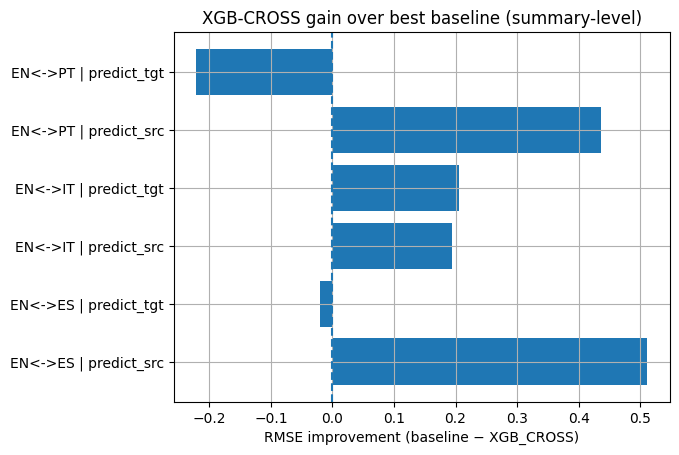

In [4]:
import matplotlib.pyplot as plt

labels = comp["pair"] + " | " + comp["task"]

plt.figure()
plt.barh(labels, comp["rmse_gain"])
plt.axvline(0, linestyle="--")
plt.xlabel("RMSE improvement (baseline − XGB_CROSS)")
plt.title("XGB-CROSS gain over best baseline (summary-level)")
plt.grid(True)
plt.show()



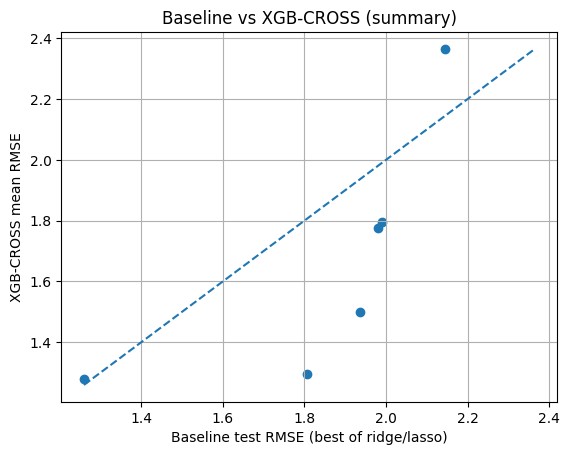

In [5]:
plt.figure()
plt.scatter(comp["test_rmse"], comp["test_rmse_mean"])

mn = min(comp["test_rmse"].min(), comp["test_rmse_mean"].min())
mx = max(comp["test_rmse"].max(), comp["test_rmse_mean"].max())
plt.plot([mn, mx], [mn, mx], linestyle="--")

plt.xlabel("Baseline test RMSE (best of ridge/lasso)")
plt.ylabel("XGB-CROSS mean RMSE")
plt.title("Baseline vs XGB-CROSS (summary)")
plt.grid(True)
plt.show()


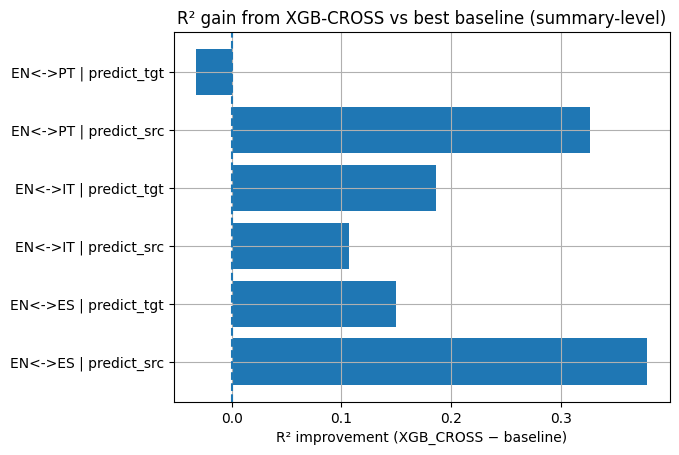

In [6]:
plt.figure()
plt.barh(labels, comp["r2_gain"])
plt.axvline(0, linestyle="--")
plt.xlabel("R² improvement (XGB_CROSS − baseline)")
plt.title("R² gain from XGB-CROSS vs best baseline (summary-level)")
plt.grid(True)
plt.show()
